In [47]:
import sys
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, cross_validate
from sklearn.neural_network import MLPClassifier
#from sklearn.metrics import F1Scorea
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras
import datetime
from sklearn.model_selection import StratifiedKFold

In [2]:
DATASET_PATH: str = "../../dataset/"

In [3]:
df = pd.read_csv('../../dataset/trainU.csv', sep=',', index_col=0)

In [4]:
df.shape

(299, 4421)

In [5]:
#cor_matrix = df.corr().abs()
#upper_tri = cor_matrix.where(np.triu(np.ones(cor_matrix.shape),k=1).astype(np.bool))
#print(upper_tri)

In [6]:
#to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > 0.5)]
#print(len(to_drop))
#print(len(data_cols))

In [7]:
#to_drop_positions = df.columns.get_indexer(to_drop)

In [8]:
#to_drop_positions

In [9]:
#df1 = df.drop(df.columns[to_drop_positions], axis=1)

In [11]:
data_cols = [col_name for col_name in df.columns if col_name != 'DISEASE']
print(len(data_cols))

4420


In [12]:
X = df[data_cols].values
y = df['DISEASE'].values

In [13]:
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder()
one_hot = encoder.fit(np.array(df['DISEASE']).reshape(-1, 1))
y_o = one_hot.transform(np.array(df['DISEASE']).reshape(-1, 1))

In [14]:
y_o = y_o.toarray()

In [15]:
y_o

array([[0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 1., 0., 0., 0.],
       ...,
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.]])

In [16]:
folds = 3
acc_per_fold = []
loss_per_fold = []
skf = StratifiedKFold(n_splits=folds, shuffle=False)
skf.get_n_splits(X, y)

3

In [17]:
rm -rf ./logs/

In [18]:
%load_ext tensorboard

In [19]:
from tensorboard.plugins.hparams import api as hp

HP_NUM_UNITS1 = hp.HParam('num_units1', hp.Discrete([64, 56]))
HP_NUM_UNITS2 = hp.HParam('num_units2', hp.Discrete([32, 24]))
HP_NUM_UNITS3 = hp.HParam('num_units3', hp.Discrete([16, 8]))
HP_DROPOUT1 = hp.HParam('dropout1', hp.RealInterval(0.2, 0.4))
HP_DROPOUT2 = hp.HParam('dropout2', hp.RealInterval(0.1, 0.3))
HP_OPTIMIZER = hp.HParam('optimizer', hp.Discrete(['adam', 'sgd']))

EPOCHS = 200
METRIC_ACCURACY = 'accuracy'

with tf.summary.create_file_writer('logs/hparam_tuning').as_default():
    hp.hparams_config(
        hparams=[HP_NUM_UNITS1, HP_NUM_UNITS2, HP_NUM_UNITS3, HP_DROPOUT1, HP_DROPOUT2, HP_OPTIMIZER],
        metrics=[hp.Metric(METRIC_ACCURACY, display_name='Accuracy')],
        )

2022-06-23 08:37:32.668830: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [20]:
def train_val_model(hparams, run_name):
    model = tf.keras.models.Sequential([
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(hparams[HP_NUM_UNITS1], activation=tf.nn.relu),
        tf.keras.layers.Dropout(hparams[HP_DROPOUT1]),
        tf.keras.layers.Dense(hparams[HP_NUM_UNITS2], activation=tf.nn.relu),
        tf.keras.layers.Dropout(hparams[HP_DROPOUT1]),
        tf.keras.layers.Dense(hparams[HP_NUM_UNITS2], activation=tf.nn.relu),
        tf.keras.layers.Dropout(hparams[HP_DROPOUT2]),
        tf.keras.layers.Dense(5, activation=tf.nn.softmax),
        ])
    model.compile(
      optimizer=hparams[HP_OPTIMIZER],
      loss='categorical_crossentropy',
      metrics=['accuracy'],
    )

    log_dir = "logs/fit/" + run_name + "-fold-" + str(fold_count)
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
    
    model.fit(X[train_index], y_o[train_index],   
            epochs=EPOCHS,
            # concettualmente e' sbagliato utilizzare questo VAL_SET qui, ma ci serve solo per
            # controllare l'eventuale regime di overfitting nel plot loss&accuracy nel secondo tensorboard 
            validation_data=(X[test_index], y_o[test_index]),
            callbacks=[tensorboard_callback]
            )
    scores = model.evaluate(X[test_index], y_o[test_index])

    res = [scores[1]*100, num_units1, num_units2, num_units3, dropout1_rate, dropout2_rate, optimizer, scores[0], fold_count,session_num]
    
    return res

In [21]:
def run(run_dir, hparams, run_name):
    with tf.summary.create_file_writer(run_dir).as_default():
        hp.hparams(hparams)  # record the values used in this trial
        results_run = train_val_model(hparams, run_name)
        tf.summary.scalar(METRIC_ACCURACY, results_run[0], step=1)
    return results_run

In [22]:
session_num = 0
results_session = []
fold_count = 0

for num_units1 in HP_NUM_UNITS1.domain.values:
    for num_units2 in HP_NUM_UNITS2.domain.values:
        for num_units3 in HP_NUM_UNITS3.domain.values:
            for dropout1_rate in (HP_DROPOUT1.domain.min_value, HP_DROPOUT1.domain.max_value):
                for dropout2_rate in (HP_DROPOUT2.domain.min_value, HP_DROPOUT2.domain.max_value):
                    for optimizer in HP_OPTIMIZER.domain.values:
                        for train_index, test_index in skf.split(X, y):
                            hparams = {
                              HP_NUM_UNITS1: num_units1,
                              HP_NUM_UNITS2: num_units2,
                              HP_NUM_UNITS3: num_units3,
                              HP_DROPOUT1: dropout1_rate,
                              HP_DROPOUT2: dropout2_rate,
                              HP_OPTIMIZER: optimizer,
                            }
                            run_name = "run-%d" % session_num
                            print('--- Starting trial: %s' % run_name)
                            print({h.name: hparams[h] for h in hparams})
                            print("Fold: ", fold_count)
                            results_session.append(run('logs/hparam_tuning/' + run_name + "-fold-" + str(fold_count), hparams, run_name))
                            fold_count+=1
                            if fold_count > 2:
                                fold_count = 0
                                
                        session_num += 1

--- Starting trial: run-0
{'num_units1': 56, 'num_units2': 24, 'num_units3': 8, 'dropout1': 0.2, 'dropout2': 0.1, 'optimizer': 'adam'}
Fold:  0
Epoch 1/200
7/7 [==============================] - 1s 64ms/step - loss: 1.5894 - accuracy: 0.3166 - val_loss: 1.3519 - val_accuracy: 0.4400
Epoch 2/200
7/7 [==============================] - 0s 25ms/step - loss: 1.4262 - accuracy: 0.4171 - val_loss: 1.3849 - val_accuracy: 0.4400
Epoch 3/200
7/7 [==============================] - 0s 23ms/step - loss: 1.4809 - accuracy: 0.4422 - val_loss: 1.3779 - val_accuracy: 0.7400
Epoch 4/200
7/7 [==============================] - 0s 26ms/step - loss: 1.3658 - accuracy: 0.4422 - val_loss: 1.2794 - val_accuracy: 0.7300
Epoch 5/200
7/7 [==============================] - 0s 21ms/step - loss: 1.3884 - accuracy: 0.4573 - val_loss: 1.1629 - val_accuracy: 0.7500
Epoch 6/200
7/7 [==============================] - 0s 22ms/step - loss: 1.1883 - accuracy: 0.6030 - val_loss: 1.0187 - val_accuracy: 0.7500
Epoch 7/200
7/7 

7/7 [==============================] - 0s 24ms/step - loss: 0.2170 - accuracy: 0.9146 - val_loss: 0.6086 - val_accuracy: 0.7900
Epoch 59/200
7/7 [==============================] - 0s 23ms/step - loss: 0.2563 - accuracy: 0.8894 - val_loss: 0.3616 - val_accuracy: 0.9200
Epoch 60/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1955 - accuracy: 0.9146 - val_loss: 0.3816 - val_accuracy: 0.9000
Epoch 61/200
7/7 [==============================] - 0s 25ms/step - loss: 0.1952 - accuracy: 0.9246 - val_loss: 0.3677 - val_accuracy: 0.9400
Epoch 62/200
7/7 [==============================] - 0s 22ms/step - loss: 0.1997 - accuracy: 0.9095 - val_loss: 0.4418 - val_accuracy: 0.8800
Epoch 63/200
7/7 [==============================] - 0s 22ms/step - loss: 0.2110 - accuracy: 0.9447 - val_loss: 0.4305 - val_accuracy: 0.8600
Epoch 64/200
7/7 [==============================] - 0s 23ms/step - loss: 0.2149 - accuracy: 0.9196 - val_loss: 0.3174 - val_accuracy: 0.9200
Epoch 65/200
7/7 [========

7/7 [==============================] - 0s 19ms/step - loss: 0.1106 - accuracy: 0.9447 - val_loss: 0.3719 - val_accuracy: 0.9300
Epoch 117/200
7/7 [==============================] - 0s 20ms/step - loss: 0.0875 - accuracy: 0.9598 - val_loss: 0.4402 - val_accuracy: 0.9300
Epoch 118/200
7/7 [==============================] - 0s 18ms/step - loss: 0.1517 - accuracy: 0.9246 - val_loss: 0.5122 - val_accuracy: 0.9200
Epoch 119/200
7/7 [==============================] - 0s 20ms/step - loss: 0.1372 - accuracy: 0.9447 - val_loss: 0.3382 - val_accuracy: 0.9400
Epoch 120/200
7/7 [==============================] - 0s 20ms/step - loss: 0.1319 - accuracy: 0.9447 - val_loss: 0.3854 - val_accuracy: 0.9500
Epoch 121/200
7/7 [==============================] - 0s 20ms/step - loss: 0.1175 - accuracy: 0.9548 - val_loss: 0.4642 - val_accuracy: 0.9200
Epoch 122/200
7/7 [==============================] - 0s 19ms/step - loss: 0.1054 - accuracy: 0.9548 - val_loss: 0.3802 - val_accuracy: 0.9500
Epoch 123/200
7/7 [=

Epoch 174/200
7/7 [==============================] - 0s 18ms/step - loss: 0.1817 - accuracy: 0.9447 - val_loss: 0.5213 - val_accuracy: 0.9000
Epoch 175/200
7/7 [==============================] - 0s 18ms/step - loss: 0.1100 - accuracy: 0.9698 - val_loss: 0.3863 - val_accuracy: 0.9300
Epoch 176/200
7/7 [==============================] - 0s 18ms/step - loss: 0.0838 - accuracy: 0.9598 - val_loss: 0.4596 - val_accuracy: 0.9200
Epoch 177/200
7/7 [==============================] - 0s 18ms/step - loss: 0.0827 - accuracy: 0.9648 - val_loss: 0.5547 - val_accuracy: 0.9100
Epoch 178/200
7/7 [==============================] - 0s 18ms/step - loss: 0.0904 - accuracy: 0.9698 - val_loss: 0.5845 - val_accuracy: 0.9100
Epoch 179/200
7/7 [==============================] - 0s 19ms/step - loss: 0.0881 - accuracy: 0.9598 - val_loss: 0.6592 - val_accuracy: 0.9100
Epoch 180/200
7/7 [==============================] - 0s 20ms/step - loss: 0.1012 - accuracy: 0.9598 - val_loss: 0.7348 - val_accuracy: 0.8900
Epoch 

7/7 [==============================] - 0s 23ms/step - loss: 0.2996 - accuracy: 0.8995 - val_loss: 0.6054 - val_accuracy: 0.8100
Epoch 31/200
7/7 [==============================] - 0s 23ms/step - loss: 0.3183 - accuracy: 0.8744 - val_loss: 0.6579 - val_accuracy: 0.7900
Epoch 32/200
7/7 [==============================] - 0s 23ms/step - loss: 0.2864 - accuracy: 0.8844 - val_loss: 0.5328 - val_accuracy: 0.8300
Epoch 33/200
7/7 [==============================] - 0s 22ms/step - loss: 0.2898 - accuracy: 0.9045 - val_loss: 0.5626 - val_accuracy: 0.8300
Epoch 34/200
7/7 [==============================] - 0s 22ms/step - loss: 0.2921 - accuracy: 0.8693 - val_loss: 0.7356 - val_accuracy: 0.7900
Epoch 35/200
7/7 [==============================] - 0s 22ms/step - loss: 0.2764 - accuracy: 0.9045 - val_loss: 0.6654 - val_accuracy: 0.7900
Epoch 36/200
7/7 [==============================] - 0s 23ms/step - loss: 0.3385 - accuracy: 0.8492 - val_loss: 0.5619 - val_accuracy: 0.8500
Epoch 37/200
7/7 [========

7/7 [==============================] - 0s 23ms/step - loss: 0.3106 - accuracy: 0.8693 - val_loss: 1.3120 - val_accuracy: 0.7900
Epoch 89/200
7/7 [==============================] - 0s 25ms/step - loss: 0.2469 - accuracy: 0.8995 - val_loss: 0.7267 - val_accuracy: 0.8600
Epoch 90/200
7/7 [==============================] - 0s 28ms/step - loss: 0.2773 - accuracy: 0.8894 - val_loss: 0.5870 - val_accuracy: 0.8500
Epoch 91/200
7/7 [==============================] - 0s 28ms/step - loss: 0.2282 - accuracy: 0.9246 - val_loss: 0.7758 - val_accuracy: 0.8300
Epoch 92/200
7/7 [==============================] - 0s 25ms/step - loss: 0.1402 - accuracy: 0.9347 - val_loss: 1.1021 - val_accuracy: 0.8100
Epoch 93/200
7/7 [==============================] - 0s 22ms/step - loss: 0.1914 - accuracy: 0.9095 - val_loss: 0.6476 - val_accuracy: 0.8900
Epoch 94/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1664 - accuracy: 0.9196 - val_loss: 0.5939 - val_accuracy: 0.9000
Epoch 95/200
7/7 [========

Epoch 146/200
7/7 [==============================] - 0s 24ms/step - loss: 0.1597 - accuracy: 0.9598 - val_loss: 0.9667 - val_accuracy: 0.8500
Epoch 147/200
7/7 [==============================] - 0s 24ms/step - loss: 0.1542 - accuracy: 0.9347 - val_loss: 1.0425 - val_accuracy: 0.8500
Epoch 148/200
7/7 [==============================] - 0s 26ms/step - loss: 0.1244 - accuracy: 0.9347 - val_loss: 1.0110 - val_accuracy: 0.8600
Epoch 149/200
7/7 [==============================] - 0s 22ms/step - loss: 0.0986 - accuracy: 0.9598 - val_loss: 0.9586 - val_accuracy: 0.8700
Epoch 150/200
7/7 [==============================] - 0s 22ms/step - loss: 0.1391 - accuracy: 0.9447 - val_loss: 1.0879 - val_accuracy: 0.8300
Epoch 151/200
7/7 [==============================] - 0s 22ms/step - loss: 0.0960 - accuracy: 0.9749 - val_loss: 1.4472 - val_accuracy: 0.8100
Epoch 152/200
7/7 [==============================] - 0s 22ms/step - loss: 0.1953 - accuracy: 0.9246 - val_loss: 0.8508 - val_accuracy: 0.8700
Epoch 

7/7 [==============================] - 0s 22ms/step - loss: 1.4248 - accuracy: 0.4350 - val_loss: 1.1892 - val_accuracy: 0.6566
Epoch 3/200
7/7 [==============================] - 0s 22ms/step - loss: 1.2509 - accuracy: 0.5200 - val_loss: 1.0421 - val_accuracy: 0.7172
Epoch 4/200
7/7 [==============================] - 0s 21ms/step - loss: 1.1165 - accuracy: 0.6350 - val_loss: 0.9674 - val_accuracy: 0.7273
Epoch 5/200
7/7 [==============================] - 0s 22ms/step - loss: 0.9281 - accuracy: 0.7000 - val_loss: 0.8621 - val_accuracy: 0.7475
Epoch 6/200
7/7 [==============================] - 0s 21ms/step - loss: 0.9914 - accuracy: 0.6950 - val_loss: 0.9155 - val_accuracy: 0.6869
Epoch 7/200
7/7 [==============================] - 0s 22ms/step - loss: 0.9102 - accuracy: 0.7000 - val_loss: 0.8444 - val_accuracy: 0.6970
Epoch 8/200
7/7 [==============================] - 0s 21ms/step - loss: 0.8372 - accuracy: 0.7100 - val_loss: 0.7755 - val_accuracy: 0.7576
Epoch 9/200
7/7 [===============

7/7 [==============================] - 0s 27ms/step - loss: 0.0604 - accuracy: 0.9800 - val_loss: 0.4296 - val_accuracy: 0.8889
Epoch 61/200
7/7 [==============================] - 0s 23ms/step - loss: 0.0691 - accuracy: 0.9750 - val_loss: 0.4214 - val_accuracy: 0.8889
Epoch 62/200
7/7 [==============================] - 0s 27ms/step - loss: 0.0932 - accuracy: 0.9650 - val_loss: 0.4414 - val_accuracy: 0.8990
Epoch 63/200
7/7 [==============================] - 0s 23ms/step - loss: 0.0921 - accuracy: 0.9650 - val_loss: 0.3898 - val_accuracy: 0.9192
Epoch 64/200
7/7 [==============================] - 0s 22ms/step - loss: 0.0913 - accuracy: 0.9650 - val_loss: 0.4100 - val_accuracy: 0.8889
Epoch 65/200
7/7 [==============================] - 0s 27ms/step - loss: 0.0983 - accuracy: 0.9600 - val_loss: 0.3847 - val_accuracy: 0.8990
Epoch 66/200
7/7 [==============================] - 0s 23ms/step - loss: 0.0527 - accuracy: 0.9800 - val_loss: 0.3464 - val_accuracy: 0.8990
Epoch 67/200
7/7 [========

7/7 [==============================] - 0s 24ms/step - loss: 0.1039 - accuracy: 0.9600 - val_loss: 0.7230 - val_accuracy: 0.8788
Epoch 119/200
7/7 [==============================] - 0s 22ms/step - loss: 0.0553 - accuracy: 0.9750 - val_loss: 0.4674 - val_accuracy: 0.8788
Epoch 120/200
7/7 [==============================] - 0s 22ms/step - loss: 0.0532 - accuracy: 0.9850 - val_loss: 0.5033 - val_accuracy: 0.9091
Epoch 121/200
7/7 [==============================] - 0s 22ms/step - loss: 0.0130 - accuracy: 0.9950 - val_loss: 0.7631 - val_accuracy: 0.8889
Epoch 122/200
7/7 [==============================] - 0s 23ms/step - loss: 0.0471 - accuracy: 0.9900 - val_loss: 0.5580 - val_accuracy: 0.8990
Epoch 123/200
7/7 [==============================] - 0s 22ms/step - loss: 0.0200 - accuracy: 0.9950 - val_loss: 0.4405 - val_accuracy: 0.9091
Epoch 124/200
7/7 [==============================] - 0s 22ms/step - loss: 0.0280 - accuracy: 0.9850 - val_loss: 0.4686 - val_accuracy: 0.9091
Epoch 125/200
7/7 [=

Epoch 176/200
7/7 [==============================] - 0s 22ms/step - loss: 0.0402 - accuracy: 0.9900 - val_loss: 0.3587 - val_accuracy: 0.8990
Epoch 177/200
7/7 [==============================] - 0s 22ms/step - loss: 0.0759 - accuracy: 0.9750 - val_loss: 0.2970 - val_accuracy: 0.9091
Epoch 178/200
7/7 [==============================] - 0s 22ms/step - loss: 0.1193 - accuracy: 0.9600 - val_loss: 0.5980 - val_accuracy: 0.8182
Epoch 179/200
7/7 [==============================] - 0s 22ms/step - loss: 0.1760 - accuracy: 0.9450 - val_loss: 0.3744 - val_accuracy: 0.8889
Epoch 180/200
7/7 [==============================] - 0s 22ms/step - loss: 0.1484 - accuracy: 0.9350 - val_loss: 0.3633 - val_accuracy: 0.9091
Epoch 181/200
7/7 [==============================] - 0s 22ms/step - loss: 0.1042 - accuracy: 0.9500 - val_loss: 0.3658 - val_accuracy: 0.8990
Epoch 182/200
7/7 [==============================] - 0s 22ms/step - loss: 0.1217 - accuracy: 0.9550 - val_loss: 0.2833 - val_accuracy: 0.9192
Epoch 

7/7 [==============================] - 0s 21ms/step - loss: 0.5501 - accuracy: 0.7889 - val_loss: 0.6028 - val_accuracy: 0.7700
Epoch 33/200
7/7 [==============================] - 0s 22ms/step - loss: 0.5836 - accuracy: 0.7839 - val_loss: 0.5560 - val_accuracy: 0.8000
Epoch 34/200
7/7 [==============================] - 0s 22ms/step - loss: 0.5424 - accuracy: 0.7839 - val_loss: 0.5747 - val_accuracy: 0.7700
Epoch 35/200
7/7 [==============================] - 0s 21ms/step - loss: 0.4767 - accuracy: 0.8492 - val_loss: 0.5432 - val_accuracy: 0.8000
Epoch 36/200
7/7 [==============================] - 0s 21ms/step - loss: 0.4892 - accuracy: 0.8090 - val_loss: 0.5461 - val_accuracy: 0.8000
Epoch 37/200
7/7 [==============================] - 0s 22ms/step - loss: 0.4538 - accuracy: 0.8090 - val_loss: 0.5193 - val_accuracy: 0.8100
Epoch 38/200
7/7 [==============================] - 0s 22ms/step - loss: 0.4646 - accuracy: 0.8141 - val_loss: 0.5343 - val_accuracy: 0.7900
Epoch 39/200
7/7 [========

7/7 [==============================] - 0s 22ms/step - loss: 0.2000 - accuracy: 0.9347 - val_loss: 0.3668 - val_accuracy: 0.8700
Epoch 91/200
7/7 [==============================] - 0s 25ms/step - loss: 0.2123 - accuracy: 0.9347 - val_loss: 0.3315 - val_accuracy: 0.9100
Epoch 92/200
7/7 [==============================] - 0s 22ms/step - loss: 0.2222 - accuracy: 0.9447 - val_loss: 0.3404 - val_accuracy: 0.9000
Epoch 93/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1884 - accuracy: 0.9548 - val_loss: 0.3869 - val_accuracy: 0.8800
Epoch 94/200
7/7 [==============================] - 0s 22ms/step - loss: 0.2304 - accuracy: 0.9146 - val_loss: 0.3304 - val_accuracy: 0.9200
Epoch 95/200
7/7 [==============================] - 0s 21ms/step - loss: 0.1643 - accuracy: 0.9598 - val_loss: 0.3672 - val_accuracy: 0.8900
Epoch 96/200
7/7 [==============================] - 0s 22ms/step - loss: 0.1812 - accuracy: 0.9598 - val_loss: 0.3495 - val_accuracy: 0.9100
Epoch 97/200
7/7 [========

Epoch 148/200
7/7 [==============================] - 0s 21ms/step - loss: 0.0903 - accuracy: 0.9799 - val_loss: 0.3013 - val_accuracy: 0.9300
Epoch 149/200
7/7 [==============================] - 0s 22ms/step - loss: 0.1226 - accuracy: 0.9648 - val_loss: 0.3467 - val_accuracy: 0.9200
Epoch 150/200
7/7 [==============================] - 0s 21ms/step - loss: 0.1025 - accuracy: 0.9648 - val_loss: 0.3235 - val_accuracy: 0.9200
Epoch 151/200
7/7 [==============================] - 0s 21ms/step - loss: 0.0940 - accuracy: 0.9749 - val_loss: 0.3278 - val_accuracy: 0.9200
Epoch 152/200
7/7 [==============================] - 0s 21ms/step - loss: 0.0988 - accuracy: 0.9799 - val_loss: 0.3005 - val_accuracy: 0.9300
Epoch 153/200
7/7 [==============================] - 0s 21ms/step - loss: 0.0923 - accuracy: 0.9799 - val_loss: 0.3437 - val_accuracy: 0.9200
Epoch 154/200
7/7 [==============================] - 0s 21ms/step - loss: 0.1006 - accuracy: 0.9698 - val_loss: 0.2968 - val_accuracy: 0.9300
Epoch 

7/7 [==============================] - 0s 21ms/step - loss: 1.3598 - accuracy: 0.5126 - val_loss: 1.3091 - val_accuracy: 0.5200
Epoch 5/200
7/7 [==============================] - 0s 21ms/step - loss: 1.3258 - accuracy: 0.5226 - val_loss: 1.2507 - val_accuracy: 0.7100
Epoch 6/200
7/7 [==============================] - 0s 22ms/step - loss: 1.3050 - accuracy: 0.5628 - val_loss: 1.3274 - val_accuracy: 0.4400
Epoch 7/200
7/7 [==============================] - 0s 22ms/step - loss: 1.2815 - accuracy: 0.5226 - val_loss: 1.1579 - val_accuracy: 0.7600
Epoch 8/200
7/7 [==============================] - 0s 21ms/step - loss: 1.2225 - accuracy: 0.5980 - val_loss: 1.1295 - val_accuracy: 0.7000
Epoch 9/200
7/7 [==============================] - 0s 21ms/step - loss: 1.2305 - accuracy: 0.5578 - val_loss: 1.0981 - val_accuracy: 0.7600
Epoch 10/200
7/7 [==============================] - 0s 22ms/step - loss: 1.0846 - accuracy: 0.6332 - val_loss: 1.0714 - val_accuracy: 0.7500
Epoch 11/200
7/7 [=============

7/7 [==============================] - 0s 21ms/step - loss: 0.3118 - accuracy: 0.9045 - val_loss: 0.5890 - val_accuracy: 0.8200
Epoch 63/200
7/7 [==============================] - 0s 21ms/step - loss: 0.2993 - accuracy: 0.9045 - val_loss: 0.7755 - val_accuracy: 0.8000
Epoch 64/200
7/7 [==============================] - 0s 22ms/step - loss: 0.2310 - accuracy: 0.9196 - val_loss: 1.0950 - val_accuracy: 0.7700
Epoch 65/200
7/7 [==============================] - 0s 22ms/step - loss: 0.2546 - accuracy: 0.9196 - val_loss: 0.6477 - val_accuracy: 0.8500
Epoch 66/200
7/7 [==============================] - 0s 21ms/step - loss: 0.2306 - accuracy: 0.9095 - val_loss: 0.6076 - val_accuracy: 0.8300
Epoch 67/200
7/7 [==============================] - 0s 21ms/step - loss: 0.2548 - accuracy: 0.9196 - val_loss: 0.5625 - val_accuracy: 0.8200
Epoch 68/200
7/7 [==============================] - 0s 22ms/step - loss: 0.2441 - accuracy: 0.9196 - val_loss: 0.6615 - val_accuracy: 0.8400
Epoch 69/200
7/7 [========

7/7 [==============================] - 0s 23ms/step - loss: 0.1052 - accuracy: 0.9648 - val_loss: 0.7147 - val_accuracy: 0.8700
Epoch 121/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1347 - accuracy: 0.9497 - val_loss: 0.7323 - val_accuracy: 0.8700
Epoch 122/200
7/7 [==============================] - 0s 21ms/step - loss: 0.1269 - accuracy: 0.9598 - val_loss: 0.8718 - val_accuracy: 0.8500
Epoch 123/200
7/7 [==============================] - 0s 22ms/step - loss: 0.1466 - accuracy: 0.9548 - val_loss: 0.7843 - val_accuracy: 0.8600
Epoch 124/200
7/7 [==============================] - 0s 22ms/step - loss: 0.1155 - accuracy: 0.9749 - val_loss: 0.9565 - val_accuracy: 0.8200
Epoch 125/200
7/7 [==============================] - 0s 21ms/step - loss: 0.1096 - accuracy: 0.9648 - val_loss: 0.7357 - val_accuracy: 0.8500
Epoch 126/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1166 - accuracy: 0.9648 - val_loss: 0.6870 - val_accuracy: 0.8700
Epoch 127/200
7/7 [=

Epoch 178/200
7/7 [==============================] - 0s 21ms/step - loss: 0.0674 - accuracy: 0.9799 - val_loss: 0.5279 - val_accuracy: 0.9100
Epoch 179/200
7/7 [==============================] - 0s 22ms/step - loss: 0.0670 - accuracy: 0.9899 - val_loss: 0.6962 - val_accuracy: 0.8800
Epoch 180/200
7/7 [==============================] - 0s 22ms/step - loss: 0.0682 - accuracy: 0.9849 - val_loss: 0.8087 - val_accuracy: 0.8700
Epoch 181/200
7/7 [==============================] - 0s 22ms/step - loss: 0.1142 - accuracy: 0.9548 - val_loss: 0.7118 - val_accuracy: 0.8700
Epoch 182/200
7/7 [==============================] - 0s 21ms/step - loss: 0.0849 - accuracy: 0.9799 - val_loss: 0.7229 - val_accuracy: 0.8700
Epoch 183/200
7/7 [==============================] - 0s 21ms/step - loss: 0.0587 - accuracy: 0.9849 - val_loss: 0.5957 - val_accuracy: 0.8900
Epoch 184/200
7/7 [==============================] - 0s 21ms/step - loss: 0.0381 - accuracy: 0.9950 - val_loss: 0.7942 - val_accuracy: 0.8800
Epoch 

7/7 [==============================] - 0s 22ms/step - loss: 0.5497 - accuracy: 0.7600 - val_loss: 0.6298 - val_accuracy: 0.7475
Epoch 35/200
7/7 [==============================] - 0s 22ms/step - loss: 0.5452 - accuracy: 0.7700 - val_loss: 0.6408 - val_accuracy: 0.7576
Epoch 36/200
7/7 [==============================] - 0s 21ms/step - loss: 0.5735 - accuracy: 0.7600 - val_loss: 0.6987 - val_accuracy: 0.7172
Epoch 37/200
7/7 [==============================] - 0s 22ms/step - loss: 0.5405 - accuracy: 0.7600 - val_loss: 0.6403 - val_accuracy: 0.7374
Epoch 38/200
7/7 [==============================] - 0s 22ms/step - loss: 0.5176 - accuracy: 0.7600 - val_loss: 0.5915 - val_accuracy: 0.7576
Epoch 39/200
7/7 [==============================] - 0s 22ms/step - loss: 0.5183 - accuracy: 0.7800 - val_loss: 0.6186 - val_accuracy: 0.7576
Epoch 40/200
7/7 [==============================] - 0s 22ms/step - loss: 0.4998 - accuracy: 0.7750 - val_loss: 0.7090 - val_accuracy: 0.7071
Epoch 41/200
7/7 [========

7/7 [==============================] - 0s 23ms/step - loss: 0.2294 - accuracy: 0.9400 - val_loss: 0.4536 - val_accuracy: 0.8586
Epoch 93/200
7/7 [==============================] - 0s 22ms/step - loss: 0.2309 - accuracy: 0.9350 - val_loss: 0.4181 - val_accuracy: 0.8687
Epoch 94/200
7/7 [==============================] - 0s 22ms/step - loss: 0.2168 - accuracy: 0.9350 - val_loss: 0.4490 - val_accuracy: 0.8586
Epoch 95/200
7/7 [==============================] - 0s 22ms/step - loss: 0.2171 - accuracy: 0.9300 - val_loss: 0.5032 - val_accuracy: 0.8283
Epoch 96/200
7/7 [==============================] - 0s 22ms/step - loss: 0.2256 - accuracy: 0.9300 - val_loss: 0.4356 - val_accuracy: 0.8586
Epoch 97/200
7/7 [==============================] - 0s 21ms/step - loss: 0.2523 - accuracy: 0.9150 - val_loss: 0.5417 - val_accuracy: 0.8081
Epoch 98/200
7/7 [==============================] - 0s 22ms/step - loss: 0.2074 - accuracy: 0.9250 - val_loss: 0.4601 - val_accuracy: 0.8687
Epoch 99/200
7/7 [========

Epoch 150/200
7/7 [==============================] - 0s 22ms/step - loss: 0.0972 - accuracy: 0.9800 - val_loss: 0.4249 - val_accuracy: 0.8889
Epoch 151/200
7/7 [==============================] - 0s 22ms/step - loss: 0.0843 - accuracy: 0.9750 - val_loss: 0.4155 - val_accuracy: 0.8788
Epoch 152/200
7/7 [==============================] - 0s 22ms/step - loss: 0.1282 - accuracy: 0.9600 - val_loss: 0.4070 - val_accuracy: 0.8889
Epoch 153/200
7/7 [==============================] - 0s 22ms/step - loss: 0.1276 - accuracy: 0.9500 - val_loss: 0.8155 - val_accuracy: 0.8081
Epoch 154/200
7/7 [==============================] - 0s 24ms/step - loss: 0.1710 - accuracy: 0.9450 - val_loss: 0.3905 - val_accuracy: 0.8889
Epoch 155/200
7/7 [==============================] - 0s 22ms/step - loss: 0.1227 - accuracy: 0.9600 - val_loss: 0.4410 - val_accuracy: 0.8889
Epoch 156/200
7/7 [==============================] - 0s 21ms/step - loss: 0.1460 - accuracy: 0.9450 - val_loss: 0.4872 - val_accuracy: 0.8687
Epoch 

7/7 [==============================] - 0s 23ms/step - loss: 1.4785 - accuracy: 0.3970 - val_loss: 1.3580 - val_accuracy: 0.5800
Epoch 7/200
7/7 [==============================] - 0s 23ms/step - loss: 1.4126 - accuracy: 0.4975 - val_loss: 1.3144 - val_accuracy: 0.7400
Epoch 8/200
7/7 [==============================] - 0s 22ms/step - loss: 1.3408 - accuracy: 0.5276 - val_loss: 1.2506 - val_accuracy: 0.7500
Epoch 9/200
7/7 [==============================] - 0s 21ms/step - loss: 1.3017 - accuracy: 0.5176 - val_loss: 1.1849 - val_accuracy: 0.7600
Epoch 10/200
7/7 [==============================] - 0s 21ms/step - loss: 1.2286 - accuracy: 0.5678 - val_loss: 1.1505 - val_accuracy: 0.7600
Epoch 11/200
7/7 [==============================] - 0s 22ms/step - loss: 1.2138 - accuracy: 0.5528 - val_loss: 1.1546 - val_accuracy: 0.7600
Epoch 12/200
7/7 [==============================] - 0s 22ms/step - loss: 1.1904 - accuracy: 0.6332 - val_loss: 1.1364 - val_accuracy: 0.7600
Epoch 13/200
7/7 [===========

7/7 [==============================] - 0s 22ms/step - loss: 0.4062 - accuracy: 0.8291 - val_loss: 0.5068 - val_accuracy: 0.8100
Epoch 65/200
7/7 [==============================] - 0s 22ms/step - loss: 0.4276 - accuracy: 0.8643 - val_loss: 0.4891 - val_accuracy: 0.8200
Epoch 66/200
7/7 [==============================] - 0s 22ms/step - loss: 0.3849 - accuracy: 0.8543 - val_loss: 0.4482 - val_accuracy: 0.8400
Epoch 67/200
7/7 [==============================] - 0s 25ms/step - loss: 0.4727 - accuracy: 0.8492 - val_loss: 0.4861 - val_accuracy: 0.8500
Epoch 68/200
7/7 [==============================] - 0s 23ms/step - loss: 0.5671 - accuracy: 0.7688 - val_loss: 0.4647 - val_accuracy: 0.8400
Epoch 69/200
7/7 [==============================] - 0s 24ms/step - loss: 0.5177 - accuracy: 0.7990 - val_loss: 0.4613 - val_accuracy: 0.8300
Epoch 70/200
7/7 [==============================] - 0s 24ms/step - loss: 0.4597 - accuracy: 0.7940 - val_loss: 0.4684 - val_accuracy: 0.8400
Epoch 71/200
7/7 [========

7/7 [==============================] - 0s 22ms/step - loss: 0.3620 - accuracy: 0.8593 - val_loss: 0.7141 - val_accuracy: 0.7900
Epoch 123/200
7/7 [==============================] - 0s 23ms/step - loss: 0.3546 - accuracy: 0.8392 - val_loss: 0.6367 - val_accuracy: 0.8000
Epoch 124/200
7/7 [==============================] - 0s 22ms/step - loss: 0.3607 - accuracy: 0.8492 - val_loss: 0.5304 - val_accuracy: 0.8000
Epoch 125/200
7/7 [==============================] - 0s 23ms/step - loss: 0.4107 - accuracy: 0.8392 - val_loss: 0.6895 - val_accuracy: 0.7600
Epoch 126/200
7/7 [==============================] - 0s 22ms/step - loss: 0.3329 - accuracy: 0.8442 - val_loss: 0.4314 - val_accuracy: 0.8500
Epoch 127/200
7/7 [==============================] - 0s 22ms/step - loss: 0.3693 - accuracy: 0.8492 - val_loss: 0.3907 - val_accuracy: 0.8600
Epoch 128/200
7/7 [==============================] - 0s 22ms/step - loss: 0.3520 - accuracy: 0.8593 - val_loss: 0.4456 - val_accuracy: 0.8500
Epoch 129/200
7/7 [=

Epoch 180/200
7/7 [==============================] - 0s 23ms/step - loss: 0.3483 - accuracy: 0.8492 - val_loss: 0.4177 - val_accuracy: 0.8600
Epoch 181/200
7/7 [==============================] - 0s 23ms/step - loss: 0.3311 - accuracy: 0.8593 - val_loss: 0.4722 - val_accuracy: 0.8400
Epoch 182/200
7/7 [==============================] - 0s 22ms/step - loss: 0.2730 - accuracy: 0.8894 - val_loss: 0.5730 - val_accuracy: 0.8100
Epoch 183/200
7/7 [==============================] - 0s 22ms/step - loss: 0.3217 - accuracy: 0.8794 - val_loss: 0.5690 - val_accuracy: 0.8100
Epoch 184/200
7/7 [==============================] - 0s 23ms/step - loss: 0.2836 - accuracy: 0.8794 - val_loss: 0.3792 - val_accuracy: 0.8700
Epoch 185/200
7/7 [==============================] - 0s 22ms/step - loss: 0.2906 - accuracy: 0.8894 - val_loss: 0.4044 - val_accuracy: 0.8700
Epoch 186/200
7/7 [==============================] - 0s 22ms/step - loss: 0.2685 - accuracy: 0.8945 - val_loss: 0.3985 - val_accuracy: 0.8800
Epoch 

7/7 [==============================] - 0s 22ms/step - loss: 0.5180 - accuracy: 0.7990 - val_loss: 0.5728 - val_accuracy: 0.8200
Epoch 37/200
7/7 [==============================] - 0s 23ms/step - loss: 0.4044 - accuracy: 0.8543 - val_loss: 0.6115 - val_accuracy: 0.8100
Epoch 38/200
7/7 [==============================] - 0s 21ms/step - loss: 0.4057 - accuracy: 0.8392 - val_loss: 0.5307 - val_accuracy: 0.8300
Epoch 39/200
7/7 [==============================] - 0s 22ms/step - loss: 0.4082 - accuracy: 0.8442 - val_loss: 0.5652 - val_accuracy: 0.8200
Epoch 40/200
7/7 [==============================] - 0s 22ms/step - loss: 0.4631 - accuracy: 0.8191 - val_loss: 0.5330 - val_accuracy: 0.8100
Epoch 41/200
7/7 [==============================] - 0s 21ms/step - loss: 0.4180 - accuracy: 0.8442 - val_loss: 0.6046 - val_accuracy: 0.8200
Epoch 42/200
7/7 [==============================] - 0s 22ms/step - loss: 0.4503 - accuracy: 0.8241 - val_loss: 0.5587 - val_accuracy: 0.8300
Epoch 43/200
7/7 [========

7/7 [==============================] - 0s 23ms/step - loss: 0.2361 - accuracy: 0.8894 - val_loss: 0.9471 - val_accuracy: 0.8300
Epoch 95/200
7/7 [==============================] - 0s 23ms/step - loss: 0.2383 - accuracy: 0.8995 - val_loss: 0.7817 - val_accuracy: 0.8500
Epoch 96/200
7/7 [==============================] - 0s 22ms/step - loss: 0.2203 - accuracy: 0.9146 - val_loss: 0.5399 - val_accuracy: 0.8900
Epoch 97/200
7/7 [==============================] - 0s 22ms/step - loss: 0.1976 - accuracy: 0.9146 - val_loss: 0.6040 - val_accuracy: 0.8800
Epoch 98/200
7/7 [==============================] - 0s 22ms/step - loss: 0.1963 - accuracy: 0.9095 - val_loss: 1.0434 - val_accuracy: 0.8100
Epoch 99/200
7/7 [==============================] - 0s 21ms/step - loss: 0.2107 - accuracy: 0.9447 - val_loss: 0.8096 - val_accuracy: 0.8500
Epoch 100/200
7/7 [==============================] - 0s 22ms/step - loss: 0.1828 - accuracy: 0.9196 - val_loss: 0.5178 - val_accuracy: 0.8900
Epoch 101/200
7/7 [======

Epoch 152/200
7/7 [==============================] - 0s 22ms/step - loss: 0.2706 - accuracy: 0.9095 - val_loss: 0.5685 - val_accuracy: 0.8900
Epoch 153/200
7/7 [==============================] - 0s 22ms/step - loss: 0.1901 - accuracy: 0.9497 - val_loss: 0.7165 - val_accuracy: 0.8300
Epoch 154/200
7/7 [==============================] - 0s 22ms/step - loss: 0.2216 - accuracy: 0.9548 - val_loss: 0.7785 - val_accuracy: 0.8200
Epoch 155/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1895 - accuracy: 0.9447 - val_loss: 0.7010 - val_accuracy: 0.8500
Epoch 156/200
7/7 [==============================] - 0s 21ms/step - loss: 0.2434 - accuracy: 0.9196 - val_loss: 1.0088 - val_accuracy: 0.8200
Epoch 157/200
7/7 [==============================] - 0s 23ms/step - loss: 0.2168 - accuracy: 0.9095 - val_loss: 0.9097 - val_accuracy: 0.8100
Epoch 158/200
7/7 [==============================] - 0s 22ms/step - loss: 0.1787 - accuracy: 0.9146 - val_loss: 0.7263 - val_accuracy: 0.8400
Epoch 

7/7 [==============================] - 0s 23ms/step - loss: 1.1670 - accuracy: 0.6100 - val_loss: 0.9539 - val_accuracy: 0.7576
Epoch 9/200
7/7 [==============================] - 0s 22ms/step - loss: 1.1252 - accuracy: 0.6000 - val_loss: 0.9859 - val_accuracy: 0.7374
Epoch 10/200
7/7 [==============================] - 0s 22ms/step - loss: 1.0198 - accuracy: 0.6750 - val_loss: 0.8525 - val_accuracy: 0.7677
Epoch 11/200
7/7 [==============================] - 0s 22ms/step - loss: 0.9979 - accuracy: 0.6800 - val_loss: 0.9104 - val_accuracy: 0.6869
Epoch 12/200
7/7 [==============================] - 0s 22ms/step - loss: 0.9443 - accuracy: 0.6850 - val_loss: 0.8169 - val_accuracy: 0.7576
Epoch 13/200
7/7 [==============================] - 0s 22ms/step - loss: 0.8972 - accuracy: 0.7150 - val_loss: 0.8897 - val_accuracy: 0.6566
Epoch 14/200
7/7 [==============================] - 0s 22ms/step - loss: 0.9249 - accuracy: 0.6900 - val_loss: 0.7332 - val_accuracy: 0.7677
Epoch 15/200
7/7 [=========

7/7 [==============================] - 0s 22ms/step - loss: 0.3714 - accuracy: 0.8700 - val_loss: 0.6049 - val_accuracy: 0.8283
Epoch 67/200
7/7 [==============================] - 0s 21ms/step - loss: 0.3286 - accuracy: 0.9000 - val_loss: 0.6459 - val_accuracy: 0.7071
Epoch 68/200
7/7 [==============================] - 0s 21ms/step - loss: 0.3917 - accuracy: 0.8650 - val_loss: 0.6092 - val_accuracy: 0.8081
Epoch 69/200
7/7 [==============================] - 0s 22ms/step - loss: 0.4045 - accuracy: 0.8400 - val_loss: 0.7905 - val_accuracy: 0.7879
Epoch 70/200
7/7 [==============================] - 0s 22ms/step - loss: 0.3563 - accuracy: 0.8700 - val_loss: 0.5938 - val_accuracy: 0.8283
Epoch 71/200
7/7 [==============================] - 0s 22ms/step - loss: 0.3751 - accuracy: 0.8650 - val_loss: 0.5420 - val_accuracy: 0.8384
Epoch 72/200
7/7 [==============================] - 0s 21ms/step - loss: 0.3378 - accuracy: 0.8850 - val_loss: 0.5803 - val_accuracy: 0.8283
Epoch 73/200
7/7 [========

7/7 [==============================] - 0s 22ms/step - loss: 0.3685 - accuracy: 0.8500 - val_loss: 0.8045 - val_accuracy: 0.8081
Epoch 125/200
7/7 [==============================] - 0s 22ms/step - loss: 0.3460 - accuracy: 0.8650 - val_loss: 0.7627 - val_accuracy: 0.8384
Epoch 126/200
7/7 [==============================] - 0s 23ms/step - loss: 0.2738 - accuracy: 0.8900 - val_loss: 0.5170 - val_accuracy: 0.8081
Epoch 127/200
7/7 [==============================] - 0s 23ms/step - loss: 0.3402 - accuracy: 0.8650 - val_loss: 0.5396 - val_accuracy: 0.8283
Epoch 128/200
7/7 [==============================] - 0s 23ms/step - loss: 0.2659 - accuracy: 0.8850 - val_loss: 0.6791 - val_accuracy: 0.8283
Epoch 129/200
7/7 [==============================] - 0s 24ms/step - loss: 0.2766 - accuracy: 0.8850 - val_loss: 0.7543 - val_accuracy: 0.8283
Epoch 130/200
7/7 [==============================] - 0s 22ms/step - loss: 0.2991 - accuracy: 0.8750 - val_loss: 0.7852 - val_accuracy: 0.8182
Epoch 131/200
7/7 [=

Epoch 182/200
7/7 [==============================] - 0s 21ms/step - loss: 0.3470 - accuracy: 0.8450 - val_loss: 0.5258 - val_accuracy: 0.8283
Epoch 183/200
7/7 [==============================] - 0s 22ms/step - loss: 0.3382 - accuracy: 0.8400 - val_loss: 0.5959 - val_accuracy: 0.8182
Epoch 184/200
7/7 [==============================] - 0s 28ms/step - loss: 0.5634 - accuracy: 0.7500 - val_loss: 0.5398 - val_accuracy: 0.8384
Epoch 185/200
7/7 [==============================] - 0s 35ms/step - loss: 0.3581 - accuracy: 0.8400 - val_loss: 0.4740 - val_accuracy: 0.8586
Epoch 186/200
7/7 [==============================] - 0s 48ms/step - loss: 0.3947 - accuracy: 0.8550 - val_loss: 0.6049 - val_accuracy: 0.7778
Epoch 187/200
7/7 [==============================] - 0s 42ms/step - loss: 0.4073 - accuracy: 0.8450 - val_loss: 0.5065 - val_accuracy: 0.8687
Epoch 188/200
7/7 [==============================] - 0s 46ms/step - loss: 0.4402 - accuracy: 0.8200 - val_loss: 0.5188 - val_accuracy: 0.8283
Epoch 

7/7 [==============================] - 0s 26ms/step - loss: 0.4110 - accuracy: 0.8442 - val_loss: 0.5240 - val_accuracy: 0.7700
Epoch 39/200
7/7 [==============================] - 0s 24ms/step - loss: 0.4413 - accuracy: 0.8593 - val_loss: 0.5297 - val_accuracy: 0.7700
Epoch 40/200
7/7 [==============================] - 0s 23ms/step - loss: 0.5203 - accuracy: 0.7940 - val_loss: 0.9621 - val_accuracy: 0.6100
Epoch 41/200
7/7 [==============================] - 0s 24ms/step - loss: 0.5479 - accuracy: 0.7990 - val_loss: 0.7430 - val_accuracy: 0.7600
Epoch 42/200
7/7 [==============================] - 0s 24ms/step - loss: 0.4601 - accuracy: 0.8241 - val_loss: 0.5673 - val_accuracy: 0.7700
Epoch 43/200
7/7 [==============================] - 0s 24ms/step - loss: 0.4644 - accuracy: 0.8291 - val_loss: 0.5463 - val_accuracy: 0.7800
Epoch 44/200
7/7 [==============================] - 0s 27ms/step - loss: 0.4209 - accuracy: 0.8241 - val_loss: 0.5256 - val_accuracy: 0.8000
Epoch 45/200
7/7 [========

7/7 [==============================] - 0s 21ms/step - loss: 0.1832 - accuracy: 0.9347 - val_loss: 0.3765 - val_accuracy: 0.9100
Epoch 97/200
7/7 [==============================] - 0s 22ms/step - loss: 0.1704 - accuracy: 0.9397 - val_loss: 0.5908 - val_accuracy: 0.8200
Epoch 98/200
7/7 [==============================] - 0s 22ms/step - loss: 0.2083 - accuracy: 0.9246 - val_loss: 0.4553 - val_accuracy: 0.9000
Epoch 99/200
7/7 [==============================] - 0s 21ms/step - loss: 0.2167 - accuracy: 0.9146 - val_loss: 0.4541 - val_accuracy: 0.8800
Epoch 100/200
7/7 [==============================] - 0s 22ms/step - loss: 0.1658 - accuracy: 0.9447 - val_loss: 0.4202 - val_accuracy: 0.9100
Epoch 101/200
7/7 [==============================] - 0s 22ms/step - loss: 0.1695 - accuracy: 0.9497 - val_loss: 0.4313 - val_accuracy: 0.9000
Epoch 102/200
7/7 [==============================] - 0s 23ms/step - loss: 0.2103 - accuracy: 0.9196 - val_loss: 0.6734 - val_accuracy: 0.8000
Epoch 103/200
7/7 [====

Epoch 154/200
7/7 [==============================] - 0s 21ms/step - loss: 0.1588 - accuracy: 0.9296 - val_loss: 0.4707 - val_accuracy: 0.9100
Epoch 155/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1032 - accuracy: 0.9749 - val_loss: 0.4970 - val_accuracy: 0.8900
Epoch 156/200
7/7 [==============================] - 0s 22ms/step - loss: 0.1280 - accuracy: 0.9648 - val_loss: 0.4002 - val_accuracy: 0.9200
Epoch 157/200
7/7 [==============================] - 0s 21ms/step - loss: 0.1284 - accuracy: 0.9598 - val_loss: 0.3045 - val_accuracy: 0.9000
Epoch 158/200
7/7 [==============================] - 0s 22ms/step - loss: 0.1246 - accuracy: 0.9598 - val_loss: 0.4011 - val_accuracy: 0.9100
Epoch 159/200
7/7 [==============================] - 0s 22ms/step - loss: 0.1061 - accuracy: 0.9749 - val_loss: 0.3350 - val_accuracy: 0.9100
Epoch 160/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1031 - accuracy: 0.9497 - val_loss: 0.3905 - val_accuracy: 0.9200
Epoch 

7/7 [==============================] - 0s 22ms/step - loss: 1.0977 - accuracy: 0.5829 - val_loss: 0.9507 - val_accuracy: 0.7700
Epoch 11/200
7/7 [==============================] - 0s 22ms/step - loss: 1.0150 - accuracy: 0.6181 - val_loss: 0.8964 - val_accuracy: 0.7600
Epoch 12/200
7/7 [==============================] - 0s 21ms/step - loss: 1.0073 - accuracy: 0.6030 - val_loss: 0.9478 - val_accuracy: 0.7800
Epoch 13/200
7/7 [==============================] - 0s 22ms/step - loss: 1.0225 - accuracy: 0.6432 - val_loss: 0.8613 - val_accuracy: 0.7300
Epoch 14/200
7/7 [==============================] - 0s 23ms/step - loss: 0.9217 - accuracy: 0.6583 - val_loss: 1.1051 - val_accuracy: 0.7500
Epoch 15/200
7/7 [==============================] - 0s 21ms/step - loss: 0.9757 - accuracy: 0.6683 - val_loss: 0.9149 - val_accuracy: 0.7800
Epoch 16/200
7/7 [==============================] - 0s 22ms/step - loss: 0.8837 - accuracy: 0.7085 - val_loss: 0.8758 - val_accuracy: 0.7400
Epoch 17/200
7/7 [========

7/7 [==============================] - 0s 21ms/step - loss: 0.2349 - accuracy: 0.9246 - val_loss: 0.5102 - val_accuracy: 0.8600
Epoch 69/200
7/7 [==============================] - 0s 22ms/step - loss: 0.2121 - accuracy: 0.9397 - val_loss: 0.5171 - val_accuracy: 0.8600
Epoch 70/200
7/7 [==============================] - 0s 22ms/step - loss: 0.2396 - accuracy: 0.9447 - val_loss: 0.5629 - val_accuracy: 0.8300
Epoch 71/200
7/7 [==============================] - 0s 23ms/step - loss: 0.2464 - accuracy: 0.9598 - val_loss: 0.5604 - val_accuracy: 0.8400
Epoch 72/200
7/7 [==============================] - 0s 22ms/step - loss: 0.2488 - accuracy: 0.9246 - val_loss: 0.6025 - val_accuracy: 0.8400
Epoch 73/200
7/7 [==============================] - 0s 22ms/step - loss: 0.2283 - accuracy: 0.9397 - val_loss: 0.6892 - val_accuracy: 0.8100
Epoch 74/200
7/7 [==============================] - 0s 21ms/step - loss: 0.1823 - accuracy: 0.9497 - val_loss: 0.4686 - val_accuracy: 0.8700
Epoch 75/200
7/7 [========

7/7 [==============================] - 0s 21ms/step - loss: 0.1184 - accuracy: 0.9749 - val_loss: 0.6220 - val_accuracy: 0.8700
Epoch 127/200
7/7 [==============================] - 0s 22ms/step - loss: 0.1229 - accuracy: 0.9497 - val_loss: 0.6707 - val_accuracy: 0.8500
Epoch 128/200
7/7 [==============================] - 0s 21ms/step - loss: 0.1422 - accuracy: 0.9296 - val_loss: 0.5299 - val_accuracy: 0.8900
Epoch 129/200
7/7 [==============================] - 0s 22ms/step - loss: 0.1698 - accuracy: 0.9347 - val_loss: 0.4723 - val_accuracy: 0.8900
Epoch 130/200
7/7 [==============================] - 0s 21ms/step - loss: 0.0871 - accuracy: 0.9899 - val_loss: 0.7478 - val_accuracy: 0.8400
Epoch 131/200
7/7 [==============================] - 0s 22ms/step - loss: 0.1187 - accuracy: 0.9749 - val_loss: 0.5504 - val_accuracy: 0.8900
Epoch 132/200
7/7 [==============================] - 0s 22ms/step - loss: 0.0698 - accuracy: 0.9950 - val_loss: 0.6005 - val_accuracy: 0.8700
Epoch 133/200
7/7 [=

Epoch 184/200
7/7 [==============================] - 0s 22ms/step - loss: 0.0721 - accuracy: 0.9799 - val_loss: 0.6921 - val_accuracy: 0.8800
Epoch 185/200
7/7 [==============================] - 0s 22ms/step - loss: 0.1351 - accuracy: 0.9648 - val_loss: 0.6375 - val_accuracy: 0.8700
Epoch 186/200
7/7 [==============================] - 0s 21ms/step - loss: 0.1046 - accuracy: 0.9598 - val_loss: 0.5457 - val_accuracy: 0.8900
Epoch 187/200
7/7 [==============================] - 0s 22ms/step - loss: 0.0629 - accuracy: 0.9799 - val_loss: 0.6103 - val_accuracy: 0.8900
Epoch 188/200
7/7 [==============================] - 0s 22ms/step - loss: 0.0775 - accuracy: 0.9749 - val_loss: 0.6314 - val_accuracy: 0.8800
Epoch 189/200
7/7 [==============================] - 0s 22ms/step - loss: 0.0961 - accuracy: 0.9749 - val_loss: 0.5551 - val_accuracy: 0.8900
Epoch 190/200
7/7 [==============================] - 0s 22ms/step - loss: 0.0648 - accuracy: 0.9799 - val_loss: 0.6333 - val_accuracy: 0.8900
Epoch 

7/7 [==============================] - 0s 21ms/step - loss: 0.5215 - accuracy: 0.8200 - val_loss: 0.6103 - val_accuracy: 0.8283
Epoch 41/200
7/7 [==============================] - 0s 22ms/step - loss: 0.5215 - accuracy: 0.8300 - val_loss: 0.5595 - val_accuracy: 0.8283
Epoch 42/200
7/7 [==============================] - 0s 21ms/step - loss: 0.4394 - accuracy: 0.8350 - val_loss: 0.5692 - val_accuracy: 0.7879
Epoch 43/200
7/7 [==============================] - 0s 21ms/step - loss: 0.4877 - accuracy: 0.8150 - val_loss: 0.6146 - val_accuracy: 0.7576
Epoch 44/200
7/7 [==============================] - 0s 21ms/step - loss: 0.5231 - accuracy: 0.8000 - val_loss: 0.5353 - val_accuracy: 0.8081
Epoch 45/200
7/7 [==============================] - 0s 22ms/step - loss: 0.5179 - accuracy: 0.7800 - val_loss: 0.5668 - val_accuracy: 0.8081
Epoch 46/200
7/7 [==============================] - 0s 21ms/step - loss: 0.4121 - accuracy: 0.8450 - val_loss: 0.6172 - val_accuracy: 0.7879
Epoch 47/200
7/7 [========

7/7 [==============================] - 0s 22ms/step - loss: 0.1870 - accuracy: 0.9350 - val_loss: 0.4831 - val_accuracy: 0.8889
Epoch 99/200
7/7 [==============================] - 0s 22ms/step - loss: 0.1778 - accuracy: 0.9550 - val_loss: 0.4926 - val_accuracy: 0.8788
Epoch 100/200
7/7 [==============================] - 0s 21ms/step - loss: 0.1984 - accuracy: 0.9350 - val_loss: 0.4189 - val_accuracy: 0.9091
Epoch 101/200
7/7 [==============================] - 0s 22ms/step - loss: 0.1880 - accuracy: 0.9500 - val_loss: 0.5497 - val_accuracy: 0.8687
Epoch 102/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1684 - accuracy: 0.9350 - val_loss: 0.4061 - val_accuracy: 0.9091
Epoch 103/200
7/7 [==============================] - 0s 21ms/step - loss: 0.2374 - accuracy: 0.8950 - val_loss: 0.3776 - val_accuracy: 0.9293
Epoch 104/200
7/7 [==============================] - 0s 21ms/step - loss: 0.1357 - accuracy: 0.9600 - val_loss: 0.6792 - val_accuracy: 0.8283
Epoch 105/200
7/7 [==

Epoch 156/200
7/7 [==============================] - 0s 22ms/step - loss: 0.1223 - accuracy: 0.9450 - val_loss: 0.4038 - val_accuracy: 0.9192
Epoch 157/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1108 - accuracy: 0.9650 - val_loss: 0.3857 - val_accuracy: 0.9192
Epoch 158/200
7/7 [==============================] - 0s 21ms/step - loss: 0.1084 - accuracy: 0.9600 - val_loss: 0.4052 - val_accuracy: 0.9192
Epoch 159/200
7/7 [==============================] - 0s 21ms/step - loss: 0.0853 - accuracy: 0.9750 - val_loss: 0.3920 - val_accuracy: 0.9192
Epoch 160/200
7/7 [==============================] - 0s 21ms/step - loss: 0.1066 - accuracy: 0.9650 - val_loss: 0.4369 - val_accuracy: 0.9091
Epoch 161/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1037 - accuracy: 0.9700 - val_loss: 0.4260 - val_accuracy: 0.9091
Epoch 162/200
7/7 [==============================] - 0s 21ms/step - loss: 0.1000 - accuracy: 0.9600 - val_loss: 0.4643 - val_accuracy: 0.8990
Epoch 

7/7 [==============================] - 0s 21ms/step - loss: 0.9964 - accuracy: 0.6884 - val_loss: 0.8442 - val_accuracy: 0.7600
Epoch 13/200
7/7 [==============================] - 0s 21ms/step - loss: 0.9094 - accuracy: 0.6683 - val_loss: 0.7420 - val_accuracy: 0.7600
Epoch 14/200
7/7 [==============================] - 0s 22ms/step - loss: 0.8446 - accuracy: 0.6834 - val_loss: 0.7786 - val_accuracy: 0.7600
Epoch 15/200
7/7 [==============================] - 0s 22ms/step - loss: 0.8448 - accuracy: 0.7286 - val_loss: 0.7330 - val_accuracy: 0.7600
Epoch 16/200
7/7 [==============================] - 0s 21ms/step - loss: 0.8661 - accuracy: 0.7085 - val_loss: 0.7890 - val_accuracy: 0.7500
Epoch 17/200
7/7 [==============================] - 0s 21ms/step - loss: 0.8474 - accuracy: 0.7136 - val_loss: 0.6907 - val_accuracy: 0.7500
Epoch 18/200
7/7 [==============================] - 0s 22ms/step - loss: 0.8115 - accuracy: 0.7136 - val_loss: 0.6734 - val_accuracy: 0.7600
Epoch 19/200
7/7 [========

7/7 [==============================] - 0s 21ms/step - loss: 0.4615 - accuracy: 0.7588 - val_loss: 0.7103 - val_accuracy: 0.7600
Epoch 71/200
7/7 [==============================] - 0s 22ms/step - loss: 0.4384 - accuracy: 0.7588 - val_loss: 0.7200 - val_accuracy: 0.7600
Epoch 72/200
7/7 [==============================] - 0s 22ms/step - loss: 0.4418 - accuracy: 0.7588 - val_loss: 0.5782 - val_accuracy: 0.7600
Epoch 73/200
7/7 [==============================] - 0s 23ms/step - loss: 0.4438 - accuracy: 0.7638 - val_loss: 0.5734 - val_accuracy: 0.7500
Epoch 74/200
7/7 [==============================] - 0s 22ms/step - loss: 0.4412 - accuracy: 0.7588 - val_loss: 0.6833 - val_accuracy: 0.7500
Epoch 75/200
7/7 [==============================] - 0s 22ms/step - loss: 0.4284 - accuracy: 0.7638 - val_loss: 0.6572 - val_accuracy: 0.7500
Epoch 76/200
7/7 [==============================] - 0s 22ms/step - loss: 0.4316 - accuracy: 0.7588 - val_loss: 0.7133 - val_accuracy: 0.7500
Epoch 77/200
7/7 [========

Epoch 128/200
7/7 [==============================] - 0s 22ms/step - loss: 0.4761 - accuracy: 0.7990 - val_loss: 0.9213 - val_accuracy: 0.7600
Epoch 129/200
7/7 [==============================] - 0s 22ms/step - loss: 0.4956 - accuracy: 0.7789 - val_loss: 0.7701 - val_accuracy: 0.7700
Epoch 130/200
7/7 [==============================] - 0s 22ms/step - loss: 0.4586 - accuracy: 0.8191 - val_loss: 0.6093 - val_accuracy: 0.7100
Epoch 131/200
7/7 [==============================] - 0s 22ms/step - loss: 0.4248 - accuracy: 0.8291 - val_loss: 0.7617 - val_accuracy: 0.7500
Epoch 132/200
7/7 [==============================] - 0s 22ms/step - loss: 0.4667 - accuracy: 0.7940 - val_loss: 0.5798 - val_accuracy: 0.7600
Epoch 133/200
7/7 [==============================] - 0s 23ms/step - loss: 0.4520 - accuracy: 0.8191 - val_loss: 0.6585 - val_accuracy: 0.7700
Epoch 134/200
7/7 [==============================] - 0s 23ms/step - loss: 0.4044 - accuracy: 0.8342 - val_loss: 0.6830 - val_accuracy: 0.7700
Epoch 

Epoch 186/200
7/7 [==============================] - 0s 21ms/step - loss: 0.4928 - accuracy: 0.7739 - val_loss: 0.8186 - val_accuracy: 0.7700
Epoch 187/200
7/7 [==============================] - 0s 22ms/step - loss: 0.4826 - accuracy: 0.7789 - val_loss: 0.6141 - val_accuracy: 0.7700
Epoch 188/200
7/7 [==============================] - 0s 22ms/step - loss: 0.5147 - accuracy: 0.7638 - val_loss: 0.6235 - val_accuracy: 0.7700
Epoch 189/200
7/7 [==============================] - 0s 22ms/step - loss: 0.5437 - accuracy: 0.7437 - val_loss: 0.4934 - val_accuracy: 0.7800
Epoch 190/200
7/7 [==============================] - 0s 22ms/step - loss: 0.5522 - accuracy: 0.7538 - val_loss: 0.5249 - val_accuracy: 0.8000
Epoch 191/200
7/7 [==============================] - 0s 21ms/step - loss: 0.6152 - accuracy: 0.7085 - val_loss: 0.4460 - val_accuracy: 0.8300
Epoch 192/200
7/7 [==============================] - 0s 23ms/step - loss: 0.6946 - accuracy: 0.6533 - val_loss: 0.4577 - val_accuracy: 0.8100
Epoch 

7/7 [==============================] - 0s 22ms/step - loss: 0.5744 - accuracy: 0.7085 - val_loss: 0.5946 - val_accuracy: 0.7500
Epoch 43/200
7/7 [==============================] - 0s 23ms/step - loss: 0.5343 - accuracy: 0.7286 - val_loss: 0.6257 - val_accuracy: 0.7600
Epoch 44/200
7/7 [==============================] - 0s 26ms/step - loss: 0.5060 - accuracy: 0.7437 - val_loss: 0.6332 - val_accuracy: 0.7600
Epoch 45/200
7/7 [==============================] - 0s 22ms/step - loss: 0.5237 - accuracy: 0.7437 - val_loss: 0.6107 - val_accuracy: 0.7600
Epoch 46/200
7/7 [==============================] - 0s 24ms/step - loss: 0.5335 - accuracy: 0.7236 - val_loss: 0.6994 - val_accuracy: 0.7600
Epoch 47/200
7/7 [==============================] - 0s 23ms/step - loss: 0.5196 - accuracy: 0.7286 - val_loss: 0.6726 - val_accuracy: 0.7600
Epoch 48/200
7/7 [==============================] - 0s 21ms/step - loss: 0.4972 - accuracy: 0.7437 - val_loss: 0.6546 - val_accuracy: 0.7600
Epoch 49/200
7/7 [========

7/7 [==============================] - 0s 22ms/step - loss: 0.4697 - accuracy: 0.7940 - val_loss: 0.9216 - val_accuracy: 0.7700
Epoch 101/200
7/7 [==============================] - 0s 23ms/step - loss: 0.4612 - accuracy: 0.7990 - val_loss: 0.8659 - val_accuracy: 0.7700
Epoch 102/200
7/7 [==============================] - 0s 23ms/step - loss: 0.4296 - accuracy: 0.8141 - val_loss: 0.9755 - val_accuracy: 0.7600
Epoch 103/200
7/7 [==============================] - 0s 22ms/step - loss: 0.4379 - accuracy: 0.8090 - val_loss: 0.9848 - val_accuracy: 0.7600
Epoch 104/200
7/7 [==============================] - 0s 22ms/step - loss: 0.4757 - accuracy: 0.7889 - val_loss: 0.9109 - val_accuracy: 0.7600
Epoch 105/200
7/7 [==============================] - 0s 22ms/step - loss: 0.4386 - accuracy: 0.8090 - val_loss: 0.9206 - val_accuracy: 0.7600
Epoch 106/200
7/7 [==============================] - 0s 22ms/step - loss: 0.4006 - accuracy: 0.8291 - val_loss: 0.9762 - val_accuracy: 0.7600
Epoch 107/200
7/7 [=

Epoch 158/200
7/7 [==============================] - 0s 23ms/step - loss: 0.5904 - accuracy: 0.7236 - val_loss: 0.6196 - val_accuracy: 0.7700
Epoch 159/200
7/7 [==============================] - 0s 22ms/step - loss: 0.5933 - accuracy: 0.7236 - val_loss: 0.9605 - val_accuracy: 0.7700
Epoch 160/200
7/7 [==============================] - 0s 23ms/step - loss: 0.5138 - accuracy: 0.7638 - val_loss: 0.7225 - val_accuracy: 0.7700
Epoch 161/200
7/7 [==============================] - 0s 22ms/step - loss: 0.5269 - accuracy: 0.7588 - val_loss: 0.7254 - val_accuracy: 0.7600
Epoch 162/200
7/7 [==============================] - 0s 22ms/step - loss: 0.5371 - accuracy: 0.7538 - val_loss: 0.9613 - val_accuracy: 0.7600
Epoch 163/200
7/7 [==============================] - 0s 21ms/step - loss: 0.5317 - accuracy: 0.7538 - val_loss: 0.7702 - val_accuracy: 0.7600
Epoch 164/200
7/7 [==============================] - 0s 22ms/step - loss: 0.5501 - accuracy: 0.7437 - val_loss: 0.7494 - val_accuracy: 0.7600
Epoch 

7/7 [==============================] - 0s 22ms/step - loss: 1.1580 - accuracy: 0.5750 - val_loss: 0.9374 - val_accuracy: 0.7071
Epoch 15/200
7/7 [==============================] - 0s 22ms/step - loss: 1.0679 - accuracy: 0.6050 - val_loss: 0.9206 - val_accuracy: 0.7475
Epoch 16/200
7/7 [==============================] - 0s 22ms/step - loss: 1.1418 - accuracy: 0.6150 - val_loss: 0.9776 - val_accuracy: 0.7071
Epoch 17/200
7/7 [==============================] - 0s 23ms/step - loss: 1.0269 - accuracy: 0.6700 - val_loss: 0.8885 - val_accuracy: 0.7374
Epoch 18/200
7/7 [==============================] - 0s 22ms/step - loss: 1.0094 - accuracy: 0.6350 - val_loss: 0.8383 - val_accuracy: 0.7576
Epoch 19/200
7/7 [==============================] - 0s 22ms/step - loss: 1.0699 - accuracy: 0.6150 - val_loss: 0.9174 - val_accuracy: 0.7071
Epoch 20/200
7/7 [==============================] - 0s 22ms/step - loss: 1.0219 - accuracy: 0.6250 - val_loss: 0.8208 - val_accuracy: 0.7475
Epoch 21/200
7/7 [========

7/7 [==============================] - 0s 23ms/step - loss: 0.7033 - accuracy: 0.7200 - val_loss: 0.6021 - val_accuracy: 0.7374
Epoch 73/200
7/7 [==============================] - 0s 21ms/step - loss: 0.7410 - accuracy: 0.6750 - val_loss: 0.5922 - val_accuracy: 0.7475
Epoch 74/200
7/7 [==============================] - 0s 22ms/step - loss: 0.7448 - accuracy: 0.6750 - val_loss: 0.6012 - val_accuracy: 0.7475
Epoch 75/200
7/7 [==============================] - 0s 22ms/step - loss: 0.6932 - accuracy: 0.7100 - val_loss: 0.6070 - val_accuracy: 0.7475
Epoch 76/200
7/7 [==============================] - 0s 22ms/step - loss: 0.7320 - accuracy: 0.6750 - val_loss: 0.6512 - val_accuracy: 0.7071
Epoch 77/200
7/7 [==============================] - 0s 22ms/step - loss: 0.7613 - accuracy: 0.6850 - val_loss: 0.6212 - val_accuracy: 0.7374
Epoch 78/200
7/7 [==============================] - 0s 22ms/step - loss: 0.7448 - accuracy: 0.6750 - val_loss: 0.5963 - val_accuracy: 0.7475
Epoch 79/200
7/7 [========

Epoch 130/200
7/7 [==============================] - 0s 22ms/step - loss: 0.9378 - accuracy: 0.5800 - val_loss: 0.6110 - val_accuracy: 0.7475
Epoch 131/200
7/7 [==============================] - 0s 22ms/step - loss: 0.9215 - accuracy: 0.5900 - val_loss: 0.6236 - val_accuracy: 0.7374
Epoch 132/200
7/7 [==============================] - 0s 24ms/step - loss: 0.8266 - accuracy: 0.6100 - val_loss: 0.6390 - val_accuracy: 0.7576
Epoch 133/200
7/7 [==============================] - 0s 22ms/step - loss: 0.8238 - accuracy: 0.6300 - val_loss: 0.6837 - val_accuracy: 0.7576
Epoch 134/200
7/7 [==============================] - 0s 23ms/step - loss: 0.8206 - accuracy: 0.6450 - val_loss: 0.6561 - val_accuracy: 0.7576
Epoch 135/200
7/7 [==============================] - 0s 21ms/step - loss: 0.8701 - accuracy: 0.6300 - val_loss: 0.6259 - val_accuracy: 0.7576
Epoch 136/200
7/7 [==============================] - 0s 22ms/step - loss: 0.8113 - accuracy: 0.6400 - val_loss: 0.6087 - val_accuracy: 0.7576
Epoch 

Epoch 188/200
7/7 [==============================] - 0s 23ms/step - loss: 0.8908 - accuracy: 0.6000 - val_loss: 0.6373 - val_accuracy: 0.7475
Epoch 189/200
7/7 [==============================] - 0s 22ms/step - loss: 0.8479 - accuracy: 0.6100 - val_loss: 0.6404 - val_accuracy: 0.7475
Epoch 190/200
7/7 [==============================] - 0s 22ms/step - loss: 0.8587 - accuracy: 0.6350 - val_loss: 0.6434 - val_accuracy: 0.7475
Epoch 191/200
7/7 [==============================] - 0s 22ms/step - loss: 0.7844 - accuracy: 0.6550 - val_loss: 0.6401 - val_accuracy: 0.7576
Epoch 192/200
7/7 [==============================] - 0s 22ms/step - loss: 0.8801 - accuracy: 0.6150 - val_loss: 0.6534 - val_accuracy: 0.7576
Epoch 193/200
7/7 [==============================] - 0s 22ms/step - loss: 0.9151 - accuracy: 0.6050 - val_loss: 0.6671 - val_accuracy: 0.7576
Epoch 194/200
7/7 [==============================] - 0s 22ms/step - loss: 0.8688 - accuracy: 0.6400 - val_loss: 0.6761 - val_accuracy: 0.7576
Epoch 

7/7 [==============================] - 0s 22ms/step - loss: 0.6910 - accuracy: 0.7236 - val_loss: 0.6407 - val_accuracy: 0.7600
Epoch 45/200
7/7 [==============================] - 0s 21ms/step - loss: 0.7091 - accuracy: 0.7337 - val_loss: 0.6969 - val_accuracy: 0.7500
Epoch 46/200
7/7 [==============================] - 0s 22ms/step - loss: 0.6973 - accuracy: 0.7236 - val_loss: 0.6753 - val_accuracy: 0.7600
Epoch 47/200
7/7 [==============================] - 0s 22ms/step - loss: 0.7048 - accuracy: 0.7085 - val_loss: 0.6928 - val_accuracy: 0.7600
Epoch 48/200
7/7 [==============================] - 0s 21ms/step - loss: 0.7149 - accuracy: 0.7136 - val_loss: 0.6362 - val_accuracy: 0.7600
Epoch 49/200
7/7 [==============================] - 0s 22ms/step - loss: 0.6288 - accuracy: 0.7337 - val_loss: 0.6364 - val_accuracy: 0.7600
Epoch 50/200
7/7 [==============================] - 0s 23ms/step - loss: 0.6913 - accuracy: 0.7186 - val_loss: 0.6417 - val_accuracy: 0.7600
Epoch 51/200
7/7 [========

7/7 [==============================] - 0s 22ms/step - loss: 0.4522 - accuracy: 0.8241 - val_loss: 0.5793 - val_accuracy: 0.7600
Epoch 103/200
7/7 [==============================] - 0s 22ms/step - loss: 0.4277 - accuracy: 0.7990 - val_loss: 0.5466 - val_accuracy: 0.7700
Epoch 104/200
7/7 [==============================] - 0s 22ms/step - loss: 0.4320 - accuracy: 0.7990 - val_loss: 0.5608 - val_accuracy: 0.7700
Epoch 105/200
7/7 [==============================] - 0s 22ms/step - loss: 0.4079 - accuracy: 0.8040 - val_loss: 0.5157 - val_accuracy: 0.7700
Epoch 106/200
7/7 [==============================] - 0s 22ms/step - loss: 0.4400 - accuracy: 0.8191 - val_loss: 0.5266 - val_accuracy: 0.7800
Epoch 107/200
7/7 [==============================] - 0s 22ms/step - loss: 0.4097 - accuracy: 0.7990 - val_loss: 0.5027 - val_accuracy: 0.7800
Epoch 108/200
7/7 [==============================] - 0s 21ms/step - loss: 0.4178 - accuracy: 0.8291 - val_loss: 0.5739 - val_accuracy: 0.7600
Epoch 109/200
7/7 [=

Epoch 160/200
7/7 [==============================] - 0s 22ms/step - loss: 0.3311 - accuracy: 0.8794 - val_loss: 0.4163 - val_accuracy: 0.8700
Epoch 161/200
7/7 [==============================] - 0s 21ms/step - loss: 0.3740 - accuracy: 0.8392 - val_loss: 0.6174 - val_accuracy: 0.7700
Epoch 162/200
7/7 [==============================] - 0s 22ms/step - loss: 0.3369 - accuracy: 0.8844 - val_loss: 0.4179 - val_accuracy: 0.8600
Epoch 163/200
7/7 [==============================] - 0s 23ms/step - loss: 0.3311 - accuracy: 0.8794 - val_loss: 0.6864 - val_accuracy: 0.7800
Epoch 164/200
7/7 [==============================] - 0s 22ms/step - loss: 0.3711 - accuracy: 0.8643 - val_loss: 0.6979 - val_accuracy: 0.7500
Epoch 165/200
7/7 [==============================] - 0s 21ms/step - loss: 0.3841 - accuracy: 0.8392 - val_loss: 0.4113 - val_accuracy: 0.8900
Epoch 166/200
7/7 [==============================] - 0s 21ms/step - loss: 0.3247 - accuracy: 0.9045 - val_loss: 0.6079 - val_accuracy: 0.7800
Epoch 

7/7 [==============================] - 0s 22ms/step - loss: 1.2742 - accuracy: 0.5327 - val_loss: 1.1349 - val_accuracy: 0.7300
Epoch 17/200
7/7 [==============================] - 0s 22ms/step - loss: 1.2316 - accuracy: 0.6080 - val_loss: 1.0659 - val_accuracy: 0.7600
Epoch 18/200
7/7 [==============================] - 0s 22ms/step - loss: 1.1985 - accuracy: 0.6131 - val_loss: 1.0329 - val_accuracy: 0.7600
Epoch 19/200
7/7 [==============================] - 0s 22ms/step - loss: 1.1137 - accuracy: 0.6131 - val_loss: 1.0408 - val_accuracy: 0.7600
Epoch 20/200
7/7 [==============================] - 0s 21ms/step - loss: 1.0958 - accuracy: 0.6382 - val_loss: 0.9910 - val_accuracy: 0.7600
Epoch 21/200
7/7 [==============================] - 0s 22ms/step - loss: 1.0846 - accuracy: 0.6583 - val_loss: 1.1538 - val_accuracy: 0.6000
Epoch 22/200
7/7 [==============================] - 0s 22ms/step - loss: 1.1358 - accuracy: 0.6281 - val_loss: 1.0091 - val_accuracy: 0.7400
Epoch 23/200
7/7 [========

7/7 [==============================] - 0s 23ms/step - loss: 0.5092 - accuracy: 0.8241 - val_loss: 0.5318 - val_accuracy: 0.7900
Epoch 75/200
7/7 [==============================] - 0s 23ms/step - loss: 0.5762 - accuracy: 0.7990 - val_loss: 0.5524 - val_accuracy: 0.8000
Epoch 76/200
7/7 [==============================] - 0s 22ms/step - loss: 0.4648 - accuracy: 0.8442 - val_loss: 0.5535 - val_accuracy: 0.8100
Epoch 77/200
7/7 [==============================] - 0s 21ms/step - loss: 0.4418 - accuracy: 0.8241 - val_loss: 0.5989 - val_accuracy: 0.7800
Epoch 78/200
7/7 [==============================] - 0s 21ms/step - loss: 0.5398 - accuracy: 0.7839 - val_loss: 0.7102 - val_accuracy: 0.7600
Epoch 79/200
7/7 [==============================] - 0s 22ms/step - loss: 0.4762 - accuracy: 0.8392 - val_loss: 0.5201 - val_accuracy: 0.8000
Epoch 80/200
7/7 [==============================] - 0s 22ms/step - loss: 0.4459 - accuracy: 0.8342 - val_loss: 0.5571 - val_accuracy: 0.7900
Epoch 81/200
7/7 [========

Epoch 132/200
7/7 [==============================] - 0s 21ms/step - loss: 0.2809 - accuracy: 0.9146 - val_loss: 0.4237 - val_accuracy: 0.8500
Epoch 133/200
7/7 [==============================] - 0s 21ms/step - loss: 0.2356 - accuracy: 0.9146 - val_loss: 0.5647 - val_accuracy: 0.8500
Epoch 134/200
7/7 [==============================] - 0s 21ms/step - loss: 0.2245 - accuracy: 0.9246 - val_loss: 0.4757 - val_accuracy: 0.8700
Epoch 135/200
7/7 [==============================] - 0s 22ms/step - loss: 0.2493 - accuracy: 0.9397 - val_loss: 0.3838 - val_accuracy: 0.8800
Epoch 136/200
7/7 [==============================] - 0s 22ms/step - loss: 0.2801 - accuracy: 0.9095 - val_loss: 0.4600 - val_accuracy: 0.8600
Epoch 137/200
7/7 [==============================] - 0s 21ms/step - loss: 0.2094 - accuracy: 0.9246 - val_loss: 0.4954 - val_accuracy: 0.8600
Epoch 138/200
7/7 [==============================] - 0s 21ms/step - loss: 0.2822 - accuracy: 0.9095 - val_loss: 0.4888 - val_accuracy: 0.8700
Epoch 

Epoch 190/200
7/7 [==============================] - 0s 21ms/step - loss: 0.1611 - accuracy: 0.9497 - val_loss: 0.4767 - val_accuracy: 0.8700
Epoch 191/200
7/7 [==============================] - 0s 22ms/step - loss: 0.1240 - accuracy: 0.9648 - val_loss: 0.6602 - val_accuracy: 0.8500
Epoch 192/200
7/7 [==============================] - 0s 22ms/step - loss: 0.1671 - accuracy: 0.9397 - val_loss: 0.5192 - val_accuracy: 0.8900
Epoch 193/200
7/7 [==============================] - 0s 22ms/step - loss: 0.2203 - accuracy: 0.9246 - val_loss: 0.4011 - val_accuracy: 0.8900
Epoch 194/200
7/7 [==============================] - 0s 21ms/step - loss: 0.1619 - accuracy: 0.9447 - val_loss: 0.4426 - val_accuracy: 0.8900
Epoch 195/200
7/7 [==============================] - 0s 22ms/step - loss: 0.2732 - accuracy: 0.8945 - val_loss: 0.4029 - val_accuracy: 0.8900
Epoch 196/200
7/7 [==============================] - 0s 21ms/step - loss: 0.1832 - accuracy: 0.9447 - val_loss: 0.3900 - val_accuracy: 0.8900
Epoch 

7/7 [==============================] - 0s 21ms/step - loss: 0.5547 - accuracy: 0.7550 - val_loss: 0.6324 - val_accuracy: 0.7475
Epoch 47/200
7/7 [==============================] - 0s 21ms/step - loss: 0.5863 - accuracy: 0.7500 - val_loss: 0.6510 - val_accuracy: 0.7374
Epoch 48/200
7/7 [==============================] - 0s 22ms/step - loss: 0.5873 - accuracy: 0.7650 - val_loss: 0.6340 - val_accuracy: 0.7475
Epoch 49/200
7/7 [==============================] - 0s 21ms/step - loss: 0.5947 - accuracy: 0.7600 - val_loss: 0.7111 - val_accuracy: 0.7374
Epoch 50/200
7/7 [==============================] - 0s 22ms/step - loss: 0.5631 - accuracy: 0.7700 - val_loss: 0.6246 - val_accuracy: 0.7475
Epoch 51/200
7/7 [==============================] - 0s 21ms/step - loss: 0.5834 - accuracy: 0.7400 - val_loss: 0.6138 - val_accuracy: 0.7576
Epoch 52/200
7/7 [==============================] - 0s 21ms/step - loss: 0.5421 - accuracy: 0.7600 - val_loss: 0.6372 - val_accuracy: 0.7576
Epoch 53/200
7/7 [========

7/7 [==============================] - 0s 22ms/step - loss: 0.4362 - accuracy: 0.8150 - val_loss: 0.6257 - val_accuracy: 0.7677
Epoch 105/200
7/7 [==============================] - 0s 22ms/step - loss: 0.4506 - accuracy: 0.8000 - val_loss: 0.6108 - val_accuracy: 0.7677
Epoch 106/200
7/7 [==============================] - 0s 22ms/step - loss: 0.4288 - accuracy: 0.8100 - val_loss: 0.5976 - val_accuracy: 0.7879
Epoch 107/200
7/7 [==============================] - 0s 22ms/step - loss: 0.4250 - accuracy: 0.8300 - val_loss: 0.6067 - val_accuracy: 0.7879
Epoch 108/200
7/7 [==============================] - 0s 22ms/step - loss: 0.4089 - accuracy: 0.8300 - val_loss: 0.6005 - val_accuracy: 0.7980
Epoch 109/200
7/7 [==============================] - 0s 21ms/step - loss: 0.4154 - accuracy: 0.8300 - val_loss: 0.6004 - val_accuracy: 0.7778
Epoch 110/200
7/7 [==============================] - 0s 22ms/step - loss: 0.4064 - accuracy: 0.8500 - val_loss: 0.6302 - val_accuracy: 0.7778
Epoch 111/200
7/7 [=

Epoch 162/200
7/7 [==============================] - 0s 22ms/step - loss: 0.3445 - accuracy: 0.8500 - val_loss: 0.6500 - val_accuracy: 0.7778
Epoch 163/200
7/7 [==============================] - 0s 22ms/step - loss: 0.3619 - accuracy: 0.8350 - val_loss: 0.6878 - val_accuracy: 0.7980
Epoch 164/200
7/7 [==============================] - 0s 22ms/step - loss: 0.3659 - accuracy: 0.8350 - val_loss: 0.6182 - val_accuracy: 0.7980
Epoch 165/200
7/7 [==============================] - 0s 22ms/step - loss: 0.3441 - accuracy: 0.8500 - val_loss: 0.6268 - val_accuracy: 0.7980
Epoch 166/200
7/7 [==============================] - 0s 22ms/step - loss: 0.3198 - accuracy: 0.8500 - val_loss: 0.6445 - val_accuracy: 0.7778
Epoch 167/200
7/7 [==============================] - 0s 23ms/step - loss: 0.3509 - accuracy: 0.8450 - val_loss: 0.6476 - val_accuracy: 0.7778
Epoch 168/200
7/7 [==============================] - 0s 22ms/step - loss: 0.3316 - accuracy: 0.8500 - val_loss: 0.6264 - val_accuracy: 0.7778
Epoch 

7/7 [==============================] - 0s 22ms/step - loss: 1.1856 - accuracy: 0.5879 - val_loss: 1.1546 - val_accuracy: 0.7300
Epoch 19/200
7/7 [==============================] - 0s 22ms/step - loss: 1.0997 - accuracy: 0.5427 - val_loss: 0.9193 - val_accuracy: 0.7600
Epoch 20/200
7/7 [==============================] - 0s 21ms/step - loss: 1.0239 - accuracy: 0.6432 - val_loss: 0.9225 - val_accuracy: 0.7500
Epoch 21/200
7/7 [==============================] - 0s 22ms/step - loss: 1.0898 - accuracy: 0.6181 - val_loss: 0.8969 - val_accuracy: 0.7500
Epoch 22/200
7/7 [==============================] - 0s 22ms/step - loss: 0.9693 - accuracy: 0.6281 - val_loss: 0.8298 - val_accuracy: 0.7500
Epoch 23/200
7/7 [==============================] - 0s 22ms/step - loss: 0.9575 - accuracy: 0.6131 - val_loss: 0.8488 - val_accuracy: 0.7500
Epoch 24/200
7/7 [==============================] - 0s 22ms/step - loss: 0.9731 - accuracy: 0.6482 - val_loss: 0.8889 - val_accuracy: 0.7500
Epoch 25/200
7/7 [========

7/7 [==============================] - 0s 23ms/step - loss: 0.6173 - accuracy: 0.7035 - val_loss: 0.6378 - val_accuracy: 0.7500
Epoch 77/200
7/7 [==============================] - 0s 21ms/step - loss: 0.5505 - accuracy: 0.7236 - val_loss: 0.6438 - val_accuracy: 0.7500
Epoch 78/200
7/7 [==============================] - 0s 21ms/step - loss: 0.5405 - accuracy: 0.7186 - val_loss: 0.5514 - val_accuracy: 0.7500
Epoch 79/200
7/7 [==============================] - 0s 22ms/step - loss: 0.6705 - accuracy: 0.6683 - val_loss: 0.6066 - val_accuracy: 0.7500
Epoch 80/200
7/7 [==============================] - 0s 22ms/step - loss: 0.5674 - accuracy: 0.7085 - val_loss: 0.7097 - val_accuracy: 0.7600
Epoch 81/200
7/7 [==============================] - 0s 23ms/step - loss: 0.5726 - accuracy: 0.7035 - val_loss: 0.6264 - val_accuracy: 0.7500
Epoch 82/200
7/7 [==============================] - 0s 23ms/step - loss: 0.5983 - accuracy: 0.7186 - val_loss: 0.6920 - val_accuracy: 0.7600
Epoch 83/200
7/7 [========

Epoch 134/200
7/7 [==============================] - 0s 22ms/step - loss: 0.5686 - accuracy: 0.7437 - val_loss: 0.8646 - val_accuracy: 0.7700
Epoch 135/200
7/7 [==============================] - 0s 22ms/step - loss: 0.5504 - accuracy: 0.7487 - val_loss: 1.0241 - val_accuracy: 0.7700
Epoch 136/200
7/7 [==============================] - 0s 22ms/step - loss: 0.6250 - accuracy: 0.7085 - val_loss: 0.6811 - val_accuracy: 0.7700
Epoch 137/200
7/7 [==============================] - 0s 23ms/step - loss: 0.6230 - accuracy: 0.7136 - val_loss: 0.5939 - val_accuracy: 0.7700
Epoch 138/200
7/7 [==============================] - 0s 21ms/step - loss: 0.4774 - accuracy: 0.7940 - val_loss: 0.5909 - val_accuracy: 0.7700
Epoch 139/200
7/7 [==============================] - 0s 22ms/step - loss: 0.5914 - accuracy: 0.7286 - val_loss: 0.6451 - val_accuracy: 0.7700
Epoch 140/200
7/7 [==============================] - 0s 21ms/step - loss: 0.5546 - accuracy: 0.7538 - val_loss: 0.7344 - val_accuracy: 0.7700
Epoch 

Epoch 192/200
7/7 [==============================] - 0s 21ms/step - loss: 0.5289 - accuracy: 0.7638 - val_loss: 1.1384 - val_accuracy: 0.7600
Epoch 193/200
7/7 [==============================] - 0s 23ms/step - loss: 0.6373 - accuracy: 0.7035 - val_loss: 1.2340 - val_accuracy: 0.7600
Epoch 194/200
7/7 [==============================] - 0s 22ms/step - loss: 0.6049 - accuracy: 0.7136 - val_loss: 0.9018 - val_accuracy: 0.7600
Epoch 195/200
7/7 [==============================] - 0s 21ms/step - loss: 0.6113 - accuracy: 0.7186 - val_loss: 0.7849 - val_accuracy: 0.7700
Epoch 196/200
7/7 [==============================] - 0s 22ms/step - loss: 0.5011 - accuracy: 0.7789 - val_loss: 0.7604 - val_accuracy: 0.7700
Epoch 197/200
7/7 [==============================] - 0s 23ms/step - loss: 0.6062 - accuracy: 0.7186 - val_loss: 0.7649 - val_accuracy: 0.7700
Epoch 198/200
7/7 [==============================] - 0s 22ms/step - loss: 0.6766 - accuracy: 0.6734 - val_loss: 0.7779 - val_accuracy: 0.7700
Epoch 

7/7 [==============================] - 0s 22ms/step - loss: 0.6332 - accuracy: 0.7085 - val_loss: 0.5733 - val_accuracy: 0.7500
Epoch 49/200
7/7 [==============================] - 0s 23ms/step - loss: 0.6904 - accuracy: 0.6482 - val_loss: 0.5698 - val_accuracy: 0.7600
Epoch 50/200
7/7 [==============================] - 0s 22ms/step - loss: 0.7141 - accuracy: 0.6281 - val_loss: 0.6576 - val_accuracy: 0.7600
Epoch 51/200
7/7 [==============================] - 0s 22ms/step - loss: 0.6568 - accuracy: 0.6734 - val_loss: 0.5921 - val_accuracy: 0.7600
Epoch 52/200
7/7 [==============================] - 0s 22ms/step - loss: 0.7086 - accuracy: 0.6382 - val_loss: 0.5642 - val_accuracy: 0.7600
Epoch 53/200
7/7 [==============================] - 0s 22ms/step - loss: 0.6039 - accuracy: 0.6935 - val_loss: 0.7060 - val_accuracy: 0.7600
Epoch 54/200
7/7 [==============================] - 0s 23ms/step - loss: 0.7003 - accuracy: 0.6884 - val_loss: 0.5663 - val_accuracy: 0.7600
Epoch 55/200
7/7 [========

7/7 [==============================] - 0s 21ms/step - loss: 0.6051 - accuracy: 0.6884 - val_loss: 0.5673 - val_accuracy: 0.7600
Epoch 107/200
7/7 [==============================] - 0s 24ms/step - loss: 0.5789 - accuracy: 0.7236 - val_loss: 0.6186 - val_accuracy: 0.7600
Epoch 108/200
7/7 [==============================] - 0s 22ms/step - loss: 0.6463 - accuracy: 0.6683 - val_loss: 0.7519 - val_accuracy: 0.7600
Epoch 109/200
7/7 [==============================] - 0s 22ms/step - loss: 0.6896 - accuracy: 0.6784 - val_loss: 0.8658 - val_accuracy: 0.7600
Epoch 110/200
7/7 [==============================] - 0s 22ms/step - loss: 0.5926 - accuracy: 0.7035 - val_loss: 0.6565 - val_accuracy: 0.7600
Epoch 111/200
7/7 [==============================] - 0s 23ms/step - loss: 0.5735 - accuracy: 0.7186 - val_loss: 0.6991 - val_accuracy: 0.7600
Epoch 112/200
7/7 [==============================] - 0s 22ms/step - loss: 0.6399 - accuracy: 0.6935 - val_loss: 0.7061 - val_accuracy: 0.7600
Epoch 113/200
7/7 [=

Epoch 164/200
7/7 [==============================] - 0s 22ms/step - loss: 0.5509 - accuracy: 0.7487 - val_loss: 0.7146 - val_accuracy: 0.7600
Epoch 165/200
7/7 [==============================] - 0s 21ms/step - loss: 0.5784 - accuracy: 0.7337 - val_loss: 0.9752 - val_accuracy: 0.7500
Epoch 166/200
7/7 [==============================] - 0s 22ms/step - loss: 0.5858 - accuracy: 0.7387 - val_loss: 1.0993 - val_accuracy: 0.7500
Epoch 167/200
7/7 [==============================] - 0s 22ms/step - loss: 0.5363 - accuracy: 0.7638 - val_loss: 1.1674 - val_accuracy: 0.7500
Epoch 168/200
7/7 [==============================] - 0s 21ms/step - loss: 0.5377 - accuracy: 0.7538 - val_loss: 1.3173 - val_accuracy: 0.7500
Epoch 169/200
7/7 [==============================] - 0s 22ms/step - loss: 0.5780 - accuracy: 0.7085 - val_loss: 1.1602 - val_accuracy: 0.7500
Epoch 170/200
7/7 [==============================] - 0s 22ms/step - loss: 0.5707 - accuracy: 0.7085 - val_loss: 0.9190 - val_accuracy: 0.7500
Epoch 

7/7 [==============================] - 0s 22ms/step - loss: 0.9546 - accuracy: 0.6500 - val_loss: 0.8567 - val_accuracy: 0.7071
Epoch 21/200
7/7 [==============================] - 0s 22ms/step - loss: 0.9093 - accuracy: 0.6750 - val_loss: 0.8063 - val_accuracy: 0.7374
Epoch 22/200
7/7 [==============================] - 0s 21ms/step - loss: 0.8123 - accuracy: 0.7000 - val_loss: 0.7853 - val_accuracy: 0.7071
Epoch 23/200
7/7 [==============================] - 0s 22ms/step - loss: 0.8938 - accuracy: 0.6650 - val_loss: 0.7427 - val_accuracy: 0.7475
Epoch 24/200
7/7 [==============================] - 0s 21ms/step - loss: 0.8754 - accuracy: 0.6550 - val_loss: 0.7697 - val_accuracy: 0.7374
Epoch 25/200
7/7 [==============================] - 0s 21ms/step - loss: 0.8295 - accuracy: 0.6750 - val_loss: 0.7279 - val_accuracy: 0.7374
Epoch 26/200
7/7 [==============================] - 0s 22ms/step - loss: 0.8564 - accuracy: 0.6900 - val_loss: 0.7065 - val_accuracy: 0.7374
Epoch 27/200
7/7 [========

7/7 [==============================] - 0s 23ms/step - loss: 0.7283 - accuracy: 0.6650 - val_loss: 0.6009 - val_accuracy: 0.7374
Epoch 79/200
7/7 [==============================] - 0s 23ms/step - loss: 0.6773 - accuracy: 0.7000 - val_loss: 0.6370 - val_accuracy: 0.6970
Epoch 80/200
7/7 [==============================] - 0s 21ms/step - loss: 0.7189 - accuracy: 0.6850 - val_loss: 0.6183 - val_accuracy: 0.7071
Epoch 81/200
7/7 [==============================] - 0s 22ms/step - loss: 0.6962 - accuracy: 0.6950 - val_loss: 0.6331 - val_accuracy: 0.7475
Epoch 82/200
7/7 [==============================] - 0s 22ms/step - loss: 0.7132 - accuracy: 0.6700 - val_loss: 0.6672 - val_accuracy: 0.7475
Epoch 83/200
7/7 [==============================] - 0s 23ms/step - loss: 0.7367 - accuracy: 0.6750 - val_loss: 0.6017 - val_accuracy: 0.7374
Epoch 84/200
7/7 [==============================] - 0s 21ms/step - loss: 0.7345 - accuracy: 0.6850 - val_loss: 0.6154 - val_accuracy: 0.7172
Epoch 85/200
7/7 [========

Epoch 136/200
7/7 [==============================] - 0s 22ms/step - loss: 0.7472 - accuracy: 0.6700 - val_loss: 0.7785 - val_accuracy: 0.7475
Epoch 137/200
7/7 [==============================] - 0s 22ms/step - loss: 0.6882 - accuracy: 0.7050 - val_loss: 0.7217 - val_accuracy: 0.7475
Epoch 138/200
7/7 [==============================] - 0s 23ms/step - loss: 0.6787 - accuracy: 0.7000 - val_loss: 0.6727 - val_accuracy: 0.6970
Epoch 139/200
7/7 [==============================] - 0s 21ms/step - loss: 0.7360 - accuracy: 0.6650 - val_loss: 0.6606 - val_accuracy: 0.7172
Epoch 140/200
7/7 [==============================] - 0s 22ms/step - loss: 0.6654 - accuracy: 0.7050 - val_loss: 0.6764 - val_accuracy: 0.7374
Epoch 141/200
7/7 [==============================] - 0s 21ms/step - loss: 0.7301 - accuracy: 0.6650 - val_loss: 0.6641 - val_accuracy: 0.7374
Epoch 142/200
7/7 [==============================] - 0s 21ms/step - loss: 0.7693 - accuracy: 0.6800 - val_loss: 0.6461 - val_accuracy: 0.7273
Epoch 

Epoch 194/200
7/7 [==============================] - 0s 22ms/step - loss: 0.6739 - accuracy: 0.7100 - val_loss: 0.6332 - val_accuracy: 0.7374
Epoch 195/200
7/7 [==============================] - 0s 23ms/step - loss: 0.6815 - accuracy: 0.6800 - val_loss: 0.7551 - val_accuracy: 0.7374
Epoch 196/200
7/7 [==============================] - 0s 23ms/step - loss: 0.6985 - accuracy: 0.6950 - val_loss: 0.7873 - val_accuracy: 0.7374
Epoch 197/200
7/7 [==============================] - 0s 22ms/step - loss: 0.6913 - accuracy: 0.7150 - val_loss: 0.7600 - val_accuracy: 0.7374
Epoch 198/200
7/7 [==============================] - 0s 22ms/step - loss: 0.7165 - accuracy: 0.6750 - val_loss: 0.7621 - val_accuracy: 0.7374
Epoch 199/200
7/7 [==============================] - 0s 22ms/step - loss: 0.7499 - accuracy: 0.6750 - val_loss: 0.7764 - val_accuracy: 0.7374
Epoch 200/200
4/4 [==============================] - 0s 3ms/step - loss: 0.7871 - accuracy: 0.7374
--- Starting trial: run-7
{'num_units1': 56, 'num

7/7 [==============================] - 0s 24ms/step - loss: 0.6883 - accuracy: 0.7337 - val_loss: 0.6703 - val_accuracy: 0.7600
Epoch 51/200
7/7 [==============================] - 0s 23ms/step - loss: 0.7680 - accuracy: 0.7186 - val_loss: 0.7295 - val_accuracy: 0.7600
Epoch 52/200
7/7 [==============================] - 0s 22ms/step - loss: 0.7263 - accuracy: 0.7437 - val_loss: 0.8635 - val_accuracy: 0.7600
Epoch 53/200
7/7 [==============================] - 0s 22ms/step - loss: 0.7939 - accuracy: 0.7387 - val_loss: 0.6826 - val_accuracy: 0.7600
Epoch 54/200
7/7 [==============================] - 0s 23ms/step - loss: 0.6922 - accuracy: 0.7387 - val_loss: 0.6631 - val_accuracy: 0.7600
Epoch 55/200
7/7 [==============================] - 0s 22ms/step - loss: 0.6351 - accuracy: 0.7638 - val_loss: 0.7559 - val_accuracy: 0.7500
Epoch 56/200
7/7 [==============================] - 0s 22ms/step - loss: 0.6983 - accuracy: 0.7487 - val_loss: 0.6688 - val_accuracy: 0.7600
Epoch 57/200
7/7 [========

7/7 [==============================] - 0s 22ms/step - loss: 0.5430 - accuracy: 0.7638 - val_loss: 0.5881 - val_accuracy: 0.7600
Epoch 109/200
7/7 [==============================] - 0s 22ms/step - loss: 0.5292 - accuracy: 0.7487 - val_loss: 0.6123 - val_accuracy: 0.7600
Epoch 110/200
7/7 [==============================] - 0s 23ms/step - loss: 0.5540 - accuracy: 0.7437 - val_loss: 0.6208 - val_accuracy: 0.7600
Epoch 111/200
7/7 [==============================] - 0s 22ms/step - loss: 0.5278 - accuracy: 0.7538 - val_loss: 0.6813 - val_accuracy: 0.7600
Epoch 112/200
7/7 [==============================] - 0s 22ms/step - loss: 0.5223 - accuracy: 0.7638 - val_loss: 0.5759 - val_accuracy: 0.7500
Epoch 113/200
7/7 [==============================] - 0s 22ms/step - loss: 0.5069 - accuracy: 0.7638 - val_loss: 0.6296 - val_accuracy: 0.7500
Epoch 114/200
7/7 [==============================] - 0s 22ms/step - loss: 0.5440 - accuracy: 0.7588 - val_loss: 0.6184 - val_accuracy: 0.7600
Epoch 115/200
7/7 [=

Epoch 166/200
7/7 [==============================] - 0s 23ms/step - loss: 0.4424 - accuracy: 0.7638 - val_loss: 0.7216 - val_accuracy: 0.7600
Epoch 167/200
7/7 [==============================] - 0s 22ms/step - loss: 0.4344 - accuracy: 0.7688 - val_loss: 0.7034 - val_accuracy: 0.7600
Epoch 168/200
7/7 [==============================] - 0s 22ms/step - loss: 0.4151 - accuracy: 0.7688 - val_loss: 0.6044 - val_accuracy: 0.7600
Epoch 169/200
7/7 [==============================] - 0s 22ms/step - loss: 0.4354 - accuracy: 0.7739 - val_loss: 0.8047 - val_accuracy: 0.7600
Epoch 170/200
7/7 [==============================] - 0s 22ms/step - loss: 0.4179 - accuracy: 0.7538 - val_loss: 0.7687 - val_accuracy: 0.7600
Epoch 171/200
7/7 [==============================] - 0s 25ms/step - loss: 0.4430 - accuracy: 0.7588 - val_loss: 0.8052 - val_accuracy: 0.7600
Epoch 172/200
7/7 [==============================] - 0s 24ms/step - loss: 0.4383 - accuracy: 0.7638 - val_loss: 0.6484 - val_accuracy: 0.7600
Epoch 

7/7 [==============================] - 0s 22ms/step - loss: 1.0228 - accuracy: 0.6382 - val_loss: 0.9414 - val_accuracy: 0.7500
Epoch 23/200
7/7 [==============================] - 0s 22ms/step - loss: 0.9641 - accuracy: 0.6734 - val_loss: 0.8183 - val_accuracy: 0.7600
Epoch 24/200
7/7 [==============================] - 0s 21ms/step - loss: 0.9680 - accuracy: 0.6683 - val_loss: 0.9148 - val_accuracy: 0.7600
Epoch 25/200
7/7 [==============================] - 0s 22ms/step - loss: 0.8964 - accuracy: 0.6884 - val_loss: 0.8828 - val_accuracy: 0.7600
Epoch 26/200
7/7 [==============================] - 0s 22ms/step - loss: 0.8559 - accuracy: 0.7035 - val_loss: 0.8015 - val_accuracy: 0.7500
Epoch 27/200
7/7 [==============================] - 0s 22ms/step - loss: 0.7887 - accuracy: 0.7136 - val_loss: 0.7731 - val_accuracy: 0.7600
Epoch 28/200
7/7 [==============================] - 0s 22ms/step - loss: 0.8033 - accuracy: 0.7136 - val_loss: 0.7486 - val_accuracy: 0.7600
Epoch 29/200
7/7 [========

7/7 [==============================] - 0s 23ms/step - loss: 0.5184 - accuracy: 0.7588 - val_loss: 0.6376 - val_accuracy: 0.7600
Epoch 81/200
7/7 [==============================] - 0s 22ms/step - loss: 0.4861 - accuracy: 0.7739 - val_loss: 0.6278 - val_accuracy: 0.7600
Epoch 82/200
7/7 [==============================] - 0s 22ms/step - loss: 0.4932 - accuracy: 0.7638 - val_loss: 0.6015 - val_accuracy: 0.7600
Epoch 83/200
7/7 [==============================] - 0s 23ms/step - loss: 0.4432 - accuracy: 0.7588 - val_loss: 0.6804 - val_accuracy: 0.7600
Epoch 84/200
7/7 [==============================] - 0s 22ms/step - loss: 0.4455 - accuracy: 0.7789 - val_loss: 0.5718 - val_accuracy: 0.7600
Epoch 85/200
7/7 [==============================] - 0s 22ms/step - loss: 0.4911 - accuracy: 0.7889 - val_loss: 0.6816 - val_accuracy: 0.7600
Epoch 86/200
7/7 [==============================] - 0s 22ms/step - loss: 0.4521 - accuracy: 0.7688 - val_loss: 0.6383 - val_accuracy: 0.7600
Epoch 87/200
7/7 [========

Epoch 138/200
7/7 [==============================] - 0s 21ms/step - loss: 0.3772 - accuracy: 0.8492 - val_loss: 0.7520 - val_accuracy: 0.7600
Epoch 139/200
7/7 [==============================] - 0s 22ms/step - loss: 0.3930 - accuracy: 0.8342 - val_loss: 0.9157 - val_accuracy: 0.7600
Epoch 140/200
7/7 [==============================] - 0s 21ms/step - loss: 0.3969 - accuracy: 0.8492 - val_loss: 0.7620 - val_accuracy: 0.7600
Epoch 141/200
7/7 [==============================] - 0s 22ms/step - loss: 0.3825 - accuracy: 0.8543 - val_loss: 0.8437 - val_accuracy: 0.7600
Epoch 142/200
7/7 [==============================] - 0s 22ms/step - loss: 0.3893 - accuracy: 0.8442 - val_loss: 0.7608 - val_accuracy: 0.7600
Epoch 143/200
7/7 [==============================] - 0s 23ms/step - loss: 0.3946 - accuracy: 0.8492 - val_loss: 0.7737 - val_accuracy: 0.7600
Epoch 144/200
7/7 [==============================] - 0s 22ms/step - loss: 0.4104 - accuracy: 0.8492 - val_loss: 0.9727 - val_accuracy: 0.7600
Epoch 

Epoch 196/200
7/7 [==============================] - 0s 22ms/step - loss: 0.3577 - accuracy: 0.8693 - val_loss: 0.7812 - val_accuracy: 0.7700
Epoch 197/200
7/7 [==============================] - 0s 23ms/step - loss: 0.3400 - accuracy: 0.8794 - val_loss: 0.9098 - val_accuracy: 0.7600
Epoch 198/200
7/7 [==============================] - 0s 22ms/step - loss: 0.3359 - accuracy: 0.8744 - val_loss: 0.7461 - val_accuracy: 0.7700
Epoch 199/200
7/7 [==============================] - 0s 23ms/step - loss: 0.3309 - accuracy: 0.8794 - val_loss: 0.7984 - val_accuracy: 0.7900
Epoch 200/200
4/4 [==============================] - 0s 3ms/step - loss: 0.7156 - accuracy: 0.7800
--- Starting trial: run-7
{'num_units1': 56, 'num_units2': 24, 'num_units3': 8, 'dropout1': 0.4, 'dropout2': 0.3, 'optimizer': 'sgd'}
Fold:  2
Epoch 1/200
7/7 [==============================] - 1s 48ms/step - loss: 1.6594 - accuracy: 0.1850 - val_loss: 1.5619 - val_accuracy: 0.3434
Epoch 2/200
7/7 [==============================] -

7/7 [==============================] - 0s 22ms/step - loss: 0.6457 - accuracy: 0.7450 - val_loss: 0.6588 - val_accuracy: 0.7475
Epoch 53/200
7/7 [==============================] - 0s 21ms/step - loss: 0.6919 - accuracy: 0.7250 - val_loss: 0.6359 - val_accuracy: 0.7576
Epoch 54/200
7/7 [==============================] - 0s 21ms/step - loss: 0.5979 - accuracy: 0.7500 - val_loss: 0.6469 - val_accuracy: 0.7576
Epoch 55/200
7/7 [==============================] - 0s 22ms/step - loss: 0.6838 - accuracy: 0.7400 - val_loss: 0.7397 - val_accuracy: 0.6667
Epoch 56/200
7/7 [==============================] - 0s 22ms/step - loss: 0.6674 - accuracy: 0.7350 - val_loss: 0.6531 - val_accuracy: 0.7475
Epoch 57/200
7/7 [==============================] - 0s 22ms/step - loss: 0.6037 - accuracy: 0.7600 - val_loss: 0.6415 - val_accuracy: 0.7576
Epoch 58/200
7/7 [==============================] - 0s 22ms/step - loss: 0.6421 - accuracy: 0.7450 - val_loss: 0.6674 - val_accuracy: 0.7475
Epoch 59/200
7/7 [========

7/7 [==============================] - 0s 23ms/step - loss: 0.4331 - accuracy: 0.8200 - val_loss: 0.6536 - val_accuracy: 0.7576
Epoch 111/200
7/7 [==============================] - 0s 22ms/step - loss: 0.4567 - accuracy: 0.8100 - val_loss: 0.5909 - val_accuracy: 0.7980
Epoch 112/200
7/7 [==============================] - 0s 22ms/step - loss: 0.4375 - accuracy: 0.8350 - val_loss: 0.5948 - val_accuracy: 0.7778
Epoch 113/200
7/7 [==============================] - 0s 23ms/step - loss: 0.4755 - accuracy: 0.8050 - val_loss: 0.5861 - val_accuracy: 0.7475
Epoch 114/200
7/7 [==============================] - 0s 22ms/step - loss: 0.4735 - accuracy: 0.8250 - val_loss: 0.5924 - val_accuracy: 0.7778
Epoch 115/200
7/7 [==============================] - 0s 23ms/step - loss: 0.4653 - accuracy: 0.8100 - val_loss: 0.5504 - val_accuracy: 0.7980
Epoch 116/200
7/7 [==============================] - 0s 23ms/step - loss: 0.4539 - accuracy: 0.7900 - val_loss: 0.5566 - val_accuracy: 0.7980
Epoch 117/200
7/7 [=

Epoch 168/200
7/7 [==============================] - 0s 22ms/step - loss: 0.3455 - accuracy: 0.8850 - val_loss: 0.5911 - val_accuracy: 0.8384
Epoch 169/200
7/7 [==============================] - 0s 22ms/step - loss: 0.3321 - accuracy: 0.8700 - val_loss: 0.5706 - val_accuracy: 0.8283
Epoch 170/200
7/7 [==============================] - 0s 22ms/step - loss: 0.3168 - accuracy: 0.8650 - val_loss: 0.6179 - val_accuracy: 0.8384
Epoch 171/200
7/7 [==============================] - 0s 23ms/step - loss: 0.3708 - accuracy: 0.8350 - val_loss: 0.6154 - val_accuracy: 0.8283
Epoch 172/200
7/7 [==============================] - 0s 22ms/step - loss: 0.3309 - accuracy: 0.8700 - val_loss: 0.6885 - val_accuracy: 0.8182
Epoch 173/200
7/7 [==============================] - 0s 22ms/step - loss: 0.3678 - accuracy: 0.8400 - val_loss: 0.7128 - val_accuracy: 0.8081
Epoch 174/200
7/7 [==============================] - 0s 22ms/step - loss: 0.3420 - accuracy: 0.8700 - val_loss: 0.6889 - val_accuracy: 0.8283
Epoch 

7/7 [==============================] - 0s 22ms/step - loss: 0.5235 - accuracy: 0.7940 - val_loss: 0.5470 - val_accuracy: 0.7800
Epoch 25/200
7/7 [==============================] - 0s 22ms/step - loss: 0.5050 - accuracy: 0.7889 - val_loss: 0.6179 - val_accuracy: 0.7700
Epoch 26/200
7/7 [==============================] - 0s 22ms/step - loss: 0.5565 - accuracy: 0.7940 - val_loss: 0.5428 - val_accuracy: 0.7900
Epoch 27/200
7/7 [==============================] - 0s 23ms/step - loss: 0.4427 - accuracy: 0.8090 - val_loss: 0.6346 - val_accuracy: 0.7600
Epoch 28/200
7/7 [==============================] - 0s 22ms/step - loss: 0.4271 - accuracy: 0.8241 - val_loss: 0.4868 - val_accuracy: 0.8200
Epoch 29/200
7/7 [==============================] - 0s 23ms/step - loss: 0.4364 - accuracy: 0.8241 - val_loss: 0.5926 - val_accuracy: 0.7800
Epoch 30/200
7/7 [==============================] - 0s 23ms/step - loss: 0.5115 - accuracy: 0.7839 - val_loss: 0.5381 - val_accuracy: 0.7800
Epoch 31/200
7/7 [========

7/7 [==============================] - 0s 23ms/step - loss: 0.2023 - accuracy: 0.9045 - val_loss: 0.4966 - val_accuracy: 0.8800
Epoch 83/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1790 - accuracy: 0.9095 - val_loss: 0.5360 - val_accuracy: 0.8900
Epoch 84/200
7/7 [==============================] - 0s 23ms/step - loss: 0.2379 - accuracy: 0.9045 - val_loss: 0.4927 - val_accuracy: 0.8800
Epoch 85/200
7/7 [==============================] - 0s 22ms/step - loss: 0.1596 - accuracy: 0.9397 - val_loss: 0.4112 - val_accuracy: 0.9000
Epoch 86/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1980 - accuracy: 0.9146 - val_loss: 0.7135 - val_accuracy: 0.8300
Epoch 87/200
7/7 [==============================] - 0s 22ms/step - loss: 0.2043 - accuracy: 0.9095 - val_loss: 0.3979 - val_accuracy: 0.9400
Epoch 88/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1633 - accuracy: 0.9246 - val_loss: 0.4053 - val_accuracy: 0.9400
Epoch 89/200
7/7 [========

Epoch 140/200
7/7 [==============================] - 0s 22ms/step - loss: 0.1563 - accuracy: 0.9296 - val_loss: 0.5040 - val_accuracy: 0.9200
Epoch 141/200
7/7 [==============================] - 0s 22ms/step - loss: 0.1246 - accuracy: 0.9447 - val_loss: 0.4687 - val_accuracy: 0.9100
Epoch 142/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1240 - accuracy: 0.9447 - val_loss: 0.5170 - val_accuracy: 0.8900
Epoch 143/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1254 - accuracy: 0.9598 - val_loss: 0.4924 - val_accuracy: 0.9200
Epoch 144/200
7/7 [==============================] - 0s 22ms/step - loss: 0.1200 - accuracy: 0.9548 - val_loss: 0.6016 - val_accuracy: 0.8700
Epoch 145/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1180 - accuracy: 0.9548 - val_loss: 0.5200 - val_accuracy: 0.8700
Epoch 146/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1803 - accuracy: 0.9397 - val_loss: 0.3541 - val_accuracy: 0.9300
Epoch 

Epoch 198/200
7/7 [==============================] - 0s 22ms/step - loss: 0.0820 - accuracy: 0.9648 - val_loss: 0.5117 - val_accuracy: 0.8500
Epoch 199/200
7/7 [==============================] - 0s 22ms/step - loss: 0.1225 - accuracy: 0.9497 - val_loss: 0.3182 - val_accuracy: 0.9000
Epoch 200/200
4/4 [==============================] - 0s 3ms/step - loss: 0.3164 - accuracy: 0.9500
--- Starting trial: run-8
{'num_units1': 56, 'num_units2': 24, 'num_units3': 16, 'dropout1': 0.2, 'dropout2': 0.1, 'optimizer': 'adam'}
Fold:  1
Epoch 1/200
7/7 [==============================] - 1s 48ms/step - loss: 1.8619 - accuracy: 0.2513 - val_loss: 1.4419 - val_accuracy: 0.5400
Epoch 2/200
7/7 [==============================] - 0s 21ms/step - loss: 1.6355 - accuracy: 0.3920 - val_loss: 1.3165 - val_accuracy: 0.4400
Epoch 3/200
7/7 [==============================] - 0s 22ms/step - loss: 1.4429 - accuracy: 0.4523 - val_loss: 1.3526 - val_accuracy: 0.4400
Epoch 4/200
7/7 [==============================] - 0

7/7 [==============================] - 0s 23ms/step - loss: 0.1348 - accuracy: 0.9698 - val_loss: 0.9175 - val_accuracy: 0.8000
Epoch 55/200
7/7 [==============================] - 0s 22ms/step - loss: 0.1397 - accuracy: 0.9548 - val_loss: 0.6135 - val_accuracy: 0.8400
Epoch 56/200
7/7 [==============================] - 0s 22ms/step - loss: 0.1465 - accuracy: 0.9598 - val_loss: 0.4975 - val_accuracy: 0.8800
Epoch 57/200
7/7 [==============================] - 0s 22ms/step - loss: 0.1643 - accuracy: 0.9397 - val_loss: 0.7940 - val_accuracy: 0.8500
Epoch 58/200
7/7 [==============================] - 0s 24ms/step - loss: 0.2243 - accuracy: 0.9146 - val_loss: 0.4506 - val_accuracy: 0.8900
Epoch 59/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1544 - accuracy: 0.9447 - val_loss: 0.5329 - val_accuracy: 0.8700
Epoch 60/200
7/7 [==============================] - 0s 22ms/step - loss: 0.1747 - accuracy: 0.9548 - val_loss: 0.7859 - val_accuracy: 0.8000
Epoch 61/200
7/7 [========

7/7 [==============================] - 0s 23ms/step - loss: 0.1220 - accuracy: 0.9598 - val_loss: 0.7202 - val_accuracy: 0.8900
Epoch 113/200
7/7 [==============================] - 0s 23ms/step - loss: 0.0716 - accuracy: 0.9698 - val_loss: 0.6520 - val_accuracy: 0.8900
Epoch 114/200
7/7 [==============================] - 0s 22ms/step - loss: 0.0832 - accuracy: 0.9648 - val_loss: 0.6970 - val_accuracy: 0.8900
Epoch 115/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1102 - accuracy: 0.9648 - val_loss: 0.7573 - val_accuracy: 0.8800
Epoch 116/200
7/7 [==============================] - 0s 23ms/step - loss: 0.0959 - accuracy: 0.9598 - val_loss: 0.6880 - val_accuracy: 0.8900
Epoch 117/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1419 - accuracy: 0.9447 - val_loss: 0.7487 - val_accuracy: 0.8700
Epoch 118/200
7/7 [==============================] - 0s 23ms/step - loss: 0.0621 - accuracy: 0.9799 - val_loss: 0.5989 - val_accuracy: 0.8900
Epoch 119/200
7/7 [=

Epoch 170/200
7/7 [==============================] - 0s 23ms/step - loss: 0.0875 - accuracy: 0.9648 - val_loss: 0.6250 - val_accuracy: 0.8900
Epoch 171/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1254 - accuracy: 0.9648 - val_loss: 0.7135 - val_accuracy: 0.8900
Epoch 172/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1190 - accuracy: 0.9598 - val_loss: 0.7697 - val_accuracy: 0.9000
Epoch 173/200
7/7 [==============================] - 0s 23ms/step - loss: 0.0894 - accuracy: 0.9799 - val_loss: 0.7275 - val_accuracy: 0.9000
Epoch 174/200
7/7 [==============================] - 0s 22ms/step - loss: 0.1026 - accuracy: 0.9648 - val_loss: 0.8299 - val_accuracy: 0.8900
Epoch 175/200
7/7 [==============================] - 0s 24ms/step - loss: 0.0359 - accuracy: 0.9899 - val_loss: 0.9278 - val_accuracy: 0.8800
Epoch 176/200
7/7 [==============================] - 0s 23ms/step - loss: 0.0893 - accuracy: 0.9648 - val_loss: 0.6825 - val_accuracy: 0.9000
Epoch 

7/7 [==============================] - 0s 23ms/step - loss: 0.5205 - accuracy: 0.8250 - val_loss: 0.5670 - val_accuracy: 0.7677
Epoch 27/200
7/7 [==============================] - 0s 23ms/step - loss: 0.4611 - accuracy: 0.8450 - val_loss: 0.5072 - val_accuracy: 0.7879
Epoch 28/200
7/7 [==============================] - 0s 22ms/step - loss: 0.4168 - accuracy: 0.8700 - val_loss: 0.5781 - val_accuracy: 0.7677
Epoch 29/200
7/7 [==============================] - 0s 22ms/step - loss: 0.5321 - accuracy: 0.7900 - val_loss: 0.5145 - val_accuracy: 0.8081
Epoch 30/200
7/7 [==============================] - 0s 22ms/step - loss: 0.4599 - accuracy: 0.8350 - val_loss: 0.4989 - val_accuracy: 0.8283
Epoch 31/200
7/7 [==============================] - 0s 23ms/step - loss: 0.3683 - accuracy: 0.8800 - val_loss: 0.5672 - val_accuracy: 0.7778
Epoch 32/200
7/7 [==============================] - 0s 22ms/step - loss: 0.3592 - accuracy: 0.8650 - val_loss: 0.5122 - val_accuracy: 0.8384
Epoch 33/200
7/7 [========

7/7 [==============================] - 0s 22ms/step - loss: 0.1323 - accuracy: 0.9400 - val_loss: 0.5893 - val_accuracy: 0.8788
Epoch 85/200
7/7 [==============================] - 0s 22ms/step - loss: 0.1073 - accuracy: 0.9600 - val_loss: 0.4587 - val_accuracy: 0.8788
Epoch 86/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1352 - accuracy: 0.9450 - val_loss: 0.5061 - val_accuracy: 0.8990
Epoch 87/200
7/7 [==============================] - 0s 22ms/step - loss: 0.1404 - accuracy: 0.9450 - val_loss: 0.4521 - val_accuracy: 0.8788
Epoch 88/200
7/7 [==============================] - 0s 22ms/step - loss: 0.0861 - accuracy: 0.9750 - val_loss: 0.4044 - val_accuracy: 0.8889
Epoch 89/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1789 - accuracy: 0.9300 - val_loss: 0.3914 - val_accuracy: 0.9091
Epoch 90/200
7/7 [==============================] - 0s 22ms/step - loss: 0.1051 - accuracy: 0.9600 - val_loss: 0.5405 - val_accuracy: 0.8889
Epoch 91/200
7/7 [========

Epoch 142/200
7/7 [==============================] - 0s 22ms/step - loss: 0.0992 - accuracy: 0.9400 - val_loss: 0.4721 - val_accuracy: 0.8889
Epoch 143/200
7/7 [==============================] - 0s 21ms/step - loss: 0.1419 - accuracy: 0.9400 - val_loss: 0.5245 - val_accuracy: 0.8788
Epoch 144/200
7/7 [==============================] - 0s 22ms/step - loss: 0.1666 - accuracy: 0.9300 - val_loss: 0.3977 - val_accuracy: 0.8687
Epoch 145/200
7/7 [==============================] - 0s 22ms/step - loss: 0.1528 - accuracy: 0.9400 - val_loss: 0.3694 - val_accuracy: 0.8990
Epoch 146/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1060 - accuracy: 0.9650 - val_loss: 0.4598 - val_accuracy: 0.8889
Epoch 147/200
7/7 [==============================] - 0s 22ms/step - loss: 0.1072 - accuracy: 0.9650 - val_loss: 0.5992 - val_accuracy: 0.8788
Epoch 148/200
7/7 [==============================] - 0s 22ms/step - loss: 0.1412 - accuracy: 0.9500 - val_loss: 0.5567 - val_accuracy: 0.8889
Epoch 

Epoch 200/200
4/4 [==============================] - 0s 2ms/step - loss: 0.5747 - accuracy: 0.8687
--- Starting trial: run-9
{'num_units1': 56, 'num_units2': 24, 'num_units3': 16, 'dropout1': 0.2, 'dropout2': 0.1, 'optimizer': 'sgd'}
Fold:  0
Epoch 1/200
7/7 [==============================] - 1s 47ms/step - loss: 1.5260 - accuracy: 0.3367 - val_loss: 1.3829 - val_accuracy: 0.4300
Epoch 2/200
7/7 [==============================] - 0s 22ms/step - loss: 1.3878 - accuracy: 0.3970 - val_loss: 1.3300 - val_accuracy: 0.4400
Epoch 3/200
7/7 [==============================] - 0s 22ms/step - loss: 1.4615 - accuracy: 0.3970 - val_loss: 1.3260 - val_accuracy: 0.4400
Epoch 4/200
7/7 [==============================] - 0s 23ms/step - loss: 1.3424 - accuracy: 0.4673 - val_loss: 1.2696 - val_accuracy: 0.5400
Epoch 5/200
7/7 [==============================] - 0s 22ms/step - loss: 1.2898 - accuracy: 0.5126 - val_loss: 1.2294 - val_accuracy: 0.4500
Epoch 6/200
7/7 [==============================] - 0s 22m

7/7 [==============================] - 0s 22ms/step - loss: 0.3317 - accuracy: 0.8794 - val_loss: 0.9286 - val_accuracy: 0.7700
Epoch 57/200
7/7 [==============================] - 0s 23ms/step - loss: 0.3038 - accuracy: 0.8844 - val_loss: 0.4584 - val_accuracy: 0.8400
Epoch 58/200
7/7 [==============================] - 0s 22ms/step - loss: 0.2907 - accuracy: 0.8995 - val_loss: 0.4607 - val_accuracy: 0.8300
Epoch 59/200
7/7 [==============================] - 0s 22ms/step - loss: 0.2816 - accuracy: 0.9146 - val_loss: 0.6020 - val_accuracy: 0.7700
Epoch 60/200
7/7 [==============================] - 0s 22ms/step - loss: 0.2897 - accuracy: 0.8894 - val_loss: 0.4016 - val_accuracy: 0.9000
Epoch 61/200
7/7 [==============================] - 0s 22ms/step - loss: 0.2908 - accuracy: 0.9095 - val_loss: 0.4166 - val_accuracy: 0.9000
Epoch 62/200
7/7 [==============================] - 0s 21ms/step - loss: 0.2855 - accuracy: 0.8945 - val_loss: 0.4158 - val_accuracy: 0.9100
Epoch 63/200
7/7 [========

7/7 [==============================] - 0s 21ms/step - loss: 0.1196 - accuracy: 0.9598 - val_loss: 0.5060 - val_accuracy: 0.8600
Epoch 115/200
7/7 [==============================] - 0s 22ms/step - loss: 0.1401 - accuracy: 0.9497 - val_loss: 0.3260 - val_accuracy: 0.9300
Epoch 116/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1577 - accuracy: 0.9447 - val_loss: 0.3892 - val_accuracy: 0.9000
Epoch 117/200
7/7 [==============================] - 0s 22ms/step - loss: 0.1261 - accuracy: 0.9648 - val_loss: 0.3718 - val_accuracy: 0.9100
Epoch 118/200
7/7 [==============================] - 0s 22ms/step - loss: 0.1030 - accuracy: 0.9698 - val_loss: 0.3326 - val_accuracy: 0.9200
Epoch 119/200
7/7 [==============================] - 0s 23ms/step - loss: 0.0825 - accuracy: 0.9799 - val_loss: 0.4430 - val_accuracy: 0.8800
Epoch 120/200
7/7 [==============================] - 0s 23ms/step - loss: 0.0807 - accuracy: 0.9799 - val_loss: 0.2975 - val_accuracy: 0.9300
Epoch 121/200
7/7 [=

Epoch 172/200
7/7 [==============================] - 0s 23ms/step - loss: 0.0496 - accuracy: 0.9950 - val_loss: 0.4398 - val_accuracy: 0.8800
Epoch 173/200
7/7 [==============================] - 0s 25ms/step - loss: 0.0705 - accuracy: 0.9799 - val_loss: 0.2817 - val_accuracy: 0.9400
Epoch 174/200
7/7 [==============================] - 0s 24ms/step - loss: 0.0502 - accuracy: 0.9799 - val_loss: 0.2744 - val_accuracy: 0.9200
Epoch 175/200
7/7 [==============================] - 0s 24ms/step - loss: 0.0413 - accuracy: 0.9899 - val_loss: 0.2952 - val_accuracy: 0.9400
Epoch 176/200
7/7 [==============================] - 0s 25ms/step - loss: 0.0485 - accuracy: 0.9799 - val_loss: 0.3140 - val_accuracy: 0.9300
Epoch 177/200
7/7 [==============================] - 0s 24ms/step - loss: 0.1044 - accuracy: 0.9598 - val_loss: 0.2528 - val_accuracy: 0.9200
Epoch 178/200
7/7 [==============================] - 0s 25ms/step - loss: 0.0761 - accuracy: 0.9749 - val_loss: 0.3015 - val_accuracy: 0.9400
Epoch 

7/7 [==============================] - 0s 24ms/step - loss: 0.5628 - accuracy: 0.8141 - val_loss: 0.6589 - val_accuracy: 0.7800
Epoch 29/200
7/7 [==============================] - 0s 24ms/step - loss: 0.5547 - accuracy: 0.7990 - val_loss: 0.7399 - val_accuracy: 0.7600
Epoch 30/200
7/7 [==============================] - 0s 26ms/step - loss: 0.5605 - accuracy: 0.8241 - val_loss: 0.6689 - val_accuracy: 0.7800
Epoch 31/200
7/7 [==============================] - 0s 24ms/step - loss: 0.5051 - accuracy: 0.8291 - val_loss: 0.6801 - val_accuracy: 0.7600
Epoch 32/200
7/7 [==============================] - 0s 24ms/step - loss: 0.5217 - accuracy: 0.8342 - val_loss: 0.7004 - val_accuracy: 0.7800
Epoch 33/200
7/7 [==============================] - 0s 24ms/step - loss: 0.5156 - accuracy: 0.8241 - val_loss: 0.8755 - val_accuracy: 0.6700
Epoch 34/200
7/7 [==============================] - 0s 22ms/step - loss: 0.5126 - accuracy: 0.8090 - val_loss: 0.6145 - val_accuracy: 0.7900
Epoch 35/200
7/7 [========

7/7 [==============================] - 0s 23ms/step - loss: 0.1939 - accuracy: 0.9598 - val_loss: 0.6265 - val_accuracy: 0.8200
Epoch 87/200
7/7 [==============================] - 0s 22ms/step - loss: 0.1337 - accuracy: 0.9598 - val_loss: 0.6511 - val_accuracy: 0.8300
Epoch 88/200
7/7 [==============================] - 0s 22ms/step - loss: 0.1366 - accuracy: 0.9749 - val_loss: 0.8737 - val_accuracy: 0.8000
Epoch 89/200
7/7 [==============================] - 0s 21ms/step - loss: 0.1714 - accuracy: 0.9347 - val_loss: 0.6225 - val_accuracy: 0.8200
Epoch 90/200
7/7 [==============================] - 0s 22ms/step - loss: 0.1404 - accuracy: 0.9648 - val_loss: 0.6506 - val_accuracy: 0.8400
Epoch 91/200
7/7 [==============================] - 0s 22ms/step - loss: 0.1432 - accuracy: 0.9548 - val_loss: 0.6791 - val_accuracy: 0.8300
Epoch 92/200
7/7 [==============================] - 0s 22ms/step - loss: 0.1578 - accuracy: 0.9548 - val_loss: 0.5129 - val_accuracy: 0.9000
Epoch 93/200
7/7 [========

Epoch 144/200
7/7 [==============================] - 0s 22ms/step - loss: 0.0653 - accuracy: 0.9849 - val_loss: 0.5604 - val_accuracy: 0.9000
Epoch 145/200
7/7 [==============================] - 0s 23ms/step - loss: 0.0941 - accuracy: 0.9749 - val_loss: 0.6772 - val_accuracy: 0.8500
Epoch 146/200
7/7 [==============================] - 0s 22ms/step - loss: 0.0763 - accuracy: 0.9849 - val_loss: 0.6959 - val_accuracy: 0.8600
Epoch 147/200
7/7 [==============================] - 0s 23ms/step - loss: 0.0560 - accuracy: 0.9799 - val_loss: 0.5996 - val_accuracy: 0.8800
Epoch 148/200
7/7 [==============================] - 0s 22ms/step - loss: 0.0773 - accuracy: 0.9799 - val_loss: 0.7527 - val_accuracy: 0.8600
Epoch 149/200
7/7 [==============================] - 0s 22ms/step - loss: 0.0675 - accuracy: 0.9849 - val_loss: 0.6413 - val_accuracy: 0.8800
Epoch 150/200
7/7 [==============================] - 0s 22ms/step - loss: 0.0669 - accuracy: 0.9849 - val_loss: 0.5112 - val_accuracy: 0.8800
Epoch 

7/7 [==============================] - 1s 47ms/step - loss: 1.4846 - accuracy: 0.4050 - val_loss: 1.3514 - val_accuracy: 0.4545
Epoch 2/200
7/7 [==============================] - 0s 22ms/step - loss: 1.4342 - accuracy: 0.4250 - val_loss: 1.3054 - val_accuracy: 0.4444
Epoch 3/200
7/7 [==============================] - 0s 22ms/step - loss: 1.3590 - accuracy: 0.4700 - val_loss: 1.4085 - val_accuracy: 0.5859
Epoch 4/200
7/7 [==============================] - 0s 21ms/step - loss: 1.3939 - accuracy: 0.4450 - val_loss: 1.2983 - val_accuracy: 0.4646
Epoch 5/200
7/7 [==============================] - 0s 22ms/step - loss: 1.3583 - accuracy: 0.4850 - val_loss: 1.2389 - val_accuracy: 0.4545
Epoch 6/200
7/7 [==============================] - 0s 23ms/step - loss: 1.3401 - accuracy: 0.4850 - val_loss: 1.1903 - val_accuracy: 0.6768
Epoch 7/200
7/7 [==============================] - 0s 24ms/step - loss: 1.2458 - accuracy: 0.6150 - val_loss: 1.1522 - val_accuracy: 0.7475
Epoch 8/200
7/7 [===============

7/7 [==============================] - 0s 22ms/step - loss: 0.3250 - accuracy: 0.9050 - val_loss: 0.5518 - val_accuracy: 0.8384
Epoch 60/200
7/7 [==============================] - 0s 22ms/step - loss: 0.3058 - accuracy: 0.9300 - val_loss: 0.5100 - val_accuracy: 0.8182
Epoch 61/200
7/7 [==============================] - 0s 22ms/step - loss: 0.3129 - accuracy: 0.8950 - val_loss: 0.5726 - val_accuracy: 0.7980
Epoch 62/200
7/7 [==============================] - 0s 22ms/step - loss: 0.3392 - accuracy: 0.9050 - val_loss: 0.5311 - val_accuracy: 0.8081
Epoch 63/200
7/7 [==============================] - 0s 22ms/step - loss: 0.3441 - accuracy: 0.8650 - val_loss: 0.4773 - val_accuracy: 0.8283
Epoch 64/200
7/7 [==============================] - 0s 22ms/step - loss: 0.3151 - accuracy: 0.8900 - val_loss: 0.4611 - val_accuracy: 0.8586
Epoch 65/200
7/7 [==============================] - 0s 23ms/step - loss: 0.2709 - accuracy: 0.9150 - val_loss: 0.5218 - val_accuracy: 0.8384
Epoch 66/200
7/7 [========

7/7 [==============================] - 0s 21ms/step - loss: 0.1307 - accuracy: 0.9550 - val_loss: 0.5072 - val_accuracy: 0.8283
Epoch 118/200
7/7 [==============================] - 0s 21ms/step - loss: 0.1179 - accuracy: 0.9650 - val_loss: 0.4302 - val_accuracy: 0.8788
Epoch 119/200
7/7 [==============================] - 0s 21ms/step - loss: 0.1013 - accuracy: 0.9750 - val_loss: 0.3650 - val_accuracy: 0.8889
Epoch 120/200
7/7 [==============================] - 0s 22ms/step - loss: 0.1268 - accuracy: 0.9550 - val_loss: 0.3603 - val_accuracy: 0.8990
Epoch 121/200
7/7 [==============================] - 0s 22ms/step - loss: 0.1193 - accuracy: 0.9700 - val_loss: 0.3544 - val_accuracy: 0.9091
Epoch 122/200
7/7 [==============================] - 0s 22ms/step - loss: 0.1187 - accuracy: 0.9650 - val_loss: 0.4195 - val_accuracy: 0.8687
Epoch 123/200
7/7 [==============================] - 0s 21ms/step - loss: 0.0819 - accuracy: 0.9800 - val_loss: 0.3670 - val_accuracy: 0.8889
Epoch 124/200
7/7 [=

Epoch 175/200
7/7 [==============================] - 0s 22ms/step - loss: 0.0672 - accuracy: 0.9750 - val_loss: 0.3781 - val_accuracy: 0.9192
Epoch 176/200
7/7 [==============================] - 0s 22ms/step - loss: 0.0618 - accuracy: 0.9950 - val_loss: 0.3965 - val_accuracy: 0.9192
Epoch 177/200
7/7 [==============================] - 0s 22ms/step - loss: 0.0615 - accuracy: 0.9900 - val_loss: 0.4376 - val_accuracy: 0.8889
Epoch 178/200
7/7 [==============================] - 0s 21ms/step - loss: 0.0429 - accuracy: 0.9950 - val_loss: 0.5278 - val_accuracy: 0.8687
Epoch 179/200
7/7 [==============================] - 0s 21ms/step - loss: 0.0487 - accuracy: 0.9900 - val_loss: 0.4859 - val_accuracy: 0.8788
Epoch 180/200
7/7 [==============================] - 0s 22ms/step - loss: 0.0791 - accuracy: 0.9800 - val_loss: 0.4081 - val_accuracy: 0.9192
Epoch 181/200
7/7 [==============================] - 0s 22ms/step - loss: 0.0578 - accuracy: 0.9850 - val_loss: 0.4844 - val_accuracy: 0.8889
Epoch 

7/7 [==============================] - 0s 23ms/step - loss: 0.4124 - accuracy: 0.8141 - val_loss: 0.5420 - val_accuracy: 0.7700
Epoch 32/200
7/7 [==============================] - 0s 23ms/step - loss: 0.4467 - accuracy: 0.7990 - val_loss: 0.5074 - val_accuracy: 0.7700
Epoch 33/200
7/7 [==============================] - 0s 22ms/step - loss: 0.4054 - accuracy: 0.7990 - val_loss: 0.4871 - val_accuracy: 0.7800
Epoch 34/200
7/7 [==============================] - 0s 23ms/step - loss: 0.4114 - accuracy: 0.8090 - val_loss: 0.5802 - val_accuracy: 0.7700
Epoch 35/200
7/7 [==============================] - 0s 24ms/step - loss: 0.4090 - accuracy: 0.7990 - val_loss: 0.4826 - val_accuracy: 0.7700
Epoch 36/200
7/7 [==============================] - 0s 23ms/step - loss: 0.3566 - accuracy: 0.8392 - val_loss: 0.5425 - val_accuracy: 0.7700
Epoch 37/200
7/7 [==============================] - 0s 23ms/step - loss: 0.3624 - accuracy: 0.8442 - val_loss: 0.5018 - val_accuracy: 0.7700
Epoch 38/200
7/7 [========

7/7 [==============================] - 0s 23ms/step - loss: 0.1652 - accuracy: 0.9196 - val_loss: 0.3252 - val_accuracy: 0.9400
Epoch 90/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1142 - accuracy: 0.9698 - val_loss: 0.6417 - val_accuracy: 0.8600
Epoch 91/200
7/7 [==============================] - 0s 22ms/step - loss: 0.1575 - accuracy: 0.9296 - val_loss: 0.7748 - val_accuracy: 0.8300
Epoch 92/200
7/7 [==============================] - 0s 24ms/step - loss: 0.1335 - accuracy: 0.9548 - val_loss: 0.3147 - val_accuracy: 0.9400
Epoch 93/200
7/7 [==============================] - 0s 22ms/step - loss: 0.1478 - accuracy: 0.9447 - val_loss: 0.3304 - val_accuracy: 0.9300
Epoch 94/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1340 - accuracy: 0.9447 - val_loss: 1.1384 - val_accuracy: 0.8100
Epoch 95/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1343 - accuracy: 0.9548 - val_loss: 0.4385 - val_accuracy: 0.9200
Epoch 96/200
7/7 [========

Epoch 147/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1052 - accuracy: 0.9548 - val_loss: 1.0736 - val_accuracy: 0.8300
Epoch 148/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1197 - accuracy: 0.9548 - val_loss: 1.0324 - val_accuracy: 0.8400
Epoch 149/200
7/7 [==============================] - 0s 22ms/step - loss: 0.1134 - accuracy: 0.9548 - val_loss: 0.8835 - val_accuracy: 0.8600
Epoch 150/200
7/7 [==============================] - 0s 22ms/step - loss: 0.0866 - accuracy: 0.9698 - val_loss: 0.5866 - val_accuracy: 0.9000
Epoch 151/200
7/7 [==============================] - 0s 23ms/step - loss: 0.0965 - accuracy: 0.9598 - val_loss: 0.5743 - val_accuracy: 0.9100
Epoch 152/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1102 - accuracy: 0.9497 - val_loss: 0.7964 - val_accuracy: 0.8500
Epoch 153/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1204 - accuracy: 0.9548 - val_loss: 0.6452 - val_accuracy: 0.9000
Epoch 

7/7 [==============================] - 0s 23ms/step - loss: 1.3604 - accuracy: 0.4673 - val_loss: 1.2091 - val_accuracy: 0.7500
Epoch 4/200
7/7 [==============================] - 0s 23ms/step - loss: 1.2738 - accuracy: 0.5678 - val_loss: 1.0665 - val_accuracy: 0.7500
Epoch 5/200
7/7 [==============================] - 0s 23ms/step - loss: 1.1908 - accuracy: 0.5729 - val_loss: 1.0408 - val_accuracy: 0.7600
Epoch 6/200
7/7 [==============================] - 0s 23ms/step - loss: 1.1333 - accuracy: 0.6281 - val_loss: 0.9591 - val_accuracy: 0.7600
Epoch 7/200
7/7 [==============================] - 0s 23ms/step - loss: 1.0673 - accuracy: 0.6683 - val_loss: 0.9189 - val_accuracy: 0.7400
Epoch 8/200
7/7 [==============================] - 0s 23ms/step - loss: 1.0373 - accuracy: 0.6633 - val_loss: 0.8814 - val_accuracy: 0.7600
Epoch 9/200
7/7 [==============================] - 0s 23ms/step - loss: 0.9359 - accuracy: 0.6985 - val_loss: 0.8351 - val_accuracy: 0.7600
Epoch 10/200
7/7 [==============

7/7 [==============================] - 0s 22ms/step - loss: 0.3481 - accuracy: 0.8593 - val_loss: 0.6583 - val_accuracy: 0.7700
Epoch 62/200
7/7 [==============================] - 0s 22ms/step - loss: 0.3569 - accuracy: 0.8543 - val_loss: 0.6704 - val_accuracy: 0.7600
Epoch 63/200
7/7 [==============================] - 0s 23ms/step - loss: 0.3196 - accuracy: 0.8844 - val_loss: 0.5147 - val_accuracy: 0.8100
Epoch 64/200
7/7 [==============================] - 0s 23ms/step - loss: 0.3434 - accuracy: 0.8794 - val_loss: 0.4886 - val_accuracy: 0.8000
Epoch 65/200
7/7 [==============================] - 0s 22ms/step - loss: 0.3524 - accuracy: 0.8744 - val_loss: 0.8283 - val_accuracy: 0.7900
Epoch 66/200
7/7 [==============================] - 0s 22ms/step - loss: 0.3638 - accuracy: 0.8593 - val_loss: 0.5519 - val_accuracy: 0.8000
Epoch 67/200
7/7 [==============================] - 0s 23ms/step - loss: 0.3469 - accuracy: 0.8693 - val_loss: 0.6973 - val_accuracy: 0.7900
Epoch 68/200
7/7 [========

7/7 [==============================] - 0s 24ms/step - loss: 0.3176 - accuracy: 0.8693 - val_loss: 0.5885 - val_accuracy: 0.8000
Epoch 120/200
7/7 [==============================] - 0s 23ms/step - loss: 0.3546 - accuracy: 0.8492 - val_loss: 1.0320 - val_accuracy: 0.8000
Epoch 121/200
7/7 [==============================] - 0s 23ms/step - loss: 0.2117 - accuracy: 0.9095 - val_loss: 0.6489 - val_accuracy: 0.7800
Epoch 122/200
7/7 [==============================] - 0s 23ms/step - loss: 0.2553 - accuracy: 0.8894 - val_loss: 0.6728 - val_accuracy: 0.8000
Epoch 123/200
7/7 [==============================] - 0s 24ms/step - loss: 0.2494 - accuracy: 0.8844 - val_loss: 0.9095 - val_accuracy: 0.8100
Epoch 124/200
7/7 [==============================] - 0s 23ms/step - loss: 0.2262 - accuracy: 0.8945 - val_loss: 0.9631 - val_accuracy: 0.8100
Epoch 125/200
7/7 [==============================] - 0s 22ms/step - loss: 0.2785 - accuracy: 0.8543 - val_loss: 0.9211 - val_accuracy: 0.8100
Epoch 126/200
7/7 [=

Epoch 177/200
7/7 [==============================] - 0s 22ms/step - loss: 0.4512 - accuracy: 0.8141 - val_loss: 0.4901 - val_accuracy: 0.7800
Epoch 178/200
7/7 [==============================] - 0s 23ms/step - loss: 0.4430 - accuracy: 0.7839 - val_loss: 0.5285 - val_accuracy: 0.7700
Epoch 179/200
7/7 [==============================] - 0s 23ms/step - loss: 0.5000 - accuracy: 0.8040 - val_loss: 0.4401 - val_accuracy: 0.8400
Epoch 180/200
7/7 [==============================] - 0s 22ms/step - loss: 0.3495 - accuracy: 0.8442 - val_loss: 0.9548 - val_accuracy: 0.8000
Epoch 181/200
7/7 [==============================] - 0s 23ms/step - loss: 0.3824 - accuracy: 0.8191 - val_loss: 0.4248 - val_accuracy: 0.8400
Epoch 182/200
7/7 [==============================] - 0s 22ms/step - loss: 0.3499 - accuracy: 0.8342 - val_loss: 0.4460 - val_accuracy: 0.8000
Epoch 183/200
7/7 [==============================] - 0s 23ms/step - loss: 0.3911 - accuracy: 0.8291 - val_loss: 0.4643 - val_accuracy: 0.8300
Epoch 

7/7 [==============================] - 0s 23ms/step - loss: 0.4913 - accuracy: 0.8000 - val_loss: 0.5797 - val_accuracy: 0.7778
Epoch 34/200
7/7 [==============================] - 0s 23ms/step - loss: 0.4234 - accuracy: 0.8300 - val_loss: 0.5366 - val_accuracy: 0.8081
Epoch 35/200
7/7 [==============================] - 0s 23ms/step - loss: 0.5598 - accuracy: 0.7900 - val_loss: 0.5478 - val_accuracy: 0.8081
Epoch 36/200
7/7 [==============================] - 0s 22ms/step - loss: 0.5347 - accuracy: 0.7800 - val_loss: 0.6810 - val_accuracy: 0.8081
Epoch 37/200
7/7 [==============================] - 0s 22ms/step - loss: 0.4785 - accuracy: 0.8500 - val_loss: 0.5498 - val_accuracy: 0.7980
Epoch 38/200
7/7 [==============================] - 0s 22ms/step - loss: 0.5521 - accuracy: 0.7650 - val_loss: 0.5154 - val_accuracy: 0.8485
Epoch 39/200
7/7 [==============================] - 0s 23ms/step - loss: 0.5509 - accuracy: 0.7800 - val_loss: 0.5563 - val_accuracy: 0.7879
Epoch 40/200
7/7 [========

7/7 [==============================] - 0s 23ms/step - loss: 0.1946 - accuracy: 0.9300 - val_loss: 0.5068 - val_accuracy: 0.8990
Epoch 92/200
7/7 [==============================] - 0s 22ms/step - loss: 0.2006 - accuracy: 0.9100 - val_loss: 0.4749 - val_accuracy: 0.8889
Epoch 93/200
7/7 [==============================] - 0s 22ms/step - loss: 0.1957 - accuracy: 0.9250 - val_loss: 0.4762 - val_accuracy: 0.8788
Epoch 94/200
7/7 [==============================] - 0s 22ms/step - loss: 0.1673 - accuracy: 0.9400 - val_loss: 0.6906 - val_accuracy: 0.7980
Epoch 95/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1540 - accuracy: 0.9300 - val_loss: 0.5140 - val_accuracy: 0.8788
Epoch 96/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1473 - accuracy: 0.9550 - val_loss: 0.6175 - val_accuracy: 0.8687
Epoch 97/200
7/7 [==============================] - 0s 22ms/step - loss: 0.1806 - accuracy: 0.9400 - val_loss: 0.4898 - val_accuracy: 0.8687
Epoch 98/200
7/7 [========

Epoch 149/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1932 - accuracy: 0.9500 - val_loss: 0.4722 - val_accuracy: 0.8788
Epoch 150/200
7/7 [==============================] - 0s 22ms/step - loss: 0.1740 - accuracy: 0.9400 - val_loss: 0.7490 - val_accuracy: 0.7879
Epoch 151/200
7/7 [==============================] - 0s 22ms/step - loss: 0.1307 - accuracy: 0.9650 - val_loss: 0.3796 - val_accuracy: 0.9091
Epoch 152/200
7/7 [==============================] - 0s 22ms/step - loss: 0.1305 - accuracy: 0.9500 - val_loss: 0.5383 - val_accuracy: 0.8990
Epoch 153/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1253 - accuracy: 0.9550 - val_loss: 0.4472 - val_accuracy: 0.9293
Epoch 154/200
7/7 [==============================] - 0s 22ms/step - loss: 0.1657 - accuracy: 0.9350 - val_loss: 0.4648 - val_accuracy: 0.8687
Epoch 155/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1428 - accuracy: 0.9400 - val_loss: 0.3724 - val_accuracy: 0.8990
Epoch 

7/7 [==============================] - 0s 22ms/step - loss: 1.4009 - accuracy: 0.4121 - val_loss: 1.4780 - val_accuracy: 0.3800
Epoch 6/200
7/7 [==============================] - 0s 23ms/step - loss: 1.4227 - accuracy: 0.4322 - val_loss: 1.3039 - val_accuracy: 0.7600
Epoch 7/200
7/7 [==============================] - 0s 21ms/step - loss: 1.3259 - accuracy: 0.4673 - val_loss: 1.2387 - val_accuracy: 0.6700
Epoch 8/200
7/7 [==============================] - 0s 22ms/step - loss: 1.3186 - accuracy: 0.4523 - val_loss: 1.1807 - val_accuracy: 0.6900
Epoch 9/200
7/7 [==============================] - 0s 21ms/step - loss: 1.2448 - accuracy: 0.5578 - val_loss: 1.1046 - val_accuracy: 0.7500
Epoch 10/200
7/7 [==============================] - 0s 22ms/step - loss: 1.1576 - accuracy: 0.5829 - val_loss: 1.0834 - val_accuracy: 0.7500
Epoch 11/200
7/7 [==============================] - 0s 22ms/step - loss: 1.1685 - accuracy: 0.5578 - val_loss: 1.0512 - val_accuracy: 0.7500
Epoch 12/200
7/7 [============

7/7 [==============================] - 0s 22ms/step - loss: 0.4033 - accuracy: 0.8090 - val_loss: 0.4206 - val_accuracy: 0.8800
Epoch 64/200
7/7 [==============================] - 0s 22ms/step - loss: 0.3620 - accuracy: 0.8643 - val_loss: 0.5746 - val_accuracy: 0.7700
Epoch 65/200
7/7 [==============================] - 0s 21ms/step - loss: 0.3718 - accuracy: 0.8342 - val_loss: 0.5876 - val_accuracy: 0.7700
Epoch 66/200
7/7 [==============================] - 0s 22ms/step - loss: 0.4265 - accuracy: 0.8241 - val_loss: 0.5592 - val_accuracy: 0.7800
Epoch 67/200
7/7 [==============================] - 0s 21ms/step - loss: 0.3768 - accuracy: 0.8543 - val_loss: 0.4307 - val_accuracy: 0.8400
Epoch 68/200
7/7 [==============================] - 0s 21ms/step - loss: 0.3291 - accuracy: 0.8995 - val_loss: 0.3950 - val_accuracy: 0.8900
Epoch 69/200
7/7 [==============================] - 0s 22ms/step - loss: 0.3830 - accuracy: 0.8342 - val_loss: 0.5793 - val_accuracy: 0.7900
Epoch 70/200
7/7 [========

7/7 [==============================] - 0s 22ms/step - loss: 0.1860 - accuracy: 0.9497 - val_loss: 0.3565 - val_accuracy: 0.9300
Epoch 122/200
7/7 [==============================] - 0s 23ms/step - loss: 0.2049 - accuracy: 0.9447 - val_loss: 0.4778 - val_accuracy: 0.8900
Epoch 123/200
7/7 [==============================] - 0s 22ms/step - loss: 0.2020 - accuracy: 0.9296 - val_loss: 0.3326 - val_accuracy: 0.9300
Epoch 124/200
7/7 [==============================] - 0s 21ms/step - loss: 0.2400 - accuracy: 0.9397 - val_loss: 0.3020 - val_accuracy: 0.9400
Epoch 125/200
7/7 [==============================] - 0s 22ms/step - loss: 0.2169 - accuracy: 0.9146 - val_loss: 0.4875 - val_accuracy: 0.8800
Epoch 126/200
7/7 [==============================] - 0s 23ms/step - loss: 0.2308 - accuracy: 0.9146 - val_loss: 0.3705 - val_accuracy: 0.9200
Epoch 127/200
7/7 [==============================] - 0s 24ms/step - loss: 0.1942 - accuracy: 0.9196 - val_loss: 0.3866 - val_accuracy: 0.9100
Epoch 128/200
7/7 [=

Epoch 179/200
7/7 [==============================] - 0s 22ms/step - loss: 0.1575 - accuracy: 0.9497 - val_loss: 0.3498 - val_accuracy: 0.9300
Epoch 180/200
7/7 [==============================] - 0s 22ms/step - loss: 0.1049 - accuracy: 0.9598 - val_loss: 0.3437 - val_accuracy: 0.9400
Epoch 181/200
7/7 [==============================] - 0s 22ms/step - loss: 0.1280 - accuracy: 0.9548 - val_loss: 0.2549 - val_accuracy: 0.9500
Epoch 182/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1137 - accuracy: 0.9799 - val_loss: 0.3309 - val_accuracy: 0.9300
Epoch 183/200
7/7 [==============================] - 0s 22ms/step - loss: 0.1121 - accuracy: 0.9749 - val_loss: 0.3413 - val_accuracy: 0.9400
Epoch 184/200
7/7 [==============================] - 0s 22ms/step - loss: 0.1352 - accuracy: 0.9598 - val_loss: 0.6011 - val_accuracy: 0.8800
Epoch 185/200
7/7 [==============================] - 0s 22ms/step - loss: 0.1465 - accuracy: 0.9548 - val_loss: 0.4116 - val_accuracy: 0.9200
Epoch 

7/7 [==============================] - 0s 25ms/step - loss: 0.5651 - accuracy: 0.7889 - val_loss: 0.7894 - val_accuracy: 0.7600
Epoch 36/200
7/7 [==============================] - 0s 24ms/step - loss: 0.5572 - accuracy: 0.8090 - val_loss: 0.6848 - val_accuracy: 0.7600
Epoch 37/200
7/7 [==============================] - 0s 24ms/step - loss: 0.5282 - accuracy: 0.7789 - val_loss: 0.6995 - val_accuracy: 0.7500
Epoch 38/200
7/7 [==============================] - 0s 23ms/step - loss: 0.5227 - accuracy: 0.7889 - val_loss: 0.7507 - val_accuracy: 0.7600
Epoch 39/200
7/7 [==============================] - 0s 23ms/step - loss: 0.5021 - accuracy: 0.8040 - val_loss: 0.6893 - val_accuracy: 0.7600
Epoch 40/200
7/7 [==============================] - 0s 23ms/step - loss: 0.5282 - accuracy: 0.7990 - val_loss: 0.9231 - val_accuracy: 0.7600
Epoch 41/200
7/7 [==============================] - 0s 26ms/step - loss: 0.5635 - accuracy: 0.7739 - val_loss: 0.6998 - val_accuracy: 0.7600
Epoch 42/200
7/7 [========

7/7 [==============================] - 0s 22ms/step - loss: 0.2831 - accuracy: 0.8693 - val_loss: 0.5972 - val_accuracy: 0.8800
Epoch 94/200
7/7 [==============================] - 0s 22ms/step - loss: 0.2881 - accuracy: 0.8794 - val_loss: 1.3838 - val_accuracy: 0.7600
Epoch 95/200
7/7 [==============================] - 0s 22ms/step - loss: 0.3652 - accuracy: 0.8593 - val_loss: 0.6422 - val_accuracy: 0.8100
Epoch 96/200
7/7 [==============================] - 0s 22ms/step - loss: 0.2981 - accuracy: 0.8643 - val_loss: 0.6598 - val_accuracy: 0.8200
Epoch 97/200
7/7 [==============================] - 0s 22ms/step - loss: 0.2675 - accuracy: 0.9045 - val_loss: 0.6949 - val_accuracy: 0.8200
Epoch 98/200
7/7 [==============================] - 0s 21ms/step - loss: 0.2570 - accuracy: 0.9146 - val_loss: 0.6421 - val_accuracy: 0.8300
Epoch 99/200
7/7 [==============================] - 0s 22ms/step - loss: 0.2354 - accuracy: 0.9296 - val_loss: 0.7760 - val_accuracy: 0.8100
Epoch 100/200
7/7 [=======

Epoch 151/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1817 - accuracy: 0.9397 - val_loss: 0.6719 - val_accuracy: 0.8900
Epoch 152/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1299 - accuracy: 0.9598 - val_loss: 0.6540 - val_accuracy: 0.9000
Epoch 153/200
7/7 [==============================] - 0s 21ms/step - loss: 0.1578 - accuracy: 0.9397 - val_loss: 0.6582 - val_accuracy: 0.9000
Epoch 154/200
7/7 [==============================] - 0s 22ms/step - loss: 0.1612 - accuracy: 0.9347 - val_loss: 0.6728 - val_accuracy: 0.8800
Epoch 155/200
7/7 [==============================] - 0s 21ms/step - loss: 0.1674 - accuracy: 0.9648 - val_loss: 0.7340 - val_accuracy: 0.8900
Epoch 156/200
7/7 [==============================] - 0s 21ms/step - loss: 0.2034 - accuracy: 0.9296 - val_loss: 1.1452 - val_accuracy: 0.8100
Epoch 157/200
7/7 [==============================] - 0s 22ms/step - loss: 0.1409 - accuracy: 0.9447 - val_loss: 0.7365 - val_accuracy: 0.8600
Epoch 

7/7 [==============================] - 0s 22ms/step - loss: 1.3990 - accuracy: 0.4100 - val_loss: 1.2974 - val_accuracy: 0.4444
Epoch 8/200
7/7 [==============================] - 0s 21ms/step - loss: 1.3594 - accuracy: 0.4300 - val_loss: 1.2651 - val_accuracy: 0.4444
Epoch 9/200
7/7 [==============================] - 0s 21ms/step - loss: 1.3502 - accuracy: 0.4150 - val_loss: 1.3343 - val_accuracy: 0.5152
Epoch 10/200
7/7 [==============================] - 0s 21ms/step - loss: 1.3410 - accuracy: 0.4500 - val_loss: 1.4172 - val_accuracy: 0.6162
Epoch 11/200
7/7 [==============================] - 0s 21ms/step - loss: 1.3170 - accuracy: 0.4650 - val_loss: 1.1903 - val_accuracy: 0.4747
Epoch 12/200
7/7 [==============================] - 0s 21ms/step - loss: 1.2971 - accuracy: 0.4850 - val_loss: 1.1739 - val_accuracy: 0.4646
Epoch 13/200
7/7 [==============================] - 0s 21ms/step - loss: 1.1892 - accuracy: 0.5050 - val_loss: 1.1410 - val_accuracy: 0.5657
Epoch 14/200
7/7 [==========

7/7 [==============================] - 0s 22ms/step - loss: 0.3600 - accuracy: 0.8650 - val_loss: 0.6857 - val_accuracy: 0.7374
Epoch 66/200
7/7 [==============================] - 0s 21ms/step - loss: 0.3970 - accuracy: 0.8600 - val_loss: 0.5562 - val_accuracy: 0.8485
Epoch 67/200
7/7 [==============================] - 0s 22ms/step - loss: 0.3698 - accuracy: 0.8700 - val_loss: 0.5281 - val_accuracy: 0.8687
Epoch 68/200
7/7 [==============================] - 0s 22ms/step - loss: 0.4010 - accuracy: 0.8450 - val_loss: 0.5832 - val_accuracy: 0.8384
Epoch 69/200
7/7 [==============================] - 0s 22ms/step - loss: 0.3332 - accuracy: 0.8650 - val_loss: 0.6689 - val_accuracy: 0.8283
Epoch 70/200
7/7 [==============================] - 0s 21ms/step - loss: 0.3109 - accuracy: 0.9050 - val_loss: 0.4828 - val_accuracy: 0.8990
Epoch 71/200
7/7 [==============================] - 0s 22ms/step - loss: 0.3368 - accuracy: 0.8650 - val_loss: 0.5151 - val_accuracy: 0.8687
Epoch 72/200
7/7 [========

7/7 [==============================] - 0s 22ms/step - loss: 0.1971 - accuracy: 0.9350 - val_loss: 0.5772 - val_accuracy: 0.8788
Epoch 124/200
7/7 [==============================] - 0s 22ms/step - loss: 0.1703 - accuracy: 0.9300 - val_loss: 0.5454 - val_accuracy: 0.9091
Epoch 125/200
7/7 [==============================] - 0s 21ms/step - loss: 0.1693 - accuracy: 0.9500 - val_loss: 0.6038 - val_accuracy: 0.8889
Epoch 126/200
7/7 [==============================] - 0s 22ms/step - loss: 0.1632 - accuracy: 0.9300 - val_loss: 0.5026 - val_accuracy: 0.9091
Epoch 127/200
7/7 [==============================] - 0s 22ms/step - loss: 0.1405 - accuracy: 0.9600 - val_loss: 0.6214 - val_accuracy: 0.8788
Epoch 128/200
7/7 [==============================] - 0s 22ms/step - loss: 0.1504 - accuracy: 0.9500 - val_loss: 0.6424 - val_accuracy: 0.8788
Epoch 129/200
7/7 [==============================] - 0s 22ms/step - loss: 0.1672 - accuracy: 0.9200 - val_loss: 0.4689 - val_accuracy: 0.9091
Epoch 130/200
7/7 [=

Epoch 181/200
7/7 [==============================] - 0s 22ms/step - loss: 0.0696 - accuracy: 0.9850 - val_loss: 0.5411 - val_accuracy: 0.9091
Epoch 182/200
7/7 [==============================] - 0s 22ms/step - loss: 0.0976 - accuracy: 0.9700 - val_loss: 0.6384 - val_accuracy: 0.9091
Epoch 183/200
7/7 [==============================] - 0s 22ms/step - loss: 0.1273 - accuracy: 0.9700 - val_loss: 0.5831 - val_accuracy: 0.9192
Epoch 184/200
7/7 [==============================] - 0s 21ms/step - loss: 0.0939 - accuracy: 0.9750 - val_loss: 0.5695 - val_accuracy: 0.9192
Epoch 185/200
7/7 [==============================] - 0s 22ms/step - loss: 0.0992 - accuracy: 0.9550 - val_loss: 0.5640 - val_accuracy: 0.9091
Epoch 186/200
7/7 [==============================] - 0s 23ms/step - loss: 0.0804 - accuracy: 0.9700 - val_loss: 0.5336 - val_accuracy: 0.9293
Epoch 187/200
7/7 [==============================] - 0s 22ms/step - loss: 0.1277 - accuracy: 0.9650 - val_loss: 0.5524 - val_accuracy: 0.9192
Epoch 

7/7 [==============================] - 0s 22ms/step - loss: 0.5496 - accuracy: 0.7487 - val_loss: 0.5827 - val_accuracy: 0.7500
Epoch 38/200
7/7 [==============================] - 0s 22ms/step - loss: 0.5649 - accuracy: 0.7337 - val_loss: 0.7051 - val_accuracy: 0.7500
Epoch 39/200
7/7 [==============================] - 0s 22ms/step - loss: 0.5404 - accuracy: 0.7437 - val_loss: 0.6107 - val_accuracy: 0.7500
Epoch 40/200
7/7 [==============================] - 0s 23ms/step - loss: 0.5425 - accuracy: 0.7487 - val_loss: 0.5903 - val_accuracy: 0.7600
Epoch 41/200
7/7 [==============================] - 0s 22ms/step - loss: 0.5555 - accuracy: 0.7286 - val_loss: 0.6060 - val_accuracy: 0.7500
Epoch 42/200
7/7 [==============================] - 0s 23ms/step - loss: 0.5320 - accuracy: 0.7387 - val_loss: 0.5713 - val_accuracy: 0.7500
Epoch 43/200
7/7 [==============================] - 0s 22ms/step - loss: 0.4982 - accuracy: 0.7487 - val_loss: 0.6162 - val_accuracy: 0.7500
Epoch 44/200
7/7 [========

7/7 [==============================] - 0s 26ms/step - loss: 0.4415 - accuracy: 0.8090 - val_loss: 0.8506 - val_accuracy: 0.7600
Epoch 96/200
7/7 [==============================] - 0s 23ms/step - loss: 0.4615 - accuracy: 0.7940 - val_loss: 0.7415 - val_accuracy: 0.7600
Epoch 97/200
7/7 [==============================] - 0s 22ms/step - loss: 0.4761 - accuracy: 0.7789 - val_loss: 0.7431 - val_accuracy: 0.7600
Epoch 98/200
7/7 [==============================] - 0s 22ms/step - loss: 0.4641 - accuracy: 0.7940 - val_loss: 0.5700 - val_accuracy: 0.7600
Epoch 99/200
7/7 [==============================] - 0s 23ms/step - loss: 0.4434 - accuracy: 0.8141 - val_loss: 0.6595 - val_accuracy: 0.7600
Epoch 100/200
7/7 [==============================] - 0s 23ms/step - loss: 0.5035 - accuracy: 0.7789 - val_loss: 0.7265 - val_accuracy: 0.7600
Epoch 101/200
7/7 [==============================] - 0s 23ms/step - loss: 0.4922 - accuracy: 0.7839 - val_loss: 0.7476 - val_accuracy: 0.7600
Epoch 102/200
7/7 [=====

Epoch 153/200
7/7 [==============================] - 0s 21ms/step - loss: 0.3930 - accuracy: 0.8342 - val_loss: 0.9204 - val_accuracy: 0.7700
Epoch 154/200
7/7 [==============================] - 0s 22ms/step - loss: 0.4661 - accuracy: 0.7940 - val_loss: 0.8478 - val_accuracy: 0.7700
Epoch 155/200
7/7 [==============================] - 0s 23ms/step - loss: 0.3704 - accuracy: 0.8442 - val_loss: 0.8525 - val_accuracy: 0.7700
Epoch 156/200
7/7 [==============================] - 0s 23ms/step - loss: 0.4378 - accuracy: 0.8090 - val_loss: 0.9446 - val_accuracy: 0.7700
Epoch 157/200
7/7 [==============================] - 0s 22ms/step - loss: 0.4420 - accuracy: 0.8040 - val_loss: 1.0189 - val_accuracy: 0.7700
Epoch 158/200
7/7 [==============================] - 0s 22ms/step - loss: 0.3980 - accuracy: 0.8291 - val_loss: 1.1310 - val_accuracy: 0.7700
Epoch 159/200
7/7 [==============================] - 0s 23ms/step - loss: 0.4426 - accuracy: 0.8040 - val_loss: 0.7442 - val_accuracy: 0.7600
Epoch 

7/7 [==============================] - 0s 22ms/step - loss: 1.1827 - accuracy: 0.5829 - val_loss: 1.1484 - val_accuracy: 0.7600
Epoch 10/200
7/7 [==============================] - 0s 23ms/step - loss: 1.1351 - accuracy: 0.5879 - val_loss: 1.0533 - val_accuracy: 0.7600
Epoch 11/200
7/7 [==============================] - 0s 22ms/step - loss: 1.1740 - accuracy: 0.5930 - val_loss: 1.0076 - val_accuracy: 0.7400
Epoch 12/200
7/7 [==============================] - 0s 22ms/step - loss: 1.1218 - accuracy: 0.6382 - val_loss: 0.9600 - val_accuracy: 0.7600
Epoch 13/200
7/7 [==============================] - 0s 22ms/step - loss: 1.0304 - accuracy: 0.6533 - val_loss: 1.0219 - val_accuracy: 0.7600
Epoch 14/200
7/7 [==============================] - 0s 22ms/step - loss: 0.9857 - accuracy: 0.6633 - val_loss: 0.9543 - val_accuracy: 0.7600
Epoch 15/200
7/7 [==============================] - 0s 23ms/step - loss: 1.0530 - accuracy: 0.5980 - val_loss: 0.8860 - val_accuracy: 0.7400
Epoch 16/200
7/7 [========

7/7 [==============================] - 0s 21ms/step - loss: 0.4980 - accuracy: 0.7437 - val_loss: 0.9006 - val_accuracy: 0.7600
Epoch 68/200
7/7 [==============================] - 0s 22ms/step - loss: 0.5186 - accuracy: 0.7638 - val_loss: 0.7628 - val_accuracy: 0.7800
Epoch 69/200
7/7 [==============================] - 0s 23ms/step - loss: 0.5417 - accuracy: 0.7487 - val_loss: 0.7100 - val_accuracy: 0.7700
Epoch 70/200
7/7 [==============================] - 0s 22ms/step - loss: 0.5165 - accuracy: 0.7739 - val_loss: 0.7028 - val_accuracy: 0.7600
Epoch 71/200
7/7 [==============================] - 0s 23ms/step - loss: 0.5207 - accuracy: 0.7638 - val_loss: 0.6908 - val_accuracy: 0.7800
Epoch 72/200
7/7 [==============================] - 0s 22ms/step - loss: 0.5438 - accuracy: 0.7337 - val_loss: 0.6740 - val_accuracy: 0.7800
Epoch 73/200
7/7 [==============================] - 0s 22ms/step - loss: 0.5521 - accuracy: 0.7588 - val_loss: 0.7135 - val_accuracy: 0.7800
Epoch 74/200
7/7 [========

7/7 [==============================] - 0s 23ms/step - loss: 0.5745 - accuracy: 0.7286 - val_loss: 0.6699 - val_accuracy: 0.7700
Epoch 126/200
7/7 [==============================] - 0s 22ms/step - loss: 0.6072 - accuracy: 0.7236 - val_loss: 0.8034 - val_accuracy: 0.7700
Epoch 127/200
7/7 [==============================] - 0s 22ms/step - loss: 0.6115 - accuracy: 0.6935 - val_loss: 0.9608 - val_accuracy: 0.7600
Epoch 128/200
7/7 [==============================] - 0s 22ms/step - loss: 0.6264 - accuracy: 0.7085 - val_loss: 0.8959 - val_accuracy: 0.7600
Epoch 129/200
7/7 [==============================] - 0s 22ms/step - loss: 0.5846 - accuracy: 0.7136 - val_loss: 0.9383 - val_accuracy: 0.7600
Epoch 130/200
7/7 [==============================] - 0s 22ms/step - loss: 0.5844 - accuracy: 0.7186 - val_loss: 0.9989 - val_accuracy: 0.7600
Epoch 131/200
7/7 [==============================] - 0s 22ms/step - loss: 0.5468 - accuracy: 0.7387 - val_loss: 1.0825 - val_accuracy: 0.7600
Epoch 132/200
7/7 [=

Epoch 183/200
7/7 [==============================] - 0s 22ms/step - loss: 0.5792 - accuracy: 0.7286 - val_loss: 1.3176 - val_accuracy: 0.7600
Epoch 184/200
7/7 [==============================] - 0s 23ms/step - loss: 0.5372 - accuracy: 0.7538 - val_loss: 1.0255 - val_accuracy: 0.7500
Epoch 185/200
7/7 [==============================] - 0s 22ms/step - loss: 0.5613 - accuracy: 0.7437 - val_loss: 0.7909 - val_accuracy: 0.7700
Epoch 186/200
7/7 [==============================] - 0s 22ms/step - loss: 0.5842 - accuracy: 0.7286 - val_loss: 0.9867 - val_accuracy: 0.7700
Epoch 187/200
7/7 [==============================] - 0s 22ms/step - loss: 0.5789 - accuracy: 0.7337 - val_loss: 0.9181 - val_accuracy: 0.7600
Epoch 188/200
7/7 [==============================] - 0s 22ms/step - loss: 0.5610 - accuracy: 0.7387 - val_loss: 0.7738 - val_accuracy: 0.7700
Epoch 189/200
7/7 [==============================] - 0s 22ms/step - loss: 0.5850 - accuracy: 0.7236 - val_loss: 0.7686 - val_accuracy: 0.7700
Epoch 

7/7 [==============================] - 0s 23ms/step - loss: 0.8054 - accuracy: 0.6800 - val_loss: 0.6224 - val_accuracy: 0.7576
Epoch 40/200
7/7 [==============================] - 0s 23ms/step - loss: 0.7552 - accuracy: 0.6900 - val_loss: 0.6486 - val_accuracy: 0.7475
Epoch 41/200
7/7 [==============================] - 0s 22ms/step - loss: 0.7705 - accuracy: 0.6750 - val_loss: 0.6310 - val_accuracy: 0.7475
Epoch 42/200
7/7 [==============================] - 0s 22ms/step - loss: 0.7932 - accuracy: 0.6650 - val_loss: 0.6231 - val_accuracy: 0.7576
Epoch 43/200
7/7 [==============================] - 0s 23ms/step - loss: 0.7665 - accuracy: 0.6800 - val_loss: 0.6178 - val_accuracy: 0.7576
Epoch 44/200
7/7 [==============================] - 0s 23ms/step - loss: 0.6784 - accuracy: 0.6900 - val_loss: 0.6482 - val_accuracy: 0.7475
Epoch 45/200
7/7 [==============================] - 0s 23ms/step - loss: 0.6686 - accuracy: 0.7150 - val_loss: 0.6684 - val_accuracy: 0.7475
Epoch 46/200
7/7 [========

7/7 [==============================] - 0s 22ms/step - loss: 0.7361 - accuracy: 0.6650 - val_loss: 0.6419 - val_accuracy: 0.7071
Epoch 98/200
7/7 [==============================] - 0s 23ms/step - loss: 0.7022 - accuracy: 0.6950 - val_loss: 0.6355 - val_accuracy: 0.7172
Epoch 99/200
7/7 [==============================] - 0s 24ms/step - loss: 0.6862 - accuracy: 0.7050 - val_loss: 0.6506 - val_accuracy: 0.7475
Epoch 100/200
7/7 [==============================] - 0s 23ms/step - loss: 0.7032 - accuracy: 0.6900 - val_loss: 0.6305 - val_accuracy: 0.7374
Epoch 101/200
7/7 [==============================] - 0s 23ms/step - loss: 0.6812 - accuracy: 0.6900 - val_loss: 0.6303 - val_accuracy: 0.7475
Epoch 102/200
7/7 [==============================] - 0s 23ms/step - loss: 0.6664 - accuracy: 0.7000 - val_loss: 0.6650 - val_accuracy: 0.7576
Epoch 103/200
7/7 [==============================] - 0s 23ms/step - loss: 0.6725 - accuracy: 0.7000 - val_loss: 0.8181 - val_accuracy: 0.7475
Epoch 104/200
7/7 [===

Epoch 155/200
7/7 [==============================] - 0s 22ms/step - loss: 0.6268 - accuracy: 0.7050 - val_loss: 0.7063 - val_accuracy: 0.7374
Epoch 156/200
7/7 [==============================] - 0s 23ms/step - loss: 0.7215 - accuracy: 0.6750 - val_loss: 0.7178 - val_accuracy: 0.7475
Epoch 157/200
7/7 [==============================] - 0s 24ms/step - loss: 0.7429 - accuracy: 0.6650 - val_loss: 0.8047 - val_accuracy: 0.7475
Epoch 158/200
7/7 [==============================] - 0s 23ms/step - loss: 0.7478 - accuracy: 0.6800 - val_loss: 0.7078 - val_accuracy: 0.7475
Epoch 159/200
7/7 [==============================] - 0s 23ms/step - loss: 0.6858 - accuracy: 0.6900 - val_loss: 0.6935 - val_accuracy: 0.7475
Epoch 160/200
7/7 [==============================] - 0s 22ms/step - loss: 0.6840 - accuracy: 0.7100 - val_loss: 0.7974 - val_accuracy: 0.7273
Epoch 161/200
7/7 [==============================] - 0s 23ms/step - loss: 0.7088 - accuracy: 0.6800 - val_loss: 0.7245 - val_accuracy: 0.7273
Epoch 

7/7 [==============================] - 0s 22ms/step - loss: 1.1565 - accuracy: 0.5779 - val_loss: 0.9734 - val_accuracy: 0.7600
Epoch 12/200
7/7 [==============================] - 0s 22ms/step - loss: 1.1181 - accuracy: 0.6131 - val_loss: 1.0326 - val_accuracy: 0.6900
Epoch 13/200
7/7 [==============================] - 0s 24ms/step - loss: 1.1131 - accuracy: 0.6281 - val_loss: 0.9865 - val_accuracy: 0.7300
Epoch 14/200
7/7 [==============================] - 0s 21ms/step - loss: 1.0500 - accuracy: 0.6382 - val_loss: 0.9961 - val_accuracy: 0.7000
Epoch 15/200
7/7 [==============================] - 0s 22ms/step - loss: 1.0323 - accuracy: 0.6382 - val_loss: 0.8590 - val_accuracy: 0.7300
Epoch 16/200
7/7 [==============================] - 0s 22ms/step - loss: 1.0202 - accuracy: 0.6533 - val_loss: 0.9258 - val_accuracy: 0.7200
Epoch 17/200
7/7 [==============================] - 0s 23ms/step - loss: 1.0126 - accuracy: 0.6482 - val_loss: 0.8527 - val_accuracy: 0.7500
Epoch 18/200
7/7 [========

7/7 [==============================] - 0s 22ms/step - loss: 0.4770 - accuracy: 0.7990 - val_loss: 0.5793 - val_accuracy: 0.7600
Epoch 70/200
7/7 [==============================] - 0s 22ms/step - loss: 0.4679 - accuracy: 0.7839 - val_loss: 0.5582 - val_accuracy: 0.7800
Epoch 71/200
7/7 [==============================] - 0s 24ms/step - loss: 0.4498 - accuracy: 0.7889 - val_loss: 0.5155 - val_accuracy: 0.7500
Epoch 72/200
7/7 [==============================] - 0s 21ms/step - loss: 0.4400 - accuracy: 0.8241 - val_loss: 0.5087 - val_accuracy: 0.7600
Epoch 73/200
7/7 [==============================] - 0s 22ms/step - loss: 0.4641 - accuracy: 0.7588 - val_loss: 0.6279 - val_accuracy: 0.7800
Epoch 74/200
7/7 [==============================] - 0s 23ms/step - loss: 0.4800 - accuracy: 0.8342 - val_loss: 0.5043 - val_accuracy: 0.7600
Epoch 75/200
7/7 [==============================] - 0s 21ms/step - loss: 0.4595 - accuracy: 0.7940 - val_loss: 0.5391 - val_accuracy: 0.7600
Epoch 76/200
7/7 [========

7/7 [==============================] - 0s 22ms/step - loss: 0.3138 - accuracy: 0.8945 - val_loss: 0.4768 - val_accuracy: 0.8400
Epoch 128/200
7/7 [==============================] - 0s 23ms/step - loss: 0.2573 - accuracy: 0.9045 - val_loss: 0.3793 - val_accuracy: 0.8700
Epoch 129/200
7/7 [==============================] - 0s 22ms/step - loss: 0.2846 - accuracy: 0.9045 - val_loss: 0.5193 - val_accuracy: 0.8000
Epoch 130/200
7/7 [==============================] - 0s 22ms/step - loss: 0.2857 - accuracy: 0.8744 - val_loss: 0.3681 - val_accuracy: 0.8700
Epoch 131/200
7/7 [==============================] - 0s 22ms/step - loss: 0.2823 - accuracy: 0.9146 - val_loss: 0.5165 - val_accuracy: 0.7900
Epoch 132/200
7/7 [==============================] - 0s 22ms/step - loss: 0.3094 - accuracy: 0.8744 - val_loss: 0.4377 - val_accuracy: 0.8300
Epoch 133/200
7/7 [==============================] - 0s 22ms/step - loss: 0.2843 - accuracy: 0.8945 - val_loss: 0.5146 - val_accuracy: 0.8300
Epoch 134/200
7/7 [=

Epoch 185/200
7/7 [==============================] - 0s 22ms/step - loss: 0.2068 - accuracy: 0.9246 - val_loss: 0.3415 - val_accuracy: 0.9200
Epoch 186/200
7/7 [==============================] - 0s 22ms/step - loss: 0.2259 - accuracy: 0.9246 - val_loss: 0.4859 - val_accuracy: 0.8700
Epoch 187/200
7/7 [==============================] - 0s 23ms/step - loss: 0.2287 - accuracy: 0.9196 - val_loss: 0.6034 - val_accuracy: 0.8300
Epoch 188/200
7/7 [==============================] - 0s 22ms/step - loss: 0.1942 - accuracy: 0.9347 - val_loss: 0.3840 - val_accuracy: 0.9100
Epoch 189/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1772 - accuracy: 0.9296 - val_loss: 0.2984 - val_accuracy: 0.9300
Epoch 190/200
7/7 [==============================] - 0s 22ms/step - loss: 0.2066 - accuracy: 0.9296 - val_loss: 0.4586 - val_accuracy: 0.9000
Epoch 191/200
7/7 [==============================] - 0s 23ms/step - loss: 0.2736 - accuracy: 0.8894 - val_loss: 0.3634 - val_accuracy: 0.9100
Epoch 

7/7 [==============================] - 0s 22ms/step - loss: 0.6210 - accuracy: 0.7437 - val_loss: 0.6345 - val_accuracy: 0.7600
Epoch 42/200
7/7 [==============================] - 0s 22ms/step - loss: 0.6118 - accuracy: 0.7688 - val_loss: 0.6945 - val_accuracy: 0.7600
Epoch 43/200
7/7 [==============================] - 0s 22ms/step - loss: 0.6006 - accuracy: 0.7437 - val_loss: 0.6121 - val_accuracy: 0.7600
Epoch 44/200
7/7 [==============================] - 0s 21ms/step - loss: 0.5776 - accuracy: 0.7588 - val_loss: 0.6331 - val_accuracy: 0.7600
Epoch 45/200
7/7 [==============================] - 0s 23ms/step - loss: 0.5721 - accuracy: 0.7487 - val_loss: 0.6420 - val_accuracy: 0.7600
Epoch 46/200
7/7 [==============================] - 0s 22ms/step - loss: 0.5746 - accuracy: 0.7638 - val_loss: 0.6227 - val_accuracy: 0.7600
Epoch 47/200
7/7 [==============================] - 0s 22ms/step - loss: 0.5410 - accuracy: 0.7688 - val_loss: 0.6389 - val_accuracy: 0.7600
Epoch 48/200
7/7 [========

7/7 [==============================] - 0s 21ms/step - loss: 0.3629 - accuracy: 0.8693 - val_loss: 0.6368 - val_accuracy: 0.7900
Epoch 100/200
7/7 [==============================] - 0s 21ms/step - loss: 0.4098 - accuracy: 0.8241 - val_loss: 0.5935 - val_accuracy: 0.7400
Epoch 101/200
7/7 [==============================] - 0s 21ms/step - loss: 0.4004 - accuracy: 0.8392 - val_loss: 0.9333 - val_accuracy: 0.5500
Epoch 102/200
7/7 [==============================] - 0s 22ms/step - loss: 0.5866 - accuracy: 0.7839 - val_loss: 0.5224 - val_accuracy: 0.8100
Epoch 103/200
7/7 [==============================] - 0s 23ms/step - loss: 0.4081 - accuracy: 0.8241 - val_loss: 0.4914 - val_accuracy: 0.8100
Epoch 104/200
7/7 [==============================] - 0s 21ms/step - loss: 0.4354 - accuracy: 0.8543 - val_loss: 0.4840 - val_accuracy: 0.7900
Epoch 105/200
7/7 [==============================] - 0s 22ms/step - loss: 0.4445 - accuracy: 0.8141 - val_loss: 0.5794 - val_accuracy: 0.7800
Epoch 106/200
7/7 [=

Epoch 157/200
7/7 [==============================] - 0s 22ms/step - loss: 0.2396 - accuracy: 0.9146 - val_loss: 0.6665 - val_accuracy: 0.8500
Epoch 158/200
7/7 [==============================] - 0s 22ms/step - loss: 0.2534 - accuracy: 0.9146 - val_loss: 0.4725 - val_accuracy: 0.8900
Epoch 159/200
7/7 [==============================] - 0s 22ms/step - loss: 0.2603 - accuracy: 0.9146 - val_loss: 0.5501 - val_accuracy: 0.8700
Epoch 160/200
7/7 [==============================] - 0s 22ms/step - loss: 0.1720 - accuracy: 0.9598 - val_loss: 0.5704 - val_accuracy: 0.8700
Epoch 161/200
7/7 [==============================] - 0s 22ms/step - loss: 0.2242 - accuracy: 0.9347 - val_loss: 0.7328 - val_accuracy: 0.8500
Epoch 162/200
7/7 [==============================] - 0s 21ms/step - loss: 0.2089 - accuracy: 0.9196 - val_loss: 0.7501 - val_accuracy: 0.8500
Epoch 163/200
7/7 [==============================] - 0s 22ms/step - loss: 0.2432 - accuracy: 0.9146 - val_loss: 0.8209 - val_accuracy: 0.8100
Epoch 

7/7 [==============================] - 0s 22ms/step - loss: 1.1329 - accuracy: 0.6250 - val_loss: 0.9768 - val_accuracy: 0.7071
Epoch 14/200
7/7 [==============================] - 0s 22ms/step - loss: 1.1522 - accuracy: 0.5450 - val_loss: 0.9857 - val_accuracy: 0.7576
Epoch 15/200
7/7 [==============================] - 0s 23ms/step - loss: 1.0761 - accuracy: 0.6400 - val_loss: 0.9309 - val_accuracy: 0.7374
Epoch 16/200
7/7 [==============================] - 0s 22ms/step - loss: 1.0691 - accuracy: 0.6450 - val_loss: 0.8876 - val_accuracy: 0.7071
Epoch 17/200
7/7 [==============================] - 0s 22ms/step - loss: 1.0435 - accuracy: 0.6350 - val_loss: 0.8666 - val_accuracy: 0.7576
Epoch 18/200
7/7 [==============================] - 0s 22ms/step - loss: 1.0859 - accuracy: 0.6700 - val_loss: 0.8436 - val_accuracy: 0.7576
Epoch 19/200
7/7 [==============================] - 0s 22ms/step - loss: 0.9810 - accuracy: 0.7000 - val_loss: 0.8535 - val_accuracy: 0.7576
Epoch 20/200
7/7 [========

7/7 [==============================] - 0s 23ms/step - loss: 0.4940 - accuracy: 0.7600 - val_loss: 0.6201 - val_accuracy: 0.7576
Epoch 72/200
7/7 [==============================] - 0s 23ms/step - loss: 0.5834 - accuracy: 0.7400 - val_loss: 0.5770 - val_accuracy: 0.7475
Epoch 73/200
7/7 [==============================] - 0s 21ms/step - loss: 0.5178 - accuracy: 0.7400 - val_loss: 0.5759 - val_accuracy: 0.7475
Epoch 74/200
7/7 [==============================] - 0s 21ms/step - loss: 0.4972 - accuracy: 0.7450 - val_loss: 0.6073 - val_accuracy: 0.7475
Epoch 75/200
7/7 [==============================] - 0s 22ms/step - loss: 0.4966 - accuracy: 0.7500 - val_loss: 0.6357 - val_accuracy: 0.7475
Epoch 76/200
7/7 [==============================] - 0s 22ms/step - loss: 0.5042 - accuracy: 0.7500 - val_loss: 0.5795 - val_accuracy: 0.7475
Epoch 77/200
7/7 [==============================] - 0s 23ms/step - loss: 0.5094 - accuracy: 0.7500 - val_loss: 0.6335 - val_accuracy: 0.7475
Epoch 78/200
7/7 [========

Epoch 129/200
7/7 [==============================] - 0s 23ms/step - loss: 0.4139 - accuracy: 0.8600 - val_loss: 0.5875 - val_accuracy: 0.7677
Epoch 130/200
7/7 [==============================] - 0s 22ms/step - loss: 0.4095 - accuracy: 0.8650 - val_loss: 0.6183 - val_accuracy: 0.7576
Epoch 131/200
7/7 [==============================] - 0s 22ms/step - loss: 0.4197 - accuracy: 0.8350 - val_loss: 0.7125 - val_accuracy: 0.7374
Epoch 132/200
7/7 [==============================] - 0s 21ms/step - loss: 0.3726 - accuracy: 0.8750 - val_loss: 0.5981 - val_accuracy: 0.7576
Epoch 133/200
7/7 [==============================] - 0s 21ms/step - loss: 0.3793 - accuracy: 0.8750 - val_loss: 0.5892 - val_accuracy: 0.7677
Epoch 134/200
7/7 [==============================] - 0s 21ms/step - loss: 0.3840 - accuracy: 0.8500 - val_loss: 0.6254 - val_accuracy: 0.7475
Epoch 135/200
7/7 [==============================] - 0s 22ms/step - loss: 0.3972 - accuracy: 0.8550 - val_loss: 0.7296 - val_accuracy: 0.7475
Epoch 

Epoch 187/200
7/7 [==============================] - 0s 22ms/step - loss: 0.3173 - accuracy: 0.9050 - val_loss: 0.5367 - val_accuracy: 0.8182
Epoch 188/200
7/7 [==============================] - 0s 21ms/step - loss: 0.3186 - accuracy: 0.9150 - val_loss: 0.6013 - val_accuracy: 0.8182
Epoch 189/200
7/7 [==============================] - 0s 22ms/step - loss: 0.3141 - accuracy: 0.9050 - val_loss: 0.5491 - val_accuracy: 0.8182
Epoch 190/200
7/7 [==============================] - 0s 21ms/step - loss: 0.3260 - accuracy: 0.9100 - val_loss: 0.5778 - val_accuracy: 0.8182
Epoch 191/200
7/7 [==============================] - 0s 24ms/step - loss: 0.3227 - accuracy: 0.9050 - val_loss: 0.5758 - val_accuracy: 0.8283
Epoch 192/200
7/7 [==============================] - 0s 21ms/step - loss: 0.3508 - accuracy: 0.8950 - val_loss: 0.5610 - val_accuracy: 0.8081
Epoch 193/200
7/7 [==============================] - 0s 21ms/step - loss: 0.3370 - accuracy: 0.9250 - val_loss: 0.5358 - val_accuracy: 0.8586
Epoch 

7/7 [==============================] - 0s 23ms/step - loss: 0.9506 - accuracy: 0.5377 - val_loss: 1.0457 - val_accuracy: 0.7100
Epoch 44/200
7/7 [==============================] - 0s 22ms/step - loss: 1.0024 - accuracy: 0.4925 - val_loss: 0.9537 - val_accuracy: 0.7300
Epoch 45/200
7/7 [==============================] - 0s 22ms/step - loss: 0.9406 - accuracy: 0.5829 - val_loss: 0.9890 - val_accuracy: 0.7400
Epoch 46/200
7/7 [==============================] - 0s 22ms/step - loss: 0.9803 - accuracy: 0.6030 - val_loss: 1.0164 - val_accuracy: 0.7400
Epoch 47/200
7/7 [==============================] - 0s 22ms/step - loss: 0.9085 - accuracy: 0.6131 - val_loss: 0.9800 - val_accuracy: 0.7400
Epoch 48/200
7/7 [==============================] - 0s 22ms/step - loss: 0.9796 - accuracy: 0.5628 - val_loss: 0.9732 - val_accuracy: 0.7200
Epoch 49/200
7/7 [==============================] - 0s 23ms/step - loss: 0.9702 - accuracy: 0.5930 - val_loss: 1.0338 - val_accuracy: 0.7400
Epoch 50/200
7/7 [========

7/7 [==============================] - 0s 23ms/step - loss: 0.8422 - accuracy: 0.6382 - val_loss: 0.9832 - val_accuracy: 0.7100
Epoch 102/200
7/7 [==============================] - 0s 21ms/step - loss: 0.8469 - accuracy: 0.6382 - val_loss: 1.0248 - val_accuracy: 0.7300
Epoch 103/200
7/7 [==============================] - 0s 21ms/step - loss: 0.8430 - accuracy: 0.6734 - val_loss: 1.2104 - val_accuracy: 0.7300
Epoch 104/200
7/7 [==============================] - 0s 21ms/step - loss: 0.7765 - accuracy: 0.6985 - val_loss: 1.3579 - val_accuracy: 0.7300
Epoch 105/200
7/7 [==============================] - 0s 22ms/step - loss: 0.8351 - accuracy: 0.6583 - val_loss: 1.3007 - val_accuracy: 0.7300
Epoch 106/200
7/7 [==============================] - 0s 22ms/step - loss: 0.8544 - accuracy: 0.6633 - val_loss: 1.2127 - val_accuracy: 0.7300
Epoch 107/200
7/7 [==============================] - 0s 22ms/step - loss: 0.8904 - accuracy: 0.6583 - val_loss: 1.2406 - val_accuracy: 0.7300
Epoch 108/200
7/7 [=

Epoch 159/200
7/7 [==============================] - 0s 23ms/step - loss: 0.7670 - accuracy: 0.6884 - val_loss: 1.5774 - val_accuracy: 0.7300
Epoch 160/200
7/7 [==============================] - 0s 22ms/step - loss: 0.7456 - accuracy: 0.6935 - val_loss: 1.5295 - val_accuracy: 0.7200
Epoch 161/200
7/7 [==============================] - 0s 22ms/step - loss: 0.7165 - accuracy: 0.7035 - val_loss: 1.4715 - val_accuracy: 0.6900
Epoch 162/200
7/7 [==============================] - 0s 23ms/step - loss: 0.7674 - accuracy: 0.6884 - val_loss: 1.5202 - val_accuracy: 0.7000
Epoch 163/200
7/7 [==============================] - 0s 22ms/step - loss: 0.7293 - accuracy: 0.6884 - val_loss: 1.4782 - val_accuracy: 0.7000
Epoch 164/200
7/7 [==============================] - 0s 22ms/step - loss: 0.7625 - accuracy: 0.6834 - val_loss: 1.7321 - val_accuracy: 0.7200
Epoch 165/200
7/7 [==============================] - 0s 22ms/step - loss: 0.8598 - accuracy: 0.6935 - val_loss: 1.3191 - val_accuracy: 0.7100
Epoch 

7/7 [==============================] - 0s 21ms/step - loss: 0.9129 - accuracy: 0.6834 - val_loss: 0.7560 - val_accuracy: 0.7600
Epoch 16/200
7/7 [==============================] - 0s 22ms/step - loss: 0.8479 - accuracy: 0.6985 - val_loss: 0.7567 - val_accuracy: 0.7600
Epoch 17/200
7/7 [==============================] - 0s 22ms/step - loss: 0.8538 - accuracy: 0.6884 - val_loss: 0.7311 - val_accuracy: 0.7600
Epoch 18/200
7/7 [==============================] - 0s 22ms/step - loss: 0.7755 - accuracy: 0.6834 - val_loss: 0.7205 - val_accuracy: 0.7600
Epoch 19/200
7/7 [==============================] - 0s 22ms/step - loss: 0.7656 - accuracy: 0.7136 - val_loss: 0.6998 - val_accuracy: 0.7600
Epoch 20/200
7/7 [==============================] - 0s 22ms/step - loss: 0.7440 - accuracy: 0.7387 - val_loss: 0.6726 - val_accuracy: 0.7600
Epoch 21/200
7/7 [==============================] - 0s 23ms/step - loss: 0.7162 - accuracy: 0.7286 - val_loss: 0.6661 - val_accuracy: 0.7500
Epoch 22/200
7/7 [========

7/7 [==============================] - 0s 21ms/step - loss: 0.4809 - accuracy: 0.7638 - val_loss: 0.6028 - val_accuracy: 0.7600
Epoch 74/200
7/7 [==============================] - 0s 22ms/step - loss: 0.5009 - accuracy: 0.7588 - val_loss: 0.7591 - val_accuracy: 0.7600
Epoch 75/200
7/7 [==============================] - 0s 22ms/step - loss: 0.4856 - accuracy: 0.7487 - val_loss: 0.9100 - val_accuracy: 0.7600
Epoch 76/200
7/7 [==============================] - 0s 22ms/step - loss: 0.4536 - accuracy: 0.7688 - val_loss: 0.5715 - val_accuracy: 0.7600
Epoch 77/200
7/7 [==============================] - 0s 23ms/step - loss: 0.5133 - accuracy: 0.7538 - val_loss: 0.5726 - val_accuracy: 0.7600
Epoch 78/200
7/7 [==============================] - 0s 22ms/step - loss: 0.4893 - accuracy: 0.7538 - val_loss: 0.7336 - val_accuracy: 0.7600
Epoch 79/200
7/7 [==============================] - 0s 22ms/step - loss: 0.4977 - accuracy: 0.7588 - val_loss: 0.8236 - val_accuracy: 0.7600
Epoch 80/200
7/7 [========

Epoch 131/200
7/7 [==============================] - 0s 22ms/step - loss: 0.5859 - accuracy: 0.7638 - val_loss: 0.8591 - val_accuracy: 0.7600
Epoch 132/200
7/7 [==============================] - 0s 21ms/step - loss: 0.6523 - accuracy: 0.7337 - val_loss: 0.5477 - val_accuracy: 0.7600
Epoch 133/200
7/7 [==============================] - 0s 23ms/step - loss: 0.5929 - accuracy: 0.7437 - val_loss: 0.6061 - val_accuracy: 0.7600
Epoch 134/200
7/7 [==============================] - 0s 21ms/step - loss: 0.6201 - accuracy: 0.7487 - val_loss: 0.5524 - val_accuracy: 0.7600
Epoch 135/200
7/7 [==============================] - 0s 22ms/step - loss: 0.6447 - accuracy: 0.7437 - val_loss: 0.7471 - val_accuracy: 0.7600
Epoch 136/200
7/7 [==============================] - 0s 22ms/step - loss: 0.6525 - accuracy: 0.7286 - val_loss: 0.8475 - val_accuracy: 0.7600
Epoch 137/200
7/7 [==============================] - 0s 22ms/step - loss: 0.6209 - accuracy: 0.7437 - val_loss: 0.6906 - val_accuracy: 0.7600
Epoch 

Epoch 189/200
7/7 [==============================] - 0s 21ms/step - loss: 0.7807 - accuracy: 0.6884 - val_loss: 0.6143 - val_accuracy: 0.7600
Epoch 190/200
7/7 [==============================] - 0s 22ms/step - loss: 0.7537 - accuracy: 0.6985 - val_loss: 0.6222 - val_accuracy: 0.7400
Epoch 191/200
7/7 [==============================] - 0s 23ms/step - loss: 0.8131 - accuracy: 0.6784 - val_loss: 0.6427 - val_accuracy: 0.7400
Epoch 192/200
7/7 [==============================] - 0s 22ms/step - loss: 0.7775 - accuracy: 0.6834 - val_loss: 0.6202 - val_accuracy: 0.7500
Epoch 193/200
7/7 [==============================] - 0s 22ms/step - loss: 0.6994 - accuracy: 0.7236 - val_loss: 0.6226 - val_accuracy: 0.7600
Epoch 194/200
7/7 [==============================] - 0s 22ms/step - loss: 0.6497 - accuracy: 0.7186 - val_loss: 0.6563 - val_accuracy: 0.7600
Epoch 195/200
7/7 [==============================] - 0s 22ms/step - loss: 0.7283 - accuracy: 0.7236 - val_loss: 0.6886 - val_accuracy: 0.7600
Epoch 

7/7 [==============================] - 0s 22ms/step - loss: 0.8933 - accuracy: 0.6200 - val_loss: 0.7376 - val_accuracy: 0.7273
Epoch 46/200
7/7 [==============================] - 0s 22ms/step - loss: 0.9168 - accuracy: 0.6350 - val_loss: 0.7075 - val_accuracy: 0.7576
Epoch 47/200
7/7 [==============================] - 0s 22ms/step - loss: 0.9386 - accuracy: 0.5950 - val_loss: 0.6870 - val_accuracy: 0.7576
Epoch 48/200
7/7 [==============================] - 0s 22ms/step - loss: 0.8902 - accuracy: 0.6150 - val_loss: 0.7864 - val_accuracy: 0.7677
Epoch 49/200
7/7 [==============================] - 0s 22ms/step - loss: 0.8700 - accuracy: 0.6500 - val_loss: 0.7666 - val_accuracy: 0.7576
Epoch 50/200
7/7 [==============================] - 0s 22ms/step - loss: 0.8968 - accuracy: 0.6450 - val_loss: 0.8226 - val_accuracy: 0.7071
Epoch 51/200
7/7 [==============================] - 0s 22ms/step - loss: 0.9104 - accuracy: 0.6200 - val_loss: 0.6896 - val_accuracy: 0.7374
Epoch 52/200
7/7 [========

7/7 [==============================] - 0s 22ms/step - loss: 0.8116 - accuracy: 0.6550 - val_loss: 0.6892 - val_accuracy: 0.7475
Epoch 104/200
7/7 [==============================] - 0s 22ms/step - loss: 0.9125 - accuracy: 0.6250 - val_loss: 0.7375 - val_accuracy: 0.7475
Epoch 105/200
7/7 [==============================] - 0s 23ms/step - loss: 0.8750 - accuracy: 0.6200 - val_loss: 0.7425 - val_accuracy: 0.7172
Epoch 106/200
7/7 [==============================] - 0s 22ms/step - loss: 0.8659 - accuracy: 0.5950 - val_loss: 0.6849 - val_accuracy: 0.7273
Epoch 107/200
7/7 [==============================] - 0s 22ms/step - loss: 0.7886 - accuracy: 0.6650 - val_loss: 0.6471 - val_accuracy: 0.7677
Epoch 108/200
7/7 [==============================] - 0s 22ms/step - loss: 0.8377 - accuracy: 0.6350 - val_loss: 0.6652 - val_accuracy: 0.7576
Epoch 109/200
7/7 [==============================] - 0s 22ms/step - loss: 0.8491 - accuracy: 0.6400 - val_loss: 0.7287 - val_accuracy: 0.7576
Epoch 110/200
7/7 [=

Epoch 161/200
7/7 [==============================] - 0s 23ms/step - loss: 0.8474 - accuracy: 0.6050 - val_loss: 0.7690 - val_accuracy: 0.7576
Epoch 162/200
7/7 [==============================] - 0s 21ms/step - loss: 0.8434 - accuracy: 0.6400 - val_loss: 0.7747 - val_accuracy: 0.7576
Epoch 163/200
7/7 [==============================] - 0s 23ms/step - loss: 0.9159 - accuracy: 0.6400 - val_loss: 0.8132 - val_accuracy: 0.7677
Epoch 164/200
7/7 [==============================] - 0s 23ms/step - loss: 0.9274 - accuracy: 0.6050 - val_loss: 0.8740 - val_accuracy: 0.7677
Epoch 165/200
7/7 [==============================] - 0s 21ms/step - loss: 0.8214 - accuracy: 0.6450 - val_loss: 0.9173 - val_accuracy: 0.7677
Epoch 166/200
7/7 [==============================] - 0s 23ms/step - loss: 0.8948 - accuracy: 0.6000 - val_loss: 0.8144 - val_accuracy: 0.7576
Epoch 167/200
7/7 [==============================] - 0s 23ms/step - loss: 0.8201 - accuracy: 0.6250 - val_loss: 0.7463 - val_accuracy: 0.7475
Epoch 

7/7 [==============================] - 0s 22ms/step - loss: 1.1105 - accuracy: 0.6080 - val_loss: 1.0119 - val_accuracy: 0.7500
Epoch 18/200
7/7 [==============================] - 0s 21ms/step - loss: 1.1377 - accuracy: 0.6030 - val_loss: 1.0075 - val_accuracy: 0.7500
Epoch 19/200
7/7 [==============================] - 0s 21ms/step - loss: 1.0540 - accuracy: 0.6181 - val_loss: 1.0749 - val_accuracy: 0.7500
Epoch 20/200
7/7 [==============================] - 0s 21ms/step - loss: 1.1570 - accuracy: 0.5879 - val_loss: 0.9947 - val_accuracy: 0.7600
Epoch 21/200
7/7 [==============================] - 0s 21ms/step - loss: 1.0329 - accuracy: 0.6482 - val_loss: 0.9836 - val_accuracy: 0.7500
Epoch 22/200
7/7 [==============================] - 0s 22ms/step - loss: 1.1163 - accuracy: 0.5829 - val_loss: 1.0524 - val_accuracy: 0.7600
Epoch 23/200
7/7 [==============================] - 0s 22ms/step - loss: 1.0557 - accuracy: 0.6382 - val_loss: 0.9153 - val_accuracy: 0.7500
Epoch 24/200
7/7 [========

7/7 [==============================] - 0s 21ms/step - loss: 0.5837 - accuracy: 0.7437 - val_loss: 0.5283 - val_accuracy: 0.7800
Epoch 76/200
7/7 [==============================] - 0s 22ms/step - loss: 0.5828 - accuracy: 0.7638 - val_loss: 0.5594 - val_accuracy: 0.7600
Epoch 77/200
7/7 [==============================] - 0s 22ms/step - loss: 0.5538 - accuracy: 0.7387 - val_loss: 0.5804 - val_accuracy: 0.7600
Epoch 78/200
7/7 [==============================] - 0s 21ms/step - loss: 0.6090 - accuracy: 0.7136 - val_loss: 0.6078 - val_accuracy: 0.7600
Epoch 79/200
7/7 [==============================] - 0s 21ms/step - loss: 0.5736 - accuracy: 0.7387 - val_loss: 0.5419 - val_accuracy: 0.7600
Epoch 80/200
7/7 [==============================] - 0s 21ms/step - loss: 0.5554 - accuracy: 0.7638 - val_loss: 0.5449 - val_accuracy: 0.7600
Epoch 81/200
7/7 [==============================] - 0s 22ms/step - loss: 0.6022 - accuracy: 0.7437 - val_loss: 0.5405 - val_accuracy: 0.7700
Epoch 82/200
7/7 [========

Epoch 133/200
7/7 [==============================] - 0s 21ms/step - loss: 0.4932 - accuracy: 0.7236 - val_loss: 0.5816 - val_accuracy: 0.7800
Epoch 134/200
7/7 [==============================] - 0s 21ms/step - loss: 0.4768 - accuracy: 0.7538 - val_loss: 0.6598 - val_accuracy: 0.7600
Epoch 135/200
7/7 [==============================] - 0s 22ms/step - loss: 0.4686 - accuracy: 0.7688 - val_loss: 0.7380 - val_accuracy: 0.7600
Epoch 136/200
7/7 [==============================] - 0s 21ms/step - loss: 0.5049 - accuracy: 0.7638 - val_loss: 0.5565 - val_accuracy: 0.7800
Epoch 137/200
7/7 [==============================] - 0s 22ms/step - loss: 0.4823 - accuracy: 0.7638 - val_loss: 0.6535 - val_accuracy: 0.7800
Epoch 138/200
7/7 [==============================] - 0s 22ms/step - loss: 0.4864 - accuracy: 0.7638 - val_loss: 0.7063 - val_accuracy: 0.7600
Epoch 139/200
7/7 [==============================] - 0s 21ms/step - loss: 0.5072 - accuracy: 0.7638 - val_loss: 0.5582 - val_accuracy: 0.7700
Epoch 

Epoch 191/200
7/7 [==============================] - 0s 22ms/step - loss: 0.3884 - accuracy: 0.8442 - val_loss: 0.7617 - val_accuracy: 0.7700
Epoch 192/200
7/7 [==============================] - 0s 22ms/step - loss: 0.3410 - accuracy: 0.8593 - val_loss: 0.9616 - val_accuracy: 0.7600
Epoch 193/200
7/7 [==============================] - 0s 21ms/step - loss: 0.3502 - accuracy: 0.8593 - val_loss: 0.7409 - val_accuracy: 0.7900
Epoch 194/200
7/7 [==============================] - 0s 22ms/step - loss: 0.3638 - accuracy: 0.8744 - val_loss: 0.6833 - val_accuracy: 0.7800
Epoch 195/200
7/7 [==============================] - 0s 22ms/step - loss: 0.3761 - accuracy: 0.8342 - val_loss: 0.7539 - val_accuracy: 0.7800
Epoch 196/200
7/7 [==============================] - 0s 22ms/step - loss: 0.3728 - accuracy: 0.8392 - val_loss: 0.7088 - val_accuracy: 0.7900
Epoch 197/200
7/7 [==============================] - 0s 21ms/step - loss: 0.3941 - accuracy: 0.8442 - val_loss: 0.7167 - val_accuracy: 0.7700
Epoch 

7/7 [==============================] - 0s 22ms/step - loss: 0.7402 - accuracy: 0.7136 - val_loss: 0.8375 - val_accuracy: 0.7100
Epoch 48/200
7/7 [==============================] - 0s 23ms/step - loss: 0.7188 - accuracy: 0.7186 - val_loss: 0.7323 - val_accuracy: 0.7600
Epoch 49/200
7/7 [==============================] - 0s 22ms/step - loss: 0.7012 - accuracy: 0.7236 - val_loss: 0.6542 - val_accuracy: 0.7600
Epoch 50/200
7/7 [==============================] - 0s 22ms/step - loss: 0.6870 - accuracy: 0.7236 - val_loss: 0.8158 - val_accuracy: 0.7100
Epoch 51/200
7/7 [==============================] - 0s 23ms/step - loss: 0.7445 - accuracy: 0.7085 - val_loss: 0.6597 - val_accuracy: 0.7600
Epoch 52/200
7/7 [==============================] - 0s 22ms/step - loss: 0.7177 - accuracy: 0.7337 - val_loss: 0.6690 - val_accuracy: 0.7500
Epoch 53/200
7/7 [==============================] - 0s 21ms/step - loss: 0.6805 - accuracy: 0.7286 - val_loss: 0.7599 - val_accuracy: 0.7300
Epoch 54/200
7/7 [========

7/7 [==============================] - 0s 22ms/step - loss: 0.5321 - accuracy: 0.7487 - val_loss: 0.6336 - val_accuracy: 0.7500
Epoch 106/200
7/7 [==============================] - 0s 22ms/step - loss: 0.4939 - accuracy: 0.7688 - val_loss: 0.7121 - val_accuracy: 0.7500
Epoch 107/200
7/7 [==============================] - 0s 22ms/step - loss: 0.4489 - accuracy: 0.8291 - val_loss: 0.7407 - val_accuracy: 0.7600
Epoch 108/200
7/7 [==============================] - 0s 22ms/step - loss: 0.4619 - accuracy: 0.7688 - val_loss: 0.7040 - val_accuracy: 0.7600
Epoch 109/200
7/7 [==============================] - 0s 23ms/step - loss: 0.4776 - accuracy: 0.7990 - val_loss: 0.7289 - val_accuracy: 0.7600
Epoch 110/200
7/7 [==============================] - 0s 23ms/step - loss: 0.4478 - accuracy: 0.7990 - val_loss: 0.8042 - val_accuracy: 0.7600
Epoch 111/200
7/7 [==============================] - 0s 22ms/step - loss: 0.4305 - accuracy: 0.7990 - val_loss: 0.6824 - val_accuracy: 0.7700
Epoch 112/200
7/7 [=

Epoch 163/200
7/7 [==============================] - 0s 22ms/step - loss: 0.3767 - accuracy: 0.8040 - val_loss: 0.7421 - val_accuracy: 0.7900
Epoch 164/200
7/7 [==============================] - 0s 22ms/step - loss: 0.3436 - accuracy: 0.8643 - val_loss: 0.7823 - val_accuracy: 0.7600
Epoch 165/200
7/7 [==============================] - 0s 22ms/step - loss: 0.3844 - accuracy: 0.8191 - val_loss: 1.1465 - val_accuracy: 0.7600
Epoch 166/200
7/7 [==============================] - 0s 22ms/step - loss: 0.3802 - accuracy: 0.8342 - val_loss: 0.6809 - val_accuracy: 0.8000
Epoch 167/200
7/7 [==============================] - 0s 22ms/step - loss: 0.3236 - accuracy: 0.8593 - val_loss: 0.6498 - val_accuracy: 0.7600
Epoch 168/200
7/7 [==============================] - 0s 23ms/step - loss: 0.4061 - accuracy: 0.8191 - val_loss: 0.7513 - val_accuracy: 0.7800
Epoch 169/200
7/7 [==============================] - 0s 22ms/step - loss: 0.3585 - accuracy: 0.8442 - val_loss: 0.7721 - val_accuracy: 0.7900
Epoch 

7/7 [==============================] - 0s 22ms/step - loss: 1.0530 - accuracy: 0.6650 - val_loss: 1.0126 - val_accuracy: 0.6970
Epoch 20/200
7/7 [==============================] - 0s 22ms/step - loss: 1.1280 - accuracy: 0.5900 - val_loss: 0.9380 - val_accuracy: 0.7475
Epoch 21/200
7/7 [==============================] - 0s 22ms/step - loss: 1.0217 - accuracy: 0.6400 - val_loss: 0.9593 - val_accuracy: 0.7576
Epoch 22/200
7/7 [==============================] - 0s 22ms/step - loss: 1.0793 - accuracy: 0.6450 - val_loss: 0.9139 - val_accuracy: 0.7576
Epoch 23/200
7/7 [==============================] - 0s 22ms/step - loss: 1.0192 - accuracy: 0.6550 - val_loss: 0.9516 - val_accuracy: 0.7172
Epoch 24/200
7/7 [==============================] - 0s 23ms/step - loss: 1.0607 - accuracy: 0.5900 - val_loss: 0.8593 - val_accuracy: 0.7576
Epoch 25/200
7/7 [==============================] - 0s 23ms/step - loss: 0.9970 - accuracy: 0.6650 - val_loss: 0.9459 - val_accuracy: 0.7071
Epoch 26/200
7/7 [========

7/7 [==============================] - 0s 22ms/step - loss: 0.5637 - accuracy: 0.7500 - val_loss: 0.6187 - val_accuracy: 0.7475
Epoch 78/200
7/7 [==============================] - 0s 23ms/step - loss: 0.5933 - accuracy: 0.7350 - val_loss: 0.5949 - val_accuracy: 0.7475
Epoch 79/200
7/7 [==============================] - 0s 23ms/step - loss: 0.5881 - accuracy: 0.7150 - val_loss: 0.6374 - val_accuracy: 0.7576
Epoch 80/200
7/7 [==============================] - 0s 24ms/step - loss: 0.5490 - accuracy: 0.7500 - val_loss: 0.6025 - val_accuracy: 0.7576
Epoch 81/200
7/7 [==============================] - 0s 23ms/step - loss: 0.5559 - accuracy: 0.7500 - val_loss: 0.5813 - val_accuracy: 0.7576
Epoch 82/200
7/7 [==============================] - 0s 23ms/step - loss: 0.5339 - accuracy: 0.7550 - val_loss: 0.6067 - val_accuracy: 0.7475
Epoch 83/200
7/7 [==============================] - 0s 22ms/step - loss: 0.5639 - accuracy: 0.7350 - val_loss: 0.6066 - val_accuracy: 0.7475
Epoch 84/200
7/7 [========

Epoch 135/200
7/7 [==============================] - 0s 22ms/step - loss: 0.4416 - accuracy: 0.7950 - val_loss: 0.6443 - val_accuracy: 0.7576
Epoch 136/200
7/7 [==============================] - 0s 21ms/step - loss: 0.4707 - accuracy: 0.8000 - val_loss: 0.6124 - val_accuracy: 0.7475
Epoch 137/200
7/7 [==============================] - 0s 23ms/step - loss: 0.4155 - accuracy: 0.8100 - val_loss: 0.6652 - val_accuracy: 0.7576
Epoch 138/200
7/7 [==============================] - 0s 22ms/step - loss: 0.4504 - accuracy: 0.7850 - val_loss: 0.5826 - val_accuracy: 0.7475
Epoch 139/200
7/7 [==============================] - 0s 22ms/step - loss: 0.4404 - accuracy: 0.8300 - val_loss: 0.5973 - val_accuracy: 0.7475
Epoch 140/200
7/7 [==============================] - 0s 21ms/step - loss: 0.4305 - accuracy: 0.8200 - val_loss: 0.5911 - val_accuracy: 0.7576
Epoch 141/200
7/7 [==============================] - 0s 23ms/step - loss: 0.4543 - accuracy: 0.8250 - val_loss: 0.6708 - val_accuracy: 0.7677
Epoch 

Epoch 193/200
7/7 [==============================] - 0s 23ms/step - loss: 0.3925 - accuracy: 0.8650 - val_loss: 0.5831 - val_accuracy: 0.7980
Epoch 194/200
7/7 [==============================] - 0s 22ms/step - loss: 0.3592 - accuracy: 0.8400 - val_loss: 0.6536 - val_accuracy: 0.7778
Epoch 195/200
7/7 [==============================] - 0s 23ms/step - loss: 0.3621 - accuracy: 0.8850 - val_loss: 0.6867 - val_accuracy: 0.7778
Epoch 196/200
7/7 [==============================] - 0s 22ms/step - loss: 0.3490 - accuracy: 0.8950 - val_loss: 0.6513 - val_accuracy: 0.7980
Epoch 197/200
7/7 [==============================] - 0s 23ms/step - loss: 0.3591 - accuracy: 0.8850 - val_loss: 0.5985 - val_accuracy: 0.8182
Epoch 198/200
7/7 [==============================] - 0s 24ms/step - loss: 0.3731 - accuracy: 0.8550 - val_loss: 0.6601 - val_accuracy: 0.7879
Epoch 199/200
7/7 [==============================] - 0s 23ms/step - loss: 0.3770 - accuracy: 0.8350 - val_loss: 0.6811 - val_accuracy: 0.7778
Epoch 

7/7 [==============================] - 0s 23ms/step - loss: 0.1336 - accuracy: 0.9548 - val_loss: 0.3714 - val_accuracy: 0.9200
Epoch 50/200
7/7 [==============================] - 0s 22ms/step - loss: 0.1425 - accuracy: 0.9447 - val_loss: 0.3415 - val_accuracy: 0.9500
Epoch 51/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1163 - accuracy: 0.9749 - val_loss: 0.4325 - val_accuracy: 0.9100
Epoch 52/200
7/7 [==============================] - 0s 22ms/step - loss: 0.1589 - accuracy: 0.9347 - val_loss: 0.4480 - val_accuracy: 0.8600
Epoch 53/200
7/7 [==============================] - 0s 22ms/step - loss: 0.2476 - accuracy: 0.8844 - val_loss: 0.4440 - val_accuracy: 0.8500
Epoch 54/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1417 - accuracy: 0.9347 - val_loss: 0.3099 - val_accuracy: 0.9400
Epoch 55/200
7/7 [==============================] - 0s 22ms/step - loss: 0.2101 - accuracy: 0.9045 - val_loss: 0.3400 - val_accuracy: 0.8900
Epoch 56/200
7/7 [========

7/7 [==============================] - 0s 22ms/step - loss: 0.1195 - accuracy: 0.9648 - val_loss: 0.4545 - val_accuracy: 0.8900
Epoch 108/200
7/7 [==============================] - 0s 22ms/step - loss: 0.0922 - accuracy: 0.9698 - val_loss: 0.4306 - val_accuracy: 0.9400
Epoch 109/200
7/7 [==============================] - 0s 22ms/step - loss: 0.1157 - accuracy: 0.9497 - val_loss: 0.5591 - val_accuracy: 0.9200
Epoch 110/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1560 - accuracy: 0.9296 - val_loss: 0.5961 - val_accuracy: 0.9100
Epoch 111/200
7/7 [==============================] - 0s 22ms/step - loss: 0.1156 - accuracy: 0.9497 - val_loss: 0.8639 - val_accuracy: 0.8200
Epoch 112/200
7/7 [==============================] - 0s 22ms/step - loss: 0.1552 - accuracy: 0.9296 - val_loss: 1.4033 - val_accuracy: 0.8100
Epoch 113/200
7/7 [==============================] - 0s 22ms/step - loss: 0.0867 - accuracy: 0.9749 - val_loss: 0.3939 - val_accuracy: 0.9000
Epoch 114/200
7/7 [=

Epoch 165/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1656 - accuracy: 0.9347 - val_loss: 0.5674 - val_accuracy: 0.9200
Epoch 166/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1609 - accuracy: 0.9397 - val_loss: 0.5612 - val_accuracy: 0.8900
Epoch 167/200
7/7 [==============================] - 0s 22ms/step - loss: 0.1797 - accuracy: 0.9196 - val_loss: 0.4481 - val_accuracy: 0.9200
Epoch 168/200
7/7 [==============================] - 0s 22ms/step - loss: 0.1515 - accuracy: 0.9397 - val_loss: 0.4214 - val_accuracy: 0.9100
Epoch 169/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1230 - accuracy: 0.9497 - val_loss: 0.4588 - val_accuracy: 0.9300
Epoch 170/200
7/7 [==============================] - 0s 22ms/step - loss: 0.0786 - accuracy: 0.9698 - val_loss: 0.6036 - val_accuracy: 0.9200
Epoch 171/200
7/7 [==============================] - 0s 22ms/step - loss: 0.1376 - accuracy: 0.9497 - val_loss: 0.7920 - val_accuracy: 0.9000
Epoch 

7/7 [==============================] - 0s 22ms/step - loss: 0.4582 - accuracy: 0.8040 - val_loss: 0.7786 - val_accuracy: 0.7700
Epoch 22/200
7/7 [==============================] - 0s 22ms/step - loss: 0.4876 - accuracy: 0.8291 - val_loss: 0.6206 - val_accuracy: 0.7800
Epoch 23/200
7/7 [==============================] - 0s 23ms/step - loss: 0.4249 - accuracy: 0.8392 - val_loss: 0.6723 - val_accuracy: 0.7700
Epoch 24/200
7/7 [==============================] - 0s 22ms/step - loss: 0.4182 - accuracy: 0.8543 - val_loss: 0.6283 - val_accuracy: 0.7700
Epoch 25/200
7/7 [==============================] - 0s 23ms/step - loss: 0.4475 - accuracy: 0.8141 - val_loss: 0.7507 - val_accuracy: 0.7700
Epoch 26/200
7/7 [==============================] - 0s 22ms/step - loss: 0.4301 - accuracy: 0.8392 - val_loss: 0.6044 - val_accuracy: 0.8300
Epoch 27/200
7/7 [==============================] - 0s 22ms/step - loss: 0.3954 - accuracy: 0.8492 - val_loss: 0.6393 - val_accuracy: 0.8200
Epoch 28/200
7/7 [========

7/7 [==============================] - 0s 22ms/step - loss: 0.1461 - accuracy: 0.9497 - val_loss: 0.6451 - val_accuracy: 0.9100
Epoch 80/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1219 - accuracy: 0.9497 - val_loss: 0.6729 - val_accuracy: 0.9100
Epoch 81/200
7/7 [==============================] - 0s 22ms/step - loss: 0.0995 - accuracy: 0.9548 - val_loss: 0.9594 - val_accuracy: 0.8500
Epoch 82/200
7/7 [==============================] - 0s 22ms/step - loss: 0.0820 - accuracy: 0.9749 - val_loss: 0.9386 - val_accuracy: 0.8700
Epoch 83/200
7/7 [==============================] - 0s 22ms/step - loss: 0.1168 - accuracy: 0.9648 - val_loss: 0.8284 - val_accuracy: 0.8800
Epoch 84/200
7/7 [==============================] - 0s 23ms/step - loss: 0.0933 - accuracy: 0.9548 - val_loss: 0.9059 - val_accuracy: 0.8700
Epoch 85/200
7/7 [==============================] - 0s 22ms/step - loss: 0.1525 - accuracy: 0.9397 - val_loss: 0.8223 - val_accuracy: 0.7700
Epoch 86/200
7/7 [========

Epoch 137/200
7/7 [==============================] - 0s 22ms/step - loss: 0.1193 - accuracy: 0.9497 - val_loss: 0.8471 - val_accuracy: 0.8900
Epoch 138/200
7/7 [==============================] - 0s 22ms/step - loss: 0.0627 - accuracy: 0.9648 - val_loss: 0.7827 - val_accuracy: 0.8900
Epoch 139/200
7/7 [==============================] - 0s 23ms/step - loss: 0.0998 - accuracy: 0.9548 - val_loss: 0.7745 - val_accuracy: 0.8900
Epoch 140/200
7/7 [==============================] - 0s 22ms/step - loss: 0.1006 - accuracy: 0.9648 - val_loss: 0.6730 - val_accuracy: 0.8700
Epoch 141/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1192 - accuracy: 0.9447 - val_loss: 0.7703 - val_accuracy: 0.8700
Epoch 142/200
7/7 [==============================] - 0s 23ms/step - loss: 0.0971 - accuracy: 0.9598 - val_loss: 0.9617 - val_accuracy: 0.8700
Epoch 143/200
7/7 [==============================] - 0s 22ms/step - loss: 0.1050 - accuracy: 0.9548 - val_loss: 1.2213 - val_accuracy: 0.8500
Epoch 

Epoch 195/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1024 - accuracy: 0.9648 - val_loss: 0.8623 - val_accuracy: 0.8800
Epoch 196/200
7/7 [==============================] - 0s 23ms/step - loss: 0.0983 - accuracy: 0.9548 - val_loss: 0.8219 - val_accuracy: 0.8800
Epoch 197/200
7/7 [==============================] - 0s 22ms/step - loss: 0.1020 - accuracy: 0.9548 - val_loss: 0.8665 - val_accuracy: 0.8800
Epoch 198/200
7/7 [==============================] - 0s 22ms/step - loss: 0.1366 - accuracy: 0.9347 - val_loss: 0.8793 - val_accuracy: 0.8600
Epoch 199/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1432 - accuracy: 0.9397 - val_loss: 0.7891 - val_accuracy: 0.8800
Epoch 200/200
4/4 [==============================] - 0s 3ms/step - loss: 0.6727 - accuracy: 0.8800
--- Starting trial: run-16
{'num_units1': 56, 'num_units2': 32, 'num_units3': 8, 'dropout1': 0.2, 'dropout2': 0.1, 'optimizer': 'adam'}
Fold:  2
Epoch 1/200
7/7 [=============================

7/7 [==============================] - 0s 22ms/step - loss: 0.1521 - accuracy: 0.9450 - val_loss: 0.3998 - val_accuracy: 0.8889
Epoch 52/200
7/7 [==============================] - 0s 22ms/step - loss: 0.1348 - accuracy: 0.9550 - val_loss: 0.3529 - val_accuracy: 0.8990
Epoch 53/200
7/7 [==============================] - 0s 22ms/step - loss: 0.1381 - accuracy: 0.9450 - val_loss: 0.2963 - val_accuracy: 0.9293
Epoch 54/200
7/7 [==============================] - 0s 22ms/step - loss: 0.1464 - accuracy: 0.9450 - val_loss: 0.3758 - val_accuracy: 0.9192
Epoch 55/200
7/7 [==============================] - 0s 24ms/step - loss: 0.0804 - accuracy: 0.9700 - val_loss: 0.3999 - val_accuracy: 0.9091
Epoch 56/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1268 - accuracy: 0.9400 - val_loss: 0.4938 - val_accuracy: 0.8586
Epoch 57/200
7/7 [==============================] - 0s 22ms/step - loss: 0.0981 - accuracy: 0.9700 - val_loss: 0.2979 - val_accuracy: 0.9293
Epoch 58/200
7/7 [========

7/7 [==============================] - 0s 22ms/step - loss: 0.0518 - accuracy: 0.9800 - val_loss: 0.4212 - val_accuracy: 0.8990
Epoch 110/200
7/7 [==============================] - 0s 22ms/step - loss: 0.0587 - accuracy: 0.9850 - val_loss: 0.4287 - val_accuracy: 0.9192
Epoch 111/200
7/7 [==============================] - 0s 22ms/step - loss: 0.0697 - accuracy: 0.9700 - val_loss: 0.4157 - val_accuracy: 0.9192
Epoch 112/200
7/7 [==============================] - 0s 22ms/step - loss: 0.0798 - accuracy: 0.9800 - val_loss: 0.4661 - val_accuracy: 0.9192
Epoch 113/200
7/7 [==============================] - 0s 23ms/step - loss: 0.0711 - accuracy: 0.9750 - val_loss: 0.4520 - val_accuracy: 0.9192
Epoch 114/200
7/7 [==============================] - 0s 23ms/step - loss: 0.0819 - accuracy: 0.9700 - val_loss: 0.4606 - val_accuracy: 0.8990
Epoch 115/200
7/7 [==============================] - 0s 23ms/step - loss: 0.0956 - accuracy: 0.9600 - val_loss: 0.5173 - val_accuracy: 0.8889
Epoch 116/200
7/7 [=

Epoch 167/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1631 - accuracy: 0.9550 - val_loss: 0.6518 - val_accuracy: 0.8990
Epoch 168/200
7/7 [==============================] - 0s 22ms/step - loss: 0.1427 - accuracy: 0.9600 - val_loss: 0.6655 - val_accuracy: 0.8889
Epoch 169/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1168 - accuracy: 0.9550 - val_loss: 0.5593 - val_accuracy: 0.8889
Epoch 170/200
7/7 [==============================] - 0s 22ms/step - loss: 0.1540 - accuracy: 0.9300 - val_loss: 0.7675 - val_accuracy: 0.8384
Epoch 171/200
7/7 [==============================] - 0s 22ms/step - loss: 0.2013 - accuracy: 0.9150 - val_loss: 0.3699 - val_accuracy: 0.8788
Epoch 172/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1751 - accuracy: 0.9500 - val_loss: 0.3910 - val_accuracy: 0.8990
Epoch 173/200
7/7 [==============================] - 0s 22ms/step - loss: 0.1594 - accuracy: 0.9650 - val_loss: 0.5161 - val_accuracy: 0.8788
Epoch 

7/7 [==============================] - 0s 21ms/step - loss: 0.6539 - accuracy: 0.7588 - val_loss: 0.7430 - val_accuracy: 0.7500
Epoch 24/200
7/7 [==============================] - 0s 21ms/step - loss: 0.6338 - accuracy: 0.7638 - val_loss: 0.6910 - val_accuracy: 0.7500
Epoch 25/200
7/7 [==============================] - 0s 22ms/step - loss: 0.6578 - accuracy: 0.7638 - val_loss: 0.7294 - val_accuracy: 0.7500
Epoch 26/200
7/7 [==============================] - 0s 22ms/step - loss: 0.6389 - accuracy: 0.7739 - val_loss: 0.7958 - val_accuracy: 0.7400
Epoch 27/200
7/7 [==============================] - 0s 21ms/step - loss: 0.6371 - accuracy: 0.7588 - val_loss: 0.6955 - val_accuracy: 0.7500
Epoch 28/200
7/7 [==============================] - 0s 22ms/step - loss: 0.5766 - accuracy: 0.7688 - val_loss: 0.6697 - val_accuracy: 0.7500
Epoch 29/200
7/7 [==============================] - 0s 21ms/step - loss: 0.5924 - accuracy: 0.7487 - val_loss: 0.6464 - val_accuracy: 0.7500
Epoch 30/200
7/7 [========

7/7 [==============================] - 0s 21ms/step - loss: 0.1786 - accuracy: 0.9497 - val_loss: 0.3700 - val_accuracy: 0.8900
Epoch 82/200
7/7 [==============================] - 0s 22ms/step - loss: 0.1646 - accuracy: 0.9749 - val_loss: 0.4280 - val_accuracy: 0.8300
Epoch 83/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1604 - accuracy: 0.9548 - val_loss: 0.8508 - val_accuracy: 0.7500
Epoch 84/200
7/7 [==============================] - 0s 22ms/step - loss: 0.2073 - accuracy: 0.9196 - val_loss: 0.3198 - val_accuracy: 0.9300
Epoch 85/200
7/7 [==============================] - 0s 22ms/step - loss: 0.1693 - accuracy: 0.9447 - val_loss: 0.9324 - val_accuracy: 0.7500
Epoch 86/200
7/7 [==============================] - 0s 22ms/step - loss: 0.2004 - accuracy: 0.9347 - val_loss: 0.3423 - val_accuracy: 0.9100
Epoch 87/200
7/7 [==============================] - 0s 22ms/step - loss: 0.1498 - accuracy: 0.9548 - val_loss: 0.5430 - val_accuracy: 0.8200
Epoch 88/200
7/7 [========

Epoch 139/200
7/7 [==============================] - 0s 22ms/step - loss: 0.0904 - accuracy: 0.9698 - val_loss: 0.3432 - val_accuracy: 0.9100
Epoch 140/200
7/7 [==============================] - 0s 21ms/step - loss: 0.0651 - accuracy: 0.9899 - val_loss: 0.3722 - val_accuracy: 0.9100
Epoch 141/200
7/7 [==============================] - 0s 22ms/step - loss: 0.0884 - accuracy: 0.9698 - val_loss: 0.3692 - val_accuracy: 0.9000
Epoch 142/200
7/7 [==============================] - 0s 22ms/step - loss: 0.0672 - accuracy: 0.9899 - val_loss: 0.3594 - val_accuracy: 0.9100
Epoch 143/200
7/7 [==============================] - 0s 22ms/step - loss: 0.0554 - accuracy: 0.9899 - val_loss: 0.3386 - val_accuracy: 0.9100
Epoch 144/200
7/7 [==============================] - 0s 21ms/step - loss: 0.0616 - accuracy: 0.9749 - val_loss: 0.3889 - val_accuracy: 0.9000
Epoch 145/200
7/7 [==============================] - 0s 22ms/step - loss: 0.0720 - accuracy: 0.9799 - val_loss: 0.7115 - val_accuracy: 0.7900
Epoch 

Epoch 197/200
7/7 [==============================] - 0s 22ms/step - loss: 0.0437 - accuracy: 0.9899 - val_loss: 0.4139 - val_accuracy: 0.9100
Epoch 198/200
7/7 [==============================] - 0s 22ms/step - loss: 0.0326 - accuracy: 0.9950 - val_loss: 0.4498 - val_accuracy: 0.8900
Epoch 199/200
7/7 [==============================] - 0s 22ms/step - loss: 0.0322 - accuracy: 0.9950 - val_loss: 0.4038 - val_accuracy: 0.9100
Epoch 200/200
4/4 [==============================] - 0s 3ms/step - loss: 0.3600 - accuracy: 0.9100
--- Starting trial: run-17
{'num_units1': 56, 'num_units2': 32, 'num_units3': 8, 'dropout1': 0.2, 'dropout2': 0.1, 'optimizer': 'sgd'}
Fold:  1
Epoch 1/200
7/7 [==============================] - 1s 49ms/step - loss: 1.4407 - accuracy: 0.3920 - val_loss: 1.3223 - val_accuracy: 0.5900
Epoch 2/200
7/7 [==============================] - 0s 22ms/step - loss: 1.3255 - accuracy: 0.4874 - val_loss: 1.2556 - val_accuracy: 0.6800
Epoch 3/200
7/7 [==============================] - 

7/7 [==============================] - 0s 22ms/step - loss: 0.2674 - accuracy: 0.9296 - val_loss: 0.4782 - val_accuracy: 0.8800
Epoch 54/200
7/7 [==============================] - 0s 23ms/step - loss: 0.2262 - accuracy: 0.9296 - val_loss: 0.9051 - val_accuracy: 0.7700
Epoch 55/200
7/7 [==============================] - 0s 21ms/step - loss: 0.2605 - accuracy: 0.9246 - val_loss: 0.4668 - val_accuracy: 0.8800
Epoch 56/200
7/7 [==============================] - 0s 22ms/step - loss: 0.2105 - accuracy: 0.9447 - val_loss: 0.8700 - val_accuracy: 0.7700
Epoch 57/200
7/7 [==============================] - 0s 22ms/step - loss: 0.2792 - accuracy: 0.8894 - val_loss: 0.4738 - val_accuracy: 0.8800
Epoch 58/200
7/7 [==============================] - 0s 23ms/step - loss: 0.2538 - accuracy: 0.9296 - val_loss: 0.5940 - val_accuracy: 0.8200
Epoch 59/200
7/7 [==============================] - 0s 22ms/step - loss: 0.2033 - accuracy: 0.9447 - val_loss: 0.5587 - val_accuracy: 0.8400
Epoch 60/200
7/7 [========

7/7 [==============================] - 0s 22ms/step - loss: 0.1182 - accuracy: 0.9698 - val_loss: 0.6494 - val_accuracy: 0.8600
Epoch 112/200
7/7 [==============================] - 0s 22ms/step - loss: 0.0822 - accuracy: 0.9749 - val_loss: 0.5385 - val_accuracy: 0.8900
Epoch 113/200
7/7 [==============================] - 0s 21ms/step - loss: 0.0791 - accuracy: 0.9799 - val_loss: 0.6435 - val_accuracy: 0.8700
Epoch 114/200
7/7 [==============================] - 0s 22ms/step - loss: 0.0753 - accuracy: 0.9799 - val_loss: 0.6313 - val_accuracy: 0.8800
Epoch 115/200
7/7 [==============================] - 0s 21ms/step - loss: 0.0736 - accuracy: 0.9799 - val_loss: 0.6057 - val_accuracy: 0.8800
Epoch 116/200
7/7 [==============================] - 0s 22ms/step - loss: 0.0774 - accuracy: 0.9698 - val_loss: 0.6588 - val_accuracy: 0.8800
Epoch 117/200
7/7 [==============================] - 0s 25ms/step - loss: 0.0515 - accuracy: 0.9950 - val_loss: 0.6273 - val_accuracy: 0.8700
Epoch 118/200
7/7 [=

Epoch 169/200
7/7 [==============================] - 0s 22ms/step - loss: 0.0268 - accuracy: 0.9950 - val_loss: 0.7332 - val_accuracy: 0.8800
Epoch 170/200
7/7 [==============================] - 0s 21ms/step - loss: 0.0333 - accuracy: 0.9849 - val_loss: 1.0256 - val_accuracy: 0.8300
Epoch 171/200
7/7 [==============================] - 0s 21ms/step - loss: 0.0377 - accuracy: 0.9899 - val_loss: 0.7006 - val_accuracy: 0.8600
Epoch 172/200
7/7 [==============================] - 0s 21ms/step - loss: 0.0467 - accuracy: 0.9950 - val_loss: 0.7220 - val_accuracy: 0.8800
Epoch 173/200
7/7 [==============================] - 0s 22ms/step - loss: 0.0227 - accuracy: 0.9950 - val_loss: 0.7521 - val_accuracy: 0.8800
Epoch 174/200
7/7 [==============================] - 0s 22ms/step - loss: 0.0361 - accuracy: 0.9950 - val_loss: 0.6151 - val_accuracy: 0.8900
Epoch 175/200
7/7 [==============================] - 0s 22ms/step - loss: 0.0340 - accuracy: 0.9899 - val_loss: 0.6453 - val_accuracy: 0.8800
Epoch 

7/7 [==============================] - 0s 21ms/step - loss: 0.6057 - accuracy: 0.7750 - val_loss: 0.6369 - val_accuracy: 0.7980
Epoch 26/200
7/7 [==============================] - 0s 22ms/step - loss: 0.5996 - accuracy: 0.7800 - val_loss: 0.9913 - val_accuracy: 0.7576
Epoch 27/200
7/7 [==============================] - 0s 22ms/step - loss: 0.6723 - accuracy: 0.7600 - val_loss: 0.6642 - val_accuracy: 0.7778
Epoch 28/200
7/7 [==============================] - 0s 21ms/step - loss: 0.5984 - accuracy: 0.8100 - val_loss: 0.6802 - val_accuracy: 0.7475
Epoch 29/200
7/7 [==============================] - 0s 22ms/step - loss: 0.5553 - accuracy: 0.8000 - val_loss: 0.6490 - val_accuracy: 0.7475
Epoch 30/200
7/7 [==============================] - 0s 21ms/step - loss: 0.5455 - accuracy: 0.7750 - val_loss: 0.7198 - val_accuracy: 0.7576
Epoch 31/200
7/7 [==============================] - 0s 22ms/step - loss: 0.5861 - accuracy: 0.7800 - val_loss: 0.6969 - val_accuracy: 0.7576
Epoch 32/200
7/7 [========

7/7 [==============================] - 0s 22ms/step - loss: 0.1782 - accuracy: 0.9400 - val_loss: 0.6639 - val_accuracy: 0.8283
Epoch 84/200
7/7 [==============================] - 0s 22ms/step - loss: 0.1877 - accuracy: 0.9350 - val_loss: 0.4590 - val_accuracy: 0.8788
Epoch 85/200
7/7 [==============================] - 0s 21ms/step - loss: 0.1365 - accuracy: 0.9650 - val_loss: 0.4276 - val_accuracy: 0.8889
Epoch 86/200
7/7 [==============================] - 0s 22ms/step - loss: 0.1347 - accuracy: 0.9600 - val_loss: 0.4428 - val_accuracy: 0.8788
Epoch 87/200
7/7 [==============================] - 0s 22ms/step - loss: 0.1352 - accuracy: 0.9600 - val_loss: 0.5580 - val_accuracy: 0.8687
Epoch 88/200
7/7 [==============================] - 0s 22ms/step - loss: 0.1331 - accuracy: 0.9750 - val_loss: 0.4177 - val_accuracy: 0.8687
Epoch 89/200
7/7 [==============================] - 0s 21ms/step - loss: 0.1153 - accuracy: 0.9700 - val_loss: 0.4301 - val_accuracy: 0.8990
Epoch 90/200
7/7 [========

Epoch 141/200
7/7 [==============================] - 0s 21ms/step - loss: 0.0528 - accuracy: 0.9900 - val_loss: 0.5005 - val_accuracy: 0.8889
Epoch 142/200
7/7 [==============================] - 0s 22ms/step - loss: 0.0313 - accuracy: 1.0000 - val_loss: 0.5373 - val_accuracy: 0.8889
Epoch 143/200
7/7 [==============================] - 0s 21ms/step - loss: 0.0367 - accuracy: 0.9950 - val_loss: 0.4950 - val_accuracy: 0.8788
Epoch 144/200
7/7 [==============================] - 0s 22ms/step - loss: 0.0569 - accuracy: 0.9950 - val_loss: 0.4643 - val_accuracy: 0.8889
Epoch 145/200
7/7 [==============================] - 0s 22ms/step - loss: 0.0517 - accuracy: 0.9900 - val_loss: 0.4595 - val_accuracy: 0.8990
Epoch 146/200
7/7 [==============================] - 0s 21ms/step - loss: 0.0475 - accuracy: 0.9950 - val_loss: 0.5262 - val_accuracy: 0.8990
Epoch 147/200
7/7 [==============================] - 0s 22ms/step - loss: 0.0411 - accuracy: 0.9950 - val_loss: 0.4380 - val_accuracy: 0.8990
Epoch 

Epoch 199/200
7/7 [==============================] - 0s 21ms/step - loss: 0.0401 - accuracy: 0.9900 - val_loss: 0.5023 - val_accuracy: 0.8889
Epoch 200/200
4/4 [==============================] - 0s 3ms/step - loss: 0.5879 - accuracy: 0.8687
--- Starting trial: run-18
{'num_units1': 56, 'num_units2': 32, 'num_units3': 8, 'dropout1': 0.2, 'dropout2': 0.3, 'optimizer': 'adam'}
Fold:  0
Epoch 1/200
7/7 [==============================] - 1s 47ms/step - loss: 1.5606 - accuracy: 0.3719 - val_loss: 1.2746 - val_accuracy: 0.6200
Epoch 2/200
7/7 [==============================] - 0s 21ms/step - loss: 1.4266 - accuracy: 0.4271 - val_loss: 1.1241 - val_accuracy: 0.7500
Epoch 3/200
7/7 [==============================] - 0s 22ms/step - loss: 1.3085 - accuracy: 0.4925 - val_loss: 0.9673 - val_accuracy: 0.7500
Epoch 4/200
7/7 [==============================] - 0s 22ms/step - loss: 1.2097 - accuracy: 0.5528 - val_loss: 0.9388 - val_accuracy: 0.7500
Epoch 5/200
7/7 [==============================] - 0s 

7/7 [==============================] - 0s 21ms/step - loss: 0.2123 - accuracy: 0.8995 - val_loss: 0.3600 - val_accuracy: 0.9100
Epoch 56/200
7/7 [==============================] - 0s 22ms/step - loss: 0.2175 - accuracy: 0.9095 - val_loss: 0.7273 - val_accuracy: 0.7600
Epoch 57/200
7/7 [==============================] - 0s 22ms/step - loss: 0.2509 - accuracy: 0.9196 - val_loss: 0.4449 - val_accuracy: 0.8900
Epoch 58/200
7/7 [==============================] - 0s 21ms/step - loss: 0.2704 - accuracy: 0.8945 - val_loss: 0.4017 - val_accuracy: 0.8200
Epoch 59/200
7/7 [==============================] - 0s 24ms/step - loss: 0.2902 - accuracy: 0.8794 - val_loss: 0.4487 - val_accuracy: 0.8900
Epoch 60/200
7/7 [==============================] - 0s 22ms/step - loss: 0.2796 - accuracy: 0.8945 - val_loss: 0.4301 - val_accuracy: 0.8900
Epoch 61/200
7/7 [==============================] - 0s 22ms/step - loss: 0.2264 - accuracy: 0.8995 - val_loss: 0.4695 - val_accuracy: 0.8600
Epoch 62/200
7/7 [========

7/7 [==============================] - 0s 22ms/step - loss: 0.1184 - accuracy: 0.9548 - val_loss: 0.4868 - val_accuracy: 0.8900
Epoch 114/200
7/7 [==============================] - 0s 22ms/step - loss: 0.1535 - accuracy: 0.9397 - val_loss: 0.3352 - val_accuracy: 0.9300
Epoch 115/200
7/7 [==============================] - 0s 22ms/step - loss: 0.0852 - accuracy: 0.9648 - val_loss: 0.3878 - val_accuracy: 0.9300
Epoch 116/200
7/7 [==============================] - 0s 22ms/step - loss: 0.0703 - accuracy: 0.9849 - val_loss: 0.4888 - val_accuracy: 0.8900
Epoch 117/200
7/7 [==============================] - 0s 24ms/step - loss: 0.0839 - accuracy: 0.9899 - val_loss: 0.5075 - val_accuracy: 0.9000
Epoch 118/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1633 - accuracy: 0.9347 - val_loss: 0.4537 - val_accuracy: 0.9300
Epoch 119/200
7/7 [==============================] - 0s 22ms/step - loss: 0.1181 - accuracy: 0.9698 - val_loss: 0.4932 - val_accuracy: 0.9200
Epoch 120/200
7/7 [=

Epoch 171/200
7/7 [==============================] - 0s 23ms/step - loss: 0.2822 - accuracy: 0.8945 - val_loss: 0.5130 - val_accuracy: 0.8900
Epoch 172/200
7/7 [==============================] - 0s 22ms/step - loss: 0.2386 - accuracy: 0.9296 - val_loss: 0.4662 - val_accuracy: 0.8900
Epoch 173/200
7/7 [==============================] - 0s 22ms/step - loss: 0.1975 - accuracy: 0.9397 - val_loss: 0.3635 - val_accuracy: 0.8900
Epoch 174/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1845 - accuracy: 0.9548 - val_loss: 0.4324 - val_accuracy: 0.8900
Epoch 175/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1655 - accuracy: 0.9598 - val_loss: 0.7203 - val_accuracy: 0.8900
Epoch 176/200
7/7 [==============================] - 0s 22ms/step - loss: 0.1797 - accuracy: 0.9598 - val_loss: 0.5292 - val_accuracy: 0.8900
Epoch 177/200
7/7 [==============================] - 0s 23ms/step - loss: 0.2552 - accuracy: 0.9397 - val_loss: 0.6288 - val_accuracy: 0.8800
Epoch 

7/7 [==============================] - 0s 24ms/step - loss: 0.5327 - accuracy: 0.7940 - val_loss: 0.5695 - val_accuracy: 0.7600
Epoch 28/200
7/7 [==============================] - 0s 23ms/step - loss: 0.4836 - accuracy: 0.7739 - val_loss: 0.5696 - val_accuracy: 0.7700
Epoch 29/200
7/7 [==============================] - 0s 23ms/step - loss: 0.5633 - accuracy: 0.7688 - val_loss: 0.6798 - val_accuracy: 0.7500
Epoch 30/200
7/7 [==============================] - 0s 23ms/step - loss: 0.5434 - accuracy: 0.7688 - val_loss: 0.5944 - val_accuracy: 0.7600
Epoch 31/200
7/7 [==============================] - 0s 24ms/step - loss: 0.5144 - accuracy: 0.7739 - val_loss: 0.6275 - val_accuracy: 0.7600
Epoch 32/200
7/7 [==============================] - 0s 23ms/step - loss: 0.4629 - accuracy: 0.8090 - val_loss: 0.5410 - val_accuracy: 0.7800
Epoch 33/200
7/7 [==============================] - 0s 22ms/step - loss: 0.4579 - accuracy: 0.7990 - val_loss: 0.5219 - val_accuracy: 0.8100
Epoch 34/200
7/7 [========

7/7 [==============================] - 0s 23ms/step - loss: 0.1841 - accuracy: 0.9497 - val_loss: 0.5488 - val_accuracy: 0.8500
Epoch 86/200
7/7 [==============================] - 0s 23ms/step - loss: 0.2498 - accuracy: 0.9196 - val_loss: 0.4738 - val_accuracy: 0.8700
Epoch 87/200
7/7 [==============================] - 0s 24ms/step - loss: 0.2386 - accuracy: 0.9095 - val_loss: 0.6440 - val_accuracy: 0.8700
Epoch 88/200
7/7 [==============================] - 0s 24ms/step - loss: 0.1814 - accuracy: 0.9548 - val_loss: 0.8626 - val_accuracy: 0.8400
Epoch 89/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1959 - accuracy: 0.9296 - val_loss: 0.6628 - val_accuracy: 0.8300
Epoch 90/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1920 - accuracy: 0.9447 - val_loss: 0.5543 - val_accuracy: 0.8500
Epoch 91/200
7/7 [==============================] - 0s 22ms/step - loss: 0.1943 - accuracy: 0.9598 - val_loss: 0.4661 - val_accuracy: 0.8800
Epoch 92/200
7/7 [========

Epoch 143/200
7/7 [==============================] - 0s 22ms/step - loss: 0.1899 - accuracy: 0.9397 - val_loss: 0.8064 - val_accuracy: 0.8500
Epoch 144/200
7/7 [==============================] - 0s 23ms/step - loss: 0.2042 - accuracy: 0.9246 - val_loss: 0.7908 - val_accuracy: 0.8800
Epoch 145/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1613 - accuracy: 0.9497 - val_loss: 0.6863 - val_accuracy: 0.8900
Epoch 146/200
7/7 [==============================] - 0s 23ms/step - loss: 0.2258 - accuracy: 0.9196 - val_loss: 0.7952 - val_accuracy: 0.8700
Epoch 147/200
7/7 [==============================] - 0s 22ms/step - loss: 0.1861 - accuracy: 0.9296 - val_loss: 0.6681 - val_accuracy: 0.8900
Epoch 148/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1723 - accuracy: 0.9447 - val_loss: 0.5967 - val_accuracy: 0.8700
Epoch 149/200
7/7 [==============================] - 0s 24ms/step - loss: 0.1313 - accuracy: 0.9598 - val_loss: 0.6600 - val_accuracy: 0.8400
Epoch 

4/4 [==============================] - 0s 3ms/step - loss: 0.8294 - accuracy: 0.8600
--- Starting trial: run-18
{'num_units1': 56, 'num_units2': 32, 'num_units3': 8, 'dropout1': 0.2, 'dropout2': 0.3, 'optimizer': 'adam'}
Fold:  2
Epoch 1/200
7/7 [==============================] - 1s 51ms/step - loss: 1.7230 - accuracy: 0.3200 - val_loss: 1.2993 - val_accuracy: 0.6970
Epoch 2/200
7/7 [==============================] - 0s 23ms/step - loss: 1.4289 - accuracy: 0.4800 - val_loss: 1.2829 - val_accuracy: 0.7071
Epoch 3/200
7/7 [==============================] - 0s 23ms/step - loss: 1.2343 - accuracy: 0.6150 - val_loss: 1.1236 - val_accuracy: 0.7475
Epoch 4/200
7/7 [==============================] - 0s 23ms/step - loss: 1.1564 - accuracy: 0.6050 - val_loss: 1.0218 - val_accuracy: 0.7576
Epoch 5/200
7/7 [==============================] - 0s 23ms/step - loss: 1.1564 - accuracy: 0.6000 - val_loss: 0.9860 - val_accuracy: 0.6970
Epoch 6/200
7/7 [==============================] - 0s 23ms/step - loss

7/7 [==============================] - 0s 23ms/step - loss: 0.2557 - accuracy: 0.9050 - val_loss: 0.5462 - val_accuracy: 0.8182
Epoch 58/200
7/7 [==============================] - 0s 23ms/step - loss: 0.2755 - accuracy: 0.8900 - val_loss: 0.5594 - val_accuracy: 0.8283
Epoch 59/200
7/7 [==============================] - 0s 23ms/step - loss: 0.3362 - accuracy: 0.8550 - val_loss: 0.5365 - val_accuracy: 0.8384
Epoch 60/200
7/7 [==============================] - 0s 23ms/step - loss: 0.3124 - accuracy: 0.8700 - val_loss: 0.5443 - val_accuracy: 0.8384
Epoch 61/200
7/7 [==============================] - 0s 25ms/step - loss: 0.2465 - accuracy: 0.8950 - val_loss: 0.6618 - val_accuracy: 0.8182
Epoch 62/200
7/7 [==============================] - 0s 23ms/step - loss: 0.2391 - accuracy: 0.9000 - val_loss: 0.7498 - val_accuracy: 0.7879
Epoch 63/200
7/7 [==============================] - 0s 25ms/step - loss: 0.2627 - accuracy: 0.9000 - val_loss: 0.5216 - val_accuracy: 0.8283
Epoch 64/200
7/7 [========

7/7 [==============================] - 0s 22ms/step - loss: 0.3062 - accuracy: 0.8550 - val_loss: 0.5610 - val_accuracy: 0.8586
Epoch 116/200
7/7 [==============================] - 0s 23ms/step - loss: 0.2902 - accuracy: 0.8850 - val_loss: 0.6392 - val_accuracy: 0.8485
Epoch 117/200
7/7 [==============================] - 0s 23ms/step - loss: 0.2562 - accuracy: 0.9150 - val_loss: 0.8334 - val_accuracy: 0.8384
Epoch 118/200
7/7 [==============================] - 0s 23ms/step - loss: 0.3143 - accuracy: 0.8600 - val_loss: 0.6668 - val_accuracy: 0.7576
Epoch 119/200
7/7 [==============================] - 0s 22ms/step - loss: 0.3466 - accuracy: 0.8450 - val_loss: 0.7633 - val_accuracy: 0.8283
Epoch 120/200
7/7 [==============================] - 0s 23ms/step - loss: 0.2718 - accuracy: 0.9050 - val_loss: 0.7958 - val_accuracy: 0.8384
Epoch 121/200
7/7 [==============================] - 0s 22ms/step - loss: 0.2875 - accuracy: 0.8850 - val_loss: 0.6417 - val_accuracy: 0.8586
Epoch 122/200
7/7 [=

Epoch 173/200
7/7 [==============================] - 0s 23ms/step - loss: 0.4009 - accuracy: 0.7800 - val_loss: 0.5064 - val_accuracy: 0.7677
Epoch 174/200
7/7 [==============================] - 0s 23ms/step - loss: 0.4833 - accuracy: 0.7600 - val_loss: 0.5151 - val_accuracy: 0.7576
Epoch 175/200
7/7 [==============================] - 0s 23ms/step - loss: 0.3329 - accuracy: 0.8450 - val_loss: 0.5236 - val_accuracy: 0.7778
Epoch 176/200
7/7 [==============================] - 0s 23ms/step - loss: 0.3583 - accuracy: 0.8150 - val_loss: 0.5397 - val_accuracy: 0.8384
Epoch 177/200
7/7 [==============================] - 0s 22ms/step - loss: 0.3614 - accuracy: 0.8050 - val_loss: 0.5709 - val_accuracy: 0.8283
Epoch 178/200
7/7 [==============================] - 0s 22ms/step - loss: 0.3755 - accuracy: 0.8200 - val_loss: 0.6231 - val_accuracy: 0.8384
Epoch 179/200
7/7 [==============================] - 0s 22ms/step - loss: 0.4596 - accuracy: 0.7950 - val_loss: 0.6589 - val_accuracy: 0.8384
Epoch 

7/7 [==============================] - 0s 24ms/step - loss: 0.6659 - accuracy: 0.7487 - val_loss: 0.6396 - val_accuracy: 0.7600
Epoch 30/200
7/7 [==============================] - 0s 22ms/step - loss: 0.6521 - accuracy: 0.7437 - val_loss: 0.6444 - val_accuracy: 0.7600
Epoch 31/200
7/7 [==============================] - 0s 22ms/step - loss: 0.6572 - accuracy: 0.7940 - val_loss: 0.6636 - val_accuracy: 0.7600
Epoch 32/200
7/7 [==============================] - 0s 23ms/step - loss: 0.6465 - accuracy: 0.7538 - val_loss: 0.6400 - val_accuracy: 0.7700
Epoch 33/200
7/7 [==============================] - 0s 25ms/step - loss: 0.6353 - accuracy: 0.7688 - val_loss: 0.7034 - val_accuracy: 0.7600
Epoch 34/200
7/7 [==============================] - 0s 23ms/step - loss: 0.5906 - accuracy: 0.7739 - val_loss: 0.7024 - val_accuracy: 0.7600
Epoch 35/200
7/7 [==============================] - 0s 28ms/step - loss: 0.6353 - accuracy: 0.7487 - val_loss: 0.7122 - val_accuracy: 0.7500
Epoch 36/200
7/7 [========

7/7 [==============================] - 0s 23ms/step - loss: 0.2172 - accuracy: 0.9347 - val_loss: 0.3874 - val_accuracy: 0.9200
Epoch 88/200
7/7 [==============================] - 0s 23ms/step - loss: 0.2408 - accuracy: 0.9397 - val_loss: 0.4011 - val_accuracy: 0.9000
Epoch 89/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1996 - accuracy: 0.9497 - val_loss: 0.4664 - val_accuracy: 0.8500
Epoch 90/200
7/7 [==============================] - 0s 22ms/step - loss: 0.2109 - accuracy: 0.9397 - val_loss: 0.7841 - val_accuracy: 0.7700
Epoch 91/200
7/7 [==============================] - 0s 22ms/step - loss: 0.2571 - accuracy: 0.9146 - val_loss: 0.3693 - val_accuracy: 0.9100
Epoch 92/200
7/7 [==============================] - 0s 22ms/step - loss: 0.2160 - accuracy: 0.9296 - val_loss: 0.3840 - val_accuracy: 0.9100
Epoch 93/200
7/7 [==============================] - 0s 22ms/step - loss: 0.2370 - accuracy: 0.9347 - val_loss: 0.5103 - val_accuracy: 0.8500
Epoch 94/200
7/7 [========

Epoch 145/200
7/7 [==============================] - 0s 22ms/step - loss: 0.1072 - accuracy: 0.9648 - val_loss: 0.3178 - val_accuracy: 0.9200
Epoch 146/200
7/7 [==============================] - 0s 22ms/step - loss: 0.0937 - accuracy: 0.9749 - val_loss: 0.3973 - val_accuracy: 0.9000
Epoch 147/200
7/7 [==============================] - 0s 22ms/step - loss: 0.1218 - accuracy: 0.9749 - val_loss: 0.3127 - val_accuracy: 0.9200
Epoch 148/200
7/7 [==============================] - 0s 22ms/step - loss: 0.0740 - accuracy: 0.9950 - val_loss: 0.2967 - val_accuracy: 0.9200
Epoch 149/200
7/7 [==============================] - 0s 24ms/step - loss: 0.0865 - accuracy: 0.9749 - val_loss: 0.4082 - val_accuracy: 0.9000
Epoch 150/200
7/7 [==============================] - 0s 22ms/step - loss: 0.1040 - accuracy: 0.9899 - val_loss: 0.5207 - val_accuracy: 0.8800
Epoch 151/200
7/7 [==============================] - 0s 22ms/step - loss: 0.0911 - accuracy: 0.9849 - val_loss: 0.3119 - val_accuracy: 0.8900
Epoch 

7/7 [==============================] - 1s 49ms/step - loss: 1.5667 - accuracy: 0.3317 - val_loss: 1.3464 - val_accuracy: 0.4800
Epoch 2/200
7/7 [==============================] - 0s 22ms/step - loss: 1.4411 - accuracy: 0.4070 - val_loss: 1.3067 - val_accuracy: 0.7200
Epoch 3/200
7/7 [==============================] - 0s 22ms/step - loss: 1.3771 - accuracy: 0.4874 - val_loss: 1.2701 - val_accuracy: 0.7300
Epoch 4/200
7/7 [==============================] - 0s 22ms/step - loss: 1.3463 - accuracy: 0.4975 - val_loss: 1.2108 - val_accuracy: 0.7300
Epoch 5/200
7/7 [==============================] - 0s 21ms/step - loss: 1.3218 - accuracy: 0.5276 - val_loss: 1.2064 - val_accuracy: 0.7400
Epoch 6/200
7/7 [==============================] - 0s 21ms/step - loss: 1.3195 - accuracy: 0.5226 - val_loss: 1.2117 - val_accuracy: 0.7300
Epoch 7/200
7/7 [==============================] - 0s 23ms/step - loss: 1.2511 - accuracy: 0.5578 - val_loss: 1.1756 - val_accuracy: 0.7500
Epoch 8/200
7/7 [===============

7/7 [==============================] - 0s 22ms/step - loss: 0.3381 - accuracy: 0.8995 - val_loss: 0.8873 - val_accuracy: 0.7600
Epoch 60/200
7/7 [==============================] - 0s 22ms/step - loss: 0.3298 - accuracy: 0.8844 - val_loss: 0.6534 - val_accuracy: 0.8100
Epoch 61/200
7/7 [==============================] - 0s 22ms/step - loss: 0.3697 - accuracy: 0.8844 - val_loss: 0.5983 - val_accuracy: 0.8600
Epoch 62/200
7/7 [==============================] - 0s 22ms/step - loss: 0.3147 - accuracy: 0.8894 - val_loss: 0.8368 - val_accuracy: 0.7800
Epoch 63/200
7/7 [==============================] - 0s 22ms/step - loss: 0.3130 - accuracy: 0.8945 - val_loss: 0.6910 - val_accuracy: 0.7800
Epoch 64/200
7/7 [==============================] - 0s 23ms/step - loss: 0.3056 - accuracy: 0.8995 - val_loss: 0.7815 - val_accuracy: 0.7800
Epoch 65/200
7/7 [==============================] - 0s 22ms/step - loss: 0.2816 - accuracy: 0.9246 - val_loss: 0.5797 - val_accuracy: 0.8300
Epoch 66/200
7/7 [========

7/7 [==============================] - 0s 22ms/step - loss: 0.1355 - accuracy: 0.9598 - val_loss: 0.5466 - val_accuracy: 0.9000
Epoch 118/200
7/7 [==============================] - 0s 24ms/step - loss: 0.1228 - accuracy: 0.9497 - val_loss: 0.7107 - val_accuracy: 0.8200
Epoch 119/200
7/7 [==============================] - 0s 22ms/step - loss: 0.1716 - accuracy: 0.9397 - val_loss: 0.6408 - val_accuracy: 0.8700
Epoch 120/200
7/7 [==============================] - 0s 21ms/step - loss: 0.1408 - accuracy: 0.9347 - val_loss: 0.5705 - val_accuracy: 0.8900
Epoch 121/200
7/7 [==============================] - 0s 22ms/step - loss: 0.1402 - accuracy: 0.9548 - val_loss: 0.6568 - val_accuracy: 0.8700
Epoch 122/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1131 - accuracy: 0.9698 - val_loss: 0.6832 - val_accuracy: 0.8500
Epoch 123/200
7/7 [==============================] - 0s 22ms/step - loss: 0.1326 - accuracy: 0.9698 - val_loss: 0.6482 - val_accuracy: 0.8700
Epoch 124/200
7/7 [=

Epoch 175/200
7/7 [==============================] - 0s 23ms/step - loss: 0.0386 - accuracy: 1.0000 - val_loss: 0.6211 - val_accuracy: 0.8900
Epoch 176/200
7/7 [==============================] - 0s 22ms/step - loss: 0.0530 - accuracy: 0.9950 - val_loss: 0.7572 - val_accuracy: 0.8800
Epoch 177/200
7/7 [==============================] - 0s 23ms/step - loss: 0.0848 - accuracy: 0.9749 - val_loss: 0.6699 - val_accuracy: 0.8800
Epoch 178/200
7/7 [==============================] - 0s 23ms/step - loss: 0.0640 - accuracy: 0.9799 - val_loss: 0.6365 - val_accuracy: 0.8900
Epoch 179/200
7/7 [==============================] - 0s 22ms/step - loss: 0.0760 - accuracy: 0.9698 - val_loss: 0.7319 - val_accuracy: 0.8900
Epoch 180/200
7/7 [==============================] - 0s 22ms/step - loss: 0.0735 - accuracy: 0.9698 - val_loss: 0.7998 - val_accuracy: 0.8800
Epoch 181/200
7/7 [==============================] - 0s 22ms/step - loss: 0.0781 - accuracy: 0.9849 - val_loss: 0.8218 - val_accuracy: 0.8800
Epoch 

7/7 [==============================] - 0s 22ms/step - loss: 0.6879 - accuracy: 0.7350 - val_loss: 0.6754 - val_accuracy: 0.8182
Epoch 32/200
7/7 [==============================] - 0s 22ms/step - loss: 0.6877 - accuracy: 0.7500 - val_loss: 0.6275 - val_accuracy: 0.7879
Epoch 33/200
7/7 [==============================] - 0s 22ms/step - loss: 0.6411 - accuracy: 0.7850 - val_loss: 0.6378 - val_accuracy: 0.8182
Epoch 34/200
7/7 [==============================] - 0s 21ms/step - loss: 0.6582 - accuracy: 0.7850 - val_loss: 0.6505 - val_accuracy: 0.7980
Epoch 35/200
7/7 [==============================] - 0s 22ms/step - loss: 0.5855 - accuracy: 0.7850 - val_loss: 0.6083 - val_accuracy: 0.7576
Epoch 36/200
7/7 [==============================] - 0s 23ms/step - loss: 0.5753 - accuracy: 0.7700 - val_loss: 0.5985 - val_accuracy: 0.7576
Epoch 37/200
7/7 [==============================] - 0s 22ms/step - loss: 0.5714 - accuracy: 0.8000 - val_loss: 0.6165 - val_accuracy: 0.7576
Epoch 38/200
7/7 [========

7/7 [==============================] - 0s 22ms/step - loss: 0.2420 - accuracy: 0.9050 - val_loss: 0.5093 - val_accuracy: 0.8283
Epoch 90/200
7/7 [==============================] - 0s 23ms/step - loss: 0.2178 - accuracy: 0.9400 - val_loss: 0.3548 - val_accuracy: 0.8990
Epoch 91/200
7/7 [==============================] - 0s 22ms/step - loss: 0.2070 - accuracy: 0.9300 - val_loss: 0.4271 - val_accuracy: 0.8485
Epoch 92/200
7/7 [==============================] - 0s 22ms/step - loss: 0.2216 - accuracy: 0.9300 - val_loss: 0.3647 - val_accuracy: 0.8788
Epoch 93/200
7/7 [==============================] - 0s 23ms/step - loss: 0.2079 - accuracy: 0.9350 - val_loss: 0.3690 - val_accuracy: 0.8687
Epoch 94/200
7/7 [==============================] - 0s 22ms/step - loss: 0.2059 - accuracy: 0.9250 - val_loss: 0.3342 - val_accuracy: 0.8990
Epoch 95/200
7/7 [==============================] - 0s 22ms/step - loss: 0.1712 - accuracy: 0.9500 - val_loss: 0.3984 - val_accuracy: 0.8586
Epoch 96/200
7/7 [========

Epoch 147/200
7/7 [==============================] - 0s 23ms/step - loss: 0.0959 - accuracy: 0.9850 - val_loss: 0.3230 - val_accuracy: 0.8990
Epoch 148/200
7/7 [==============================] - 0s 22ms/step - loss: 0.1024 - accuracy: 0.9800 - val_loss: 0.3315 - val_accuracy: 0.8889
Epoch 149/200
7/7 [==============================] - 0s 22ms/step - loss: 0.0943 - accuracy: 0.9750 - val_loss: 0.3513 - val_accuracy: 0.8990
Epoch 150/200
7/7 [==============================] - 0s 21ms/step - loss: 0.0884 - accuracy: 0.9800 - val_loss: 0.3839 - val_accuracy: 0.8990
Epoch 151/200
7/7 [==============================] - 0s 22ms/step - loss: 0.0680 - accuracy: 0.9850 - val_loss: 0.3743 - val_accuracy: 0.8889
Epoch 152/200
7/7 [==============================] - 0s 22ms/step - loss: 0.0714 - accuracy: 0.9950 - val_loss: 0.3520 - val_accuracy: 0.8889
Epoch 153/200
7/7 [==============================] - 0s 22ms/step - loss: 0.0778 - accuracy: 0.9800 - val_loss: 0.3505 - val_accuracy: 0.8990
Epoch 

7/7 [==============================] - 0s 22ms/step - loss: 1.4389 - accuracy: 0.3920 - val_loss: 1.3866 - val_accuracy: 0.4400
Epoch 4/200
7/7 [==============================] - 0s 22ms/step - loss: 1.4746 - accuracy: 0.3719 - val_loss: 1.3499 - val_accuracy: 0.4400
Epoch 5/200
7/7 [==============================] - 0s 21ms/step - loss: 1.4394 - accuracy: 0.3970 - val_loss: 1.3884 - val_accuracy: 0.4400
Epoch 6/200
7/7 [==============================] - 0s 22ms/step - loss: 1.3416 - accuracy: 0.4372 - val_loss: 1.3012 - val_accuracy: 0.4400
Epoch 7/200
7/7 [==============================] - 0s 24ms/step - loss: 1.3493 - accuracy: 0.4472 - val_loss: 1.2840 - val_accuracy: 0.5100
Epoch 8/200
7/7 [==============================] - 0s 22ms/step - loss: 1.2932 - accuracy: 0.4322 - val_loss: 1.3104 - val_accuracy: 0.4700
Epoch 9/200
7/7 [==============================] - 0s 22ms/step - loss: 1.3274 - accuracy: 0.4523 - val_loss: 1.2326 - val_accuracy: 0.4500
Epoch 10/200
7/7 [==============

7/7 [==============================] - 0s 22ms/step - loss: 0.6915 - accuracy: 0.7035 - val_loss: 0.6461 - val_accuracy: 0.7600
Epoch 62/200
7/7 [==============================] - 0s 22ms/step - loss: 0.6987 - accuracy: 0.6181 - val_loss: 0.6883 - val_accuracy: 0.7600
Epoch 63/200
7/7 [==============================] - 0s 22ms/step - loss: 0.7199 - accuracy: 0.7085 - val_loss: 0.5832 - val_accuracy: 0.7600
Epoch 64/200
7/7 [==============================] - 0s 22ms/step - loss: 0.7326 - accuracy: 0.7186 - val_loss: 0.5945 - val_accuracy: 0.7600
Epoch 65/200
7/7 [==============================] - 0s 23ms/step - loss: 0.7790 - accuracy: 0.6683 - val_loss: 0.6202 - val_accuracy: 0.7600
Epoch 66/200
7/7 [==============================] - 0s 22ms/step - loss: 0.7538 - accuracy: 0.6332 - val_loss: 0.5747 - val_accuracy: 0.7600
Epoch 67/200
7/7 [==============================] - 0s 22ms/step - loss: 0.7384 - accuracy: 0.6583 - val_loss: 0.5970 - val_accuracy: 0.7600
Epoch 68/200
7/7 [========

7/7 [==============================] - 0s 22ms/step - loss: 0.6888 - accuracy: 0.6935 - val_loss: 0.5461 - val_accuracy: 0.7600
Epoch 120/200
7/7 [==============================] - 0s 22ms/step - loss: 0.6147 - accuracy: 0.7236 - val_loss: 0.5627 - val_accuracy: 0.7600
Epoch 121/200
7/7 [==============================] - 0s 22ms/step - loss: 0.6116 - accuracy: 0.7186 - val_loss: 0.5576 - val_accuracy: 0.7600
Epoch 122/200
7/7 [==============================] - 0s 23ms/step - loss: 0.6397 - accuracy: 0.7186 - val_loss: 0.5798 - val_accuracy: 0.7600
Epoch 123/200
7/7 [==============================] - 0s 22ms/step - loss: 0.5868 - accuracy: 0.7186 - val_loss: 0.5939 - val_accuracy: 0.7600
Epoch 124/200
7/7 [==============================] - 0s 22ms/step - loss: 0.6417 - accuracy: 0.6935 - val_loss: 0.6189 - val_accuracy: 0.7600
Epoch 125/200
7/7 [==============================] - 0s 23ms/step - loss: 0.6543 - accuracy: 0.6985 - val_loss: 0.6334 - val_accuracy: 0.7600
Epoch 126/200
7/7 [=

Epoch 177/200
7/7 [==============================] - 0s 23ms/step - loss: 0.6005 - accuracy: 0.7337 - val_loss: 0.6821 - val_accuracy: 0.7600
Epoch 178/200
7/7 [==============================] - 0s 21ms/step - loss: 0.5950 - accuracy: 0.7286 - val_loss: 0.6767 - val_accuracy: 0.7600
Epoch 179/200
7/7 [==============================] - 0s 22ms/step - loss: 0.5845 - accuracy: 0.7186 - val_loss: 0.7112 - val_accuracy: 0.7600
Epoch 180/200
7/7 [==============================] - 0s 22ms/step - loss: 0.5603 - accuracy: 0.7387 - val_loss: 0.7313 - val_accuracy: 0.7700
Epoch 181/200
7/7 [==============================] - 0s 22ms/step - loss: 0.5564 - accuracy: 0.7588 - val_loss: 0.7187 - val_accuracy: 0.7700
Epoch 182/200
7/7 [==============================] - 0s 23ms/step - loss: 0.5962 - accuracy: 0.7136 - val_loss: 0.7611 - val_accuracy: 0.7700
Epoch 183/200
7/7 [==============================] - 0s 22ms/step - loss: 0.6071 - accuracy: 0.7186 - val_loss: 0.8005 - val_accuracy: 0.7700
Epoch 

7/7 [==============================] - 0s 22ms/step - loss: 0.6781 - accuracy: 0.6985 - val_loss: 0.5970 - val_accuracy: 0.7600
Epoch 34/200
7/7 [==============================] - 0s 22ms/step - loss: 0.6528 - accuracy: 0.7085 - val_loss: 0.5979 - val_accuracy: 0.7600
Epoch 35/200
7/7 [==============================] - 0s 22ms/step - loss: 0.7076 - accuracy: 0.6935 - val_loss: 0.5908 - val_accuracy: 0.7600
Epoch 36/200
7/7 [==============================] - 0s 22ms/step - loss: 0.6480 - accuracy: 0.7186 - val_loss: 0.6127 - val_accuracy: 0.7600
Epoch 37/200
7/7 [==============================] - 0s 22ms/step - loss: 0.6500 - accuracy: 0.7085 - val_loss: 0.5803 - val_accuracy: 0.7600
Epoch 38/200
7/7 [==============================] - 0s 22ms/step - loss: 0.6294 - accuracy: 0.6935 - val_loss: 0.6466 - val_accuracy: 0.7500
Epoch 39/200
7/7 [==============================] - 0s 23ms/step - loss: 0.6610 - accuracy: 0.7085 - val_loss: 0.5824 - val_accuracy: 0.7600
Epoch 40/200
7/7 [========

7/7 [==============================] - 0s 22ms/step - loss: 0.5325 - accuracy: 0.7286 - val_loss: 0.7555 - val_accuracy: 0.7600
Epoch 92/200
7/7 [==============================] - 0s 23ms/step - loss: 0.6238 - accuracy: 0.7085 - val_loss: 0.5636 - val_accuracy: 0.7600
Epoch 93/200
7/7 [==============================] - 0s 23ms/step - loss: 0.6085 - accuracy: 0.6935 - val_loss: 0.5544 - val_accuracy: 0.7600
Epoch 94/200
7/7 [==============================] - 0s 24ms/step - loss: 0.5683 - accuracy: 0.7186 - val_loss: 0.6542 - val_accuracy: 0.7600
Epoch 95/200
7/7 [==============================] - 0s 23ms/step - loss: 0.5818 - accuracy: 0.7136 - val_loss: 0.7130 - val_accuracy: 0.7600
Epoch 96/200
7/7 [==============================] - 0s 23ms/step - loss: 0.5892 - accuracy: 0.7186 - val_loss: 0.7572 - val_accuracy: 0.7600
Epoch 97/200
7/7 [==============================] - 0s 22ms/step - loss: 0.5577 - accuracy: 0.7085 - val_loss: 0.6170 - val_accuracy: 0.7600
Epoch 98/200
7/7 [========

Epoch 149/200
7/7 [==============================] - 0s 22ms/step - loss: 0.5783 - accuracy: 0.7286 - val_loss: 0.8342 - val_accuracy: 0.7600
Epoch 150/200
7/7 [==============================] - 0s 22ms/step - loss: 0.5750 - accuracy: 0.7236 - val_loss: 0.8302 - val_accuracy: 0.7600
Epoch 151/200
7/7 [==============================] - 0s 23ms/step - loss: 0.5850 - accuracy: 0.7286 - val_loss: 0.8457 - val_accuracy: 0.7500
Epoch 152/200
7/7 [==============================] - 0s 23ms/step - loss: 0.6007 - accuracy: 0.7085 - val_loss: 0.9776 - val_accuracy: 0.7500
Epoch 153/200
7/7 [==============================] - 0s 23ms/step - loss: 0.5899 - accuracy: 0.7186 - val_loss: 0.8179 - val_accuracy: 0.7600
Epoch 154/200
7/7 [==============================] - 0s 22ms/step - loss: 0.5713 - accuracy: 0.7337 - val_loss: 0.6933 - val_accuracy: 0.7600
Epoch 155/200
7/7 [==============================] - 0s 22ms/step - loss: 0.5544 - accuracy: 0.7437 - val_loss: 0.7056 - val_accuracy: 0.7700
Epoch 

7/7 [==============================] - 0s 22ms/step - loss: 1.3431 - accuracy: 0.4850 - val_loss: 1.2477 - val_accuracy: 0.7475
Epoch 6/200
7/7 [==============================] - 0s 22ms/step - loss: 1.2291 - accuracy: 0.5450 - val_loss: 1.1541 - val_accuracy: 0.7677
Epoch 7/200
7/7 [==============================] - 0s 21ms/step - loss: 1.2083 - accuracy: 0.5750 - val_loss: 1.1824 - val_accuracy: 0.7172
Epoch 8/200
7/7 [==============================] - 0s 22ms/step - loss: 1.2276 - accuracy: 0.5500 - val_loss: 1.0650 - val_accuracy: 0.7071
Epoch 9/200
7/7 [==============================] - 0s 22ms/step - loss: 1.0653 - accuracy: 0.6400 - val_loss: 0.9441 - val_accuracy: 0.7475
Epoch 10/200
7/7 [==============================] - 0s 23ms/step - loss: 0.9575 - accuracy: 0.6700 - val_loss: 0.8777 - val_accuracy: 0.7576
Epoch 11/200
7/7 [==============================] - 0s 23ms/step - loss: 0.9923 - accuracy: 0.6550 - val_loss: 0.8895 - val_accuracy: 0.7475
Epoch 12/200
7/7 [============

7/7 [==============================] - 0s 23ms/step - loss: 0.5317 - accuracy: 0.7400 - val_loss: 0.6062 - val_accuracy: 0.7677
Epoch 64/200
7/7 [==============================] - 0s 28ms/step - loss: 0.5563 - accuracy: 0.7300 - val_loss: 0.6417 - val_accuracy: 0.7576
Epoch 65/200
7/7 [==============================] - 0s 23ms/step - loss: 0.5544 - accuracy: 0.7400 - val_loss: 0.5612 - val_accuracy: 0.7677
Epoch 66/200
7/7 [==============================] - 0s 27ms/step - loss: 0.5597 - accuracy: 0.7250 - val_loss: 0.5844 - val_accuracy: 0.7677
Epoch 67/200
7/7 [==============================] - 0s 25ms/step - loss: 0.5696 - accuracy: 0.7300 - val_loss: 0.5778 - val_accuracy: 0.7677
Epoch 68/200
7/7 [==============================] - 0s 23ms/step - loss: 0.5774 - accuracy: 0.7350 - val_loss: 0.6291 - val_accuracy: 0.7677
Epoch 69/200
7/7 [==============================] - 0s 22ms/step - loss: 0.5031 - accuracy: 0.7550 - val_loss: 0.6344 - val_accuracy: 0.7677
Epoch 70/200
7/7 [========

7/7 [==============================] - 0s 23ms/step - loss: 0.5953 - accuracy: 0.7500 - val_loss: 0.5967 - val_accuracy: 0.7677
Epoch 122/200
7/7 [==============================] - 0s 23ms/step - loss: 0.6589 - accuracy: 0.7350 - val_loss: 0.6306 - val_accuracy: 0.7677
Epoch 123/200
7/7 [==============================] - 0s 22ms/step - loss: 0.6488 - accuracy: 0.7450 - val_loss: 0.6452 - val_accuracy: 0.7677
Epoch 124/200
7/7 [==============================] - 0s 22ms/step - loss: 0.6922 - accuracy: 0.7200 - val_loss: 0.5661 - val_accuracy: 0.7677
Epoch 125/200
7/7 [==============================] - 0s 22ms/step - loss: 0.6508 - accuracy: 0.7350 - val_loss: 0.5654 - val_accuracy: 0.7576
Epoch 126/200
7/7 [==============================] - 0s 22ms/step - loss: 0.6432 - accuracy: 0.7450 - val_loss: 0.5450 - val_accuracy: 0.7677
Epoch 127/200
7/7 [==============================] - 0s 22ms/step - loss: 0.6372 - accuracy: 0.7450 - val_loss: 0.6786 - val_accuracy: 0.7677
Epoch 128/200
7/7 [=

Epoch 179/200
7/7 [==============================] - 0s 23ms/step - loss: 0.6151 - accuracy: 0.7400 - val_loss: 0.6655 - val_accuracy: 0.7677
Epoch 180/200
7/7 [==============================] - 0s 22ms/step - loss: 0.7293 - accuracy: 0.7150 - val_loss: 0.6194 - val_accuracy: 0.7677
Epoch 181/200
7/7 [==============================] - 0s 23ms/step - loss: 0.6827 - accuracy: 0.7300 - val_loss: 0.5608 - val_accuracy: 0.7677
Epoch 182/200
7/7 [==============================] - 0s 22ms/step - loss: 0.6246 - accuracy: 0.7350 - val_loss: 0.5883 - val_accuracy: 0.7677
Epoch 183/200
7/7 [==============================] - 0s 23ms/step - loss: 0.6861 - accuracy: 0.7300 - val_loss: 0.7363 - val_accuracy: 0.7576
Epoch 184/200
7/7 [==============================] - 0s 22ms/step - loss: 0.6284 - accuracy: 0.7450 - val_loss: 0.5771 - val_accuracy: 0.7677
Epoch 185/200
7/7 [==============================] - 0s 22ms/step - loss: 0.6055 - accuracy: 0.7450 - val_loss: 0.5493 - val_accuracy: 0.7677
Epoch 

7/7 [==============================] - 0s 22ms/step - loss: 0.7467 - accuracy: 0.7286 - val_loss: 0.6686 - val_accuracy: 0.7600
Epoch 36/200
7/7 [==============================] - 0s 23ms/step - loss: 0.7115 - accuracy: 0.7337 - val_loss: 0.7619 - val_accuracy: 0.7900
Epoch 37/200
7/7 [==============================] - 0s 22ms/step - loss: 0.7127 - accuracy: 0.7236 - val_loss: 0.6915 - val_accuracy: 0.7600
Epoch 38/200
7/7 [==============================] - 0s 23ms/step - loss: 0.6500 - accuracy: 0.7437 - val_loss: 0.6747 - val_accuracy: 0.7600
Epoch 39/200
7/7 [==============================] - 0s 21ms/step - loss: 0.6503 - accuracy: 0.7487 - val_loss: 0.6480 - val_accuracy: 0.7600
Epoch 40/200
7/7 [==============================] - 0s 21ms/step - loss: 0.6707 - accuracy: 0.7387 - val_loss: 0.6575 - val_accuracy: 0.7600
Epoch 41/200
7/7 [==============================] - 0s 22ms/step - loss: 0.6093 - accuracy: 0.7437 - val_loss: 0.6067 - val_accuracy: 0.7700
Epoch 42/200
7/7 [========

7/7 [==============================] - 0s 21ms/step - loss: 0.3997 - accuracy: 0.8342 - val_loss: 0.4483 - val_accuracy: 0.8300
Epoch 94/200
7/7 [==============================] - 0s 21ms/step - loss: 0.3718 - accuracy: 0.8291 - val_loss: 0.4674 - val_accuracy: 0.8200
Epoch 95/200
7/7 [==============================] - 0s 22ms/step - loss: 0.3742 - accuracy: 0.8492 - val_loss: 0.4284 - val_accuracy: 0.8200
Epoch 96/200
7/7 [==============================] - 0s 22ms/step - loss: 0.4179 - accuracy: 0.8342 - val_loss: 0.4253 - val_accuracy: 0.8300
Epoch 97/200
7/7 [==============================] - 0s 21ms/step - loss: 0.3402 - accuracy: 0.8593 - val_loss: 0.4435 - val_accuracy: 0.8400
Epoch 98/200
7/7 [==============================] - 0s 21ms/step - loss: 0.3979 - accuracy: 0.8291 - val_loss: 0.4352 - val_accuracy: 0.8200
Epoch 99/200
7/7 [==============================] - 0s 21ms/step - loss: 0.3622 - accuracy: 0.8543 - val_loss: 0.6079 - val_accuracy: 0.7800
Epoch 100/200
7/7 [=======

Epoch 151/200
7/7 [==============================] - 0s 23ms/step - loss: 0.2642 - accuracy: 0.8995 - val_loss: 0.6942 - val_accuracy: 0.7900
Epoch 152/200
7/7 [==============================] - 0s 23ms/step - loss: 0.2852 - accuracy: 0.8844 - val_loss: 0.3720 - val_accuracy: 0.9000
Epoch 153/200
7/7 [==============================] - 0s 22ms/step - loss: 0.2636 - accuracy: 0.9095 - val_loss: 0.4804 - val_accuracy: 0.8300
Epoch 154/200
7/7 [==============================] - 0s 22ms/step - loss: 0.2921 - accuracy: 0.8844 - val_loss: 0.7287 - val_accuracy: 0.7800
Epoch 155/200
7/7 [==============================] - 0s 22ms/step - loss: 0.3026 - accuracy: 0.8995 - val_loss: 0.3523 - val_accuracy: 0.8900
Epoch 156/200
7/7 [==============================] - 0s 22ms/step - loss: 0.2530 - accuracy: 0.8844 - val_loss: 0.3789 - val_accuracy: 0.8900
Epoch 157/200
7/7 [==============================] - 0s 21ms/step - loss: 0.2579 - accuracy: 0.8945 - val_loss: 0.4091 - val_accuracy: 0.8600
Epoch 

7/7 [==============================] - 0s 22ms/step - loss: 1.4135 - accuracy: 0.4322 - val_loss: 1.2000 - val_accuracy: 0.6300
Epoch 8/200
7/7 [==============================] - 0s 22ms/step - loss: 1.4021 - accuracy: 0.4523 - val_loss: 1.1802 - val_accuracy: 0.5600
Epoch 9/200
7/7 [==============================] - 0s 21ms/step - loss: 1.3599 - accuracy: 0.4874 - val_loss: 1.2453 - val_accuracy: 0.7200
Epoch 10/200
7/7 [==============================] - 0s 21ms/step - loss: 1.3513 - accuracy: 0.4774 - val_loss: 1.2317 - val_accuracy: 0.5300
Epoch 11/200
7/7 [==============================] - 0s 23ms/step - loss: 1.2888 - accuracy: 0.5276 - val_loss: 1.1609 - val_accuracy: 0.7500
Epoch 12/200
7/7 [==============================] - 0s 22ms/step - loss: 1.3047 - accuracy: 0.5075 - val_loss: 1.1324 - val_accuracy: 0.6100
Epoch 13/200
7/7 [==============================] - 0s 22ms/step - loss: 1.2019 - accuracy: 0.5829 - val_loss: 1.1854 - val_accuracy: 0.7400
Epoch 14/200
7/7 [==========

7/7 [==============================] - 0s 22ms/step - loss: 0.5335 - accuracy: 0.7990 - val_loss: 0.5404 - val_accuracy: 0.8200
Epoch 66/200
7/7 [==============================] - 0s 22ms/step - loss: 0.4773 - accuracy: 0.8191 - val_loss: 0.6816 - val_accuracy: 0.7600
Epoch 67/200
7/7 [==============================] - 0s 22ms/step - loss: 0.4648 - accuracy: 0.8241 - val_loss: 0.4982 - val_accuracy: 0.8200
Epoch 68/200
7/7 [==============================] - 0s 22ms/step - loss: 0.4470 - accuracy: 0.8191 - val_loss: 0.4884 - val_accuracy: 0.8200
Epoch 69/200
7/7 [==============================] - 0s 20ms/step - loss: 0.4559 - accuracy: 0.8291 - val_loss: 0.5750 - val_accuracy: 0.7800
Epoch 70/200
7/7 [==============================] - 0s 22ms/step - loss: 0.3996 - accuracy: 0.8643 - val_loss: 0.5781 - val_accuracy: 0.7800
Epoch 71/200
7/7 [==============================] - 0s 21ms/step - loss: 0.4058 - accuracy: 0.8693 - val_loss: 0.5994 - val_accuracy: 0.7800
Epoch 72/200
7/7 [========

7/7 [==============================] - 0s 22ms/step - loss: 0.1739 - accuracy: 0.9548 - val_loss: 0.5011 - val_accuracy: 0.8800
Epoch 124/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1826 - accuracy: 0.9296 - val_loss: 0.4774 - val_accuracy: 0.8900
Epoch 125/200
7/7 [==============================] - 0s 22ms/step - loss: 0.2237 - accuracy: 0.9196 - val_loss: 0.4592 - val_accuracy: 0.8900
Epoch 126/200
7/7 [==============================] - 0s 22ms/step - loss: 0.1884 - accuracy: 0.9196 - val_loss: 0.4458 - val_accuracy: 0.9000
Epoch 127/200
7/7 [==============================] - 0s 22ms/step - loss: 0.1856 - accuracy: 0.9296 - val_loss: 0.4788 - val_accuracy: 0.8900
Epoch 128/200
7/7 [==============================] - 0s 22ms/step - loss: 0.1675 - accuracy: 0.9447 - val_loss: 0.5986 - val_accuracy: 0.8400
Epoch 129/200
7/7 [==============================] - 0s 22ms/step - loss: 0.1665 - accuracy: 0.9447 - val_loss: 0.5176 - val_accuracy: 0.8600
Epoch 130/200
7/7 [=

Epoch 181/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1625 - accuracy: 0.9347 - val_loss: 0.4593 - val_accuracy: 0.9100
Epoch 182/200
7/7 [==============================] - 0s 22ms/step - loss: 0.1521 - accuracy: 0.9397 - val_loss: 0.5555 - val_accuracy: 0.8900
Epoch 183/200
7/7 [==============================] - 0s 22ms/step - loss: 0.1023 - accuracy: 0.9698 - val_loss: 0.6315 - val_accuracy: 0.8800
Epoch 184/200
7/7 [==============================] - 0s 21ms/step - loss: 0.1607 - accuracy: 0.9447 - val_loss: 0.5841 - val_accuracy: 0.8900
Epoch 185/200
7/7 [==============================] - 0s 22ms/step - loss: 0.1227 - accuracy: 0.9598 - val_loss: 0.5773 - val_accuracy: 0.8900
Epoch 186/200
7/7 [==============================] - 0s 21ms/step - loss: 0.1089 - accuracy: 0.9548 - val_loss: 0.6773 - val_accuracy: 0.8700
Epoch 187/200
7/7 [==============================] - 0s 22ms/step - loss: 0.1187 - accuracy: 0.9548 - val_loss: 0.6048 - val_accuracy: 0.8900
Epoch 

7/7 [==============================] - 0s 22ms/step - loss: 0.7172 - accuracy: 0.7450 - val_loss: 0.6552 - val_accuracy: 0.7576
Epoch 38/200
7/7 [==============================] - 0s 22ms/step - loss: 0.6302 - accuracy: 0.7550 - val_loss: 0.6639 - val_accuracy: 0.7374
Epoch 39/200
7/7 [==============================] - 0s 24ms/step - loss: 0.6794 - accuracy: 0.7450 - val_loss: 0.9958 - val_accuracy: 0.5657
Epoch 40/200
7/7 [==============================] - 0s 22ms/step - loss: 0.7980 - accuracy: 0.6950 - val_loss: 0.6395 - val_accuracy: 0.7576
Epoch 41/200
7/7 [==============================] - 0s 23ms/step - loss: 0.6902 - accuracy: 0.7000 - val_loss: 0.7680 - val_accuracy: 0.7576
Epoch 42/200
7/7 [==============================] - 0s 23ms/step - loss: 0.6667 - accuracy: 0.7500 - val_loss: 0.7709 - val_accuracy: 0.7576
Epoch 43/200
7/7 [==============================] - 0s 22ms/step - loss: 0.5759 - accuracy: 0.7650 - val_loss: 0.6422 - val_accuracy: 0.7475
Epoch 44/200
7/7 [========

7/7 [==============================] - 0s 23ms/step - loss: 0.3590 - accuracy: 0.8400 - val_loss: 0.5788 - val_accuracy: 0.8182
Epoch 96/200
7/7 [==============================] - 0s 22ms/step - loss: 0.3198 - accuracy: 0.8900 - val_loss: 0.5188 - val_accuracy: 0.7980
Epoch 97/200
7/7 [==============================] - 0s 22ms/step - loss: 0.3169 - accuracy: 0.8750 - val_loss: 0.5207 - val_accuracy: 0.8283
Epoch 98/200
7/7 [==============================] - 0s 22ms/step - loss: 0.3101 - accuracy: 0.8950 - val_loss: 0.6339 - val_accuracy: 0.7879
Epoch 99/200
7/7 [==============================] - 0s 24ms/step - loss: 0.3503 - accuracy: 0.8350 - val_loss: 0.4843 - val_accuracy: 0.8586
Epoch 100/200
7/7 [==============================] - 0s 23ms/step - loss: 0.3303 - accuracy: 0.8700 - val_loss: 0.5133 - val_accuracy: 0.8283
Epoch 101/200
7/7 [==============================] - 0s 23ms/step - loss: 0.3086 - accuracy: 0.8800 - val_loss: 0.6016 - val_accuracy: 0.8081
Epoch 102/200
7/7 [=====

Epoch 153/200
7/7 [==============================] - 0s 23ms/step - loss: 0.2310 - accuracy: 0.9400 - val_loss: 0.5809 - val_accuracy: 0.8687
Epoch 154/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1938 - accuracy: 0.9450 - val_loss: 0.4471 - val_accuracy: 0.8889
Epoch 155/200
7/7 [==============================] - 0s 22ms/step - loss: 0.2046 - accuracy: 0.9400 - val_loss: 0.4691 - val_accuracy: 0.8889
Epoch 156/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1937 - accuracy: 0.9250 - val_loss: 0.4660 - val_accuracy: 0.9091
Epoch 157/200
7/7 [==============================] - 0s 22ms/step - loss: 0.1935 - accuracy: 0.9350 - val_loss: 0.4428 - val_accuracy: 0.8889
Epoch 158/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1764 - accuracy: 0.9500 - val_loss: 0.4663 - val_accuracy: 0.8990
Epoch 159/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1724 - accuracy: 0.9650 - val_loss: 0.4629 - val_accuracy: 0.8990
Epoch 

7/7 [==============================] - 0s 23ms/step - loss: 1.1371 - accuracy: 0.5678 - val_loss: 1.0891 - val_accuracy: 0.7500
Epoch 10/200
7/7 [==============================] - 0s 23ms/step - loss: 1.1941 - accuracy: 0.5477 - val_loss: 1.0055 - val_accuracy: 0.7400
Epoch 11/200
7/7 [==============================] - 0s 23ms/step - loss: 1.1447 - accuracy: 0.5327 - val_loss: 0.9760 - val_accuracy: 0.7500
Epoch 12/200
7/7 [==============================] - 0s 23ms/step - loss: 1.1713 - accuracy: 0.6080 - val_loss: 0.9668 - val_accuracy: 0.7500
Epoch 13/200
7/7 [==============================] - 0s 24ms/step - loss: 1.1254 - accuracy: 0.6030 - val_loss: 0.8993 - val_accuracy: 0.7600
Epoch 14/200
7/7 [==============================] - 0s 23ms/step - loss: 1.2402 - accuracy: 0.5779 - val_loss: 1.0462 - val_accuracy: 0.7300
Epoch 15/200
7/7 [==============================] - 0s 23ms/step - loss: 1.1684 - accuracy: 0.5729 - val_loss: 0.8845 - val_accuracy: 0.7600
Epoch 16/200
7/7 [========

7/7 [==============================] - 0s 23ms/step - loss: 0.8743 - accuracy: 0.6030 - val_loss: 0.5904 - val_accuracy: 0.7600
Epoch 68/200
7/7 [==============================] - 0s 23ms/step - loss: 0.8538 - accuracy: 0.6231 - val_loss: 0.6570 - val_accuracy: 0.7600
Epoch 69/200
7/7 [==============================] - 0s 22ms/step - loss: 0.8904 - accuracy: 0.5980 - val_loss: 0.6176 - val_accuracy: 0.7600
Epoch 70/200
7/7 [==============================] - 0s 22ms/step - loss: 0.8268 - accuracy: 0.6332 - val_loss: 0.6539 - val_accuracy: 0.7600
Epoch 71/200
7/7 [==============================] - 0s 23ms/step - loss: 0.8490 - accuracy: 0.6181 - val_loss: 0.5921 - val_accuracy: 0.7600
Epoch 72/200
7/7 [==============================] - 0s 23ms/step - loss: 0.8515 - accuracy: 0.6583 - val_loss: 0.6035 - val_accuracy: 0.7600
Epoch 73/200
7/7 [==============================] - 0s 23ms/step - loss: 0.8345 - accuracy: 0.6231 - val_loss: 0.6929 - val_accuracy: 0.7600
Epoch 74/200
7/7 [========

7/7 [==============================] - 0s 24ms/step - loss: 0.8857 - accuracy: 0.6281 - val_loss: 0.6102 - val_accuracy: 0.7600
Epoch 126/200
7/7 [==============================] - 0s 26ms/step - loss: 0.8809 - accuracy: 0.6382 - val_loss: 0.6734 - val_accuracy: 0.7600
Epoch 127/200
7/7 [==============================] - 0s 23ms/step - loss: 0.7540 - accuracy: 0.6734 - val_loss: 0.7581 - val_accuracy: 0.7600
Epoch 128/200
7/7 [==============================] - 0s 23ms/step - loss: 0.7772 - accuracy: 0.6633 - val_loss: 0.8363 - val_accuracy: 0.7600
Epoch 129/200
7/7 [==============================] - 0s 23ms/step - loss: 0.8322 - accuracy: 0.6181 - val_loss: 0.6524 - val_accuracy: 0.7600
Epoch 130/200
7/7 [==============================] - 0s 22ms/step - loss: 0.8053 - accuracy: 0.6281 - val_loss: 0.6058 - val_accuracy: 0.7600
Epoch 131/200
7/7 [==============================] - 0s 23ms/step - loss: 0.8615 - accuracy: 0.6080 - val_loss: 0.6034 - val_accuracy: 0.7600
Epoch 132/200
7/7 [=

Epoch 183/200
7/7 [==============================] - 0s 22ms/step - loss: 0.9088 - accuracy: 0.6482 - val_loss: 0.6956 - val_accuracy: 0.7600
Epoch 184/200
7/7 [==============================] - 0s 22ms/step - loss: 0.9094 - accuracy: 0.6131 - val_loss: 0.7128 - val_accuracy: 0.7600
Epoch 185/200
7/7 [==============================] - 0s 23ms/step - loss: 0.8161 - accuracy: 0.6382 - val_loss: 0.7523 - val_accuracy: 0.7600
Epoch 186/200
7/7 [==============================] - 0s 24ms/step - loss: 0.8423 - accuracy: 0.6432 - val_loss: 0.8188 - val_accuracy: 0.7600
Epoch 187/200
7/7 [==============================] - 0s 24ms/step - loss: 0.8772 - accuracy: 0.6181 - val_loss: 0.8808 - val_accuracy: 0.7600
Epoch 188/200
7/7 [==============================] - 0s 23ms/step - loss: 0.8538 - accuracy: 0.6181 - val_loss: 0.9234 - val_accuracy: 0.7600
Epoch 189/200
7/7 [==============================] - 0s 23ms/step - loss: 0.8899 - accuracy: 0.6432 - val_loss: 0.5957 - val_accuracy: 0.7600
Epoch 

7/7 [==============================] - 0s 23ms/step - loss: 0.8284 - accuracy: 0.6633 - val_loss: 0.6416 - val_accuracy: 0.7600
Epoch 40/200
7/7 [==============================] - 0s 24ms/step - loss: 0.7453 - accuracy: 0.6935 - val_loss: 0.6127 - val_accuracy: 0.7500
Epoch 41/200
7/7 [==============================] - 0s 22ms/step - loss: 0.6806 - accuracy: 0.7136 - val_loss: 0.6115 - val_accuracy: 0.7500
Epoch 42/200
7/7 [==============================] - 0s 23ms/step - loss: 0.7440 - accuracy: 0.6784 - val_loss: 0.6535 - val_accuracy: 0.7600
Epoch 43/200
7/7 [==============================] - 0s 22ms/step - loss: 0.6737 - accuracy: 0.7236 - val_loss: 0.6399 - val_accuracy: 0.7500
Epoch 44/200
7/7 [==============================] - 0s 23ms/step - loss: 0.7288 - accuracy: 0.7186 - val_loss: 0.6203 - val_accuracy: 0.7400
Epoch 45/200
7/7 [==============================] - 0s 23ms/step - loss: 0.7890 - accuracy: 0.6633 - val_loss: 0.6217 - val_accuracy: 0.7500
Epoch 46/200
7/7 [========

7/7 [==============================] - 0s 22ms/step - loss: 0.6824 - accuracy: 0.7035 - val_loss: 0.7206 - val_accuracy: 0.7500
Epoch 98/200
7/7 [==============================] - 0s 22ms/step - loss: 0.7511 - accuracy: 0.6784 - val_loss: 0.6799 - val_accuracy: 0.7400
Epoch 99/200
7/7 [==============================] - 0s 22ms/step - loss: 0.6908 - accuracy: 0.6834 - val_loss: 0.7583 - val_accuracy: 0.7400
Epoch 100/200
7/7 [==============================] - 0s 22ms/step - loss: 0.6540 - accuracy: 0.7085 - val_loss: 0.9784 - val_accuracy: 0.7500
Epoch 101/200
7/7 [==============================] - 0s 23ms/step - loss: 0.7568 - accuracy: 0.6884 - val_loss: 1.0017 - val_accuracy: 0.7500
Epoch 102/200
7/7 [==============================] - 0s 23ms/step - loss: 0.6856 - accuracy: 0.6935 - val_loss: 0.7680 - val_accuracy: 0.7500
Epoch 103/200
7/7 [==============================] - 0s 22ms/step - loss: 0.7498 - accuracy: 0.6683 - val_loss: 0.7042 - val_accuracy: 0.7500
Epoch 104/200
7/7 [===

Epoch 155/200
7/7 [==============================] - 0s 23ms/step - loss: 0.7200 - accuracy: 0.6583 - val_loss: 0.7701 - val_accuracy: 0.7400
Epoch 156/200
7/7 [==============================] - 0s 22ms/step - loss: 0.6933 - accuracy: 0.6935 - val_loss: 0.8572 - val_accuracy: 0.7400
Epoch 157/200
7/7 [==============================] - 0s 24ms/step - loss: 0.6187 - accuracy: 0.6985 - val_loss: 0.8723 - val_accuracy: 0.7400
Epoch 158/200
7/7 [==============================] - 0s 23ms/step - loss: 0.7235 - accuracy: 0.7035 - val_loss: 0.8334 - val_accuracy: 0.7400
Epoch 159/200
7/7 [==============================] - 0s 22ms/step - loss: 0.7364 - accuracy: 0.6683 - val_loss: 0.8553 - val_accuracy: 0.7400
Epoch 160/200
7/7 [==============================] - 0s 22ms/step - loss: 0.6666 - accuracy: 0.7085 - val_loss: 0.8915 - val_accuracy: 0.7400
Epoch 161/200
7/7 [==============================] - 0s 24ms/step - loss: 0.7438 - accuracy: 0.6482 - val_loss: 0.9256 - val_accuracy: 0.7400
Epoch 

7/7 [==============================] - 0s 22ms/step - loss: 1.0632 - accuracy: 0.5900 - val_loss: 0.9220 - val_accuracy: 0.6869
Epoch 12/200
7/7 [==============================] - 0s 24ms/step - loss: 1.0328 - accuracy: 0.6400 - val_loss: 0.8788 - val_accuracy: 0.7071
Epoch 13/200
7/7 [==============================] - 0s 22ms/step - loss: 0.9688 - accuracy: 0.6550 - val_loss: 0.8700 - val_accuracy: 0.6970
Epoch 14/200
7/7 [==============================] - 0s 22ms/step - loss: 1.0226 - accuracy: 0.6150 - val_loss: 0.8561 - val_accuracy: 0.6768
Epoch 15/200
7/7 [==============================] - 0s 21ms/step - loss: 0.9302 - accuracy: 0.6650 - val_loss: 0.8107 - val_accuracy: 0.7273
Epoch 16/200
7/7 [==============================] - 0s 22ms/step - loss: 0.9003 - accuracy: 0.6950 - val_loss: 0.7890 - val_accuracy: 0.7172
Epoch 17/200
7/7 [==============================] - 0s 22ms/step - loss: 0.9025 - accuracy: 0.6950 - val_loss: 0.7673 - val_accuracy: 0.7172
Epoch 18/200
7/7 [========

7/7 [==============================] - 0s 22ms/step - loss: 0.6614 - accuracy: 0.7400 - val_loss: 0.5675 - val_accuracy: 0.7576
Epoch 70/200
7/7 [==============================] - 0s 22ms/step - loss: 0.6756 - accuracy: 0.7350 - val_loss: 0.5999 - val_accuracy: 0.7576
Epoch 71/200
7/7 [==============================] - 0s 24ms/step - loss: 0.6613 - accuracy: 0.7250 - val_loss: 0.6777 - val_accuracy: 0.7576
Epoch 72/200
7/7 [==============================] - 0s 23ms/step - loss: 0.6540 - accuracy: 0.7300 - val_loss: 0.5918 - val_accuracy: 0.7374
Epoch 73/200
7/7 [==============================] - 0s 22ms/step - loss: 0.6992 - accuracy: 0.7200 - val_loss: 0.5669 - val_accuracy: 0.7677
Epoch 74/200
7/7 [==============================] - 0s 23ms/step - loss: 0.6507 - accuracy: 0.7500 - val_loss: 0.5643 - val_accuracy: 0.7576
Epoch 75/200
7/7 [==============================] - 0s 23ms/step - loss: 0.6351 - accuracy: 0.7250 - val_loss: 0.5656 - val_accuracy: 0.7576
Epoch 76/200
7/7 [========

7/7 [==============================] - 0s 23ms/step - loss: 0.6561 - accuracy: 0.7350 - val_loss: 0.5651 - val_accuracy: 0.7576
Epoch 128/200
7/7 [==============================] - 0s 23ms/step - loss: 0.6567 - accuracy: 0.7350 - val_loss: 0.5676 - val_accuracy: 0.7677
Epoch 129/200
7/7 [==============================] - 0s 23ms/step - loss: 0.6148 - accuracy: 0.7400 - val_loss: 0.6010 - val_accuracy: 0.7475
Epoch 130/200
7/7 [==============================] - 0s 22ms/step - loss: 0.6554 - accuracy: 0.7300 - val_loss: 0.5751 - val_accuracy: 0.7677
Epoch 131/200
7/7 [==============================] - 0s 22ms/step - loss: 0.6581 - accuracy: 0.7300 - val_loss: 0.5831 - val_accuracy: 0.7576
Epoch 132/200
7/7 [==============================] - 0s 21ms/step - loss: 0.6793 - accuracy: 0.7300 - val_loss: 0.5952 - val_accuracy: 0.7677
Epoch 133/200
7/7 [==============================] - 0s 22ms/step - loss: 0.6439 - accuracy: 0.7300 - val_loss: 0.6122 - val_accuracy: 0.7677
Epoch 134/200
7/7 [=

Epoch 185/200
7/7 [==============================] - 0s 22ms/step - loss: 0.6005 - accuracy: 0.7350 - val_loss: 0.6333 - val_accuracy: 0.7576
Epoch 186/200
7/7 [==============================] - 0s 22ms/step - loss: 0.6306 - accuracy: 0.7250 - val_loss: 0.6446 - val_accuracy: 0.7576
Epoch 187/200
7/7 [==============================] - 0s 23ms/step - loss: 0.6657 - accuracy: 0.7350 - val_loss: 0.6146 - val_accuracy: 0.7576
Epoch 188/200
7/7 [==============================] - 0s 23ms/step - loss: 0.6471 - accuracy: 0.7350 - val_loss: 0.5855 - val_accuracy: 0.7576
Epoch 189/200
7/7 [==============================] - 0s 22ms/step - loss: 0.5691 - accuracy: 0.7450 - val_loss: 0.5775 - val_accuracy: 0.7677
Epoch 190/200
7/7 [==============================] - 0s 22ms/step - loss: 0.6351 - accuracy: 0.7350 - val_loss: 0.5763 - val_accuracy: 0.7677
Epoch 191/200
7/7 [==============================] - 0s 22ms/step - loss: 0.6327 - accuracy: 0.7250 - val_loss: 0.5810 - val_accuracy: 0.7677
Epoch 

7/7 [==============================] - 0s 22ms/step - loss: 0.8292 - accuracy: 0.7035 - val_loss: 0.8118 - val_accuracy: 0.7600
Epoch 42/200
7/7 [==============================] - 0s 23ms/step - loss: 0.8644 - accuracy: 0.6734 - val_loss: 0.6978 - val_accuracy: 0.7600
Epoch 43/200
7/7 [==============================] - 0s 22ms/step - loss: 0.7677 - accuracy: 0.6884 - val_loss: 0.6728 - val_accuracy: 0.7600
Epoch 44/200
7/7 [==============================] - 0s 22ms/step - loss: 0.7788 - accuracy: 0.6784 - val_loss: 0.8284 - val_accuracy: 0.7500
Epoch 45/200
7/7 [==============================] - 0s 22ms/step - loss: 0.7946 - accuracy: 0.7286 - val_loss: 0.7161 - val_accuracy: 0.7600
Epoch 46/200
7/7 [==============================] - 0s 22ms/step - loss: 0.7718 - accuracy: 0.6834 - val_loss: 0.7553 - val_accuracy: 0.7600
Epoch 47/200
7/7 [==============================] - 0s 23ms/step - loss: 0.8991 - accuracy: 0.6985 - val_loss: 0.6938 - val_accuracy: 0.7600
Epoch 48/200
7/7 [========

7/7 [==============================] - 0s 22ms/step - loss: 0.5343 - accuracy: 0.8090 - val_loss: 0.5585 - val_accuracy: 0.7700
Epoch 100/200
7/7 [==============================] - 0s 22ms/step - loss: 0.4951 - accuracy: 0.8040 - val_loss: 0.5926 - val_accuracy: 0.7600
Epoch 101/200
7/7 [==============================] - 0s 22ms/step - loss: 0.5272 - accuracy: 0.7789 - val_loss: 0.5597 - val_accuracy: 0.7700
Epoch 102/200
7/7 [==============================] - 0s 21ms/step - loss: 0.4632 - accuracy: 0.8241 - val_loss: 0.5434 - val_accuracy: 0.7700
Epoch 103/200
7/7 [==============================] - 0s 23ms/step - loss: 0.5521 - accuracy: 0.7588 - val_loss: 0.6018 - val_accuracy: 0.7600
Epoch 104/200
7/7 [==============================] - 0s 22ms/step - loss: 0.4559 - accuracy: 0.8241 - val_loss: 0.5414 - val_accuracy: 0.7800
Epoch 105/200
7/7 [==============================] - 0s 21ms/step - loss: 0.4600 - accuracy: 0.8241 - val_loss: 0.5329 - val_accuracy: 0.7800
Epoch 106/200
7/7 [=

Epoch 157/200
7/7 [==============================] - 0s 22ms/step - loss: 0.3592 - accuracy: 0.8794 - val_loss: 0.5003 - val_accuracy: 0.8300
Epoch 158/200
7/7 [==============================] - 0s 22ms/step - loss: 0.3495 - accuracy: 0.9045 - val_loss: 0.4705 - val_accuracy: 0.8400
Epoch 159/200
7/7 [==============================] - 0s 21ms/step - loss: 0.3619 - accuracy: 0.8945 - val_loss: 0.4543 - val_accuracy: 0.8600
Epoch 160/200
7/7 [==============================] - 0s 22ms/step - loss: 0.4094 - accuracy: 0.8794 - val_loss: 0.4786 - val_accuracy: 0.8200
Epoch 161/200
7/7 [==============================] - 0s 22ms/step - loss: 0.3573 - accuracy: 0.8894 - val_loss: 0.6817 - val_accuracy: 0.7800
Epoch 162/200
7/7 [==============================] - 0s 22ms/step - loss: 0.3951 - accuracy: 0.8643 - val_loss: 0.5232 - val_accuracy: 0.8000
Epoch 163/200
7/7 [==============================] - 0s 22ms/step - loss: 0.3843 - accuracy: 0.8794 - val_loss: 0.4744 - val_accuracy: 0.8300
Epoch 

7/7 [==============================] - 0s 21ms/step - loss: 1.3838 - accuracy: 0.4623 - val_loss: 1.2737 - val_accuracy: 0.4400
Epoch 14/200
7/7 [==============================] - 0s 22ms/step - loss: 1.3092 - accuracy: 0.4874 - val_loss: 1.2804 - val_accuracy: 0.4400
Epoch 15/200
7/7 [==============================] - 0s 22ms/step - loss: 1.3151 - accuracy: 0.5126 - val_loss: 1.2843 - val_accuracy: 0.7500
Epoch 16/200
7/7 [==============================] - 0s 22ms/step - loss: 1.2863 - accuracy: 0.6181 - val_loss: 1.2536 - val_accuracy: 0.4600
Epoch 17/200
7/7 [==============================] - 0s 22ms/step - loss: 1.2882 - accuracy: 0.5829 - val_loss: 1.2618 - val_accuracy: 0.7300
Epoch 18/200
7/7 [==============================] - 0s 22ms/step - loss: 1.2320 - accuracy: 0.5879 - val_loss: 1.2604 - val_accuracy: 0.6900
Epoch 19/200
7/7 [==============================] - 0s 22ms/step - loss: 1.2638 - accuracy: 0.6734 - val_loss: 1.2069 - val_accuracy: 0.4800
Epoch 20/200
7/7 [========

7/7 [==============================] - 0s 22ms/step - loss: 0.8126 - accuracy: 0.7437 - val_loss: 0.8816 - val_accuracy: 0.7500
Epoch 72/200
7/7 [==============================] - 0s 23ms/step - loss: 0.7510 - accuracy: 0.7588 - val_loss: 0.8911 - val_accuracy: 0.7600
Epoch 73/200
7/7 [==============================] - 0s 22ms/step - loss: 0.7599 - accuracy: 0.7789 - val_loss: 0.8952 - val_accuracy: 0.7600
Epoch 74/200
7/7 [==============================] - 0s 21ms/step - loss: 0.7526 - accuracy: 0.7588 - val_loss: 1.0359 - val_accuracy: 0.7600
Epoch 75/200
7/7 [==============================] - 0s 21ms/step - loss: 0.7676 - accuracy: 0.7487 - val_loss: 0.9281 - val_accuracy: 0.7600
Epoch 76/200
7/7 [==============================] - 0s 23ms/step - loss: 0.7407 - accuracy: 0.7538 - val_loss: 0.9056 - val_accuracy: 0.7600
Epoch 77/200
7/7 [==============================] - 0s 21ms/step - loss: 0.7382 - accuracy: 0.7538 - val_loss: 0.8588 - val_accuracy: 0.7500
Epoch 78/200
7/7 [========

Epoch 129/200
7/7 [==============================] - 0s 23ms/step - loss: 0.6983 - accuracy: 0.7638 - val_loss: 0.7484 - val_accuracy: 0.7700
Epoch 130/200
7/7 [==============================] - 0s 23ms/step - loss: 0.5818 - accuracy: 0.8090 - val_loss: 0.7612 - val_accuracy: 0.7700
Epoch 131/200
7/7 [==============================] - 0s 23ms/step - loss: 0.6344 - accuracy: 0.7839 - val_loss: 0.7582 - val_accuracy: 0.7600
Epoch 132/200
7/7 [==============================] - 0s 23ms/step - loss: 0.5571 - accuracy: 0.8090 - val_loss: 1.3964 - val_accuracy: 0.4800
Epoch 133/200
7/7 [==============================] - 0s 22ms/step - loss: 0.7730 - accuracy: 0.7487 - val_loss: 0.7215 - val_accuracy: 0.7700
Epoch 134/200
7/7 [==============================] - 0s 22ms/step - loss: 0.6719 - accuracy: 0.7739 - val_loss: 0.7616 - val_accuracy: 0.7900
Epoch 135/200
7/7 [==============================] - 0s 22ms/step - loss: 0.5932 - accuracy: 0.7940 - val_loss: 0.8428 - val_accuracy: 0.7700
Epoch 

Epoch 187/200
7/7 [==============================] - 0s 23ms/step - loss: 0.5227 - accuracy: 0.8191 - val_loss: 0.8752 - val_accuracy: 0.7900
Epoch 188/200
7/7 [==============================] - 0s 22ms/step - loss: 0.4195 - accuracy: 0.8492 - val_loss: 1.6706 - val_accuracy: 0.5400
Epoch 189/200
7/7 [==============================] - 0s 22ms/step - loss: 0.5307 - accuracy: 0.8241 - val_loss: 0.6982 - val_accuracy: 0.8000
Epoch 190/200
7/7 [==============================] - 0s 22ms/step - loss: 0.4452 - accuracy: 0.8392 - val_loss: 0.9170 - val_accuracy: 0.8000
Epoch 191/200
7/7 [==============================] - 0s 21ms/step - loss: 0.4759 - accuracy: 0.8040 - val_loss: 0.7698 - val_accuracy: 0.8300
Epoch 192/200
7/7 [==============================] - 0s 22ms/step - loss: 0.3829 - accuracy: 0.9045 - val_loss: 0.9074 - val_accuracy: 0.7900
Epoch 193/200
7/7 [==============================] - 0s 22ms/step - loss: 0.4652 - accuracy: 0.8442 - val_loss: 0.7008 - val_accuracy: 0.8600
Epoch 

7/7 [==============================] - 0s 21ms/step - loss: 0.7860 - accuracy: 0.6950 - val_loss: 0.7566 - val_accuracy: 0.7374
Epoch 44/200
7/7 [==============================] - 0s 22ms/step - loss: 0.8059 - accuracy: 0.7300 - val_loss: 0.7622 - val_accuracy: 0.7475
Epoch 45/200
7/7 [==============================] - 0s 21ms/step - loss: 0.8444 - accuracy: 0.7050 - val_loss: 0.7571 - val_accuracy: 0.7273
Epoch 46/200
7/7 [==============================] - 0s 23ms/step - loss: 0.7914 - accuracy: 0.7150 - val_loss: 0.8055 - val_accuracy: 0.7172
Epoch 47/200
7/7 [==============================] - 0s 22ms/step - loss: 0.8382 - accuracy: 0.7050 - val_loss: 0.7740 - val_accuracy: 0.7576
Epoch 48/200
7/7 [==============================] - 0s 21ms/step - loss: 0.7804 - accuracy: 0.7250 - val_loss: 0.7404 - val_accuracy: 0.7374
Epoch 49/200
7/7 [==============================] - 0s 22ms/step - loss: 0.8413 - accuracy: 0.7100 - val_loss: 0.7404 - val_accuracy: 0.7273
Epoch 50/200
7/7 [========

7/7 [==============================] - 0s 22ms/step - loss: 0.5617 - accuracy: 0.7500 - val_loss: 0.5841 - val_accuracy: 0.7576
Epoch 102/200
7/7 [==============================] - 0s 22ms/step - loss: 0.5337 - accuracy: 0.7500 - val_loss: 0.5913 - val_accuracy: 0.7677
Epoch 103/200
7/7 [==============================] - 0s 22ms/step - loss: 0.5464 - accuracy: 0.7750 - val_loss: 0.5995 - val_accuracy: 0.7576
Epoch 104/200
7/7 [==============================] - 0s 22ms/step - loss: 0.5624 - accuracy: 0.7450 - val_loss: 0.6326 - val_accuracy: 0.7374
Epoch 105/200
7/7 [==============================] - 0s 21ms/step - loss: 0.5471 - accuracy: 0.7550 - val_loss: 0.5613 - val_accuracy: 0.7576
Epoch 106/200
7/7 [==============================] - 0s 22ms/step - loss: 0.5372 - accuracy: 0.7550 - val_loss: 0.5533 - val_accuracy: 0.7677
Epoch 107/200
7/7 [==============================] - 0s 21ms/step - loss: 0.5403 - accuracy: 0.7450 - val_loss: 0.5493 - val_accuracy: 0.7677
Epoch 108/200
7/7 [=

Epoch 159/200
7/7 [==============================] - 0s 22ms/step - loss: 0.3885 - accuracy: 0.8200 - val_loss: 0.5228 - val_accuracy: 0.8182
Epoch 160/200
7/7 [==============================] - 0s 22ms/step - loss: 0.4393 - accuracy: 0.8050 - val_loss: 0.4993 - val_accuracy: 0.8283
Epoch 161/200
7/7 [==============================] - 0s 22ms/step - loss: 0.3626 - accuracy: 0.8300 - val_loss: 0.5294 - val_accuracy: 0.8283
Epoch 162/200
7/7 [==============================] - 0s 22ms/step - loss: 0.3763 - accuracy: 0.8500 - val_loss: 0.4923 - val_accuracy: 0.8384
Epoch 163/200
7/7 [==============================] - 0s 21ms/step - loss: 0.3867 - accuracy: 0.8100 - val_loss: 0.5226 - val_accuracy: 0.8182
Epoch 164/200
7/7 [==============================] - 0s 22ms/step - loss: 0.3843 - accuracy: 0.8350 - val_loss: 0.4818 - val_accuracy: 0.8384
Epoch 165/200
7/7 [==============================] - 0s 22ms/step - loss: 0.3550 - accuracy: 0.8350 - val_loss: 0.6952 - val_accuracy: 0.7677
Epoch 

7/7 [==============================] - 0s 22ms/step - loss: 0.6777 - accuracy: 0.7387 - val_loss: 0.6661 - val_accuracy: 0.7600
Epoch 16/200
7/7 [==============================] - 0s 22ms/step - loss: 0.6141 - accuracy: 0.7739 - val_loss: 0.5871 - val_accuracy: 0.7600
Epoch 17/200
7/7 [==============================] - 0s 23ms/step - loss: 0.5682 - accuracy: 0.7839 - val_loss: 0.6053 - val_accuracy: 0.7500
Epoch 18/200
7/7 [==============================] - 0s 23ms/step - loss: 0.5529 - accuracy: 0.7588 - val_loss: 0.6032 - val_accuracy: 0.7900
Epoch 19/200
7/7 [==============================] - 0s 23ms/step - loss: 0.5600 - accuracy: 0.7688 - val_loss: 0.5739 - val_accuracy: 0.7600
Epoch 20/200
7/7 [==============================] - 0s 22ms/step - loss: 0.5054 - accuracy: 0.7889 - val_loss: 0.5184 - val_accuracy: 0.7900
Epoch 21/200
7/7 [==============================] - 0s 22ms/step - loss: 0.5159 - accuracy: 0.7990 - val_loss: 0.5244 - val_accuracy: 0.7700
Epoch 22/200
7/7 [========

7/7 [==============================] - 0s 22ms/step - loss: 0.1921 - accuracy: 0.9045 - val_loss: 0.3168 - val_accuracy: 0.9200
Epoch 74/200
7/7 [==============================] - 0s 22ms/step - loss: 0.1557 - accuracy: 0.9347 - val_loss: 0.3687 - val_accuracy: 0.9300
Epoch 75/200
7/7 [==============================] - 0s 22ms/step - loss: 0.1587 - accuracy: 0.9246 - val_loss: 0.4391 - val_accuracy: 0.9200
Epoch 76/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1687 - accuracy: 0.9196 - val_loss: 0.4734 - val_accuracy: 0.9100
Epoch 77/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1156 - accuracy: 0.9497 - val_loss: 0.4439 - val_accuracy: 0.9200
Epoch 78/200
7/7 [==============================] - 0s 22ms/step - loss: 0.1801 - accuracy: 0.9095 - val_loss: 0.3395 - val_accuracy: 0.9400
Epoch 79/200
7/7 [==============================] - 0s 22ms/step - loss: 0.1745 - accuracy: 0.9397 - val_loss: 0.3530 - val_accuracy: 0.9200
Epoch 80/200
7/7 [========

Epoch 131/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1519 - accuracy: 0.9347 - val_loss: 0.3581 - val_accuracy: 0.9300
Epoch 132/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1845 - accuracy: 0.9296 - val_loss: 0.5252 - val_accuracy: 0.9000
Epoch 133/200
7/7 [==============================] - 0s 22ms/step - loss: 0.1915 - accuracy: 0.8995 - val_loss: 0.3375 - val_accuracy: 0.9200
Epoch 134/200
7/7 [==============================] - 0s 22ms/step - loss: 0.2309 - accuracy: 0.8945 - val_loss: 0.3242 - val_accuracy: 0.9300
Epoch 135/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1511 - accuracy: 0.9296 - val_loss: 0.4167 - val_accuracy: 0.9200
Epoch 136/200
7/7 [==============================] - 0s 22ms/step - loss: 0.1968 - accuracy: 0.9045 - val_loss: 0.4186 - val_accuracy: 0.9200
Epoch 137/200
7/7 [==============================] - 0s 22ms/step - loss: 0.2267 - accuracy: 0.8894 - val_loss: 0.3009 - val_accuracy: 0.9500
Epoch 

Epoch 189/200
7/7 [==============================] - 0s 22ms/step - loss: 0.1763 - accuracy: 0.9095 - val_loss: 0.4520 - val_accuracy: 0.9200
Epoch 190/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1413 - accuracy: 0.9246 - val_loss: 0.4459 - val_accuracy: 0.9000
Epoch 191/200
7/7 [==============================] - 0s 22ms/step - loss: 0.1273 - accuracy: 0.9397 - val_loss: 0.3600 - val_accuracy: 0.9200
Epoch 192/200
7/7 [==============================] - 0s 22ms/step - loss: 0.1402 - accuracy: 0.9296 - val_loss: 0.5702 - val_accuracy: 0.8900
Epoch 193/200
7/7 [==============================] - 0s 22ms/step - loss: 0.1176 - accuracy: 0.9447 - val_loss: 0.3416 - val_accuracy: 0.9300
Epoch 194/200
7/7 [==============================] - 0s 22ms/step - loss: 0.1335 - accuracy: 0.9196 - val_loss: 0.4843 - val_accuracy: 0.8900
Epoch 195/200
7/7 [==============================] - 0s 22ms/step - loss: 0.1505 - accuracy: 0.9246 - val_loss: 0.3571 - val_accuracy: 0.9200
Epoch 

7/7 [==============================] - 0s 23ms/step - loss: 0.1280 - accuracy: 0.9598 - val_loss: 0.6417 - val_accuracy: 0.8400
Epoch 46/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1372 - accuracy: 0.9598 - val_loss: 0.4509 - val_accuracy: 0.8900
Epoch 47/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1139 - accuracy: 0.9749 - val_loss: 0.6831 - val_accuracy: 0.8200
Epoch 48/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1144 - accuracy: 0.9648 - val_loss: 0.5454 - val_accuracy: 0.8900
Epoch 49/200
7/7 [==============================] - 0s 23ms/step - loss: 0.0991 - accuracy: 0.9648 - val_loss: 0.5139 - val_accuracy: 0.8900
Epoch 50/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1235 - accuracy: 0.9497 - val_loss: 0.4942 - val_accuracy: 0.8600
Epoch 51/200
7/7 [==============================] - 0s 24ms/step - loss: 0.0857 - accuracy: 0.9799 - val_loss: 0.5844 - val_accuracy: 0.8700
Epoch 52/200
7/7 [========

7/7 [==============================] - 0s 23ms/step - loss: 0.0948 - accuracy: 0.9548 - val_loss: 0.6181 - val_accuracy: 0.8300
Epoch 104/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1707 - accuracy: 0.9397 - val_loss: 0.7617 - val_accuracy: 0.8300
Epoch 105/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1102 - accuracy: 0.9497 - val_loss: 0.5463 - val_accuracy: 0.8500
Epoch 106/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1343 - accuracy: 0.9397 - val_loss: 0.5817 - val_accuracy: 0.8900
Epoch 107/200
7/7 [==============================] - 0s 23ms/step - loss: 0.0606 - accuracy: 0.9698 - val_loss: 0.9369 - val_accuracy: 0.8600
Epoch 108/200
7/7 [==============================] - 0s 23ms/step - loss: 0.0609 - accuracy: 0.9698 - val_loss: 0.6346 - val_accuracy: 0.9000
Epoch 109/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1060 - accuracy: 0.9598 - val_loss: 0.7608 - val_accuracy: 0.8700
Epoch 110/200
7/7 [=

Epoch 161/200
7/7 [==============================] - 0s 24ms/step - loss: 0.0558 - accuracy: 0.9749 - val_loss: 1.7555 - val_accuracy: 0.8100
Epoch 162/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1052 - accuracy: 0.9698 - val_loss: 1.2178 - val_accuracy: 0.8600
Epoch 163/200
7/7 [==============================] - 0s 23ms/step - loss: 0.0995 - accuracy: 0.9598 - val_loss: 0.7252 - val_accuracy: 0.8900
Epoch 164/200
7/7 [==============================] - 0s 24ms/step - loss: 0.1184 - accuracy: 0.9648 - val_loss: 0.7454 - val_accuracy: 0.8700
Epoch 165/200
7/7 [==============================] - 0s 24ms/step - loss: 0.0880 - accuracy: 0.9598 - val_loss: 0.8248 - val_accuracy: 0.8900
Epoch 166/200
7/7 [==============================] - 0s 23ms/step - loss: 0.0736 - accuracy: 0.9698 - val_loss: 0.9497 - val_accuracy: 0.8800
Epoch 167/200
7/7 [==============================] - 0s 23ms/step - loss: 0.0408 - accuracy: 0.9899 - val_loss: 0.8572 - val_accuracy: 0.9000
Epoch 

7/7 [==============================] - 0s 23ms/step - loss: 0.5726 - accuracy: 0.7800 - val_loss: 0.6623 - val_accuracy: 0.7576
Epoch 18/200
7/7 [==============================] - 0s 24ms/step - loss: 0.5701 - accuracy: 0.7550 - val_loss: 0.6281 - val_accuracy: 0.7677
Epoch 19/200
7/7 [==============================] - 0s 23ms/step - loss: 0.5754 - accuracy: 0.7700 - val_loss: 0.6121 - val_accuracy: 0.7475
Epoch 20/200
7/7 [==============================] - 0s 23ms/step - loss: 0.5477 - accuracy: 0.7600 - val_loss: 0.6126 - val_accuracy: 0.7576
Epoch 21/200
7/7 [==============================] - 0s 24ms/step - loss: 0.5135 - accuracy: 0.7450 - val_loss: 0.5690 - val_accuracy: 0.7677
Epoch 22/200
7/7 [==============================] - 0s 23ms/step - loss: 0.4846 - accuracy: 0.7750 - val_loss: 0.5580 - val_accuracy: 0.7677
Epoch 23/200
7/7 [==============================] - 0s 23ms/step - loss: 0.4285 - accuracy: 0.7850 - val_loss: 0.5809 - val_accuracy: 0.7778
Epoch 24/200
7/7 [========

7/7 [==============================] - 0s 23ms/step - loss: 0.1808 - accuracy: 0.9400 - val_loss: 0.4237 - val_accuracy: 0.8889
Epoch 76/200
7/7 [==============================] - 0s 22ms/step - loss: 0.1639 - accuracy: 0.9400 - val_loss: 0.4724 - val_accuracy: 0.8990
Epoch 77/200
7/7 [==============================] - 0s 24ms/step - loss: 0.1619 - accuracy: 0.9600 - val_loss: 0.5236 - val_accuracy: 0.8990
Epoch 78/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1786 - accuracy: 0.9400 - val_loss: 0.3854 - val_accuracy: 0.8889
Epoch 79/200
7/7 [==============================] - 0s 23ms/step - loss: 0.2138 - accuracy: 0.9300 - val_loss: 0.4759 - val_accuracy: 0.9091
Epoch 80/200
7/7 [==============================] - 0s 24ms/step - loss: 0.2520 - accuracy: 0.9150 - val_loss: 0.7237 - val_accuracy: 0.8081
Epoch 81/200
7/7 [==============================] - 0s 24ms/step - loss: 0.2869 - accuracy: 0.8800 - val_loss: 0.4762 - val_accuracy: 0.8384
Epoch 82/200
7/7 [========

Epoch 133/200
7/7 [==============================] - 0s 23ms/step - loss: 0.2213 - accuracy: 0.8850 - val_loss: 0.4955 - val_accuracy: 0.8687
Epoch 134/200
7/7 [==============================] - 0s 23ms/step - loss: 0.2485 - accuracy: 0.8800 - val_loss: 0.7520 - val_accuracy: 0.8182
Epoch 135/200
7/7 [==============================] - 0s 24ms/step - loss: 0.1728 - accuracy: 0.9100 - val_loss: 0.7525 - val_accuracy: 0.8384
Epoch 136/200
7/7 [==============================] - 0s 23ms/step - loss: 0.2435 - accuracy: 0.8900 - val_loss: 0.5623 - val_accuracy: 0.8788
Epoch 137/200
7/7 [==============================] - 0s 24ms/step - loss: 0.2065 - accuracy: 0.9200 - val_loss: 0.6563 - val_accuracy: 0.8788
Epoch 138/200
7/7 [==============================] - 0s 24ms/step - loss: 0.2794 - accuracy: 0.8500 - val_loss: 0.7803 - val_accuracy: 0.8182
Epoch 139/200
7/7 [==============================] - 0s 23ms/step - loss: 0.2655 - accuracy: 0.8800 - val_loss: 0.5203 - val_accuracy: 0.8687
Epoch 

Epoch 191/200
7/7 [==============================] - 0s 23ms/step - loss: 0.2375 - accuracy: 0.8800 - val_loss: 0.4245 - val_accuracy: 0.8384
Epoch 192/200
7/7 [==============================] - 0s 23ms/step - loss: 0.2724 - accuracy: 0.8700 - val_loss: 0.4345 - val_accuracy: 0.8485
Epoch 193/200
7/7 [==============================] - 0s 23ms/step - loss: 0.3526 - accuracy: 0.8250 - val_loss: 0.5264 - val_accuracy: 0.8687
Epoch 194/200
7/7 [==============================] - 0s 23ms/step - loss: 0.2844 - accuracy: 0.9000 - val_loss: 0.4752 - val_accuracy: 0.8788
Epoch 195/200
7/7 [==============================] - 0s 23ms/step - loss: 0.3496 - accuracy: 0.8200 - val_loss: 0.7184 - val_accuracy: 0.8586
Epoch 196/200
7/7 [==============================] - 0s 22ms/step - loss: 0.2730 - accuracy: 0.8700 - val_loss: 0.6077 - val_accuracy: 0.8990
Epoch 197/200
7/7 [==============================] - 0s 23ms/step - loss: 0.2869 - accuracy: 0.8550 - val_loss: 0.7910 - val_accuracy: 0.8485
Epoch 

7/7 [==============================] - 0s 23ms/step - loss: 0.3294 - accuracy: 0.8995 - val_loss: 0.4406 - val_accuracy: 0.8200
Epoch 48/200
7/7 [==============================] - 0s 22ms/step - loss: 0.2126 - accuracy: 0.9548 - val_loss: 0.4169 - val_accuracy: 0.9100
Epoch 49/200
7/7 [==============================] - 0s 22ms/step - loss: 0.3218 - accuracy: 0.8844 - val_loss: 0.4269 - val_accuracy: 0.8300
Epoch 50/200
7/7 [==============================] - 0s 23ms/step - loss: 0.2475 - accuracy: 0.9196 - val_loss: 0.5062 - val_accuracy: 0.7800
Epoch 51/200
7/7 [==============================] - 0s 22ms/step - loss: 0.2140 - accuracy: 0.9296 - val_loss: 0.3632 - val_accuracy: 0.9100
Epoch 52/200
7/7 [==============================] - 0s 22ms/step - loss: 0.2464 - accuracy: 0.9347 - val_loss: 0.4115 - val_accuracy: 0.8600
Epoch 53/200
7/7 [==============================] - 0s 22ms/step - loss: 0.2013 - accuracy: 0.9648 - val_loss: 0.3800 - val_accuracy: 0.8800
Epoch 54/200
7/7 [========

7/7 [==============================] - 0s 24ms/step - loss: 0.0844 - accuracy: 0.9698 - val_loss: 0.3468 - val_accuracy: 0.8900
Epoch 106/200
7/7 [==============================] - 0s 22ms/step - loss: 0.0807 - accuracy: 0.9799 - val_loss: 0.2951 - val_accuracy: 0.9400
Epoch 107/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1044 - accuracy: 0.9698 - val_loss: 0.4150 - val_accuracy: 0.8600
Epoch 108/200
7/7 [==============================] - 0s 23ms/step - loss: 0.0945 - accuracy: 0.9749 - val_loss: 0.3305 - val_accuracy: 0.8800
Epoch 109/200
7/7 [==============================] - 0s 22ms/step - loss: 0.0707 - accuracy: 0.9899 - val_loss: 0.2543 - val_accuracy: 0.9400
Epoch 110/200
7/7 [==============================] - 0s 22ms/step - loss: 0.0600 - accuracy: 0.9950 - val_loss: 0.2920 - val_accuracy: 0.9200
Epoch 111/200
7/7 [==============================] - 0s 23ms/step - loss: 0.0521 - accuracy: 0.9950 - val_loss: 0.3848 - val_accuracy: 0.9000
Epoch 112/200
7/7 [=

Epoch 163/200
7/7 [==============================] - 0s 22ms/step - loss: 0.0614 - accuracy: 0.9698 - val_loss: 0.2502 - val_accuracy: 0.9300
Epoch 164/200
7/7 [==============================] - 0s 23ms/step - loss: 0.0564 - accuracy: 0.9849 - val_loss: 0.2877 - val_accuracy: 0.9300
Epoch 165/200
7/7 [==============================] - 0s 22ms/step - loss: 0.0431 - accuracy: 0.9950 - val_loss: 0.2766 - val_accuracy: 0.9200
Epoch 166/200
7/7 [==============================] - 0s 23ms/step - loss: 0.0316 - accuracy: 1.0000 - val_loss: 0.3701 - val_accuracy: 0.9100
Epoch 167/200
7/7 [==============================] - 0s 22ms/step - loss: 0.0339 - accuracy: 0.9899 - val_loss: 0.2773 - val_accuracy: 0.9300
Epoch 168/200
7/7 [==============================] - 0s 23ms/step - loss: 0.0435 - accuracy: 0.9849 - val_loss: 0.2948 - val_accuracy: 0.9300
Epoch 169/200
7/7 [==============================] - 0s 23ms/step - loss: 0.0433 - accuracy: 0.9849 - val_loss: 0.2516 - val_accuracy: 0.9300
Epoch 

7/7 [==============================] - 0s 23ms/step - loss: 1.0131 - accuracy: 0.6935 - val_loss: 0.8726 - val_accuracy: 0.7500
Epoch 20/200
7/7 [==============================] - 0s 23ms/step - loss: 0.8970 - accuracy: 0.7337 - val_loss: 0.8636 - val_accuracy: 0.7500
Epoch 21/200
7/7 [==============================] - 0s 22ms/step - loss: 0.8397 - accuracy: 0.7035 - val_loss: 0.8168 - val_accuracy: 0.7600
Epoch 22/200
7/7 [==============================] - 0s 23ms/step - loss: 0.8362 - accuracy: 0.7538 - val_loss: 0.7609 - val_accuracy: 0.7500
Epoch 23/200
7/7 [==============================] - 0s 23ms/step - loss: 0.7905 - accuracy: 0.7638 - val_loss: 0.8060 - val_accuracy: 0.7700
Epoch 24/200
7/7 [==============================] - 0s 22ms/step - loss: 0.7482 - accuracy: 0.7688 - val_loss: 0.7360 - val_accuracy: 0.7700
Epoch 25/200
7/7 [==============================] - 0s 23ms/step - loss: 0.7152 - accuracy: 0.7739 - val_loss: 0.7713 - val_accuracy: 0.7500
Epoch 26/200
7/7 [========

7/7 [==============================] - 0s 23ms/step - loss: 0.2112 - accuracy: 0.9447 - val_loss: 0.5305 - val_accuracy: 0.8500
Epoch 78/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1586 - accuracy: 0.9698 - val_loss: 0.5576 - val_accuracy: 0.8400
Epoch 79/200
7/7 [==============================] - 0s 22ms/step - loss: 0.1891 - accuracy: 0.9397 - val_loss: 0.5374 - val_accuracy: 0.8500
Epoch 80/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1733 - accuracy: 0.9497 - val_loss: 0.5292 - val_accuracy: 0.8800
Epoch 81/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1312 - accuracy: 0.9698 - val_loss: 0.4897 - val_accuracy: 0.8900
Epoch 82/200
7/7 [==============================] - 0s 22ms/step - loss: 0.1727 - accuracy: 0.9497 - val_loss: 0.5817 - val_accuracy: 0.8500
Epoch 83/200
7/7 [==============================] - 0s 22ms/step - loss: 0.1344 - accuracy: 0.9799 - val_loss: 0.6409 - val_accuracy: 0.8300
Epoch 84/200
7/7 [========

Epoch 135/200
7/7 [==============================] - 0s 22ms/step - loss: 0.0545 - accuracy: 0.9849 - val_loss: 0.6165 - val_accuracy: 0.8700
Epoch 136/200
7/7 [==============================] - 0s 22ms/step - loss: 0.0765 - accuracy: 0.9799 - val_loss: 0.6434 - val_accuracy: 0.8500
Epoch 137/200
7/7 [==============================] - 0s 22ms/step - loss: 0.0820 - accuracy: 0.9749 - val_loss: 0.6209 - val_accuracy: 0.8900
Epoch 138/200
7/7 [==============================] - 0s 22ms/step - loss: 0.0965 - accuracy: 0.9698 - val_loss: 0.6058 - val_accuracy: 0.8800
Epoch 139/200
7/7 [==============================] - 0s 22ms/step - loss: 0.0470 - accuracy: 0.9849 - val_loss: 0.5438 - val_accuracy: 0.8800
Epoch 140/200
7/7 [==============================] - 0s 22ms/step - loss: 0.0847 - accuracy: 0.9799 - val_loss: 0.6487 - val_accuracy: 0.8700
Epoch 141/200
7/7 [==============================] - 0s 22ms/step - loss: 0.0778 - accuracy: 0.9849 - val_loss: 0.6158 - val_accuracy: 0.8800
Epoch 

Epoch 193/200
7/7 [==============================] - 0s 23ms/step - loss: 0.0481 - accuracy: 0.9849 - val_loss: 0.6302 - val_accuracy: 0.8800
Epoch 194/200
7/7 [==============================] - 0s 22ms/step - loss: 0.0293 - accuracy: 0.9950 - val_loss: 0.7223 - val_accuracy: 0.8800
Epoch 195/200
7/7 [==============================] - 0s 23ms/step - loss: 0.0296 - accuracy: 1.0000 - val_loss: 0.7160 - val_accuracy: 0.8900
Epoch 196/200
7/7 [==============================] - 0s 22ms/step - loss: 0.0738 - accuracy: 0.9799 - val_loss: 0.5677 - val_accuracy: 0.8900
Epoch 197/200
7/7 [==============================] - 0s 22ms/step - loss: 0.0504 - accuracy: 0.9950 - val_loss: 0.6281 - val_accuracy: 0.8800
Epoch 198/200
7/7 [==============================] - 0s 23ms/step - loss: 0.0399 - accuracy: 0.9899 - val_loss: 0.7623 - val_accuracy: 0.8800
Epoch 199/200
7/7 [==============================] - 0s 22ms/step - loss: 0.0650 - accuracy: 0.9849 - val_loss: 0.5446 - val_accuracy: 0.9100
Epoch 

7/7 [==============================] - 0s 22ms/step - loss: 0.2911 - accuracy: 0.9050 - val_loss: 0.5020 - val_accuracy: 0.8485
Epoch 50/200
7/7 [==============================] - 0s 22ms/step - loss: 0.2639 - accuracy: 0.9150 - val_loss: 0.4762 - val_accuracy: 0.8586
Epoch 51/200
7/7 [==============================] - 0s 22ms/step - loss: 0.2739 - accuracy: 0.9050 - val_loss: 0.5078 - val_accuracy: 0.8586
Epoch 52/200
7/7 [==============================] - 0s 22ms/step - loss: 0.2823 - accuracy: 0.8850 - val_loss: 0.6080 - val_accuracy: 0.7980
Epoch 53/200
7/7 [==============================] - 0s 21ms/step - loss: 0.2767 - accuracy: 0.8950 - val_loss: 0.4829 - val_accuracy: 0.8687
Epoch 54/200
7/7 [==============================] - 0s 21ms/step - loss: 0.2322 - accuracy: 0.9100 - val_loss: 0.4514 - val_accuracy: 0.8384
Epoch 55/200
7/7 [==============================] - 0s 21ms/step - loss: 0.2426 - accuracy: 0.9150 - val_loss: 0.5068 - val_accuracy: 0.8586
Epoch 56/200
7/7 [========

7/7 [==============================] - 0s 22ms/step - loss: 0.1839 - accuracy: 0.9200 - val_loss: 0.4739 - val_accuracy: 0.8485
Epoch 108/200
7/7 [==============================] - 0s 22ms/step - loss: 0.1060 - accuracy: 0.9850 - val_loss: 0.4308 - val_accuracy: 0.8687
Epoch 109/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1487 - accuracy: 0.9400 - val_loss: 0.4345 - val_accuracy: 0.8788
Epoch 110/200
7/7 [==============================] - 0s 22ms/step - loss: 0.1108 - accuracy: 0.9800 - val_loss: 0.4287 - val_accuracy: 0.8788
Epoch 111/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1312 - accuracy: 0.9800 - val_loss: 0.4501 - val_accuracy: 0.8586
Epoch 112/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1227 - accuracy: 0.9550 - val_loss: 0.4353 - val_accuracy: 0.8687
Epoch 113/200
7/7 [==============================] - 0s 22ms/step - loss: 0.1232 - accuracy: 0.9600 - val_loss: 0.4288 - val_accuracy: 0.8788
Epoch 114/200
7/7 [=

Epoch 165/200
7/7 [==============================] - 0s 21ms/step - loss: 0.0982 - accuracy: 0.9850 - val_loss: 0.4424 - val_accuracy: 0.8990
Epoch 166/200
7/7 [==============================] - 0s 22ms/step - loss: 0.0587 - accuracy: 0.9950 - val_loss: 0.4463 - val_accuracy: 0.8990
Epoch 167/200
7/7 [==============================] - 0s 22ms/step - loss: 0.0734 - accuracy: 0.9750 - val_loss: 0.4563 - val_accuracy: 0.9091
Epoch 168/200
7/7 [==============================] - 0s 21ms/step - loss: 0.0530 - accuracy: 0.9950 - val_loss: 0.4483 - val_accuracy: 0.8990
Epoch 169/200
7/7 [==============================] - 0s 23ms/step - loss: 0.0752 - accuracy: 0.9700 - val_loss: 0.4979 - val_accuracy: 0.8788
Epoch 170/200
7/7 [==============================] - 0s 22ms/step - loss: 0.0801 - accuracy: 0.9750 - val_loss: 0.4534 - val_accuracy: 0.9091
Epoch 171/200
7/7 [==============================] - 0s 22ms/step - loss: 0.0644 - accuracy: 0.9850 - val_loss: 0.9229 - val_accuracy: 0.8182
Epoch 

7/7 [==============================] - 0s 22ms/step - loss: 0.6112 - accuracy: 0.7437 - val_loss: 0.6046 - val_accuracy: 0.7600
Epoch 22/200
7/7 [==============================] - 0s 22ms/step - loss: 0.6170 - accuracy: 0.7487 - val_loss: 0.6299 - val_accuracy: 0.7600
Epoch 23/200
7/7 [==============================] - 0s 22ms/step - loss: 0.6158 - accuracy: 0.7487 - val_loss: 0.6096 - val_accuracy: 0.7600
Epoch 24/200
7/7 [==============================] - 0s 23ms/step - loss: 0.5819 - accuracy: 0.7688 - val_loss: 0.6579 - val_accuracy: 0.7600
Epoch 25/200
7/7 [==============================] - 0s 21ms/step - loss: 0.5865 - accuracy: 0.7638 - val_loss: 0.5658 - val_accuracy: 0.7600
Epoch 26/200
7/7 [==============================] - 0s 24ms/step - loss: 0.5761 - accuracy: 0.7538 - val_loss: 0.5830 - val_accuracy: 0.7500
Epoch 27/200
7/7 [==============================] - 0s 22ms/step - loss: 0.5392 - accuracy: 0.7588 - val_loss: 0.5808 - val_accuracy: 0.7600
Epoch 28/200
7/7 [========

7/7 [==============================] - 0s 22ms/step - loss: 0.1576 - accuracy: 0.9497 - val_loss: 0.4168 - val_accuracy: 0.9000
Epoch 80/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1503 - accuracy: 0.9598 - val_loss: 0.7330 - val_accuracy: 0.8300
Epoch 81/200
7/7 [==============================] - 0s 22ms/step - loss: 0.2072 - accuracy: 0.9296 - val_loss: 0.6387 - val_accuracy: 0.8200
Epoch 82/200
7/7 [==============================] - 0s 22ms/step - loss: 0.1781 - accuracy: 0.9497 - val_loss: 0.3400 - val_accuracy: 0.9100
Epoch 83/200
7/7 [==============================] - 0s 22ms/step - loss: 0.2001 - accuracy: 0.9296 - val_loss: 0.3912 - val_accuracy: 0.9100
Epoch 84/200
7/7 [==============================] - 0s 22ms/step - loss: 0.1968 - accuracy: 0.9447 - val_loss: 0.8861 - val_accuracy: 0.8000
Epoch 85/200
7/7 [==============================] - 0s 22ms/step - loss: 0.2606 - accuracy: 0.9095 - val_loss: 0.3613 - val_accuracy: 0.9100
Epoch 86/200
7/7 [========

Epoch 137/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1707 - accuracy: 0.9497 - val_loss: 0.6960 - val_accuracy: 0.8400
Epoch 138/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1952 - accuracy: 0.9296 - val_loss: 0.3479 - val_accuracy: 0.9400
Epoch 139/200
7/7 [==============================] - 0s 23ms/step - loss: 0.2206 - accuracy: 0.9196 - val_loss: 0.2956 - val_accuracy: 0.9500
Epoch 140/200
7/7 [==============================] - 0s 23ms/step - loss: 0.2499 - accuracy: 0.8945 - val_loss: 0.3154 - val_accuracy: 0.9300
Epoch 141/200
7/7 [==============================] - 0s 22ms/step - loss: 0.1655 - accuracy: 0.9397 - val_loss: 0.4619 - val_accuracy: 0.9000
Epoch 142/200
7/7 [==============================] - 0s 22ms/step - loss: 0.2123 - accuracy: 0.9296 - val_loss: 0.6208 - val_accuracy: 0.8600
Epoch 143/200
7/7 [==============================] - 0s 24ms/step - loss: 0.2115 - accuracy: 0.9246 - val_loss: 0.6646 - val_accuracy: 0.8200
Epoch 

Epoch 195/200
7/7 [==============================] - 0s 22ms/step - loss: 0.2515 - accuracy: 0.9347 - val_loss: 0.3979 - val_accuracy: 0.8800
Epoch 196/200
7/7 [==============================] - 0s 23ms/step - loss: 0.2208 - accuracy: 0.9347 - val_loss: 0.3263 - val_accuracy: 0.9200
Epoch 197/200
7/7 [==============================] - 0s 24ms/step - loss: 0.2761 - accuracy: 0.8995 - val_loss: 0.3213 - val_accuracy: 0.9400
Epoch 198/200
7/7 [==============================] - 0s 23ms/step - loss: 0.2267 - accuracy: 0.9196 - val_loss: 0.3364 - val_accuracy: 0.9200
Epoch 199/200
7/7 [==============================] - 0s 23ms/step - loss: 0.2399 - accuracy: 0.9296 - val_loss: 0.4131 - val_accuracy: 0.9100
Epoch 200/200
4/4 [==============================] - 0s 2ms/step - loss: 0.3250 - accuracy: 0.9300
--- Starting trial: run-26
{'num_units1': 56, 'num_units2': 32, 'num_units3': 16, 'dropout1': 0.2, 'dropout2': 0.3, 'optimizer': 'adam'}
Fold:  1
Epoch 1/200
7/7 [============================

7/7 [==============================] - 0s 24ms/step - loss: 0.7422 - accuracy: 0.7638 - val_loss: 0.7237 - val_accuracy: 0.7500
Epoch 52/200
7/7 [==============================] - 0s 23ms/step - loss: 0.7394 - accuracy: 0.7588 - val_loss: 0.7762 - val_accuracy: 0.7400
Epoch 53/200
7/7 [==============================] - 0s 21ms/step - loss: 0.7764 - accuracy: 0.7688 - val_loss: 0.7034 - val_accuracy: 0.7500
Epoch 54/200
7/7 [==============================] - 0s 22ms/step - loss: 0.6837 - accuracy: 0.7688 - val_loss: 0.8323 - val_accuracy: 0.7500
Epoch 55/200
7/7 [==============================] - 0s 23ms/step - loss: 0.7445 - accuracy: 0.7487 - val_loss: 0.7182 - val_accuracy: 0.7600
Epoch 56/200
7/7 [==============================] - 0s 22ms/step - loss: 0.7163 - accuracy: 0.7487 - val_loss: 0.8030 - val_accuracy: 0.7500
Epoch 57/200
7/7 [==============================] - 0s 24ms/step - loss: 0.6876 - accuracy: 0.7487 - val_loss: 0.6584 - val_accuracy: 0.7600
Epoch 58/200
7/7 [========

7/7 [==============================] - 0s 22ms/step - loss: 0.5360 - accuracy: 0.8241 - val_loss: 0.8155 - val_accuracy: 0.7600
Epoch 110/200
7/7 [==============================] - 0s 23ms/step - loss: 0.5453 - accuracy: 0.8291 - val_loss: 0.7981 - val_accuracy: 0.7700
Epoch 111/200
7/7 [==============================] - 0s 22ms/step - loss: 0.5645 - accuracy: 0.7839 - val_loss: 0.6947 - val_accuracy: 0.7800
Epoch 112/200
7/7 [==============================] - 0s 22ms/step - loss: 0.5856 - accuracy: 0.7940 - val_loss: 0.7305 - val_accuracy: 0.7800
Epoch 113/200
7/7 [==============================] - 0s 22ms/step - loss: 0.5451 - accuracy: 0.8040 - val_loss: 0.6302 - val_accuracy: 0.7800
Epoch 114/200
7/7 [==============================] - 0s 23ms/step - loss: 0.5565 - accuracy: 0.8040 - val_loss: 0.7885 - val_accuracy: 0.7600
Epoch 115/200
7/7 [==============================] - 0s 22ms/step - loss: 0.6000 - accuracy: 0.7889 - val_loss: 0.7566 - val_accuracy: 0.7800
Epoch 116/200
7/7 [=

Epoch 167/200
7/7 [==============================] - 0s 23ms/step - loss: 0.4838 - accuracy: 0.8442 - val_loss: 0.8732 - val_accuracy: 0.7900
Epoch 168/200
7/7 [==============================] - 0s 23ms/step - loss: 0.4753 - accuracy: 0.8442 - val_loss: 0.8199 - val_accuracy: 0.8100
Epoch 169/200
7/7 [==============================] - 0s 23ms/step - loss: 0.4584 - accuracy: 0.8543 - val_loss: 0.8706 - val_accuracy: 0.8000
Epoch 170/200
7/7 [==============================] - 0s 22ms/step - loss: 0.4663 - accuracy: 0.8492 - val_loss: 0.8991 - val_accuracy: 0.7900
Epoch 171/200
7/7 [==============================] - 0s 23ms/step - loss: 0.4483 - accuracy: 0.8241 - val_loss: 0.8439 - val_accuracy: 0.8200
Epoch 172/200
7/7 [==============================] - 0s 24ms/step - loss: 0.5174 - accuracy: 0.8543 - val_loss: 0.8058 - val_accuracy: 0.8000
Epoch 173/200
7/7 [==============================] - 0s 22ms/step - loss: 0.5094 - accuracy: 0.8492 - val_loss: 0.8125 - val_accuracy: 0.8000
Epoch 

7/7 [==============================] - 0s 23ms/step - loss: 0.5852 - accuracy: 0.7200 - val_loss: 0.6311 - val_accuracy: 0.7677
Epoch 24/200
7/7 [==============================] - 0s 23ms/step - loss: 0.5965 - accuracy: 0.7450 - val_loss: 0.6391 - val_accuracy: 0.7172
Epoch 25/200
7/7 [==============================] - 0s 23ms/step - loss: 0.5611 - accuracy: 0.7400 - val_loss: 0.6334 - val_accuracy: 0.7576
Epoch 26/200
7/7 [==============================] - 0s 22ms/step - loss: 0.5676 - accuracy: 0.7250 - val_loss: 0.6008 - val_accuracy: 0.7677
Epoch 27/200
7/7 [==============================] - 0s 23ms/step - loss: 0.5281 - accuracy: 0.7550 - val_loss: 0.6112 - val_accuracy: 0.7677
Epoch 28/200
7/7 [==============================] - 0s 24ms/step - loss: 0.5170 - accuracy: 0.7400 - val_loss: 0.5647 - val_accuracy: 0.7677
Epoch 29/200
7/7 [==============================] - 0s 22ms/step - loss: 0.4805 - accuracy: 0.7700 - val_loss: 0.6184 - val_accuracy: 0.7374
Epoch 30/200
7/7 [========

7/7 [==============================] - 0s 23ms/step - loss: 0.2760 - accuracy: 0.8900 - val_loss: 0.7972 - val_accuracy: 0.8182
Epoch 82/200
7/7 [==============================] - 0s 22ms/step - loss: 0.2267 - accuracy: 0.9150 - val_loss: 0.6758 - val_accuracy: 0.8384
Epoch 83/200
7/7 [==============================] - 0s 22ms/step - loss: 0.3507 - accuracy: 0.8800 - val_loss: 0.5185 - val_accuracy: 0.8081
Epoch 84/200
7/7 [==============================] - 0s 22ms/step - loss: 0.3033 - accuracy: 0.8800 - val_loss: 0.5635 - val_accuracy: 0.8182
Epoch 85/200
7/7 [==============================] - 0s 24ms/step - loss: 0.3953 - accuracy: 0.8450 - val_loss: 0.8368 - val_accuracy: 0.7778
Epoch 86/200
7/7 [==============================] - 0s 22ms/step - loss: 0.2606 - accuracy: 0.9000 - val_loss: 0.5109 - val_accuracy: 0.8586
Epoch 87/200
7/7 [==============================] - 0s 22ms/step - loss: 0.3192 - accuracy: 0.8750 - val_loss: 0.5299 - val_accuracy: 0.8384
Epoch 88/200
7/7 [========

Epoch 139/200
7/7 [==============================] - 0s 22ms/step - loss: 0.2429 - accuracy: 0.9250 - val_loss: 0.7091 - val_accuracy: 0.8889
Epoch 140/200
7/7 [==============================] - 0s 22ms/step - loss: 0.2181 - accuracy: 0.9300 - val_loss: 0.6446 - val_accuracy: 0.8990
Epoch 141/200
7/7 [==============================] - 0s 23ms/step - loss: 0.2556 - accuracy: 0.9000 - val_loss: 1.1319 - val_accuracy: 0.7980
Epoch 142/200
7/7 [==============================] - 0s 22ms/step - loss: 0.1885 - accuracy: 0.9350 - val_loss: 0.8419 - val_accuracy: 0.8586
Epoch 143/200
7/7 [==============================] - 0s 23ms/step - loss: 0.2868 - accuracy: 0.9000 - val_loss: 0.7052 - val_accuracy: 0.8889
Epoch 144/200
7/7 [==============================] - 0s 22ms/step - loss: 0.2408 - accuracy: 0.9350 - val_loss: 0.7134 - val_accuracy: 0.8687
Epoch 145/200
7/7 [==============================] - 0s 22ms/step - loss: 0.3434 - accuracy: 0.8800 - val_loss: 0.7928 - val_accuracy: 0.8586
Epoch 

Epoch 197/200
7/7 [==============================] - 0s 23ms/step - loss: 0.2359 - accuracy: 0.8850 - val_loss: 0.9477 - val_accuracy: 0.8889
Epoch 198/200
7/7 [==============================] - 0s 22ms/step - loss: 0.2110 - accuracy: 0.9350 - val_loss: 0.9398 - val_accuracy: 0.8788
Epoch 199/200
7/7 [==============================] - 0s 23ms/step - loss: 0.2726 - accuracy: 0.9200 - val_loss: 0.9153 - val_accuracy: 0.8990
Epoch 200/200
4/4 [==============================] - 0s 2ms/step - loss: 0.9620 - accuracy: 0.8687
--- Starting trial: run-27
{'num_units1': 56, 'num_units2': 32, 'num_units3': 16, 'dropout1': 0.2, 'dropout2': 0.3, 'optimizer': 'sgd'}
Fold:  0
Epoch 1/200
7/7 [==============================] - 1s 103ms/step - loss: 1.5835 - accuracy: 0.2965 - val_loss: 1.4310 - val_accuracy: 0.4000
Epoch 2/200
7/7 [==============================] - 0s 22ms/step - loss: 1.4512 - accuracy: 0.3719 - val_loss: 1.3835 - val_accuracy: 0.4400
Epoch 3/200
7/7 [==============================] 

7/7 [==============================] - 0s 23ms/step - loss: 0.5007 - accuracy: 0.7889 - val_loss: 0.7369 - val_accuracy: 0.7600
Epoch 54/200
7/7 [==============================] - 0s 23ms/step - loss: 0.4615 - accuracy: 0.8090 - val_loss: 0.5612 - val_accuracy: 0.7900
Epoch 55/200
7/7 [==============================] - 0s 23ms/step - loss: 0.4483 - accuracy: 0.8291 - val_loss: 0.5746 - val_accuracy: 0.7900
Epoch 56/200
7/7 [==============================] - 0s 22ms/step - loss: 0.4398 - accuracy: 0.8040 - val_loss: 0.6764 - val_accuracy: 0.7600
Epoch 57/200
7/7 [==============================] - 0s 22ms/step - loss: 0.4440 - accuracy: 0.8241 - val_loss: 0.7124 - val_accuracy: 0.7600
Epoch 58/200
7/7 [==============================] - 0s 23ms/step - loss: 0.4706 - accuracy: 0.8141 - val_loss: 0.7956 - val_accuracy: 0.7600
Epoch 59/200
7/7 [==============================] - 0s 24ms/step - loss: 0.4286 - accuracy: 0.8241 - val_loss: 0.5518 - val_accuracy: 0.8000
Epoch 60/200
7/7 [========

7/7 [==============================] - 0s 22ms/step - loss: 0.2568 - accuracy: 0.9095 - val_loss: 0.5155 - val_accuracy: 0.8400
Epoch 112/200
7/7 [==============================] - 0s 22ms/step - loss: 0.2708 - accuracy: 0.8894 - val_loss: 0.4666 - val_accuracy: 0.8400
Epoch 113/200
7/7 [==============================] - 0s 22ms/step - loss: 0.2961 - accuracy: 0.8995 - val_loss: 0.5479 - val_accuracy: 0.8300
Epoch 114/200
7/7 [==============================] - 0s 22ms/step - loss: 0.2607 - accuracy: 0.9095 - val_loss: 0.6645 - val_accuracy: 0.7900
Epoch 115/200
7/7 [==============================] - 0s 23ms/step - loss: 0.2831 - accuracy: 0.8844 - val_loss: 0.5522 - val_accuracy: 0.8400
Epoch 116/200
7/7 [==============================] - 0s 23ms/step - loss: 0.2639 - accuracy: 0.9146 - val_loss: 0.4336 - val_accuracy: 0.8300
Epoch 117/200
7/7 [==============================] - 0s 22ms/step - loss: 0.2802 - accuracy: 0.8995 - val_loss: 0.4639 - val_accuracy: 0.8600
Epoch 118/200
7/7 [=

Epoch 169/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1667 - accuracy: 0.9347 - val_loss: 0.5384 - val_accuracy: 0.8600
Epoch 170/200
7/7 [==============================] - 0s 22ms/step - loss: 0.2102 - accuracy: 0.9347 - val_loss: 0.4782 - val_accuracy: 0.9000
Epoch 171/200
7/7 [==============================] - 0s 23ms/step - loss: 0.2187 - accuracy: 0.9296 - val_loss: 0.4640 - val_accuracy: 0.9000
Epoch 172/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1758 - accuracy: 0.9347 - val_loss: 0.4082 - val_accuracy: 0.9300
Epoch 173/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1676 - accuracy: 0.9246 - val_loss: 0.3582 - val_accuracy: 0.9000
Epoch 174/200
7/7 [==============================] - 0s 22ms/step - loss: 0.1442 - accuracy: 0.9497 - val_loss: 0.4890 - val_accuracy: 0.8900
Epoch 175/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1604 - accuracy: 0.9447 - val_loss: 0.4098 - val_accuracy: 0.9200
Epoch 

7/7 [==============================] - 0s 22ms/step - loss: 0.7013 - accuracy: 0.7437 - val_loss: 0.6806 - val_accuracy: 0.7600
Epoch 26/200
7/7 [==============================] - 0s 22ms/step - loss: 0.6675 - accuracy: 0.7487 - val_loss: 0.7958 - val_accuracy: 0.7200
Epoch 27/200
7/7 [==============================] - 0s 23ms/step - loss: 0.6702 - accuracy: 0.7638 - val_loss: 0.6626 - val_accuracy: 0.7600
Epoch 28/200
7/7 [==============================] - 0s 22ms/step - loss: 0.6518 - accuracy: 0.7588 - val_loss: 0.7012 - val_accuracy: 0.7600
Epoch 29/200
7/7 [==============================] - 0s 23ms/step - loss: 0.6366 - accuracy: 0.7688 - val_loss: 0.7853 - val_accuracy: 0.7600
Epoch 30/200
7/7 [==============================] - 0s 23ms/step - loss: 0.6263 - accuracy: 0.7940 - val_loss: 0.7369 - val_accuracy: 0.7600
Epoch 31/200
7/7 [==============================] - 0s 23ms/step - loss: 0.5248 - accuracy: 0.7940 - val_loss: 0.6254 - val_accuracy: 0.7700
Epoch 32/200
7/7 [========

7/7 [==============================] - 0s 23ms/step - loss: 0.2398 - accuracy: 0.9146 - val_loss: 0.5894 - val_accuracy: 0.8200
Epoch 84/200
7/7 [==============================] - 0s 22ms/step - loss: 0.2241 - accuracy: 0.9347 - val_loss: 0.6100 - val_accuracy: 0.8400
Epoch 85/200
7/7 [==============================] - 0s 23ms/step - loss: 0.2338 - accuracy: 0.9045 - val_loss: 0.7868 - val_accuracy: 0.7700
Epoch 86/200
7/7 [==============================] - 0s 23ms/step - loss: 0.2664 - accuracy: 0.9095 - val_loss: 0.6857 - val_accuracy: 0.8200
Epoch 87/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1825 - accuracy: 0.9397 - val_loss: 0.6184 - val_accuracy: 0.8300
Epoch 88/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1983 - accuracy: 0.9347 - val_loss: 0.5102 - val_accuracy: 0.8000
Epoch 89/200
7/7 [==============================] - 0s 23ms/step - loss: 0.2508 - accuracy: 0.9045 - val_loss: 0.5483 - val_accuracy: 0.8300
Epoch 90/200
7/7 [========

Epoch 141/200
7/7 [==============================] - 0s 24ms/step - loss: 0.0894 - accuracy: 0.9799 - val_loss: 0.6618 - val_accuracy: 0.8800
Epoch 142/200
7/7 [==============================] - 0s 22ms/step - loss: 0.1222 - accuracy: 0.9648 - val_loss: 0.6644 - val_accuracy: 0.8800
Epoch 143/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1020 - accuracy: 0.9698 - val_loss: 0.6532 - val_accuracy: 0.8600
Epoch 144/200
7/7 [==============================] - 0s 22ms/step - loss: 0.1133 - accuracy: 0.9548 - val_loss: 0.8316 - val_accuracy: 0.8300
Epoch 145/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1364 - accuracy: 0.9598 - val_loss: 0.5613 - val_accuracy: 0.8900
Epoch 146/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1103 - accuracy: 0.9648 - val_loss: 0.7600 - val_accuracy: 0.8600
Epoch 147/200
7/7 [==============================] - 0s 22ms/step - loss: 0.1364 - accuracy: 0.9648 - val_loss: 0.7035 - val_accuracy: 0.8500
Epoch 

Epoch 199/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1049 - accuracy: 0.9698 - val_loss: 0.7254 - val_accuracy: 0.8900
Epoch 200/200
4/4 [==============================] - 0s 3ms/step - loss: 0.9582 - accuracy: 0.8300
--- Starting trial: run-27
{'num_units1': 56, 'num_units2': 32, 'num_units3': 16, 'dropout1': 0.2, 'dropout2': 0.3, 'optimizer': 'sgd'}
Fold:  2
Epoch 1/200
7/7 [==============================] - 1s 50ms/step - loss: 1.6870 - accuracy: 0.2650 - val_loss: 1.4207 - val_accuracy: 0.3535
Epoch 2/200
7/7 [==============================] - 0s 22ms/step - loss: 1.4888 - accuracy: 0.3600 - val_loss: 1.3051 - val_accuracy: 0.6465
Epoch 3/200
7/7 [==============================] - 0s 23ms/step - loss: 1.4025 - accuracy: 0.4250 - val_loss: 1.3197 - val_accuracy: 0.5758
Epoch 4/200
7/7 [==============================] - 0s 22ms/step - loss: 1.3430 - accuracy: 0.4800 - val_loss: 1.1764 - val_accuracy: 0.6364
Epoch 5/200
7/7 [==============================] - 0s 

7/7 [==============================] - 0s 22ms/step - loss: 0.3697 - accuracy: 0.8650 - val_loss: 0.4316 - val_accuracy: 0.8889
Epoch 56/200
7/7 [==============================] - 0s 23ms/step - loss: 0.2720 - accuracy: 0.9250 - val_loss: 0.4075 - val_accuracy: 0.8687
Epoch 57/200
7/7 [==============================] - 0s 23ms/step - loss: 0.3864 - accuracy: 0.8600 - val_loss: 0.5354 - val_accuracy: 0.7677
Epoch 58/200
7/7 [==============================] - 0s 23ms/step - loss: 0.3498 - accuracy: 0.8500 - val_loss: 0.4326 - val_accuracy: 0.8788
Epoch 59/200
7/7 [==============================] - 0s 24ms/step - loss: 0.2850 - accuracy: 0.9000 - val_loss: 0.4161 - val_accuracy: 0.8687
Epoch 60/200
7/7 [==============================] - 0s 23ms/step - loss: 0.2325 - accuracy: 0.9250 - val_loss: 0.4317 - val_accuracy: 0.8687
Epoch 61/200
7/7 [==============================] - 0s 23ms/step - loss: 0.3013 - accuracy: 0.8750 - val_loss: 0.3912 - val_accuracy: 0.8889
Epoch 62/200
7/7 [========

7/7 [==============================] - 0s 22ms/step - loss: 0.1189 - accuracy: 0.9850 - val_loss: 0.3706 - val_accuracy: 0.8889
Epoch 114/200
7/7 [==============================] - 0s 22ms/step - loss: 0.1242 - accuracy: 0.9550 - val_loss: 0.3239 - val_accuracy: 0.8889
Epoch 115/200
7/7 [==============================] - 0s 24ms/step - loss: 0.0969 - accuracy: 0.9800 - val_loss: 0.3295 - val_accuracy: 0.8889
Epoch 116/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1451 - accuracy: 0.9650 - val_loss: 0.3487 - val_accuracy: 0.8687
Epoch 117/200
7/7 [==============================] - 0s 22ms/step - loss: 0.0952 - accuracy: 0.9800 - val_loss: 0.3254 - val_accuracy: 0.8889
Epoch 118/200
7/7 [==============================] - 0s 22ms/step - loss: 0.1482 - accuracy: 0.9700 - val_loss: 0.3321 - val_accuracy: 0.8788
Epoch 119/200
7/7 [==============================] - 0s 22ms/step - loss: 0.0741 - accuracy: 0.9750 - val_loss: 0.3122 - val_accuracy: 0.8990
Epoch 120/200
7/7 [=

Epoch 171/200
7/7 [==============================] - 0s 22ms/step - loss: 0.0658 - accuracy: 0.9800 - val_loss: 0.3380 - val_accuracy: 0.8990
Epoch 172/200
7/7 [==============================] - 0s 24ms/step - loss: 0.0684 - accuracy: 0.9750 - val_loss: 0.3494 - val_accuracy: 0.8889
Epoch 173/200
7/7 [==============================] - 0s 22ms/step - loss: 0.0327 - accuracy: 0.9950 - val_loss: 0.3801 - val_accuracy: 0.8889
Epoch 174/200
7/7 [==============================] - 0s 23ms/step - loss: 0.0844 - accuracy: 0.9700 - val_loss: 0.3343 - val_accuracy: 0.9192
Epoch 175/200
7/7 [==============================] - 0s 23ms/step - loss: 0.0595 - accuracy: 0.9850 - val_loss: 0.3459 - val_accuracy: 0.8990
Epoch 176/200
7/7 [==============================] - 0s 23ms/step - loss: 0.0487 - accuracy: 0.9900 - val_loss: 0.3391 - val_accuracy: 0.9091
Epoch 177/200
7/7 [==============================] - 0s 23ms/step - loss: 0.0800 - accuracy: 0.9750 - val_loss: 0.3188 - val_accuracy: 0.9192
Epoch 

7/7 [==============================] - 0s 24ms/step - loss: 0.6150 - accuracy: 0.7186 - val_loss: 0.6080 - val_accuracy: 0.7500
Epoch 28/200
7/7 [==============================] - 0s 23ms/step - loss: 0.6409 - accuracy: 0.7035 - val_loss: 0.6278 - val_accuracy: 0.7500
Epoch 29/200
7/7 [==============================] - 0s 22ms/step - loss: 0.6768 - accuracy: 0.6985 - val_loss: 0.5913 - val_accuracy: 0.7600
Epoch 30/200
7/7 [==============================] - 0s 22ms/step - loss: 0.5728 - accuracy: 0.7337 - val_loss: 0.6045 - val_accuracy: 0.7600
Epoch 31/200
7/7 [==============================] - 0s 24ms/step - loss: 0.5612 - accuracy: 0.7487 - val_loss: 0.5819 - val_accuracy: 0.7600
Epoch 32/200
7/7 [==============================] - 0s 23ms/step - loss: 0.5472 - accuracy: 0.7487 - val_loss: 0.6195 - val_accuracy: 0.7600
Epoch 33/200
7/7 [==============================] - 0s 23ms/step - loss: 0.6686 - accuracy: 0.6985 - val_loss: 0.5883 - val_accuracy: 0.7600
Epoch 34/200
7/7 [========

7/7 [==============================] - 0s 22ms/step - loss: 0.5271 - accuracy: 0.7538 - val_loss: 0.5173 - val_accuracy: 0.7700
Epoch 86/200
7/7 [==============================] - 0s 22ms/step - loss: 0.5497 - accuracy: 0.7588 - val_loss: 0.5353 - val_accuracy: 0.7600
Epoch 87/200
7/7 [==============================] - 0s 25ms/step - loss: 0.5461 - accuracy: 0.7487 - val_loss: 0.6277 - val_accuracy: 0.7600
Epoch 88/200
7/7 [==============================] - 0s 22ms/step - loss: 0.5975 - accuracy: 0.7085 - val_loss: 0.6124 - val_accuracy: 0.7600
Epoch 89/200
7/7 [==============================] - 0s 23ms/step - loss: 0.6694 - accuracy: 0.6583 - val_loss: 0.5265 - val_accuracy: 0.8300
Epoch 90/200
7/7 [==============================] - 0s 24ms/step - loss: 0.6020 - accuracy: 0.7286 - val_loss: 0.4968 - val_accuracy: 0.7900
Epoch 91/200
7/7 [==============================] - 0s 23ms/step - loss: 0.5055 - accuracy: 0.7688 - val_loss: 0.5936 - val_accuracy: 0.7700
Epoch 92/200
7/7 [========

Epoch 143/200
7/7 [==============================] - 0s 22ms/step - loss: 0.5354 - accuracy: 0.7538 - val_loss: 0.5786 - val_accuracy: 0.7700
Epoch 144/200
7/7 [==============================] - 0s 23ms/step - loss: 0.5116 - accuracy: 0.7739 - val_loss: 0.5257 - val_accuracy: 0.7900
Epoch 145/200
7/7 [==============================] - 0s 23ms/step - loss: 0.6339 - accuracy: 0.7035 - val_loss: 0.5347 - val_accuracy: 0.7800
Epoch 146/200
7/7 [==============================] - 0s 24ms/step - loss: 0.5541 - accuracy: 0.7487 - val_loss: 0.5504 - val_accuracy: 0.7700
Epoch 147/200
7/7 [==============================] - 0s 23ms/step - loss: 0.5877 - accuracy: 0.7286 - val_loss: 0.5742 - val_accuracy: 0.7700
Epoch 148/200
7/7 [==============================] - 0s 23ms/step - loss: 0.5784 - accuracy: 0.7337 - val_loss: 0.6090 - val_accuracy: 0.7700
Epoch 149/200
7/7 [==============================] - 0s 23ms/step - loss: 0.5535 - accuracy: 0.7487 - val_loss: 0.5210 - val_accuracy: 0.7700
Epoch 

4/4 [==============================] - 0s 3ms/step - loss: 0.7118 - accuracy: 0.7700
--- Starting trial: run-28
{'num_units1': 56, 'num_units2': 32, 'num_units3': 16, 'dropout1': 0.4, 'dropout2': 0.1, 'optimizer': 'adam'}
Fold:  1
Epoch 1/200
7/7 [==============================] - 1s 50ms/step - loss: 1.9983 - accuracy: 0.2714 - val_loss: 1.3859 - val_accuracy: 0.4400
Epoch 2/200
7/7 [==============================] - 0s 23ms/step - loss: 1.5810 - accuracy: 0.3317 - val_loss: 1.3585 - val_accuracy: 0.4400
Epoch 3/200
7/7 [==============================] - 0s 22ms/step - loss: 1.4795 - accuracy: 0.3769 - val_loss: 1.4205 - val_accuracy: 0.4200
Epoch 4/200
7/7 [==============================] - 0s 22ms/step - loss: 1.4110 - accuracy: 0.4422 - val_loss: 1.3288 - val_accuracy: 0.5000
Epoch 5/200
7/7 [==============================] - 0s 23ms/step - loss: 1.3946 - accuracy: 0.4523 - val_loss: 1.2987 - val_accuracy: 0.7400
Epoch 6/200
7/7 [==============================] - 0s 22ms/step - los

7/7 [==============================] - 0s 23ms/step - loss: 0.7349 - accuracy: 0.6834 - val_loss: 0.5985 - val_accuracy: 0.7500
Epoch 58/200
7/7 [==============================] - 0s 23ms/step - loss: 0.7415 - accuracy: 0.6884 - val_loss: 0.6180 - val_accuracy: 0.7600
Epoch 59/200
7/7 [==============================] - 0s 22ms/step - loss: 0.7646 - accuracy: 0.7035 - val_loss: 0.6028 - val_accuracy: 0.7500
Epoch 60/200
7/7 [==============================] - 0s 23ms/step - loss: 0.6854 - accuracy: 0.7186 - val_loss: 0.7153 - val_accuracy: 0.7500
Epoch 61/200
7/7 [==============================] - 0s 23ms/step - loss: 0.7206 - accuracy: 0.7085 - val_loss: 0.6121 - val_accuracy: 0.7600
Epoch 62/200
7/7 [==============================] - 0s 21ms/step - loss: 0.6674 - accuracy: 0.7186 - val_loss: 0.7338 - val_accuracy: 0.7500
Epoch 63/200
7/7 [==============================] - 0s 23ms/step - loss: 0.6848 - accuracy: 0.6884 - val_loss: 0.6203 - val_accuracy: 0.7500
Epoch 64/200
7/7 [========

7/7 [==============================] - 0s 22ms/step - loss: 0.6156 - accuracy: 0.7487 - val_loss: 0.7223 - val_accuracy: 0.7600
Epoch 116/200
7/7 [==============================] - 0s 22ms/step - loss: 0.6331 - accuracy: 0.7337 - val_loss: 0.7756 - val_accuracy: 0.7500
Epoch 117/200
7/7 [==============================] - 0s 22ms/step - loss: 0.7354 - accuracy: 0.6583 - val_loss: 0.7389 - val_accuracy: 0.7500
Epoch 118/200
7/7 [==============================] - 0s 22ms/step - loss: 0.6798 - accuracy: 0.6784 - val_loss: 0.8881 - val_accuracy: 0.7500
Epoch 119/200
7/7 [==============================] - 0s 22ms/step - loss: 0.7331 - accuracy: 0.7085 - val_loss: 0.8772 - val_accuracy: 0.7500
Epoch 120/200
7/7 [==============================] - 0s 23ms/step - loss: 0.6390 - accuracy: 0.7136 - val_loss: 0.6092 - val_accuracy: 0.7500
Epoch 121/200
7/7 [==============================] - 0s 24ms/step - loss: 0.6422 - accuracy: 0.7387 - val_loss: 0.6429 - val_accuracy: 0.7600
Epoch 122/200
7/7 [=

Epoch 173/200
7/7 [==============================] - 0s 22ms/step - loss: 0.5956 - accuracy: 0.7437 - val_loss: 0.7769 - val_accuracy: 0.7500
Epoch 174/200
7/7 [==============================] - 0s 22ms/step - loss: 0.6707 - accuracy: 0.7286 - val_loss: 0.7150 - val_accuracy: 0.7400
Epoch 175/200
7/7 [==============================] - 0s 22ms/step - loss: 0.5821 - accuracy: 0.7387 - val_loss: 0.7896 - val_accuracy: 0.7400
Epoch 176/200
7/7 [==============================] - 0s 23ms/step - loss: 0.5723 - accuracy: 0.7437 - val_loss: 0.8000 - val_accuracy: 0.7400
Epoch 177/200
7/7 [==============================] - 0s 23ms/step - loss: 0.7094 - accuracy: 0.6935 - val_loss: 0.7552 - val_accuracy: 0.7600
Epoch 178/200
7/7 [==============================] - 0s 23ms/step - loss: 0.6160 - accuracy: 0.7186 - val_loss: 0.7840 - val_accuracy: 0.7700
Epoch 179/200
7/7 [==============================] - 0s 22ms/step - loss: 0.6886 - accuracy: 0.6985 - val_loss: 1.6872 - val_accuracy: 0.7500
Epoch 

7/7 [==============================] - 0s 23ms/step - loss: 0.6912 - accuracy: 0.7250 - val_loss: 0.7187 - val_accuracy: 0.7273
Epoch 30/200
7/7 [==============================] - 0s 23ms/step - loss: 0.6920 - accuracy: 0.6900 - val_loss: 0.6228 - val_accuracy: 0.7677
Epoch 31/200
7/7 [==============================] - 0s 23ms/step - loss: 0.6738 - accuracy: 0.7550 - val_loss: 0.6442 - val_accuracy: 0.7677
Epoch 32/200
7/7 [==============================] - 0s 23ms/step - loss: 0.6616 - accuracy: 0.7450 - val_loss: 0.6438 - val_accuracy: 0.7374
Epoch 33/200
7/7 [==============================] - 0s 21ms/step - loss: 0.6881 - accuracy: 0.7350 - val_loss: 0.6630 - val_accuracy: 0.7273
Epoch 34/200
7/7 [==============================] - 0s 22ms/step - loss: 0.6654 - accuracy: 0.7450 - val_loss: 0.6078 - val_accuracy: 0.7677
Epoch 35/200
7/7 [==============================] - 0s 23ms/step - loss: 0.6080 - accuracy: 0.7450 - val_loss: 0.6430 - val_accuracy: 0.7677
Epoch 36/200
7/7 [========

7/7 [==============================] - 0s 22ms/step - loss: 0.5759 - accuracy: 0.7550 - val_loss: 0.4989 - val_accuracy: 0.8384
Epoch 88/200
7/7 [==============================] - 0s 22ms/step - loss: 0.5268 - accuracy: 0.7950 - val_loss: 0.4832 - val_accuracy: 0.8485
Epoch 89/200
7/7 [==============================] - 0s 23ms/step - loss: 0.5642 - accuracy: 0.7850 - val_loss: 0.4872 - val_accuracy: 0.8384
Epoch 90/200
7/7 [==============================] - 0s 23ms/step - loss: 0.5373 - accuracy: 0.8000 - val_loss: 0.5002 - val_accuracy: 0.8182
Epoch 91/200
7/7 [==============================] - 0s 22ms/step - loss: 0.5417 - accuracy: 0.7750 - val_loss: 0.5518 - val_accuracy: 0.7980
Epoch 92/200
7/7 [==============================] - 0s 23ms/step - loss: 0.5582 - accuracy: 0.7800 - val_loss: 0.5342 - val_accuracy: 0.8182
Epoch 93/200
7/7 [==============================] - 0s 22ms/step - loss: 0.5106 - accuracy: 0.7700 - val_loss: 0.5733 - val_accuracy: 0.8081
Epoch 94/200
7/7 [========

Epoch 145/200
7/7 [==============================] - 0s 21ms/step - loss: 0.4456 - accuracy: 0.8250 - val_loss: 0.4787 - val_accuracy: 0.8384
Epoch 146/200
7/7 [==============================] - 0s 22ms/step - loss: 0.4869 - accuracy: 0.7950 - val_loss: 0.5389 - val_accuracy: 0.8586
Epoch 147/200
7/7 [==============================] - 0s 22ms/step - loss: 0.4593 - accuracy: 0.8200 - val_loss: 0.4961 - val_accuracy: 0.8384
Epoch 148/200
7/7 [==============================] - 0s 23ms/step - loss: 0.3974 - accuracy: 0.8650 - val_loss: 0.5279 - val_accuracy: 0.8384
Epoch 149/200
7/7 [==============================] - 0s 22ms/step - loss: 0.5367 - accuracy: 0.7900 - val_loss: 0.5960 - val_accuracy: 0.8283
Epoch 150/200
7/7 [==============================] - 0s 22ms/step - loss: 0.4819 - accuracy: 0.8200 - val_loss: 0.6390 - val_accuracy: 0.8182
Epoch 151/200
7/7 [==============================] - 0s 22ms/step - loss: 0.4125 - accuracy: 0.8400 - val_loss: 0.6914 - val_accuracy: 0.7879
Epoch 

7/7 [==============================] - 1s 48ms/step - loss: 1.7093 - accuracy: 0.2613 - val_loss: 1.5591 - val_accuracy: 0.3600
Epoch 2/200
7/7 [==============================] - 0s 21ms/step - loss: 1.5428 - accuracy: 0.3417 - val_loss: 1.4084 - val_accuracy: 0.4400
Epoch 3/200
7/7 [==============================] - 0s 22ms/step - loss: 1.4886 - accuracy: 0.3719 - val_loss: 1.3908 - val_accuracy: 0.4400
Epoch 4/200
7/7 [==============================] - 0s 22ms/step - loss: 1.4363 - accuracy: 0.4673 - val_loss: 1.3888 - val_accuracy: 0.4500
Epoch 5/200
7/7 [==============================] - 0s 22ms/step - loss: 1.3749 - accuracy: 0.4673 - val_loss: 1.2837 - val_accuracy: 0.5900
Epoch 6/200
7/7 [==============================] - 0s 22ms/step - loss: 1.3513 - accuracy: 0.5377 - val_loss: 1.2577 - val_accuracy: 0.6300
Epoch 7/200
7/7 [==============================] - 0s 23ms/step - loss: 1.3006 - accuracy: 0.5327 - val_loss: 1.1942 - val_accuracy: 0.7300
Epoch 8/200
7/7 [===============

7/7 [==============================] - 0s 21ms/step - loss: 0.5056 - accuracy: 0.7739 - val_loss: 0.6000 - val_accuracy: 0.7600
Epoch 60/200
7/7 [==============================] - 0s 21ms/step - loss: 0.5591 - accuracy: 0.7538 - val_loss: 0.5588 - val_accuracy: 0.7600
Epoch 61/200
7/7 [==============================] - 0s 22ms/step - loss: 0.5429 - accuracy: 0.7588 - val_loss: 0.5378 - val_accuracy: 0.7700
Epoch 62/200
7/7 [==============================] - 0s 23ms/step - loss: 0.4874 - accuracy: 0.8090 - val_loss: 0.5856 - val_accuracy: 0.7600
Epoch 63/200
7/7 [==============================] - 0s 22ms/step - loss: 0.4953 - accuracy: 0.8090 - val_loss: 0.5969 - val_accuracy: 0.7600
Epoch 64/200
7/7 [==============================] - 0s 23ms/step - loss: 0.5460 - accuracy: 0.7839 - val_loss: 0.6195 - val_accuracy: 0.7600
Epoch 65/200
7/7 [==============================] - 0s 22ms/step - loss: 0.5348 - accuracy: 0.7789 - val_loss: 0.5415 - val_accuracy: 0.7600
Epoch 66/200
7/7 [========

7/7 [==============================] - 0s 23ms/step - loss: 0.3351 - accuracy: 0.8744 - val_loss: 0.5093 - val_accuracy: 0.7800
Epoch 118/200
7/7 [==============================] - 0s 22ms/step - loss: 0.3854 - accuracy: 0.8693 - val_loss: 0.5600 - val_accuracy: 0.7900
Epoch 119/200
7/7 [==============================] - 0s 22ms/step - loss: 0.3521 - accuracy: 0.8241 - val_loss: 0.4612 - val_accuracy: 0.8000
Epoch 120/200
7/7 [==============================] - 0s 23ms/step - loss: 0.3487 - accuracy: 0.8492 - val_loss: 0.5153 - val_accuracy: 0.8300
Epoch 121/200
7/7 [==============================] - 0s 22ms/step - loss: 0.3081 - accuracy: 0.8794 - val_loss: 0.4268 - val_accuracy: 0.8300
Epoch 122/200
7/7 [==============================] - 0s 22ms/step - loss: 0.3014 - accuracy: 0.8643 - val_loss: 0.4614 - val_accuracy: 0.8500
Epoch 123/200
7/7 [==============================] - 0s 21ms/step - loss: 0.3321 - accuracy: 0.8643 - val_loss: 0.4563 - val_accuracy: 0.8600
Epoch 124/200
7/7 [=

Epoch 175/200
7/7 [==============================] - 0s 21ms/step - loss: 0.2207 - accuracy: 0.9246 - val_loss: 0.6063 - val_accuracy: 0.8500
Epoch 176/200
7/7 [==============================] - 0s 22ms/step - loss: 0.2293 - accuracy: 0.9347 - val_loss: 0.4288 - val_accuracy: 0.9000
Epoch 177/200
7/7 [==============================] - 0s 25ms/step - loss: 0.3076 - accuracy: 0.8894 - val_loss: 0.3970 - val_accuracy: 0.8700
Epoch 178/200
7/7 [==============================] - 0s 22ms/step - loss: 0.2251 - accuracy: 0.9347 - val_loss: 0.4490 - val_accuracy: 0.8200
Epoch 179/200
7/7 [==============================] - 0s 22ms/step - loss: 0.2508 - accuracy: 0.9045 - val_loss: 0.3912 - val_accuracy: 0.9200
Epoch 180/200
7/7 [==============================] - 0s 22ms/step - loss: 0.2372 - accuracy: 0.9296 - val_loss: 0.4684 - val_accuracy: 0.9000
Epoch 181/200
7/7 [==============================] - 0s 22ms/step - loss: 0.2394 - accuracy: 0.9095 - val_loss: 0.4512 - val_accuracy: 0.8900
Epoch 

7/7 [==============================] - 0s 22ms/step - loss: 0.8150 - accuracy: 0.7035 - val_loss: 0.7276 - val_accuracy: 0.7600
Epoch 32/200
7/7 [==============================] - 0s 22ms/step - loss: 0.8341 - accuracy: 0.6935 - val_loss: 0.6901 - val_accuracy: 0.7600
Epoch 33/200
7/7 [==============================] - 0s 22ms/step - loss: 0.7872 - accuracy: 0.6884 - val_loss: 0.8250 - val_accuracy: 0.7600
Epoch 34/200
7/7 [==============================] - 0s 21ms/step - loss: 0.7483 - accuracy: 0.7337 - val_loss: 0.6949 - val_accuracy: 0.7600
Epoch 35/200
7/7 [==============================] - 0s 21ms/step - loss: 0.7455 - accuracy: 0.7186 - val_loss: 0.8371 - val_accuracy: 0.7100
Epoch 36/200
7/7 [==============================] - 0s 21ms/step - loss: 0.7858 - accuracy: 0.7236 - val_loss: 0.6971 - val_accuracy: 0.7600
Epoch 37/200
7/7 [==============================] - 0s 22ms/step - loss: 0.6724 - accuracy: 0.7588 - val_loss: 0.6712 - val_accuracy: 0.7600
Epoch 38/200
7/7 [========

7/7 [==============================] - 0s 22ms/step - loss: 0.4005 - accuracy: 0.8191 - val_loss: 0.5662 - val_accuracy: 0.8400
Epoch 90/200
7/7 [==============================] - 0s 21ms/step - loss: 0.3329 - accuracy: 0.9095 - val_loss: 0.4627 - val_accuracy: 0.8700
Epoch 91/200
7/7 [==============================] - 0s 22ms/step - loss: 0.3099 - accuracy: 0.8894 - val_loss: 0.5780 - val_accuracy: 0.8200
Epoch 92/200
7/7 [==============================] - 0s 22ms/step - loss: 0.3628 - accuracy: 0.8191 - val_loss: 0.4609 - val_accuracy: 0.8900
Epoch 93/200
7/7 [==============================] - 0s 22ms/step - loss: 0.3305 - accuracy: 0.8794 - val_loss: 0.4365 - val_accuracy: 0.8600
Epoch 94/200
7/7 [==============================] - 0s 22ms/step - loss: 0.3551 - accuracy: 0.8844 - val_loss: 0.4912 - val_accuracy: 0.8900
Epoch 95/200
7/7 [==============================] - 0s 22ms/step - loss: 0.3539 - accuracy: 0.8643 - val_loss: 0.5167 - val_accuracy: 0.8400
Epoch 96/200
7/7 [========

Epoch 147/200
7/7 [==============================] - 0s 22ms/step - loss: 0.1973 - accuracy: 0.9397 - val_loss: 0.5385 - val_accuracy: 0.8700
Epoch 148/200
7/7 [==============================] - 0s 22ms/step - loss: 0.1834 - accuracy: 0.9447 - val_loss: 0.5775 - val_accuracy: 0.8800
Epoch 149/200
7/7 [==============================] - 0s 21ms/step - loss: 0.1670 - accuracy: 0.9447 - val_loss: 0.6234 - val_accuracy: 0.8600
Epoch 150/200
7/7 [==============================] - 0s 22ms/step - loss: 0.1699 - accuracy: 0.9347 - val_loss: 0.5310 - val_accuracy: 0.9000
Epoch 151/200
7/7 [==============================] - 0s 23ms/step - loss: 0.2100 - accuracy: 0.9296 - val_loss: 0.5140 - val_accuracy: 0.8900
Epoch 152/200
7/7 [==============================] - 0s 21ms/step - loss: 0.1982 - accuracy: 0.9296 - val_loss: 0.5700 - val_accuracy: 0.8800
Epoch 153/200
7/7 [==============================] - 0s 22ms/step - loss: 0.1805 - accuracy: 0.9296 - val_loss: 0.6073 - val_accuracy: 0.8800
Epoch 

7/7 [==============================] - 0s 23ms/step - loss: 1.5288 - accuracy: 0.3200 - val_loss: 1.3811 - val_accuracy: 0.4444
Epoch 4/200
7/7 [==============================] - 0s 21ms/step - loss: 1.4745 - accuracy: 0.3700 - val_loss: 1.3532 - val_accuracy: 0.5758
Epoch 5/200
7/7 [==============================] - 0s 21ms/step - loss: 1.4489 - accuracy: 0.3950 - val_loss: 1.3680 - val_accuracy: 0.6566
Epoch 6/200
7/7 [==============================] - 0s 21ms/step - loss: 1.4081 - accuracy: 0.3750 - val_loss: 1.2690 - val_accuracy: 0.7172
Epoch 7/200
7/7 [==============================] - 0s 22ms/step - loss: 1.3697 - accuracy: 0.4500 - val_loss: 1.2765 - val_accuracy: 0.6263
Epoch 8/200
7/7 [==============================] - 0s 22ms/step - loss: 1.3502 - accuracy: 0.4700 - val_loss: 1.2393 - val_accuracy: 0.4444
Epoch 9/200
7/7 [==============================] - 0s 23ms/step - loss: 1.3170 - accuracy: 0.5150 - val_loss: 1.1840 - val_accuracy: 0.7172
Epoch 10/200
7/7 [==============

7/7 [==============================] - 0s 21ms/step - loss: 0.5484 - accuracy: 0.7950 - val_loss: 0.6303 - val_accuracy: 0.7980
Epoch 62/200
7/7 [==============================] - 0s 21ms/step - loss: 0.4806 - accuracy: 0.8250 - val_loss: 0.5194 - val_accuracy: 0.8081
Epoch 63/200
7/7 [==============================] - 0s 21ms/step - loss: 0.5432 - accuracy: 0.7850 - val_loss: 0.5210 - val_accuracy: 0.8182
Epoch 64/200
7/7 [==============================] - 0s 22ms/step - loss: 0.4889 - accuracy: 0.8000 - val_loss: 0.6815 - val_accuracy: 0.7677
Epoch 65/200
7/7 [==============================] - 0s 22ms/step - loss: 0.5675 - accuracy: 0.7850 - val_loss: 0.8289 - val_accuracy: 0.6566
Epoch 66/200
7/7 [==============================] - 0s 23ms/step - loss: 0.5367 - accuracy: 0.7650 - val_loss: 0.5921 - val_accuracy: 0.7677
Epoch 67/200
7/7 [==============================] - 0s 21ms/step - loss: 0.4950 - accuracy: 0.8100 - val_loss: 0.5187 - val_accuracy: 0.7980
Epoch 68/200
7/7 [========

7/7 [==============================] - 0s 21ms/step - loss: 0.3040 - accuracy: 0.8750 - val_loss: 0.4646 - val_accuracy: 0.8788
Epoch 120/200
7/7 [==============================] - 0s 20ms/step - loss: 0.3329 - accuracy: 0.8700 - val_loss: 0.4370 - val_accuracy: 0.8485
Epoch 121/200
7/7 [==============================] - 0s 21ms/step - loss: 0.4135 - accuracy: 0.8350 - val_loss: 0.4627 - val_accuracy: 0.7980
Epoch 122/200
7/7 [==============================] - 0s 22ms/step - loss: 0.3351 - accuracy: 0.8700 - val_loss: 0.5796 - val_accuracy: 0.8182
Epoch 123/200
7/7 [==============================] - 0s 22ms/step - loss: 0.3425 - accuracy: 0.8600 - val_loss: 0.4514 - val_accuracy: 0.8788
Epoch 124/200
7/7 [==============================] - 0s 22ms/step - loss: 0.3454 - accuracy: 0.8650 - val_loss: 0.4692 - val_accuracy: 0.8687
Epoch 125/200
7/7 [==============================] - 0s 22ms/step - loss: 0.3761 - accuracy: 0.8550 - val_loss: 0.6744 - val_accuracy: 0.7374
Epoch 126/200
7/7 [=

Epoch 177/200
7/7 [==============================] - 0s 21ms/step - loss: 0.2431 - accuracy: 0.9000 - val_loss: 0.4085 - val_accuracy: 0.8889
Epoch 178/200
7/7 [==============================] - 0s 21ms/step - loss: 0.2095 - accuracy: 0.9400 - val_loss: 0.4984 - val_accuracy: 0.8889
Epoch 179/200
7/7 [==============================] - 0s 21ms/step - loss: 0.1764 - accuracy: 0.9450 - val_loss: 0.4045 - val_accuracy: 0.8889
Epoch 180/200
7/7 [==============================] - 0s 22ms/step - loss: 0.2322 - accuracy: 0.9200 - val_loss: 0.4354 - val_accuracy: 0.8788
Epoch 181/200
7/7 [==============================] - 0s 22ms/step - loss: 0.2643 - accuracy: 0.9050 - val_loss: 0.5073 - val_accuracy: 0.8788
Epoch 182/200
7/7 [==============================] - 0s 21ms/step - loss: 0.2438 - accuracy: 0.8950 - val_loss: 0.3953 - val_accuracy: 0.8990
Epoch 183/200
7/7 [==============================] - 0s 23ms/step - loss: 0.2066 - accuracy: 0.9250 - val_loss: 0.4305 - val_accuracy: 0.8990
Epoch 

7/7 [==============================] - 0s 23ms/step - loss: 0.6022 - accuracy: 0.7286 - val_loss: 0.5843 - val_accuracy: 0.7500
Epoch 34/200
7/7 [==============================] - 0s 23ms/step - loss: 0.5753 - accuracy: 0.7588 - val_loss: 0.5908 - val_accuracy: 0.7600
Epoch 35/200
7/7 [==============================] - 0s 23ms/step - loss: 0.5917 - accuracy: 0.7387 - val_loss: 0.5921 - val_accuracy: 0.7600
Epoch 36/200
7/7 [==============================] - 0s 23ms/step - loss: 0.6551 - accuracy: 0.7337 - val_loss: 0.5817 - val_accuracy: 0.7600
Epoch 37/200
7/7 [==============================] - 0s 23ms/step - loss: 0.5917 - accuracy: 0.7286 - val_loss: 0.6061 - val_accuracy: 0.7600
Epoch 38/200
7/7 [==============================] - 0s 23ms/step - loss: 0.6123 - accuracy: 0.7437 - val_loss: 0.5729 - val_accuracy: 0.7600
Epoch 39/200
7/7 [==============================] - 0s 23ms/step - loss: 0.5526 - accuracy: 0.7437 - val_loss: 0.5851 - val_accuracy: 0.7600
Epoch 40/200
7/7 [========

7/7 [==============================] - 0s 24ms/step - loss: 0.6080 - accuracy: 0.6884 - val_loss: 0.6696 - val_accuracy: 0.7600
Epoch 92/200
7/7 [==============================] - 0s 24ms/step - loss: 0.6205 - accuracy: 0.6834 - val_loss: 0.7964 - val_accuracy: 0.7600
Epoch 93/200
7/7 [==============================] - 0s 23ms/step - loss: 0.5831 - accuracy: 0.7136 - val_loss: 0.7122 - val_accuracy: 0.7600
Epoch 94/200
7/7 [==============================] - 0s 22ms/step - loss: 0.5298 - accuracy: 0.7387 - val_loss: 0.5433 - val_accuracy: 0.7600
Epoch 95/200
7/7 [==============================] - 0s 22ms/step - loss: 0.5667 - accuracy: 0.7337 - val_loss: 0.5523 - val_accuracy: 0.7500
Epoch 96/200
7/7 [==============================] - 0s 23ms/step - loss: 0.5400 - accuracy: 0.7487 - val_loss: 0.6041 - val_accuracy: 0.7600
Epoch 97/200
7/7 [==============================] - 0s 23ms/step - loss: 0.6046 - accuracy: 0.7085 - val_loss: 0.7125 - val_accuracy: 0.7600
Epoch 98/200
7/7 [========

Epoch 149/200
7/7 [==============================] - 0s 22ms/step - loss: 0.6329 - accuracy: 0.6985 - val_loss: 0.6425 - val_accuracy: 0.7300
Epoch 150/200
7/7 [==============================] - 0s 24ms/step - loss: 0.7282 - accuracy: 0.6784 - val_loss: 0.6413 - val_accuracy: 0.7500
Epoch 151/200
7/7 [==============================] - 0s 23ms/step - loss: 0.6426 - accuracy: 0.7186 - val_loss: 0.6755 - val_accuracy: 0.7600
Epoch 152/200
7/7 [==============================] - 0s 23ms/step - loss: 0.7217 - accuracy: 0.6432 - val_loss: 0.7450 - val_accuracy: 0.7600
Epoch 153/200
7/7 [==============================] - 0s 23ms/step - loss: 0.7156 - accuracy: 0.6884 - val_loss: 0.8104 - val_accuracy: 0.7600
Epoch 154/200
7/7 [==============================] - 0s 23ms/step - loss: 0.7410 - accuracy: 0.6734 - val_loss: 0.8698 - val_accuracy: 0.7600
Epoch 155/200
7/7 [==============================] - 0s 23ms/step - loss: 0.7653 - accuracy: 0.6533 - val_loss: 0.6092 - val_accuracy: 0.7600
Epoch 

7/7 [==============================] - 0s 24ms/step - loss: 1.4774 - accuracy: 0.4472 - val_loss: 1.3631 - val_accuracy: 0.7600
Epoch 6/200
7/7 [==============================] - 0s 24ms/step - loss: 1.3076 - accuracy: 0.5126 - val_loss: 1.1673 - val_accuracy: 0.7600
Epoch 7/200
7/7 [==============================] - 0s 24ms/step - loss: 1.2754 - accuracy: 0.5075 - val_loss: 1.1281 - val_accuracy: 0.7600
Epoch 8/200
7/7 [==============================] - 0s 23ms/step - loss: 1.3182 - accuracy: 0.4975 - val_loss: 1.1022 - val_accuracy: 0.7600
Epoch 9/200
7/7 [==============================] - 0s 23ms/step - loss: 1.2047 - accuracy: 0.5377 - val_loss: 0.9950 - val_accuracy: 0.7600
Epoch 10/200
7/7 [==============================] - 0s 22ms/step - loss: 1.2684 - accuracy: 0.5678 - val_loss: 1.0937 - val_accuracy: 0.7200
Epoch 11/200
7/7 [==============================] - 0s 23ms/step - loss: 1.1577 - accuracy: 0.6131 - val_loss: 0.9458 - val_accuracy: 0.7600
Epoch 12/200
7/7 [============

7/7 [==============================] - 0s 24ms/step - loss: 0.9130 - accuracy: 0.6231 - val_loss: 0.6654 - val_accuracy: 0.7500
Epoch 64/200
7/7 [==============================] - 0s 23ms/step - loss: 0.8637 - accuracy: 0.6231 - val_loss: 0.6589 - val_accuracy: 0.7500
Epoch 65/200
7/7 [==============================] - 0s 23ms/step - loss: 0.8288 - accuracy: 0.6382 - val_loss: 0.7107 - val_accuracy: 0.7600
Epoch 66/200
7/7 [==============================] - 0s 23ms/step - loss: 0.8774 - accuracy: 0.6332 - val_loss: 0.7594 - val_accuracy: 0.7600
Epoch 67/200
7/7 [==============================] - 0s 24ms/step - loss: 0.8522 - accuracy: 0.6030 - val_loss: 0.6940 - val_accuracy: 0.7600
Epoch 68/200
7/7 [==============================] - 0s 24ms/step - loss: 0.8837 - accuracy: 0.6231 - val_loss: 0.7189 - val_accuracy: 0.7600
Epoch 69/200
7/7 [==============================] - 0s 23ms/step - loss: 0.7958 - accuracy: 0.6583 - val_loss: 0.8064 - val_accuracy: 0.7600
Epoch 70/200
7/7 [========

7/7 [==============================] - 0s 23ms/step - loss: 0.8400 - accuracy: 0.6181 - val_loss: 0.9442 - val_accuracy: 0.7600
Epoch 122/200
7/7 [==============================] - 0s 23ms/step - loss: 0.8066 - accuracy: 0.6734 - val_loss: 0.7370 - val_accuracy: 0.7600
Epoch 123/200
7/7 [==============================] - 0s 23ms/step - loss: 0.8744 - accuracy: 0.6181 - val_loss: 0.7001 - val_accuracy: 0.7600
Epoch 124/200
7/7 [==============================] - 0s 23ms/step - loss: 0.8164 - accuracy: 0.6332 - val_loss: 0.6859 - val_accuracy: 0.7600
Epoch 125/200
7/7 [==============================] - 0s 23ms/step - loss: 0.7823 - accuracy: 0.6231 - val_loss: 0.7677 - val_accuracy: 0.7600
Epoch 126/200
7/7 [==============================] - 0s 23ms/step - loss: 0.7959 - accuracy: 0.6583 - val_loss: 0.8454 - val_accuracy: 0.7600
Epoch 127/200
7/7 [==============================] - 0s 23ms/step - loss: 0.8710 - accuracy: 0.6231 - val_loss: 0.9782 - val_accuracy: 0.7600
Epoch 128/200
7/7 [=

Epoch 179/200
7/7 [==============================] - 0s 23ms/step - loss: 0.7764 - accuracy: 0.6432 - val_loss: 1.0649 - val_accuracy: 0.7600
Epoch 180/200
7/7 [==============================] - 0s 23ms/step - loss: 0.7936 - accuracy: 0.6482 - val_loss: 0.9691 - val_accuracy: 0.7600
Epoch 181/200
7/7 [==============================] - 0s 23ms/step - loss: 0.7599 - accuracy: 0.6633 - val_loss: 0.9521 - val_accuracy: 0.7600
Epoch 182/200
7/7 [==============================] - 0s 23ms/step - loss: 0.8768 - accuracy: 0.5980 - val_loss: 0.9553 - val_accuracy: 0.7600
Epoch 183/200
7/7 [==============================] - 0s 23ms/step - loss: 0.8049 - accuracy: 0.6432 - val_loss: 0.9714 - val_accuracy: 0.7600
Epoch 184/200
7/7 [==============================] - 0s 22ms/step - loss: 0.8490 - accuracy: 0.6231 - val_loss: 1.0072 - val_accuracy: 0.7600
Epoch 185/200
7/7 [==============================] - 0s 24ms/step - loss: 0.8334 - accuracy: 0.6382 - val_loss: 1.0726 - val_accuracy: 0.7600
Epoch 

7/7 [==============================] - 0s 23ms/step - loss: 0.8238 - accuracy: 0.6900 - val_loss: 0.6810 - val_accuracy: 0.7677
Epoch 36/200
7/7 [==============================] - 0s 23ms/step - loss: 0.8214 - accuracy: 0.6850 - val_loss: 0.7164 - val_accuracy: 0.7273
Epoch 37/200
7/7 [==============================] - 0s 23ms/step - loss: 0.8144 - accuracy: 0.7000 - val_loss: 0.6863 - val_accuracy: 0.7677
Epoch 38/200
7/7 [==============================] - 0s 23ms/step - loss: 0.7767 - accuracy: 0.6900 - val_loss: 0.6574 - val_accuracy: 0.7677
Epoch 39/200
7/7 [==============================] - 0s 22ms/step - loss: 0.7322 - accuracy: 0.7350 - val_loss: 0.7215 - val_accuracy: 0.7273
Epoch 40/200
7/7 [==============================] - 0s 23ms/step - loss: 0.8489 - accuracy: 0.6900 - val_loss: 0.6458 - val_accuracy: 0.7576
Epoch 41/200
7/7 [==============================] - 0s 24ms/step - loss: 0.7882 - accuracy: 0.7000 - val_loss: 0.7159 - val_accuracy: 0.7374
Epoch 42/200
7/7 [========

7/7 [==============================] - 0s 23ms/step - loss: 0.6950 - accuracy: 0.7300 - val_loss: 0.7559 - val_accuracy: 0.7475
Epoch 94/200
7/7 [==============================] - 0s 24ms/step - loss: 0.6816 - accuracy: 0.7300 - val_loss: 0.7390 - val_accuracy: 0.7576
Epoch 95/200
7/7 [==============================] - 0s 23ms/step - loss: 0.7581 - accuracy: 0.7100 - val_loss: 0.6804 - val_accuracy: 0.7475
Epoch 96/200
7/7 [==============================] - 0s 24ms/step - loss: 0.8095 - accuracy: 0.6850 - val_loss: 0.5872 - val_accuracy: 0.7576
Epoch 97/200
7/7 [==============================] - 0s 22ms/step - loss: 0.7073 - accuracy: 0.7100 - val_loss: 0.7588 - val_accuracy: 0.7576
Epoch 98/200
7/7 [==============================] - 0s 23ms/step - loss: 0.7230 - accuracy: 0.7150 - val_loss: 0.6118 - val_accuracy: 0.7374
Epoch 99/200
7/7 [==============================] - 0s 23ms/step - loss: 0.6995 - accuracy: 0.7150 - val_loss: 0.6655 - val_accuracy: 0.7374
Epoch 100/200
7/7 [=======

Epoch 151/200
7/7 [==============================] - 0s 23ms/step - loss: 0.6853 - accuracy: 0.7000 - val_loss: 0.6510 - val_accuracy: 0.7677
Epoch 152/200
7/7 [==============================] - 0s 24ms/step - loss: 0.6605 - accuracy: 0.7200 - val_loss: 0.6913 - val_accuracy: 0.7576
Epoch 153/200
7/7 [==============================] - 0s 23ms/step - loss: 0.7581 - accuracy: 0.7150 - val_loss: 0.5705 - val_accuracy: 0.7677
Epoch 154/200
7/7 [==============================] - 0s 22ms/step - loss: 0.7028 - accuracy: 0.7250 - val_loss: 0.5744 - val_accuracy: 0.7677
Epoch 155/200
7/7 [==============================] - 0s 23ms/step - loss: 0.7296 - accuracy: 0.7100 - val_loss: 0.5836 - val_accuracy: 0.7677
Epoch 156/200
7/7 [==============================] - 0s 23ms/step - loss: 0.8049 - accuracy: 0.6750 - val_loss: 0.5681 - val_accuracy: 0.7677
Epoch 157/200
7/7 [==============================] - 0s 23ms/step - loss: 0.7324 - accuracy: 0.7100 - val_loss: 0.5579 - val_accuracy: 0.7677
Epoch 

7/7 [==============================] - 0s 22ms/step - loss: 1.3832 - accuracy: 0.4925 - val_loss: 1.2987 - val_accuracy: 0.4400
Epoch 8/200
7/7 [==============================] - 0s 23ms/step - loss: 1.3473 - accuracy: 0.5176 - val_loss: 1.2239 - val_accuracy: 0.7200
Epoch 9/200
7/7 [==============================] - 0s 23ms/step - loss: 1.3687 - accuracy: 0.4975 - val_loss: 1.2571 - val_accuracy: 0.7300
Epoch 10/200
7/7 [==============================] - 0s 22ms/step - loss: 1.3263 - accuracy: 0.5276 - val_loss: 1.2121 - val_accuracy: 0.7000
Epoch 11/200
7/7 [==============================] - 0s 22ms/step - loss: 1.2821 - accuracy: 0.5377 - val_loss: 1.1809 - val_accuracy: 0.7500
Epoch 12/200
7/7 [==============================] - 0s 22ms/step - loss: 1.2446 - accuracy: 0.5528 - val_loss: 1.1314 - val_accuracy: 0.7300
Epoch 13/200
7/7 [==============================] - 0s 22ms/step - loss: 1.2450 - accuracy: 0.5427 - val_loss: 1.0955 - val_accuracy: 0.7400
Epoch 14/200
7/7 [==========

7/7 [==============================] - 0s 22ms/step - loss: 0.5650 - accuracy: 0.7337 - val_loss: 0.5844 - val_accuracy: 0.7600
Epoch 66/200
7/7 [==============================] - 0s 22ms/step - loss: 0.5896 - accuracy: 0.7487 - val_loss: 0.5895 - val_accuracy: 0.7500
Epoch 67/200
7/7 [==============================] - 0s 22ms/step - loss: 0.5516 - accuracy: 0.7337 - val_loss: 0.5899 - val_accuracy: 0.7500
Epoch 68/200
7/7 [==============================] - 0s 23ms/step - loss: 0.5135 - accuracy: 0.7739 - val_loss: 0.5831 - val_accuracy: 0.7500
Epoch 69/200
7/7 [==============================] - 0s 22ms/step - loss: 0.5205 - accuracy: 0.7538 - val_loss: 0.5762 - val_accuracy: 0.7500
Epoch 70/200
7/7 [==============================] - 0s 23ms/step - loss: 0.5408 - accuracy: 0.7638 - val_loss: 0.6239 - val_accuracy: 0.7600
Epoch 71/200
7/7 [==============================] - 0s 22ms/step - loss: 0.4683 - accuracy: 0.7688 - val_loss: 0.5676 - val_accuracy: 0.7500
Epoch 72/200
7/7 [========

7/7 [==============================] - 0s 22ms/step - loss: 0.3940 - accuracy: 0.8543 - val_loss: 0.5738 - val_accuracy: 0.7900
Epoch 124/200
7/7 [==============================] - 0s 22ms/step - loss: 0.3474 - accuracy: 0.8744 - val_loss: 0.6085 - val_accuracy: 0.7700
Epoch 125/200
7/7 [==============================] - 0s 23ms/step - loss: 0.3899 - accuracy: 0.8744 - val_loss: 0.6637 - val_accuracy: 0.7700
Epoch 126/200
7/7 [==============================] - 0s 22ms/step - loss: 0.3567 - accuracy: 0.8643 - val_loss: 0.5526 - val_accuracy: 0.7800
Epoch 127/200
7/7 [==============================] - 0s 22ms/step - loss: 0.3570 - accuracy: 0.8844 - val_loss: 0.7536 - val_accuracy: 0.7700
Epoch 128/200
7/7 [==============================] - 0s 22ms/step - loss: 0.3615 - accuracy: 0.8593 - val_loss: 0.4737 - val_accuracy: 0.8200
Epoch 129/200
7/7 [==============================] - 0s 21ms/step - loss: 0.3936 - accuracy: 0.8643 - val_loss: 0.5307 - val_accuracy: 0.7900
Epoch 130/200
7/7 [=

Epoch 181/200
7/7 [==============================] - 0s 22ms/step - loss: 0.2968 - accuracy: 0.9146 - val_loss: 0.6401 - val_accuracy: 0.7900
Epoch 182/200
7/7 [==============================] - 0s 23ms/step - loss: 0.3093 - accuracy: 0.8794 - val_loss: 0.5365 - val_accuracy: 0.8200
Epoch 183/200
7/7 [==============================] - 0s 22ms/step - loss: 0.2863 - accuracy: 0.8995 - val_loss: 0.5652 - val_accuracy: 0.7900
Epoch 184/200
7/7 [==============================] - 0s 22ms/step - loss: 0.2937 - accuracy: 0.9045 - val_loss: 0.5262 - val_accuracy: 0.8200
Epoch 185/200
7/7 [==============================] - 0s 22ms/step - loss: 0.3029 - accuracy: 0.8995 - val_loss: 0.5459 - val_accuracy: 0.8100
Epoch 186/200
7/7 [==============================] - 0s 22ms/step - loss: 0.2981 - accuracy: 0.9045 - val_loss: 0.6123 - val_accuracy: 0.8100
Epoch 187/200
7/7 [==============================] - 0s 22ms/step - loss: 0.2856 - accuracy: 0.9095 - val_loss: 0.4700 - val_accuracy: 0.8400
Epoch 

7/7 [==============================] - 0s 23ms/step - loss: 0.7617 - accuracy: 0.6935 - val_loss: 0.7554 - val_accuracy: 0.7400
Epoch 38/200
7/7 [==============================] - 0s 23ms/step - loss: 0.7143 - accuracy: 0.7186 - val_loss: 0.7171 - val_accuracy: 0.7500
Epoch 39/200
7/7 [==============================] - 0s 22ms/step - loss: 0.6974 - accuracy: 0.7337 - val_loss: 0.7076 - val_accuracy: 0.7600
Epoch 40/200
7/7 [==============================] - 0s 24ms/step - loss: 0.6890 - accuracy: 0.7286 - val_loss: 0.7003 - val_accuracy: 0.7600
Epoch 41/200
7/7 [==============================] - 0s 23ms/step - loss: 0.7127 - accuracy: 0.6985 - val_loss: 0.7269 - val_accuracy: 0.7600
Epoch 42/200
7/7 [==============================] - 0s 22ms/step - loss: 0.7392 - accuracy: 0.7186 - val_loss: 0.7060 - val_accuracy: 0.7500
Epoch 43/200
7/7 [==============================] - 0s 22ms/step - loss: 0.7017 - accuracy: 0.7186 - val_loss: 0.6992 - val_accuracy: 0.7400
Epoch 44/200
7/7 [========

7/7 [==============================] - 0s 22ms/step - loss: 0.4647 - accuracy: 0.8141 - val_loss: 0.6082 - val_accuracy: 0.7700
Epoch 96/200
7/7 [==============================] - 0s 22ms/step - loss: 0.4835 - accuracy: 0.8191 - val_loss: 0.7857 - val_accuracy: 0.7600
Epoch 97/200
7/7 [==============================] - 0s 23ms/step - loss: 0.4983 - accuracy: 0.8141 - val_loss: 0.6655 - val_accuracy: 0.7700
Epoch 98/200
7/7 [==============================] - 0s 22ms/step - loss: 0.4496 - accuracy: 0.8392 - val_loss: 0.6899 - val_accuracy: 0.7600
Epoch 99/200
7/7 [==============================] - 0s 22ms/step - loss: 0.5323 - accuracy: 0.8141 - val_loss: 0.6629 - val_accuracy: 0.7600
Epoch 100/200
7/7 [==============================] - 0s 23ms/step - loss: 0.4855 - accuracy: 0.8241 - val_loss: 0.7456 - val_accuracy: 0.7500
Epoch 101/200
7/7 [==============================] - 0s 22ms/step - loss: 0.5203 - accuracy: 0.8040 - val_loss: 0.7605 - val_accuracy: 0.7600
Epoch 102/200
7/7 [=====

Epoch 153/200
7/7 [==============================] - 0s 23ms/step - loss: 0.3776 - accuracy: 0.8593 - val_loss: 0.8482 - val_accuracy: 0.7600
Epoch 154/200
7/7 [==============================] - 0s 23ms/step - loss: 0.4067 - accuracy: 0.8693 - val_loss: 0.8246 - val_accuracy: 0.7600
Epoch 155/200
7/7 [==============================] - 0s 23ms/step - loss: 0.3926 - accuracy: 0.8492 - val_loss: 0.7493 - val_accuracy: 0.7700
Epoch 156/200
7/7 [==============================] - 0s 23ms/step - loss: 0.4026 - accuracy: 0.8492 - val_loss: 0.7421 - val_accuracy: 0.7700
Epoch 157/200
7/7 [==============================] - 0s 22ms/step - loss: 0.4453 - accuracy: 0.8241 - val_loss: 0.7692 - val_accuracy: 0.7700
Epoch 158/200
7/7 [==============================] - 0s 23ms/step - loss: 0.3525 - accuracy: 0.8794 - val_loss: 0.9159 - val_accuracy: 0.7600
Epoch 159/200
7/7 [==============================] - 0s 22ms/step - loss: 0.3809 - accuracy: 0.8492 - val_loss: 0.7338 - val_accuracy: 0.7800
Epoch 

7/7 [==============================] - 0s 22ms/step - loss: 1.2101 - accuracy: 0.5500 - val_loss: 1.1578 - val_accuracy: 0.7576
Epoch 10/200
7/7 [==============================] - 0s 23ms/step - loss: 1.2446 - accuracy: 0.5700 - val_loss: 1.1243 - val_accuracy: 0.6061
Epoch 11/200
7/7 [==============================] - 0s 22ms/step - loss: 1.2240 - accuracy: 0.5550 - val_loss: 1.1238 - val_accuracy: 0.6566
Epoch 12/200
7/7 [==============================] - 0s 22ms/step - loss: 1.1607 - accuracy: 0.5800 - val_loss: 1.0708 - val_accuracy: 0.7071
Epoch 13/200
7/7 [==============================] - 0s 22ms/step - loss: 1.1210 - accuracy: 0.6150 - val_loss: 1.0045 - val_accuracy: 0.7475
Epoch 14/200
7/7 [==============================] - 0s 22ms/step - loss: 1.1105 - accuracy: 0.6050 - val_loss: 0.9743 - val_accuracy: 0.7677
Epoch 15/200
7/7 [==============================] - 0s 22ms/step - loss: 1.1102 - accuracy: 0.6350 - val_loss: 1.0129 - val_accuracy: 0.6970
Epoch 16/200
7/7 [========

7/7 [==============================] - 0s 21ms/step - loss: 0.5697 - accuracy: 0.7300 - val_loss: 0.6469 - val_accuracy: 0.7576
Epoch 68/200
7/7 [==============================] - 0s 23ms/step - loss: 0.5659 - accuracy: 0.7200 - val_loss: 0.6766 - val_accuracy: 0.7576
Epoch 69/200
7/7 [==============================] - 0s 24ms/step - loss: 0.5004 - accuracy: 0.7600 - val_loss: 0.6549 - val_accuracy: 0.7576
Epoch 70/200
7/7 [==============================] - 0s 24ms/step - loss: 0.5502 - accuracy: 0.7400 - val_loss: 0.6239 - val_accuracy: 0.7374
Epoch 71/200
7/7 [==============================] - 0s 22ms/step - loss: 0.6345 - accuracy: 0.7250 - val_loss: 0.6623 - val_accuracy: 0.7475
Epoch 72/200
7/7 [==============================] - 0s 23ms/step - loss: 0.5489 - accuracy: 0.7350 - val_loss: 0.6554 - val_accuracy: 0.7273
Epoch 73/200
7/7 [==============================] - 0s 23ms/step - loss: 0.5645 - accuracy: 0.7400 - val_loss: 0.5918 - val_accuracy: 0.7576
Epoch 74/200
7/7 [========

7/7 [==============================] - 0s 23ms/step - loss: 0.3944 - accuracy: 0.8250 - val_loss: 0.7084 - val_accuracy: 0.7475
Epoch 126/200
7/7 [==============================] - 0s 21ms/step - loss: 0.4272 - accuracy: 0.8200 - val_loss: 0.6937 - val_accuracy: 0.7475
Epoch 127/200
7/7 [==============================] - 0s 22ms/step - loss: 0.4000 - accuracy: 0.8200 - val_loss: 0.6720 - val_accuracy: 0.7576
Epoch 128/200
7/7 [==============================] - 0s 22ms/step - loss: 0.4029 - accuracy: 0.8350 - val_loss: 0.8094 - val_accuracy: 0.7576
Epoch 129/200
7/7 [==============================] - 0s 22ms/step - loss: 0.4600 - accuracy: 0.7900 - val_loss: 0.6386 - val_accuracy: 0.7576
Epoch 130/200
7/7 [==============================] - 0s 22ms/step - loss: 0.4255 - accuracy: 0.8250 - val_loss: 0.6547 - val_accuracy: 0.7374
Epoch 131/200
7/7 [==============================] - 0s 22ms/step - loss: 0.4227 - accuracy: 0.8000 - val_loss: 0.6478 - val_accuracy: 0.7576
Epoch 132/200
7/7 [=

Epoch 183/200
7/7 [==============================] - 0s 22ms/step - loss: 0.3902 - accuracy: 0.8250 - val_loss: 0.6389 - val_accuracy: 0.7677
Epoch 184/200
7/7 [==============================] - 0s 23ms/step - loss: 0.3938 - accuracy: 0.8250 - val_loss: 0.5959 - val_accuracy: 0.7677
Epoch 185/200
7/7 [==============================] - 0s 22ms/step - loss: 0.4135 - accuracy: 0.8300 - val_loss: 0.6987 - val_accuracy: 0.7778
Epoch 186/200
7/7 [==============================] - 0s 23ms/step - loss: 0.3966 - accuracy: 0.8400 - val_loss: 0.6265 - val_accuracy: 0.7677
Epoch 187/200
7/7 [==============================] - 0s 22ms/step - loss: 0.3732 - accuracy: 0.8350 - val_loss: 0.6309 - val_accuracy: 0.7677
Epoch 188/200
7/7 [==============================] - 0s 21ms/step - loss: 0.3670 - accuracy: 0.8400 - val_loss: 0.7496 - val_accuracy: 0.7778
Epoch 189/200
7/7 [==============================] - 0s 22ms/step - loss: 0.3663 - accuracy: 0.8450 - val_loss: 0.7451 - val_accuracy: 0.7677
Epoch 

7/7 [==============================] - 0s 23ms/step - loss: 0.2714 - accuracy: 0.8844 - val_loss: 0.4385 - val_accuracy: 0.8500
Epoch 40/200
7/7 [==============================] - 0s 23ms/step - loss: 0.2286 - accuracy: 0.9045 - val_loss: 0.4243 - val_accuracy: 0.8600
Epoch 41/200
7/7 [==============================] - 0s 24ms/step - loss: 0.2302 - accuracy: 0.9347 - val_loss: 0.3881 - val_accuracy: 0.8700
Epoch 42/200
7/7 [==============================] - 0s 23ms/step - loss: 0.2872 - accuracy: 0.8794 - val_loss: 0.4503 - val_accuracy: 0.8200
Epoch 43/200
7/7 [==============================] - 0s 23ms/step - loss: 0.2348 - accuracy: 0.9397 - val_loss: 0.3348 - val_accuracy: 0.9100
Epoch 44/200
7/7 [==============================] - 0s 23ms/step - loss: 0.2077 - accuracy: 0.9095 - val_loss: 0.4380 - val_accuracy: 0.8600
Epoch 45/200
7/7 [==============================] - 0s 23ms/step - loss: 0.2065 - accuracy: 0.9447 - val_loss: 0.3454 - val_accuracy: 0.9100
Epoch 46/200
7/7 [========

7/7 [==============================] - 0s 23ms/step - loss: 0.0921 - accuracy: 0.9698 - val_loss: 0.3800 - val_accuracy: 0.9000
Epoch 98/200
7/7 [==============================] - 0s 23ms/step - loss: 0.0657 - accuracy: 0.9849 - val_loss: 0.4632 - val_accuracy: 0.9000
Epoch 99/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1129 - accuracy: 0.9447 - val_loss: 0.5497 - val_accuracy: 0.8900
Epoch 100/200
7/7 [==============================] - 0s 24ms/step - loss: 0.0790 - accuracy: 0.9548 - val_loss: 0.2993 - val_accuracy: 0.9300
Epoch 101/200
7/7 [==============================] - 0s 23ms/step - loss: 0.0777 - accuracy: 0.9749 - val_loss: 0.2460 - val_accuracy: 0.9400
Epoch 102/200
7/7 [==============================] - 0s 23ms/step - loss: 0.0820 - accuracy: 0.9698 - val_loss: 0.3757 - val_accuracy: 0.9300
Epoch 103/200
7/7 [==============================] - 0s 24ms/step - loss: 0.0536 - accuracy: 0.9799 - val_loss: 0.4427 - val_accuracy: 0.9200
Epoch 104/200
7/7 [===

Epoch 155/200
7/7 [==============================] - 0s 23ms/step - loss: 0.0929 - accuracy: 0.9598 - val_loss: 0.3927 - val_accuracy: 0.9200
Epoch 156/200
7/7 [==============================] - 0s 24ms/step - loss: 0.1062 - accuracy: 0.9548 - val_loss: 0.4374 - val_accuracy: 0.9000
Epoch 157/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1231 - accuracy: 0.9548 - val_loss: 0.4714 - val_accuracy: 0.8900
Epoch 158/200
7/7 [==============================] - 0s 24ms/step - loss: 0.0715 - accuracy: 0.9648 - val_loss: 0.2778 - val_accuracy: 0.9300
Epoch 159/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1199 - accuracy: 0.9497 - val_loss: 0.4984 - val_accuracy: 0.9200
Epoch 160/200
7/7 [==============================] - 0s 25ms/step - loss: 0.1500 - accuracy: 0.9296 - val_loss: 0.4306 - val_accuracy: 0.9300
Epoch 161/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1258 - accuracy: 0.9497 - val_loss: 0.2193 - val_accuracy: 0.9400
Epoch 

7/7 [==============================] - 0s 24ms/step - loss: 0.8986 - accuracy: 0.6834 - val_loss: 0.8367 - val_accuracy: 0.7500
Epoch 12/200
7/7 [==============================] - 0s 23ms/step - loss: 0.8805 - accuracy: 0.6985 - val_loss: 0.8153 - val_accuracy: 0.7300
Epoch 13/200
7/7 [==============================] - 0s 23ms/step - loss: 0.8643 - accuracy: 0.6935 - val_loss: 0.7468 - val_accuracy: 0.7700
Epoch 14/200
7/7 [==============================] - 0s 23ms/step - loss: 0.8259 - accuracy: 0.7085 - val_loss: 0.7598 - val_accuracy: 0.7600
Epoch 15/200
7/7 [==============================] - 0s 25ms/step - loss: 0.7891 - accuracy: 0.7387 - val_loss: 0.7604 - val_accuracy: 0.7700
Epoch 16/200
7/7 [==============================] - 0s 24ms/step - loss: 0.6772 - accuracy: 0.7688 - val_loss: 0.7258 - val_accuracy: 0.7500
Epoch 17/200
7/7 [==============================] - 0s 22ms/step - loss: 0.6597 - accuracy: 0.7387 - val_loss: 0.6720 - val_accuracy: 0.7600
Epoch 18/200
7/7 [========

7/7 [==============================] - 0s 22ms/step - loss: 0.1051 - accuracy: 0.9648 - val_loss: 0.6872 - val_accuracy: 0.8800
Epoch 70/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1392 - accuracy: 0.9497 - val_loss: 0.5781 - val_accuracy: 0.9100
Epoch 71/200
7/7 [==============================] - 0s 24ms/step - loss: 0.1290 - accuracy: 0.9648 - val_loss: 0.5740 - val_accuracy: 0.8900
Epoch 72/200
7/7 [==============================] - 0s 22ms/step - loss: 0.0815 - accuracy: 0.9698 - val_loss: 0.8595 - val_accuracy: 0.8500
Epoch 73/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1672 - accuracy: 0.9497 - val_loss: 0.6347 - val_accuracy: 0.9100
Epoch 74/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1530 - accuracy: 0.9347 - val_loss: 0.5727 - val_accuracy: 0.9000
Epoch 75/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1373 - accuracy: 0.9598 - val_loss: 0.8455 - val_accuracy: 0.8500
Epoch 76/200
7/7 [========

7/7 [==============================] - 0s 22ms/step - loss: 0.1648 - accuracy: 0.9397 - val_loss: 0.7721 - val_accuracy: 0.8800
Epoch 128/200
7/7 [==============================] - 0s 24ms/step - loss: 0.1366 - accuracy: 0.9397 - val_loss: 0.5943 - val_accuracy: 0.9000
Epoch 129/200
7/7 [==============================] - 0s 22ms/step - loss: 0.1179 - accuracy: 0.9497 - val_loss: 1.0425 - val_accuracy: 0.8500
Epoch 130/200
7/7 [==============================] - 0s 23ms/step - loss: 0.0705 - accuracy: 0.9749 - val_loss: 0.8552 - val_accuracy: 0.8900
Epoch 131/200
7/7 [==============================] - 0s 25ms/step - loss: 0.0846 - accuracy: 0.9598 - val_loss: 0.6943 - val_accuracy: 0.9100
Epoch 132/200
7/7 [==============================] - 0s 23ms/step - loss: 0.0956 - accuracy: 0.9598 - val_loss: 0.7984 - val_accuracy: 0.8800
Epoch 133/200
7/7 [==============================] - 0s 24ms/step - loss: 0.1118 - accuracy: 0.9447 - val_loss: 0.8820 - val_accuracy: 0.8600
Epoch 134/200
7/7 [=

Epoch 185/200
7/7 [==============================] - 0s 24ms/step - loss: 0.0950 - accuracy: 0.9698 - val_loss: 0.7690 - val_accuracy: 0.9200
Epoch 186/200
7/7 [==============================] - 0s 24ms/step - loss: 0.0592 - accuracy: 0.9799 - val_loss: 0.9017 - val_accuracy: 0.9000
Epoch 187/200
7/7 [==============================] - 0s 23ms/step - loss: 0.0485 - accuracy: 0.9799 - val_loss: 1.0213 - val_accuracy: 0.9000
Epoch 188/200
7/7 [==============================] - 0s 24ms/step - loss: 0.1054 - accuracy: 0.9598 - val_loss: 0.9592 - val_accuracy: 0.9000
Epoch 189/200
7/7 [==============================] - 0s 23ms/step - loss: 0.0875 - accuracy: 0.9598 - val_loss: 0.9379 - val_accuracy: 0.9000
Epoch 190/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1260 - accuracy: 0.9749 - val_loss: 0.7890 - val_accuracy: 0.9000
Epoch 191/200
7/7 [==============================] - 0s 24ms/step - loss: 0.1184 - accuracy: 0.9497 - val_loss: 0.7176 - val_accuracy: 0.8900
Epoch 

7/7 [==============================] - 0s 24ms/step - loss: 0.3329 - accuracy: 0.8800 - val_loss: 0.5747 - val_accuracy: 0.8384
Epoch 42/200
7/7 [==============================] - 0s 25ms/step - loss: 0.2679 - accuracy: 0.9000 - val_loss: 0.6168 - val_accuracy: 0.8485
Epoch 43/200
7/7 [==============================] - 0s 24ms/step - loss: 0.2528 - accuracy: 0.9000 - val_loss: 0.5047 - val_accuracy: 0.8485
Epoch 44/200
7/7 [==============================] - 0s 25ms/step - loss: 0.2872 - accuracy: 0.8800 - val_loss: 0.5106 - val_accuracy: 0.8485
Epoch 45/200
7/7 [==============================] - 0s 24ms/step - loss: 0.2246 - accuracy: 0.9050 - val_loss: 0.6756 - val_accuracy: 0.8586
Epoch 46/200
7/7 [==============================] - 0s 24ms/step - loss: 0.2421 - accuracy: 0.9000 - val_loss: 0.5942 - val_accuracy: 0.8485
Epoch 47/200
7/7 [==============================] - 0s 24ms/step - loss: 0.2556 - accuracy: 0.9000 - val_loss: 0.5192 - val_accuracy: 0.8687
Epoch 48/200
7/7 [========

7/7 [==============================] - 0s 24ms/step - loss: 0.1001 - accuracy: 0.9600 - val_loss: 0.6889 - val_accuracy: 0.9091
Epoch 100/200
7/7 [==============================] - 0s 24ms/step - loss: 0.0964 - accuracy: 0.9600 - val_loss: 0.7778 - val_accuracy: 0.8889
Epoch 101/200
7/7 [==============================] - 0s 24ms/step - loss: 0.0714 - accuracy: 0.9750 - val_loss: 0.6297 - val_accuracy: 0.8788
Epoch 102/200
7/7 [==============================] - 0s 24ms/step - loss: 0.1119 - accuracy: 0.9600 - val_loss: 0.7398 - val_accuracy: 0.8384
Epoch 103/200
7/7 [==============================] - 0s 24ms/step - loss: 0.0913 - accuracy: 0.9700 - val_loss: 0.5615 - val_accuracy: 0.8687
Epoch 104/200
7/7 [==============================] - 0s 24ms/step - loss: 0.1203 - accuracy: 0.9350 - val_loss: 0.5385 - val_accuracy: 0.9192
Epoch 105/200
7/7 [==============================] - 0s 25ms/step - loss: 0.1021 - accuracy: 0.9600 - val_loss: 0.4903 - val_accuracy: 0.9091
Epoch 106/200
7/7 [=

Epoch 157/200
7/7 [==============================] - 0s 24ms/step - loss: 0.1410 - accuracy: 0.9300 - val_loss: 0.4577 - val_accuracy: 0.9192
Epoch 158/200
7/7 [==============================] - 0s 24ms/step - loss: 0.0986 - accuracy: 0.9550 - val_loss: 0.3592 - val_accuracy: 0.8889
Epoch 159/200
7/7 [==============================] - 0s 23ms/step - loss: 0.0960 - accuracy: 0.9500 - val_loss: 0.4805 - val_accuracy: 0.9091
Epoch 160/200
7/7 [==============================] - 0s 24ms/step - loss: 0.1594 - accuracy: 0.9150 - val_loss: 0.5331 - val_accuracy: 0.9091
Epoch 161/200
7/7 [==============================] - 0s 23ms/step - loss: 0.0989 - accuracy: 0.9650 - val_loss: 0.4735 - val_accuracy: 0.8687
Epoch 162/200
7/7 [==============================] - 0s 24ms/step - loss: 0.1084 - accuracy: 0.9450 - val_loss: 0.4697 - val_accuracy: 0.8687
Epoch 163/200
7/7 [==============================] - 0s 24ms/step - loss: 0.1295 - accuracy: 0.9300 - val_loss: 0.3963 - val_accuracy: 0.8990
Epoch 

7/7 [==============================] - 0s 26ms/step - loss: 1.0236 - accuracy: 0.6683 - val_loss: 0.9456 - val_accuracy: 0.7600
Epoch 14/200
7/7 [==============================] - 0s 25ms/step - loss: 0.9435 - accuracy: 0.7236 - val_loss: 0.9860 - val_accuracy: 0.7500
Epoch 15/200
7/7 [==============================] - 0s 23ms/step - loss: 0.9784 - accuracy: 0.6884 - val_loss: 0.8929 - val_accuracy: 0.7600
Epoch 16/200
7/7 [==============================] - 0s 24ms/step - loss: 0.9238 - accuracy: 0.7136 - val_loss: 0.8701 - val_accuracy: 0.7600
Epoch 17/200
7/7 [==============================] - 0s 24ms/step - loss: 0.8410 - accuracy: 0.7487 - val_loss: 0.8673 - val_accuracy: 0.7600
Epoch 18/200
7/7 [==============================] - 0s 23ms/step - loss: 0.8437 - accuracy: 0.7136 - val_loss: 0.9251 - val_accuracy: 0.7400
Epoch 19/200
7/7 [==============================] - 0s 24ms/step - loss: 0.8322 - accuracy: 0.7638 - val_loss: 0.8298 - val_accuracy: 0.7100
Epoch 20/200
7/7 [========

7/7 [==============================] - 0s 24ms/step - loss: 0.2054 - accuracy: 0.9397 - val_loss: 0.5531 - val_accuracy: 0.8400
Epoch 72/200
7/7 [==============================] - 0s 22ms/step - loss: 0.1808 - accuracy: 0.9497 - val_loss: 0.4231 - val_accuracy: 0.8800
Epoch 73/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1564 - accuracy: 0.9497 - val_loss: 0.3454 - val_accuracy: 0.9200
Epoch 74/200
7/7 [==============================] - 0s 24ms/step - loss: 0.1761 - accuracy: 0.9648 - val_loss: 0.4602 - val_accuracy: 0.8500
Epoch 75/200
7/7 [==============================] - 0s 24ms/step - loss: 0.1412 - accuracy: 0.9548 - val_loss: 0.3915 - val_accuracy: 0.8800
Epoch 76/200
7/7 [==============================] - 0s 24ms/step - loss: 0.1746 - accuracy: 0.9497 - val_loss: 0.6930 - val_accuracy: 0.8100
Epoch 77/200
7/7 [==============================] - 0s 24ms/step - loss: 0.1509 - accuracy: 0.9598 - val_loss: 0.3247 - val_accuracy: 0.9300
Epoch 78/200
7/7 [========

Epoch 129/200
7/7 [==============================] - 0s 24ms/step - loss: 0.0942 - accuracy: 0.9749 - val_loss: 0.3646 - val_accuracy: 0.9200
Epoch 130/200
7/7 [==============================] - 0s 24ms/step - loss: 0.0874 - accuracy: 0.9749 - val_loss: 0.2888 - val_accuracy: 0.9300
Epoch 131/200
7/7 [==============================] - 0s 24ms/step - loss: 0.0959 - accuracy: 0.9799 - val_loss: 0.3460 - val_accuracy: 0.9400
Epoch 132/200
7/7 [==============================] - 0s 23ms/step - loss: 0.0900 - accuracy: 0.9749 - val_loss: 0.4600 - val_accuracy: 0.8900
Epoch 133/200
7/7 [==============================] - 0s 23ms/step - loss: 0.0848 - accuracy: 0.9899 - val_loss: 0.3686 - val_accuracy: 0.9100
Epoch 134/200
7/7 [==============================] - 0s 23ms/step - loss: 0.0668 - accuracy: 0.9849 - val_loss: 0.3458 - val_accuracy: 0.9300
Epoch 135/200
7/7 [==============================] - 0s 23ms/step - loss: 0.0653 - accuracy: 0.9950 - val_loss: 0.5666 - val_accuracy: 0.8400
Epoch 

Epoch 187/200
7/7 [==============================] - 0s 23ms/step - loss: 0.0403 - accuracy: 0.9849 - val_loss: 0.4105 - val_accuracy: 0.9300
Epoch 188/200
7/7 [==============================] - 0s 24ms/step - loss: 0.0693 - accuracy: 0.9749 - val_loss: 0.3919 - val_accuracy: 0.9300
Epoch 189/200
7/7 [==============================] - 0s 23ms/step - loss: 0.0506 - accuracy: 0.9799 - val_loss: 0.3780 - val_accuracy: 0.9300
Epoch 190/200
7/7 [==============================] - 0s 23ms/step - loss: 0.0581 - accuracy: 0.9899 - val_loss: 0.3679 - val_accuracy: 0.9200
Epoch 191/200
7/7 [==============================] - 0s 24ms/step - loss: 0.0762 - accuracy: 0.9698 - val_loss: 0.3577 - val_accuracy: 0.9200
Epoch 192/200
7/7 [==============================] - 0s 24ms/step - loss: 0.0425 - accuracy: 0.9950 - val_loss: 0.3595 - val_accuracy: 0.9200
Epoch 193/200
7/7 [==============================] - 0s 23ms/step - loss: 0.0554 - accuracy: 0.9749 - val_loss: 0.3969 - val_accuracy: 0.9100
Epoch 

7/7 [==============================] - 0s 23ms/step - loss: 0.3655 - accuracy: 0.8894 - val_loss: 0.5441 - val_accuracy: 0.8000
Epoch 44/200
7/7 [==============================] - 0s 23ms/step - loss: 0.3374 - accuracy: 0.8995 - val_loss: 0.5200 - val_accuracy: 0.9000
Epoch 45/200
7/7 [==============================] - 0s 24ms/step - loss: 0.3979 - accuracy: 0.8844 - val_loss: 0.5010 - val_accuracy: 0.8200
Epoch 46/200
7/7 [==============================] - 0s 24ms/step - loss: 0.3663 - accuracy: 0.8794 - val_loss: 0.4993 - val_accuracy: 0.8500
Epoch 47/200
7/7 [==============================] - 0s 25ms/step - loss: 0.3409 - accuracy: 0.8844 - val_loss: 0.5221 - val_accuracy: 0.8500
Epoch 48/200
7/7 [==============================] - 0s 24ms/step - loss: 0.2968 - accuracy: 0.9095 - val_loss: 0.5530 - val_accuracy: 0.7800
Epoch 49/200
7/7 [==============================] - 0s 24ms/step - loss: 0.3613 - accuracy: 0.8794 - val_loss: 0.5029 - val_accuracy: 0.8600
Epoch 50/200
7/7 [========

7/7 [==============================] - 0s 24ms/step - loss: 0.1132 - accuracy: 0.9598 - val_loss: 0.4527 - val_accuracy: 0.8900
Epoch 102/200
7/7 [==============================] - 0s 24ms/step - loss: 0.1168 - accuracy: 0.9698 - val_loss: 0.5107 - val_accuracy: 0.8800
Epoch 103/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1565 - accuracy: 0.9296 - val_loss: 0.6231 - val_accuracy: 0.8700
Epoch 104/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1154 - accuracy: 0.9749 - val_loss: 0.4604 - val_accuracy: 0.8900
Epoch 105/200
7/7 [==============================] - 0s 24ms/step - loss: 0.0954 - accuracy: 0.9799 - val_loss: 0.4744 - val_accuracy: 0.8800
Epoch 106/200
7/7 [==============================] - 0s 23ms/step - loss: 0.0962 - accuracy: 0.9749 - val_loss: 0.5165 - val_accuracy: 0.8800
Epoch 107/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1316 - accuracy: 0.9648 - val_loss: 0.5305 - val_accuracy: 0.8800
Epoch 108/200
7/7 [=

Epoch 159/200
7/7 [==============================] - 0s 23ms/step - loss: 0.0553 - accuracy: 0.9849 - val_loss: 0.5772 - val_accuracy: 0.8800
Epoch 160/200
7/7 [==============================] - 0s 24ms/step - loss: 0.0569 - accuracy: 0.9899 - val_loss: 0.6353 - val_accuracy: 0.8800
Epoch 161/200
7/7 [==============================] - 0s 24ms/step - loss: 0.0428 - accuracy: 0.9899 - val_loss: 0.5305 - val_accuracy: 0.9000
Epoch 162/200
7/7 [==============================] - 0s 22ms/step - loss: 0.0534 - accuracy: 0.9849 - val_loss: 0.5808 - val_accuracy: 0.9000
Epoch 163/200
7/7 [==============================] - 0s 25ms/step - loss: 0.0653 - accuracy: 0.9849 - val_loss: 0.6377 - val_accuracy: 0.8800
Epoch 164/200
7/7 [==============================] - 0s 23ms/step - loss: 0.0561 - accuracy: 0.9799 - val_loss: 0.5150 - val_accuracy: 0.8900
Epoch 165/200
7/7 [==============================] - 0s 24ms/step - loss: 0.0690 - accuracy: 0.9799 - val_loss: 0.5385 - val_accuracy: 0.8900
Epoch 

7/7 [==============================] - 0s 23ms/step - loss: 0.9154 - accuracy: 0.7300 - val_loss: 0.8326 - val_accuracy: 0.7879
Epoch 16/200
7/7 [==============================] - 0s 23ms/step - loss: 0.8750 - accuracy: 0.7200 - val_loss: 0.8735 - val_accuracy: 0.7576
Epoch 17/200
7/7 [==============================] - 0s 23ms/step - loss: 0.9101 - accuracy: 0.7050 - val_loss: 0.7997 - val_accuracy: 0.7576
Epoch 18/200
7/7 [==============================] - 0s 23ms/step - loss: 0.8601 - accuracy: 0.7150 - val_loss: 0.7882 - val_accuracy: 0.7576
Epoch 19/200
7/7 [==============================] - 0s 24ms/step - loss: 0.8298 - accuracy: 0.7150 - val_loss: 0.7689 - val_accuracy: 0.7576
Epoch 20/200
7/7 [==============================] - 0s 23ms/step - loss: 0.8482 - accuracy: 0.7200 - val_loss: 0.7009 - val_accuracy: 0.7576
Epoch 21/200
7/7 [==============================] - 0s 24ms/step - loss: 0.7943 - accuracy: 0.7450 - val_loss: 0.6973 - val_accuracy: 0.7778
Epoch 22/200
7/7 [========

7/7 [==============================] - 0s 23ms/step - loss: 0.2264 - accuracy: 0.9200 - val_loss: 0.3860 - val_accuracy: 0.8788
Epoch 74/200
7/7 [==============================] - 0s 23ms/step - loss: 0.2286 - accuracy: 0.9350 - val_loss: 0.3936 - val_accuracy: 0.8889
Epoch 75/200
7/7 [==============================] - 0s 23ms/step - loss: 0.2503 - accuracy: 0.9350 - val_loss: 0.5221 - val_accuracy: 0.8384
Epoch 76/200
7/7 [==============================] - 0s 22ms/step - loss: 0.2297 - accuracy: 0.9100 - val_loss: 0.3831 - val_accuracy: 0.8889
Epoch 77/200
7/7 [==============================] - 0s 24ms/step - loss: 0.2267 - accuracy: 0.9300 - val_loss: 0.4985 - val_accuracy: 0.8687
Epoch 78/200
7/7 [==============================] - 0s 24ms/step - loss: 0.2204 - accuracy: 0.9600 - val_loss: 0.4187 - val_accuracy: 0.8889
Epoch 79/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1845 - accuracy: 0.9550 - val_loss: 0.4470 - val_accuracy: 0.8788
Epoch 80/200
7/7 [========

Epoch 131/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1017 - accuracy: 0.9700 - val_loss: 0.3932 - val_accuracy: 0.8687
Epoch 132/200
7/7 [==============================] - 0s 24ms/step - loss: 0.0741 - accuracy: 0.9900 - val_loss: 0.4771 - val_accuracy: 0.8586
Epoch 133/200
7/7 [==============================] - 0s 24ms/step - loss: 0.0928 - accuracy: 0.9800 - val_loss: 0.3935 - val_accuracy: 0.8889
Epoch 134/200
7/7 [==============================] - 0s 23ms/step - loss: 0.0936 - accuracy: 0.9850 - val_loss: 0.3721 - val_accuracy: 0.9192
Epoch 135/200
7/7 [==============================] - 0s 24ms/step - loss: 0.0560 - accuracy: 0.9950 - val_loss: 0.3812 - val_accuracy: 0.9091
Epoch 136/200
7/7 [==============================] - 0s 23ms/step - loss: 0.0714 - accuracy: 0.9750 - val_loss: 0.3969 - val_accuracy: 0.9091
Epoch 137/200
7/7 [==============================] - 0s 23ms/step - loss: 0.0505 - accuracy: 0.9950 - val_loss: 0.3739 - val_accuracy: 0.9192
Epoch 

Epoch 189/200
7/7 [==============================] - 0s 23ms/step - loss: 0.0861 - accuracy: 0.9700 - val_loss: 0.3921 - val_accuracy: 0.9091
Epoch 190/200
7/7 [==============================] - 0s 23ms/step - loss: 0.0438 - accuracy: 0.9850 - val_loss: 0.3973 - val_accuracy: 0.9091
Epoch 191/200
7/7 [==============================] - 0s 23ms/step - loss: 0.0422 - accuracy: 1.0000 - val_loss: 0.3445 - val_accuracy: 0.9192
Epoch 192/200
7/7 [==============================] - 0s 23ms/step - loss: 0.0750 - accuracy: 0.9700 - val_loss: 0.3976 - val_accuracy: 0.9091
Epoch 193/200
7/7 [==============================] - 0s 23ms/step - loss: 0.0673 - accuracy: 0.9850 - val_loss: 0.3705 - val_accuracy: 0.9091
Epoch 194/200
7/7 [==============================] - 0s 23ms/step - loss: 0.0588 - accuracy: 0.9800 - val_loss: 0.3774 - val_accuracy: 0.9091
Epoch 195/200
7/7 [==============================] - 0s 24ms/step - loss: 0.0370 - accuracy: 0.9950 - val_loss: 0.4063 - val_accuracy: 0.9091
Epoch 

7/7 [==============================] - 0s 25ms/step - loss: 0.3211 - accuracy: 0.8794 - val_loss: 0.3898 - val_accuracy: 0.8600
Epoch 46/200
7/7 [==============================] - 0s 26ms/step - loss: 0.3592 - accuracy: 0.8643 - val_loss: 0.3791 - val_accuracy: 0.9000
Epoch 47/200
7/7 [==============================] - 0s 24ms/step - loss: 0.3802 - accuracy: 0.8543 - val_loss: 0.4843 - val_accuracy: 0.8000
Epoch 48/200
7/7 [==============================] - 0s 24ms/step - loss: 0.3631 - accuracy: 0.8342 - val_loss: 0.3549 - val_accuracy: 0.9200
Epoch 49/200
7/7 [==============================] - 0s 23ms/step - loss: 0.3095 - accuracy: 0.8794 - val_loss: 0.3544 - val_accuracy: 0.8800
Epoch 50/200
7/7 [==============================] - 0s 24ms/step - loss: 0.2960 - accuracy: 0.8794 - val_loss: 0.5230 - val_accuracy: 0.8100
Epoch 51/200
7/7 [==============================] - 0s 23ms/step - loss: 0.3486 - accuracy: 0.8492 - val_loss: 0.3694 - val_accuracy: 0.9100
Epoch 52/200
7/7 [========

7/7 [==============================] - 0s 23ms/step - loss: 0.0757 - accuracy: 0.9799 - val_loss: 0.3474 - val_accuracy: 0.9300
Epoch 104/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1132 - accuracy: 0.9548 - val_loss: 0.4568 - val_accuracy: 0.8800
Epoch 105/200
7/7 [==============================] - 0s 24ms/step - loss: 0.1264 - accuracy: 0.9598 - val_loss: 0.5246 - val_accuracy: 0.8800
Epoch 106/200
7/7 [==============================] - 0s 24ms/step - loss: 0.1403 - accuracy: 0.9497 - val_loss: 0.2092 - val_accuracy: 0.9500
Epoch 107/200
7/7 [==============================] - 0s 25ms/step - loss: 0.1859 - accuracy: 0.9296 - val_loss: 0.2289 - val_accuracy: 0.9300
Epoch 108/200
7/7 [==============================] - 0s 24ms/step - loss: 0.1400 - accuracy: 0.9447 - val_loss: 0.2237 - val_accuracy: 0.9300
Epoch 109/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1227 - accuracy: 0.9598 - val_loss: 0.2511 - val_accuracy: 0.9000
Epoch 110/200
7/7 [=

Epoch 161/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1074 - accuracy: 0.9749 - val_loss: 0.5887 - val_accuracy: 0.8900
Epoch 162/200
7/7 [==============================] - 0s 24ms/step - loss: 0.1533 - accuracy: 0.9548 - val_loss: 0.6597 - val_accuracy: 0.8900
Epoch 163/200
7/7 [==============================] - 0s 24ms/step - loss: 0.1398 - accuracy: 0.9598 - val_loss: 0.7676 - val_accuracy: 0.8600
Epoch 164/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1628 - accuracy: 0.9548 - val_loss: 0.7442 - val_accuracy: 0.8600
Epoch 165/200
7/7 [==============================] - 0s 24ms/step - loss: 0.1687 - accuracy: 0.9447 - val_loss: 0.3878 - val_accuracy: 0.9000
Epoch 166/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1566 - accuracy: 0.9598 - val_loss: 0.4454 - val_accuracy: 0.8900
Epoch 167/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1582 - accuracy: 0.9497 - val_loss: 0.6973 - val_accuracy: 0.8900
Epoch 

7/7 [==============================] - 0s 24ms/step - loss: 0.7496 - accuracy: 0.7538 - val_loss: 0.7676 - val_accuracy: 0.7700
Epoch 18/200
7/7 [==============================] - 0s 24ms/step - loss: 0.6581 - accuracy: 0.7789 - val_loss: 0.6863 - val_accuracy: 0.7800
Epoch 19/200
7/7 [==============================] - 0s 24ms/step - loss: 0.6980 - accuracy: 0.7387 - val_loss: 0.6950 - val_accuracy: 0.7600
Epoch 20/200
7/7 [==============================] - 0s 23ms/step - loss: 0.6181 - accuracy: 0.7990 - val_loss: 0.6638 - val_accuracy: 0.7900
Epoch 21/200
7/7 [==============================] - 0s 25ms/step - loss: 0.5863 - accuracy: 0.7889 - val_loss: 0.6476 - val_accuracy: 0.8000
Epoch 22/200
7/7 [==============================] - 0s 22ms/step - loss: 0.5478 - accuracy: 0.7688 - val_loss: 0.6433 - val_accuracy: 0.7800
Epoch 23/200
7/7 [==============================] - 0s 23ms/step - loss: 0.5853 - accuracy: 0.7588 - val_loss: 0.7402 - val_accuracy: 0.7600
Epoch 24/200
7/7 [========

7/7 [==============================] - 0s 23ms/step - loss: 0.2306 - accuracy: 0.9196 - val_loss: 0.6865 - val_accuracy: 0.8500
Epoch 76/200
7/7 [==============================] - 0s 24ms/step - loss: 0.2398 - accuracy: 0.9095 - val_loss: 0.6063 - val_accuracy: 0.9000
Epoch 77/200
7/7 [==============================] - 0s 23ms/step - loss: 0.2419 - accuracy: 0.8995 - val_loss: 0.7240 - val_accuracy: 0.8800
Epoch 78/200
7/7 [==============================] - 0s 23ms/step - loss: 0.2251 - accuracy: 0.9095 - val_loss: 0.5756 - val_accuracy: 0.8800
Epoch 79/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1834 - accuracy: 0.9246 - val_loss: 0.5736 - val_accuracy: 0.9000
Epoch 80/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1564 - accuracy: 0.9497 - val_loss: 0.8310 - val_accuracy: 0.8500
Epoch 81/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1566 - accuracy: 0.9548 - val_loss: 0.8858 - val_accuracy: 0.8800
Epoch 82/200
7/7 [========

Epoch 133/200
7/7 [==============================] - 0s 25ms/step - loss: 0.1341 - accuracy: 0.9497 - val_loss: 0.7909 - val_accuracy: 0.8900
Epoch 134/200
7/7 [==============================] - 0s 24ms/step - loss: 0.1935 - accuracy: 0.9447 - val_loss: 0.8090 - val_accuracy: 0.8800
Epoch 135/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1233 - accuracy: 0.9598 - val_loss: 0.5642 - val_accuracy: 0.9200
Epoch 136/200
7/7 [==============================] - 0s 25ms/step - loss: 0.2135 - accuracy: 0.8995 - val_loss: 0.9535 - val_accuracy: 0.8900
Epoch 137/200
7/7 [==============================] - 0s 25ms/step - loss: 0.1502 - accuracy: 0.9497 - val_loss: 0.9978 - val_accuracy: 0.8800
Epoch 138/200
7/7 [==============================] - 0s 25ms/step - loss: 0.2075 - accuracy: 0.9146 - val_loss: 0.8433 - val_accuracy: 0.8900
Epoch 139/200
7/7 [==============================] - 0s 24ms/step - loss: 0.1846 - accuracy: 0.9397 - val_loss: 0.8138 - val_accuracy: 0.8900
Epoch 

Epoch 191/200
7/7 [==============================] - 0s 24ms/step - loss: 0.1260 - accuracy: 0.9397 - val_loss: 0.6009 - val_accuracy: 0.8800
Epoch 192/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1656 - accuracy: 0.9296 - val_loss: 0.9181 - val_accuracy: 0.8500
Epoch 193/200
7/7 [==============================] - 0s 22ms/step - loss: 0.0654 - accuracy: 0.9698 - val_loss: 1.3163 - val_accuracy: 0.8800
Epoch 194/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1164 - accuracy: 0.9447 - val_loss: 1.2102 - val_accuracy: 0.8600
Epoch 195/200
7/7 [==============================] - 0s 24ms/step - loss: 0.1217 - accuracy: 0.9497 - val_loss: 1.1534 - val_accuracy: 0.8800
Epoch 196/200
7/7 [==============================] - 0s 24ms/step - loss: 0.1083 - accuracy: 0.9397 - val_loss: 1.1297 - val_accuracy: 0.8600
Epoch 197/200
7/7 [==============================] - 0s 24ms/step - loss: 0.1380 - accuracy: 0.9397 - val_loss: 1.2650 - val_accuracy: 0.8600
Epoch 

7/7 [==============================] - 0s 22ms/step - loss: 0.3885 - accuracy: 0.7600 - val_loss: 0.4832 - val_accuracy: 0.7778
Epoch 48/200
7/7 [==============================] - 0s 23ms/step - loss: 0.3897 - accuracy: 0.7800 - val_loss: 0.4946 - val_accuracy: 0.7677
Epoch 49/200
7/7 [==============================] - 0s 23ms/step - loss: 0.3765 - accuracy: 0.7950 - val_loss: 0.5567 - val_accuracy: 0.7475
Epoch 50/200
7/7 [==============================] - 0s 23ms/step - loss: 0.3689 - accuracy: 0.8050 - val_loss: 0.5152 - val_accuracy: 0.7778
Epoch 51/200
7/7 [==============================] - 0s 23ms/step - loss: 0.3858 - accuracy: 0.8150 - val_loss: 0.5083 - val_accuracy: 0.7879
Epoch 52/200
7/7 [==============================] - 0s 23ms/step - loss: 0.3625 - accuracy: 0.8150 - val_loss: 0.4718 - val_accuracy: 0.7980
Epoch 53/200
7/7 [==============================] - 0s 23ms/step - loss: 0.4125 - accuracy: 0.7750 - val_loss: 0.4730 - val_accuracy: 0.7980
Epoch 54/200
7/7 [========

7/7 [==============================] - 0s 23ms/step - loss: 0.2270 - accuracy: 0.9450 - val_loss: 0.5797 - val_accuracy: 0.8687
Epoch 106/200
7/7 [==============================] - 0s 24ms/step - loss: 0.2185 - accuracy: 0.9100 - val_loss: 0.4434 - val_accuracy: 0.8384
Epoch 107/200
7/7 [==============================] - 0s 23ms/step - loss: 0.2195 - accuracy: 0.9550 - val_loss: 0.4844 - val_accuracy: 0.8788
Epoch 108/200
7/7 [==============================] - 0s 24ms/step - loss: 0.2214 - accuracy: 0.9450 - val_loss: 0.7662 - val_accuracy: 0.8283
Epoch 109/200
7/7 [==============================] - 0s 24ms/step - loss: 0.2440 - accuracy: 0.9250 - val_loss: 0.5526 - val_accuracy: 0.8889
Epoch 110/200
7/7 [==============================] - 0s 22ms/step - loss: 0.1763 - accuracy: 0.9700 - val_loss: 0.5683 - val_accuracy: 0.8586
Epoch 111/200
7/7 [==============================] - 0s 23ms/step - loss: 0.2385 - accuracy: 0.9250 - val_loss: 0.5652 - val_accuracy: 0.8788
Epoch 112/200
7/7 [=

Epoch 163/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1828 - accuracy: 0.9500 - val_loss: 0.4513 - val_accuracy: 0.9192
Epoch 164/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1983 - accuracy: 0.9450 - val_loss: 0.5285 - val_accuracy: 0.8889
Epoch 165/200
7/7 [==============================] - 0s 23ms/step - loss: 0.2907 - accuracy: 0.8800 - val_loss: 0.7713 - val_accuracy: 0.8485
Epoch 166/200
7/7 [==============================] - 0s 23ms/step - loss: 0.2269 - accuracy: 0.9250 - val_loss: 0.5100 - val_accuracy: 0.8889
Epoch 167/200
7/7 [==============================] - 0s 22ms/step - loss: 0.1853 - accuracy: 0.9450 - val_loss: 0.5019 - val_accuracy: 0.8990
Epoch 168/200
7/7 [==============================] - 0s 25ms/step - loss: 0.2285 - accuracy: 0.9300 - val_loss: 0.5950 - val_accuracy: 0.8889
Epoch 169/200
7/7 [==============================] - 0s 23ms/step - loss: 0.2434 - accuracy: 0.9050 - val_loss: 0.6663 - val_accuracy: 0.8687
Epoch 

7/7 [==============================] - 0s 23ms/step - loss: 1.0706 - accuracy: 0.6683 - val_loss: 0.8809 - val_accuracy: 0.7400
Epoch 20/200
7/7 [==============================] - 0s 22ms/step - loss: 0.8916 - accuracy: 0.6935 - val_loss: 0.9001 - val_accuracy: 0.7500
Epoch 21/200
7/7 [==============================] - 0s 23ms/step - loss: 0.9313 - accuracy: 0.6834 - val_loss: 0.9012 - val_accuracy: 0.7300
Epoch 22/200
7/7 [==============================] - 0s 22ms/step - loss: 0.8251 - accuracy: 0.7136 - val_loss: 0.7378 - val_accuracy: 0.7600
Epoch 23/200
7/7 [==============================] - 0s 23ms/step - loss: 0.7281 - accuracy: 0.7387 - val_loss: 0.7560 - val_accuracy: 0.7600
Epoch 24/200
7/7 [==============================] - 0s 23ms/step - loss: 0.7801 - accuracy: 0.7387 - val_loss: 0.8665 - val_accuracy: 0.7600
Epoch 25/200
7/7 [==============================] - 0s 23ms/step - loss: 0.7057 - accuracy: 0.7387 - val_loss: 0.7552 - val_accuracy: 0.7600
Epoch 26/200
7/7 [========

7/7 [==============================] - 0s 22ms/step - loss: 0.3610 - accuracy: 0.8643 - val_loss: 0.5463 - val_accuracy: 0.8300
Epoch 78/200
7/7 [==============================] - 0s 23ms/step - loss: 0.3597 - accuracy: 0.8844 - val_loss: 0.5027 - val_accuracy: 0.8300
Epoch 79/200
7/7 [==============================] - 0s 22ms/step - loss: 0.3693 - accuracy: 0.8442 - val_loss: 0.4662 - val_accuracy: 0.8700
Epoch 80/200
7/7 [==============================] - 0s 23ms/step - loss: 0.3168 - accuracy: 0.9196 - val_loss: 0.4344 - val_accuracy: 0.9000
Epoch 81/200
7/7 [==============================] - 0s 22ms/step - loss: 0.3418 - accuracy: 0.8894 - val_loss: 0.4168 - val_accuracy: 0.9000
Epoch 82/200
7/7 [==============================] - 0s 22ms/step - loss: 0.3427 - accuracy: 0.8643 - val_loss: 0.4830 - val_accuracy: 0.8500
Epoch 83/200
7/7 [==============================] - 0s 23ms/step - loss: 0.3332 - accuracy: 0.9095 - val_loss: 0.5401 - val_accuracy: 0.8300
Epoch 84/200
7/7 [========

Epoch 135/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1998 - accuracy: 0.9397 - val_loss: 0.4100 - val_accuracy: 0.9000
Epoch 136/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1724 - accuracy: 0.9548 - val_loss: 0.4945 - val_accuracy: 0.8800
Epoch 137/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1846 - accuracy: 0.9447 - val_loss: 0.4636 - val_accuracy: 0.8900
Epoch 138/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1955 - accuracy: 0.9246 - val_loss: 0.4348 - val_accuracy: 0.8700
Epoch 139/200
7/7 [==============================] - 0s 23ms/step - loss: 0.2299 - accuracy: 0.9397 - val_loss: 0.4087 - val_accuracy: 0.9100
Epoch 140/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1928 - accuracy: 0.9497 - val_loss: 0.3334 - val_accuracy: 0.9300
Epoch 141/200
7/7 [==============================] - 0s 24ms/step - loss: 0.1736 - accuracy: 0.9749 - val_loss: 0.5222 - val_accuracy: 0.8900
Epoch 

Epoch 193/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1237 - accuracy: 0.9698 - val_loss: 0.4351 - val_accuracy: 0.9200
Epoch 194/200
7/7 [==============================] - 0s 22ms/step - loss: 0.1456 - accuracy: 0.9648 - val_loss: 0.3010 - val_accuracy: 0.9400
Epoch 195/200
7/7 [==============================] - 0s 22ms/step - loss: 0.0789 - accuracy: 0.9849 - val_loss: 0.5557 - val_accuracy: 0.9100
Epoch 196/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1254 - accuracy: 0.9497 - val_loss: 0.6772 - val_accuracy: 0.8900
Epoch 197/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1159 - accuracy: 0.9749 - val_loss: 0.6136 - val_accuracy: 0.8800
Epoch 198/200
7/7 [==============================] - 0s 22ms/step - loss: 0.1131 - accuracy: 0.9447 - val_loss: 0.5027 - val_accuracy: 0.9000
Epoch 199/200
7/7 [==============================] - 0s 22ms/step - loss: 0.0972 - accuracy: 0.9698 - val_loss: 0.3402 - val_accuracy: 0.9400
Epoch 

7/7 [==============================] - 0s 23ms/step - loss: 0.3987 - accuracy: 0.8844 - val_loss: 0.7010 - val_accuracy: 0.8000
Epoch 50/200
7/7 [==============================] - 0s 23ms/step - loss: 0.4485 - accuracy: 0.8342 - val_loss: 0.6090 - val_accuracy: 0.7900
Epoch 51/200
7/7 [==============================] - 0s 22ms/step - loss: 0.4418 - accuracy: 0.8442 - val_loss: 0.6075 - val_accuracy: 0.7800
Epoch 52/200
7/7 [==============================] - 0s 22ms/step - loss: 0.3954 - accuracy: 0.8844 - val_loss: 0.7072 - val_accuracy: 0.8000
Epoch 53/200
7/7 [==============================] - 0s 23ms/step - loss: 0.3992 - accuracy: 0.8492 - val_loss: 0.6011 - val_accuracy: 0.8100
Epoch 54/200
7/7 [==============================] - 0s 23ms/step - loss: 0.4517 - accuracy: 0.8492 - val_loss: 0.5937 - val_accuracy: 0.8000
Epoch 55/200
7/7 [==============================] - 0s 22ms/step - loss: 0.3885 - accuracy: 0.8643 - val_loss: 0.5943 - val_accuracy: 0.7900
Epoch 56/200
7/7 [========

7/7 [==============================] - 0s 22ms/step - loss: 0.1797 - accuracy: 0.9397 - val_loss: 0.5729 - val_accuracy: 0.8400
Epoch 108/200
7/7 [==============================] - 0s 22ms/step - loss: 0.1482 - accuracy: 0.9598 - val_loss: 0.7327 - val_accuracy: 0.8100
Epoch 109/200
7/7 [==============================] - 0s 22ms/step - loss: 0.1637 - accuracy: 0.9598 - val_loss: 0.5429 - val_accuracy: 0.8500
Epoch 110/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1765 - accuracy: 0.9347 - val_loss: 0.7071 - val_accuracy: 0.8100
Epoch 111/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1537 - accuracy: 0.9698 - val_loss: 0.6483 - val_accuracy: 0.8400
Epoch 112/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1900 - accuracy: 0.9397 - val_loss: 0.5947 - val_accuracy: 0.8400
Epoch 113/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1883 - accuracy: 0.9347 - val_loss: 0.6667 - val_accuracy: 0.8200
Epoch 114/200
7/7 [=

Epoch 165/200
7/7 [==============================] - 0s 22ms/step - loss: 0.0892 - accuracy: 0.9648 - val_loss: 0.7676 - val_accuracy: 0.8600
Epoch 166/200
7/7 [==============================] - 0s 22ms/step - loss: 0.1025 - accuracy: 0.9749 - val_loss: 0.6757 - val_accuracy: 0.8600
Epoch 167/200
7/7 [==============================] - 0s 22ms/step - loss: 0.1079 - accuracy: 0.9648 - val_loss: 0.7096 - val_accuracy: 0.8600
Epoch 168/200
7/7 [==============================] - 0s 22ms/step - loss: 0.1520 - accuracy: 0.9598 - val_loss: 0.7660 - val_accuracy: 0.8600
Epoch 169/200
7/7 [==============================] - 0s 23ms/step - loss: 0.0740 - accuracy: 0.9799 - val_loss: 0.9023 - val_accuracy: 0.8300
Epoch 170/200
7/7 [==============================] - 0s 22ms/step - loss: 0.0695 - accuracy: 0.9799 - val_loss: 0.8773 - val_accuracy: 0.8400
Epoch 171/200
7/7 [==============================] - 0s 23ms/step - loss: 0.0767 - accuracy: 0.9799 - val_loss: 0.7814 - val_accuracy: 0.8300
Epoch 

7/7 [==============================] - 0s 23ms/step - loss: 0.8608 - accuracy: 0.6800 - val_loss: 0.7494 - val_accuracy: 0.7374
Epoch 22/200
7/7 [==============================] - 0s 23ms/step - loss: 0.8176 - accuracy: 0.7150 - val_loss: 0.7402 - val_accuracy: 0.6970
Epoch 23/200
7/7 [==============================] - 0s 23ms/step - loss: 0.7492 - accuracy: 0.7700 - val_loss: 0.7075 - val_accuracy: 0.7576
Epoch 24/200
7/7 [==============================] - 0s 23ms/step - loss: 0.7419 - accuracy: 0.7600 - val_loss: 0.7077 - val_accuracy: 0.7576
Epoch 25/200
7/7 [==============================] - 0s 24ms/step - loss: 0.7944 - accuracy: 0.7550 - val_loss: 0.7234 - val_accuracy: 0.7677
Epoch 26/200
7/7 [==============================] - 0s 24ms/step - loss: 0.7337 - accuracy: 0.7500 - val_loss: 0.7025 - val_accuracy: 0.7576
Epoch 27/200
7/7 [==============================] - 0s 22ms/step - loss: 0.6926 - accuracy: 0.7650 - val_loss: 0.6977 - val_accuracy: 0.7576
Epoch 28/200
7/7 [========

7/7 [==============================] - 0s 24ms/step - loss: 0.2098 - accuracy: 0.9400 - val_loss: 0.4142 - val_accuracy: 0.8788
Epoch 80/200
7/7 [==============================] - 0s 24ms/step - loss: 0.2324 - accuracy: 0.9200 - val_loss: 0.3932 - val_accuracy: 0.8990
Epoch 81/200
7/7 [==============================] - 0s 22ms/step - loss: 0.2141 - accuracy: 0.9400 - val_loss: 0.4214 - val_accuracy: 0.8889
Epoch 82/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1519 - accuracy: 0.9750 - val_loss: 0.4406 - val_accuracy: 0.8687
Epoch 83/200
7/7 [==============================] - 0s 23ms/step - loss: 0.2564 - accuracy: 0.9100 - val_loss: 0.4572 - val_accuracy: 0.8586
Epoch 84/200
7/7 [==============================] - 0s 24ms/step - loss: 0.1966 - accuracy: 0.9600 - val_loss: 0.5589 - val_accuracy: 0.8384
Epoch 85/200
7/7 [==============================] - 0s 23ms/step - loss: 0.2484 - accuracy: 0.9250 - val_loss: 0.4155 - val_accuracy: 0.8990
Epoch 86/200
7/7 [========

Epoch 137/200
7/7 [==============================] - 0s 23ms/step - loss: 0.0985 - accuracy: 0.9850 - val_loss: 0.4282 - val_accuracy: 0.8889
Epoch 138/200
7/7 [==============================] - 0s 24ms/step - loss: 0.0916 - accuracy: 0.9750 - val_loss: 0.4243 - val_accuracy: 0.8889
Epoch 139/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1157 - accuracy: 0.9700 - val_loss: 0.4304 - val_accuracy: 0.8889
Epoch 140/200
7/7 [==============================] - 0s 23ms/step - loss: 0.0864 - accuracy: 0.9700 - val_loss: 0.4155 - val_accuracy: 0.8990
Epoch 141/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1464 - accuracy: 0.9500 - val_loss: 0.4785 - val_accuracy: 0.8889
Epoch 142/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1265 - accuracy: 0.9650 - val_loss: 0.4088 - val_accuracy: 0.8889
Epoch 143/200
7/7 [==============================] - 0s 24ms/step - loss: 0.1064 - accuracy: 0.9800 - val_loss: 0.4373 - val_accuracy: 0.8990
Epoch 

Epoch 195/200
7/7 [==============================] - 0s 23ms/step - loss: 0.0907 - accuracy: 0.9650 - val_loss: 0.5890 - val_accuracy: 0.8990
Epoch 196/200
7/7 [==============================] - 0s 23ms/step - loss: 0.0702 - accuracy: 0.9750 - val_loss: 0.5046 - val_accuracy: 0.9091
Epoch 197/200
7/7 [==============================] - 0s 24ms/step - loss: 0.0714 - accuracy: 0.9800 - val_loss: 0.4621 - val_accuracy: 0.8990
Epoch 198/200
7/7 [==============================] - 0s 24ms/step - loss: 0.0899 - accuracy: 0.9650 - val_loss: 0.4726 - val_accuracy: 0.9091
Epoch 199/200
7/7 [==============================] - 0s 24ms/step - loss: 0.0782 - accuracy: 0.9750 - val_loss: 0.4229 - val_accuracy: 0.8990
Epoch 200/200
4/4 [==============================] - 0s 3ms/step - loss: 0.4208 - accuracy: 0.9091
--- Starting trial: run-36
{'num_units1': 64, 'num_units2': 24, 'num_units3': 8, 'dropout1': 0.4, 'dropout2': 0.1, 'optimizer': 'adam'}
Fold:  0
Epoch 1/200
7/7 [=============================

7/7 [==============================] - 0s 24ms/step - loss: 0.6657 - accuracy: 0.6985 - val_loss: 0.6123 - val_accuracy: 0.7600
Epoch 52/200
7/7 [==============================] - 0s 24ms/step - loss: 0.5814 - accuracy: 0.7236 - val_loss: 0.5385 - val_accuracy: 0.7600
Epoch 53/200
7/7 [==============================] - 0s 23ms/step - loss: 0.6032 - accuracy: 0.7136 - val_loss: 0.5617 - val_accuracy: 0.7500
Epoch 54/200
7/7 [==============================] - 0s 24ms/step - loss: 0.5858 - accuracy: 0.6985 - val_loss: 0.5523 - val_accuracy: 0.7600
Epoch 55/200
7/7 [==============================] - 0s 24ms/step - loss: 0.6001 - accuracy: 0.7236 - val_loss: 0.5496 - val_accuracy: 0.7600
Epoch 56/200
7/7 [==============================] - 0s 23ms/step - loss: 0.6016 - accuracy: 0.7387 - val_loss: 0.5485 - val_accuracy: 0.7600
Epoch 57/200
7/7 [==============================] - 0s 24ms/step - loss: 0.6259 - accuracy: 0.6935 - val_loss: 0.5442 - val_accuracy: 0.7600
Epoch 58/200
7/7 [========

7/7 [==============================] - 0s 24ms/step - loss: 0.4651 - accuracy: 0.7487 - val_loss: 0.6490 - val_accuracy: 0.7600
Epoch 110/200
7/7 [==============================] - 0s 24ms/step - loss: 0.4537 - accuracy: 0.7487 - val_loss: 0.6961 - val_accuracy: 0.7600
Epoch 111/200
7/7 [==============================] - 0s 24ms/step - loss: 0.5306 - accuracy: 0.7236 - val_loss: 0.5612 - val_accuracy: 0.7500
Epoch 112/200
7/7 [==============================] - 0s 23ms/step - loss: 0.5207 - accuracy: 0.7437 - val_loss: 0.5323 - val_accuracy: 0.7500
Epoch 113/200
7/7 [==============================] - 0s 23ms/step - loss: 0.5289 - accuracy: 0.7186 - val_loss: 0.5222 - val_accuracy: 0.7500
Epoch 114/200
7/7 [==============================] - 0s 24ms/step - loss: 0.5187 - accuracy: 0.7387 - val_loss: 0.5606 - val_accuracy: 0.7500
Epoch 115/200
7/7 [==============================] - 0s 24ms/step - loss: 0.5547 - accuracy: 0.7186 - val_loss: 0.6279 - val_accuracy: 0.7600
Epoch 116/200
7/7 [=

Epoch 167/200
7/7 [==============================] - 0s 23ms/step - loss: 0.5831 - accuracy: 0.7387 - val_loss: 0.5251 - val_accuracy: 0.7900
Epoch 168/200
7/7 [==============================] - 0s 26ms/step - loss: 0.6012 - accuracy: 0.7236 - val_loss: 0.9344 - val_accuracy: 0.7500
Epoch 169/200
7/7 [==============================] - 0s 24ms/step - loss: 0.6055 - accuracy: 0.7236 - val_loss: 0.6008 - val_accuracy: 0.7700
Epoch 170/200
7/7 [==============================] - 0s 25ms/step - loss: 0.5648 - accuracy: 0.7437 - val_loss: 0.5443 - val_accuracy: 0.7900
Epoch 171/200
7/7 [==============================] - 0s 24ms/step - loss: 0.5295 - accuracy: 0.7688 - val_loss: 0.5057 - val_accuracy: 0.8200
Epoch 172/200
7/7 [==============================] - 0s 24ms/step - loss: 0.5871 - accuracy: 0.7286 - val_loss: 0.5153 - val_accuracy: 0.7900
Epoch 173/200
7/7 [==============================] - 0s 24ms/step - loss: 0.6487 - accuracy: 0.6935 - val_loss: 0.5931 - val_accuracy: 0.7700
Epoch 

7/7 [==============================] - 0s 24ms/step - loss: 0.8444 - accuracy: 0.6683 - val_loss: 0.7191 - val_accuracy: 0.7600
Epoch 24/200
7/7 [==============================] - 0s 23ms/step - loss: 0.8272 - accuracy: 0.6332 - val_loss: 0.7707 - val_accuracy: 0.7400
Epoch 25/200
7/7 [==============================] - 0s 25ms/step - loss: 0.8718 - accuracy: 0.6533 - val_loss: 0.6945 - val_accuracy: 0.7600
Epoch 26/200
7/7 [==============================] - 0s 24ms/step - loss: 0.8752 - accuracy: 0.6935 - val_loss: 0.7582 - val_accuracy: 0.7600
Epoch 27/200
7/7 [==============================] - 0s 24ms/step - loss: 0.8116 - accuracy: 0.6834 - val_loss: 0.6802 - val_accuracy: 0.7600
Epoch 28/200
7/7 [==============================] - 0s 26ms/step - loss: 0.8141 - accuracy: 0.6784 - val_loss: 0.7268 - val_accuracy: 0.7600
Epoch 29/200
7/7 [==============================] - 0s 25ms/step - loss: 0.8174 - accuracy: 0.7286 - val_loss: 0.6748 - val_accuracy: 0.7600
Epoch 30/200
7/7 [========

7/7 [==============================] - 0s 24ms/step - loss: 0.6256 - accuracy: 0.7236 - val_loss: 0.5881 - val_accuracy: 0.7500
Epoch 82/200
7/7 [==============================] - 0s 25ms/step - loss: 0.5730 - accuracy: 0.7688 - val_loss: 0.7048 - val_accuracy: 0.7600
Epoch 83/200
7/7 [==============================] - 0s 24ms/step - loss: 0.5908 - accuracy: 0.7588 - val_loss: 0.6146 - val_accuracy: 0.7600
Epoch 84/200
7/7 [==============================] - 0s 23ms/step - loss: 0.5704 - accuracy: 0.7688 - val_loss: 0.6040 - val_accuracy: 0.7600
Epoch 85/200
7/7 [==============================] - 0s 25ms/step - loss: 0.5942 - accuracy: 0.7638 - val_loss: 0.6363 - val_accuracy: 0.7600
Epoch 86/200
7/7 [==============================] - 0s 25ms/step - loss: 0.5654 - accuracy: 0.7638 - val_loss: 0.6952 - val_accuracy: 0.7600
Epoch 87/200
7/7 [==============================] - 0s 25ms/step - loss: 0.5719 - accuracy: 0.7688 - val_loss: 0.6160 - val_accuracy: 0.7500
Epoch 88/200
7/7 [========

Epoch 139/200
7/7 [==============================] - 0s 24ms/step - loss: 0.5765 - accuracy: 0.7487 - val_loss: 0.6253 - val_accuracy: 0.7600
Epoch 140/200
7/7 [==============================] - 0s 23ms/step - loss: 0.6131 - accuracy: 0.7538 - val_loss: 0.6095 - val_accuracy: 0.7500
Epoch 141/200
7/7 [==============================] - 0s 25ms/step - loss: 0.5901 - accuracy: 0.7538 - val_loss: 0.6153 - val_accuracy: 0.7600
Epoch 142/200
7/7 [==============================] - 0s 24ms/step - loss: 0.6244 - accuracy: 0.7387 - val_loss: 0.6573 - val_accuracy: 0.7600
Epoch 143/200
7/7 [==============================] - 0s 25ms/step - loss: 0.6427 - accuracy: 0.7337 - val_loss: 0.7218 - val_accuracy: 0.7600
Epoch 144/200
7/7 [==============================] - 0s 24ms/step - loss: 0.5936 - accuracy: 0.7487 - val_loss: 0.5812 - val_accuracy: 0.7500
Epoch 145/200
7/7 [==============================] - 0s 25ms/step - loss: 0.5862 - accuracy: 0.7588 - val_loss: 0.6330 - val_accuracy: 0.7400
Epoch 

Epoch 197/200
7/7 [==============================] - 0s 24ms/step - loss: 0.5004 - accuracy: 0.7688 - val_loss: 0.6931 - val_accuracy: 0.8100
Epoch 198/200
7/7 [==============================] - 0s 23ms/step - loss: 0.4922 - accuracy: 0.7940 - val_loss: 0.7704 - val_accuracy: 0.7800
Epoch 199/200
7/7 [==============================] - 0s 24ms/step - loss: 0.5364 - accuracy: 0.7839 - val_loss: 0.8197 - val_accuracy: 0.7700
Epoch 200/200
4/4 [==============================] - 0s 2ms/step - loss: 0.7803 - accuracy: 0.7900
--- Starting trial: run-36
{'num_units1': 64, 'num_units2': 24, 'num_units3': 8, 'dropout1': 0.4, 'dropout2': 0.1, 'optimizer': 'adam'}
Fold:  2
Epoch 1/200
7/7 [==============================] - 1s 50ms/step - loss: 1.8658 - accuracy: 0.2400 - val_loss: 1.3875 - val_accuracy: 0.5455
Epoch 2/200
7/7 [==============================] - 0s 23ms/step - loss: 1.6432 - accuracy: 0.3200 - val_loss: 1.2714 - val_accuracy: 0.7374
Epoch 3/200
7/7 [==============================] -

7/7 [==============================] - 0s 23ms/step - loss: 0.5243 - accuracy: 0.7400 - val_loss: 0.5565 - val_accuracy: 0.7677
Epoch 54/200
7/7 [==============================] - 0s 24ms/step - loss: 0.5580 - accuracy: 0.7350 - val_loss: 0.5970 - val_accuracy: 0.7677
Epoch 55/200
7/7 [==============================] - 0s 23ms/step - loss: 0.5924 - accuracy: 0.7200 - val_loss: 0.5530 - val_accuracy: 0.7374
Epoch 56/200
7/7 [==============================] - 0s 24ms/step - loss: 0.5323 - accuracy: 0.7450 - val_loss: 0.5550 - val_accuracy: 0.7576
Epoch 57/200
7/7 [==============================] - 0s 23ms/step - loss: 0.5486 - accuracy: 0.7300 - val_loss: 0.5942 - val_accuracy: 0.7677
Epoch 58/200
7/7 [==============================] - 0s 23ms/step - loss: 0.5595 - accuracy: 0.7450 - val_loss: 0.5603 - val_accuracy: 0.7576
Epoch 59/200
7/7 [==============================] - 0s 24ms/step - loss: 0.5466 - accuracy: 0.7400 - val_loss: 0.5772 - val_accuracy: 0.7677
Epoch 60/200
7/7 [========

7/7 [==============================] - 0s 24ms/step - loss: 0.6460 - accuracy: 0.7450 - val_loss: 0.5489 - val_accuracy: 0.7677
Epoch 112/200
7/7 [==============================] - 0s 24ms/step - loss: 0.6897 - accuracy: 0.7300 - val_loss: 0.5244 - val_accuracy: 0.7677
Epoch 113/200
7/7 [==============================] - 0s 23ms/step - loss: 0.6650 - accuracy: 0.7250 - val_loss: 0.5289 - val_accuracy: 0.7677
Epoch 114/200
7/7 [==============================] - 0s 24ms/step - loss: 0.6357 - accuracy: 0.7400 - val_loss: 0.5503 - val_accuracy: 0.7677
Epoch 115/200
7/7 [==============================] - 0s 23ms/step - loss: 0.6378 - accuracy: 0.7450 - val_loss: 0.5831 - val_accuracy: 0.7677
Epoch 116/200
7/7 [==============================] - 0s 23ms/step - loss: 0.6423 - accuracy: 0.7400 - val_loss: 0.6218 - val_accuracy: 0.7677
Epoch 117/200
7/7 [==============================] - 0s 23ms/step - loss: 0.6220 - accuracy: 0.7400 - val_loss: 0.5619 - val_accuracy: 0.7677
Epoch 118/200
7/7 [=

Epoch 169/200
7/7 [==============================] - 0s 23ms/step - loss: 0.7553 - accuracy: 0.7550 - val_loss: 0.7200 - val_accuracy: 0.7677
Epoch 170/200
7/7 [==============================] - 0s 23ms/step - loss: 0.9112 - accuracy: 0.7100 - val_loss: 0.7229 - val_accuracy: 0.7576
Epoch 171/200
7/7 [==============================] - 0s 23ms/step - loss: 0.8041 - accuracy: 0.7450 - val_loss: 0.7282 - val_accuracy: 0.7576
Epoch 172/200
7/7 [==============================] - 0s 23ms/step - loss: 0.7526 - accuracy: 0.7550 - val_loss: 0.7321 - val_accuracy: 0.7576
Epoch 173/200
7/7 [==============================] - 0s 24ms/step - loss: 0.7844 - accuracy: 0.7450 - val_loss: 0.7337 - val_accuracy: 0.7576
Epoch 174/200
7/7 [==============================] - 0s 24ms/step - loss: 0.8349 - accuracy: 0.7300 - val_loss: 0.7363 - val_accuracy: 0.7576
Epoch 175/200
7/7 [==============================] - 0s 23ms/step - loss: 0.8829 - accuracy: 0.7200 - val_loss: 0.7168 - val_accuracy: 0.7677
Epoch 

7/7 [==============================] - 0s 23ms/step - loss: 0.8780 - accuracy: 0.7035 - val_loss: 0.7956 - val_accuracy: 0.7600
Epoch 26/200
7/7 [==============================] - 0s 24ms/step - loss: 0.7745 - accuracy: 0.7286 - val_loss: 0.8172 - val_accuracy: 0.7600
Epoch 27/200
7/7 [==============================] - 0s 23ms/step - loss: 0.7974 - accuracy: 0.7136 - val_loss: 0.7571 - val_accuracy: 0.7600
Epoch 28/200
7/7 [==============================] - 0s 23ms/step - loss: 0.7949 - accuracy: 0.6985 - val_loss: 0.7445 - val_accuracy: 0.7600
Epoch 29/200
7/7 [==============================] - 0s 23ms/step - loss: 0.7889 - accuracy: 0.7085 - val_loss: 0.7691 - val_accuracy: 0.7600
Epoch 30/200
7/7 [==============================] - 0s 23ms/step - loss: 0.8176 - accuracy: 0.7035 - val_loss: 0.7534 - val_accuracy: 0.7500
Epoch 31/200
7/7 [==============================] - 0s 23ms/step - loss: 0.7415 - accuracy: 0.7286 - val_loss: 0.7376 - val_accuracy: 0.7600
Epoch 32/200
7/7 [========

7/7 [==============================] - 0s 24ms/step - loss: 0.4492 - accuracy: 0.7940 - val_loss: 0.4813 - val_accuracy: 0.8300
Epoch 84/200
7/7 [==============================] - 0s 24ms/step - loss: 0.4414 - accuracy: 0.7940 - val_loss: 0.5323 - val_accuracy: 0.8100
Epoch 85/200
7/7 [==============================] - 0s 23ms/step - loss: 0.3942 - accuracy: 0.8191 - val_loss: 0.5184 - val_accuracy: 0.8100
Epoch 86/200
7/7 [==============================] - 0s 23ms/step - loss: 0.4073 - accuracy: 0.8191 - val_loss: 0.4707 - val_accuracy: 0.8300
Epoch 87/200
7/7 [==============================] - 0s 24ms/step - loss: 0.4082 - accuracy: 0.8543 - val_loss: 0.5256 - val_accuracy: 0.8000
Epoch 88/200
7/7 [==============================] - 0s 23ms/step - loss: 0.3762 - accuracy: 0.8291 - val_loss: 0.5047 - val_accuracy: 0.8200
Epoch 89/200
7/7 [==============================] - 0s 23ms/step - loss: 0.4015 - accuracy: 0.8342 - val_loss: 0.5384 - val_accuracy: 0.8000
Epoch 90/200
7/7 [========

Epoch 141/200
7/7 [==============================] - 0s 23ms/step - loss: 0.2650 - accuracy: 0.9095 - val_loss: 0.4909 - val_accuracy: 0.8200
Epoch 142/200
7/7 [==============================] - 0s 22ms/step - loss: 0.2516 - accuracy: 0.9146 - val_loss: 0.3981 - val_accuracy: 0.8500
Epoch 143/200
7/7 [==============================] - 0s 23ms/step - loss: 0.2779 - accuracy: 0.9196 - val_loss: 0.4824 - val_accuracy: 0.8300
Epoch 144/200
7/7 [==============================] - 0s 22ms/step - loss: 0.3178 - accuracy: 0.9296 - val_loss: 0.4705 - val_accuracy: 0.8300
Epoch 145/200
7/7 [==============================] - 0s 23ms/step - loss: 0.2963 - accuracy: 0.8894 - val_loss: 0.3932 - val_accuracy: 0.8600
Epoch 146/200
7/7 [==============================] - 0s 24ms/step - loss: 0.2418 - accuracy: 0.9095 - val_loss: 0.5236 - val_accuracy: 0.8200
Epoch 147/200
7/7 [==============================] - 0s 23ms/step - loss: 0.2653 - accuracy: 0.9095 - val_loss: 0.4032 - val_accuracy: 0.8600
Epoch 

Epoch 199/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1859 - accuracy: 0.9548 - val_loss: 0.4576 - val_accuracy: 0.8600
Epoch 200/200
4/4 [==============================] - 0s 3ms/step - loss: 0.5233 - accuracy: 0.8300
--- Starting trial: run-37
{'num_units1': 64, 'num_units2': 24, 'num_units3': 8, 'dropout1': 0.4, 'dropout2': 0.1, 'optimizer': 'sgd'}
Fold:  1
Epoch 1/200
7/7 [==============================] - 1s 49ms/step - loss: 1.6145 - accuracy: 0.2563 - val_loss: 1.4645 - val_accuracy: 0.3500
Epoch 2/200
7/7 [==============================] - 0s 22ms/step - loss: 1.5224 - accuracy: 0.4271 - val_loss: 1.3384 - val_accuracy: 0.4800
Epoch 3/200
7/7 [==============================] - 0s 23ms/step - loss: 1.4360 - accuracy: 0.4271 - val_loss: 1.3334 - val_accuracy: 0.6100
Epoch 4/200
7/7 [==============================] - 0s 22ms/step - loss: 1.3823 - accuracy: 0.5025 - val_loss: 1.1787 - val_accuracy: 0.7600
Epoch 5/200
7/7 [==============================] - 0s 2

7/7 [==============================] - 0s 22ms/step - loss: 0.4610 - accuracy: 0.8141 - val_loss: 0.5725 - val_accuracy: 0.7600
Epoch 56/200
7/7 [==============================] - 0s 24ms/step - loss: 0.4653 - accuracy: 0.7789 - val_loss: 0.6353 - val_accuracy: 0.7500
Epoch 57/200
7/7 [==============================] - 0s 24ms/step - loss: 0.4997 - accuracy: 0.7990 - val_loss: 0.5689 - val_accuracy: 0.7600
Epoch 58/200
7/7 [==============================] - 0s 22ms/step - loss: 0.4831 - accuracy: 0.7789 - val_loss: 0.6160 - val_accuracy: 0.7600
Epoch 59/200
7/7 [==============================] - 0s 23ms/step - loss: 0.4541 - accuracy: 0.7940 - val_loss: 0.6026 - val_accuracy: 0.7600
Epoch 60/200
7/7 [==============================] - 0s 23ms/step - loss: 0.4884 - accuracy: 0.7638 - val_loss: 0.6221 - val_accuracy: 0.7600
Epoch 61/200
7/7 [==============================] - 0s 24ms/step - loss: 0.4410 - accuracy: 0.8090 - val_loss: 0.6960 - val_accuracy: 0.7600
Epoch 62/200
7/7 [========

7/7 [==============================] - 0s 22ms/step - loss: 0.2726 - accuracy: 0.8894 - val_loss: 0.5528 - val_accuracy: 0.8500
Epoch 114/200
7/7 [==============================] - 0s 23ms/step - loss: 0.2753 - accuracy: 0.9146 - val_loss: 0.6707 - val_accuracy: 0.8200
Epoch 115/200
7/7 [==============================] - 0s 23ms/step - loss: 0.3012 - accuracy: 0.8693 - val_loss: 0.6746 - val_accuracy: 0.8100
Epoch 116/200
7/7 [==============================] - 0s 24ms/step - loss: 0.2495 - accuracy: 0.9196 - val_loss: 0.6035 - val_accuracy: 0.8400
Epoch 117/200
7/7 [==============================] - 0s 23ms/step - loss: 0.2614 - accuracy: 0.8894 - val_loss: 0.7725 - val_accuracy: 0.7900
Epoch 118/200
7/7 [==============================] - 0s 22ms/step - loss: 0.2902 - accuracy: 0.8794 - val_loss: 0.6009 - val_accuracy: 0.8400
Epoch 119/200
7/7 [==============================] - 0s 23ms/step - loss: 0.2646 - accuracy: 0.9246 - val_loss: 0.5348 - val_accuracy: 0.8800
Epoch 120/200
7/7 [=

Epoch 171/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1866 - accuracy: 0.9296 - val_loss: 0.5048 - val_accuracy: 0.8800
Epoch 172/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1919 - accuracy: 0.9196 - val_loss: 0.5404 - val_accuracy: 0.8800
Epoch 173/200
7/7 [==============================] - 0s 23ms/step - loss: 0.2194 - accuracy: 0.9196 - val_loss: 0.5069 - val_accuracy: 0.8800
Epoch 174/200
7/7 [==============================] - 0s 22ms/step - loss: 0.2027 - accuracy: 0.9196 - val_loss: 0.6603 - val_accuracy: 0.8400
Epoch 175/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1793 - accuracy: 0.9347 - val_loss: 0.5279 - val_accuracy: 0.8800
Epoch 176/200
7/7 [==============================] - 0s 22ms/step - loss: 0.1543 - accuracy: 0.9698 - val_loss: 0.6855 - val_accuracy: 0.8500
Epoch 177/200
7/7 [==============================] - 0s 22ms/step - loss: 0.1760 - accuracy: 0.9447 - val_loss: 0.5438 - val_accuracy: 0.8900
Epoch 

7/7 [==============================] - 0s 22ms/step - loss: 0.8185 - accuracy: 0.7300 - val_loss: 0.8107 - val_accuracy: 0.7172
Epoch 28/200
7/7 [==============================] - 0s 25ms/step - loss: 0.7858 - accuracy: 0.7200 - val_loss: 0.7052 - val_accuracy: 0.7475
Epoch 29/200
7/7 [==============================] - 0s 24ms/step - loss: 0.7341 - accuracy: 0.7150 - val_loss: 0.6851 - val_accuracy: 0.7475
Epoch 30/200
7/7 [==============================] - 0s 23ms/step - loss: 0.7379 - accuracy: 0.7650 - val_loss: 0.8855 - val_accuracy: 0.6566
Epoch 31/200
7/7 [==============================] - 0s 23ms/step - loss: 0.7404 - accuracy: 0.7150 - val_loss: 0.6818 - val_accuracy: 0.7576
Epoch 32/200
7/7 [==============================] - 0s 23ms/step - loss: 0.7221 - accuracy: 0.7400 - val_loss: 0.7137 - val_accuracy: 0.7576
Epoch 33/200
7/7 [==============================] - 0s 23ms/step - loss: 0.7183 - accuracy: 0.7450 - val_loss: 0.6815 - val_accuracy: 0.7576
Epoch 34/200
7/7 [========

7/7 [==============================] - 0s 22ms/step - loss: 0.4409 - accuracy: 0.7900 - val_loss: 0.7143 - val_accuracy: 0.7475
Epoch 86/200
7/7 [==============================] - 0s 24ms/step - loss: 0.4594 - accuracy: 0.8150 - val_loss: 0.5651 - val_accuracy: 0.7980
Epoch 87/200
7/7 [==============================] - 0s 24ms/step - loss: 0.4501 - accuracy: 0.8300 - val_loss: 0.6532 - val_accuracy: 0.7374
Epoch 88/200
7/7 [==============================] - 0s 22ms/step - loss: 0.4637 - accuracy: 0.8000 - val_loss: 0.5777 - val_accuracy: 0.7778
Epoch 89/200
7/7 [==============================] - 0s 22ms/step - loss: 0.3930 - accuracy: 0.8300 - val_loss: 0.5583 - val_accuracy: 0.7778
Epoch 90/200
7/7 [==============================] - 0s 24ms/step - loss: 0.4580 - accuracy: 0.8100 - val_loss: 0.5528 - val_accuracy: 0.7879
Epoch 91/200
7/7 [==============================] - 0s 23ms/step - loss: 0.4046 - accuracy: 0.8350 - val_loss: 0.6612 - val_accuracy: 0.7677
Epoch 92/200
7/7 [========

Epoch 143/200
7/7 [==============================] - 0s 22ms/step - loss: 0.3042 - accuracy: 0.8950 - val_loss: 0.4926 - val_accuracy: 0.8485
Epoch 144/200
7/7 [==============================] - 0s 24ms/step - loss: 0.2681 - accuracy: 0.8850 - val_loss: 0.5074 - val_accuracy: 0.8788
Epoch 145/200
7/7 [==============================] - 0s 24ms/step - loss: 0.2659 - accuracy: 0.9150 - val_loss: 0.4725 - val_accuracy: 0.8485
Epoch 146/200
7/7 [==============================] - 0s 23ms/step - loss: 0.2957 - accuracy: 0.8850 - val_loss: 0.6154 - val_accuracy: 0.8182
Epoch 147/200
7/7 [==============================] - 0s 23ms/step - loss: 0.2835 - accuracy: 0.9100 - val_loss: 0.5528 - val_accuracy: 0.8283
Epoch 148/200
7/7 [==============================] - 0s 24ms/step - loss: 0.2764 - accuracy: 0.9100 - val_loss: 0.5086 - val_accuracy: 0.8485
Epoch 149/200
7/7 [==============================] - 0s 23ms/step - loss: 0.3014 - accuracy: 0.8950 - val_loss: 0.5409 - val_accuracy: 0.8485
Epoch 

4/4 [==============================] - 0s 3ms/step - loss: 0.4572 - accuracy: 0.8788
--- Starting trial: run-38
{'num_units1': 64, 'num_units2': 24, 'num_units3': 8, 'dropout1': 0.4, 'dropout2': 0.3, 'optimizer': 'adam'}
Fold:  0
Epoch 1/200
7/7 [==============================] - 1s 51ms/step - loss: 2.0000 - accuracy: 0.3317 - val_loss: 1.4182 - val_accuracy: 0.4500
Epoch 2/200
7/7 [==============================] - 0s 24ms/step - loss: 1.6477 - accuracy: 0.3668 - val_loss: 1.3095 - val_accuracy: 0.7500
Epoch 3/200
7/7 [==============================] - 0s 24ms/step - loss: 1.6800 - accuracy: 0.4020 - val_loss: 1.3718 - val_accuracy: 0.4400
Epoch 4/200
7/7 [==============================] - 0s 24ms/step - loss: 1.5669 - accuracy: 0.3920 - val_loss: 1.4507 - val_accuracy: 0.7100
Epoch 5/200
7/7 [==============================] - 0s 23ms/step - loss: 1.4543 - accuracy: 0.4171 - val_loss: 1.3234 - val_accuracy: 0.7300
Epoch 6/200
7/7 [==============================] - 0s 23ms/step - loss

7/7 [==============================] - 0s 23ms/step - loss: 0.9470 - accuracy: 0.6985 - val_loss: 0.8074 - val_accuracy: 0.7600
Epoch 58/200
7/7 [==============================] - 0s 23ms/step - loss: 0.8913 - accuracy: 0.7236 - val_loss: 0.8035 - val_accuracy: 0.7600
Epoch 59/200
7/7 [==============================] - 0s 23ms/step - loss: 0.9742 - accuracy: 0.6985 - val_loss: 0.7990 - val_accuracy: 0.7600
Epoch 60/200
7/7 [==============================] - 0s 24ms/step - loss: 0.8781 - accuracy: 0.7337 - val_loss: 0.8063 - val_accuracy: 0.7500
Epoch 61/200
7/7 [==============================] - 0s 23ms/step - loss: 0.9766 - accuracy: 0.6884 - val_loss: 0.7957 - val_accuracy: 0.7600
Epoch 62/200
7/7 [==============================] - 0s 23ms/step - loss: 0.9432 - accuracy: 0.7035 - val_loss: 0.7954 - val_accuracy: 0.7600
Epoch 63/200
7/7 [==============================] - 0s 24ms/step - loss: 0.8993 - accuracy: 0.7236 - val_loss: 0.7947 - val_accuracy: 0.7500
Epoch 64/200
7/7 [========

7/7 [==============================] - 0s 24ms/step - loss: 0.8743 - accuracy: 0.7186 - val_loss: 0.7753 - val_accuracy: 0.7600
Epoch 116/200
7/7 [==============================] - 0s 22ms/step - loss: 0.8819 - accuracy: 0.7136 - val_loss: 0.7859 - val_accuracy: 0.7500
Epoch 117/200
7/7 [==============================] - 0s 23ms/step - loss: 0.9080 - accuracy: 0.7085 - val_loss: 0.7742 - val_accuracy: 0.7600
Epoch 118/200
7/7 [==============================] - 0s 24ms/step - loss: 0.8666 - accuracy: 0.7236 - val_loss: 0.7745 - val_accuracy: 0.7600
Epoch 119/200
7/7 [==============================] - 0s 23ms/step - loss: 0.8669 - accuracy: 0.7286 - val_loss: 0.7744 - val_accuracy: 0.7500
Epoch 120/200
7/7 [==============================] - 0s 23ms/step - loss: 0.8612 - accuracy: 0.7286 - val_loss: 0.7741 - val_accuracy: 0.7500
Epoch 121/200
7/7 [==============================] - 0s 23ms/step - loss: 0.9068 - accuracy: 0.6935 - val_loss: 0.7741 - val_accuracy: 0.7500
Epoch 122/200
7/7 [=

Epoch 173/200
7/7 [==============================] - 0s 24ms/step - loss: 0.8656 - accuracy: 0.7236 - val_loss: 0.7566 - val_accuracy: 0.7600
Epoch 174/200
7/7 [==============================] - 0s 24ms/step - loss: 0.9274 - accuracy: 0.7035 - val_loss: 0.7563 - val_accuracy: 0.7600
Epoch 175/200
7/7 [==============================] - 0s 22ms/step - loss: 0.8703 - accuracy: 0.7186 - val_loss: 0.7566 - val_accuracy: 0.7600
Epoch 176/200
7/7 [==============================] - 0s 23ms/step - loss: 0.8624 - accuracy: 0.7286 - val_loss: 0.7572 - val_accuracy: 0.7600
Epoch 177/200
7/7 [==============================] - 0s 23ms/step - loss: 0.8204 - accuracy: 0.7387 - val_loss: 0.7572 - val_accuracy: 0.7600
Epoch 178/200
7/7 [==============================] - 0s 23ms/step - loss: 0.9190 - accuracy: 0.6985 - val_loss: 0.7588 - val_accuracy: 0.7600
Epoch 179/200
7/7 [==============================] - 0s 23ms/step - loss: 0.9107 - accuracy: 0.7035 - val_loss: 0.7611 - val_accuracy: 0.7500
Epoch 

7/7 [==============================] - 0s 23ms/step - loss: 0.8735 - accuracy: 0.6482 - val_loss: 0.6611 - val_accuracy: 0.7500
Epoch 30/200
7/7 [==============================] - 0s 24ms/step - loss: 0.8585 - accuracy: 0.6131 - val_loss: 0.6524 - val_accuracy: 0.7600
Epoch 31/200
7/7 [==============================] - 0s 23ms/step - loss: 0.8663 - accuracy: 0.6784 - val_loss: 0.6401 - val_accuracy: 0.7600
Epoch 32/200
7/7 [==============================] - 0s 23ms/step - loss: 0.8944 - accuracy: 0.6482 - val_loss: 0.7140 - val_accuracy: 0.7300
Epoch 33/200
7/7 [==============================] - 0s 22ms/step - loss: 0.8247 - accuracy: 0.6784 - val_loss: 0.6461 - val_accuracy: 0.7500
Epoch 34/200
7/7 [==============================] - 0s 23ms/step - loss: 0.8810 - accuracy: 0.6633 - val_loss: 0.6453 - val_accuracy: 0.7500
Epoch 35/200
7/7 [==============================] - 0s 22ms/step - loss: 0.8399 - accuracy: 0.6633 - val_loss: 0.7193 - val_accuracy: 0.7600
Epoch 36/200
7/7 [========

7/7 [==============================] - 0s 23ms/step - loss: 0.8506 - accuracy: 0.5980 - val_loss: 0.6916 - val_accuracy: 0.7500
Epoch 88/200
7/7 [==============================] - 0s 22ms/step - loss: 0.8705 - accuracy: 0.5678 - val_loss: 0.6848 - val_accuracy: 0.7500
Epoch 89/200
7/7 [==============================] - 0s 22ms/step - loss: 0.9028 - accuracy: 0.5729 - val_loss: 0.6599 - val_accuracy: 0.7300
Epoch 90/200
7/7 [==============================] - 0s 24ms/step - loss: 0.9100 - accuracy: 0.5779 - val_loss: 0.6625 - val_accuracy: 0.7400
Epoch 91/200
7/7 [==============================] - 0s 23ms/step - loss: 0.8003 - accuracy: 0.5980 - val_loss: 0.6873 - val_accuracy: 0.7500
Epoch 92/200
7/7 [==============================] - 0s 23ms/step - loss: 0.9614 - accuracy: 0.5729 - val_loss: 0.7597 - val_accuracy: 0.7600
Epoch 93/200
7/7 [==============================] - 0s 24ms/step - loss: 0.8934 - accuracy: 0.6131 - val_loss: 0.7719 - val_accuracy: 0.7600
Epoch 94/200
7/7 [========

Epoch 145/200
7/7 [==============================] - 0s 22ms/step - loss: 0.9154 - accuracy: 0.5930 - val_loss: 0.7437 - val_accuracy: 0.7600
Epoch 146/200
7/7 [==============================] - 0s 23ms/step - loss: 0.9214 - accuracy: 0.6030 - val_loss: 0.7224 - val_accuracy: 0.7500
Epoch 147/200
7/7 [==============================] - 0s 23ms/step - loss: 0.8510 - accuracy: 0.6432 - val_loss: 1.1728 - val_accuracy: 0.7600
Epoch 148/200
7/7 [==============================] - 0s 23ms/step - loss: 0.8579 - accuracy: 0.6583 - val_loss: 0.7021 - val_accuracy: 0.7500
Epoch 149/200
7/7 [==============================] - 0s 23ms/step - loss: 0.7725 - accuracy: 0.6834 - val_loss: 0.7255 - val_accuracy: 0.7500
Epoch 150/200
7/7 [==============================] - 0s 23ms/step - loss: 0.9336 - accuracy: 0.6131 - val_loss: 0.7148 - val_accuracy: 0.7500
Epoch 151/200
7/7 [==============================] - 0s 23ms/step - loss: 0.8162 - accuracy: 0.6633 - val_loss: 0.6831 - val_accuracy: 0.7500
Epoch 

7/7 [==============================] - 1s 112ms/step - loss: 1.8004 - accuracy: 0.2450 - val_loss: 1.4026 - val_accuracy: 0.4444
Epoch 2/200
7/7 [==============================] - 0s 24ms/step - loss: 1.7225 - accuracy: 0.2600 - val_loss: 1.4335 - val_accuracy: 0.4444
Epoch 3/200
7/7 [==============================] - 0s 23ms/step - loss: 1.6997 - accuracy: 0.2450 - val_loss: 1.3949 - val_accuracy: 0.4444
Epoch 4/200
7/7 [==============================] - 0s 24ms/step - loss: 1.5075 - accuracy: 0.3350 - val_loss: 1.4482 - val_accuracy: 0.6970
Epoch 5/200
7/7 [==============================] - 0s 24ms/step - loss: 1.4600 - accuracy: 0.4150 - val_loss: 1.4063 - val_accuracy: 0.7273
Epoch 6/200
7/7 [==============================] - 0s 25ms/step - loss: 1.4505 - accuracy: 0.3950 - val_loss: 1.3946 - val_accuracy: 0.6869
Epoch 7/200
7/7 [==============================] - 0s 23ms/step - loss: 1.4378 - accuracy: 0.4450 - val_loss: 1.3917 - val_accuracy: 0.4747
Epoch 8/200
7/7 [==============

7/7 [==============================] - 0s 23ms/step - loss: 0.6790 - accuracy: 0.7250 - val_loss: 0.6122 - val_accuracy: 0.7475
Epoch 60/200
7/7 [==============================] - 0s 24ms/step - loss: 0.6719 - accuracy: 0.7250 - val_loss: 0.6098 - val_accuracy: 0.7475
Epoch 61/200
7/7 [==============================] - 0s 25ms/step - loss: 0.6232 - accuracy: 0.7350 - val_loss: 0.6194 - val_accuracy: 0.7576
Epoch 62/200
7/7 [==============================] - 0s 23ms/step - loss: 0.6209 - accuracy: 0.7300 - val_loss: 0.6384 - val_accuracy: 0.7576
Epoch 63/200
7/7 [==============================] - 0s 25ms/step - loss: 0.5799 - accuracy: 0.7450 - val_loss: 0.6675 - val_accuracy: 0.7475
Epoch 64/200
7/7 [==============================] - 0s 26ms/step - loss: 0.6680 - accuracy: 0.7450 - val_loss: 0.6704 - val_accuracy: 0.6869
Epoch 65/200
7/7 [==============================] - 0s 24ms/step - loss: 0.6154 - accuracy: 0.7400 - val_loss: 0.6531 - val_accuracy: 0.7374
Epoch 66/200
7/7 [========

7/7 [==============================] - 0s 23ms/step - loss: 0.6811 - accuracy: 0.6950 - val_loss: 0.8865 - val_accuracy: 0.7475
Epoch 118/200
7/7 [==============================] - 0s 24ms/step - loss: 0.7270 - accuracy: 0.6750 - val_loss: 0.9530 - val_accuracy: 0.7576
Epoch 119/200
7/7 [==============================] - 0s 24ms/step - loss: 0.7771 - accuracy: 0.6650 - val_loss: 0.7585 - val_accuracy: 0.7475
Epoch 120/200
7/7 [==============================] - 0s 24ms/step - loss: 0.6693 - accuracy: 0.6900 - val_loss: 0.7517 - val_accuracy: 0.7475
Epoch 121/200
7/7 [==============================] - 0s 24ms/step - loss: 0.6980 - accuracy: 0.6850 - val_loss: 0.6520 - val_accuracy: 0.7071
Epoch 122/200
7/7 [==============================] - 0s 24ms/step - loss: 0.7696 - accuracy: 0.6700 - val_loss: 0.6460 - val_accuracy: 0.6970
Epoch 123/200
7/7 [==============================] - 0s 24ms/step - loss: 0.6820 - accuracy: 0.6950 - val_loss: 0.6776 - val_accuracy: 0.7475
Epoch 124/200
7/7 [=

Epoch 175/200
7/7 [==============================] - 0s 25ms/step - loss: 0.8629 - accuracy: 0.6400 - val_loss: 0.6521 - val_accuracy: 0.7677
Epoch 176/200
7/7 [==============================] - 0s 24ms/step - loss: 0.8368 - accuracy: 0.6300 - val_loss: 0.6752 - val_accuracy: 0.7677
Epoch 177/200
7/7 [==============================] - 0s 25ms/step - loss: 0.8863 - accuracy: 0.6050 - val_loss: 0.7127 - val_accuracy: 0.7677
Epoch 178/200
7/7 [==============================] - 0s 25ms/step - loss: 0.8834 - accuracy: 0.6050 - val_loss: 0.7413 - val_accuracy: 0.7677
Epoch 179/200
7/7 [==============================] - 0s 23ms/step - loss: 0.8164 - accuracy: 0.6600 - val_loss: 0.7646 - val_accuracy: 0.7677
Epoch 180/200
7/7 [==============================] - 0s 23ms/step - loss: 0.7965 - accuracy: 0.6400 - val_loss: 0.7339 - val_accuracy: 0.7677
Epoch 181/200
7/7 [==============================] - 0s 24ms/step - loss: 0.8662 - accuracy: 0.6100 - val_loss: 0.6877 - val_accuracy: 0.7677
Epoch 

7/7 [==============================] - 0s 24ms/step - loss: 0.8547 - accuracy: 0.6683 - val_loss: 0.8137 - val_accuracy: 0.7600
Epoch 32/200
7/7 [==============================] - 0s 23ms/step - loss: 0.9175 - accuracy: 0.6432 - val_loss: 0.7656 - val_accuracy: 0.7600
Epoch 33/200
7/7 [==============================] - 0s 23ms/step - loss: 0.8279 - accuracy: 0.6935 - val_loss: 0.7316 - val_accuracy: 0.7600
Epoch 34/200
7/7 [==============================] - 0s 25ms/step - loss: 0.8730 - accuracy: 0.7085 - val_loss: 0.6975 - val_accuracy: 0.7600
Epoch 35/200
7/7 [==============================] - 0s 23ms/step - loss: 0.8343 - accuracy: 0.6985 - val_loss: 0.7293 - val_accuracy: 0.7600
Epoch 36/200
7/7 [==============================] - 0s 23ms/step - loss: 0.7867 - accuracy: 0.6884 - val_loss: 0.7792 - val_accuracy: 0.7600
Epoch 37/200
7/7 [==============================] - 0s 23ms/step - loss: 0.7875 - accuracy: 0.7136 - val_loss: 0.9380 - val_accuracy: 0.6900
Epoch 38/200
7/7 [========

7/7 [==============================] - 0s 23ms/step - loss: 0.5040 - accuracy: 0.7839 - val_loss: 0.7215 - val_accuracy: 0.7600
Epoch 90/200
7/7 [==============================] - 0s 25ms/step - loss: 0.5154 - accuracy: 0.7839 - val_loss: 0.5023 - val_accuracy: 0.7700
Epoch 91/200
7/7 [==============================] - 0s 23ms/step - loss: 0.4596 - accuracy: 0.7940 - val_loss: 0.5421 - val_accuracy: 0.7700
Epoch 92/200
7/7 [==============================] - 0s 23ms/step - loss: 0.4731 - accuracy: 0.7688 - val_loss: 0.5965 - val_accuracy: 0.7700
Epoch 93/200
7/7 [==============================] - 0s 23ms/step - loss: 0.4871 - accuracy: 0.7839 - val_loss: 0.5658 - val_accuracy: 0.7700
Epoch 94/200
7/7 [==============================] - 0s 23ms/step - loss: 0.4546 - accuracy: 0.7940 - val_loss: 0.6518 - val_accuracy: 0.7700
Epoch 95/200
7/7 [==============================] - 0s 23ms/step - loss: 0.4918 - accuracy: 0.7889 - val_loss: 0.5862 - val_accuracy: 0.7700
Epoch 96/200
7/7 [========

Epoch 147/200
7/7 [==============================] - 0s 23ms/step - loss: 0.3771 - accuracy: 0.8643 - val_loss: 0.5374 - val_accuracy: 0.7900
Epoch 148/200
7/7 [==============================] - 0s 23ms/step - loss: 0.3366 - accuracy: 0.8543 - val_loss: 0.5467 - val_accuracy: 0.8000
Epoch 149/200
7/7 [==============================] - 0s 24ms/step - loss: 0.3403 - accuracy: 0.8643 - val_loss: 0.4549 - val_accuracy: 0.8500
Epoch 150/200
7/7 [==============================] - 0s 24ms/step - loss: 0.3418 - accuracy: 0.8543 - val_loss: 0.4456 - val_accuracy: 0.8600
Epoch 151/200
7/7 [==============================] - 0s 24ms/step - loss: 0.3891 - accuracy: 0.8291 - val_loss: 0.4710 - val_accuracy: 0.8300
Epoch 152/200
7/7 [==============================] - 0s 24ms/step - loss: 0.3483 - accuracy: 0.8643 - val_loss: 0.5626 - val_accuracy: 0.8200
Epoch 153/200
7/7 [==============================] - 0s 23ms/step - loss: 0.3453 - accuracy: 0.8442 - val_loss: 0.4641 - val_accuracy: 0.8600
Epoch 

7/7 [==============================] - 0s 22ms/step - loss: 1.4886 - accuracy: 0.4171 - val_loss: 1.4347 - val_accuracy: 0.3900
Epoch 4/200
7/7 [==============================] - 0s 23ms/step - loss: 1.4801 - accuracy: 0.4171 - val_loss: 1.3438 - val_accuracy: 0.4700
Epoch 5/200
7/7 [==============================] - 0s 23ms/step - loss: 1.4116 - accuracy: 0.4372 - val_loss: 1.2910 - val_accuracy: 0.6400
Epoch 6/200
7/7 [==============================] - 0s 24ms/step - loss: 1.4035 - accuracy: 0.4673 - val_loss: 1.2559 - val_accuracy: 0.7400
Epoch 7/200
7/7 [==============================] - 0s 23ms/step - loss: 1.3802 - accuracy: 0.4623 - val_loss: 1.2214 - val_accuracy: 0.7200
Epoch 8/200
7/7 [==============================] - 0s 24ms/step - loss: 1.3479 - accuracy: 0.4523 - val_loss: 1.3069 - val_accuracy: 0.6300
Epoch 9/200
7/7 [==============================] - 0s 24ms/step - loss: 1.2504 - accuracy: 0.5075 - val_loss: 1.2190 - val_accuracy: 0.7500
Epoch 10/200
7/7 [==============

7/7 [==============================] - 0s 24ms/step - loss: 0.5815 - accuracy: 0.7789 - val_loss: 0.6901 - val_accuracy: 0.7800
Epoch 62/200
7/7 [==============================] - 0s 24ms/step - loss: 0.5829 - accuracy: 0.7839 - val_loss: 0.6350 - val_accuracy: 0.7800
Epoch 63/200
7/7 [==============================] - 0s 24ms/step - loss: 0.5724 - accuracy: 0.7638 - val_loss: 0.6093 - val_accuracy: 0.7800
Epoch 64/200
7/7 [==============================] - 0s 24ms/step - loss: 0.5753 - accuracy: 0.7588 - val_loss: 0.6185 - val_accuracy: 0.7800
Epoch 65/200
7/7 [==============================] - 0s 24ms/step - loss: 0.5333 - accuracy: 0.8040 - val_loss: 0.6489 - val_accuracy: 0.7800
Epoch 66/200
7/7 [==============================] - 0s 23ms/step - loss: 0.5144 - accuracy: 0.7940 - val_loss: 0.6595 - val_accuracy: 0.7800
Epoch 67/200
7/7 [==============================] - 0s 23ms/step - loss: 0.4684 - accuracy: 0.8141 - val_loss: 0.6253 - val_accuracy: 0.7800
Epoch 68/200
7/7 [========

7/7 [==============================] - 0s 23ms/step - loss: 0.3266 - accuracy: 0.8442 - val_loss: 0.5898 - val_accuracy: 0.8000
Epoch 120/200
7/7 [==============================] - 0s 23ms/step - loss: 0.3395 - accuracy: 0.8492 - val_loss: 0.6489 - val_accuracy: 0.7600
Epoch 121/200
7/7 [==============================] - 0s 23ms/step - loss: 0.3579 - accuracy: 0.8593 - val_loss: 0.6693 - val_accuracy: 0.7600
Epoch 122/200
7/7 [==============================] - 0s 23ms/step - loss: 0.3836 - accuracy: 0.8291 - val_loss: 0.6660 - val_accuracy: 0.7900
Epoch 123/200
7/7 [==============================] - 0s 23ms/step - loss: 0.3250 - accuracy: 0.8643 - val_loss: 0.7113 - val_accuracy: 0.7700
Epoch 124/200
7/7 [==============================] - 0s 23ms/step - loss: 0.3447 - accuracy: 0.8392 - val_loss: 0.6575 - val_accuracy: 0.8000
Epoch 125/200
7/7 [==============================] - 0s 23ms/step - loss: 0.3700 - accuracy: 0.8090 - val_loss: 0.6437 - val_accuracy: 0.8000
Epoch 126/200
7/7 [=

Epoch 177/200
7/7 [==============================] - 0s 23ms/step - loss: 0.2556 - accuracy: 0.9397 - val_loss: 0.7811 - val_accuracy: 0.8000
Epoch 178/200
7/7 [==============================] - 0s 23ms/step - loss: 0.2759 - accuracy: 0.8744 - val_loss: 0.7031 - val_accuracy: 0.8100
Epoch 179/200
7/7 [==============================] - 0s 23ms/step - loss: 0.2818 - accuracy: 0.8945 - val_loss: 0.5417 - val_accuracy: 0.8600
Epoch 180/200
7/7 [==============================] - 0s 23ms/step - loss: 0.2710 - accuracy: 0.9045 - val_loss: 0.6884 - val_accuracy: 0.8100
Epoch 181/200
7/7 [==============================] - 0s 23ms/step - loss: 0.2646 - accuracy: 0.8894 - val_loss: 0.5893 - val_accuracy: 0.8200
Epoch 182/200
7/7 [==============================] - 0s 23ms/step - loss: 0.2586 - accuracy: 0.8995 - val_loss: 0.7072 - val_accuracy: 0.8100
Epoch 183/200
7/7 [==============================] - 0s 23ms/step - loss: 0.2646 - accuracy: 0.9296 - val_loss: 0.7301 - val_accuracy: 0.8100
Epoch 

7/7 [==============================] - 0s 23ms/step - loss: 0.8103 - accuracy: 0.7250 - val_loss: 0.7290 - val_accuracy: 0.7475
Epoch 34/200
7/7 [==============================] - 0s 24ms/step - loss: 0.8283 - accuracy: 0.7100 - val_loss: 0.7502 - val_accuracy: 0.7576
Epoch 35/200
7/7 [==============================] - 0s 23ms/step - loss: 0.8918 - accuracy: 0.7050 - val_loss: 0.7360 - val_accuracy: 0.7475
Epoch 36/200
7/7 [==============================] - 0s 24ms/step - loss: 0.7688 - accuracy: 0.7350 - val_loss: 0.7264 - val_accuracy: 0.7374
Epoch 37/200
7/7 [==============================] - 0s 23ms/step - loss: 0.8008 - accuracy: 0.7200 - val_loss: 0.7372 - val_accuracy: 0.7576
Epoch 38/200
7/7 [==============================] - 0s 23ms/step - loss: 0.7721 - accuracy: 0.7500 - val_loss: 0.7135 - val_accuracy: 0.7576
Epoch 39/200
7/7 [==============================] - 0s 23ms/step - loss: 0.8238 - accuracy: 0.6750 - val_loss: 0.8587 - val_accuracy: 0.6869
Epoch 40/200
7/7 [========

7/7 [==============================] - 0s 24ms/step - loss: 0.5327 - accuracy: 0.7700 - val_loss: 0.5853 - val_accuracy: 0.7475
Epoch 92/200
7/7 [==============================] - 0s 23ms/step - loss: 0.4919 - accuracy: 0.7700 - val_loss: 0.5858 - val_accuracy: 0.7374
Epoch 93/200
7/7 [==============================] - 0s 25ms/step - loss: 0.4781 - accuracy: 0.8100 - val_loss: 0.5508 - val_accuracy: 0.7475
Epoch 94/200
7/7 [==============================] - 0s 23ms/step - loss: 0.4410 - accuracy: 0.8200 - val_loss: 0.5449 - val_accuracy: 0.7576
Epoch 95/200
7/7 [==============================] - 0s 24ms/step - loss: 0.4514 - accuracy: 0.8000 - val_loss: 0.5620 - val_accuracy: 0.7576
Epoch 96/200
7/7 [==============================] - 0s 23ms/step - loss: 0.4726 - accuracy: 0.8100 - val_loss: 0.5733 - val_accuracy: 0.7677
Epoch 97/200
7/7 [==============================] - 0s 23ms/step - loss: 0.4883 - accuracy: 0.7800 - val_loss: 0.5737 - val_accuracy: 0.7576
Epoch 98/200
7/7 [========

Epoch 149/200
7/7 [==============================] - 0s 24ms/step - loss: 0.3370 - accuracy: 0.8700 - val_loss: 0.5829 - val_accuracy: 0.8485
Epoch 150/200
7/7 [==============================] - 0s 22ms/step - loss: 0.3380 - accuracy: 0.8600 - val_loss: 0.4700 - val_accuracy: 0.8889
Epoch 151/200
7/7 [==============================] - 0s 24ms/step - loss: 0.2906 - accuracy: 0.8800 - val_loss: 0.4843 - val_accuracy: 0.8990
Epoch 152/200
7/7 [==============================] - 0s 23ms/step - loss: 0.2937 - accuracy: 0.8800 - val_loss: 0.4900 - val_accuracy: 0.9091
Epoch 153/200
7/7 [==============================] - 0s 23ms/step - loss: 0.3386 - accuracy: 0.8400 - val_loss: 0.4635 - val_accuracy: 0.8990
Epoch 154/200
7/7 [==============================] - 0s 23ms/step - loss: 0.2777 - accuracy: 0.8900 - val_loss: 0.5113 - val_accuracy: 0.8889
Epoch 155/200
7/7 [==============================] - 0s 23ms/step - loss: 0.2831 - accuracy: 0.9050 - val_loss: 0.4549 - val_accuracy: 0.8889
Epoch 

7/7 [==============================] - 0s 24ms/step - loss: 1.4222 - accuracy: 0.4422 - val_loss: 1.4051 - val_accuracy: 0.4400
Epoch 6/200
7/7 [==============================] - 0s 23ms/step - loss: 1.3446 - accuracy: 0.4724 - val_loss: 1.3785 - val_accuracy: 0.4400
Epoch 7/200
7/7 [==============================] - 0s 23ms/step - loss: 1.3014 - accuracy: 0.4573 - val_loss: 1.1596 - val_accuracy: 0.7500
Epoch 8/200
7/7 [==============================] - 0s 23ms/step - loss: 1.1905 - accuracy: 0.5528 - val_loss: 1.1098 - val_accuracy: 0.7100
Epoch 9/200
7/7 [==============================] - 0s 23ms/step - loss: 1.0948 - accuracy: 0.6030 - val_loss: 1.0448 - val_accuracy: 0.7500
Epoch 10/200
7/7 [==============================] - 0s 24ms/step - loss: 1.0739 - accuracy: 0.5980 - val_loss: 0.9679 - val_accuracy: 0.7200
Epoch 11/200
7/7 [==============================] - 0s 24ms/step - loss: 0.9744 - accuracy: 0.6834 - val_loss: 0.9537 - val_accuracy: 0.7600
Epoch 12/200
7/7 [============

7/7 [==============================] - 0s 25ms/step - loss: 0.2781 - accuracy: 0.9196 - val_loss: 0.4935 - val_accuracy: 0.8500
Epoch 64/200
7/7 [==============================] - 0s 23ms/step - loss: 0.2933 - accuracy: 0.8844 - val_loss: 0.4171 - val_accuracy: 0.8800
Epoch 65/200
7/7 [==============================] - 0s 23ms/step - loss: 0.2917 - accuracy: 0.8995 - val_loss: 0.3996 - val_accuracy: 0.8500
Epoch 66/200
7/7 [==============================] - 0s 26ms/step - loss: 0.3588 - accuracy: 0.8643 - val_loss: 0.4516 - val_accuracy: 0.8500
Epoch 67/200
7/7 [==============================] - 0s 24ms/step - loss: 0.3760 - accuracy: 0.8693 - val_loss: 0.5780 - val_accuracy: 0.8300
Epoch 68/200
7/7 [==============================] - 0s 23ms/step - loss: 0.3483 - accuracy: 0.8392 - val_loss: 0.4722 - val_accuracy: 0.8400
Epoch 69/200
7/7 [==============================] - 0s 23ms/step - loss: 0.3403 - accuracy: 0.8794 - val_loss: 0.5480 - val_accuracy: 0.8000
Epoch 70/200
7/7 [========

7/7 [==============================] - 0s 23ms/step - loss: 0.2687 - accuracy: 0.8794 - val_loss: 0.4193 - val_accuracy: 0.8700
Epoch 122/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1987 - accuracy: 0.9196 - val_loss: 0.5553 - val_accuracy: 0.8700
Epoch 123/200
7/7 [==============================] - 0s 23ms/step - loss: 0.2228 - accuracy: 0.8894 - val_loss: 0.7484 - val_accuracy: 0.8300
Epoch 124/200
7/7 [==============================] - 0s 24ms/step - loss: 0.2015 - accuracy: 0.9045 - val_loss: 0.3964 - val_accuracy: 0.8600
Epoch 125/200
7/7 [==============================] - 0s 23ms/step - loss: 0.2705 - accuracy: 0.8794 - val_loss: 0.4721 - val_accuracy: 0.8700
Epoch 126/200
7/7 [==============================] - 0s 24ms/step - loss: 0.2574 - accuracy: 0.8844 - val_loss: 0.4947 - val_accuracy: 0.8400
Epoch 127/200
7/7 [==============================] - 0s 24ms/step - loss: 0.2182 - accuracy: 0.8945 - val_loss: 0.3717 - val_accuracy: 0.8500
Epoch 128/200
7/7 [=

Epoch 179/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1867 - accuracy: 0.8995 - val_loss: 0.4639 - val_accuracy: 0.8800
Epoch 180/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1842 - accuracy: 0.8995 - val_loss: 0.5186 - val_accuracy: 0.8800
Epoch 181/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1816 - accuracy: 0.8995 - val_loss: 0.5584 - val_accuracy: 0.8800
Epoch 182/200
7/7 [==============================] - 0s 24ms/step - loss: 0.1849 - accuracy: 0.8995 - val_loss: 0.5907 - val_accuracy: 0.8800
Epoch 183/200
7/7 [==============================] - 0s 23ms/step - loss: 0.2222 - accuracy: 0.8693 - val_loss: 0.5967 - val_accuracy: 0.8800
Epoch 184/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1886 - accuracy: 0.8844 - val_loss: 0.6938 - val_accuracy: 0.9000
Epoch 185/200
7/7 [==============================] - 0s 24ms/step - loss: 0.2018 - accuracy: 0.8995 - val_loss: 0.5837 - val_accuracy: 0.8800
Epoch 

7/7 [==============================] - 0s 22ms/step - loss: 0.2553 - accuracy: 0.9296 - val_loss: 0.6483 - val_accuracy: 0.7800
Epoch 36/200
7/7 [==============================] - 0s 25ms/step - loss: 0.2691 - accuracy: 0.9246 - val_loss: 0.4791 - val_accuracy: 0.8500
Epoch 37/200
7/7 [==============================] - 0s 24ms/step - loss: 0.2465 - accuracy: 0.9196 - val_loss: 0.5927 - val_accuracy: 0.8100
Epoch 38/200
7/7 [==============================] - 0s 24ms/step - loss: 0.2942 - accuracy: 0.9045 - val_loss: 0.4200 - val_accuracy: 0.8900
Epoch 39/200
7/7 [==============================] - 0s 24ms/step - loss: 0.2421 - accuracy: 0.9095 - val_loss: 0.5933 - val_accuracy: 0.8200
Epoch 40/200
7/7 [==============================] - 0s 23ms/step - loss: 0.2031 - accuracy: 0.9246 - val_loss: 0.5612 - val_accuracy: 0.8400
Epoch 41/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1791 - accuracy: 0.9347 - val_loss: 0.4607 - val_accuracy: 0.8700
Epoch 42/200
7/7 [========

7/7 [==============================] - 0s 23ms/step - loss: 0.0997 - accuracy: 0.9548 - val_loss: 0.8516 - val_accuracy: 0.8600
Epoch 94/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1082 - accuracy: 0.9598 - val_loss: 0.6114 - val_accuracy: 0.8200
Epoch 95/200
7/7 [==============================] - 0s 22ms/step - loss: 0.1519 - accuracy: 0.9447 - val_loss: 0.5132 - val_accuracy: 0.9000
Epoch 96/200
7/7 [==============================] - 0s 24ms/step - loss: 0.1142 - accuracy: 0.9598 - val_loss: 0.6107 - val_accuracy: 0.8900
Epoch 97/200
7/7 [==============================] - 0s 24ms/step - loss: 0.1082 - accuracy: 0.9548 - val_loss: 0.5584 - val_accuracy: 0.8300
Epoch 98/200
7/7 [==============================] - 0s 24ms/step - loss: 0.1430 - accuracy: 0.9497 - val_loss: 0.6734 - val_accuracy: 0.8200
Epoch 99/200
7/7 [==============================] - 0s 23ms/step - loss: 0.2166 - accuracy: 0.9296 - val_loss: 0.5931 - val_accuracy: 0.8700
Epoch 100/200
7/7 [=======

Epoch 151/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1224 - accuracy: 0.9548 - val_loss: 0.8955 - val_accuracy: 0.8800
Epoch 152/200
7/7 [==============================] - 0s 24ms/step - loss: 0.0617 - accuracy: 0.9799 - val_loss: 1.0524 - val_accuracy: 0.8700
Epoch 153/200
7/7 [==============================] - 0s 23ms/step - loss: 0.0774 - accuracy: 0.9899 - val_loss: 1.0814 - val_accuracy: 0.8800
Epoch 154/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1507 - accuracy: 0.9397 - val_loss: 0.9843 - val_accuracy: 0.8900
Epoch 155/200
7/7 [==============================] - 0s 23ms/step - loss: 0.0994 - accuracy: 0.9598 - val_loss: 0.7429 - val_accuracy: 0.8600
Epoch 156/200
7/7 [==============================] - 0s 24ms/step - loss: 0.1543 - accuracy: 0.9447 - val_loss: 0.7668 - val_accuracy: 0.8400
Epoch 157/200
7/7 [==============================] - 0s 24ms/step - loss: 0.1126 - accuracy: 0.9497 - val_loss: 1.7014 - val_accuracy: 0.8000
Epoch 

7/7 [==============================] - 0s 24ms/step - loss: 0.9229 - accuracy: 0.7000 - val_loss: 0.8152 - val_accuracy: 0.7576
Epoch 8/200
7/7 [==============================] - 0s 23ms/step - loss: 0.9153 - accuracy: 0.7250 - val_loss: 0.7703 - val_accuracy: 0.7374
Epoch 9/200
7/7 [==============================] - 0s 23ms/step - loss: 0.8319 - accuracy: 0.7550 - val_loss: 0.7691 - val_accuracy: 0.7374
Epoch 10/200
7/7 [==============================] - 0s 24ms/step - loss: 0.7900 - accuracy: 0.7050 - val_loss: 0.7108 - val_accuracy: 0.7576
Epoch 11/200
7/7 [==============================] - 0s 24ms/step - loss: 0.7096 - accuracy: 0.7400 - val_loss: 0.6994 - val_accuracy: 0.7576
Epoch 12/200
7/7 [==============================] - 0s 24ms/step - loss: 0.6995 - accuracy: 0.7350 - val_loss: 0.6748 - val_accuracy: 0.7576
Epoch 13/200
7/7 [==============================] - 0s 24ms/step - loss: 0.7224 - accuracy: 0.7300 - val_loss: 0.6647 - val_accuracy: 0.7576
Epoch 14/200
7/7 [==========

7/7 [==============================] - 0s 25ms/step - loss: 0.1382 - accuracy: 0.9550 - val_loss: 0.4649 - val_accuracy: 0.8990
Epoch 66/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1187 - accuracy: 0.9650 - val_loss: 0.4746 - val_accuracy: 0.8990
Epoch 67/200
7/7 [==============================] - 0s 24ms/step - loss: 0.1402 - accuracy: 0.9500 - val_loss: 0.6085 - val_accuracy: 0.8889
Epoch 68/200
7/7 [==============================] - 0s 24ms/step - loss: 0.1083 - accuracy: 0.9650 - val_loss: 0.5489 - val_accuracy: 0.8586
Epoch 69/200
7/7 [==============================] - 0s 23ms/step - loss: 0.0717 - accuracy: 0.9850 - val_loss: 0.4616 - val_accuracy: 0.8889
Epoch 70/200
7/7 [==============================] - 0s 23ms/step - loss: 0.0623 - accuracy: 0.9900 - val_loss: 0.4285 - val_accuracy: 0.9293
Epoch 71/200
7/7 [==============================] - 0s 23ms/step - loss: 0.0610 - accuracy: 0.9850 - val_loss: 0.4623 - val_accuracy: 0.9091
Epoch 72/200
7/7 [========

7/7 [==============================] - 0s 25ms/step - loss: 0.0642 - accuracy: 0.9750 - val_loss: 0.6225 - val_accuracy: 0.8990
Epoch 124/200
7/7 [==============================] - 0s 22ms/step - loss: 0.0726 - accuracy: 0.9800 - val_loss: 0.7203 - val_accuracy: 0.8889
Epoch 125/200
7/7 [==============================] - 0s 24ms/step - loss: 0.0703 - accuracy: 0.9800 - val_loss: 0.6130 - val_accuracy: 0.8889
Epoch 126/200
7/7 [==============================] - 0s 24ms/step - loss: 0.1017 - accuracy: 0.9550 - val_loss: 0.4690 - val_accuracy: 0.8990
Epoch 127/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1031 - accuracy: 0.9600 - val_loss: 0.5213 - val_accuracy: 0.8788
Epoch 128/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1184 - accuracy: 0.9500 - val_loss: 0.5146 - val_accuracy: 0.9192
Epoch 129/200
7/7 [==============================] - 0s 23ms/step - loss: 0.0623 - accuracy: 0.9750 - val_loss: 0.6046 - val_accuracy: 0.8889
Epoch 130/200
7/7 [=

Epoch 181/200
7/7 [==============================] - 0s 24ms/step - loss: 0.0819 - accuracy: 0.9650 - val_loss: 0.6499 - val_accuracy: 0.9091
Epoch 182/200
7/7 [==============================] - 0s 24ms/step - loss: 0.0772 - accuracy: 0.9800 - val_loss: 0.8794 - val_accuracy: 0.8889
Epoch 183/200
7/7 [==============================] - 0s 23ms/step - loss: 0.0320 - accuracy: 0.9800 - val_loss: 0.6585 - val_accuracy: 0.8990
Epoch 184/200
7/7 [==============================] - 0s 23ms/step - loss: 0.0519 - accuracy: 0.9750 - val_loss: 0.5841 - val_accuracy: 0.8889
Epoch 185/200
7/7 [==============================] - 0s 23ms/step - loss: 0.0796 - accuracy: 0.9700 - val_loss: 0.6551 - val_accuracy: 0.8990
Epoch 186/200
7/7 [==============================] - 0s 23ms/step - loss: 0.0759 - accuracy: 0.9750 - val_loss: 0.5368 - val_accuracy: 0.9091
Epoch 187/200
7/7 [==============================] - 0s 28ms/step - loss: 0.0774 - accuracy: 0.9800 - val_loss: 0.4321 - val_accuracy: 0.9091
Epoch 

7/7 [==============================] - 0s 23ms/step - loss: 0.4712 - accuracy: 0.8090 - val_loss: 0.5998 - val_accuracy: 0.7600
Epoch 38/200
7/7 [==============================] - 0s 24ms/step - loss: 0.4896 - accuracy: 0.7990 - val_loss: 0.5801 - val_accuracy: 0.7400
Epoch 39/200
7/7 [==============================] - 0s 23ms/step - loss: 0.4578 - accuracy: 0.8040 - val_loss: 0.5732 - val_accuracy: 0.7600
Epoch 40/200
7/7 [==============================] - 0s 23ms/step - loss: 0.4793 - accuracy: 0.8090 - val_loss: 0.5607 - val_accuracy: 0.7500
Epoch 41/200
7/7 [==============================] - 0s 23ms/step - loss: 0.4354 - accuracy: 0.8291 - val_loss: 0.6813 - val_accuracy: 0.7900
Epoch 42/200
7/7 [==============================] - 0s 23ms/step - loss: 0.5396 - accuracy: 0.7889 - val_loss: 0.5365 - val_accuracy: 0.7500
Epoch 43/200
7/7 [==============================] - 0s 23ms/step - loss: 0.4145 - accuracy: 0.8543 - val_loss: 0.7244 - val_accuracy: 0.7500
Epoch 44/200
7/7 [========

7/7 [==============================] - 0s 23ms/step - loss: 0.1493 - accuracy: 0.9497 - val_loss: 0.2940 - val_accuracy: 0.9400
Epoch 96/200
7/7 [==============================] - 0s 24ms/step - loss: 0.1014 - accuracy: 0.9698 - val_loss: 0.3363 - val_accuracy: 0.9000
Epoch 97/200
7/7 [==============================] - 0s 22ms/step - loss: 0.1399 - accuracy: 0.9648 - val_loss: 0.6181 - val_accuracy: 0.7700
Epoch 98/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1979 - accuracy: 0.9397 - val_loss: 0.3517 - val_accuracy: 0.8900
Epoch 99/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1102 - accuracy: 0.9749 - val_loss: 0.3404 - val_accuracy: 0.9000
Epoch 100/200
7/7 [==============================] - 0s 24ms/step - loss: 0.1516 - accuracy: 0.9698 - val_loss: 0.2963 - val_accuracy: 0.9200
Epoch 101/200
7/7 [==============================] - 0s 24ms/step - loss: 0.1240 - accuracy: 0.9849 - val_loss: 0.3186 - val_accuracy: 0.9000
Epoch 102/200
7/7 [=====

Epoch 153/200
7/7 [==============================] - 0s 23ms/step - loss: 0.0740 - accuracy: 0.9849 - val_loss: 0.2780 - val_accuracy: 0.9500
Epoch 154/200
7/7 [==============================] - 0s 23ms/step - loss: 0.0988 - accuracy: 0.9598 - val_loss: 0.3198 - val_accuracy: 0.9200
Epoch 155/200
7/7 [==============================] - 0s 23ms/step - loss: 0.0448 - accuracy: 0.9950 - val_loss: 0.2501 - val_accuracy: 0.9500
Epoch 156/200
7/7 [==============================] - 0s 24ms/step - loss: 0.0535 - accuracy: 0.9849 - val_loss: 0.2336 - val_accuracy: 0.9300
Epoch 157/200
7/7 [==============================] - 0s 23ms/step - loss: 0.0904 - accuracy: 0.9698 - val_loss: 0.2574 - val_accuracy: 0.9500
Epoch 158/200
7/7 [==============================] - 0s 23ms/step - loss: 0.0509 - accuracy: 0.9950 - val_loss: 0.3035 - val_accuracy: 0.9100
Epoch 159/200
7/7 [==============================] - 0s 23ms/step - loss: 0.0613 - accuracy: 0.9799 - val_loss: 0.2748 - val_accuracy: 0.9400
Epoch 

7/7 [==============================] - 0s 23ms/step - loss: 1.0196 - accuracy: 0.6633 - val_loss: 0.8578 - val_accuracy: 0.7600
Epoch 10/200
7/7 [==============================] - 0s 23ms/step - loss: 0.9570 - accuracy: 0.6784 - val_loss: 0.8400 - val_accuracy: 0.7600
Epoch 11/200
7/7 [==============================] - 0s 23ms/step - loss: 0.9015 - accuracy: 0.7236 - val_loss: 0.8054 - val_accuracy: 0.7600
Epoch 12/200
7/7 [==============================] - 0s 23ms/step - loss: 0.8980 - accuracy: 0.6884 - val_loss: 0.8877 - val_accuracy: 0.7600
Epoch 13/200
7/7 [==============================] - 0s 23ms/step - loss: 0.8533 - accuracy: 0.7085 - val_loss: 0.7748 - val_accuracy: 0.7600
Epoch 14/200
7/7 [==============================] - 0s 23ms/step - loss: 0.8546 - accuracy: 0.7286 - val_loss: 0.8940 - val_accuracy: 0.7100
Epoch 15/200
7/7 [==============================] - 0s 22ms/step - loss: 0.9086 - accuracy: 0.6935 - val_loss: 0.7733 - val_accuracy: 0.7600
Epoch 16/200
7/7 [========

7/7 [==============================] - 0s 24ms/step - loss: 0.2398 - accuracy: 0.9095 - val_loss: 0.4202 - val_accuracy: 0.8400
Epoch 68/200
7/7 [==============================] - 0s 22ms/step - loss: 0.2143 - accuracy: 0.9447 - val_loss: 0.4804 - val_accuracy: 0.8300
Epoch 69/200
7/7 [==============================] - 0s 22ms/step - loss: 0.2263 - accuracy: 0.9196 - val_loss: 0.6560 - val_accuracy: 0.7900
Epoch 70/200
7/7 [==============================] - 0s 24ms/step - loss: 0.2314 - accuracy: 0.9196 - val_loss: 0.3830 - val_accuracy: 0.8600
Epoch 71/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1909 - accuracy: 0.9347 - val_loss: 0.4813 - val_accuracy: 0.8100
Epoch 72/200
7/7 [==============================] - 0s 24ms/step - loss: 0.1700 - accuracy: 0.9548 - val_loss: 0.4664 - val_accuracy: 0.8300
Epoch 73/200
7/7 [==============================] - 0s 24ms/step - loss: 0.1992 - accuracy: 0.9548 - val_loss: 0.3583 - val_accuracy: 0.8800
Epoch 74/200
7/7 [========

7/7 [==============================] - 0s 23ms/step - loss: 0.0594 - accuracy: 0.9899 - val_loss: 0.3834 - val_accuracy: 0.8800
Epoch 126/200
7/7 [==============================] - 0s 22ms/step - loss: 0.0733 - accuracy: 0.9849 - val_loss: 0.8488 - val_accuracy: 0.8100
Epoch 127/200
7/7 [==============================] - 0s 22ms/step - loss: 0.0599 - accuracy: 1.0000 - val_loss: 0.4302 - val_accuracy: 0.8700
Epoch 128/200
7/7 [==============================] - 0s 24ms/step - loss: 0.0777 - accuracy: 0.9899 - val_loss: 0.4188 - val_accuracy: 0.8800
Epoch 129/200
7/7 [==============================] - 0s 23ms/step - loss: 0.0887 - accuracy: 0.9698 - val_loss: 0.5444 - val_accuracy: 0.8600
Epoch 130/200
7/7 [==============================] - 0s 23ms/step - loss: 0.0822 - accuracy: 0.9749 - val_loss: 0.3956 - val_accuracy: 0.8700
Epoch 131/200
7/7 [==============================] - 0s 22ms/step - loss: 0.1131 - accuracy: 0.9648 - val_loss: 0.4416 - val_accuracy: 0.8700
Epoch 132/200
7/7 [=

Epoch 183/200
7/7 [==============================] - 0s 24ms/step - loss: 0.0526 - accuracy: 0.9799 - val_loss: 0.4048 - val_accuracy: 0.8900
Epoch 184/200
7/7 [==============================] - 0s 23ms/step - loss: 0.0521 - accuracy: 0.9899 - val_loss: 0.3934 - val_accuracy: 0.9000
Epoch 185/200
7/7 [==============================] - 0s 23ms/step - loss: 0.0247 - accuracy: 1.0000 - val_loss: 0.3890 - val_accuracy: 0.8900
Epoch 186/200
7/7 [==============================] - 0s 23ms/step - loss: 0.0448 - accuracy: 0.9899 - val_loss: 0.4714 - val_accuracy: 0.8700
Epoch 187/200
7/7 [==============================] - 0s 24ms/step - loss: 0.0321 - accuracy: 0.9950 - val_loss: 0.3890 - val_accuracy: 0.9000
Epoch 188/200
7/7 [==============================] - 0s 23ms/step - loss: 0.0527 - accuracy: 0.9849 - val_loss: 0.4707 - val_accuracy: 0.8700
Epoch 189/200
7/7 [==============================] - 0s 24ms/step - loss: 0.0463 - accuracy: 0.9899 - val_loss: 0.5190 - val_accuracy: 0.8800
Epoch 

7/7 [==============================] - 0s 23ms/step - loss: 0.4102 - accuracy: 0.8850 - val_loss: 0.6233 - val_accuracy: 0.7778
Epoch 40/200
7/7 [==============================] - 0s 22ms/step - loss: 0.4873 - accuracy: 0.8400 - val_loss: 0.6644 - val_accuracy: 0.7576
Epoch 41/200
7/7 [==============================] - 0s 22ms/step - loss: 0.4115 - accuracy: 0.8200 - val_loss: 0.5335 - val_accuracy: 0.7677
Epoch 42/200
7/7 [==============================] - 0s 22ms/step - loss: 0.4328 - accuracy: 0.8650 - val_loss: 0.5359 - val_accuracy: 0.8384
Epoch 43/200
7/7 [==============================] - 0s 23ms/step - loss: 0.4181 - accuracy: 0.8700 - val_loss: 0.6375 - val_accuracy: 0.7576
Epoch 44/200
7/7 [==============================] - 0s 22ms/step - loss: 0.3863 - accuracy: 0.8750 - val_loss: 0.6189 - val_accuracy: 0.7576
Epoch 45/200
7/7 [==============================] - 0s 23ms/step - loss: 0.3965 - accuracy: 0.8600 - val_loss: 0.4479 - val_accuracy: 0.8687
Epoch 46/200
7/7 [========

7/7 [==============================] - 0s 23ms/step - loss: 0.1384 - accuracy: 0.9400 - val_loss: 0.3570 - val_accuracy: 0.8990
Epoch 98/200
7/7 [==============================] - 0s 23ms/step - loss: 0.0909 - accuracy: 0.9650 - val_loss: 0.3534 - val_accuracy: 0.9091
Epoch 99/200
7/7 [==============================] - 0s 23ms/step - loss: 0.0891 - accuracy: 0.9800 - val_loss: 0.3845 - val_accuracy: 0.8990
Epoch 100/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1303 - accuracy: 0.9750 - val_loss: 0.3672 - val_accuracy: 0.8990
Epoch 101/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1058 - accuracy: 0.9550 - val_loss: 0.3978 - val_accuracy: 0.8788
Epoch 102/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1175 - accuracy: 0.9650 - val_loss: 0.3652 - val_accuracy: 0.8889
Epoch 103/200
7/7 [==============================] - 0s 22ms/step - loss: 0.0974 - accuracy: 0.9850 - val_loss: 0.3768 - val_accuracy: 0.8889
Epoch 104/200
7/7 [===

Epoch 155/200
7/7 [==============================] - 0s 23ms/step - loss: 0.0794 - accuracy: 0.9750 - val_loss: 0.4671 - val_accuracy: 0.8485
Epoch 156/200
7/7 [==============================] - 0s 23ms/step - loss: 0.0979 - accuracy: 0.9700 - val_loss: 0.3916 - val_accuracy: 0.8889
Epoch 157/200
7/7 [==============================] - 0s 22ms/step - loss: 0.0567 - accuracy: 0.9850 - val_loss: 0.3826 - val_accuracy: 0.9091
Epoch 158/200
7/7 [==============================] - 0s 22ms/step - loss: 0.0686 - accuracy: 0.9750 - val_loss: 0.3964 - val_accuracy: 0.8990
Epoch 159/200
7/7 [==============================] - 0s 23ms/step - loss: 0.0457 - accuracy: 0.9950 - val_loss: 0.4590 - val_accuracy: 0.8990
Epoch 160/200
7/7 [==============================] - 0s 23ms/step - loss: 0.0427 - accuracy: 1.0000 - val_loss: 0.3806 - val_accuracy: 0.8788
Epoch 161/200
7/7 [==============================] - 0s 22ms/step - loss: 0.0603 - accuracy: 0.9650 - val_loss: 0.4099 - val_accuracy: 0.8889
Epoch 

7/7 [==============================] - 0s 24ms/step - loss: 0.9071 - accuracy: 0.6332 - val_loss: 0.6592 - val_accuracy: 0.7600
Epoch 12/200
7/7 [==============================] - 0s 24ms/step - loss: 0.7498 - accuracy: 0.7437 - val_loss: 0.7399 - val_accuracy: 0.7700
Epoch 13/200
7/7 [==============================] - 0s 24ms/step - loss: 0.7449 - accuracy: 0.7487 - val_loss: 0.6530 - val_accuracy: 0.7600
Epoch 14/200
7/7 [==============================] - 0s 24ms/step - loss: 0.7159 - accuracy: 0.7487 - val_loss: 0.5939 - val_accuracy: 0.7700
Epoch 15/200
7/7 [==============================] - 0s 23ms/step - loss: 0.5816 - accuracy: 0.7990 - val_loss: 0.6200 - val_accuracy: 0.8200
Epoch 16/200
7/7 [==============================] - 0s 24ms/step - loss: 0.5461 - accuracy: 0.8090 - val_loss: 0.6517 - val_accuracy: 0.7700
Epoch 17/200
7/7 [==============================] - 0s 23ms/step - loss: 0.5609 - accuracy: 0.8090 - val_loss: 0.5438 - val_accuracy: 0.7900
Epoch 18/200
7/7 [========

7/7 [==============================] - 0s 24ms/step - loss: 0.1981 - accuracy: 0.9246 - val_loss: 0.3500 - val_accuracy: 0.9200
Epoch 70/200
7/7 [==============================] - 0s 24ms/step - loss: 0.1696 - accuracy: 0.9296 - val_loss: 0.3066 - val_accuracy: 0.9300
Epoch 71/200
7/7 [==============================] - 0s 24ms/step - loss: 0.1516 - accuracy: 0.9548 - val_loss: 0.3180 - val_accuracy: 0.9500
Epoch 72/200
7/7 [==============================] - 0s 25ms/step - loss: 0.2044 - accuracy: 0.9095 - val_loss: 0.3074 - val_accuracy: 0.9400
Epoch 73/200
7/7 [==============================] - 0s 24ms/step - loss: 0.1930 - accuracy: 0.9246 - val_loss: 0.3414 - val_accuracy: 0.9300
Epoch 74/200
7/7 [==============================] - 0s 25ms/step - loss: 0.1757 - accuracy: 0.9246 - val_loss: 0.4031 - val_accuracy: 0.9300
Epoch 75/200
7/7 [==============================] - 0s 24ms/step - loss: 0.1210 - accuracy: 0.9749 - val_loss: 0.3407 - val_accuracy: 0.9500
Epoch 76/200
7/7 [========

7/7 [==============================] - 0s 25ms/step - loss: 0.0667 - accuracy: 0.9799 - val_loss: 0.5067 - val_accuracy: 0.9100
Epoch 128/200
7/7 [==============================] - 0s 24ms/step - loss: 0.0709 - accuracy: 0.9698 - val_loss: 0.1927 - val_accuracy: 0.9400
Epoch 129/200
7/7 [==============================] - 0s 24ms/step - loss: 0.1292 - accuracy: 0.9698 - val_loss: 0.1991 - val_accuracy: 0.9400
Epoch 130/200
7/7 [==============================] - 0s 24ms/step - loss: 0.1362 - accuracy: 0.9598 - val_loss: 0.2554 - val_accuracy: 0.9400
Epoch 131/200
7/7 [==============================] - 0s 24ms/step - loss: 0.1040 - accuracy: 0.9648 - val_loss: 0.3273 - val_accuracy: 0.9300
Epoch 132/200
7/7 [==============================] - 0s 24ms/step - loss: 0.0682 - accuracy: 0.9799 - val_loss: 0.2661 - val_accuracy: 0.9100
Epoch 133/200
7/7 [==============================] - 0s 24ms/step - loss: 0.0654 - accuracy: 0.9749 - val_loss: 0.3398 - val_accuracy: 0.8900
Epoch 134/200
7/7 [=

Epoch 185/200
7/7 [==============================] - 0s 26ms/step - loss: 0.0783 - accuracy: 0.9749 - val_loss: 0.3660 - val_accuracy: 0.9500
Epoch 186/200
7/7 [==============================] - 0s 24ms/step - loss: 0.1188 - accuracy: 0.9698 - val_loss: 0.4231 - val_accuracy: 0.8800
Epoch 187/200
7/7 [==============================] - 0s 23ms/step - loss: 0.0688 - accuracy: 0.9749 - val_loss: 0.3622 - val_accuracy: 0.9400
Epoch 188/200
7/7 [==============================] - 0s 23ms/step - loss: 0.0873 - accuracy: 0.9698 - val_loss: 0.3183 - val_accuracy: 0.9500
Epoch 189/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1022 - accuracy: 0.9698 - val_loss: 0.2122 - val_accuracy: 0.9600
Epoch 190/200
7/7 [==============================] - 0s 24ms/step - loss: 0.0471 - accuracy: 0.9849 - val_loss: 0.2509 - val_accuracy: 0.9500
Epoch 191/200
7/7 [==============================] - 0s 24ms/step - loss: 0.0709 - accuracy: 0.9749 - val_loss: 0.2823 - val_accuracy: 0.9300
Epoch 

7/7 [==============================] - 0s 24ms/step - loss: 0.4435 - accuracy: 0.8342 - val_loss: 0.6436 - val_accuracy: 0.7800
Epoch 42/200
7/7 [==============================] - 0s 24ms/step - loss: 0.4980 - accuracy: 0.7739 - val_loss: 0.5847 - val_accuracy: 0.7800
Epoch 43/200
7/7 [==============================] - 0s 24ms/step - loss: 0.4345 - accuracy: 0.8090 - val_loss: 0.5975 - val_accuracy: 0.7700
Epoch 44/200
7/7 [==============================] - 0s 24ms/step - loss: 0.4510 - accuracy: 0.7839 - val_loss: 0.6255 - val_accuracy: 0.7900
Epoch 45/200
7/7 [==============================] - 0s 24ms/step - loss: 0.4058 - accuracy: 0.8141 - val_loss: 0.5615 - val_accuracy: 0.7700
Epoch 46/200
7/7 [==============================] - 0s 24ms/step - loss: 0.3886 - accuracy: 0.8141 - val_loss: 0.6106 - val_accuracy: 0.8000
Epoch 47/200
7/7 [==============================] - 0s 24ms/step - loss: 0.3933 - accuracy: 0.8141 - val_loss: 0.5395 - val_accuracy: 0.8100
Epoch 48/200
7/7 [========

7/7 [==============================] - 0s 24ms/step - loss: 0.2616 - accuracy: 0.9146 - val_loss: 0.7198 - val_accuracy: 0.8300
Epoch 100/200
7/7 [==============================] - 0s 24ms/step - loss: 0.2482 - accuracy: 0.9196 - val_loss: 0.6953 - val_accuracy: 0.8500
Epoch 101/200
7/7 [==============================] - 0s 24ms/step - loss: 0.2337 - accuracy: 0.9397 - val_loss: 0.8495 - val_accuracy: 0.8000
Epoch 102/200
7/7 [==============================] - 0s 23ms/step - loss: 0.2199 - accuracy: 0.9347 - val_loss: 0.5929 - val_accuracy: 0.8100
Epoch 103/200
7/7 [==============================] - 0s 24ms/step - loss: 0.2480 - accuracy: 0.9146 - val_loss: 0.6400 - val_accuracy: 0.8200
Epoch 104/200
7/7 [==============================] - 0s 23ms/step - loss: 0.2009 - accuracy: 0.9347 - val_loss: 0.6096 - val_accuracy: 0.8600
Epoch 105/200
7/7 [==============================] - 0s 23ms/step - loss: 0.2562 - accuracy: 0.8995 - val_loss: 0.7726 - val_accuracy: 0.8400
Epoch 106/200
7/7 [=

Epoch 157/200
7/7 [==============================] - 0s 24ms/step - loss: 0.2786 - accuracy: 0.8894 - val_loss: 0.9185 - val_accuracy: 0.8000
Epoch 158/200
7/7 [==============================] - 0s 23ms/step - loss: 0.3713 - accuracy: 0.8492 - val_loss: 1.2974 - val_accuracy: 0.7900
Epoch 159/200
7/7 [==============================] - 0s 24ms/step - loss: 0.2763 - accuracy: 0.9045 - val_loss: 0.5111 - val_accuracy: 0.8300
Epoch 160/200
7/7 [==============================] - 0s 24ms/step - loss: 0.2226 - accuracy: 0.9246 - val_loss: 1.3117 - val_accuracy: 0.8100
Epoch 161/200
7/7 [==============================] - 0s 25ms/step - loss: 0.2773 - accuracy: 0.8995 - val_loss: 0.5189 - val_accuracy: 0.8300
Epoch 162/200
7/7 [==============================] - 0s 24ms/step - loss: 0.2035 - accuracy: 0.9296 - val_loss: 0.9523 - val_accuracy: 0.8100
Epoch 163/200
7/7 [==============================] - 0s 25ms/step - loss: 0.3165 - accuracy: 0.8894 - val_loss: 0.4929 - val_accuracy: 0.8800
Epoch 

7/7 [==============================] - 0s 24ms/step - loss: 0.7681 - accuracy: 0.7550 - val_loss: 0.7364 - val_accuracy: 0.7273
Epoch 14/200
7/7 [==============================] - 0s 24ms/step - loss: 0.7266 - accuracy: 0.7550 - val_loss: 0.6759 - val_accuracy: 0.7475
Epoch 15/200
7/7 [==============================] - 0s 23ms/step - loss: 0.6661 - accuracy: 0.7300 - val_loss: 0.6632 - val_accuracy: 0.7475
Epoch 16/200
7/7 [==============================] - 0s 24ms/step - loss: 0.6865 - accuracy: 0.7500 - val_loss: 0.6382 - val_accuracy: 0.7677
Epoch 17/200
7/7 [==============================] - 0s 24ms/step - loss: 0.6513 - accuracy: 0.7600 - val_loss: 0.6006 - val_accuracy: 0.7778
Epoch 18/200
7/7 [==============================] - 0s 23ms/step - loss: 0.5911 - accuracy: 0.7500 - val_loss: 0.6131 - val_accuracy: 0.7374
Epoch 19/200
7/7 [==============================] - 0s 24ms/step - loss: 0.6019 - accuracy: 0.7700 - val_loss: 0.6045 - val_accuracy: 0.7677
Epoch 20/200
7/7 [========

7/7 [==============================] - 0s 24ms/step - loss: 0.1732 - accuracy: 0.9300 - val_loss: 0.6301 - val_accuracy: 0.8384
Epoch 72/200
7/7 [==============================] - 0s 24ms/step - loss: 0.2518 - accuracy: 0.8850 - val_loss: 0.4388 - val_accuracy: 0.8788
Epoch 73/200
7/7 [==============================] - 0s 24ms/step - loss: 0.1992 - accuracy: 0.9400 - val_loss: 0.4998 - val_accuracy: 0.8586
Epoch 74/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1667 - accuracy: 0.9400 - val_loss: 0.5008 - val_accuracy: 0.8485
Epoch 75/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1799 - accuracy: 0.9250 - val_loss: 0.7770 - val_accuracy: 0.8384
Epoch 76/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1315 - accuracy: 0.9500 - val_loss: 0.5641 - val_accuracy: 0.8788
Epoch 77/200
7/7 [==============================] - 0s 24ms/step - loss: 0.1374 - accuracy: 0.9500 - val_loss: 0.5336 - val_accuracy: 0.8788
Epoch 78/200
7/7 [========

Epoch 129/200
7/7 [==============================] - 0s 24ms/step - loss: 0.1410 - accuracy: 0.9550 - val_loss: 0.7045 - val_accuracy: 0.8889
Epoch 130/200
7/7 [==============================] - 0s 24ms/step - loss: 0.1593 - accuracy: 0.9400 - val_loss: 0.4770 - val_accuracy: 0.8889
Epoch 131/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1091 - accuracy: 0.9550 - val_loss: 0.4439 - val_accuracy: 0.8889
Epoch 132/200
7/7 [==============================] - 0s 27ms/step - loss: 0.0798 - accuracy: 0.9600 - val_loss: 0.4837 - val_accuracy: 0.8990
Epoch 133/200
7/7 [==============================] - 0s 24ms/step - loss: 0.0605 - accuracy: 0.9650 - val_loss: 0.5203 - val_accuracy: 0.9091
Epoch 134/200
7/7 [==============================] - 0s 23ms/step - loss: 0.0868 - accuracy: 0.9600 - val_loss: 0.5713 - val_accuracy: 0.8889
Epoch 135/200
7/7 [==============================] - 0s 23ms/step - loss: 0.0660 - accuracy: 0.9700 - val_loss: 0.7140 - val_accuracy: 0.8687
Epoch 

Epoch 187/200
7/7 [==============================] - 0s 24ms/step - loss: 0.1138 - accuracy: 0.9700 - val_loss: 0.5601 - val_accuracy: 0.8788
Epoch 188/200
7/7 [==============================] - 0s 24ms/step - loss: 0.2914 - accuracy: 0.9000 - val_loss: 0.8536 - val_accuracy: 0.8485
Epoch 189/200
7/7 [==============================] - 0s 25ms/step - loss: 0.4289 - accuracy: 0.8600 - val_loss: 0.4112 - val_accuracy: 0.8990
Epoch 190/200
7/7 [==============================] - 0s 24ms/step - loss: 0.3438 - accuracy: 0.8750 - val_loss: 0.4415 - val_accuracy: 0.9091
Epoch 191/200
7/7 [==============================] - 0s 27ms/step - loss: 0.2809 - accuracy: 0.9000 - val_loss: 0.5202 - val_accuracy: 0.8081
Epoch 192/200
7/7 [==============================] - 0s 24ms/step - loss: 0.2329 - accuracy: 0.9100 - val_loss: 0.6374 - val_accuracy: 0.8485
Epoch 193/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1888 - accuracy: 0.9400 - val_loss: 0.4491 - val_accuracy: 0.8788
Epoch 

7/7 [==============================] - 0s 24ms/step - loss: 0.5171 - accuracy: 0.8090 - val_loss: 0.5236 - val_accuracy: 0.7800
Epoch 44/200
7/7 [==============================] - 0s 23ms/step - loss: 0.5098 - accuracy: 0.8090 - val_loss: 0.5502 - val_accuracy: 0.7700
Epoch 45/200
7/7 [==============================] - 0s 24ms/step - loss: 0.4877 - accuracy: 0.8090 - val_loss: 0.5341 - val_accuracy: 0.7700
Epoch 46/200
7/7 [==============================] - 0s 23ms/step - loss: 0.4537 - accuracy: 0.8291 - val_loss: 0.5217 - val_accuracy: 0.8600
Epoch 47/200
7/7 [==============================] - 0s 24ms/step - loss: 0.4889 - accuracy: 0.7990 - val_loss: 0.5205 - val_accuracy: 0.8300
Epoch 48/200
7/7 [==============================] - 0s 22ms/step - loss: 0.5037 - accuracy: 0.7990 - val_loss: 0.5113 - val_accuracy: 0.7800
Epoch 49/200
7/7 [==============================] - 0s 23ms/step - loss: 0.4869 - accuracy: 0.8241 - val_loss: 0.5334 - val_accuracy: 0.8700
Epoch 50/200
7/7 [========

7/7 [==============================] - 0s 24ms/step - loss: 0.2409 - accuracy: 0.9246 - val_loss: 0.4116 - val_accuracy: 0.8600
Epoch 102/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1843 - accuracy: 0.9347 - val_loss: 0.3943 - val_accuracy: 0.8900
Epoch 103/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1929 - accuracy: 0.9397 - val_loss: 0.9287 - val_accuracy: 0.7500
Epoch 104/200
7/7 [==============================] - 0s 24ms/step - loss: 0.2504 - accuracy: 0.9196 - val_loss: 0.3348 - val_accuracy: 0.9200
Epoch 105/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1705 - accuracy: 0.9447 - val_loss: 0.3166 - val_accuracy: 0.9300
Epoch 106/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1787 - accuracy: 0.9447 - val_loss: 0.4082 - val_accuracy: 0.8700
Epoch 107/200
7/7 [==============================] - 0s 23ms/step - loss: 0.2202 - accuracy: 0.9296 - val_loss: 0.3141 - val_accuracy: 0.9300
Epoch 108/200
7/7 [=

Epoch 159/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1507 - accuracy: 0.9548 - val_loss: 0.3706 - val_accuracy: 0.9200
Epoch 160/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1165 - accuracy: 0.9648 - val_loss: 0.3978 - val_accuracy: 0.9200
Epoch 161/200
7/7 [==============================] - 0s 22ms/step - loss: 0.1297 - accuracy: 0.9698 - val_loss: 0.3150 - val_accuracy: 0.9300
Epoch 162/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1642 - accuracy: 0.9447 - val_loss: 0.3774 - val_accuracy: 0.9100
Epoch 163/200
7/7 [==============================] - 0s 24ms/step - loss: 0.1424 - accuracy: 0.9548 - val_loss: 0.2953 - val_accuracy: 0.9300
Epoch 164/200
7/7 [==============================] - 0s 24ms/step - loss: 0.0855 - accuracy: 0.9749 - val_loss: 0.4949 - val_accuracy: 0.8700
Epoch 165/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1366 - accuracy: 0.9397 - val_loss: 0.3737 - val_accuracy: 0.9000
Epoch 

7/7 [==============================] - 0s 24ms/step - loss: 0.9685 - accuracy: 0.6834 - val_loss: 0.8830 - val_accuracy: 0.7600
Epoch 16/200
7/7 [==============================] - 0s 23ms/step - loss: 0.9162 - accuracy: 0.7035 - val_loss: 0.7968 - val_accuracy: 0.7700
Epoch 17/200
7/7 [==============================] - 0s 23ms/step - loss: 0.8934 - accuracy: 0.6784 - val_loss: 0.8360 - val_accuracy: 0.7800
Epoch 18/200
7/7 [==============================] - 0s 23ms/step - loss: 0.8725 - accuracy: 0.6935 - val_loss: 1.0358 - val_accuracy: 0.7600
Epoch 19/200
7/7 [==============================] - 0s 23ms/step - loss: 0.8862 - accuracy: 0.6935 - val_loss: 0.7957 - val_accuracy: 0.7600
Epoch 20/200
7/7 [==============================] - 0s 23ms/step - loss: 0.7376 - accuracy: 0.7337 - val_loss: 0.7495 - val_accuracy: 0.7500
Epoch 21/200
7/7 [==============================] - 0s 23ms/step - loss: 0.8063 - accuracy: 0.7186 - val_loss: 0.7575 - val_accuracy: 0.7600
Epoch 22/200
7/7 [========

7/7 [==============================] - 0s 23ms/step - loss: 0.4183 - accuracy: 0.8593 - val_loss: 0.5611 - val_accuracy: 0.8700
Epoch 74/200
7/7 [==============================] - 0s 24ms/step - loss: 0.3100 - accuracy: 0.9146 - val_loss: 0.5358 - val_accuracy: 0.8500
Epoch 75/200
7/7 [==============================] - 0s 23ms/step - loss: 0.2305 - accuracy: 0.9347 - val_loss: 0.7108 - val_accuracy: 0.8300
Epoch 76/200
7/7 [==============================] - 0s 22ms/step - loss: 0.3183 - accuracy: 0.8744 - val_loss: 0.7119 - val_accuracy: 0.8100
Epoch 77/200
7/7 [==============================] - 0s 24ms/step - loss: 0.2618 - accuracy: 0.9095 - val_loss: 0.6008 - val_accuracy: 0.8700
Epoch 78/200
7/7 [==============================] - 0s 22ms/step - loss: 0.2389 - accuracy: 0.9246 - val_loss: 0.5314 - val_accuracy: 0.8700
Epoch 79/200
7/7 [==============================] - 0s 23ms/step - loss: 0.3178 - accuracy: 0.8894 - val_loss: 0.6222 - val_accuracy: 0.8300
Epoch 80/200
7/7 [========

Epoch 131/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1522 - accuracy: 0.9447 - val_loss: 0.7246 - val_accuracy: 0.8400
Epoch 132/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1365 - accuracy: 0.9749 - val_loss: 0.5891 - val_accuracy: 0.9000
Epoch 133/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1676 - accuracy: 0.9347 - val_loss: 0.5940 - val_accuracy: 0.8900
Epoch 134/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1437 - accuracy: 0.9648 - val_loss: 0.7273 - val_accuracy: 0.8700
Epoch 135/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1537 - accuracy: 0.9497 - val_loss: 0.6083 - val_accuracy: 0.9000
Epoch 136/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1823 - accuracy: 0.9447 - val_loss: 0.5637 - val_accuracy: 0.9100
Epoch 137/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1294 - accuracy: 0.9598 - val_loss: 0.7168 - val_accuracy: 0.8700
Epoch 

Epoch 189/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1647 - accuracy: 0.9347 - val_loss: 0.6762 - val_accuracy: 0.9100
Epoch 190/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1511 - accuracy: 0.9598 - val_loss: 0.8173 - val_accuracy: 0.8600
Epoch 191/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1114 - accuracy: 0.9598 - val_loss: 0.5670 - val_accuracy: 0.9000
Epoch 192/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1209 - accuracy: 0.9648 - val_loss: 0.5908 - val_accuracy: 0.9100
Epoch 193/200
7/7 [==============================] - 0s 22ms/step - loss: 0.1228 - accuracy: 0.9698 - val_loss: 0.6576 - val_accuracy: 0.9100
Epoch 194/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1037 - accuracy: 0.9799 - val_loss: 0.7572 - val_accuracy: 0.8700
Epoch 195/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1050 - accuracy: 0.9749 - val_loss: 0.7353 - val_accuracy: 0.9000
Epoch 

7/7 [==============================] - 0s 23ms/step - loss: 0.5517 - accuracy: 0.7650 - val_loss: 0.5368 - val_accuracy: 0.7576
Epoch 46/200
7/7 [==============================] - 0s 23ms/step - loss: 0.4484 - accuracy: 0.8100 - val_loss: 0.5588 - val_accuracy: 0.7576
Epoch 47/200
7/7 [==============================] - 0s 22ms/step - loss: 0.5476 - accuracy: 0.7800 - val_loss: 1.1570 - val_accuracy: 0.4646
Epoch 48/200
7/7 [==============================] - 0s 22ms/step - loss: 0.6557 - accuracy: 0.7750 - val_loss: 0.6404 - val_accuracy: 0.7576
Epoch 49/200
7/7 [==============================] - 0s 23ms/step - loss: 0.5047 - accuracy: 0.8000 - val_loss: 0.6146 - val_accuracy: 0.7778
Epoch 50/200
7/7 [==============================] - 0s 24ms/step - loss: 0.5254 - accuracy: 0.8150 - val_loss: 0.5523 - val_accuracy: 0.7576
Epoch 51/200
7/7 [==============================] - 0s 23ms/step - loss: 0.4546 - accuracy: 0.8250 - val_loss: 0.6920 - val_accuracy: 0.7576
Epoch 52/200
7/7 [========

7/7 [==============================] - 0s 22ms/step - loss: 0.2542 - accuracy: 0.9200 - val_loss: 0.3817 - val_accuracy: 0.8687
Epoch 104/200
7/7 [==============================] - 0s 23ms/step - loss: 0.2286 - accuracy: 0.9000 - val_loss: 0.4033 - val_accuracy: 0.8990
Epoch 105/200
7/7 [==============================] - 0s 23ms/step - loss: 0.2098 - accuracy: 0.9000 - val_loss: 0.4302 - val_accuracy: 0.8586
Epoch 106/200
7/7 [==============================] - 0s 23ms/step - loss: 0.2057 - accuracy: 0.9300 - val_loss: 0.4242 - val_accuracy: 0.8788
Epoch 107/200
7/7 [==============================] - 0s 22ms/step - loss: 0.2271 - accuracy: 0.9300 - val_loss: 0.3990 - val_accuracy: 0.8687
Epoch 108/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1883 - accuracy: 0.9600 - val_loss: 0.4615 - val_accuracy: 0.8586
Epoch 109/200
7/7 [==============================] - 0s 22ms/step - loss: 0.2015 - accuracy: 0.9450 - val_loss: 0.4173 - val_accuracy: 0.8990
Epoch 110/200
7/7 [=

Epoch 161/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1018 - accuracy: 0.9700 - val_loss: 0.4331 - val_accuracy: 0.8687
Epoch 162/200
7/7 [==============================] - 0s 23ms/step - loss: 0.0885 - accuracy: 0.9600 - val_loss: 0.5470 - val_accuracy: 0.8889
Epoch 163/200
7/7 [==============================] - 0s 24ms/step - loss: 0.1204 - accuracy: 0.9600 - val_loss: 0.4033 - val_accuracy: 0.8889
Epoch 164/200
7/7 [==============================] - 0s 22ms/step - loss: 0.0984 - accuracy: 0.9700 - val_loss: 0.4467 - val_accuracy: 0.8687
Epoch 165/200
7/7 [==============================] - 0s 24ms/step - loss: 0.1034 - accuracy: 0.9650 - val_loss: 0.5189 - val_accuracy: 0.8990
Epoch 166/200
7/7 [==============================] - 0s 23ms/step - loss: 0.0856 - accuracy: 0.9650 - val_loss: 0.4518 - val_accuracy: 0.8788
Epoch 167/200
7/7 [==============================] - 0s 23ms/step - loss: 0.0983 - accuracy: 0.9750 - val_loss: 0.4642 - val_accuracy: 0.8687
Epoch 

7/7 [==============================] - 0s 23ms/step - loss: 0.9381 - accuracy: 0.6533 - val_loss: 0.8790 - val_accuracy: 0.7600
Epoch 18/200
7/7 [==============================] - 0s 24ms/step - loss: 0.9688 - accuracy: 0.6332 - val_loss: 0.8113 - val_accuracy: 0.7600
Epoch 19/200
7/7 [==============================] - 0s 22ms/step - loss: 0.9295 - accuracy: 0.6533 - val_loss: 0.8305 - val_accuracy: 0.7600
Epoch 20/200
7/7 [==============================] - 0s 23ms/step - loss: 0.8650 - accuracy: 0.7186 - val_loss: 0.7703 - val_accuracy: 0.7600
Epoch 21/200
7/7 [==============================] - 0s 23ms/step - loss: 0.8843 - accuracy: 0.6884 - val_loss: 0.7741 - val_accuracy: 0.7600
Epoch 22/200
7/7 [==============================] - 0s 23ms/step - loss: 0.8779 - accuracy: 0.6583 - val_loss: 0.7630 - val_accuracy: 0.7600
Epoch 23/200
7/7 [==============================] - 0s 23ms/step - loss: 0.8738 - accuracy: 0.6784 - val_loss: 0.7398 - val_accuracy: 0.7600
Epoch 24/200
7/7 [========

7/7 [==============================] - 0s 24ms/step - loss: 0.5515 - accuracy: 0.7337 - val_loss: 0.6088 - val_accuracy: 0.7600
Epoch 76/200
7/7 [==============================] - 0s 22ms/step - loss: 0.5205 - accuracy: 0.7387 - val_loss: 0.6010 - val_accuracy: 0.7600
Epoch 77/200
7/7 [==============================] - 0s 25ms/step - loss: 0.5669 - accuracy: 0.7236 - val_loss: 0.5905 - val_accuracy: 0.7600
Epoch 78/200
7/7 [==============================] - 0s 24ms/step - loss: 0.5285 - accuracy: 0.7387 - val_loss: 0.5472 - val_accuracy: 0.7600
Epoch 79/200
7/7 [==============================] - 0s 23ms/step - loss: 0.4716 - accuracy: 0.7487 - val_loss: 0.5400 - val_accuracy: 0.7600
Epoch 80/200
7/7 [==============================] - 0s 24ms/step - loss: 0.5037 - accuracy: 0.7337 - val_loss: 0.6025 - val_accuracy: 0.7600
Epoch 81/200
7/7 [==============================] - 0s 23ms/step - loss: 0.5366 - accuracy: 0.7437 - val_loss: 0.5930 - val_accuracy: 0.7600
Epoch 82/200
7/7 [========

Epoch 133/200
7/7 [==============================] - 0s 23ms/step - loss: 0.4329 - accuracy: 0.8191 - val_loss: 0.5438 - val_accuracy: 0.7700
Epoch 134/200
7/7 [==============================] - 0s 24ms/step - loss: 0.4537 - accuracy: 0.8040 - val_loss: 0.5643 - val_accuracy: 0.7700
Epoch 135/200
7/7 [==============================] - 0s 22ms/step - loss: 0.5087 - accuracy: 0.7839 - val_loss: 0.7525 - val_accuracy: 0.7600
Epoch 136/200
7/7 [==============================] - 0s 23ms/step - loss: 0.4750 - accuracy: 0.7889 - val_loss: 0.5922 - val_accuracy: 0.7700
Epoch 137/200
7/7 [==============================] - 0s 23ms/step - loss: 0.4834 - accuracy: 0.7889 - val_loss: 0.5439 - val_accuracy: 0.7700
Epoch 138/200
7/7 [==============================] - 0s 23ms/step - loss: 0.4366 - accuracy: 0.8191 - val_loss: 0.7237 - val_accuracy: 0.7700
Epoch 139/200
7/7 [==============================] - 0s 23ms/step - loss: 0.4437 - accuracy: 0.8040 - val_loss: 0.7324 - val_accuracy: 0.7600
Epoch 

Epoch 191/200
7/7 [==============================] - 0s 23ms/step - loss: 0.5058 - accuracy: 0.7538 - val_loss: 0.7638 - val_accuracy: 0.7700
Epoch 192/200
7/7 [==============================] - 0s 24ms/step - loss: 0.4631 - accuracy: 0.7940 - val_loss: 0.6940 - val_accuracy: 0.7700
Epoch 193/200
7/7 [==============================] - 0s 24ms/step - loss: 0.4318 - accuracy: 0.7990 - val_loss: 0.6633 - val_accuracy: 0.7700
Epoch 194/200
7/7 [==============================] - 0s 23ms/step - loss: 0.4850 - accuracy: 0.7739 - val_loss: 1.0629 - val_accuracy: 0.7600
Epoch 195/200
7/7 [==============================] - 0s 24ms/step - loss: 0.4332 - accuracy: 0.7940 - val_loss: 0.5998 - val_accuracy: 0.7700
Epoch 196/200
7/7 [==============================] - 0s 26ms/step - loss: 0.4786 - accuracy: 0.7739 - val_loss: 0.5455 - val_accuracy: 0.7700
Epoch 197/200
7/7 [==============================] - 0s 23ms/step - loss: 0.4667 - accuracy: 0.7839 - val_loss: 0.5648 - val_accuracy: 0.7700
Epoch 

7/7 [==============================] - 0s 23ms/step - loss: 0.5476 - accuracy: 0.7487 - val_loss: 0.6450 - val_accuracy: 0.7600
Epoch 48/200
7/7 [==============================] - 0s 23ms/step - loss: 0.5383 - accuracy: 0.7437 - val_loss: 0.7202 - val_accuracy: 0.7600
Epoch 49/200
7/7 [==============================] - 0s 25ms/step - loss: 0.5541 - accuracy: 0.7487 - val_loss: 0.7068 - val_accuracy: 0.7600
Epoch 50/200
7/7 [==============================] - 0s 23ms/step - loss: 0.5459 - accuracy: 0.7337 - val_loss: 0.6673 - val_accuracy: 0.7600
Epoch 51/200
7/7 [==============================] - 0s 24ms/step - loss: 0.5300 - accuracy: 0.7437 - val_loss: 0.7104 - val_accuracy: 0.7600
Epoch 52/200
7/7 [==============================] - 0s 23ms/step - loss: 0.5557 - accuracy: 0.7437 - val_loss: 0.7244 - val_accuracy: 0.7600
Epoch 53/200
7/7 [==============================] - 0s 23ms/step - loss: 0.5653 - accuracy: 0.7487 - val_loss: 0.7244 - val_accuracy: 0.7600
Epoch 54/200
7/7 [========

7/7 [==============================] - 0s 24ms/step - loss: 0.4399 - accuracy: 0.7990 - val_loss: 0.6767 - val_accuracy: 0.7700
Epoch 106/200
7/7 [==============================] - 0s 23ms/step - loss: 0.5009 - accuracy: 0.7739 - val_loss: 0.7211 - val_accuracy: 0.7800
Epoch 107/200
7/7 [==============================] - 0s 23ms/step - loss: 0.5078 - accuracy: 0.7839 - val_loss: 0.9714 - val_accuracy: 0.7600
Epoch 108/200
7/7 [==============================] - 0s 23ms/step - loss: 0.5083 - accuracy: 0.7487 - val_loss: 0.9392 - val_accuracy: 0.7700
Epoch 109/200
7/7 [==============================] - 0s 24ms/step - loss: 0.5383 - accuracy: 0.7337 - val_loss: 0.9107 - val_accuracy: 0.7700
Epoch 110/200
7/7 [==============================] - 0s 23ms/step - loss: 0.4626 - accuracy: 0.7940 - val_loss: 0.9254 - val_accuracy: 0.7700
Epoch 111/200
7/7 [==============================] - 0s 23ms/step - loss: 0.4367 - accuracy: 0.8040 - val_loss: 0.8518 - val_accuracy: 0.7600
Epoch 112/200
7/7 [=

Epoch 163/200
7/7 [==============================] - 0s 24ms/step - loss: 0.5185 - accuracy: 0.7538 - val_loss: 1.1736 - val_accuracy: 0.7600
Epoch 164/200
7/7 [==============================] - 0s 25ms/step - loss: 0.5402 - accuracy: 0.7538 - val_loss: 1.0260 - val_accuracy: 0.7600
Epoch 165/200
7/7 [==============================] - 0s 23ms/step - loss: 0.5101 - accuracy: 0.7638 - val_loss: 1.0006 - val_accuracy: 0.7600
Epoch 166/200
7/7 [==============================] - 0s 23ms/step - loss: 0.4835 - accuracy: 0.7638 - val_loss: 1.0170 - val_accuracy: 0.7600
Epoch 167/200
7/7 [==============================] - 0s 23ms/step - loss: 0.5042 - accuracy: 0.7538 - val_loss: 1.0680 - val_accuracy: 0.7600
Epoch 168/200
7/7 [==============================] - 0s 23ms/step - loss: 0.4960 - accuracy: 0.7688 - val_loss: 1.1277 - val_accuracy: 0.7600
Epoch 169/200
7/7 [==============================] - 0s 23ms/step - loss: 0.5702 - accuracy: 0.7387 - val_loss: 1.1827 - val_accuracy: 0.7600
Epoch 

7/7 [==============================] - 0s 25ms/step - loss: 0.7879 - accuracy: 0.6700 - val_loss: 0.7091 - val_accuracy: 0.7677
Epoch 20/200
7/7 [==============================] - 0s 23ms/step - loss: 0.7989 - accuracy: 0.6800 - val_loss: 0.7044 - val_accuracy: 0.7273
Epoch 21/200
7/7 [==============================] - 0s 25ms/step - loss: 0.7161 - accuracy: 0.7200 - val_loss: 0.6632 - val_accuracy: 0.7576
Epoch 22/200
7/7 [==============================] - 0s 23ms/step - loss: 0.7133 - accuracy: 0.7000 - val_loss: 0.6887 - val_accuracy: 0.7273
Epoch 23/200
7/7 [==============================] - 0s 23ms/step - loss: 0.7259 - accuracy: 0.6700 - val_loss: 0.6487 - val_accuracy: 0.7374
Epoch 24/200
7/7 [==============================] - 0s 23ms/step - loss: 0.7217 - accuracy: 0.6850 - val_loss: 0.6383 - val_accuracy: 0.7677
Epoch 25/200
7/7 [==============================] - 0s 24ms/step - loss: 0.7269 - accuracy: 0.6650 - val_loss: 0.6433 - val_accuracy: 0.7475
Epoch 26/200
7/7 [========

7/7 [==============================] - 0s 24ms/step - loss: 0.6025 - accuracy: 0.7250 - val_loss: 0.5509 - val_accuracy: 0.8485
Epoch 78/200
7/7 [==============================] - 0s 25ms/step - loss: 0.5566 - accuracy: 0.7450 - val_loss: 0.6799 - val_accuracy: 0.8283
Epoch 79/200
7/7 [==============================] - 0s 24ms/step - loss: 0.6016 - accuracy: 0.7250 - val_loss: 0.5713 - val_accuracy: 0.7980
Epoch 80/200
7/7 [==============================] - 0s 23ms/step - loss: 0.6013 - accuracy: 0.7450 - val_loss: 0.7550 - val_accuracy: 0.7576
Epoch 81/200
7/7 [==============================] - 0s 23ms/step - loss: 0.6218 - accuracy: 0.7250 - val_loss: 0.6160 - val_accuracy: 0.7475
Epoch 82/200
7/7 [==============================] - 0s 23ms/step - loss: 0.6842 - accuracy: 0.6750 - val_loss: 0.6897 - val_accuracy: 0.7071
Epoch 83/200
7/7 [==============================] - 0s 24ms/step - loss: 0.6562 - accuracy: 0.7100 - val_loss: 0.6217 - val_accuracy: 0.7778
Epoch 84/200
7/7 [========

Epoch 135/200
7/7 [==============================] - 0s 23ms/step - loss: 0.7359 - accuracy: 0.6850 - val_loss: 0.6417 - val_accuracy: 0.7677
Epoch 136/200
7/7 [==============================] - 0s 24ms/step - loss: 0.7681 - accuracy: 0.6900 - val_loss: 0.6079 - val_accuracy: 0.7576
Epoch 137/200
7/7 [==============================] - 0s 24ms/step - loss: 0.6797 - accuracy: 0.7150 - val_loss: 0.6111 - val_accuracy: 0.7677
Epoch 138/200
7/7 [==============================] - 0s 24ms/step - loss: 0.7167 - accuracy: 0.7150 - val_loss: 0.5989 - val_accuracy: 0.7576
Epoch 139/200
7/7 [==============================] - 0s 23ms/step - loss: 0.7003 - accuracy: 0.7250 - val_loss: 0.6535 - val_accuracy: 0.7374
Epoch 140/200
7/7 [==============================] - 0s 24ms/step - loss: 0.7512 - accuracy: 0.6850 - val_loss: 0.6176 - val_accuracy: 0.7576
Epoch 141/200
7/7 [==============================] - 0s 24ms/step - loss: 0.6970 - accuracy: 0.7100 - val_loss: 0.6531 - val_accuracy: 0.7576
Epoch 

Epoch 193/200
7/7 [==============================] - 0s 24ms/step - loss: 0.6731 - accuracy: 0.7100 - val_loss: 0.5944 - val_accuracy: 0.7677
Epoch 194/200
7/7 [==============================] - 0s 24ms/step - loss: 0.6829 - accuracy: 0.7000 - val_loss: 0.5834 - val_accuracy: 0.7677
Epoch 195/200
7/7 [==============================] - 0s 24ms/step - loss: 0.7067 - accuracy: 0.7150 - val_loss: 0.5934 - val_accuracy: 0.7677
Epoch 196/200
7/7 [==============================] - 0s 24ms/step - loss: 0.7147 - accuracy: 0.7100 - val_loss: 0.6112 - val_accuracy: 0.7677
Epoch 197/200
7/7 [==============================] - 0s 23ms/step - loss: 0.6524 - accuracy: 0.7350 - val_loss: 0.6416 - val_accuracy: 0.7677
Epoch 198/200
7/7 [==============================] - 0s 24ms/step - loss: 0.7130 - accuracy: 0.7000 - val_loss: 0.6749 - val_accuracy: 0.7677
Epoch 199/200
7/7 [==============================] - 0s 24ms/step - loss: 0.7467 - accuracy: 0.7000 - val_loss: 0.7041 - val_accuracy: 0.7677
Epoch 

7/7 [==============================] - 0s 24ms/step - loss: 0.7757 - accuracy: 0.6683 - val_loss: 0.7797 - val_accuracy: 0.7600
Epoch 50/200
7/7 [==============================] - 0s 24ms/step - loss: 0.7475 - accuracy: 0.7387 - val_loss: 0.6993 - val_accuracy: 0.7600
Epoch 51/200
7/7 [==============================] - 0s 24ms/step - loss: 0.7079 - accuracy: 0.7035 - val_loss: 0.6888 - val_accuracy: 0.7600
Epoch 52/200
7/7 [==============================] - 0s 23ms/step - loss: 0.6644 - accuracy: 0.7286 - val_loss: 0.6943 - val_accuracy: 0.7600
Epoch 53/200
7/7 [==============================] - 0s 24ms/step - loss: 0.6181 - accuracy: 0.7538 - val_loss: 0.7928 - val_accuracy: 0.7500
Epoch 54/200
7/7 [==============================] - 0s 24ms/step - loss: 0.6922 - accuracy: 0.7035 - val_loss: 0.8119 - val_accuracy: 0.7500
Epoch 55/200
7/7 [==============================] - 0s 23ms/step - loss: 0.6975 - accuracy: 0.7286 - val_loss: 0.6819 - val_accuracy: 0.7700
Epoch 56/200
7/7 [========

7/7 [==============================] - 0s 24ms/step - loss: 0.3651 - accuracy: 0.8291 - val_loss: 0.5498 - val_accuracy: 0.8000
Epoch 108/200
7/7 [==============================] - 0s 23ms/step - loss: 0.3814 - accuracy: 0.8191 - val_loss: 0.5241 - val_accuracy: 0.8100
Epoch 109/200
7/7 [==============================] - 0s 25ms/step - loss: 0.4208 - accuracy: 0.8191 - val_loss: 0.6111 - val_accuracy: 0.7900
Epoch 110/200
7/7 [==============================] - 0s 24ms/step - loss: 0.3418 - accuracy: 0.8342 - val_loss: 0.6382 - val_accuracy: 0.7800
Epoch 111/200
7/7 [==============================] - 0s 23ms/step - loss: 0.3452 - accuracy: 0.8291 - val_loss: 0.5847 - val_accuracy: 0.8000
Epoch 112/200
7/7 [==============================] - 0s 24ms/step - loss: 0.3851 - accuracy: 0.8040 - val_loss: 0.7150 - val_accuracy: 0.7700
Epoch 113/200
7/7 [==============================] - 0s 24ms/step - loss: 0.3514 - accuracy: 0.8241 - val_loss: 0.5184 - val_accuracy: 0.8000
Epoch 114/200
7/7 [=

Epoch 165/200
7/7 [==============================] - 0s 24ms/step - loss: 0.2571 - accuracy: 0.9246 - val_loss: 0.5695 - val_accuracy: 0.8100
Epoch 166/200
7/7 [==============================] - 0s 23ms/step - loss: 0.2769 - accuracy: 0.9196 - val_loss: 0.5317 - val_accuracy: 0.8100
Epoch 167/200
7/7 [==============================] - 0s 24ms/step - loss: 0.2754 - accuracy: 0.9095 - val_loss: 0.5469 - val_accuracy: 0.8100
Epoch 168/200
7/7 [==============================] - 0s 23ms/step - loss: 0.2435 - accuracy: 0.9246 - val_loss: 0.5152 - val_accuracy: 0.8400
Epoch 169/200
7/7 [==============================] - 0s 23ms/step - loss: 0.2487 - accuracy: 0.9196 - val_loss: 0.6057 - val_accuracy: 0.7900
Epoch 170/200
7/7 [==============================] - 0s 23ms/step - loss: 0.2508 - accuracy: 0.9146 - val_loss: 0.6963 - val_accuracy: 0.8000
Epoch 171/200
7/7 [==============================] - 0s 23ms/step - loss: 0.2662 - accuracy: 0.9146 - val_loss: 0.4944 - val_accuracy: 0.8500
Epoch 

7/7 [==============================] - 0s 24ms/step - loss: 1.2130 - accuracy: 0.6181 - val_loss: 1.2135 - val_accuracy: 0.7600
Epoch 22/200
7/7 [==============================] - 0s 23ms/step - loss: 1.1862 - accuracy: 0.6583 - val_loss: 1.1582 - val_accuracy: 0.5600
Epoch 23/200
7/7 [==============================] - 0s 24ms/step - loss: 1.1972 - accuracy: 0.6181 - val_loss: 1.1786 - val_accuracy: 0.7600
Epoch 24/200
7/7 [==============================] - 0s 23ms/step - loss: 1.1556 - accuracy: 0.6131 - val_loss: 1.1396 - val_accuracy: 0.7100
Epoch 25/200
7/7 [==============================] - 0s 23ms/step - loss: 1.1101 - accuracy: 0.6281 - val_loss: 1.1336 - val_accuracy: 0.7500
Epoch 26/200
7/7 [==============================] - 0s 24ms/step - loss: 1.1323 - accuracy: 0.6633 - val_loss: 1.1557 - val_accuracy: 0.7500
Epoch 27/200
7/7 [==============================] - 0s 24ms/step - loss: 1.1190 - accuracy: 0.6533 - val_loss: 1.1147 - val_accuracy: 0.7600
Epoch 28/200
7/7 [========

7/7 [==============================] - 0s 24ms/step - loss: 0.4975 - accuracy: 0.7839 - val_loss: 0.5635 - val_accuracy: 0.7800
Epoch 80/200
7/7 [==============================] - 0s 24ms/step - loss: 0.4772 - accuracy: 0.8141 - val_loss: 0.7086 - val_accuracy: 0.7700
Epoch 81/200
7/7 [==============================] - 0s 24ms/step - loss: 0.4804 - accuracy: 0.8141 - val_loss: 0.5905 - val_accuracy: 0.7800
Epoch 82/200
7/7 [==============================] - 0s 23ms/step - loss: 0.4693 - accuracy: 0.7839 - val_loss: 0.7521 - val_accuracy: 0.7800
Epoch 83/200
7/7 [==============================] - 0s 23ms/step - loss: 0.4847 - accuracy: 0.7739 - val_loss: 0.6082 - val_accuracy: 0.7900
Epoch 84/200
7/7 [==============================] - 0s 24ms/step - loss: 0.4347 - accuracy: 0.8291 - val_loss: 0.5777 - val_accuracy: 0.7700
Epoch 85/200
7/7 [==============================] - 0s 24ms/step - loss: 0.4905 - accuracy: 0.7940 - val_loss: 0.5611 - val_accuracy: 0.7800
Epoch 86/200
7/7 [========

Epoch 137/200
7/7 [==============================] - 0s 23ms/step - loss: 0.3398 - accuracy: 0.8693 - val_loss: 0.5210 - val_accuracy: 0.8500
Epoch 138/200
7/7 [==============================] - 0s 24ms/step - loss: 0.2841 - accuracy: 0.8945 - val_loss: 0.5368 - val_accuracy: 0.8000
Epoch 139/200
7/7 [==============================] - 0s 24ms/step - loss: 0.2883 - accuracy: 0.8744 - val_loss: 0.5379 - val_accuracy: 0.8300
Epoch 140/200
7/7 [==============================] - 0s 24ms/step - loss: 0.2969 - accuracy: 0.8794 - val_loss: 0.5108 - val_accuracy: 0.8400
Epoch 141/200
7/7 [==============================] - 0s 23ms/step - loss: 0.2948 - accuracy: 0.9196 - val_loss: 0.5164 - val_accuracy: 0.8300
Epoch 142/200
7/7 [==============================] - 0s 22ms/step - loss: 0.3195 - accuracy: 0.8744 - val_loss: 0.6076 - val_accuracy: 0.8300
Epoch 143/200
7/7 [==============================] - 0s 24ms/step - loss: 0.3108 - accuracy: 0.8794 - val_loss: 0.4989 - val_accuracy: 0.8200
Epoch 

Epoch 195/200
7/7 [==============================] - 0s 24ms/step - loss: 0.2405 - accuracy: 0.9045 - val_loss: 0.6842 - val_accuracy: 0.8400
Epoch 196/200
7/7 [==============================] - 0s 22ms/step - loss: 0.2596 - accuracy: 0.9045 - val_loss: 0.5777 - val_accuracy: 0.8500
Epoch 197/200
7/7 [==============================] - 0s 25ms/step - loss: 0.2118 - accuracy: 0.9296 - val_loss: 0.6143 - val_accuracy: 0.8400
Epoch 198/200
7/7 [==============================] - 0s 24ms/step - loss: 0.2257 - accuracy: 0.9196 - val_loss: 0.6101 - val_accuracy: 0.8400
Epoch 199/200
7/7 [==============================] - 0s 22ms/step - loss: 0.2499 - accuracy: 0.8995 - val_loss: 0.6593 - val_accuracy: 0.8400
Epoch 200/200
4/4 [==============================] - 0s 3ms/step - loss: 0.6577 - accuracy: 0.8400
--- Starting trial: run-45
{'num_units1': 64, 'num_units2': 24, 'num_units3': 16, 'dropout1': 0.4, 'dropout2': 0.1, 'optimizer': 'sgd'}
Fold:  2
Epoch 1/200
7/7 [=============================

7/7 [==============================] - 0s 23ms/step - loss: 0.5397 - accuracy: 0.7850 - val_loss: 0.6157 - val_accuracy: 0.7677
Epoch 52/200
7/7 [==============================] - 0s 24ms/step - loss: 0.5593 - accuracy: 0.7450 - val_loss: 0.5786 - val_accuracy: 0.7677
Epoch 53/200
7/7 [==============================] - 0s 24ms/step - loss: 0.5645 - accuracy: 0.7550 - val_loss: 0.5921 - val_accuracy: 0.7677
Epoch 54/200
7/7 [==============================] - 0s 24ms/step - loss: 0.5498 - accuracy: 0.7800 - val_loss: 0.5436 - val_accuracy: 0.7677
Epoch 55/200
7/7 [==============================] - 0s 24ms/step - loss: 0.5142 - accuracy: 0.7600 - val_loss: 0.5379 - val_accuracy: 0.7778
Epoch 56/200
7/7 [==============================] - 0s 23ms/step - loss: 0.5415 - accuracy: 0.7750 - val_loss: 0.6097 - val_accuracy: 0.8081
Epoch 57/200
7/7 [==============================] - 0s 24ms/step - loss: 0.5251 - accuracy: 0.7950 - val_loss: 0.6042 - val_accuracy: 0.7576
Epoch 58/200
7/7 [========

7/7 [==============================] - 0s 25ms/step - loss: 0.3387 - accuracy: 0.8750 - val_loss: 0.5350 - val_accuracy: 0.8485
Epoch 110/200
7/7 [==============================] - 0s 24ms/step - loss: 0.2870 - accuracy: 0.9100 - val_loss: 0.5486 - val_accuracy: 0.8182
Epoch 111/200
7/7 [==============================] - 0s 23ms/step - loss: 0.3386 - accuracy: 0.8550 - val_loss: 0.4950 - val_accuracy: 0.8788
Epoch 112/200
7/7 [==============================] - 0s 23ms/step - loss: 0.3864 - accuracy: 0.8500 - val_loss: 0.4817 - val_accuracy: 0.8788
Epoch 113/200
7/7 [==============================] - 0s 25ms/step - loss: 0.2692 - accuracy: 0.9100 - val_loss: 0.4722 - val_accuracy: 0.8586
Epoch 114/200
7/7 [==============================] - 0s 25ms/step - loss: 0.3566 - accuracy: 0.8400 - val_loss: 0.5093 - val_accuracy: 0.8687
Epoch 115/200
7/7 [==============================] - 0s 24ms/step - loss: 0.3253 - accuracy: 0.8650 - val_loss: 0.4968 - val_accuracy: 0.8788
Epoch 116/200
7/7 [=

Epoch 167/200
7/7 [==============================] - 0s 22ms/step - loss: 0.2268 - accuracy: 0.9100 - val_loss: 0.5095 - val_accuracy: 0.8788
Epoch 168/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1999 - accuracy: 0.9300 - val_loss: 0.5375 - val_accuracy: 0.8586
Epoch 169/200
7/7 [==============================] - 0s 23ms/step - loss: 0.2277 - accuracy: 0.9050 - val_loss: 0.4796 - val_accuracy: 0.8990
Epoch 170/200
7/7 [==============================] - 0s 24ms/step - loss: 0.1939 - accuracy: 0.9350 - val_loss: 0.5233 - val_accuracy: 0.8687
Epoch 171/200
7/7 [==============================] - 0s 23ms/step - loss: 0.2133 - accuracy: 0.9200 - val_loss: 0.5259 - val_accuracy: 0.8889
Epoch 172/200
7/7 [==============================] - 0s 24ms/step - loss: 0.2176 - accuracy: 0.9050 - val_loss: 0.4366 - val_accuracy: 0.8990
Epoch 173/200
7/7 [==============================] - 0s 22ms/step - loss: 0.2587 - accuracy: 0.9000 - val_loss: 0.4868 - val_accuracy: 0.8889
Epoch 

7/7 [==============================] - 0s 24ms/step - loss: 1.0981 - accuracy: 0.5980 - val_loss: 0.9842 - val_accuracy: 0.7400
Epoch 24/200
7/7 [==============================] - 0s 24ms/step - loss: 1.0741 - accuracy: 0.6080 - val_loss: 0.9162 - val_accuracy: 0.7600
Epoch 25/200
7/7 [==============================] - 0s 23ms/step - loss: 1.0453 - accuracy: 0.6533 - val_loss: 0.9350 - val_accuracy: 0.7400
Epoch 26/200
7/7 [==============================] - 0s 24ms/step - loss: 1.0458 - accuracy: 0.6231 - val_loss: 0.8567 - val_accuracy: 0.7600
Epoch 27/200
7/7 [==============================] - 0s 24ms/step - loss: 1.0203 - accuracy: 0.6533 - val_loss: 0.8080 - val_accuracy: 0.7600
Epoch 28/200
7/7 [==============================] - 0s 24ms/step - loss: 0.9247 - accuracy: 0.6683 - val_loss: 0.8300 - val_accuracy: 0.7600
Epoch 29/200
7/7 [==============================] - 0s 23ms/step - loss: 0.9084 - accuracy: 0.6884 - val_loss: 0.7972 - val_accuracy: 0.7600
Epoch 30/200
7/7 [========

7/7 [==============================] - 0s 25ms/step - loss: 0.6081 - accuracy: 0.7035 - val_loss: 0.5677 - val_accuracy: 0.7600
Epoch 82/200
7/7 [==============================] - 0s 23ms/step - loss: 0.5855 - accuracy: 0.7186 - val_loss: 0.5817 - val_accuracy: 0.7600
Epoch 83/200
7/7 [==============================] - 0s 24ms/step - loss: 0.6167 - accuracy: 0.7085 - val_loss: 0.5619 - val_accuracy: 0.7500
Epoch 84/200
7/7 [==============================] - 0s 23ms/step - loss: 0.6407 - accuracy: 0.6834 - val_loss: 0.5792 - val_accuracy: 0.7600
Epoch 85/200
7/7 [==============================] - 0s 22ms/step - loss: 0.6160 - accuracy: 0.7186 - val_loss: 0.7046 - val_accuracy: 0.7600
Epoch 86/200
7/7 [==============================] - 0s 23ms/step - loss: 0.6208 - accuracy: 0.6985 - val_loss: 0.5546 - val_accuracy: 0.7600
Epoch 87/200
7/7 [==============================] - 0s 23ms/step - loss: 0.6240 - accuracy: 0.7035 - val_loss: 0.5795 - val_accuracy: 0.7600
Epoch 88/200
7/7 [========

Epoch 139/200
7/7 [==============================] - 0s 24ms/step - loss: 0.5688 - accuracy: 0.7236 - val_loss: 0.5179 - val_accuracy: 0.7500
Epoch 140/200
7/7 [==============================] - 0s 23ms/step - loss: 0.5228 - accuracy: 0.7236 - val_loss: 0.5912 - val_accuracy: 0.7600
Epoch 141/200
7/7 [==============================] - 0s 24ms/step - loss: 0.6487 - accuracy: 0.6784 - val_loss: 0.7057 - val_accuracy: 0.7600
Epoch 142/200
7/7 [==============================] - 0s 23ms/step - loss: 0.6154 - accuracy: 0.6985 - val_loss: 0.9884 - val_accuracy: 0.7600
Epoch 143/200
7/7 [==============================] - 0s 25ms/step - loss: 0.5452 - accuracy: 0.7186 - val_loss: 0.5411 - val_accuracy: 0.7500
Epoch 144/200
7/7 [==============================] - 0s 23ms/step - loss: 0.7414 - accuracy: 0.6935 - val_loss: 0.6087 - val_accuracy: 0.7600
Epoch 145/200
7/7 [==============================] - 0s 23ms/step - loss: 0.6822 - accuracy: 0.7136 - val_loss: 0.6033 - val_accuracy: 0.7600
Epoch 

Epoch 197/200
7/7 [==============================] - 0s 24ms/step - loss: 0.5856 - accuracy: 0.7286 - val_loss: 1.0798 - val_accuracy: 0.7700
Epoch 198/200
7/7 [==============================] - 0s 23ms/step - loss: 0.6173 - accuracy: 0.7085 - val_loss: 1.1671 - val_accuracy: 0.7700
Epoch 199/200
7/7 [==============================] - 0s 23ms/step - loss: 0.5937 - accuracy: 0.7236 - val_loss: 0.8446 - val_accuracy: 0.7600
Epoch 200/200
4/4 [==============================] - 0s 3ms/step - loss: 0.8575 - accuracy: 0.7600
--- Starting trial: run-46
{'num_units1': 64, 'num_units2': 24, 'num_units3': 16, 'dropout1': 0.4, 'dropout2': 0.3, 'optimizer': 'adam'}
Fold:  1
Epoch 1/200
7/7 [==============================] - 1s 50ms/step - loss: 2.0125 - accuracy: 0.1608 - val_loss: 1.5233 - val_accuracy: 0.4400
Epoch 2/200
7/7 [==============================] - 0s 24ms/step - loss: 1.8260 - accuracy: 0.1457 - val_loss: 1.5298 - val_accuracy: 0.2400
Epoch 3/200
7/7 [==============================] 

7/7 [==============================] - 0s 23ms/step - loss: 0.9528 - accuracy: 0.6884 - val_loss: 0.9903 - val_accuracy: 0.7500
Epoch 54/200
7/7 [==============================] - 0s 24ms/step - loss: 0.9656 - accuracy: 0.6583 - val_loss: 0.9061 - val_accuracy: 0.7500
Epoch 55/200
7/7 [==============================] - 0s 24ms/step - loss: 0.9409 - accuracy: 0.6834 - val_loss: 0.9026 - val_accuracy: 0.7500
Epoch 56/200
7/7 [==============================] - 0s 23ms/step - loss: 0.8868 - accuracy: 0.7035 - val_loss: 0.9125 - val_accuracy: 0.7500
Epoch 57/200
7/7 [==============================] - 0s 25ms/step - loss: 0.9458 - accuracy: 0.6834 - val_loss: 0.9104 - val_accuracy: 0.7500
Epoch 58/200
7/7 [==============================] - 0s 25ms/step - loss: 0.9042 - accuracy: 0.6935 - val_loss: 0.9060 - val_accuracy: 0.7500
Epoch 59/200
7/7 [==============================] - 0s 24ms/step - loss: 0.9314 - accuracy: 0.6784 - val_loss: 0.9041 - val_accuracy: 0.7500
Epoch 60/200
7/7 [========

7/7 [==============================] - 0s 24ms/step - loss: 0.8776 - accuracy: 0.6935 - val_loss: 0.9262 - val_accuracy: 0.7400
Epoch 112/200
7/7 [==============================] - 0s 23ms/step - loss: 0.8421 - accuracy: 0.7035 - val_loss: 1.0503 - val_accuracy: 0.7500
Epoch 113/200
7/7 [==============================] - 0s 23ms/step - loss: 0.8773 - accuracy: 0.6935 - val_loss: 0.9944 - val_accuracy: 0.7400
Epoch 114/200
7/7 [==============================] - 0s 23ms/step - loss: 0.8803 - accuracy: 0.6935 - val_loss: 1.0056 - val_accuracy: 0.7400
Epoch 115/200
7/7 [==============================] - 0s 24ms/step - loss: 0.9278 - accuracy: 0.6683 - val_loss: 1.0671 - val_accuracy: 0.7400
Epoch 116/200
7/7 [==============================] - 0s 23ms/step - loss: 0.9216 - accuracy: 0.6734 - val_loss: 0.9448 - val_accuracy: 0.7400
Epoch 117/200
7/7 [==============================] - 0s 24ms/step - loss: 0.8475 - accuracy: 0.7085 - val_loss: 0.9670 - val_accuracy: 0.7500
Epoch 118/200
7/7 [=

Epoch 169/200
7/7 [==============================] - 0s 24ms/step - loss: 0.8597 - accuracy: 0.7035 - val_loss: 1.0938 - val_accuracy: 0.7400
Epoch 170/200
7/7 [==============================] - 0s 23ms/step - loss: 0.8633 - accuracy: 0.6985 - val_loss: 1.1475 - val_accuracy: 0.7500
Epoch 171/200
7/7 [==============================] - 0s 23ms/step - loss: 0.9068 - accuracy: 0.6734 - val_loss: 1.1964 - val_accuracy: 0.7500
Epoch 172/200
7/7 [==============================] - 0s 23ms/step - loss: 0.8457 - accuracy: 0.7035 - val_loss: 1.4664 - val_accuracy: 0.7500
Epoch 173/200
7/7 [==============================] - 0s 24ms/step - loss: 0.8657 - accuracy: 0.6935 - val_loss: 1.3738 - val_accuracy: 0.7500
Epoch 174/200
7/7 [==============================] - 0s 23ms/step - loss: 0.8466 - accuracy: 0.6985 - val_loss: 1.4538 - val_accuracy: 0.7500
Epoch 175/200
7/7 [==============================] - 0s 24ms/step - loss: 0.9024 - accuracy: 0.6734 - val_loss: 1.6072 - val_accuracy: 0.7500
Epoch 

7/7 [==============================] - 0s 24ms/step - loss: 0.7891 - accuracy: 0.6800 - val_loss: 0.6942 - val_accuracy: 0.7374
Epoch 26/200
7/7 [==============================] - 0s 24ms/step - loss: 0.7925 - accuracy: 0.7050 - val_loss: 0.6778 - val_accuracy: 0.7677
Epoch 27/200
7/7 [==============================] - 0s 23ms/step - loss: 0.7941 - accuracy: 0.6900 - val_loss: 0.6765 - val_accuracy: 0.7475
Epoch 28/200
7/7 [==============================] - 0s 24ms/step - loss: 0.8274 - accuracy: 0.6700 - val_loss: 0.6590 - val_accuracy: 0.7475
Epoch 29/200
7/7 [==============================] - 0s 23ms/step - loss: 0.7631 - accuracy: 0.6800 - val_loss: 0.6497 - val_accuracy: 0.7677
Epoch 30/200
7/7 [==============================] - 0s 23ms/step - loss: 0.7381 - accuracy: 0.7100 - val_loss: 0.6475 - val_accuracy: 0.7677
Epoch 31/200
7/7 [==============================] - 0s 23ms/step - loss: 0.7091 - accuracy: 0.7050 - val_loss: 0.6511 - val_accuracy: 0.7475
Epoch 32/200
7/7 [========

7/7 [==============================] - 0s 23ms/step - loss: 0.6051 - accuracy: 0.7050 - val_loss: 0.6639 - val_accuracy: 0.7374
Epoch 84/200
7/7 [==============================] - 0s 24ms/step - loss: 0.5607 - accuracy: 0.7150 - val_loss: 0.7379 - val_accuracy: 0.7677
Epoch 85/200
7/7 [==============================] - 0s 23ms/step - loss: 0.6457 - accuracy: 0.7150 - val_loss: 0.6878 - val_accuracy: 0.7172
Epoch 86/200
7/7 [==============================] - 0s 23ms/step - loss: 0.6178 - accuracy: 0.7300 - val_loss: 0.6953 - val_accuracy: 0.7273
Epoch 87/200
7/7 [==============================] - 0s 24ms/step - loss: 0.6326 - accuracy: 0.6900 - val_loss: 0.7967 - val_accuracy: 0.7374
Epoch 88/200
7/7 [==============================] - 0s 25ms/step - loss: 0.6128 - accuracy: 0.7050 - val_loss: 0.7303 - val_accuracy: 0.7071
Epoch 89/200
7/7 [==============================] - 0s 24ms/step - loss: 0.6314 - accuracy: 0.6950 - val_loss: 0.6380 - val_accuracy: 0.7374
Epoch 90/200
7/7 [========

Epoch 141/200
7/7 [==============================] - 0s 23ms/step - loss: 0.5518 - accuracy: 0.7150 - val_loss: 0.7648 - val_accuracy: 0.7677
Epoch 142/200
7/7 [==============================] - 0s 24ms/step - loss: 0.5959 - accuracy: 0.6950 - val_loss: 0.6619 - val_accuracy: 0.7677
Epoch 143/200
7/7 [==============================] - 0s 23ms/step - loss: 0.5902 - accuracy: 0.7200 - val_loss: 0.6983 - val_accuracy: 0.7677
Epoch 144/200
7/7 [==============================] - 0s 22ms/step - loss: 0.5827 - accuracy: 0.7100 - val_loss: 0.7810 - val_accuracy: 0.7677
Epoch 145/200
7/7 [==============================] - 0s 23ms/step - loss: 0.5828 - accuracy: 0.7100 - val_loss: 0.6666 - val_accuracy: 0.7677
Epoch 146/200
7/7 [==============================] - 0s 23ms/step - loss: 0.5336 - accuracy: 0.7400 - val_loss: 0.6557 - val_accuracy: 0.7677
Epoch 147/200
7/7 [==============================] - 0s 23ms/step - loss: 0.6447 - accuracy: 0.6950 - val_loss: 0.7613 - val_accuracy: 0.7677
Epoch 

Epoch 199/200
7/7 [==============================] - 0s 23ms/step - loss: 0.6262 - accuracy: 0.7000 - val_loss: 0.7315 - val_accuracy: 0.7071
Epoch 200/200
4/4 [==============================] - 0s 3ms/step - loss: 0.8332 - accuracy: 0.6768
--- Starting trial: run-47
{'num_units1': 64, 'num_units2': 24, 'num_units3': 16, 'dropout1': 0.4, 'dropout2': 0.3, 'optimizer': 'sgd'}
Fold:  0
Epoch 1/200
7/7 [==============================] - 1s 49ms/step - loss: 1.6271 - accuracy: 0.2563 - val_loss: 1.3723 - val_accuracy: 0.4300
Epoch 2/200
7/7 [==============================] - 0s 23ms/step - loss: 1.5072 - accuracy: 0.3719 - val_loss: 1.3674 - val_accuracy: 0.4400
Epoch 3/200
7/7 [==============================] - 0s 23ms/step - loss: 1.4132 - accuracy: 0.4523 - val_loss: 1.3276 - val_accuracy: 0.5800
Epoch 4/200
7/7 [==============================] - 0s 24ms/step - loss: 1.4546 - accuracy: 0.3869 - val_loss: 1.2867 - val_accuracy: 0.4400
Epoch 5/200
7/7 [==============================] - 0s 

7/7 [==============================] - 0s 22ms/step - loss: 0.6325 - accuracy: 0.7337 - val_loss: 0.6771 - val_accuracy: 0.7500
Epoch 56/200
7/7 [==============================] - 0s 23ms/step - loss: 0.6225 - accuracy: 0.7538 - val_loss: 0.5758 - val_accuracy: 0.7600
Epoch 57/200
7/7 [==============================] - 0s 24ms/step - loss: 0.5924 - accuracy: 0.7487 - val_loss: 0.6449 - val_accuracy: 0.7600
Epoch 58/200
7/7 [==============================] - 0s 23ms/step - loss: 0.6134 - accuracy: 0.7337 - val_loss: 0.8907 - val_accuracy: 0.7500
Epoch 59/200
7/7 [==============================] - 0s 23ms/step - loss: 0.6253 - accuracy: 0.7538 - val_loss: 0.5657 - val_accuracy: 0.7600
Epoch 60/200
7/7 [==============================] - 0s 23ms/step - loss: 0.6545 - accuracy: 0.7337 - val_loss: 0.5789 - val_accuracy: 0.7600
Epoch 61/200
7/7 [==============================] - 0s 23ms/step - loss: 0.5810 - accuracy: 0.7437 - val_loss: 0.5834 - val_accuracy: 0.7600
Epoch 62/200
7/7 [========

7/7 [==============================] - 0s 22ms/step - loss: 0.4269 - accuracy: 0.7889 - val_loss: 0.6220 - val_accuracy: 0.7900
Epoch 114/200
7/7 [==============================] - 0s 23ms/step - loss: 0.4298 - accuracy: 0.8141 - val_loss: 0.5457 - val_accuracy: 0.8100
Epoch 115/200
7/7 [==============================] - 0s 23ms/step - loss: 0.4164 - accuracy: 0.7990 - val_loss: 0.5035 - val_accuracy: 0.8200
Epoch 116/200
7/7 [==============================] - 0s 23ms/step - loss: 0.4315 - accuracy: 0.7990 - val_loss: 0.5727 - val_accuracy: 0.8100
Epoch 117/200
7/7 [==============================] - 0s 22ms/step - loss: 0.3852 - accuracy: 0.8392 - val_loss: 0.4723 - val_accuracy: 0.8500
Epoch 118/200
7/7 [==============================] - 0s 23ms/step - loss: 0.4040 - accuracy: 0.8141 - val_loss: 0.5942 - val_accuracy: 0.8100
Epoch 119/200
7/7 [==============================] - 0s 22ms/step - loss: 0.4577 - accuracy: 0.7940 - val_loss: 0.4665 - val_accuracy: 0.8500
Epoch 120/200
7/7 [=

Epoch 171/200
7/7 [==============================] - 0s 22ms/step - loss: 0.3707 - accuracy: 0.8593 - val_loss: 0.4191 - val_accuracy: 0.8700
Epoch 172/200
7/7 [==============================] - 0s 23ms/step - loss: 0.3782 - accuracy: 0.8191 - val_loss: 0.5231 - val_accuracy: 0.8500
Epoch 173/200
7/7 [==============================] - 0s 24ms/step - loss: 0.3590 - accuracy: 0.8492 - val_loss: 0.7380 - val_accuracy: 0.8000
Epoch 174/200
7/7 [==============================] - 0s 22ms/step - loss: 0.3549 - accuracy: 0.8442 - val_loss: 0.4645 - val_accuracy: 0.8600
Epoch 175/200
7/7 [==============================] - 0s 23ms/step - loss: 0.3495 - accuracy: 0.8643 - val_loss: 0.5281 - val_accuracy: 0.8500
Epoch 176/200
7/7 [==============================] - 0s 23ms/step - loss: 0.3701 - accuracy: 0.8643 - val_loss: 0.5643 - val_accuracy: 0.8200
Epoch 177/200
7/7 [==============================] - 0s 24ms/step - loss: 0.3397 - accuracy: 0.8643 - val_loss: 0.5873 - val_accuracy: 0.8300
Epoch 

7/7 [==============================] - 0s 23ms/step - loss: 0.9442 - accuracy: 0.6533 - val_loss: 0.9084 - val_accuracy: 0.7600
Epoch 28/200
7/7 [==============================] - 0s 24ms/step - loss: 1.0056 - accuracy: 0.6583 - val_loss: 0.8883 - val_accuracy: 0.7600
Epoch 29/200
7/7 [==============================] - 0s 23ms/step - loss: 0.9816 - accuracy: 0.6884 - val_loss: 0.8740 - val_accuracy: 0.7600
Epoch 30/200
7/7 [==============================] - 0s 23ms/step - loss: 0.9360 - accuracy: 0.6633 - val_loss: 0.8480 - val_accuracy: 0.7600
Epoch 31/200
7/7 [==============================] - 0s 24ms/step - loss: 0.9527 - accuracy: 0.6633 - val_loss: 0.9502 - val_accuracy: 0.7600
Epoch 32/200
7/7 [==============================] - 0s 23ms/step - loss: 1.0775 - accuracy: 0.6382 - val_loss: 0.9138 - val_accuracy: 0.7500
Epoch 33/200
7/7 [==============================] - 0s 23ms/step - loss: 1.0476 - accuracy: 0.6432 - val_loss: 0.9097 - val_accuracy: 0.7500
Epoch 34/200
7/7 [========

7/7 [==============================] - 0s 23ms/step - loss: 0.6187 - accuracy: 0.7638 - val_loss: 0.7076 - val_accuracy: 0.7600
Epoch 86/200
7/7 [==============================] - 0s 23ms/step - loss: 0.5809 - accuracy: 0.7538 - val_loss: 0.7105 - val_accuracy: 0.7600
Epoch 87/200
7/7 [==============================] - 0s 23ms/step - loss: 0.6580 - accuracy: 0.7487 - val_loss: 0.6614 - val_accuracy: 0.7600
Epoch 88/200
7/7 [==============================] - 0s 24ms/step - loss: 0.5846 - accuracy: 0.7789 - val_loss: 0.6360 - val_accuracy: 0.7600
Epoch 89/200
7/7 [==============================] - 0s 23ms/step - loss: 0.6550 - accuracy: 0.7487 - val_loss: 0.7655 - val_accuracy: 0.7600
Epoch 90/200
7/7 [==============================] - 0s 23ms/step - loss: 0.5916 - accuracy: 0.7789 - val_loss: 0.6150 - val_accuracy: 0.7900
Epoch 91/200
7/7 [==============================] - 0s 22ms/step - loss: 0.5668 - accuracy: 0.7789 - val_loss: 0.6258 - val_accuracy: 0.7800
Epoch 92/200
7/7 [========

Epoch 143/200
7/7 [==============================] - 0s 23ms/step - loss: 0.4528 - accuracy: 0.8442 - val_loss: 0.5842 - val_accuracy: 0.7700
Epoch 144/200
7/7 [==============================] - 0s 23ms/step - loss: 0.4358 - accuracy: 0.8191 - val_loss: 0.6127 - val_accuracy: 0.8000
Epoch 145/200
7/7 [==============================] - 0s 24ms/step - loss: 0.4563 - accuracy: 0.8141 - val_loss: 0.6302 - val_accuracy: 0.8000
Epoch 146/200
7/7 [==============================] - 0s 24ms/step - loss: 0.4780 - accuracy: 0.7940 - val_loss: 0.7092 - val_accuracy: 0.7800
Epoch 147/200
7/7 [==============================] - 0s 24ms/step - loss: 0.3792 - accuracy: 0.8593 - val_loss: 0.5444 - val_accuracy: 0.7800
Epoch 148/200
7/7 [==============================] - 0s 24ms/step - loss: 0.4909 - accuracy: 0.8191 - val_loss: 0.5610 - val_accuracy: 0.8300
Epoch 149/200
7/7 [==============================] - 0s 24ms/step - loss: 0.4286 - accuracy: 0.8241 - val_loss: 0.5744 - val_accuracy: 0.8300
Epoch 

4/4 [==============================] - 0s 2ms/step - loss: 0.8002 - accuracy: 0.7900
--- Starting trial: run-47
{'num_units1': 64, 'num_units2': 24, 'num_units3': 16, 'dropout1': 0.4, 'dropout2': 0.3, 'optimizer': 'sgd'}
Fold:  2
Epoch 1/200
7/7 [==============================] - 1s 52ms/step - loss: 1.7366 - accuracy: 0.1950 - val_loss: 1.5192 - val_accuracy: 0.4747
Epoch 2/200
7/7 [==============================] - 0s 23ms/step - loss: 1.5675 - accuracy: 0.2650 - val_loss: 1.4190 - val_accuracy: 0.5253
Epoch 3/200
7/7 [==============================] - 0s 23ms/step - loss: 1.6206 - accuracy: 0.2550 - val_loss: 1.4603 - val_accuracy: 0.5758
Epoch 4/200
7/7 [==============================] - 0s 23ms/step - loss: 1.4549 - accuracy: 0.3550 - val_loss: 1.3297 - val_accuracy: 0.6465
Epoch 5/200
7/7 [==============================] - 0s 23ms/step - loss: 1.4766 - accuracy: 0.4150 - val_loss: 1.3105 - val_accuracy: 0.7172
Epoch 6/200
7/7 [==============================] - 0s 24ms/step - loss

7/7 [==============================] - 0s 25ms/step - loss: 0.7063 - accuracy: 0.7200 - val_loss: 0.7292 - val_accuracy: 0.7172
Epoch 58/200
7/7 [==============================] - 0s 23ms/step - loss: 0.7027 - accuracy: 0.7300 - val_loss: 0.6222 - val_accuracy: 0.7576
Epoch 59/200
7/7 [==============================] - 0s 24ms/step - loss: 0.7154 - accuracy: 0.7200 - val_loss: 0.6403 - val_accuracy: 0.7576
Epoch 60/200
7/7 [==============================] - 0s 25ms/step - loss: 0.7763 - accuracy: 0.7250 - val_loss: 0.6545 - val_accuracy: 0.7576
Epoch 61/200
7/7 [==============================] - 0s 24ms/step - loss: 0.7066 - accuracy: 0.7400 - val_loss: 0.7019 - val_accuracy: 0.7475
Epoch 62/200
7/7 [==============================] - 0s 24ms/step - loss: 0.6833 - accuracy: 0.7400 - val_loss: 0.6068 - val_accuracy: 0.7677
Epoch 63/200
7/7 [==============================] - 0s 24ms/step - loss: 0.6604 - accuracy: 0.7600 - val_loss: 0.6301 - val_accuracy: 0.7677
Epoch 64/200
7/7 [========

7/7 [==============================] - 0s 23ms/step - loss: 0.5345 - accuracy: 0.7850 - val_loss: 0.5325 - val_accuracy: 0.7879
Epoch 116/200
7/7 [==============================] - 0s 23ms/step - loss: 0.4387 - accuracy: 0.8200 - val_loss: 0.5405 - val_accuracy: 0.7677
Epoch 117/200
7/7 [==============================] - 0s 23ms/step - loss: 0.4792 - accuracy: 0.8000 - val_loss: 0.5634 - val_accuracy: 0.7576
Epoch 118/200
7/7 [==============================] - 0s 23ms/step - loss: 0.4856 - accuracy: 0.8000 - val_loss: 0.6070 - val_accuracy: 0.7677
Epoch 119/200
7/7 [==============================] - 0s 23ms/step - loss: 0.4659 - accuracy: 0.8000 - val_loss: 0.5439 - val_accuracy: 0.7677
Epoch 120/200
7/7 [==============================] - 0s 23ms/step - loss: 0.4807 - accuracy: 0.7850 - val_loss: 0.6417 - val_accuracy: 0.7172
Epoch 121/200
7/7 [==============================] - 0s 23ms/step - loss: 0.4602 - accuracy: 0.7950 - val_loss: 0.6949 - val_accuracy: 0.7677
Epoch 122/200
7/7 [=

Epoch 173/200
7/7 [==============================] - 0s 23ms/step - loss: 0.4352 - accuracy: 0.8300 - val_loss: 0.5386 - val_accuracy: 0.7980
Epoch 174/200
7/7 [==============================] - 0s 24ms/step - loss: 0.4067 - accuracy: 0.8000 - val_loss: 0.5035 - val_accuracy: 0.8182
Epoch 175/200
7/7 [==============================] - 0s 23ms/step - loss: 0.3700 - accuracy: 0.8400 - val_loss: 0.5066 - val_accuracy: 0.7879
Epoch 176/200
7/7 [==============================] - 0s 23ms/step - loss: 0.3357 - accuracy: 0.8300 - val_loss: 0.5381 - val_accuracy: 0.7980
Epoch 177/200
7/7 [==============================] - 0s 23ms/step - loss: 0.3075 - accuracy: 0.8450 - val_loss: 0.5181 - val_accuracy: 0.7778
Epoch 178/200
7/7 [==============================] - 0s 23ms/step - loss: 0.3375 - accuracy: 0.8300 - val_loss: 0.6210 - val_accuracy: 0.7879
Epoch 179/200
7/7 [==============================] - 0s 23ms/step - loss: 0.3689 - accuracy: 0.8450 - val_loss: 0.5615 - val_accuracy: 0.7879
Epoch 

7/7 [==============================] - 0s 23ms/step - loss: 0.1956 - accuracy: 0.9296 - val_loss: 0.3145 - val_accuracy: 0.9000
Epoch 30/200
7/7 [==============================] - 0s 24ms/step - loss: 0.1473 - accuracy: 0.9698 - val_loss: 0.4527 - val_accuracy: 0.8400
Epoch 31/200
7/7 [==============================] - 0s 25ms/step - loss: 0.1920 - accuracy: 0.9347 - val_loss: 0.3075 - val_accuracy: 0.9200
Epoch 32/200
7/7 [==============================] - 0s 25ms/step - loss: 0.1773 - accuracy: 0.9397 - val_loss: 0.4764 - val_accuracy: 0.8500
Epoch 33/200
7/7 [==============================] - 0s 23ms/step - loss: 0.2037 - accuracy: 0.9246 - val_loss: 0.3045 - val_accuracy: 0.9300
Epoch 34/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1753 - accuracy: 0.9447 - val_loss: 0.2906 - val_accuracy: 0.9400
Epoch 35/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1510 - accuracy: 0.9598 - val_loss: 0.4144 - val_accuracy: 0.8700
Epoch 36/200
7/7 [========

7/7 [==============================] - 0s 24ms/step - loss: 0.0508 - accuracy: 0.9849 - val_loss: 0.2684 - val_accuracy: 0.9300
Epoch 88/200
7/7 [==============================] - 0s 23ms/step - loss: 0.0366 - accuracy: 0.9899 - val_loss: 0.4503 - val_accuracy: 0.8800
Epoch 89/200
7/7 [==============================] - 0s 27ms/step - loss: 0.0505 - accuracy: 0.9849 - val_loss: 0.2360 - val_accuracy: 0.9200
Epoch 90/200
7/7 [==============================] - 0s 24ms/step - loss: 0.0576 - accuracy: 0.9849 - val_loss: 0.2006 - val_accuracy: 0.9500
Epoch 91/200
7/7 [==============================] - 0s 24ms/step - loss: 0.0638 - accuracy: 0.9799 - val_loss: 0.5425 - val_accuracy: 0.8800
Epoch 92/200
7/7 [==============================] - 0s 25ms/step - loss: 0.0822 - accuracy: 0.9749 - val_loss: 0.2480 - val_accuracy: 0.9300
Epoch 93/200
7/7 [==============================] - 0s 24ms/step - loss: 0.0882 - accuracy: 0.9698 - val_loss: 0.2999 - val_accuracy: 0.9200
Epoch 94/200
7/7 [========

Epoch 145/200
7/7 [==============================] - 0s 24ms/step - loss: 0.0908 - accuracy: 0.9698 - val_loss: 0.4006 - val_accuracy: 0.9000
Epoch 146/200
7/7 [==============================] - 0s 24ms/step - loss: 0.1780 - accuracy: 0.9447 - val_loss: 0.4814 - val_accuracy: 0.8900
Epoch 147/200
7/7 [==============================] - 0s 24ms/step - loss: 0.1187 - accuracy: 0.9698 - val_loss: 0.3047 - val_accuracy: 0.9500
Epoch 148/200
7/7 [==============================] - 0s 25ms/step - loss: 0.2387 - accuracy: 0.9196 - val_loss: 0.3929 - val_accuracy: 0.8900
Epoch 149/200
7/7 [==============================] - 0s 25ms/step - loss: 0.1646 - accuracy: 0.9447 - val_loss: 0.2935 - val_accuracy: 0.9500
Epoch 150/200
7/7 [==============================] - 0s 23ms/step - loss: 0.2638 - accuracy: 0.9045 - val_loss: 0.6541 - val_accuracy: 0.8600
Epoch 151/200
7/7 [==============================] - 0s 24ms/step - loss: 0.1676 - accuracy: 0.9347 - val_loss: 0.3012 - val_accuracy: 0.9400
Epoch 

7/7 [==============================] - 1s 53ms/step - loss: 1.7077 - accuracy: 0.3568 - val_loss: 1.2700 - val_accuracy: 0.7400
Epoch 2/200
7/7 [==============================] - 0s 25ms/step - loss: 1.3642 - accuracy: 0.5176 - val_loss: 1.1466 - val_accuracy: 0.7500
Epoch 3/200
7/7 [==============================] - 0s 24ms/step - loss: 1.2330 - accuracy: 0.6181 - val_loss: 0.9565 - val_accuracy: 0.7600
Epoch 4/200
7/7 [==============================] - 0s 24ms/step - loss: 1.0730 - accuracy: 0.6734 - val_loss: 0.8583 - val_accuracy: 0.7600
Epoch 5/200
7/7 [==============================] - 0s 24ms/step - loss: 1.0248 - accuracy: 0.6834 - val_loss: 0.8269 - val_accuracy: 0.7600
Epoch 6/200
7/7 [==============================] - 0s 25ms/step - loss: 0.8925 - accuracy: 0.7236 - val_loss: 0.7712 - val_accuracy: 0.7500
Epoch 7/200
7/7 [==============================] - 0s 24ms/step - loss: 0.8107 - accuracy: 0.7085 - val_loss: 0.7396 - val_accuracy: 0.7600
Epoch 8/200
7/7 [===============

7/7 [==============================] - 0s 25ms/step - loss: 0.1648 - accuracy: 0.9447 - val_loss: 0.4909 - val_accuracy: 0.8800
Epoch 60/200
7/7 [==============================] - 0s 24ms/step - loss: 0.1750 - accuracy: 0.9598 - val_loss: 0.8561 - val_accuracy: 0.8300
Epoch 61/200
7/7 [==============================] - 0s 25ms/step - loss: 0.1322 - accuracy: 0.9497 - val_loss: 1.0820 - val_accuracy: 0.8100
Epoch 62/200
7/7 [==============================] - 0s 24ms/step - loss: 0.1339 - accuracy: 0.9497 - val_loss: 0.5846 - val_accuracy: 0.8900
Epoch 63/200
7/7 [==============================] - 0s 24ms/step - loss: 0.1447 - accuracy: 0.9397 - val_loss: 0.7640 - val_accuracy: 0.8500
Epoch 64/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1336 - accuracy: 0.9598 - val_loss: 0.8054 - val_accuracy: 0.8700
Epoch 65/200
7/7 [==============================] - 0s 24ms/step - loss: 0.1461 - accuracy: 0.9548 - val_loss: 0.5769 - val_accuracy: 0.8900
Epoch 66/200
7/7 [========

7/7 [==============================] - 0s 23ms/step - loss: 0.1615 - accuracy: 0.9296 - val_loss: 0.4940 - val_accuracy: 0.8800
Epoch 118/200
7/7 [==============================] - 0s 24ms/step - loss: 0.0949 - accuracy: 0.9598 - val_loss: 0.7373 - val_accuracy: 0.8600
Epoch 119/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1370 - accuracy: 0.9548 - val_loss: 0.8421 - val_accuracy: 0.8900
Epoch 120/200
7/7 [==============================] - 0s 24ms/step - loss: 0.1393 - accuracy: 0.9347 - val_loss: 0.9279 - val_accuracy: 0.8900
Epoch 121/200
7/7 [==============================] - 0s 24ms/step - loss: 0.1505 - accuracy: 0.9296 - val_loss: 0.9710 - val_accuracy: 0.8600
Epoch 122/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1319 - accuracy: 0.9447 - val_loss: 0.8580 - val_accuracy: 0.9000
Epoch 123/200
7/7 [==============================] - 0s 24ms/step - loss: 0.1130 - accuracy: 0.9548 - val_loss: 0.7384 - val_accuracy: 0.9100
Epoch 124/200
7/7 [=

Epoch 175/200
7/7 [==============================] - 0s 24ms/step - loss: 0.2016 - accuracy: 0.9296 - val_loss: 0.6714 - val_accuracy: 0.8800
Epoch 176/200
7/7 [==============================] - 0s 24ms/step - loss: 0.1554 - accuracy: 0.9497 - val_loss: 0.5816 - val_accuracy: 0.9100
Epoch 177/200
7/7 [==============================] - 0s 24ms/step - loss: 0.1797 - accuracy: 0.9347 - val_loss: 0.5329 - val_accuracy: 0.9100
Epoch 178/200
7/7 [==============================] - 0s 24ms/step - loss: 0.1526 - accuracy: 0.9296 - val_loss: 0.5490 - val_accuracy: 0.8800
Epoch 179/200
7/7 [==============================] - 0s 25ms/step - loss: 0.1507 - accuracy: 0.9296 - val_loss: 0.6341 - val_accuracy: 0.8800
Epoch 180/200
7/7 [==============================] - 0s 25ms/step - loss: 0.1215 - accuracy: 0.9548 - val_loss: 0.9047 - val_accuracy: 0.8500
Epoch 181/200
7/7 [==============================] - 0s 24ms/step - loss: 0.1562 - accuracy: 0.9397 - val_loss: 0.8166 - val_accuracy: 0.8700
Epoch 

7/7 [==============================] - 0s 24ms/step - loss: 0.3290 - accuracy: 0.8500 - val_loss: 0.6560 - val_accuracy: 0.8081
Epoch 32/200
7/7 [==============================] - 0s 23ms/step - loss: 0.2901 - accuracy: 0.9050 - val_loss: 0.5196 - val_accuracy: 0.8384
Epoch 33/200
7/7 [==============================] - 0s 24ms/step - loss: 0.3350 - accuracy: 0.8550 - val_loss: 0.5794 - val_accuracy: 0.8586
Epoch 34/200
7/7 [==============================] - 0s 24ms/step - loss: 0.3056 - accuracy: 0.8500 - val_loss: 0.5091 - val_accuracy: 0.8586
Epoch 35/200
7/7 [==============================] - 0s 24ms/step - loss: 0.2535 - accuracy: 0.9000 - val_loss: 0.6637 - val_accuracy: 0.7980
Epoch 36/200
7/7 [==============================] - 0s 24ms/step - loss: 0.2905 - accuracy: 0.8750 - val_loss: 0.4693 - val_accuracy: 0.8687
Epoch 37/200
7/7 [==============================] - 0s 24ms/step - loss: 0.1910 - accuracy: 0.9150 - val_loss: 0.4962 - val_accuracy: 0.8990
Epoch 38/200
7/7 [========

7/7 [==============================] - 0s 24ms/step - loss: 0.1370 - accuracy: 0.9550 - val_loss: 0.4747 - val_accuracy: 0.8586
Epoch 90/200
7/7 [==============================] - 0s 24ms/step - loss: 0.1070 - accuracy: 0.9550 - val_loss: 0.5493 - val_accuracy: 0.9091
Epoch 91/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1349 - accuracy: 0.9500 - val_loss: 0.5863 - val_accuracy: 0.8990
Epoch 92/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1833 - accuracy: 0.9100 - val_loss: 0.6806 - val_accuracy: 0.8182
Epoch 93/200
7/7 [==============================] - 0s 24ms/step - loss: 0.1710 - accuracy: 0.9250 - val_loss: 0.5409 - val_accuracy: 0.8990
Epoch 94/200
7/7 [==============================] - 0s 24ms/step - loss: 0.1328 - accuracy: 0.9450 - val_loss: 0.5567 - val_accuracy: 0.8990
Epoch 95/200
7/7 [==============================] - 0s 24ms/step - loss: 0.1422 - accuracy: 0.9550 - val_loss: 0.4826 - val_accuracy: 0.8990
Epoch 96/200
7/7 [========

Epoch 147/200
7/7 [==============================] - 0s 24ms/step - loss: 0.1268 - accuracy: 0.9550 - val_loss: 1.1869 - val_accuracy: 0.8586
Epoch 148/200
7/7 [==============================] - 0s 24ms/step - loss: 0.2008 - accuracy: 0.9400 - val_loss: 0.4325 - val_accuracy: 0.8889
Epoch 149/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1050 - accuracy: 0.9750 - val_loss: 0.7746 - val_accuracy: 0.9091
Epoch 150/200
7/7 [==============================] - 0s 23ms/step - loss: 0.0629 - accuracy: 0.9850 - val_loss: 0.7130 - val_accuracy: 0.8889
Epoch 151/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1304 - accuracy: 0.9500 - val_loss: 0.6163 - val_accuracy: 0.9091
Epoch 152/200
7/7 [==============================] - 0s 25ms/step - loss: 0.0925 - accuracy: 0.9700 - val_loss: 0.6290 - val_accuracy: 0.8788
Epoch 153/200
7/7 [==============================] - 0s 24ms/step - loss: 0.0846 - accuracy: 0.9700 - val_loss: 0.4357 - val_accuracy: 0.8788
Epoch 

7/7 [==============================] - 0s 23ms/step - loss: 1.4595 - accuracy: 0.3668 - val_loss: 1.4500 - val_accuracy: 0.5000
Epoch 4/200
7/7 [==============================] - 0s 25ms/step - loss: 1.4168 - accuracy: 0.3970 - val_loss: 1.3248 - val_accuracy: 0.6600
Epoch 5/200
7/7 [==============================] - 0s 23ms/step - loss: 1.3689 - accuracy: 0.4573 - val_loss: 1.2865 - val_accuracy: 0.7400
Epoch 6/200
7/7 [==============================] - 0s 23ms/step - loss: 1.2938 - accuracy: 0.5377 - val_loss: 1.2363 - val_accuracy: 0.7400
Epoch 7/200
7/7 [==============================] - 0s 23ms/step - loss: 1.2462 - accuracy: 0.5829 - val_loss: 1.1358 - val_accuracy: 0.7300
Epoch 8/200
7/7 [==============================] - 0s 23ms/step - loss: 1.1701 - accuracy: 0.5930 - val_loss: 1.1211 - val_accuracy: 0.6700
Epoch 9/200
7/7 [==============================] - 0s 23ms/step - loss: 1.1548 - accuracy: 0.6030 - val_loss: 1.0332 - val_accuracy: 0.7500
Epoch 10/200
7/7 [==============

7/7 [==============================] - 0s 24ms/step - loss: 0.3757 - accuracy: 0.8995 - val_loss: 0.6068 - val_accuracy: 0.7600
Epoch 62/200
7/7 [==============================] - 0s 24ms/step - loss: 0.4043 - accuracy: 0.8744 - val_loss: 0.4638 - val_accuracy: 0.8800
Epoch 63/200
7/7 [==============================] - 0s 24ms/step - loss: 0.3315 - accuracy: 0.8945 - val_loss: 0.4972 - val_accuracy: 0.8600
Epoch 64/200
7/7 [==============================] - 0s 24ms/step - loss: 0.4027 - accuracy: 0.8492 - val_loss: 0.4510 - val_accuracy: 0.8800
Epoch 65/200
7/7 [==============================] - 0s 23ms/step - loss: 0.3551 - accuracy: 0.8844 - val_loss: 0.5954 - val_accuracy: 0.7700
Epoch 66/200
7/7 [==============================] - 0s 23ms/step - loss: 0.3293 - accuracy: 0.8844 - val_loss: 0.9311 - val_accuracy: 0.7600
Epoch 67/200
7/7 [==============================] - 0s 24ms/step - loss: 0.3676 - accuracy: 0.8794 - val_loss: 0.4589 - val_accuracy: 0.8700
Epoch 68/200
7/7 [========

7/7 [==============================] - 0s 23ms/step - loss: 0.1139 - accuracy: 0.9648 - val_loss: 0.4985 - val_accuracy: 0.8600
Epoch 120/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1763 - accuracy: 0.9296 - val_loss: 0.3175 - val_accuracy: 0.9400
Epoch 121/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1540 - accuracy: 0.9447 - val_loss: 0.3796 - val_accuracy: 0.8900
Epoch 122/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1388 - accuracy: 0.9548 - val_loss: 0.4022 - val_accuracy: 0.9200
Epoch 123/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1077 - accuracy: 0.9899 - val_loss: 0.3909 - val_accuracy: 0.9100
Epoch 124/200
7/7 [==============================] - 0s 24ms/step - loss: 0.1128 - accuracy: 0.9799 - val_loss: 0.4365 - val_accuracy: 0.8900
Epoch 125/200
7/7 [==============================] - 0s 25ms/step - loss: 0.1153 - accuracy: 0.9698 - val_loss: 0.4198 - val_accuracy: 0.9100
Epoch 126/200
7/7 [=

Epoch 177/200
7/7 [==============================] - 0s 23ms/step - loss: 0.0863 - accuracy: 0.9749 - val_loss: 0.5131 - val_accuracy: 0.8900
Epoch 178/200
7/7 [==============================] - 0s 23ms/step - loss: 0.0722 - accuracy: 0.9799 - val_loss: 0.4699 - val_accuracy: 0.8900
Epoch 179/200
7/7 [==============================] - 0s 22ms/step - loss: 0.0601 - accuracy: 0.9849 - val_loss: 0.4369 - val_accuracy: 0.9000
Epoch 180/200
7/7 [==============================] - 0s 23ms/step - loss: 0.0969 - accuracy: 0.9648 - val_loss: 0.3707 - val_accuracy: 0.9300
Epoch 181/200
7/7 [==============================] - 0s 24ms/step - loss: 0.0611 - accuracy: 0.9799 - val_loss: 0.2676 - val_accuracy: 0.9400
Epoch 182/200
7/7 [==============================] - 0s 23ms/step - loss: 0.0560 - accuracy: 0.9899 - val_loss: 0.3329 - val_accuracy: 0.9400
Epoch 183/200
7/7 [==============================] - 0s 22ms/step - loss: 0.0747 - accuracy: 0.9749 - val_loss: 0.3880 - val_accuracy: 0.9300
Epoch 

7/7 [==============================] - 0s 23ms/step - loss: 0.4348 - accuracy: 0.7990 - val_loss: 0.5674 - val_accuracy: 0.7600
Epoch 34/200
7/7 [==============================] - 0s 24ms/step - loss: 0.4212 - accuracy: 0.8241 - val_loss: 0.5426 - val_accuracy: 0.7700
Epoch 35/200
7/7 [==============================] - 0s 23ms/step - loss: 0.4442 - accuracy: 0.8392 - val_loss: 0.5905 - val_accuracy: 0.7600
Epoch 36/200
7/7 [==============================] - 0s 24ms/step - loss: 0.4267 - accuracy: 0.8342 - val_loss: 0.5739 - val_accuracy: 0.8300
Epoch 37/200
7/7 [==============================] - 0s 24ms/step - loss: 0.3726 - accuracy: 0.8492 - val_loss: 0.5236 - val_accuracy: 0.7900
Epoch 38/200
7/7 [==============================] - 0s 23ms/step - loss: 0.3810 - accuracy: 0.8492 - val_loss: 0.5284 - val_accuracy: 0.8200
Epoch 39/200
7/7 [==============================] - 0s 24ms/step - loss: 0.3768 - accuracy: 0.8744 - val_loss: 0.5139 - val_accuracy: 0.7700
Epoch 40/200
7/7 [========

7/7 [==============================] - 0s 23ms/step - loss: 0.1228 - accuracy: 0.9648 - val_loss: 0.4520 - val_accuracy: 0.8900
Epoch 92/200
7/7 [==============================] - 0s 22ms/step - loss: 0.0888 - accuracy: 0.9899 - val_loss: 0.4307 - val_accuracy: 0.8900
Epoch 93/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1113 - accuracy: 0.9849 - val_loss: 0.3942 - val_accuracy: 0.9000
Epoch 94/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1233 - accuracy: 0.9698 - val_loss: 0.3996 - val_accuracy: 0.8900
Epoch 95/200
7/7 [==============================] - 0s 22ms/step - loss: 0.1411 - accuracy: 0.9598 - val_loss: 0.4181 - val_accuracy: 0.8800
Epoch 96/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1262 - accuracy: 0.9749 - val_loss: 0.4898 - val_accuracy: 0.8800
Epoch 97/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1229 - accuracy: 0.9749 - val_loss: 0.4896 - val_accuracy: 0.8800
Epoch 98/200
7/7 [========

Epoch 149/200
7/7 [==============================] - 0s 23ms/step - loss: 0.0534 - accuracy: 0.9950 - val_loss: 0.6285 - val_accuracy: 0.8900
Epoch 150/200
7/7 [==============================] - 0s 24ms/step - loss: 0.0674 - accuracy: 0.9799 - val_loss: 0.5954 - val_accuracy: 0.9000
Epoch 151/200
7/7 [==============================] - 0s 23ms/step - loss: 0.0685 - accuracy: 0.9849 - val_loss: 0.5540 - val_accuracy: 0.8900
Epoch 152/200
7/7 [==============================] - 0s 23ms/step - loss: 0.0363 - accuracy: 0.9950 - val_loss: 0.5856 - val_accuracy: 0.9000
Epoch 153/200
7/7 [==============================] - 0s 24ms/step - loss: 0.0462 - accuracy: 0.9950 - val_loss: 0.5789 - val_accuracy: 0.8800
Epoch 154/200
7/7 [==============================] - 0s 23ms/step - loss: 0.0571 - accuracy: 0.9799 - val_loss: 0.5024 - val_accuracy: 0.9000
Epoch 155/200
7/7 [==============================] - 0s 23ms/step - loss: 0.0797 - accuracy: 0.9698 - val_loss: 0.4170 - val_accuracy: 0.9200
Epoch 

7/7 [==============================] - 0s 23ms/step - loss: 1.3612 - accuracy: 0.4350 - val_loss: 1.2613 - val_accuracy: 0.4444
Epoch 6/200
7/7 [==============================] - 0s 24ms/step - loss: 1.3664 - accuracy: 0.4450 - val_loss: 1.2227 - val_accuracy: 0.7071
Epoch 7/200
7/7 [==============================] - 0s 22ms/step - loss: 1.2383 - accuracy: 0.5700 - val_loss: 1.1488 - val_accuracy: 0.7273
Epoch 8/200
7/7 [==============================] - 0s 23ms/step - loss: 1.1893 - accuracy: 0.6400 - val_loss: 1.1033 - val_accuracy: 0.6869
Epoch 9/200
7/7 [==============================] - 0s 24ms/step - loss: 1.1639 - accuracy: 0.6000 - val_loss: 1.0662 - val_accuracy: 0.7172
Epoch 10/200
7/7 [==============================] - 0s 23ms/step - loss: 1.1080 - accuracy: 0.6350 - val_loss: 1.1226 - val_accuracy: 0.5859
Epoch 11/200
7/7 [==============================] - 0s 23ms/step - loss: 1.0640 - accuracy: 0.6450 - val_loss: 1.0284 - val_accuracy: 0.7576
Epoch 12/200
7/7 [============

7/7 [==============================] - 0s 23ms/step - loss: 0.2367 - accuracy: 0.9300 - val_loss: 0.5211 - val_accuracy: 0.8485
Epoch 64/200
7/7 [==============================] - 0s 23ms/step - loss: 0.2090 - accuracy: 0.9500 - val_loss: 0.4916 - val_accuracy: 0.8687
Epoch 65/200
7/7 [==============================] - 0s 23ms/step - loss: 0.2300 - accuracy: 0.9250 - val_loss: 0.4517 - val_accuracy: 0.8788
Epoch 66/200
7/7 [==============================] - 0s 24ms/step - loss: 0.2528 - accuracy: 0.9300 - val_loss: 0.5641 - val_accuracy: 0.8384
Epoch 67/200
7/7 [==============================] - 0s 24ms/step - loss: 0.2331 - accuracy: 0.9200 - val_loss: 0.4685 - val_accuracy: 0.8687
Epoch 68/200
7/7 [==============================] - 0s 23ms/step - loss: 0.2568 - accuracy: 0.9150 - val_loss: 0.4558 - val_accuracy: 0.8788
Epoch 69/200
7/7 [==============================] - 0s 24ms/step - loss: 0.2129 - accuracy: 0.9450 - val_loss: 0.5308 - val_accuracy: 0.8485
Epoch 70/200
7/7 [========

7/7 [==============================] - 0s 24ms/step - loss: 0.0735 - accuracy: 0.9850 - val_loss: 0.4883 - val_accuracy: 0.8788
Epoch 122/200
7/7 [==============================] - 0s 23ms/step - loss: 0.0695 - accuracy: 0.9900 - val_loss: 0.4774 - val_accuracy: 0.8687
Epoch 123/200
7/7 [==============================] - 0s 23ms/step - loss: 0.0763 - accuracy: 0.9750 - val_loss: 0.5976 - val_accuracy: 0.8687
Epoch 124/200
7/7 [==============================] - 0s 23ms/step - loss: 0.0928 - accuracy: 0.9700 - val_loss: 0.5719 - val_accuracy: 0.8889
Epoch 125/200
7/7 [==============================] - 0s 26ms/step - loss: 0.0919 - accuracy: 0.9850 - val_loss: 0.4873 - val_accuracy: 0.8687
Epoch 126/200
7/7 [==============================] - 0s 22ms/step - loss: 0.0758 - accuracy: 0.9800 - val_loss: 0.5090 - val_accuracy: 0.8788
Epoch 127/200
7/7 [==============================] - 0s 23ms/step - loss: 0.0734 - accuracy: 0.9800 - val_loss: 0.4571 - val_accuracy: 0.8788
Epoch 128/200
7/7 [=

Epoch 179/200
7/7 [==============================] - 0s 23ms/step - loss: 0.0357 - accuracy: 0.9900 - val_loss: 0.5730 - val_accuracy: 0.8788
Epoch 180/200
7/7 [==============================] - 0s 22ms/step - loss: 0.0390 - accuracy: 0.9900 - val_loss: 0.5651 - val_accuracy: 0.8788
Epoch 181/200
7/7 [==============================] - 0s 23ms/step - loss: 0.0371 - accuracy: 0.9950 - val_loss: 0.5779 - val_accuracy: 0.8788
Epoch 182/200
7/7 [==============================] - 0s 23ms/step - loss: 0.0507 - accuracy: 0.9850 - val_loss: 0.5832 - val_accuracy: 0.8788
Epoch 183/200
7/7 [==============================] - 0s 23ms/step - loss: 0.0467 - accuracy: 0.9900 - val_loss: 0.5380 - val_accuracy: 0.8788
Epoch 184/200
7/7 [==============================] - 0s 22ms/step - loss: 0.0388 - accuracy: 0.9950 - val_loss: 0.5784 - val_accuracy: 0.8687
Epoch 185/200
7/7 [==============================] - 0s 23ms/step - loss: 0.0590 - accuracy: 0.9800 - val_loss: 0.5577 - val_accuracy: 0.8788
Epoch 

7/7 [==============================] - 0s 23ms/step - loss: 0.3168 - accuracy: 0.8894 - val_loss: 0.4494 - val_accuracy: 0.8800
Epoch 36/200
7/7 [==============================] - 0s 22ms/step - loss: 0.3158 - accuracy: 0.8693 - val_loss: 0.5676 - val_accuracy: 0.8100
Epoch 37/200
7/7 [==============================] - 0s 23ms/step - loss: 0.3501 - accuracy: 0.8593 - val_loss: 0.4592 - val_accuracy: 0.8800
Epoch 38/200
7/7 [==============================] - 0s 25ms/step - loss: 0.3042 - accuracy: 0.8744 - val_loss: 0.4650 - val_accuracy: 0.8900
Epoch 39/200
7/7 [==============================] - 0s 24ms/step - loss: 0.3163 - accuracy: 0.8593 - val_loss: 0.4882 - val_accuracy: 0.8700
Epoch 40/200
7/7 [==============================] - 0s 25ms/step - loss: 0.3296 - accuracy: 0.8844 - val_loss: 0.4473 - val_accuracy: 0.8800
Epoch 41/200
7/7 [==============================] - 0s 23ms/step - loss: 0.3133 - accuracy: 0.8894 - val_loss: 0.5591 - val_accuracy: 0.8300
Epoch 42/200
7/7 [========

7/7 [==============================] - 0s 25ms/step - loss: 0.1401 - accuracy: 0.9497 - val_loss: 0.6112 - val_accuracy: 0.8800
Epoch 94/200
7/7 [==============================] - 0s 24ms/step - loss: 0.1662 - accuracy: 0.9246 - val_loss: 0.7278 - val_accuracy: 0.8500
Epoch 95/200
7/7 [==============================] - 0s 24ms/step - loss: 0.1415 - accuracy: 0.9497 - val_loss: 0.4497 - val_accuracy: 0.8900
Epoch 96/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1415 - accuracy: 0.9497 - val_loss: 0.3429 - val_accuracy: 0.9000
Epoch 97/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1215 - accuracy: 0.9548 - val_loss: 0.3434 - val_accuracy: 0.9200
Epoch 98/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1181 - accuracy: 0.9497 - val_loss: 0.5927 - val_accuracy: 0.8800
Epoch 99/200
7/7 [==============================] - 0s 24ms/step - loss: 0.1314 - accuracy: 0.9447 - val_loss: 0.4136 - val_accuracy: 0.9100
Epoch 100/200
7/7 [=======

Epoch 151/200
7/7 [==============================] - 0s 24ms/step - loss: 0.0910 - accuracy: 0.9497 - val_loss: 0.6513 - val_accuracy: 0.9100
Epoch 152/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1937 - accuracy: 0.9095 - val_loss: 0.6878 - val_accuracy: 0.9000
Epoch 153/200
7/7 [==============================] - 0s 23ms/step - loss: 0.0700 - accuracy: 0.9849 - val_loss: 0.7730 - val_accuracy: 0.8600
Epoch 154/200
7/7 [==============================] - 0s 24ms/step - loss: 0.1132 - accuracy: 0.9497 - val_loss: 0.5534 - val_accuracy: 0.9400
Epoch 155/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1083 - accuracy: 0.9497 - val_loss: 0.5136 - val_accuracy: 0.9300
Epoch 156/200
7/7 [==============================] - 0s 23ms/step - loss: 0.0902 - accuracy: 0.9749 - val_loss: 0.7795 - val_accuracy: 0.8700
Epoch 157/200
7/7 [==============================] - 0s 23ms/step - loss: 0.0694 - accuracy: 0.9698 - val_loss: 0.7700 - val_accuracy: 0.8700
Epoch 

7/7 [==============================] - 0s 24ms/step - loss: 1.0821 - accuracy: 0.6432 - val_loss: 0.8956 - val_accuracy: 0.7600
Epoch 8/200
7/7 [==============================] - 0s 24ms/step - loss: 1.0916 - accuracy: 0.6030 - val_loss: 0.8936 - val_accuracy: 0.7300
Epoch 9/200
7/7 [==============================] - 0s 24ms/step - loss: 0.9985 - accuracy: 0.6834 - val_loss: 0.8028 - val_accuracy: 0.7600
Epoch 10/200
7/7 [==============================] - 0s 23ms/step - loss: 0.9947 - accuracy: 0.6633 - val_loss: 0.7897 - val_accuracy: 0.7600
Epoch 11/200
7/7 [==============================] - 0s 24ms/step - loss: 0.9055 - accuracy: 0.6884 - val_loss: 0.7931 - val_accuracy: 0.7600
Epoch 12/200
7/7 [==============================] - 0s 23ms/step - loss: 0.8808 - accuracy: 0.6985 - val_loss: 0.7481 - val_accuracy: 0.7600
Epoch 13/200
7/7 [==============================] - 0s 24ms/step - loss: 0.8528 - accuracy: 0.7186 - val_loss: 0.7144 - val_accuracy: 0.7600
Epoch 14/200
7/7 [==========

7/7 [==============================] - 0s 23ms/step - loss: 0.2790 - accuracy: 0.9095 - val_loss: 0.4336 - val_accuracy: 0.9000
Epoch 66/200
7/7 [==============================] - 0s 23ms/step - loss: 0.2685 - accuracy: 0.9095 - val_loss: 0.5807 - val_accuracy: 0.8400
Epoch 67/200
7/7 [==============================] - 0s 25ms/step - loss: 0.2090 - accuracy: 0.9196 - val_loss: 0.5872 - val_accuracy: 0.8800
Epoch 68/200
7/7 [==============================] - 0s 23ms/step - loss: 0.2280 - accuracy: 0.9196 - val_loss: 0.5500 - val_accuracy: 0.9000
Epoch 69/200
7/7 [==============================] - 0s 24ms/step - loss: 0.2363 - accuracy: 0.9045 - val_loss: 0.5390 - val_accuracy: 0.8900
Epoch 70/200
7/7 [==============================] - 0s 24ms/step - loss: 0.2007 - accuracy: 0.9447 - val_loss: 0.6317 - val_accuracy: 0.8500
Epoch 71/200
7/7 [==============================] - 0s 24ms/step - loss: 0.1629 - accuracy: 0.9447 - val_loss: 0.6883 - val_accuracy: 0.8500
Epoch 72/200
7/7 [========

7/7 [==============================] - 0s 24ms/step - loss: 0.1256 - accuracy: 0.9397 - val_loss: 0.7409 - val_accuracy: 0.9000
Epoch 124/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1666 - accuracy: 0.9447 - val_loss: 0.6277 - val_accuracy: 0.9000
Epoch 125/200
7/7 [==============================] - 0s 24ms/step - loss: 0.1305 - accuracy: 0.9548 - val_loss: 0.6693 - val_accuracy: 0.8900
Epoch 126/200
7/7 [==============================] - 0s 24ms/step - loss: 0.1055 - accuracy: 0.9648 - val_loss: 0.8198 - val_accuracy: 0.8900
Epoch 127/200
7/7 [==============================] - 0s 24ms/step - loss: 0.0887 - accuracy: 0.9698 - val_loss: 0.6914 - val_accuracy: 0.9000
Epoch 128/200
7/7 [==============================] - 0s 23ms/step - loss: 0.0675 - accuracy: 0.9799 - val_loss: 0.6443 - val_accuracy: 0.9000
Epoch 129/200
7/7 [==============================] - 0s 25ms/step - loss: 0.0866 - accuracy: 0.9598 - val_loss: 0.7559 - val_accuracy: 0.9000
Epoch 130/200
7/7 [=

Epoch 181/200
7/7 [==============================] - 0s 25ms/step - loss: 0.0918 - accuracy: 0.9698 - val_loss: 0.6622 - val_accuracy: 0.9000
Epoch 182/200
7/7 [==============================] - 0s 24ms/step - loss: 0.1197 - accuracy: 0.9497 - val_loss: 0.6640 - val_accuracy: 0.9100
Epoch 183/200
7/7 [==============================] - 0s 24ms/step - loss: 0.0941 - accuracy: 0.9648 - val_loss: 0.6871 - val_accuracy: 0.9100
Epoch 184/200
7/7 [==============================] - 0s 23ms/step - loss: 0.0885 - accuracy: 0.9799 - val_loss: 0.8048 - val_accuracy: 0.8900
Epoch 185/200
7/7 [==============================] - 0s 24ms/step - loss: 0.1596 - accuracy: 0.9347 - val_loss: 0.6797 - val_accuracy: 0.9100
Epoch 186/200
7/7 [==============================] - 0s 23ms/step - loss: 0.0574 - accuracy: 0.9749 - val_loss: 0.5780 - val_accuracy: 0.9000
Epoch 187/200
7/7 [==============================] - 0s 24ms/step - loss: 0.0519 - accuracy: 0.9799 - val_loss: 0.6574 - val_accuracy: 0.8700
Epoch 

7/7 [==============================] - 0s 23ms/step - loss: 0.4541 - accuracy: 0.7600 - val_loss: 0.5674 - val_accuracy: 0.7677
Epoch 38/200
7/7 [==============================] - 0s 24ms/step - loss: 0.4433 - accuracy: 0.7700 - val_loss: 0.5665 - val_accuracy: 0.7576
Epoch 39/200
7/7 [==============================] - 0s 24ms/step - loss: 0.4514 - accuracy: 0.7650 - val_loss: 0.5626 - val_accuracy: 0.7677
Epoch 40/200
7/7 [==============================] - 0s 24ms/step - loss: 0.4453 - accuracy: 0.7600 - val_loss: 0.5538 - val_accuracy: 0.7576
Epoch 41/200
7/7 [==============================] - 0s 24ms/step - loss: 0.4634 - accuracy: 0.7550 - val_loss: 0.5735 - val_accuracy: 0.7576
Epoch 42/200
7/7 [==============================] - 0s 24ms/step - loss: 0.4358 - accuracy: 0.7550 - val_loss: 0.5448 - val_accuracy: 0.7677
Epoch 43/200
7/7 [==============================] - 0s 26ms/step - loss: 0.4480 - accuracy: 0.7800 - val_loss: 0.5973 - val_accuracy: 0.7374
Epoch 44/200
7/7 [========

7/7 [==============================] - 0s 24ms/step - loss: 0.3271 - accuracy: 0.8500 - val_loss: 0.6210 - val_accuracy: 0.7778
Epoch 96/200
7/7 [==============================] - 0s 25ms/step - loss: 0.3424 - accuracy: 0.8450 - val_loss: 0.7980 - val_accuracy: 0.7475
Epoch 97/200
7/7 [==============================] - 0s 24ms/step - loss: 0.3843 - accuracy: 0.8300 - val_loss: 0.6103 - val_accuracy: 0.7778
Epoch 98/200
7/7 [==============================] - 0s 24ms/step - loss: 0.3548 - accuracy: 0.8350 - val_loss: 0.6240 - val_accuracy: 0.7778
Epoch 99/200
7/7 [==============================] - 0s 23ms/step - loss: 0.3564 - accuracy: 0.8200 - val_loss: 0.6430 - val_accuracy: 0.7778
Epoch 100/200
7/7 [==============================] - 0s 25ms/step - loss: 0.3418 - accuracy: 0.8400 - val_loss: 0.6203 - val_accuracy: 0.7778
Epoch 101/200
7/7 [==============================] - 0s 25ms/step - loss: 0.3360 - accuracy: 0.8500 - val_loss: 0.6934 - val_accuracy: 0.7677
Epoch 102/200
7/7 [=====

Epoch 153/200
7/7 [==============================] - 0s 24ms/step - loss: 0.4397 - accuracy: 0.7850 - val_loss: 0.5612 - val_accuracy: 0.7879
Epoch 154/200
7/7 [==============================] - 0s 24ms/step - loss: 0.4520 - accuracy: 0.7550 - val_loss: 0.5578 - val_accuracy: 0.7879
Epoch 155/200
7/7 [==============================] - 0s 24ms/step - loss: 0.4703 - accuracy: 0.7550 - val_loss: 0.5661 - val_accuracy: 0.7980
Epoch 156/200
7/7 [==============================] - 0s 23ms/step - loss: 0.4340 - accuracy: 0.7750 - val_loss: 0.5729 - val_accuracy: 0.7879
Epoch 157/200
7/7 [==============================] - 0s 23ms/step - loss: 0.4689 - accuracy: 0.7900 - val_loss: 0.5814 - val_accuracy: 0.7980
Epoch 158/200
7/7 [==============================] - 0s 24ms/step - loss: 0.4500 - accuracy: 0.7900 - val_loss: 0.5975 - val_accuracy: 0.7980
Epoch 159/200
7/7 [==============================] - 0s 24ms/step - loss: 0.5081 - accuracy: 0.7350 - val_loss: 0.6293 - val_accuracy: 0.7980
Epoch 

7/7 [==============================] - 0s 25ms/step - loss: 1.1096 - accuracy: 0.6281 - val_loss: 1.0806 - val_accuracy: 0.7500
Epoch 10/200
7/7 [==============================] - 0s 24ms/step - loss: 1.1130 - accuracy: 0.6734 - val_loss: 0.9228 - val_accuracy: 0.7600
Epoch 11/200
7/7 [==============================] - 0s 24ms/step - loss: 0.9961 - accuracy: 0.6683 - val_loss: 0.8685 - val_accuracy: 0.7600
Epoch 12/200
7/7 [==============================] - 0s 24ms/step - loss: 0.9748 - accuracy: 0.7136 - val_loss: 0.8575 - val_accuracy: 0.7500
Epoch 13/200
7/7 [==============================] - 0s 24ms/step - loss: 0.9224 - accuracy: 0.7085 - val_loss: 0.8490 - val_accuracy: 0.7500
Epoch 14/200
7/7 [==============================] - 0s 23ms/step - loss: 0.9395 - accuracy: 0.6935 - val_loss: 0.8364 - val_accuracy: 0.7600
Epoch 15/200
7/7 [==============================] - 0s 23ms/step - loss: 0.9243 - accuracy: 0.6884 - val_loss: 0.8164 - val_accuracy: 0.7600
Epoch 16/200
7/7 [========

7/7 [==============================] - 0s 23ms/step - loss: 0.3018 - accuracy: 0.8945 - val_loss: 0.3431 - val_accuracy: 0.9000
Epoch 68/200
7/7 [==============================] - 0s 24ms/step - loss: 0.3315 - accuracy: 0.8744 - val_loss: 0.4088 - val_accuracy: 0.8600
Epoch 69/200
7/7 [==============================] - 0s 24ms/step - loss: 0.2593 - accuracy: 0.9447 - val_loss: 0.4438 - val_accuracy: 0.8400
Epoch 70/200
7/7 [==============================] - 0s 24ms/step - loss: 0.2135 - accuracy: 0.9397 - val_loss: 0.3110 - val_accuracy: 0.9200
Epoch 71/200
7/7 [==============================] - 0s 23ms/step - loss: 0.2485 - accuracy: 0.9045 - val_loss: 0.4459 - val_accuracy: 0.8500
Epoch 72/200
7/7 [==============================] - 0s 23ms/step - loss: 0.2714 - accuracy: 0.9196 - val_loss: 0.4303 - val_accuracy: 0.8400
Epoch 73/200
7/7 [==============================] - 0s 24ms/step - loss: 0.2810 - accuracy: 0.8794 - val_loss: 0.3386 - val_accuracy: 0.9200
Epoch 74/200
7/7 [========

7/7 [==============================] - 0s 23ms/step - loss: 0.1490 - accuracy: 0.9497 - val_loss: 0.2289 - val_accuracy: 0.9400
Epoch 126/200
7/7 [==============================] - 0s 23ms/step - loss: 0.0928 - accuracy: 0.9749 - val_loss: 0.4091 - val_accuracy: 0.8800
Epoch 127/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1027 - accuracy: 0.9698 - val_loss: 0.3677 - val_accuracy: 0.8800
Epoch 128/200
7/7 [==============================] - 0s 24ms/step - loss: 0.0865 - accuracy: 0.9849 - val_loss: 0.2622 - val_accuracy: 0.9400
Epoch 129/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1417 - accuracy: 0.9648 - val_loss: 0.3772 - val_accuracy: 0.9000
Epoch 130/200
7/7 [==============================] - 0s 23ms/step - loss: 0.0630 - accuracy: 0.9899 - val_loss: 0.3510 - val_accuracy: 0.9200
Epoch 131/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1137 - accuracy: 0.9648 - val_loss: 0.3882 - val_accuracy: 0.8900
Epoch 132/200
7/7 [=

Epoch 183/200
7/7 [==============================] - 0s 23ms/step - loss: 0.0810 - accuracy: 0.9698 - val_loss: 0.3099 - val_accuracy: 0.9300
Epoch 184/200
7/7 [==============================] - 0s 24ms/step - loss: 0.1277 - accuracy: 0.9698 - val_loss: 0.2540 - val_accuracy: 0.9400
Epoch 185/200
7/7 [==============================] - 0s 24ms/step - loss: 0.0681 - accuracy: 0.9799 - val_loss: 0.2397 - val_accuracy: 0.9500
Epoch 186/200
7/7 [==============================] - 0s 23ms/step - loss: 0.0524 - accuracy: 0.9899 - val_loss: 0.2918 - val_accuracy: 0.9300
Epoch 187/200
7/7 [==============================] - 0s 24ms/step - loss: 0.0552 - accuracy: 0.9799 - val_loss: 0.2871 - val_accuracy: 0.9300
Epoch 188/200
7/7 [==============================] - 0s 24ms/step - loss: 0.0530 - accuracy: 0.9799 - val_loss: 0.3816 - val_accuracy: 0.9100
Epoch 189/200
7/7 [==============================] - 0s 23ms/step - loss: 0.0578 - accuracy: 0.9849 - val_loss: 0.3652 - val_accuracy: 0.9300
Epoch 

7/7 [==============================] - 0s 24ms/step - loss: 0.5589 - accuracy: 0.7940 - val_loss: 0.6130 - val_accuracy: 0.7700
Epoch 40/200
7/7 [==============================] - 0s 26ms/step - loss: 0.5304 - accuracy: 0.7789 - val_loss: 0.6082 - val_accuracy: 0.7700
Epoch 41/200
7/7 [==============================] - 0s 23ms/step - loss: 0.5128 - accuracy: 0.7889 - val_loss: 0.5910 - val_accuracy: 0.7700
Epoch 42/200
7/7 [==============================] - 0s 25ms/step - loss: 0.5037 - accuracy: 0.7940 - val_loss: 0.7147 - val_accuracy: 0.7300
Epoch 43/200
7/7 [==============================] - 0s 24ms/step - loss: 0.5285 - accuracy: 0.7889 - val_loss: 0.5905 - val_accuracy: 0.7900
Epoch 44/200
7/7 [==============================] - 0s 23ms/step - loss: 0.4742 - accuracy: 0.8241 - val_loss: 0.5787 - val_accuracy: 0.7900
Epoch 45/200
7/7 [==============================] - 0s 24ms/step - loss: 0.4379 - accuracy: 0.8191 - val_loss: 0.5769 - val_accuracy: 0.7800
Epoch 46/200
7/7 [========

7/7 [==============================] - 0s 23ms/step - loss: 0.2079 - accuracy: 0.9347 - val_loss: 0.6132 - val_accuracy: 0.7900
Epoch 98/200
7/7 [==============================] - 0s 24ms/step - loss: 0.1766 - accuracy: 0.9447 - val_loss: 0.5461 - val_accuracy: 0.8200
Epoch 99/200
7/7 [==============================] - 0s 25ms/step - loss: 0.2005 - accuracy: 0.9347 - val_loss: 0.5121 - val_accuracy: 0.8200
Epoch 100/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1923 - accuracy: 0.9447 - val_loss: 0.4873 - val_accuracy: 0.8400
Epoch 101/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1675 - accuracy: 0.9648 - val_loss: 0.9117 - val_accuracy: 0.7700
Epoch 102/200
7/7 [==============================] - 0s 24ms/step - loss: 0.1967 - accuracy: 0.9296 - val_loss: 0.5610 - val_accuracy: 0.8100
Epoch 103/200
7/7 [==============================] - 0s 24ms/step - loss: 0.1848 - accuracy: 0.9548 - val_loss: 0.5306 - val_accuracy: 0.8400
Epoch 104/200
7/7 [===

Epoch 155/200
7/7 [==============================] - 0s 24ms/step - loss: 0.0722 - accuracy: 0.9849 - val_loss: 0.5281 - val_accuracy: 0.8800
Epoch 156/200
7/7 [==============================] - 0s 24ms/step - loss: 0.0887 - accuracy: 0.9799 - val_loss: 0.5871 - val_accuracy: 0.8400
Epoch 157/200
7/7 [==============================] - 0s 24ms/step - loss: 0.1016 - accuracy: 0.9749 - val_loss: 0.6564 - val_accuracy: 0.8400
Epoch 158/200
7/7 [==============================] - 0s 23ms/step - loss: 0.0674 - accuracy: 0.9899 - val_loss: 0.5807 - val_accuracy: 0.8500
Epoch 159/200
7/7 [==============================] - 0s 25ms/step - loss: 0.0701 - accuracy: 0.9849 - val_loss: 0.5573 - val_accuracy: 0.8600
Epoch 160/200
7/7 [==============================] - 0s 25ms/step - loss: 0.0834 - accuracy: 0.9849 - val_loss: 0.5183 - val_accuracy: 0.9000
Epoch 161/200
7/7 [==============================] - 0s 23ms/step - loss: 0.0977 - accuracy: 0.9749 - val_loss: 0.6236 - val_accuracy: 0.8500
Epoch 

7/7 [==============================] - 0s 23ms/step - loss: 1.0409 - accuracy: 0.6500 - val_loss: 1.0255 - val_accuracy: 0.6667
Epoch 12/200
7/7 [==============================] - 0s 24ms/step - loss: 1.0387 - accuracy: 0.6750 - val_loss: 0.9887 - val_accuracy: 0.7374
Epoch 13/200
7/7 [==============================] - 0s 23ms/step - loss: 0.9804 - accuracy: 0.7100 - val_loss: 0.9326 - val_accuracy: 0.6768
Epoch 14/200
7/7 [==============================] - 0s 23ms/step - loss: 0.8959 - accuracy: 0.7400 - val_loss: 0.9114 - val_accuracy: 0.7071
Epoch 15/200
7/7 [==============================] - 0s 23ms/step - loss: 0.8403 - accuracy: 0.7350 - val_loss: 0.8323 - val_accuracy: 0.7475
Epoch 16/200
7/7 [==============================] - 0s 23ms/step - loss: 0.8422 - accuracy: 0.7500 - val_loss: 1.0331 - val_accuracy: 0.6465
Epoch 17/200
7/7 [==============================] - 0s 24ms/step - loss: 0.8890 - accuracy: 0.7100 - val_loss: 0.8904 - val_accuracy: 0.7071
Epoch 18/200
7/7 [========

7/7 [==============================] - 0s 23ms/step - loss: 0.2073 - accuracy: 0.9450 - val_loss: 0.5490 - val_accuracy: 0.8687
Epoch 70/200
7/7 [==============================] - 0s 24ms/step - loss: 0.1592 - accuracy: 0.9750 - val_loss: 0.4960 - val_accuracy: 0.8485
Epoch 71/200
7/7 [==============================] - 0s 24ms/step - loss: 0.2175 - accuracy: 0.9400 - val_loss: 0.4730 - val_accuracy: 0.8586
Epoch 72/200
7/7 [==============================] - 0s 23ms/step - loss: 0.2051 - accuracy: 0.9450 - val_loss: 0.4851 - val_accuracy: 0.8586
Epoch 73/200
7/7 [==============================] - 0s 23ms/step - loss: 0.2284 - accuracy: 0.9300 - val_loss: 0.5516 - val_accuracy: 0.8687
Epoch 74/200
7/7 [==============================] - 0s 23ms/step - loss: 0.2079 - accuracy: 0.9350 - val_loss: 0.4949 - val_accuracy: 0.8586
Epoch 75/200
7/7 [==============================] - 0s 23ms/step - loss: 0.2071 - accuracy: 0.9500 - val_loss: 0.5268 - val_accuracy: 0.8788
Epoch 76/200
7/7 [========

7/7 [==============================] - 0s 24ms/step - loss: 0.0818 - accuracy: 0.9750 - val_loss: 0.4884 - val_accuracy: 0.8889
Epoch 128/200
7/7 [==============================] - 0s 24ms/step - loss: 0.0816 - accuracy: 0.9850 - val_loss: 0.4620 - val_accuracy: 0.8586
Epoch 129/200
7/7 [==============================] - 0s 24ms/step - loss: 0.0662 - accuracy: 0.9850 - val_loss: 0.5504 - val_accuracy: 0.8889
Epoch 130/200
7/7 [==============================] - 0s 26ms/step - loss: 0.1023 - accuracy: 0.9850 - val_loss: 0.5563 - val_accuracy: 0.8788
Epoch 131/200
7/7 [==============================] - 0s 23ms/step - loss: 0.0728 - accuracy: 0.9850 - val_loss: 0.4578 - val_accuracy: 0.9091
Epoch 132/200
7/7 [==============================] - 0s 24ms/step - loss: 0.0784 - accuracy: 0.9900 - val_loss: 0.5237 - val_accuracy: 0.8889
Epoch 133/200
7/7 [==============================] - 0s 23ms/step - loss: 0.0809 - accuracy: 0.9700 - val_loss: 0.5064 - val_accuracy: 0.8889
Epoch 134/200
7/7 [=

Epoch 185/200
7/7 [==============================] - 0s 24ms/step - loss: 0.0561 - accuracy: 0.9800 - val_loss: 0.5571 - val_accuracy: 0.8889
Epoch 186/200
7/7 [==============================] - 0s 23ms/step - loss: 0.0715 - accuracy: 0.9850 - val_loss: 0.5246 - val_accuracy: 0.8990
Epoch 187/200
7/7 [==============================] - 0s 23ms/step - loss: 0.0726 - accuracy: 0.9850 - val_loss: 0.6128 - val_accuracy: 0.8586
Epoch 188/200
7/7 [==============================] - 0s 23ms/step - loss: 0.0736 - accuracy: 0.9750 - val_loss: 0.5305 - val_accuracy: 0.8889
Epoch 189/200
7/7 [==============================] - 0s 23ms/step - loss: 0.0397 - accuracy: 0.9900 - val_loss: 0.5760 - val_accuracy: 0.8788
Epoch 190/200
7/7 [==============================] - 0s 24ms/step - loss: 0.0566 - accuracy: 0.9850 - val_loss: 0.5415 - val_accuracy: 0.8889
Epoch 191/200
7/7 [==============================] - 0s 23ms/step - loss: 0.0465 - accuracy: 0.9900 - val_loss: 0.5685 - val_accuracy: 0.8990
Epoch 

7/7 [==============================] - 0s 24ms/step - loss: 0.7135 - accuracy: 0.6231 - val_loss: 0.6497 - val_accuracy: 0.7500
Epoch 42/200
7/7 [==============================] - 0s 23ms/step - loss: 0.7475 - accuracy: 0.6131 - val_loss: 0.6998 - val_accuracy: 0.7500
Epoch 43/200
7/7 [==============================] - 0s 24ms/step - loss: 0.6971 - accuracy: 0.6281 - val_loss: 0.6652 - val_accuracy: 0.7500
Epoch 44/200
7/7 [==============================] - 0s 24ms/step - loss: 0.6839 - accuracy: 0.6784 - val_loss: 0.7182 - val_accuracy: 0.7500
Epoch 45/200
7/7 [==============================] - 0s 23ms/step - loss: 0.6915 - accuracy: 0.6533 - val_loss: 0.6630 - val_accuracy: 0.7600
Epoch 46/200
7/7 [==============================] - 0s 24ms/step - loss: 0.6781 - accuracy: 0.6482 - val_loss: 0.6656 - val_accuracy: 0.7600
Epoch 47/200
7/7 [==============================] - 0s 23ms/step - loss: 0.7191 - accuracy: 0.6784 - val_loss: 0.7265 - val_accuracy: 0.7600
Epoch 48/200
7/7 [========

7/7 [==============================] - 0s 24ms/step - loss: 0.6529 - accuracy: 0.7136 - val_loss: 1.1469 - val_accuracy: 0.7600
Epoch 100/200
7/7 [==============================] - 0s 24ms/step - loss: 0.6244 - accuracy: 0.7085 - val_loss: 0.8840 - val_accuracy: 0.7600
Epoch 101/200
7/7 [==============================] - 0s 24ms/step - loss: 0.5936 - accuracy: 0.7387 - val_loss: 0.9345 - val_accuracy: 0.7600
Epoch 102/200
7/7 [==============================] - 0s 23ms/step - loss: 0.6760 - accuracy: 0.6884 - val_loss: 0.8849 - val_accuracy: 0.7600
Epoch 103/200
7/7 [==============================] - 0s 23ms/step - loss: 0.6909 - accuracy: 0.6583 - val_loss: 0.9915 - val_accuracy: 0.7600
Epoch 104/200
7/7 [==============================] - 0s 24ms/step - loss: 0.6799 - accuracy: 0.6683 - val_loss: 0.6982 - val_accuracy: 0.7600
Epoch 105/200
7/7 [==============================] - 0s 24ms/step - loss: 0.6691 - accuracy: 0.7035 - val_loss: 1.0656 - val_accuracy: 0.7600
Epoch 106/200
7/7 [=

Epoch 157/200
7/7 [==============================] - 0s 23ms/step - loss: 0.5350 - accuracy: 0.7538 - val_loss: 1.2932 - val_accuracy: 0.7500
Epoch 158/200
7/7 [==============================] - 0s 24ms/step - loss: 0.6716 - accuracy: 0.7035 - val_loss: 0.6553 - val_accuracy: 0.6800
Epoch 159/200
7/7 [==============================] - 0s 24ms/step - loss: 0.7345 - accuracy: 0.6784 - val_loss: 0.8231 - val_accuracy: 0.7400
Epoch 160/200
7/7 [==============================] - 0s 24ms/step - loss: 0.6526 - accuracy: 0.7186 - val_loss: 1.0243 - val_accuracy: 0.7600
Epoch 161/200
7/7 [==============================] - 0s 23ms/step - loss: 0.6451 - accuracy: 0.7136 - val_loss: 1.2547 - val_accuracy: 0.7600
Epoch 162/200
7/7 [==============================] - 0s 23ms/step - loss: 0.6331 - accuracy: 0.7186 - val_loss: 0.8345 - val_accuracy: 0.7400
Epoch 163/200
7/7 [==============================] - 0s 24ms/step - loss: 0.5830 - accuracy: 0.7588 - val_loss: 1.0072 - val_accuracy: 0.7400
Epoch 

7/7 [==============================] - 0s 23ms/step - loss: 1.0600 - accuracy: 0.5628 - val_loss: 0.9079 - val_accuracy: 0.7600
Epoch 14/200
7/7 [==============================] - 0s 24ms/step - loss: 0.9710 - accuracy: 0.6583 - val_loss: 0.8272 - val_accuracy: 0.7600
Epoch 15/200
7/7 [==============================] - 0s 23ms/step - loss: 1.0018 - accuracy: 0.5879 - val_loss: 0.8115 - val_accuracy: 0.7600
Epoch 16/200
7/7 [==============================] - 0s 23ms/step - loss: 0.9994 - accuracy: 0.6131 - val_loss: 0.8350 - val_accuracy: 0.7600
Epoch 17/200
7/7 [==============================] - 0s 26ms/step - loss: 0.9037 - accuracy: 0.6231 - val_loss: 0.7578 - val_accuracy: 0.7600
Epoch 18/200
7/7 [==============================] - 0s 25ms/step - loss: 0.8776 - accuracy: 0.6683 - val_loss: 0.7794 - val_accuracy: 0.7600
Epoch 19/200
7/7 [==============================] - 0s 23ms/step - loss: 0.9195 - accuracy: 0.6533 - val_loss: 0.7899 - val_accuracy: 0.7600
Epoch 20/200
7/7 [========

7/7 [==============================] - 0s 24ms/step - loss: 0.6520 - accuracy: 0.6834 - val_loss: 0.6152 - val_accuracy: 0.7600
Epoch 72/200
7/7 [==============================] - 0s 23ms/step - loss: 0.5456 - accuracy: 0.7035 - val_loss: 0.6820 - val_accuracy: 0.7600
Epoch 73/200
7/7 [==============================] - 0s 23ms/step - loss: 0.5444 - accuracy: 0.7085 - val_loss: 0.6339 - val_accuracy: 0.7600
Epoch 74/200
7/7 [==============================] - 0s 24ms/step - loss: 0.5811 - accuracy: 0.6935 - val_loss: 0.7387 - val_accuracy: 0.7600
Epoch 75/200
7/7 [==============================] - 0s 24ms/step - loss: 0.5839 - accuracy: 0.7186 - val_loss: 0.5781 - val_accuracy: 0.7600
Epoch 76/200
7/7 [==============================] - 0s 23ms/step - loss: 0.5868 - accuracy: 0.7337 - val_loss: 0.5648 - val_accuracy: 0.7600
Epoch 77/200
7/7 [==============================] - 0s 23ms/step - loss: 0.6432 - accuracy: 0.6935 - val_loss: 0.6554 - val_accuracy: 0.7600
Epoch 78/200
7/7 [========

Epoch 129/200
7/7 [==============================] - 0s 23ms/step - loss: 0.5642 - accuracy: 0.7236 - val_loss: 0.5621 - val_accuracy: 0.7900
Epoch 130/200
7/7 [==============================] - 0s 24ms/step - loss: 0.5920 - accuracy: 0.7337 - val_loss: 0.5355 - val_accuracy: 0.7700
Epoch 131/200
7/7 [==============================] - 0s 23ms/step - loss: 0.6163 - accuracy: 0.7136 - val_loss: 0.6111 - val_accuracy: 0.7600
Epoch 132/200
7/7 [==============================] - 0s 23ms/step - loss: 0.6461 - accuracy: 0.6884 - val_loss: 0.7706 - val_accuracy: 0.7500
Epoch 133/200
7/7 [==============================] - 0s 24ms/step - loss: 0.6059 - accuracy: 0.6985 - val_loss: 0.7523 - val_accuracy: 0.7500
Epoch 134/200
7/7 [==============================] - 0s 23ms/step - loss: 0.5594 - accuracy: 0.7286 - val_loss: 0.5605 - val_accuracy: 0.7500
Epoch 135/200
7/7 [==============================] - 0s 24ms/step - loss: 0.5611 - accuracy: 0.7236 - val_loss: 0.5675 - val_accuracy: 0.7500
Epoch 

Epoch 187/200
7/7 [==============================] - 0s 23ms/step - loss: 0.5591 - accuracy: 0.7387 - val_loss: 0.8453 - val_accuracy: 0.7500
Epoch 188/200
7/7 [==============================] - 0s 23ms/step - loss: 0.5023 - accuracy: 0.7739 - val_loss: 0.9163 - val_accuracy: 0.7500
Epoch 189/200
7/7 [==============================] - 0s 24ms/step - loss: 0.6506 - accuracy: 0.6884 - val_loss: 0.6475 - val_accuracy: 0.7500
Epoch 190/200
7/7 [==============================] - 0s 24ms/step - loss: 0.5796 - accuracy: 0.7286 - val_loss: 0.5659 - val_accuracy: 0.7700
Epoch 191/200
7/7 [==============================] - 0s 23ms/step - loss: 0.6431 - accuracy: 0.6935 - val_loss: 0.5675 - val_accuracy: 0.7600
Epoch 192/200
7/7 [==============================] - 0s 23ms/step - loss: 0.5605 - accuracy: 0.7387 - val_loss: 0.5642 - val_accuracy: 0.7800
Epoch 193/200
7/7 [==============================] - 0s 24ms/step - loss: 0.5744 - accuracy: 0.7337 - val_loss: 0.6010 - val_accuracy: 0.7600
Epoch 

7/7 [==============================] - 0s 24ms/step - loss: 0.5634 - accuracy: 0.7500 - val_loss: 0.6522 - val_accuracy: 0.7576
Epoch 44/200
7/7 [==============================] - 0s 24ms/step - loss: 0.5513 - accuracy: 0.7300 - val_loss: 0.6473 - val_accuracy: 0.7475
Epoch 45/200
7/7 [==============================] - 0s 24ms/step - loss: 0.5769 - accuracy: 0.7250 - val_loss: 0.6182 - val_accuracy: 0.7576
Epoch 46/200
7/7 [==============================] - 0s 23ms/step - loss: 0.5566 - accuracy: 0.7400 - val_loss: 0.6327 - val_accuracy: 0.7576
Epoch 47/200
7/7 [==============================] - 0s 23ms/step - loss: 0.5022 - accuracy: 0.7500 - val_loss: 0.6233 - val_accuracy: 0.7576
Epoch 48/200
7/7 [==============================] - 0s 23ms/step - loss: 0.5017 - accuracy: 0.7450 - val_loss: 0.6623 - val_accuracy: 0.7576
Epoch 49/200
7/7 [==============================] - 0s 24ms/step - loss: 0.5335 - accuracy: 0.7400 - val_loss: 0.6469 - val_accuracy: 0.7374
Epoch 50/200
7/7 [========

7/7 [==============================] - 0s 23ms/step - loss: 0.5267 - accuracy: 0.7550 - val_loss: 0.6482 - val_accuracy: 0.7475
Epoch 102/200
7/7 [==============================] - 0s 24ms/step - loss: 0.4736 - accuracy: 0.8000 - val_loss: 0.6231 - val_accuracy: 0.7374
Epoch 103/200
7/7 [==============================] - 0s 23ms/step - loss: 0.5257 - accuracy: 0.7500 - val_loss: 0.7255 - val_accuracy: 0.7475
Epoch 104/200
7/7 [==============================] - 0s 24ms/step - loss: 0.4718 - accuracy: 0.7850 - val_loss: 0.7510 - val_accuracy: 0.7475
Epoch 105/200
7/7 [==============================] - 0s 24ms/step - loss: 0.4758 - accuracy: 0.7800 - val_loss: 0.6775 - val_accuracy: 0.7576
Epoch 106/200
7/7 [==============================] - 0s 23ms/step - loss: 0.5241 - accuracy: 0.7600 - val_loss: 0.6120 - val_accuracy: 0.7677
Epoch 107/200
7/7 [==============================] - 0s 23ms/step - loss: 0.5331 - accuracy: 0.7500 - val_loss: 0.6225 - val_accuracy: 0.7879
Epoch 108/200
7/7 [=

Epoch 159/200
7/7 [==============================] - 0s 23ms/step - loss: 0.4745 - accuracy: 0.7700 - val_loss: 0.7156 - val_accuracy: 0.7475
Epoch 160/200
7/7 [==============================] - 0s 23ms/step - loss: 0.5768 - accuracy: 0.7350 - val_loss: 0.7706 - val_accuracy: 0.7475
Epoch 161/200
7/7 [==============================] - 0s 23ms/step - loss: 0.5231 - accuracy: 0.7550 - val_loss: 0.8337 - val_accuracy: 0.7475
Epoch 162/200
7/7 [==============================] - 0s 23ms/step - loss: 0.5034 - accuracy: 0.7600 - val_loss: 0.7274 - val_accuracy: 0.7879
Epoch 163/200
7/7 [==============================] - 0s 25ms/step - loss: 0.5266 - accuracy: 0.7550 - val_loss: 0.7066 - val_accuracy: 0.7778
Epoch 164/200
7/7 [==============================] - 0s 24ms/step - loss: 0.5548 - accuracy: 0.7350 - val_loss: 0.7149 - val_accuracy: 0.7778
Epoch 165/200
7/7 [==============================] - 0s 24ms/step - loss: 0.4397 - accuracy: 0.8000 - val_loss: 0.7377 - val_accuracy: 0.7677
Epoch 

7/7 [==============================] - 0s 24ms/step - loss: 1.0469 - accuracy: 0.6080 - val_loss: 0.9062 - val_accuracy: 0.7500
Epoch 16/200
7/7 [==============================] - 0s 23ms/step - loss: 1.0273 - accuracy: 0.6131 - val_loss: 0.9389 - val_accuracy: 0.7500
Epoch 17/200
7/7 [==============================] - 0s 23ms/step - loss: 0.9709 - accuracy: 0.6683 - val_loss: 0.8542 - val_accuracy: 0.7500
Epoch 18/200
7/7 [==============================] - 0s 23ms/step - loss: 0.9534 - accuracy: 0.7136 - val_loss: 0.8378 - val_accuracy: 0.7500
Epoch 19/200
7/7 [==============================] - 0s 23ms/step - loss: 0.8860 - accuracy: 0.6734 - val_loss: 0.8434 - val_accuracy: 0.7600
Epoch 20/200
7/7 [==============================] - 0s 23ms/step - loss: 0.9003 - accuracy: 0.6784 - val_loss: 0.8105 - val_accuracy: 0.7600
Epoch 21/200
7/7 [==============================] - 0s 23ms/step - loss: 0.8379 - accuracy: 0.7337 - val_loss: 0.7789 - val_accuracy: 0.7600
Epoch 22/200
7/7 [========

7/7 [==============================] - 0s 23ms/step - loss: 0.4153 - accuracy: 0.8291 - val_loss: 0.5113 - val_accuracy: 0.8000
Epoch 74/200
7/7 [==============================] - 0s 25ms/step - loss: 0.4007 - accuracy: 0.8241 - val_loss: 0.6378 - val_accuracy: 0.7700
Epoch 75/200
7/7 [==============================] - 0s 23ms/step - loss: 0.4151 - accuracy: 0.7940 - val_loss: 0.4929 - val_accuracy: 0.8000
Epoch 76/200
7/7 [==============================] - 0s 23ms/step - loss: 0.3982 - accuracy: 0.8442 - val_loss: 0.7929 - val_accuracy: 0.7500
Epoch 77/200
7/7 [==============================] - 0s 24ms/step - loss: 0.4788 - accuracy: 0.8291 - val_loss: 0.5023 - val_accuracy: 0.7900
Epoch 78/200
7/7 [==============================] - 0s 22ms/step - loss: 0.3916 - accuracy: 0.8291 - val_loss: 0.5126 - val_accuracy: 0.7900
Epoch 79/200
7/7 [==============================] - 0s 23ms/step - loss: 0.3613 - accuracy: 0.8191 - val_loss: 0.5390 - val_accuracy: 0.7800
Epoch 80/200
7/7 [========

Epoch 131/200
7/7 [==============================] - 0s 23ms/step - loss: 0.2761 - accuracy: 0.9146 - val_loss: 0.4471 - val_accuracy: 0.8400
Epoch 132/200
7/7 [==============================] - 0s 23ms/step - loss: 0.2858 - accuracy: 0.9095 - val_loss: 0.4722 - val_accuracy: 0.8000
Epoch 133/200
7/7 [==============================] - 0s 23ms/step - loss: 0.2616 - accuracy: 0.8995 - val_loss: 0.5059 - val_accuracy: 0.8100
Epoch 134/200
7/7 [==============================] - 0s 23ms/step - loss: 0.2901 - accuracy: 0.8995 - val_loss: 0.4457 - val_accuracy: 0.8700
Epoch 135/200
7/7 [==============================] - 0s 23ms/step - loss: 0.2579 - accuracy: 0.9246 - val_loss: 0.3944 - val_accuracy: 0.8600
Epoch 136/200
7/7 [==============================] - 0s 23ms/step - loss: 0.2503 - accuracy: 0.8744 - val_loss: 0.3988 - val_accuracy: 0.8800
Epoch 137/200
7/7 [==============================] - 0s 23ms/step - loss: 0.2857 - accuracy: 0.8794 - val_loss: 0.4396 - val_accuracy: 0.8700
Epoch 

Epoch 189/200
7/7 [==============================] - 0s 22ms/step - loss: 0.1682 - accuracy: 0.9548 - val_loss: 0.3908 - val_accuracy: 0.9100
Epoch 190/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1826 - accuracy: 0.9347 - val_loss: 0.3975 - val_accuracy: 0.9000
Epoch 191/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1394 - accuracy: 0.9548 - val_loss: 0.3952 - val_accuracy: 0.9000
Epoch 192/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1920 - accuracy: 0.9397 - val_loss: 1.0038 - val_accuracy: 0.7700
Epoch 193/200
7/7 [==============================] - 0s 23ms/step - loss: 0.2580 - accuracy: 0.9095 - val_loss: 0.3173 - val_accuracy: 0.9000
Epoch 194/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1998 - accuracy: 0.9497 - val_loss: 0.4097 - val_accuracy: 0.8900
Epoch 195/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1953 - accuracy: 0.9497 - val_loss: 0.4307 - val_accuracy: 0.9000
Epoch 

7/7 [==============================] - 0s 22ms/step - loss: 0.6665 - accuracy: 0.7437 - val_loss: 0.7269 - val_accuracy: 0.7600
Epoch 46/200
7/7 [==============================] - 0s 22ms/step - loss: 0.5745 - accuracy: 0.7538 - val_loss: 0.6929 - val_accuracy: 0.7600
Epoch 47/200
7/7 [==============================] - 0s 24ms/step - loss: 0.6207 - accuracy: 0.7538 - val_loss: 0.6786 - val_accuracy: 0.7500
Epoch 48/200
7/7 [==============================] - 0s 23ms/step - loss: 0.5667 - accuracy: 0.7487 - val_loss: 0.6953 - val_accuracy: 0.7500
Epoch 49/200
7/7 [==============================] - 0s 23ms/step - loss: 0.5501 - accuracy: 0.7588 - val_loss: 0.6922 - val_accuracy: 0.7500
Epoch 50/200
7/7 [==============================] - 0s 24ms/step - loss: 0.5665 - accuracy: 0.7588 - val_loss: 0.7107 - val_accuracy: 0.7600
Epoch 51/200
7/7 [==============================] - 0s 24ms/step - loss: 0.5710 - accuracy: 0.7487 - val_loss: 0.7374 - val_accuracy: 0.7600
Epoch 52/200
7/7 [========

7/7 [==============================] - 0s 23ms/step - loss: 0.3723 - accuracy: 0.8744 - val_loss: 0.6479 - val_accuracy: 0.7600
Epoch 104/200
7/7 [==============================] - 0s 24ms/step - loss: 0.3902 - accuracy: 0.8342 - val_loss: 0.5919 - val_accuracy: 0.7800
Epoch 105/200
7/7 [==============================] - 0s 23ms/step - loss: 0.3779 - accuracy: 0.8593 - val_loss: 0.6750 - val_accuracy: 0.7600
Epoch 106/200
7/7 [==============================] - 0s 23ms/step - loss: 0.3637 - accuracy: 0.8643 - val_loss: 0.7260 - val_accuracy: 0.7500
Epoch 107/200
7/7 [==============================] - 0s 24ms/step - loss: 0.3574 - accuracy: 0.8894 - val_loss: 0.6891 - val_accuracy: 0.7700
Epoch 108/200
7/7 [==============================] - 0s 24ms/step - loss: 0.3885 - accuracy: 0.8442 - val_loss: 0.6550 - val_accuracy: 0.7700
Epoch 109/200
7/7 [==============================] - 0s 24ms/step - loss: 0.3619 - accuracy: 0.8693 - val_loss: 0.6359 - val_accuracy: 0.7800
Epoch 110/200
7/7 [=

Epoch 161/200
7/7 [==============================] - 0s 23ms/step - loss: 0.2978 - accuracy: 0.9196 - val_loss: 0.7015 - val_accuracy: 0.8000
Epoch 162/200
7/7 [==============================] - 0s 22ms/step - loss: 0.2624 - accuracy: 0.9246 - val_loss: 0.8150 - val_accuracy: 0.7700
Epoch 163/200
7/7 [==============================] - 0s 23ms/step - loss: 0.2596 - accuracy: 0.9196 - val_loss: 0.7918 - val_accuracy: 0.7800
Epoch 164/200
7/7 [==============================] - 0s 23ms/step - loss: 0.3210 - accuracy: 0.8794 - val_loss: 0.6270 - val_accuracy: 0.8300
Epoch 165/200
7/7 [==============================] - 0s 24ms/step - loss: 0.2829 - accuracy: 0.9095 - val_loss: 0.8528 - val_accuracy: 0.7800
Epoch 166/200
7/7 [==============================] - 0s 23ms/step - loss: 0.2328 - accuracy: 0.9196 - val_loss: 0.7946 - val_accuracy: 0.7800
Epoch 167/200
7/7 [==============================] - 0s 22ms/step - loss: 0.2082 - accuracy: 0.9548 - val_loss: 0.6899 - val_accuracy: 0.8000
Epoch 

7/7 [==============================] - 0s 24ms/step - loss: 1.1426 - accuracy: 0.6050 - val_loss: 1.1247 - val_accuracy: 0.7576
Epoch 18/200
7/7 [==============================] - 0s 23ms/step - loss: 1.1242 - accuracy: 0.6500 - val_loss: 1.0042 - val_accuracy: 0.7172
Epoch 19/200
7/7 [==============================] - 0s 24ms/step - loss: 1.0777 - accuracy: 0.6600 - val_loss: 1.0139 - val_accuracy: 0.6768
Epoch 20/200
7/7 [==============================] - 0s 23ms/step - loss: 1.0040 - accuracy: 0.6750 - val_loss: 0.9431 - val_accuracy: 0.7273
Epoch 21/200
7/7 [==============================] - 0s 23ms/step - loss: 0.9941 - accuracy: 0.6700 - val_loss: 0.9323 - val_accuracy: 0.7475
Epoch 22/200
7/7 [==============================] - 0s 24ms/step - loss: 1.0196 - accuracy: 0.6200 - val_loss: 1.0101 - val_accuracy: 0.7071
Epoch 23/200
7/7 [==============================] - 0s 23ms/step - loss: 0.9603 - accuracy: 0.7050 - val_loss: 0.8938 - val_accuracy: 0.7576
Epoch 24/200
7/7 [========

7/7 [==============================] - 0s 27ms/step - loss: 0.3982 - accuracy: 0.8250 - val_loss: 0.4891 - val_accuracy: 0.7980
Epoch 76/200
7/7 [==============================] - 0s 24ms/step - loss: 0.3780 - accuracy: 0.8250 - val_loss: 0.4841 - val_accuracy: 0.8283
Epoch 77/200
7/7 [==============================] - 0s 23ms/step - loss: 0.3482 - accuracy: 0.8500 - val_loss: 0.4753 - val_accuracy: 0.8687
Epoch 78/200
7/7 [==============================] - 0s 23ms/step - loss: 0.4090 - accuracy: 0.8350 - val_loss: 0.5639 - val_accuracy: 0.8182
Epoch 79/200
7/7 [==============================] - 0s 24ms/step - loss: 0.4382 - accuracy: 0.8400 - val_loss: 0.5550 - val_accuracy: 0.7879
Epoch 80/200
7/7 [==============================] - 0s 23ms/step - loss: 0.4009 - accuracy: 0.8400 - val_loss: 0.4926 - val_accuracy: 0.8182
Epoch 81/200
7/7 [==============================] - 0s 23ms/step - loss: 0.3847 - accuracy: 0.8550 - val_loss: 0.5154 - val_accuracy: 0.8081
Epoch 82/200
7/7 [========

Epoch 133/200
7/7 [==============================] - 0s 24ms/step - loss: 0.1618 - accuracy: 0.9500 - val_loss: 0.4054 - val_accuracy: 0.8990
Epoch 134/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1784 - accuracy: 0.9500 - val_loss: 0.4472 - val_accuracy: 0.8889
Epoch 135/200
7/7 [==============================] - 0s 23ms/step - loss: 0.2469 - accuracy: 0.9000 - val_loss: 0.4682 - val_accuracy: 0.8788
Epoch 136/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1967 - accuracy: 0.9500 - val_loss: 1.0668 - val_accuracy: 0.7475
Epoch 137/200
7/7 [==============================] - 0s 23ms/step - loss: 0.2848 - accuracy: 0.9300 - val_loss: 0.4034 - val_accuracy: 0.8990
Epoch 138/200
7/7 [==============================] - 0s 24ms/step - loss: 0.1541 - accuracy: 0.9500 - val_loss: 0.4169 - val_accuracy: 0.8687
Epoch 139/200
7/7 [==============================] - 0s 24ms/step - loss: 0.1737 - accuracy: 0.9350 - val_loss: 0.4093 - val_accuracy: 0.8889
Epoch 

Epoch 191/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1478 - accuracy: 0.9550 - val_loss: 0.5820 - val_accuracy: 0.8687
Epoch 192/200
7/7 [==============================] - 0s 22ms/step - loss: 0.1830 - accuracy: 0.9500 - val_loss: 0.4323 - val_accuracy: 0.8990
Epoch 193/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1820 - accuracy: 0.9550 - val_loss: 0.5098 - val_accuracy: 0.8788
Epoch 194/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1080 - accuracy: 0.9750 - val_loss: 0.5945 - val_accuracy: 0.8889
Epoch 195/200
7/7 [==============================] - 0s 25ms/step - loss: 0.0964 - accuracy: 0.9850 - val_loss: 0.6744 - val_accuracy: 0.8889
Epoch 196/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1581 - accuracy: 0.9550 - val_loss: 0.5143 - val_accuracy: 0.8586
Epoch 197/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1100 - accuracy: 0.9600 - val_loss: 0.5047 - val_accuracy: 0.8889
Epoch 

7/7 [==============================] - 0s 24ms/step - loss: 1.1491 - accuracy: 0.4573 - val_loss: 1.0803 - val_accuracy: 0.7300
Epoch 48/200
7/7 [==============================] - 0s 24ms/step - loss: 1.1294 - accuracy: 0.5176 - val_loss: 1.0087 - val_accuracy: 0.7600
Epoch 49/200
7/7 [==============================] - 0s 24ms/step - loss: 1.1221 - accuracy: 0.5226 - val_loss: 1.0076 - val_accuracy: 0.7600
Epoch 50/200
7/7 [==============================] - 0s 24ms/step - loss: 1.1495 - accuracy: 0.5075 - val_loss: 0.9894 - val_accuracy: 0.7600
Epoch 51/200
7/7 [==============================] - 0s 23ms/step - loss: 1.1160 - accuracy: 0.5628 - val_loss: 0.9771 - val_accuracy: 0.7600
Epoch 52/200
7/7 [==============================] - 0s 23ms/step - loss: 1.1207 - accuracy: 0.4874 - val_loss: 0.9989 - val_accuracy: 0.7600
Epoch 53/200
7/7 [==============================] - 0s 24ms/step - loss: 1.1476 - accuracy: 0.5578 - val_loss: 0.9473 - val_accuracy: 0.7600
Epoch 54/200
7/7 [========

7/7 [==============================] - 0s 24ms/step - loss: 1.0526 - accuracy: 0.6131 - val_loss: 0.8236 - val_accuracy: 0.7500
Epoch 106/200
7/7 [==============================] - 0s 24ms/step - loss: 1.0371 - accuracy: 0.5980 - val_loss: 0.7554 - val_accuracy: 0.7600
Epoch 107/200
7/7 [==============================] - 0s 24ms/step - loss: 0.9695 - accuracy: 0.6281 - val_loss: 0.7470 - val_accuracy: 0.7600
Epoch 108/200
7/7 [==============================] - 0s 24ms/step - loss: 0.9176 - accuracy: 0.6533 - val_loss: 0.7455 - val_accuracy: 0.7600
Epoch 109/200
7/7 [==============================] - 0s 25ms/step - loss: 0.9350 - accuracy: 0.6382 - val_loss: 0.7677 - val_accuracy: 0.7500
Epoch 110/200
7/7 [==============================] - 0s 23ms/step - loss: 1.0217 - accuracy: 0.5930 - val_loss: 0.7651 - val_accuracy: 0.7500
Epoch 111/200
7/7 [==============================] - 0s 24ms/step - loss: 0.9828 - accuracy: 0.6181 - val_loss: 0.7406 - val_accuracy: 0.7500
Epoch 112/200
7/7 [=

Epoch 163/200
7/7 [==============================] - 0s 24ms/step - loss: 1.0520 - accuracy: 0.5829 - val_loss: 0.7736 - val_accuracy: 0.7600
Epoch 164/200
7/7 [==============================] - 0s 23ms/step - loss: 1.0017 - accuracy: 0.5930 - val_loss: 0.7243 - val_accuracy: 0.7600
Epoch 165/200
7/7 [==============================] - 0s 25ms/step - loss: 0.9343 - accuracy: 0.6332 - val_loss: 0.7376 - val_accuracy: 0.7600
Epoch 166/200
7/7 [==============================] - 0s 24ms/step - loss: 0.9491 - accuracy: 0.6181 - val_loss: 0.7304 - val_accuracy: 0.7500
Epoch 167/200
7/7 [==============================] - 0s 24ms/step - loss: 0.8823 - accuracy: 0.6482 - val_loss: 0.7621 - val_accuracy: 0.7500
Epoch 168/200
7/7 [==============================] - 0s 24ms/step - loss: 0.9480 - accuracy: 0.6281 - val_loss: 0.7234 - val_accuracy: 0.7500
Epoch 169/200
7/7 [==============================] - 0s 24ms/step - loss: 0.8461 - accuracy: 0.6784 - val_loss: 0.7183 - val_accuracy: 0.7500
Epoch 

7/7 [==============================] - 0s 27ms/step - loss: 0.8627 - accuracy: 0.7186 - val_loss: 0.7788 - val_accuracy: 0.7600
Epoch 20/200
7/7 [==============================] - 0s 24ms/step - loss: 0.9003 - accuracy: 0.6633 - val_loss: 0.7405 - val_accuracy: 0.7600
Epoch 21/200
7/7 [==============================] - 0s 28ms/step - loss: 0.8126 - accuracy: 0.7035 - val_loss: 0.7273 - val_accuracy: 0.7600
Epoch 22/200
7/7 [==============================] - 0s 25ms/step - loss: 0.8497 - accuracy: 0.6884 - val_loss: 0.7164 - val_accuracy: 0.7600
Epoch 23/200
7/7 [==============================] - 0s 23ms/step - loss: 0.7846 - accuracy: 0.7136 - val_loss: 0.7204 - val_accuracy: 0.7500
Epoch 24/200
7/7 [==============================] - 0s 24ms/step - loss: 0.7427 - accuracy: 0.6734 - val_loss: 0.6750 - val_accuracy: 0.7600
Epoch 25/200
7/7 [==============================] - 0s 24ms/step - loss: 0.7026 - accuracy: 0.7437 - val_loss: 0.6617 - val_accuracy: 0.7600
Epoch 26/200
7/7 [========

7/7 [==============================] - 0s 24ms/step - loss: 0.5456 - accuracy: 0.7387 - val_loss: 0.7007 - val_accuracy: 0.7600
Epoch 78/200
7/7 [==============================] - 0s 24ms/step - loss: 0.5203 - accuracy: 0.7487 - val_loss: 0.7803 - val_accuracy: 0.7600
Epoch 79/200
7/7 [==============================] - 0s 25ms/step - loss: 0.5540 - accuracy: 0.7337 - val_loss: 0.8682 - val_accuracy: 0.7600
Epoch 80/200
7/7 [==============================] - 0s 24ms/step - loss: 0.5175 - accuracy: 0.7487 - val_loss: 0.6384 - val_accuracy: 0.7600
Epoch 81/200
7/7 [==============================] - 0s 23ms/step - loss: 0.5628 - accuracy: 0.7387 - val_loss: 0.6938 - val_accuracy: 0.7600
Epoch 82/200
7/7 [==============================] - 0s 25ms/step - loss: 0.5063 - accuracy: 0.7588 - val_loss: 0.7819 - val_accuracy: 0.7600
Epoch 83/200
7/7 [==============================] - 0s 24ms/step - loss: 0.5573 - accuracy: 0.7387 - val_loss: 1.0265 - val_accuracy: 0.7600
Epoch 84/200
7/7 [========

Epoch 135/200
7/7 [==============================] - 0s 24ms/step - loss: 0.6119 - accuracy: 0.7387 - val_loss: 0.8081 - val_accuracy: 0.7600
Epoch 136/200
7/7 [==============================] - 0s 25ms/step - loss: 0.6570 - accuracy: 0.7387 - val_loss: 0.8529 - val_accuracy: 0.7600
Epoch 137/200
7/7 [==============================] - 0s 26ms/step - loss: 0.6159 - accuracy: 0.7538 - val_loss: 0.8862 - val_accuracy: 0.7600
Epoch 138/200
7/7 [==============================] - 0s 25ms/step - loss: 0.6633 - accuracy: 0.7387 - val_loss: 0.9409 - val_accuracy: 0.7600
Epoch 139/200
7/7 [==============================] - 0s 23ms/step - loss: 0.6415 - accuracy: 0.7538 - val_loss: 0.6306 - val_accuracy: 0.7600
Epoch 140/200
7/7 [==============================] - 0s 24ms/step - loss: 0.5817 - accuracy: 0.7538 - val_loss: 0.6673 - val_accuracy: 0.7600
Epoch 141/200
7/7 [==============================] - 0s 24ms/step - loss: 0.6187 - accuracy: 0.7437 - val_loss: 0.6268 - val_accuracy: 0.7600
Epoch 

Epoch 193/200
7/7 [==============================] - 0s 24ms/step - loss: 0.6072 - accuracy: 0.7387 - val_loss: 0.7978 - val_accuracy: 0.7600
Epoch 194/200
7/7 [==============================] - 0s 24ms/step - loss: 0.6509 - accuracy: 0.7437 - val_loss: 0.8016 - val_accuracy: 0.7600
Epoch 195/200
7/7 [==============================] - 0s 24ms/step - loss: 0.6210 - accuracy: 0.7588 - val_loss: 0.8525 - val_accuracy: 0.7600
Epoch 196/200
7/7 [==============================] - 0s 23ms/step - loss: 0.6270 - accuracy: 0.7487 - val_loss: 0.9192 - val_accuracy: 0.7600
Epoch 197/200
7/7 [==============================] - 0s 24ms/step - loss: 0.6841 - accuracy: 0.7136 - val_loss: 0.9572 - val_accuracy: 0.7600
Epoch 198/200
7/7 [==============================] - 0s 25ms/step - loss: 0.5849 - accuracy: 0.7487 - val_loss: 1.0022 - val_accuracy: 0.7600
Epoch 199/200
7/7 [==============================] - 0s 23ms/step - loss: 0.6689 - accuracy: 0.7437 - val_loss: 0.6434 - val_accuracy: 0.7600
Epoch 

7/7 [==============================] - 0s 24ms/step - loss: 0.5477 - accuracy: 0.7250 - val_loss: 0.5368 - val_accuracy: 0.7576
Epoch 50/200
7/7 [==============================] - 0s 24ms/step - loss: 0.5595 - accuracy: 0.7450 - val_loss: 0.5455 - val_accuracy: 0.7475
Epoch 51/200
7/7 [==============================] - 0s 24ms/step - loss: 0.5721 - accuracy: 0.7300 - val_loss: 0.6260 - val_accuracy: 0.7172
Epoch 52/200
7/7 [==============================] - 0s 24ms/step - loss: 0.5827 - accuracy: 0.7150 - val_loss: 0.5581 - val_accuracy: 0.7374
Epoch 53/200
7/7 [==============================] - 0s 24ms/step - loss: 0.5599 - accuracy: 0.7200 - val_loss: 0.7290 - val_accuracy: 0.7576
Epoch 54/200
7/7 [==============================] - 0s 24ms/step - loss: 0.5606 - accuracy: 0.7300 - val_loss: 0.5522 - val_accuracy: 0.7576
Epoch 55/200
7/7 [==============================] - 0s 24ms/step - loss: 0.5117 - accuracy: 0.7550 - val_loss: 0.5597 - val_accuracy: 0.7576
Epoch 56/200
7/7 [========

7/7 [==============================] - 0s 24ms/step - loss: 0.4392 - accuracy: 0.7850 - val_loss: 0.6162 - val_accuracy: 0.7677
Epoch 108/200
7/7 [==============================] - 0s 25ms/step - loss: 0.4738 - accuracy: 0.7400 - val_loss: 0.5708 - val_accuracy: 0.7879
Epoch 109/200
7/7 [==============================] - 0s 24ms/step - loss: 0.4185 - accuracy: 0.7700 - val_loss: 0.5654 - val_accuracy: 0.7778
Epoch 110/200
7/7 [==============================] - 0s 24ms/step - loss: 0.4421 - accuracy: 0.7750 - val_loss: 0.6209 - val_accuracy: 0.7677
Epoch 111/200
7/7 [==============================] - 0s 26ms/step - loss: 0.4107 - accuracy: 0.7850 - val_loss: 0.6168 - val_accuracy: 0.7677
Epoch 112/200
7/7 [==============================] - 0s 23ms/step - loss: 0.4319 - accuracy: 0.8000 - val_loss: 0.6288 - val_accuracy: 0.7677
Epoch 113/200
7/7 [==============================] - 0s 24ms/step - loss: 0.4756 - accuracy: 0.7750 - val_loss: 0.6443 - val_accuracy: 0.7980
Epoch 114/200
7/7 [=

Epoch 165/200
7/7 [==============================] - 0s 24ms/step - loss: 0.6559 - accuracy: 0.7400 - val_loss: 0.5823 - val_accuracy: 0.7475
Epoch 166/200
7/7 [==============================] - 0s 23ms/step - loss: 0.5989 - accuracy: 0.7450 - val_loss: 0.6426 - val_accuracy: 0.7273
Epoch 167/200
7/7 [==============================] - 0s 24ms/step - loss: 0.6735 - accuracy: 0.7400 - val_loss: 0.6579 - val_accuracy: 0.7273
Epoch 168/200
7/7 [==============================] - 0s 23ms/step - loss: 0.5622 - accuracy: 0.7500 - val_loss: 0.6846 - val_accuracy: 0.7172
Epoch 169/200
7/7 [==============================] - 0s 24ms/step - loss: 0.6603 - accuracy: 0.7350 - val_loss: 0.5855 - val_accuracy: 0.7475
Epoch 170/200
7/7 [==============================] - 0s 24ms/step - loss: 0.6535 - accuracy: 0.7400 - val_loss: 0.6222 - val_accuracy: 0.7273
Epoch 171/200
7/7 [==============================] - 0s 23ms/step - loss: 0.6532 - accuracy: 0.7500 - val_loss: 0.5655 - val_accuracy: 0.7576
Epoch 

7/7 [==============================] - 0s 23ms/step - loss: 0.9999 - accuracy: 0.6583 - val_loss: 0.9149 - val_accuracy: 0.7600
Epoch 22/200
7/7 [==============================] - 0s 23ms/step - loss: 0.9695 - accuracy: 0.6935 - val_loss: 0.8833 - val_accuracy: 0.7500
Epoch 23/200
7/7 [==============================] - 0s 24ms/step - loss: 0.9404 - accuracy: 0.6834 - val_loss: 0.8966 - val_accuracy: 0.7600
Epoch 24/200
7/7 [==============================] - 0s 24ms/step - loss: 0.9797 - accuracy: 0.6985 - val_loss: 0.8782 - val_accuracy: 0.7300
Epoch 25/200
7/7 [==============================] - 0s 23ms/step - loss: 0.9426 - accuracy: 0.6884 - val_loss: 0.8555 - val_accuracy: 0.7600
Epoch 26/200
7/7 [==============================] - 0s 23ms/step - loss: 0.8843 - accuracy: 0.6985 - val_loss: 0.7769 - val_accuracy: 0.7600
Epoch 27/200
7/7 [==============================] - 0s 23ms/step - loss: 0.8187 - accuracy: 0.7286 - val_loss: 0.7699 - val_accuracy: 0.7500
Epoch 28/200
7/7 [========

7/7 [==============================] - 0s 22ms/step - loss: 0.4934 - accuracy: 0.7990 - val_loss: 0.5613 - val_accuracy: 0.7800
Epoch 80/200
7/7 [==============================] - 0s 23ms/step - loss: 0.4892 - accuracy: 0.8040 - val_loss: 0.5292 - val_accuracy: 0.8000
Epoch 81/200
7/7 [==============================] - 0s 23ms/step - loss: 0.4450 - accuracy: 0.8492 - val_loss: 0.5371 - val_accuracy: 0.7900
Epoch 82/200
7/7 [==============================] - 0s 23ms/step - loss: 0.5017 - accuracy: 0.7940 - val_loss: 0.5906 - val_accuracy: 0.7600
Epoch 83/200
7/7 [==============================] - 0s 23ms/step - loss: 0.4444 - accuracy: 0.8141 - val_loss: 0.6835 - val_accuracy: 0.7600
Epoch 84/200
7/7 [==============================] - 0s 23ms/step - loss: 0.4449 - accuracy: 0.8342 - val_loss: 0.6003 - val_accuracy: 0.7600
Epoch 85/200
7/7 [==============================] - 0s 23ms/step - loss: 0.4451 - accuracy: 0.8040 - val_loss: 0.5672 - val_accuracy: 0.7800
Epoch 86/200
7/7 [========

Epoch 137/200
7/7 [==============================] - 0s 22ms/step - loss: 0.2794 - accuracy: 0.8744 - val_loss: 0.4665 - val_accuracy: 0.8800
Epoch 138/200
7/7 [==============================] - 0s 23ms/step - loss: 0.3294 - accuracy: 0.8693 - val_loss: 0.5768 - val_accuracy: 0.8100
Epoch 139/200
7/7 [==============================] - 0s 23ms/step - loss: 0.2708 - accuracy: 0.8995 - val_loss: 0.7029 - val_accuracy: 0.8200
Epoch 140/200
7/7 [==============================] - 0s 23ms/step - loss: 0.3232 - accuracy: 0.8643 - val_loss: 0.6175 - val_accuracy: 0.8400
Epoch 141/200
7/7 [==============================] - 0s 23ms/step - loss: 0.2987 - accuracy: 0.8744 - val_loss: 0.4624 - val_accuracy: 0.8100
Epoch 142/200
7/7 [==============================] - 0s 23ms/step - loss: 0.3136 - accuracy: 0.8744 - val_loss: 0.6452 - val_accuracy: 0.7900
Epoch 143/200
7/7 [==============================] - 0s 23ms/step - loss: 0.3410 - accuracy: 0.8442 - val_loss: 0.6194 - val_accuracy: 0.8000
Epoch 

Epoch 195/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1995 - accuracy: 0.9497 - val_loss: 0.5060 - val_accuracy: 0.8900
Epoch 196/200
7/7 [==============================] - 0s 24ms/step - loss: 0.1970 - accuracy: 0.9598 - val_loss: 0.6812 - val_accuracy: 0.8400
Epoch 197/200
7/7 [==============================] - 0s 25ms/step - loss: 0.2621 - accuracy: 0.9146 - val_loss: 0.5555 - val_accuracy: 0.8900
Epoch 198/200
7/7 [==============================] - 0s 23ms/step - loss: 0.2103 - accuracy: 0.9497 - val_loss: 0.6300 - val_accuracy: 0.8500
Epoch 199/200
7/7 [==============================] - 0s 23ms/step - loss: 0.2118 - accuracy: 0.9447 - val_loss: 0.6565 - val_accuracy: 0.8400
Epoch 200/200
4/4 [==============================] - 0s 3ms/step - loss: 0.5454 - accuracy: 0.8900
--- Starting trial: run-55
{'num_units1': 64, 'num_units2': 32, 'num_units3': 8, 'dropout1': 0.4, 'dropout2': 0.3, 'optimizer': 'sgd'}
Fold:  1
Epoch 1/200
7/7 [==============================

7/7 [==============================] - 0s 23ms/step - loss: 0.7012 - accuracy: 0.7538 - val_loss: 0.6924 - val_accuracy: 0.7600
Epoch 52/200
7/7 [==============================] - 0s 23ms/step - loss: 0.6939 - accuracy: 0.7337 - val_loss: 0.9170 - val_accuracy: 0.6800
Epoch 53/200
7/7 [==============================] - 0s 23ms/step - loss: 0.7476 - accuracy: 0.7437 - val_loss: 0.6941 - val_accuracy: 0.7600
Epoch 54/200
7/7 [==============================] - 0s 23ms/step - loss: 0.6942 - accuracy: 0.7487 - val_loss: 0.7046 - val_accuracy: 0.7600
Epoch 55/200
7/7 [==============================] - 0s 22ms/step - loss: 0.6598 - accuracy: 0.7538 - val_loss: 0.6593 - val_accuracy: 0.7600
Epoch 56/200
7/7 [==============================] - 0s 23ms/step - loss: 0.6533 - accuracy: 0.7337 - val_loss: 0.7140 - val_accuracy: 0.7600
Epoch 57/200
7/7 [==============================] - 0s 23ms/step - loss: 0.6874 - accuracy: 0.7437 - val_loss: 0.6698 - val_accuracy: 0.7600
Epoch 58/200
7/7 [========

7/7 [==============================] - 0s 23ms/step - loss: 0.4464 - accuracy: 0.8241 - val_loss: 0.6952 - val_accuracy: 0.7600
Epoch 110/200
7/7 [==============================] - 0s 23ms/step - loss: 0.4360 - accuracy: 0.7990 - val_loss: 0.5423 - val_accuracy: 0.8000
Epoch 111/200
7/7 [==============================] - 0s 23ms/step - loss: 0.4449 - accuracy: 0.8090 - val_loss: 0.6203 - val_accuracy: 0.7700
Epoch 112/200
7/7 [==============================] - 0s 24ms/step - loss: 0.4536 - accuracy: 0.7889 - val_loss: 0.5917 - val_accuracy: 0.7800
Epoch 113/200
7/7 [==============================] - 0s 24ms/step - loss: 0.4790 - accuracy: 0.7940 - val_loss: 0.5401 - val_accuracy: 0.8100
Epoch 114/200
7/7 [==============================] - 0s 24ms/step - loss: 0.4876 - accuracy: 0.8040 - val_loss: 0.5710 - val_accuracy: 0.7800
Epoch 115/200
7/7 [==============================] - 0s 23ms/step - loss: 0.4353 - accuracy: 0.7990 - val_loss: 0.6875 - val_accuracy: 0.7700
Epoch 116/200
7/7 [=

Epoch 167/200
7/7 [==============================] - 0s 23ms/step - loss: 0.2999 - accuracy: 0.8945 - val_loss: 0.7141 - val_accuracy: 0.8000
Epoch 168/200
7/7 [==============================] - 0s 23ms/step - loss: 0.3279 - accuracy: 0.8844 - val_loss: 0.8177 - val_accuracy: 0.7800
Epoch 169/200
7/7 [==============================] - 0s 22ms/step - loss: 0.3005 - accuracy: 0.8794 - val_loss: 0.6381 - val_accuracy: 0.8300
Epoch 170/200
7/7 [==============================] - 0s 23ms/step - loss: 0.3085 - accuracy: 0.9045 - val_loss: 0.6599 - val_accuracy: 0.8200
Epoch 171/200
7/7 [==============================] - 0s 23ms/step - loss: 0.2562 - accuracy: 0.9196 - val_loss: 0.9198 - val_accuracy: 0.7600
Epoch 172/200
7/7 [==============================] - 0s 23ms/step - loss: 0.3264 - accuracy: 0.8492 - val_loss: 0.7314 - val_accuracy: 0.7900
Epoch 173/200
7/7 [==============================] - 0s 23ms/step - loss: 0.3555 - accuracy: 0.8593 - val_loss: 0.7649 - val_accuracy: 0.7900
Epoch 

7/7 [==============================] - 0s 23ms/step - loss: 0.9686 - accuracy: 0.7100 - val_loss: 0.8252 - val_accuracy: 0.7576
Epoch 24/200
7/7 [==============================] - 0s 22ms/step - loss: 0.9154 - accuracy: 0.7050 - val_loss: 0.9773 - val_accuracy: 0.6768
Epoch 25/200
7/7 [==============================] - 0s 23ms/step - loss: 0.9806 - accuracy: 0.6550 - val_loss: 0.8027 - val_accuracy: 0.7576
Epoch 26/200
7/7 [==============================] - 0s 24ms/step - loss: 0.9015 - accuracy: 0.7250 - val_loss: 0.7872 - val_accuracy: 0.7576
Epoch 27/200
7/7 [==============================] - 0s 23ms/step - loss: 0.9437 - accuracy: 0.6750 - val_loss: 0.7901 - val_accuracy: 0.7576
Epoch 28/200
7/7 [==============================] - 0s 26ms/step - loss: 0.9035 - accuracy: 0.7000 - val_loss: 0.7808 - val_accuracy: 0.7576
Epoch 29/200
7/7 [==============================] - 0s 25ms/step - loss: 0.8544 - accuracy: 0.7150 - val_loss: 0.7872 - val_accuracy: 0.7172
Epoch 30/200
7/7 [========

7/7 [==============================] - 0s 22ms/step - loss: 0.5026 - accuracy: 0.8150 - val_loss: 0.5655 - val_accuracy: 0.7980
Epoch 82/200
7/7 [==============================] - 0s 23ms/step - loss: 0.4477 - accuracy: 0.8150 - val_loss: 0.5623 - val_accuracy: 0.8081
Epoch 83/200
7/7 [==============================] - 0s 22ms/step - loss: 0.4662 - accuracy: 0.8050 - val_loss: 0.5592 - val_accuracy: 0.7879
Epoch 84/200
7/7 [==============================] - 0s 22ms/step - loss: 0.4423 - accuracy: 0.8350 - val_loss: 0.5343 - val_accuracy: 0.8283
Epoch 85/200
7/7 [==============================] - 0s 25ms/step - loss: 0.4491 - accuracy: 0.8500 - val_loss: 0.5839 - val_accuracy: 0.7980
Epoch 86/200
7/7 [==============================] - 0s 24ms/step - loss: 0.4345 - accuracy: 0.8350 - val_loss: 0.5447 - val_accuracy: 0.7980
Epoch 87/200
7/7 [==============================] - 0s 23ms/step - loss: 0.4578 - accuracy: 0.8450 - val_loss: 0.5513 - val_accuracy: 0.8081
Epoch 88/200
7/7 [========

Epoch 139/200
7/7 [==============================] - 0s 23ms/step - loss: 0.2618 - accuracy: 0.9050 - val_loss: 0.4654 - val_accuracy: 0.8788
Epoch 140/200
7/7 [==============================] - 0s 22ms/step - loss: 0.2488 - accuracy: 0.9350 - val_loss: 0.4824 - val_accuracy: 0.8990
Epoch 141/200
7/7 [==============================] - 0s 24ms/step - loss: 0.2857 - accuracy: 0.8950 - val_loss: 0.5214 - val_accuracy: 0.8990
Epoch 142/200
7/7 [==============================] - 0s 23ms/step - loss: 0.2804 - accuracy: 0.9200 - val_loss: 0.4961 - val_accuracy: 0.8990
Epoch 143/200
7/7 [==============================] - 0s 23ms/step - loss: 0.2968 - accuracy: 0.9100 - val_loss: 0.4963 - val_accuracy: 0.8889
Epoch 144/200
7/7 [==============================] - 0s 23ms/step - loss: 0.2688 - accuracy: 0.8900 - val_loss: 0.4632 - val_accuracy: 0.8990
Epoch 145/200
7/7 [==============================] - 0s 22ms/step - loss: 0.2390 - accuracy: 0.9300 - val_loss: 0.5323 - val_accuracy: 0.8889
Epoch 

Epoch 197/200
7/7 [==============================] - 0s 25ms/step - loss: 0.2350 - accuracy: 0.9200 - val_loss: 0.4543 - val_accuracy: 0.9091
Epoch 198/200
7/7 [==============================] - 0s 25ms/step - loss: 0.2002 - accuracy: 0.9500 - val_loss: 0.4369 - val_accuracy: 0.8889
Epoch 199/200
7/7 [==============================] - 0s 23ms/step - loss: 0.2490 - accuracy: 0.9150 - val_loss: 0.4598 - val_accuracy: 0.8889
Epoch 200/200
4/4 [==============================] - 0s 2ms/step - loss: 0.4938 - accuracy: 0.8788
--- Starting trial: run-56
{'num_units1': 64, 'num_units2': 32, 'num_units3': 16, 'dropout1': 0.2, 'dropout2': 0.1, 'optimizer': 'adam'}
Fold:  0
Epoch 1/200
7/7 [==============================] - 1s 50ms/step - loss: 1.5961 - accuracy: 0.3920 - val_loss: 1.1956 - val_accuracy: 0.6800
Epoch 2/200
7/7 [==============================] - 0s 24ms/step - loss: 1.4607 - accuracy: 0.3920 - val_loss: 1.2691 - val_accuracy: 0.6200
Epoch 3/200
7/7 [==============================] 

7/7 [==============================] - 0s 23ms/step - loss: 0.1521 - accuracy: 0.9447 - val_loss: 0.4254 - val_accuracy: 0.8900
Epoch 54/200
7/7 [==============================] - 0s 24ms/step - loss: 0.1533 - accuracy: 0.9347 - val_loss: 0.2493 - val_accuracy: 0.9400
Epoch 55/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1591 - accuracy: 0.9296 - val_loss: 0.3576 - val_accuracy: 0.8900
Epoch 56/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1572 - accuracy: 0.9497 - val_loss: 0.2367 - val_accuracy: 0.9200
Epoch 57/200
7/7 [==============================] - 0s 24ms/step - loss: 0.1652 - accuracy: 0.9296 - val_loss: 0.3531 - val_accuracy: 0.8900
Epoch 58/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1787 - accuracy: 0.9246 - val_loss: 0.4310 - val_accuracy: 0.8600
Epoch 59/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1448 - accuracy: 0.9497 - val_loss: 0.3172 - val_accuracy: 0.9400
Epoch 60/200
7/7 [========

7/7 [==============================] - 0s 23ms/step - loss: 0.0939 - accuracy: 0.9598 - val_loss: 0.3456 - val_accuracy: 0.9300
Epoch 112/200
7/7 [==============================] - 0s 23ms/step - loss: 0.0536 - accuracy: 0.9799 - val_loss: 0.4260 - val_accuracy: 0.9200
Epoch 113/200
7/7 [==============================] - 0s 23ms/step - loss: 0.0463 - accuracy: 0.9749 - val_loss: 0.3841 - val_accuracy: 0.9100
Epoch 114/200
7/7 [==============================] - 0s 24ms/step - loss: 0.0627 - accuracy: 0.9749 - val_loss: 0.2768 - val_accuracy: 0.9200
Epoch 115/200
7/7 [==============================] - 0s 23ms/step - loss: 0.0880 - accuracy: 0.9648 - val_loss: 0.2743 - val_accuracy: 0.9000
Epoch 116/200
7/7 [==============================] - 0s 25ms/step - loss: 0.0837 - accuracy: 0.9548 - val_loss: 0.3115 - val_accuracy: 0.9100
Epoch 117/200
7/7 [==============================] - 0s 23ms/step - loss: 0.0798 - accuracy: 0.9799 - val_loss: 0.2819 - val_accuracy: 0.9300
Epoch 118/200
7/7 [=

Epoch 169/200
7/7 [==============================] - 0s 22ms/step - loss: 0.0975 - accuracy: 0.9598 - val_loss: 0.4716 - val_accuracy: 0.9200
Epoch 170/200
7/7 [==============================] - 0s 23ms/step - loss: 0.0643 - accuracy: 0.9799 - val_loss: 0.3842 - val_accuracy: 0.9300
Epoch 171/200
7/7 [==============================] - 0s 24ms/step - loss: 0.1222 - accuracy: 0.9548 - val_loss: 0.3130 - val_accuracy: 0.9400
Epoch 172/200
7/7 [==============================] - 0s 23ms/step - loss: 0.0929 - accuracy: 0.9548 - val_loss: 0.3598 - val_accuracy: 0.8800
Epoch 173/200
7/7 [==============================] - 0s 25ms/step - loss: 0.0972 - accuracy: 0.9598 - val_loss: 0.4238 - val_accuracy: 0.9100
Epoch 174/200
7/7 [==============================] - 0s 24ms/step - loss: 0.1377 - accuracy: 0.9447 - val_loss: 0.4158 - val_accuracy: 0.9300
Epoch 175/200
7/7 [==============================] - 0s 22ms/step - loss: 0.1582 - accuracy: 0.9397 - val_loss: 0.5132 - val_accuracy: 0.9200
Epoch 

7/7 [==============================] - 0s 24ms/step - loss: 0.2429 - accuracy: 0.9146 - val_loss: 0.6052 - val_accuracy: 0.8000
Epoch 26/200
7/7 [==============================] - 0s 24ms/step - loss: 0.2225 - accuracy: 0.9347 - val_loss: 0.4706 - val_accuracy: 0.8700
Epoch 27/200
7/7 [==============================] - 0s 26ms/step - loss: 0.2676 - accuracy: 0.9146 - val_loss: 0.4816 - val_accuracy: 0.7900
Epoch 28/200
7/7 [==============================] - 0s 26ms/step - loss: 0.2645 - accuracy: 0.9397 - val_loss: 0.5690 - val_accuracy: 0.8200
Epoch 29/200
7/7 [==============================] - 0s 24ms/step - loss: 0.2395 - accuracy: 0.8945 - val_loss: 0.5663 - val_accuracy: 0.8400
Epoch 30/200
7/7 [==============================] - 0s 24ms/step - loss: 0.1845 - accuracy: 0.9397 - val_loss: 0.4048 - val_accuracy: 0.8900
Epoch 31/200
7/7 [==============================] - 0s 24ms/step - loss: 0.2467 - accuracy: 0.9246 - val_loss: 0.5370 - val_accuracy: 0.8200
Epoch 32/200
7/7 [========

7/7 [==============================] - 0s 23ms/step - loss: 0.0742 - accuracy: 0.9749 - val_loss: 0.6353 - val_accuracy: 0.8700
Epoch 84/200
7/7 [==============================] - 0s 25ms/step - loss: 0.0432 - accuracy: 0.9799 - val_loss: 0.4050 - val_accuracy: 0.8900
Epoch 85/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1052 - accuracy: 0.9497 - val_loss: 0.5414 - val_accuracy: 0.8700
Epoch 86/200
7/7 [==============================] - 0s 24ms/step - loss: 0.0811 - accuracy: 0.9749 - val_loss: 0.4682 - val_accuracy: 0.8800
Epoch 87/200
7/7 [==============================] - 0s 24ms/step - loss: 0.0684 - accuracy: 0.9749 - val_loss: 0.3700 - val_accuracy: 0.9200
Epoch 88/200
7/7 [==============================] - 0s 23ms/step - loss: 0.0879 - accuracy: 0.9749 - val_loss: 0.3939 - val_accuracy: 0.9100
Epoch 89/200
7/7 [==============================] - 0s 24ms/step - loss: 0.0767 - accuracy: 0.9749 - val_loss: 0.4281 - val_accuracy: 0.9000
Epoch 90/200
7/7 [========

Epoch 141/200
7/7 [==============================] - 0s 25ms/step - loss: 0.0488 - accuracy: 0.9799 - val_loss: 0.4140 - val_accuracy: 0.9200
Epoch 142/200
7/7 [==============================] - 0s 24ms/step - loss: 0.0473 - accuracy: 0.9849 - val_loss: 0.4835 - val_accuracy: 0.8900
Epoch 143/200
7/7 [==============================] - 0s 24ms/step - loss: 0.0222 - accuracy: 0.9950 - val_loss: 0.8628 - val_accuracy: 0.8800
Epoch 144/200
7/7 [==============================] - 0s 24ms/step - loss: 0.0537 - accuracy: 0.9749 - val_loss: 0.6189 - val_accuracy: 0.8800
Epoch 145/200
7/7 [==============================] - 0s 23ms/step - loss: 0.0363 - accuracy: 0.9950 - val_loss: 0.5671 - val_accuracy: 0.8800
Epoch 146/200
7/7 [==============================] - 0s 24ms/step - loss: 0.0529 - accuracy: 0.9698 - val_loss: 0.6178 - val_accuracy: 0.8900
Epoch 147/200
7/7 [==============================] - 0s 24ms/step - loss: 0.0366 - accuracy: 0.9899 - val_loss: 0.4579 - val_accuracy: 0.8800
Epoch 

Epoch 199/200
7/7 [==============================] - 0s 25ms/step - loss: 0.0794 - accuracy: 0.9698 - val_loss: 0.4708 - val_accuracy: 0.9000
Epoch 200/200
4/4 [==============================] - 0s 2ms/step - loss: 0.6098 - accuracy: 0.8900
--- Starting trial: run-56
{'num_units1': 64, 'num_units2': 32, 'num_units3': 16, 'dropout1': 0.2, 'dropout2': 0.1, 'optimizer': 'adam'}
Fold:  2
Epoch 1/200
7/7 [==============================] - 1s 57ms/step - loss: 1.6835 - accuracy: 0.3900 - val_loss: 1.2309 - val_accuracy: 0.7374
Epoch 2/200
7/7 [==============================] - 0s 24ms/step - loss: 1.4525 - accuracy: 0.4250 - val_loss: 1.1865 - val_accuracy: 0.7273
Epoch 3/200
7/7 [==============================] - 0s 28ms/step - loss: 1.1479 - accuracy: 0.6450 - val_loss: 0.9751 - val_accuracy: 0.7374
Epoch 4/200
7/7 [==============================] - 0s 23ms/step - loss: 1.0736 - accuracy: 0.5850 - val_loss: 0.8936 - val_accuracy: 0.7576
Epoch 5/200
7/7 [==============================] - 0s

7/7 [==============================] - 0s 24ms/step - loss: 0.1249 - accuracy: 0.9450 - val_loss: 0.4468 - val_accuracy: 0.8990
Epoch 56/200
7/7 [==============================] - 0s 23ms/step - loss: 0.0803 - accuracy: 0.9850 - val_loss: 0.4696 - val_accuracy: 0.8889
Epoch 57/200
7/7 [==============================] - 0s 24ms/step - loss: 0.1006 - accuracy: 0.9550 - val_loss: 0.4747 - val_accuracy: 0.8889
Epoch 58/200
7/7 [==============================] - 0s 24ms/step - loss: 0.0619 - accuracy: 0.9850 - val_loss: 0.4732 - val_accuracy: 0.8990
Epoch 59/200
7/7 [==============================] - 0s 23ms/step - loss: 0.0875 - accuracy: 0.9600 - val_loss: 0.5874 - val_accuracy: 0.8990
Epoch 60/200
7/7 [==============================] - 0s 25ms/step - loss: 0.0762 - accuracy: 0.9750 - val_loss: 0.5929 - val_accuracy: 0.8990
Epoch 61/200
7/7 [==============================] - 0s 24ms/step - loss: 0.0872 - accuracy: 0.9650 - val_loss: 0.5068 - val_accuracy: 0.8788
Epoch 62/200
7/7 [========

7/7 [==============================] - 0s 23ms/step - loss: 0.0865 - accuracy: 0.9600 - val_loss: 0.5106 - val_accuracy: 0.9091
Epoch 114/200
7/7 [==============================] - 0s 24ms/step - loss: 0.0591 - accuracy: 0.9700 - val_loss: 0.6265 - val_accuracy: 0.8990
Epoch 115/200
7/7 [==============================] - 0s 25ms/step - loss: 0.0888 - accuracy: 0.9600 - val_loss: 0.5376 - val_accuracy: 0.8990
Epoch 116/200
7/7 [==============================] - 0s 25ms/step - loss: 0.0667 - accuracy: 0.9700 - val_loss: 0.4300 - val_accuracy: 0.8889
Epoch 117/200
7/7 [==============================] - 0s 24ms/step - loss: 0.0608 - accuracy: 0.9750 - val_loss: 0.5914 - val_accuracy: 0.8586
Epoch 118/200
7/7 [==============================] - 0s 23ms/step - loss: 0.0712 - accuracy: 0.9650 - val_loss: 0.4873 - val_accuracy: 0.9091
Epoch 119/200
7/7 [==============================] - 0s 24ms/step - loss: 0.0448 - accuracy: 0.9850 - val_loss: 0.6709 - val_accuracy: 0.8889
Epoch 120/200
7/7 [=

Epoch 171/200
7/7 [==============================] - 0s 24ms/step - loss: 0.0417 - accuracy: 0.9850 - val_loss: 0.4101 - val_accuracy: 0.9192
Epoch 172/200
7/7 [==============================] - 0s 24ms/step - loss: 0.0671 - accuracy: 0.9850 - val_loss: 0.6457 - val_accuracy: 0.8788
Epoch 173/200
7/7 [==============================] - 0s 25ms/step - loss: 0.0292 - accuracy: 0.9850 - val_loss: 0.7264 - val_accuracy: 0.8687
Epoch 174/200
7/7 [==============================] - 0s 24ms/step - loss: 0.0652 - accuracy: 0.9700 - val_loss: 0.6218 - val_accuracy: 0.8889
Epoch 175/200
7/7 [==============================] - 0s 23ms/step - loss: 0.0248 - accuracy: 0.9900 - val_loss: 0.5920 - val_accuracy: 0.8990
Epoch 176/200
7/7 [==============================] - 0s 24ms/step - loss: 0.0349 - accuracy: 0.9900 - val_loss: 0.6517 - val_accuracy: 0.8889
Epoch 177/200
7/7 [==============================] - 0s 24ms/step - loss: 0.0483 - accuracy: 0.9800 - val_loss: 0.7603 - val_accuracy: 0.8889
Epoch 

7/7 [==============================] - 0s 24ms/step - loss: 0.5607 - accuracy: 0.7789 - val_loss: 0.6304 - val_accuracy: 0.7600
Epoch 28/200
7/7 [==============================] - 0s 23ms/step - loss: 0.5344 - accuracy: 0.7789 - val_loss: 0.6346 - val_accuracy: 0.7600
Epoch 29/200
7/7 [==============================] - 0s 23ms/step - loss: 0.5305 - accuracy: 0.7990 - val_loss: 0.7726 - val_accuracy: 0.7500
Epoch 30/200
7/7 [==============================] - 0s 23ms/step - loss: 0.5366 - accuracy: 0.7839 - val_loss: 0.5956 - val_accuracy: 0.7500
Epoch 31/200
7/7 [==============================] - 0s 23ms/step - loss: 0.4809 - accuracy: 0.8090 - val_loss: 0.6715 - val_accuracy: 0.7600
Epoch 32/200
7/7 [==============================] - 0s 23ms/step - loss: 0.4654 - accuracy: 0.8392 - val_loss: 0.5571 - val_accuracy: 0.8000
Epoch 33/200
7/7 [==============================] - 0s 23ms/step - loss: 0.4436 - accuracy: 0.8040 - val_loss: 0.6111 - val_accuracy: 0.7500
Epoch 34/200
7/7 [========

7/7 [==============================] - 0s 23ms/step - loss: 0.1131 - accuracy: 0.9749 - val_loss: 0.3092 - val_accuracy: 0.9000
Epoch 86/200
7/7 [==============================] - 0s 23ms/step - loss: 0.0829 - accuracy: 0.9899 - val_loss: 0.2736 - val_accuracy: 0.9300
Epoch 87/200
7/7 [==============================] - 0s 22ms/step - loss: 0.1203 - accuracy: 0.9648 - val_loss: 0.2701 - val_accuracy: 0.9300
Epoch 88/200
7/7 [==============================] - 0s 22ms/step - loss: 0.0821 - accuracy: 0.9899 - val_loss: 0.3859 - val_accuracy: 0.8800
Epoch 89/200
7/7 [==============================] - 0s 23ms/step - loss: 0.0933 - accuracy: 0.9648 - val_loss: 0.3685 - val_accuracy: 0.9000
Epoch 90/200
7/7 [==============================] - 0s 24ms/step - loss: 0.0859 - accuracy: 0.9799 - val_loss: 0.2893 - val_accuracy: 0.9100
Epoch 91/200
7/7 [==============================] - 0s 24ms/step - loss: 0.1148 - accuracy: 0.9799 - val_loss: 0.4085 - val_accuracy: 0.8800
Epoch 92/200
7/7 [========

Epoch 143/200
7/7 [==============================] - 0s 23ms/step - loss: 0.0360 - accuracy: 1.0000 - val_loss: 0.3304 - val_accuracy: 0.9100
Epoch 144/200
7/7 [==============================] - 0s 24ms/step - loss: 0.0279 - accuracy: 0.9950 - val_loss: 0.3527 - val_accuracy: 0.9000
Epoch 145/200
7/7 [==============================] - 0s 23ms/step - loss: 0.0380 - accuracy: 0.9899 - val_loss: 0.3235 - val_accuracy: 0.9100
Epoch 146/200
7/7 [==============================] - 0s 22ms/step - loss: 0.0344 - accuracy: 1.0000 - val_loss: 0.4016 - val_accuracy: 0.8800
Epoch 147/200
7/7 [==============================] - 0s 23ms/step - loss: 0.0311 - accuracy: 1.0000 - val_loss: 0.3772 - val_accuracy: 0.8900
Epoch 148/200
7/7 [==============================] - 0s 23ms/step - loss: 0.0460 - accuracy: 0.9899 - val_loss: 0.3435 - val_accuracy: 0.9100
Epoch 149/200
7/7 [==============================] - 0s 23ms/step - loss: 0.0407 - accuracy: 0.9899 - val_loss: 0.3227 - val_accuracy: 0.9100
Epoch 

4/4 [==============================] - 0s 3ms/step - loss: 0.2741 - accuracy: 0.9400
--- Starting trial: run-57
{'num_units1': 64, 'num_units2': 32, 'num_units3': 16, 'dropout1': 0.2, 'dropout2': 0.1, 'optimizer': 'sgd'}
Fold:  1
Epoch 1/200
7/7 [==============================] - 1s 51ms/step - loss: 1.5083 - accuracy: 0.3518 - val_loss: 1.3829 - val_accuracy: 0.4400
Epoch 2/200
7/7 [==============================] - 0s 24ms/step - loss: 1.3880 - accuracy: 0.4322 - val_loss: 1.3054 - val_accuracy: 0.6500
Epoch 3/200
7/7 [==============================] - 0s 23ms/step - loss: 1.3085 - accuracy: 0.4874 - val_loss: 1.2083 - val_accuracy: 0.5400
Epoch 4/200
7/7 [==============================] - 0s 24ms/step - loss: 1.2169 - accuracy: 0.5427 - val_loss: 1.1308 - val_accuracy: 0.7000
Epoch 5/200
7/7 [==============================] - 0s 24ms/step - loss: 1.1941 - accuracy: 0.6181 - val_loss: 1.0208 - val_accuracy: 0.7500
Epoch 6/200
7/7 [==============================] - 0s 23ms/step - loss

7/7 [==============================] - 0s 24ms/step - loss: 0.1910 - accuracy: 0.9548 - val_loss: 0.6620 - val_accuracy: 0.8200
Epoch 58/200
7/7 [==============================] - 0s 24ms/step - loss: 0.2118 - accuracy: 0.9246 - val_loss: 0.5702 - val_accuracy: 0.8100
Epoch 59/200
7/7 [==============================] - 0s 22ms/step - loss: 0.2315 - accuracy: 0.9397 - val_loss: 0.5319 - val_accuracy: 0.8400
Epoch 60/200
7/7 [==============================] - 0s 24ms/step - loss: 0.2114 - accuracy: 0.9447 - val_loss: 0.4697 - val_accuracy: 0.9100
Epoch 61/200
7/7 [==============================] - 0s 23ms/step - loss: 0.2011 - accuracy: 0.9397 - val_loss: 0.5274 - val_accuracy: 0.8400
Epoch 62/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1879 - accuracy: 0.9497 - val_loss: 0.7672 - val_accuracy: 0.8000
Epoch 63/200
7/7 [==============================] - 0s 23ms/step - loss: 0.2187 - accuracy: 0.9246 - val_loss: 0.5312 - val_accuracy: 0.8600
Epoch 64/200
7/7 [========

7/7 [==============================] - 0s 24ms/step - loss: 0.0825 - accuracy: 0.9749 - val_loss: 0.9339 - val_accuracy: 0.8000
Epoch 116/200
7/7 [==============================] - 0s 24ms/step - loss: 0.1014 - accuracy: 0.9598 - val_loss: 0.5669 - val_accuracy: 0.8800
Epoch 117/200
7/7 [==============================] - 0s 23ms/step - loss: 0.0879 - accuracy: 0.9799 - val_loss: 0.4867 - val_accuracy: 0.9200
Epoch 118/200
7/7 [==============================] - 0s 24ms/step - loss: 0.0600 - accuracy: 0.9899 - val_loss: 0.6142 - val_accuracy: 0.8700
Epoch 119/200
7/7 [==============================] - 0s 22ms/step - loss: 0.0502 - accuracy: 0.9950 - val_loss: 0.6010 - val_accuracy: 0.8700
Epoch 120/200
7/7 [==============================] - 0s 23ms/step - loss: 0.0638 - accuracy: 0.9799 - val_loss: 0.5414 - val_accuracy: 0.8800
Epoch 121/200
7/7 [==============================] - 0s 23ms/step - loss: 0.0561 - accuracy: 0.9849 - val_loss: 0.5777 - val_accuracy: 0.8800
Epoch 122/200
7/7 [=

Epoch 173/200
7/7 [==============================] - 0s 23ms/step - loss: 0.0386 - accuracy: 1.0000 - val_loss: 0.6531 - val_accuracy: 0.8700
Epoch 174/200
7/7 [==============================] - 0s 23ms/step - loss: 0.0346 - accuracy: 0.9950 - val_loss: 0.6099 - val_accuracy: 0.8800
Epoch 175/200
7/7 [==============================] - 0s 23ms/step - loss: 0.0537 - accuracy: 0.9950 - val_loss: 0.6808 - val_accuracy: 0.8800
Epoch 176/200
7/7 [==============================] - 0s 23ms/step - loss: 0.0465 - accuracy: 0.9899 - val_loss: 0.5413 - val_accuracy: 0.9000
Epoch 177/200
7/7 [==============================] - 0s 23ms/step - loss: 0.0222 - accuracy: 1.0000 - val_loss: 0.5776 - val_accuracy: 0.9000
Epoch 178/200
7/7 [==============================] - 0s 24ms/step - loss: 0.0330 - accuracy: 1.0000 - val_loss: 0.5595 - val_accuracy: 0.9100
Epoch 179/200
7/7 [==============================] - 0s 23ms/step - loss: 0.0528 - accuracy: 0.9899 - val_loss: 0.5677 - val_accuracy: 0.9100
Epoch 

7/7 [==============================] - 0s 24ms/step - loss: 0.4343 - accuracy: 0.8800 - val_loss: 0.5693 - val_accuracy: 0.8283
Epoch 30/200
7/7 [==============================] - 0s 23ms/step - loss: 0.3743 - accuracy: 0.8850 - val_loss: 0.7902 - val_accuracy: 0.7677
Epoch 31/200
7/7 [==============================] - 0s 23ms/step - loss: 0.5216 - accuracy: 0.8300 - val_loss: 0.4817 - val_accuracy: 0.8283
Epoch 32/200
7/7 [==============================] - 0s 24ms/step - loss: 0.3333 - accuracy: 0.9050 - val_loss: 0.5449 - val_accuracy: 0.8081
Epoch 33/200
7/7 [==============================] - 0s 24ms/step - loss: 0.3620 - accuracy: 0.8850 - val_loss: 1.2240 - val_accuracy: 0.5152
Epoch 34/200
7/7 [==============================] - 0s 23ms/step - loss: 0.5878 - accuracy: 0.8150 - val_loss: 0.5203 - val_accuracy: 0.8081
Epoch 35/200
7/7 [==============================] - 0s 24ms/step - loss: 0.3534 - accuracy: 0.9050 - val_loss: 0.5692 - val_accuracy: 0.7980
Epoch 36/200
7/7 [========

7/7 [==============================] - 0s 23ms/step - loss: 0.0582 - accuracy: 0.9950 - val_loss: 0.4400 - val_accuracy: 0.8788
Epoch 88/200
7/7 [==============================] - 0s 23ms/step - loss: 0.0644 - accuracy: 0.9900 - val_loss: 0.4516 - val_accuracy: 0.8586
Epoch 89/200
7/7 [==============================] - 0s 23ms/step - loss: 0.0799 - accuracy: 0.9900 - val_loss: 0.4196 - val_accuracy: 0.8889
Epoch 90/200
7/7 [==============================] - 0s 24ms/step - loss: 0.0742 - accuracy: 0.9850 - val_loss: 0.4293 - val_accuracy: 0.8687
Epoch 91/200
7/7 [==============================] - 0s 23ms/step - loss: 0.0833 - accuracy: 0.9700 - val_loss: 0.4197 - val_accuracy: 0.8889
Epoch 92/200
7/7 [==============================] - 0s 24ms/step - loss: 0.0692 - accuracy: 0.9800 - val_loss: 0.3755 - val_accuracy: 0.8687
Epoch 93/200
7/7 [==============================] - 0s 23ms/step - loss: 0.0701 - accuracy: 0.9900 - val_loss: 0.4057 - val_accuracy: 0.9091
Epoch 94/200
7/7 [========

Epoch 145/200
7/7 [==============================] - 0s 23ms/step - loss: 0.0255 - accuracy: 0.9950 - val_loss: 0.4828 - val_accuracy: 0.8889
Epoch 146/200
7/7 [==============================] - 0s 23ms/step - loss: 0.0405 - accuracy: 0.9900 - val_loss: 0.5924 - val_accuracy: 0.8889
Epoch 147/200
7/7 [==============================] - 0s 23ms/step - loss: 0.0387 - accuracy: 0.9950 - val_loss: 0.4112 - val_accuracy: 0.8889
Epoch 148/200
7/7 [==============================] - 0s 24ms/step - loss: 0.0389 - accuracy: 0.9900 - val_loss: 0.4438 - val_accuracy: 0.8889
Epoch 149/200
7/7 [==============================] - 0s 23ms/step - loss: 0.0459 - accuracy: 0.9850 - val_loss: 0.3955 - val_accuracy: 0.9192
Epoch 150/200
7/7 [==============================] - 0s 22ms/step - loss: 0.0290 - accuracy: 1.0000 - val_loss: 0.4082 - val_accuracy: 0.9091
Epoch 151/200
7/7 [==============================] - 0s 23ms/step - loss: 0.0228 - accuracy: 1.0000 - val_loss: 0.4406 - val_accuracy: 0.9091
Epoch 

7/7 [==============================] - 1s 51ms/step - loss: 1.6332 - accuracy: 0.3417 - val_loss: 1.3483 - val_accuracy: 0.6100
Epoch 2/200
7/7 [==============================] - 0s 24ms/step - loss: 1.6697 - accuracy: 0.3518 - val_loss: 1.3215 - val_accuracy: 0.6400
Epoch 3/200
7/7 [==============================] - 0s 24ms/step - loss: 1.4941 - accuracy: 0.3618 - val_loss: 1.3653 - val_accuracy: 0.7200
Epoch 4/200
7/7 [==============================] - 0s 27ms/step - loss: 1.4138 - accuracy: 0.4523 - val_loss: 1.2252 - val_accuracy: 0.7300
Epoch 5/200
7/7 [==============================] - 0s 23ms/step - loss: 1.3182 - accuracy: 0.4573 - val_loss: 1.2372 - val_accuracy: 0.5100
Epoch 6/200
7/7 [==============================] - 0s 24ms/step - loss: 1.3315 - accuracy: 0.4975 - val_loss: 1.0749 - val_accuracy: 0.7500
Epoch 7/200
7/7 [==============================] - 0s 24ms/step - loss: 1.2141 - accuracy: 0.5578 - val_loss: 1.0076 - val_accuracy: 0.7300
Epoch 8/200
7/7 [===============

7/7 [==============================] - 0s 25ms/step - loss: 0.1966 - accuracy: 0.9397 - val_loss: 0.4150 - val_accuracy: 0.8800
Epoch 60/200
7/7 [==============================] - 0s 24ms/step - loss: 0.2287 - accuracy: 0.9246 - val_loss: 0.4188 - val_accuracy: 0.8700
Epoch 61/200
7/7 [==============================] - 0s 25ms/step - loss: 0.2228 - accuracy: 0.9397 - val_loss: 0.5033 - val_accuracy: 0.8600
Epoch 62/200
7/7 [==============================] - 0s 26ms/step - loss: 0.2604 - accuracy: 0.9347 - val_loss: 0.4847 - val_accuracy: 0.8400
Epoch 63/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1903 - accuracy: 0.9347 - val_loss: 0.5741 - val_accuracy: 0.8500
Epoch 64/200
7/7 [==============================] - 0s 24ms/step - loss: 0.1914 - accuracy: 0.9246 - val_loss: 0.4978 - val_accuracy: 0.8700
Epoch 65/200
7/7 [==============================] - 0s 27ms/step - loss: 0.1867 - accuracy: 0.9598 - val_loss: 0.4432 - val_accuracy: 0.8700
Epoch 66/200
7/7 [========

7/7 [==============================] - 0s 23ms/step - loss: 0.1767 - accuracy: 0.9397 - val_loss: 0.5145 - val_accuracy: 0.8900
Epoch 118/200
7/7 [==============================] - 0s 24ms/step - loss: 0.1630 - accuracy: 0.9497 - val_loss: 0.5884 - val_accuracy: 0.8900
Epoch 119/200
7/7 [==============================] - 0s 24ms/step - loss: 0.1649 - accuracy: 0.9447 - val_loss: 0.5375 - val_accuracy: 0.8900
Epoch 120/200
7/7 [==============================] - 0s 24ms/step - loss: 0.1387 - accuracy: 0.9648 - val_loss: 0.5376 - val_accuracy: 0.8900
Epoch 121/200
7/7 [==============================] - 0s 24ms/step - loss: 0.1070 - accuracy: 0.9799 - val_loss: 0.4893 - val_accuracy: 0.9000
Epoch 122/200
7/7 [==============================] - 0s 24ms/step - loss: 0.1170 - accuracy: 0.9648 - val_loss: 0.4690 - val_accuracy: 0.9100
Epoch 123/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1239 - accuracy: 0.9648 - val_loss: 0.5043 - val_accuracy: 0.9100
Epoch 124/200
7/7 [=

Epoch 175/200
7/7 [==============================] - 0s 24ms/step - loss: 0.1068 - accuracy: 0.9648 - val_loss: 0.6551 - val_accuracy: 0.9100
Epoch 176/200
7/7 [==============================] - 0s 24ms/step - loss: 0.1264 - accuracy: 0.9598 - val_loss: 0.7002 - val_accuracy: 0.8900
Epoch 177/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1195 - accuracy: 0.9598 - val_loss: 0.8523 - val_accuracy: 0.8700
Epoch 178/200
7/7 [==============================] - 0s 23ms/step - loss: 0.0886 - accuracy: 0.9749 - val_loss: 1.0511 - val_accuracy: 0.8300
Epoch 179/200
7/7 [==============================] - 0s 23ms/step - loss: 0.0933 - accuracy: 0.9749 - val_loss: 1.1361 - val_accuracy: 0.8500
Epoch 180/200
7/7 [==============================] - 0s 24ms/step - loss: 0.1121 - accuracy: 0.9598 - val_loss: 0.7343 - val_accuracy: 0.8700
Epoch 181/200
7/7 [==============================] - 0s 23ms/step - loss: 0.0948 - accuracy: 0.9749 - val_loss: 0.8128 - val_accuracy: 0.8500
Epoch 

7/7 [==============================] - 0s 24ms/step - loss: 0.4863 - accuracy: 0.7789 - val_loss: 0.5658 - val_accuracy: 0.7700
Epoch 32/200
7/7 [==============================] - 0s 23ms/step - loss: 0.4284 - accuracy: 0.7990 - val_loss: 0.6698 - val_accuracy: 0.7800
Epoch 33/200
7/7 [==============================] - 0s 24ms/step - loss: 0.4600 - accuracy: 0.7990 - val_loss: 0.6066 - val_accuracy: 0.7700
Epoch 34/200
7/7 [==============================] - 0s 24ms/step - loss: 0.4785 - accuracy: 0.8141 - val_loss: 0.6196 - val_accuracy: 0.7700
Epoch 35/200
7/7 [==============================] - 0s 23ms/step - loss: 0.4235 - accuracy: 0.8141 - val_loss: 0.7105 - val_accuracy: 0.7700
Epoch 36/200
7/7 [==============================] - 0s 23ms/step - loss: 0.3922 - accuracy: 0.8492 - val_loss: 0.5953 - val_accuracy: 0.7700
Epoch 37/200
7/7 [==============================] - 0s 23ms/step - loss: 0.3670 - accuracy: 0.8241 - val_loss: 0.7224 - val_accuracy: 0.7900
Epoch 38/200
7/7 [========

7/7 [==============================] - 0s 23ms/step - loss: 0.1448 - accuracy: 0.9397 - val_loss: 0.7818 - val_accuracy: 0.8600
Epoch 90/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1621 - accuracy: 0.9196 - val_loss: 0.9411 - val_accuracy: 0.8600
Epoch 91/200
7/7 [==============================] - 0s 23ms/step - loss: 0.2032 - accuracy: 0.9095 - val_loss: 0.9551 - val_accuracy: 0.8100
Epoch 92/200
7/7 [==============================] - 0s 24ms/step - loss: 0.1783 - accuracy: 0.9296 - val_loss: 0.8682 - val_accuracy: 0.8400
Epoch 93/200
7/7 [==============================] - 0s 24ms/step - loss: 0.2026 - accuracy: 0.9095 - val_loss: 0.8121 - val_accuracy: 0.8600
Epoch 94/200
7/7 [==============================] - 0s 24ms/step - loss: 0.1580 - accuracy: 0.9347 - val_loss: 0.8061 - val_accuracy: 0.8700
Epoch 95/200
7/7 [==============================] - 0s 25ms/step - loss: 0.1483 - accuracy: 0.9296 - val_loss: 0.8103 - val_accuracy: 0.9000
Epoch 96/200
7/7 [========

Epoch 147/200
7/7 [==============================] - 0s 24ms/step - loss: 0.1450 - accuracy: 0.9296 - val_loss: 0.7513 - val_accuracy: 0.8600
Epoch 148/200
7/7 [==============================] - 0s 24ms/step - loss: 0.1816 - accuracy: 0.9497 - val_loss: 0.8655 - val_accuracy: 0.9000
Epoch 149/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1035 - accuracy: 0.9648 - val_loss: 1.2118 - val_accuracy: 0.8500
Epoch 150/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1664 - accuracy: 0.9146 - val_loss: 1.0173 - val_accuracy: 0.8600
Epoch 151/200
7/7 [==============================] - 0s 23ms/step - loss: 0.2315 - accuracy: 0.9246 - val_loss: 1.0140 - val_accuracy: 0.8500
Epoch 152/200
7/7 [==============================] - 0s 24ms/step - loss: 0.3888 - accuracy: 0.8593 - val_loss: 1.3905 - val_accuracy: 0.8100
Epoch 153/200
7/7 [==============================] - 0s 24ms/step - loss: 0.1868 - accuracy: 0.9347 - val_loss: 0.7360 - val_accuracy: 0.8700
Epoch 

7/7 [==============================] - 0s 24ms/step - loss: 1.4291 - accuracy: 0.3850 - val_loss: 1.2294 - val_accuracy: 0.7576
Epoch 4/200
7/7 [==============================] - 0s 24ms/step - loss: 1.2134 - accuracy: 0.5450 - val_loss: 1.0585 - val_accuracy: 0.7576
Epoch 5/200
7/7 [==============================] - 0s 23ms/step - loss: 1.3153 - accuracy: 0.5400 - val_loss: 1.0844 - val_accuracy: 0.7576
Epoch 6/200
7/7 [==============================] - 0s 25ms/step - loss: 1.1511 - accuracy: 0.6550 - val_loss: 0.9769 - val_accuracy: 0.7374
Epoch 7/200
7/7 [==============================] - 0s 24ms/step - loss: 1.0797 - accuracy: 0.6400 - val_loss: 0.9169 - val_accuracy: 0.7071
Epoch 8/200
7/7 [==============================] - 0s 23ms/step - loss: 1.0272 - accuracy: 0.6400 - val_loss: 0.8978 - val_accuracy: 0.7273
Epoch 9/200
7/7 [==============================] - 0s 23ms/step - loss: 0.9876 - accuracy: 0.6450 - val_loss: 0.8701 - val_accuracy: 0.7576
Epoch 10/200
7/7 [==============

7/7 [==============================] - 0s 23ms/step - loss: 0.3353 - accuracy: 0.8750 - val_loss: 0.5311 - val_accuracy: 0.8485
Epoch 62/200
7/7 [==============================] - 0s 24ms/step - loss: 0.3335 - accuracy: 0.8800 - val_loss: 0.5011 - val_accuracy: 0.8586
Epoch 63/200
7/7 [==============================] - 0s 23ms/step - loss: 0.3209 - accuracy: 0.8550 - val_loss: 0.5505 - val_accuracy: 0.8182
Epoch 64/200
7/7 [==============================] - 0s 23ms/step - loss: 0.3064 - accuracy: 0.8900 - val_loss: 0.5451 - val_accuracy: 0.8586
Epoch 65/200
7/7 [==============================] - 0s 23ms/step - loss: 0.3213 - accuracy: 0.8850 - val_loss: 0.5662 - val_accuracy: 0.8384
Epoch 66/200
7/7 [==============================] - 0s 23ms/step - loss: 0.3088 - accuracy: 0.8850 - val_loss: 0.5114 - val_accuracy: 0.8485
Epoch 67/200
7/7 [==============================] - 0s 23ms/step - loss: 0.3139 - accuracy: 0.8850 - val_loss: 0.5037 - val_accuracy: 0.8687
Epoch 68/200
7/7 [========

7/7 [==============================] - 0s 23ms/step - loss: 0.2286 - accuracy: 0.9050 - val_loss: 0.6768 - val_accuracy: 0.8586
Epoch 120/200
7/7 [==============================] - 0s 24ms/step - loss: 0.2144 - accuracy: 0.9000 - val_loss: 0.6506 - val_accuracy: 0.8687
Epoch 121/200
7/7 [==============================] - 0s 23ms/step - loss: 0.2209 - accuracy: 0.9000 - val_loss: 0.6859 - val_accuracy: 0.8485
Epoch 122/200
7/7 [==============================] - 0s 23ms/step - loss: 0.2566 - accuracy: 0.8850 - val_loss: 0.7101 - val_accuracy: 0.8384
Epoch 123/200
7/7 [==============================] - 0s 24ms/step - loss: 0.2580 - accuracy: 0.8900 - val_loss: 0.7467 - val_accuracy: 0.8283
Epoch 124/200
7/7 [==============================] - 0s 23ms/step - loss: 0.2711 - accuracy: 0.8800 - val_loss: 0.7409 - val_accuracy: 0.8283
Epoch 125/200
7/7 [==============================] - 0s 24ms/step - loss: 0.2722 - accuracy: 0.8700 - val_loss: 0.6431 - val_accuracy: 0.8586
Epoch 126/200
7/7 [=

Epoch 177/200
7/7 [==============================] - 0s 23ms/step - loss: 0.2366 - accuracy: 0.9000 - val_loss: 0.7320 - val_accuracy: 0.8485
Epoch 178/200
7/7 [==============================] - 0s 24ms/step - loss: 0.3031 - accuracy: 0.8700 - val_loss: 0.6383 - val_accuracy: 0.8687
Epoch 179/200
7/7 [==============================] - 0s 23ms/step - loss: 0.2162 - accuracy: 0.8950 - val_loss: 0.6018 - val_accuracy: 0.8687
Epoch 180/200
7/7 [==============================] - 0s 24ms/step - loss: 0.1762 - accuracy: 0.9250 - val_loss: 0.4650 - val_accuracy: 0.8485
Epoch 181/200
7/7 [==============================] - 0s 23ms/step - loss: 0.2672 - accuracy: 0.8550 - val_loss: 0.7724 - val_accuracy: 0.8586
Epoch 182/200
7/7 [==============================] - 0s 23ms/step - loss: 0.2224 - accuracy: 0.8700 - val_loss: 0.6014 - val_accuracy: 0.8788
Epoch 183/200
7/7 [==============================] - 0s 23ms/step - loss: 0.2361 - accuracy: 0.8900 - val_loss: 0.5375 - val_accuracy: 0.8586
Epoch 

7/7 [==============================] - 0s 23ms/step - loss: 0.6353 - accuracy: 0.7789 - val_loss: 0.6180 - val_accuracy: 0.7600
Epoch 34/200
7/7 [==============================] - 0s 23ms/step - loss: 0.5936 - accuracy: 0.7839 - val_loss: 0.5991 - val_accuracy: 0.7600
Epoch 35/200
7/7 [==============================] - 0s 24ms/step - loss: 0.6147 - accuracy: 0.7638 - val_loss: 0.6305 - val_accuracy: 0.7500
Epoch 36/200
7/7 [==============================] - 0s 24ms/step - loss: 0.6505 - accuracy: 0.7688 - val_loss: 0.5848 - val_accuracy: 0.7600
Epoch 37/200
7/7 [==============================] - 0s 24ms/step - loss: 0.5973 - accuracy: 0.7889 - val_loss: 0.5858 - val_accuracy: 0.7600
Epoch 38/200
7/7 [==============================] - 0s 23ms/step - loss: 0.5221 - accuracy: 0.7889 - val_loss: 0.5674 - val_accuracy: 0.7600
Epoch 39/200
7/7 [==============================] - 0s 23ms/step - loss: 0.5415 - accuracy: 0.8040 - val_loss: 0.5525 - val_accuracy: 0.7800
Epoch 40/200
7/7 [========

7/7 [==============================] - 0s 23ms/step - loss: 0.2794 - accuracy: 0.8844 - val_loss: 0.3865 - val_accuracy: 0.9200
Epoch 92/200
7/7 [==============================] - 0s 24ms/step - loss: 0.2000 - accuracy: 0.9296 - val_loss: 0.4533 - val_accuracy: 0.8600
Epoch 93/200
7/7 [==============================] - 0s 23ms/step - loss: 0.2072 - accuracy: 0.9196 - val_loss: 0.3149 - val_accuracy: 0.9200
Epoch 94/200
7/7 [==============================] - 0s 23ms/step - loss: 0.2350 - accuracy: 0.9347 - val_loss: 0.4212 - val_accuracy: 0.8900
Epoch 95/200
7/7 [==============================] - 0s 23ms/step - loss: 0.2333 - accuracy: 0.9146 - val_loss: 0.3928 - val_accuracy: 0.8400
Epoch 96/200
7/7 [==============================] - 0s 23ms/step - loss: 0.2437 - accuracy: 0.9196 - val_loss: 0.3556 - val_accuracy: 0.9100
Epoch 97/200
7/7 [==============================] - 0s 23ms/step - loss: 0.2401 - accuracy: 0.9196 - val_loss: 0.4041 - val_accuracy: 0.8700
Epoch 98/200
7/7 [========

Epoch 149/200
7/7 [==============================] - 0s 24ms/step - loss: 0.1310 - accuracy: 0.9548 - val_loss: 0.2231 - val_accuracy: 0.9500
Epoch 150/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1485 - accuracy: 0.9347 - val_loss: 0.2271 - val_accuracy: 0.9500
Epoch 151/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1429 - accuracy: 0.9497 - val_loss: 0.3939 - val_accuracy: 0.8700
Epoch 152/200
7/7 [==============================] - 0s 24ms/step - loss: 0.1099 - accuracy: 0.9749 - val_loss: 0.3983 - val_accuracy: 0.9000
Epoch 153/200
7/7 [==============================] - 0s 24ms/step - loss: 0.1183 - accuracy: 0.9648 - val_loss: 0.2971 - val_accuracy: 0.9300
Epoch 154/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1080 - accuracy: 0.9698 - val_loss: 0.4083 - val_accuracy: 0.9100
Epoch 155/200
7/7 [==============================] - 0s 25ms/step - loss: 0.1319 - accuracy: 0.9598 - val_loss: 0.4666 - val_accuracy: 0.9000
Epoch 

7/7 [==============================] - 0s 23ms/step - loss: 1.3202 - accuracy: 0.5025 - val_loss: 1.2051 - val_accuracy: 0.6200
Epoch 6/200
7/7 [==============================] - 0s 23ms/step - loss: 1.2657 - accuracy: 0.5427 - val_loss: 1.1471 - val_accuracy: 0.7600
Epoch 7/200
7/7 [==============================] - 0s 24ms/step - loss: 1.2349 - accuracy: 0.5528 - val_loss: 1.1907 - val_accuracy: 0.7600
Epoch 8/200
7/7 [==============================] - 0s 22ms/step - loss: 1.1941 - accuracy: 0.6332 - val_loss: 1.3780 - val_accuracy: 0.4100
Epoch 9/200
7/7 [==============================] - 0s 23ms/step - loss: 1.3107 - accuracy: 0.5025 - val_loss: 1.0505 - val_accuracy: 0.7600
Epoch 10/200
7/7 [==============================] - 0s 23ms/step - loss: 1.1425 - accuracy: 0.6080 - val_loss: 1.2621 - val_accuracy: 0.3700
Epoch 11/200
7/7 [==============================] - 0s 23ms/step - loss: 1.1068 - accuracy: 0.6382 - val_loss: 0.9796 - val_accuracy: 0.7000
Epoch 12/200
7/7 [============

7/7 [==============================] - 0s 23ms/step - loss: 0.1978 - accuracy: 0.9497 - val_loss: 0.6327 - val_accuracy: 0.8200
Epoch 64/200
7/7 [==============================] - 0s 24ms/step - loss: 0.2387 - accuracy: 0.9497 - val_loss: 0.7391 - val_accuracy: 0.8000
Epoch 65/200
7/7 [==============================] - 0s 23ms/step - loss: 0.2458 - accuracy: 0.9146 - val_loss: 0.6054 - val_accuracy: 0.8100
Epoch 66/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1897 - accuracy: 0.9447 - val_loss: 0.5425 - val_accuracy: 0.8400
Epoch 67/200
7/7 [==============================] - 0s 23ms/step - loss: 0.2642 - accuracy: 0.8995 - val_loss: 0.4521 - val_accuracy: 0.8900
Epoch 68/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1934 - accuracy: 0.9497 - val_loss: 0.6734 - val_accuracy: 0.8200
Epoch 69/200
7/7 [==============================] - 0s 23ms/step - loss: 0.2424 - accuracy: 0.9146 - val_loss: 0.5662 - val_accuracy: 0.8200
Epoch 70/200
7/7 [========

7/7 [==============================] - 0s 24ms/step - loss: 0.0741 - accuracy: 0.9849 - val_loss: 0.6417 - val_accuracy: 0.8800
Epoch 122/200
7/7 [==============================] - 0s 24ms/step - loss: 0.1283 - accuracy: 0.9648 - val_loss: 0.4911 - val_accuracy: 0.9000
Epoch 123/200
7/7 [==============================] - 0s 24ms/step - loss: 0.0777 - accuracy: 0.9899 - val_loss: 0.5909 - val_accuracy: 0.8800
Epoch 124/200
7/7 [==============================] - 0s 23ms/step - loss: 0.0873 - accuracy: 0.9799 - val_loss: 0.5424 - val_accuracy: 0.9000
Epoch 125/200
7/7 [==============================] - 0s 22ms/step - loss: 0.0352 - accuracy: 1.0000 - val_loss: 0.5647 - val_accuracy: 0.8900
Epoch 126/200
7/7 [==============================] - 0s 22ms/step - loss: 0.1002 - accuracy: 0.9648 - val_loss: 0.5158 - val_accuracy: 0.9000
Epoch 127/200
7/7 [==============================] - 0s 25ms/step - loss: 0.0801 - accuracy: 0.9698 - val_loss: 0.5698 - val_accuracy: 0.9000
Epoch 128/200
7/7 [=

Epoch 179/200
7/7 [==============================] - 0s 22ms/step - loss: 0.0639 - accuracy: 0.9849 - val_loss: 1.0140 - val_accuracy: 0.8200
Epoch 180/200
7/7 [==============================] - 0s 24ms/step - loss: 0.0682 - accuracy: 0.9799 - val_loss: 0.3703 - val_accuracy: 0.9200
Epoch 181/200
7/7 [==============================] - 0s 24ms/step - loss: 0.0442 - accuracy: 0.9899 - val_loss: 0.4097 - val_accuracy: 0.8900
Epoch 182/200
7/7 [==============================] - 0s 24ms/step - loss: 0.0513 - accuracy: 0.9799 - val_loss: 0.4791 - val_accuracy: 0.9000
Epoch 183/200
7/7 [==============================] - 0s 23ms/step - loss: 0.0486 - accuracy: 0.9899 - val_loss: 0.4956 - val_accuracy: 0.9000
Epoch 184/200
7/7 [==============================] - 0s 23ms/step - loss: 0.0615 - accuracy: 0.9698 - val_loss: 0.5229 - val_accuracy: 0.9000
Epoch 185/200
7/7 [==============================] - 0s 23ms/step - loss: 0.0951 - accuracy: 0.9648 - val_loss: 0.7939 - val_accuracy: 0.8200
Epoch 

7/7 [==============================] - 0s 24ms/step - loss: 0.5816 - accuracy: 0.8050 - val_loss: 0.5868 - val_accuracy: 0.7677
Epoch 36/200
7/7 [==============================] - 0s 26ms/step - loss: 0.4904 - accuracy: 0.8200 - val_loss: 0.5611 - val_accuracy: 0.7778
Epoch 37/200
7/7 [==============================] - 0s 23ms/step - loss: 0.5051 - accuracy: 0.8300 - val_loss: 0.6561 - val_accuracy: 0.7576
Epoch 38/200
7/7 [==============================] - 0s 23ms/step - loss: 0.5255 - accuracy: 0.7950 - val_loss: 0.6630 - val_accuracy: 0.8384
Epoch 39/200
7/7 [==============================] - 0s 24ms/step - loss: 0.5234 - accuracy: 0.8250 - val_loss: 0.5318 - val_accuracy: 0.8081
Epoch 40/200
7/7 [==============================] - 0s 23ms/step - loss: 0.5047 - accuracy: 0.8300 - val_loss: 0.5195 - val_accuracy: 0.8182
Epoch 41/200
7/7 [==============================] - 0s 23ms/step - loss: 0.4758 - accuracy: 0.8100 - val_loss: 0.5886 - val_accuracy: 0.7677
Epoch 42/200
7/7 [========

7/7 [==============================] - 0s 23ms/step - loss: 0.2112 - accuracy: 0.9150 - val_loss: 0.4595 - val_accuracy: 0.8889
Epoch 94/200
7/7 [==============================] - 0s 24ms/step - loss: 0.1624 - accuracy: 0.9600 - val_loss: 0.4647 - val_accuracy: 0.8889
Epoch 95/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1914 - accuracy: 0.9400 - val_loss: 0.4576 - val_accuracy: 0.8889
Epoch 96/200
7/7 [==============================] - 0s 24ms/step - loss: 0.2159 - accuracy: 0.9150 - val_loss: 0.5091 - val_accuracy: 0.8889
Epoch 97/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1643 - accuracy: 0.9550 - val_loss: 1.1779 - val_accuracy: 0.7576
Epoch 98/200
7/7 [==============================] - 0s 25ms/step - loss: 0.2750 - accuracy: 0.9150 - val_loss: 0.4713 - val_accuracy: 0.8889
Epoch 99/200
7/7 [==============================] - 0s 24ms/step - loss: 0.1466 - accuracy: 0.9550 - val_loss: 0.5312 - val_accuracy: 0.8788
Epoch 100/200
7/7 [=======

Epoch 151/200
7/7 [==============================] - 0s 23ms/step - loss: 0.0825 - accuracy: 0.9800 - val_loss: 0.5168 - val_accuracy: 0.8889
Epoch 152/200
7/7 [==============================] - 0s 24ms/step - loss: 0.1013 - accuracy: 0.9800 - val_loss: 0.5007 - val_accuracy: 0.8889
Epoch 153/200
7/7 [==============================] - 0s 24ms/step - loss: 0.0891 - accuracy: 0.9750 - val_loss: 0.4828 - val_accuracy: 0.9091
Epoch 154/200
7/7 [==============================] - 0s 24ms/step - loss: 0.0708 - accuracy: 0.9850 - val_loss: 0.5543 - val_accuracy: 0.8889
Epoch 155/200
7/7 [==============================] - 0s 25ms/step - loss: 0.0700 - accuracy: 0.9800 - val_loss: 0.5240 - val_accuracy: 0.8889
Epoch 156/200
7/7 [==============================] - 0s 22ms/step - loss: 0.0555 - accuracy: 0.9750 - val_loss: 0.6001 - val_accuracy: 0.8889
Epoch 157/200
7/7 [==============================] - 0s 23ms/step - loss: 0.0848 - accuracy: 0.9700 - val_loss: 0.5278 - val_accuracy: 0.8990
Epoch 

7/7 [==============================] - 0s 24ms/step - loss: 1.5578 - accuracy: 0.3518 - val_loss: 1.5538 - val_accuracy: 0.3200
Epoch 8/200
7/7 [==============================] - 0s 23ms/step - loss: 1.5488 - accuracy: 0.3719 - val_loss: 1.5448 - val_accuracy: 0.4400
Epoch 9/200
7/7 [==============================] - 0s 23ms/step - loss: 1.5410 - accuracy: 0.3719 - val_loss: 1.5363 - val_accuracy: 0.4400
Epoch 10/200
7/7 [==============================] - 0s 23ms/step - loss: 1.5334 - accuracy: 0.3719 - val_loss: 1.5280 - val_accuracy: 0.4400
Epoch 11/200
7/7 [==============================] - 0s 24ms/step - loss: 1.5228 - accuracy: 0.3668 - val_loss: 1.5192 - val_accuracy: 0.4400
Epoch 12/200
7/7 [==============================] - 0s 24ms/step - loss: 1.5157 - accuracy: 0.4221 - val_loss: 1.5103 - val_accuracy: 0.4400
Epoch 13/200
7/7 [==============================] - 0s 24ms/step - loss: 1.5066 - accuracy: 0.3568 - val_loss: 1.5011 - val_accuracy: 0.4400
Epoch 14/200
7/7 [==========

7/7 [==============================] - 0s 23ms/step - loss: 1.3387 - accuracy: 0.4422 - val_loss: 1.3322 - val_accuracy: 0.4400
Epoch 66/200
7/7 [==============================] - 0s 24ms/step - loss: 1.3264 - accuracy: 0.4422 - val_loss: 1.3322 - val_accuracy: 0.4400
Epoch 67/200
7/7 [==============================] - 0s 25ms/step - loss: 1.3201 - accuracy: 0.4422 - val_loss: 1.3323 - val_accuracy: 0.4400
Epoch 68/200
7/7 [==============================] - 0s 23ms/step - loss: 1.3202 - accuracy: 0.4422 - val_loss: 1.3323 - val_accuracy: 0.4400
Epoch 69/200
7/7 [==============================] - 0s 23ms/step - loss: 1.3285 - accuracy: 0.4472 - val_loss: 1.3322 - val_accuracy: 0.4400
Epoch 70/200
7/7 [==============================] - 0s 24ms/step - loss: 1.3291 - accuracy: 0.4422 - val_loss: 1.3321 - val_accuracy: 0.4400
Epoch 71/200
7/7 [==============================] - 0s 25ms/step - loss: 1.3312 - accuracy: 0.4422 - val_loss: 1.3320 - val_accuracy: 0.4400
Epoch 72/200
7/7 [========

7/7 [==============================] - 0s 23ms/step - loss: 1.3241 - accuracy: 0.4422 - val_loss: 1.3323 - val_accuracy: 0.4400
Epoch 124/200
7/7 [==============================] - 0s 27ms/step - loss: 1.3324 - accuracy: 0.4422 - val_loss: 1.3323 - val_accuracy: 0.4400
Epoch 125/200
7/7 [==============================] - 0s 25ms/step - loss: 1.3269 - accuracy: 0.4422 - val_loss: 1.3322 - val_accuracy: 0.4400
Epoch 126/200
7/7 [==============================] - 0s 28ms/step - loss: 1.3304 - accuracy: 0.4422 - val_loss: 1.3321 - val_accuracy: 0.4400
Epoch 127/200
7/7 [==============================] - 0s 27ms/step - loss: 1.3210 - accuracy: 0.4422 - val_loss: 1.3320 - val_accuracy: 0.4400
Epoch 128/200
7/7 [==============================] - 0s 26ms/step - loss: 1.3327 - accuracy: 0.4422 - val_loss: 1.3320 - val_accuracy: 0.4400
Epoch 129/200
7/7 [==============================] - 0s 28ms/step - loss: 1.3337 - accuracy: 0.4472 - val_loss: 1.3319 - val_accuracy: 0.4400
Epoch 130/200
7/7 [=

Epoch 181/200
7/7 [==============================] - 0s 25ms/step - loss: 1.3138 - accuracy: 0.4472 - val_loss: 1.3317 - val_accuracy: 0.4400
Epoch 182/200
7/7 [==============================] - 0s 24ms/step - loss: 1.3297 - accuracy: 0.4422 - val_loss: 1.3318 - val_accuracy: 0.4400
Epoch 183/200
7/7 [==============================] - 0s 25ms/step - loss: 1.3335 - accuracy: 0.4372 - val_loss: 1.3319 - val_accuracy: 0.4400
Epoch 184/200
7/7 [==============================] - 0s 24ms/step - loss: 1.3170 - accuracy: 0.4472 - val_loss: 1.3321 - val_accuracy: 0.4400
Epoch 185/200
7/7 [==============================] - 0s 25ms/step - loss: 1.3390 - accuracy: 0.4372 - val_loss: 1.3321 - val_accuracy: 0.4400
Epoch 186/200
7/7 [==============================] - 0s 25ms/step - loss: 1.3379 - accuracy: 0.4372 - val_loss: 1.3320 - val_accuracy: 0.4400
Epoch 187/200
7/7 [==============================] - 0s 24ms/step - loss: 1.3313 - accuracy: 0.4422 - val_loss: 1.3320 - val_accuracy: 0.4400
Epoch 

7/7 [==============================] - 0s 24ms/step - loss: 0.5143 - accuracy: 0.7889 - val_loss: 0.6195 - val_accuracy: 0.7600
Epoch 38/200
7/7 [==============================] - 0s 24ms/step - loss: 0.5063 - accuracy: 0.7990 - val_loss: 0.7217 - val_accuracy: 0.7600
Epoch 39/200
7/7 [==============================] - 0s 29ms/step - loss: 0.4656 - accuracy: 0.7839 - val_loss: 0.6143 - val_accuracy: 0.7600
Epoch 40/200
7/7 [==============================] - 0s 25ms/step - loss: 0.4744 - accuracy: 0.7839 - val_loss: 0.6621 - val_accuracy: 0.7500
Epoch 41/200
7/7 [==============================] - 0s 25ms/step - loss: 0.4510 - accuracy: 0.8090 - val_loss: 0.6657 - val_accuracy: 0.7600
Epoch 42/200
7/7 [==============================] - 0s 24ms/step - loss: 0.4608 - accuracy: 0.7990 - val_loss: 0.6467 - val_accuracy: 0.7500
Epoch 43/200
7/7 [==============================] - 0s 24ms/step - loss: 0.4556 - accuracy: 0.8241 - val_loss: 0.6664 - val_accuracy: 0.7600
Epoch 44/200
7/7 [========

7/7 [==============================] - 0s 25ms/step - loss: 0.4909 - accuracy: 0.7688 - val_loss: 1.1199 - val_accuracy: 0.7500
Epoch 96/200
7/7 [==============================] - 0s 24ms/step - loss: 0.4632 - accuracy: 0.7839 - val_loss: 0.7353 - val_accuracy: 0.7600
Epoch 97/200
7/7 [==============================] - 0s 26ms/step - loss: 0.4661 - accuracy: 0.7889 - val_loss: 1.0976 - val_accuracy: 0.7500
Epoch 98/200
7/7 [==============================] - 0s 25ms/step - loss: 0.5129 - accuracy: 0.7588 - val_loss: 0.8501 - val_accuracy: 0.7600
Epoch 99/200
7/7 [==============================] - 0s 26ms/step - loss: 0.4634 - accuracy: 0.7889 - val_loss: 0.6474 - val_accuracy: 0.7800
Epoch 100/200
7/7 [==============================] - 0s 26ms/step - loss: 0.5089 - accuracy: 0.7638 - val_loss: 0.7727 - val_accuracy: 0.7600
Epoch 101/200
7/7 [==============================] - 0s 25ms/step - loss: 0.4900 - accuracy: 0.7739 - val_loss: 0.7934 - val_accuracy: 0.7600
Epoch 102/200
7/7 [=====

Epoch 153/200
7/7 [==============================] - 0s 24ms/step - loss: 0.6156 - accuracy: 0.7437 - val_loss: 0.6813 - val_accuracy: 0.7600
Epoch 154/200
7/7 [==============================] - 0s 25ms/step - loss: 0.5517 - accuracy: 0.7638 - val_loss: 0.7215 - val_accuracy: 0.7600
Epoch 155/200
7/7 [==============================] - 0s 26ms/step - loss: 0.5761 - accuracy: 0.7538 - val_loss: 0.7533 - val_accuracy: 0.7600
Epoch 156/200
7/7 [==============================] - 0s 27ms/step - loss: 0.5492 - accuracy: 0.7588 - val_loss: 0.7867 - val_accuracy: 0.7600
Epoch 157/200
7/7 [==============================] - 0s 24ms/step - loss: 0.5780 - accuracy: 0.7588 - val_loss: 0.8041 - val_accuracy: 0.7600
Epoch 158/200
7/7 [==============================] - 0s 23ms/step - loss: 0.5439 - accuracy: 0.7588 - val_loss: 0.8241 - val_accuracy: 0.7600
Epoch 159/200
7/7 [==============================] - 0s 24ms/step - loss: 0.6061 - accuracy: 0.7538 - val_loss: 0.8378 - val_accuracy: 0.7600
Epoch 

7/7 [==============================] - 0s 25ms/step - loss: 1.1193 - accuracy: 0.6000 - val_loss: 1.0730 - val_accuracy: 0.7576
Epoch 10/200
7/7 [==============================] - 0s 23ms/step - loss: 1.1607 - accuracy: 0.5700 - val_loss: 1.1170 - val_accuracy: 0.6364
Epoch 11/200
7/7 [==============================] - 0s 23ms/step - loss: 1.1066 - accuracy: 0.5550 - val_loss: 1.0647 - val_accuracy: 0.7374
Epoch 12/200
7/7 [==============================] - 0s 23ms/step - loss: 1.1001 - accuracy: 0.6050 - val_loss: 1.0515 - val_accuracy: 0.5859
Epoch 13/200
7/7 [==============================] - 0s 24ms/step - loss: 0.9632 - accuracy: 0.6400 - val_loss: 0.9072 - val_accuracy: 0.6768
Epoch 14/200
7/7 [==============================] - 0s 24ms/step - loss: 1.0657 - accuracy: 0.5700 - val_loss: 0.9794 - val_accuracy: 0.6970
Epoch 15/200
7/7 [==============================] - 0s 24ms/step - loss: 1.0870 - accuracy: 0.5800 - val_loss: 1.0134 - val_accuracy: 0.6667
Epoch 16/200
7/7 [========

7/7 [==============================] - 0s 23ms/step - loss: 0.6901 - accuracy: 0.7150 - val_loss: 0.6309 - val_accuracy: 0.7172
Epoch 68/200
7/7 [==============================] - 0s 23ms/step - loss: 0.6608 - accuracy: 0.7250 - val_loss: 0.6148 - val_accuracy: 0.7677
Epoch 69/200
7/7 [==============================] - 0s 24ms/step - loss: 0.7161 - accuracy: 0.7100 - val_loss: 0.5872 - val_accuracy: 0.7677
Epoch 70/200
7/7 [==============================] - 0s 25ms/step - loss: 0.7001 - accuracy: 0.7200 - val_loss: 0.6173 - val_accuracy: 0.7576
Epoch 71/200
7/7 [==============================] - 0s 23ms/step - loss: 0.6485 - accuracy: 0.7350 - val_loss: 0.5930 - val_accuracy: 0.7677
Epoch 72/200
7/7 [==============================] - 0s 23ms/step - loss: 0.6761 - accuracy: 0.7100 - val_loss: 0.6049 - val_accuracy: 0.7677
Epoch 73/200
7/7 [==============================] - 0s 24ms/step - loss: 0.6643 - accuracy: 0.7200 - val_loss: 0.5888 - val_accuracy: 0.7576
Epoch 74/200
7/7 [========

7/7 [==============================] - 0s 24ms/step - loss: 0.7190 - accuracy: 0.7100 - val_loss: 0.5751 - val_accuracy: 0.7677
Epoch 126/200
7/7 [==============================] - 0s 23ms/step - loss: 0.7058 - accuracy: 0.7150 - val_loss: 0.6128 - val_accuracy: 0.7475
Epoch 127/200
7/7 [==============================] - 0s 24ms/step - loss: 0.6632 - accuracy: 0.7250 - val_loss: 0.5982 - val_accuracy: 0.7576
Epoch 128/200
7/7 [==============================] - 0s 24ms/step - loss: 0.7364 - accuracy: 0.7000 - val_loss: 0.5783 - val_accuracy: 0.7677
Epoch 129/200
7/7 [==============================] - 0s 23ms/step - loss: 0.6769 - accuracy: 0.7150 - val_loss: 0.6049 - val_accuracy: 0.7677
Epoch 130/200
7/7 [==============================] - 0s 24ms/step - loss: 0.6806 - accuracy: 0.7250 - val_loss: 0.5836 - val_accuracy: 0.7677
Epoch 131/200
7/7 [==============================] - 0s 23ms/step - loss: 0.7859 - accuracy: 0.6900 - val_loss: 0.6737 - val_accuracy: 0.7374
Epoch 132/200
7/7 [=

Epoch 183/200
7/7 [==============================] - 0s 23ms/step - loss: 0.7588 - accuracy: 0.7050 - val_loss: 0.6803 - val_accuracy: 0.7576
Epoch 184/200
7/7 [==============================] - 0s 24ms/step - loss: 0.6626 - accuracy: 0.7150 - val_loss: 0.7070 - val_accuracy: 0.7576
Epoch 185/200
7/7 [==============================] - 0s 24ms/step - loss: 0.7267 - accuracy: 0.7150 - val_loss: 0.7267 - val_accuracy: 0.7576
Epoch 186/200
7/7 [==============================] - 0s 24ms/step - loss: 0.7135 - accuracy: 0.7000 - val_loss: 0.5893 - val_accuracy: 0.7576
Epoch 187/200
7/7 [==============================] - 0s 23ms/step - loss: 0.7159 - accuracy: 0.7100 - val_loss: 0.5992 - val_accuracy: 0.7576
Epoch 188/200
7/7 [==============================] - 0s 23ms/step - loss: 0.7284 - accuracy: 0.7100 - val_loss: 0.5903 - val_accuracy: 0.7576
Epoch 189/200
7/7 [==============================] - 0s 24ms/step - loss: 0.6985 - accuracy: 0.7150 - val_loss: 0.5819 - val_accuracy: 0.7576
Epoch 

7/7 [==============================] - 0s 24ms/step - loss: 0.6772 - accuracy: 0.7387 - val_loss: 0.6689 - val_accuracy: 0.7600
Epoch 40/200
7/7 [==============================] - 0s 23ms/step - loss: 0.6452 - accuracy: 0.7286 - val_loss: 0.6803 - val_accuracy: 0.7600
Epoch 41/200
7/7 [==============================] - 0s 24ms/step - loss: 0.7029 - accuracy: 0.7186 - val_loss: 0.6461 - val_accuracy: 0.7600
Epoch 42/200
7/7 [==============================] - 0s 23ms/step - loss: 0.6744 - accuracy: 0.7337 - val_loss: 0.6323 - val_accuracy: 0.7600
Epoch 43/200
7/7 [==============================] - 0s 23ms/step - loss: 0.5987 - accuracy: 0.7387 - val_loss: 0.6211 - val_accuracy: 0.7600
Epoch 44/200
7/7 [==============================] - 0s 26ms/step - loss: 0.5641 - accuracy: 0.7688 - val_loss: 0.6104 - val_accuracy: 0.7600
Epoch 45/200
7/7 [==============================] - 0s 26ms/step - loss: 0.5746 - accuracy: 0.7437 - val_loss: 0.6022 - val_accuracy: 0.7600
Epoch 46/200
7/7 [========

7/7 [==============================] - 0s 23ms/step - loss: 0.3560 - accuracy: 0.8543 - val_loss: 0.4444 - val_accuracy: 0.8400
Epoch 98/200
7/7 [==============================] - 0s 23ms/step - loss: 0.3158 - accuracy: 0.8693 - val_loss: 0.4448 - val_accuracy: 0.8800
Epoch 99/200
7/7 [==============================] - 0s 24ms/step - loss: 0.3561 - accuracy: 0.8593 - val_loss: 0.4424 - val_accuracy: 0.8500
Epoch 100/200
7/7 [==============================] - 0s 24ms/step - loss: 0.3108 - accuracy: 0.8794 - val_loss: 0.4160 - val_accuracy: 0.8900
Epoch 101/200
7/7 [==============================] - 0s 22ms/step - loss: 0.3542 - accuracy: 0.8643 - val_loss: 0.4019 - val_accuracy: 0.8900
Epoch 102/200
7/7 [==============================] - 0s 24ms/step - loss: 0.3377 - accuracy: 0.8543 - val_loss: 0.4099 - val_accuracy: 0.8800
Epoch 103/200
7/7 [==============================] - 0s 24ms/step - loss: 0.3155 - accuracy: 0.8693 - val_loss: 0.5440 - val_accuracy: 0.7900
Epoch 104/200
7/7 [===

Epoch 155/200
7/7 [==============================] - 0s 23ms/step - loss: 0.2007 - accuracy: 0.9447 - val_loss: 0.3006 - val_accuracy: 0.9000
Epoch 156/200
7/7 [==============================] - 0s 24ms/step - loss: 0.1980 - accuracy: 0.9196 - val_loss: 0.3192 - val_accuracy: 0.9200
Epoch 157/200
7/7 [==============================] - 0s 24ms/step - loss: 0.1966 - accuracy: 0.9246 - val_loss: 0.3243 - val_accuracy: 0.9100
Epoch 158/200
7/7 [==============================] - 0s 24ms/step - loss: 0.1887 - accuracy: 0.9246 - val_loss: 0.4875 - val_accuracy: 0.8500
Epoch 159/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1558 - accuracy: 0.9648 - val_loss: 0.3228 - val_accuracy: 0.9300
Epoch 160/200
7/7 [==============================] - 0s 23ms/step - loss: 0.2136 - accuracy: 0.9296 - val_loss: 0.3818 - val_accuracy: 0.8800
Epoch 161/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1595 - accuracy: 0.9648 - val_loss: 0.4051 - val_accuracy: 0.8800
Epoch 

7/7 [==============================] - 0s 23ms/step - loss: 1.2967 - accuracy: 0.5075 - val_loss: 1.2100 - val_accuracy: 0.4400
Epoch 12/200
7/7 [==============================] - 0s 24ms/step - loss: 1.3116 - accuracy: 0.4925 - val_loss: 1.2234 - val_accuracy: 0.4500
Epoch 13/200
7/7 [==============================] - 0s 23ms/step - loss: 1.2468 - accuracy: 0.5226 - val_loss: 1.2027 - val_accuracy: 0.4400
Epoch 14/200
7/7 [==============================] - 0s 23ms/step - loss: 1.2288 - accuracy: 0.5477 - val_loss: 1.1879 - val_accuracy: 0.4400
Epoch 15/200
7/7 [==============================] - 0s 23ms/step - loss: 1.2712 - accuracy: 0.5427 - val_loss: 1.1866 - val_accuracy: 0.4400
Epoch 16/200
7/7 [==============================] - 0s 24ms/step - loss: 1.2166 - accuracy: 0.5678 - val_loss: 1.2521 - val_accuracy: 0.7200
Epoch 17/200
7/7 [==============================] - 0s 23ms/step - loss: 1.1851 - accuracy: 0.6131 - val_loss: 1.1531 - val_accuracy: 0.4400
Epoch 18/200
7/7 [========

7/7 [==============================] - 0s 23ms/step - loss: 0.4605 - accuracy: 0.8442 - val_loss: 0.5501 - val_accuracy: 0.8200
Epoch 70/200
7/7 [==============================] - 0s 24ms/step - loss: 0.4416 - accuracy: 0.8543 - val_loss: 0.7527 - val_accuracy: 0.7600
Epoch 71/200
7/7 [==============================] - 0s 23ms/step - loss: 0.5885 - accuracy: 0.8040 - val_loss: 0.6285 - val_accuracy: 0.8000
Epoch 72/200
7/7 [==============================] - 0s 23ms/step - loss: 0.4656 - accuracy: 0.8492 - val_loss: 0.5232 - val_accuracy: 0.8500
Epoch 73/200
7/7 [==============================] - 0s 23ms/step - loss: 0.4171 - accuracy: 0.8693 - val_loss: 0.4899 - val_accuracy: 0.8800
Epoch 74/200
7/7 [==============================] - 0s 23ms/step - loss: 0.4762 - accuracy: 0.8191 - val_loss: 0.5307 - val_accuracy: 0.8700
Epoch 75/200
7/7 [==============================] - 0s 23ms/step - loss: 0.4520 - accuracy: 0.8593 - val_loss: 0.5337 - val_accuracy: 0.8700
Epoch 76/200
7/7 [========

7/7 [==============================] - 0s 24ms/step - loss: 0.3183 - accuracy: 0.8894 - val_loss: 0.7390 - val_accuracy: 0.8100
Epoch 128/200
7/7 [==============================] - 0s 23ms/step - loss: 0.2851 - accuracy: 0.8844 - val_loss: 0.6764 - val_accuracy: 0.8200
Epoch 129/200
7/7 [==============================] - 0s 23ms/step - loss: 0.2421 - accuracy: 0.8995 - val_loss: 0.6275 - val_accuracy: 0.8500
Epoch 130/200
7/7 [==============================] - 0s 23ms/step - loss: 0.2166 - accuracy: 0.9246 - val_loss: 0.6332 - val_accuracy: 0.8600
Epoch 131/200
7/7 [==============================] - 0s 24ms/step - loss: 0.2805 - accuracy: 0.8894 - val_loss: 0.7235 - val_accuracy: 0.8100
Epoch 132/200
7/7 [==============================] - 0s 22ms/step - loss: 0.2068 - accuracy: 0.9246 - val_loss: 0.7420 - val_accuracy: 0.8200
Epoch 133/200
7/7 [==============================] - 0s 24ms/step - loss: 0.2687 - accuracy: 0.8945 - val_loss: 0.6061 - val_accuracy: 0.8600
Epoch 134/200
7/7 [=

Epoch 185/200
7/7 [==============================] - 0s 24ms/step - loss: 0.2578 - accuracy: 0.8945 - val_loss: 0.5545 - val_accuracy: 0.8800
Epoch 186/200
7/7 [==============================] - 0s 23ms/step - loss: 0.2344 - accuracy: 0.9246 - val_loss: 0.7723 - val_accuracy: 0.8300
Epoch 187/200
7/7 [==============================] - 0s 24ms/step - loss: 0.2337 - accuracy: 0.9095 - val_loss: 0.9270 - val_accuracy: 0.8100
Epoch 188/200
7/7 [==============================] - 0s 23ms/step - loss: 0.2156 - accuracy: 0.9347 - val_loss: 0.7630 - val_accuracy: 0.8600
Epoch 189/200
7/7 [==============================] - 0s 22ms/step - loss: 0.1980 - accuracy: 0.9447 - val_loss: 0.8479 - val_accuracy: 0.8600
Epoch 190/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1877 - accuracy: 0.9296 - val_loss: 0.8487 - val_accuracy: 0.8600
Epoch 191/200
7/7 [==============================] - 0s 23ms/step - loss: 0.2076 - accuracy: 0.9095 - val_loss: 0.7779 - val_accuracy: 0.8600
Epoch 

7/7 [==============================] - 0s 24ms/step - loss: 0.6082 - accuracy: 0.7700 - val_loss: 0.6182 - val_accuracy: 0.7374
Epoch 42/200
7/7 [==============================] - 0s 23ms/step - loss: 0.6098 - accuracy: 0.7600 - val_loss: 0.6011 - val_accuracy: 0.7475
Epoch 43/200
7/7 [==============================] - 0s 24ms/step - loss: 0.5486 - accuracy: 0.7550 - val_loss: 0.6230 - val_accuracy: 0.7576
Epoch 44/200
7/7 [==============================] - 0s 23ms/step - loss: 0.5597 - accuracy: 0.7600 - val_loss: 0.6332 - val_accuracy: 0.7475
Epoch 45/200
7/7 [==============================] - 0s 22ms/step - loss: 0.5946 - accuracy: 0.7250 - val_loss: 0.6022 - val_accuracy: 0.7980
Epoch 46/200
7/7 [==============================] - 0s 23ms/step - loss: 0.5619 - accuracy: 0.7500 - val_loss: 0.6266 - val_accuracy: 0.7677
Epoch 47/200
7/7 [==============================] - 0s 23ms/step - loss: 0.5645 - accuracy: 0.7700 - val_loss: 0.5996 - val_accuracy: 0.7475
Epoch 48/200
7/7 [========

7/7 [==============================] - 0s 24ms/step - loss: 0.3090 - accuracy: 0.8800 - val_loss: 0.5438 - val_accuracy: 0.7879
Epoch 100/200
7/7 [==============================] - 0s 23ms/step - loss: 0.3395 - accuracy: 0.8850 - val_loss: 0.5663 - val_accuracy: 0.8687
Epoch 101/200
7/7 [==============================] - 0s 23ms/step - loss: 0.3210 - accuracy: 0.8800 - val_loss: 0.5649 - val_accuracy: 0.8586
Epoch 102/200
7/7 [==============================] - 0s 24ms/step - loss: 0.3354 - accuracy: 0.8750 - val_loss: 0.5893 - val_accuracy: 0.8081
Epoch 103/200
7/7 [==============================] - 0s 24ms/step - loss: 0.2995 - accuracy: 0.8900 - val_loss: 0.4934 - val_accuracy: 0.8687
Epoch 104/200
7/7 [==============================] - 0s 23ms/step - loss: 0.3075 - accuracy: 0.9000 - val_loss: 0.5042 - val_accuracy: 0.8283
Epoch 105/200
7/7 [==============================] - 0s 23ms/step - loss: 0.2625 - accuracy: 0.9100 - val_loss: 0.4830 - val_accuracy: 0.8485
Epoch 106/200
7/7 [=

Epoch 157/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1594 - accuracy: 0.9450 - val_loss: 0.5172 - val_accuracy: 0.8990
Epoch 158/200
7/7 [==============================] - 0s 23ms/step - loss: 0.2049 - accuracy: 0.9250 - val_loss: 0.4801 - val_accuracy: 0.8586
Epoch 159/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1511 - accuracy: 0.9650 - val_loss: 0.4769 - val_accuracy: 0.8788
Epoch 160/200
7/7 [==============================] - 0s 22ms/step - loss: 0.1487 - accuracy: 0.9600 - val_loss: 0.4942 - val_accuracy: 0.8889
Epoch 161/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1358 - accuracy: 0.9600 - val_loss: 0.5089 - val_accuracy: 0.8687
Epoch 162/200
7/7 [==============================] - 0s 22ms/step - loss: 0.1619 - accuracy: 0.9550 - val_loss: 0.5251 - val_accuracy: 0.8990
Epoch 163/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1560 - accuracy: 0.9600 - val_loss: 0.5149 - val_accuracy: 0.8889
Epoch 

7/7 [==============================] - 0s 25ms/step - loss: 1.0929 - accuracy: 0.5930 - val_loss: 0.9198 - val_accuracy: 0.7600
Epoch 14/200
7/7 [==============================] - 0s 22ms/step - loss: 1.0345 - accuracy: 0.5879 - val_loss: 0.8643 - val_accuracy: 0.7600
Epoch 15/200
7/7 [==============================] - 0s 24ms/step - loss: 1.0963 - accuracy: 0.6080 - val_loss: 0.9359 - val_accuracy: 0.7400
Epoch 16/200
7/7 [==============================] - 0s 23ms/step - loss: 1.0273 - accuracy: 0.6281 - val_loss: 0.8253 - val_accuracy: 0.7600
Epoch 17/200
7/7 [==============================] - 0s 23ms/step - loss: 0.9964 - accuracy: 0.6332 - val_loss: 0.8431 - val_accuracy: 0.7500
Epoch 18/200
7/7 [==============================] - 0s 23ms/step - loss: 1.0306 - accuracy: 0.6080 - val_loss: 0.8123 - val_accuracy: 0.7500
Epoch 19/200
7/7 [==============================] - 0s 24ms/step - loss: 0.8879 - accuracy: 0.6683 - val_loss: 0.7741 - val_accuracy: 0.7600
Epoch 20/200
7/7 [========

7/7 [==============================] - 0s 23ms/step - loss: 0.5948 - accuracy: 0.7387 - val_loss: 0.5807 - val_accuracy: 0.7600
Epoch 72/200
7/7 [==============================] - 0s 23ms/step - loss: 0.5701 - accuracy: 0.7085 - val_loss: 0.6546 - val_accuracy: 0.7600
Epoch 73/200
7/7 [==============================] - 0s 22ms/step - loss: 0.5965 - accuracy: 0.7236 - val_loss: 0.5956 - val_accuracy: 0.7600
Epoch 74/200
7/7 [==============================] - 0s 23ms/step - loss: 0.6314 - accuracy: 0.7085 - val_loss: 0.6065 - val_accuracy: 0.7600
Epoch 75/200
7/7 [==============================] - 0s 24ms/step - loss: 0.5626 - accuracy: 0.7085 - val_loss: 0.7363 - val_accuracy: 0.7600
Epoch 76/200
7/7 [==============================] - 0s 22ms/step - loss: 0.6269 - accuracy: 0.7286 - val_loss: 0.5688 - val_accuracy: 0.7600
Epoch 77/200
7/7 [==============================] - 0s 23ms/step - loss: 0.5816 - accuracy: 0.7236 - val_loss: 0.5433 - val_accuracy: 0.7600
Epoch 78/200
7/7 [========

Epoch 129/200
7/7 [==============================] - 0s 23ms/step - loss: 0.5651 - accuracy: 0.7437 - val_loss: 0.6503 - val_accuracy: 0.7800
Epoch 130/200
7/7 [==============================] - 0s 23ms/step - loss: 0.5962 - accuracy: 0.7286 - val_loss: 0.6948 - val_accuracy: 0.7800
Epoch 131/200
7/7 [==============================] - 0s 24ms/step - loss: 0.6168 - accuracy: 0.7035 - val_loss: 0.7636 - val_accuracy: 0.7700
Epoch 132/200
7/7 [==============================] - 0s 24ms/step - loss: 0.4845 - accuracy: 0.7889 - val_loss: 0.8416 - val_accuracy: 0.7600
Epoch 133/200
7/7 [==============================] - 0s 24ms/step - loss: 0.5536 - accuracy: 0.7487 - val_loss: 0.6862 - val_accuracy: 0.7600
Epoch 134/200
7/7 [==============================] - 0s 24ms/step - loss: 0.6349 - accuracy: 0.7035 - val_loss: 0.5671 - val_accuracy: 0.8000
Epoch 135/200
7/7 [==============================] - 0s 24ms/step - loss: 0.5855 - accuracy: 0.7337 - val_loss: 0.5531 - val_accuracy: 0.8100
Epoch 

Epoch 187/200
7/7 [==============================] - 0s 22ms/step - loss: 0.7165 - accuracy: 0.7085 - val_loss: 0.7488 - val_accuracy: 0.7600
Epoch 188/200
7/7 [==============================] - 0s 23ms/step - loss: 0.7587 - accuracy: 0.7136 - val_loss: 0.8014 - val_accuracy: 0.7600
Epoch 189/200
7/7 [==============================] - 0s 24ms/step - loss: 0.6917 - accuracy: 0.7085 - val_loss: 0.8456 - val_accuracy: 0.7600
Epoch 190/200
7/7 [==============================] - 0s 23ms/step - loss: 0.6943 - accuracy: 0.7186 - val_loss: 0.8726 - val_accuracy: 0.7600
Epoch 191/200
7/7 [==============================] - 0s 23ms/step - loss: 0.7701 - accuracy: 0.6985 - val_loss: 0.5607 - val_accuracy: 0.7600
Epoch 192/200
7/7 [==============================] - 0s 23ms/step - loss: 0.7421 - accuracy: 0.7136 - val_loss: 0.5583 - val_accuracy: 0.7600
Epoch 193/200
7/7 [==============================] - 0s 24ms/step - loss: 0.7200 - accuracy: 0.7085 - val_loss: 0.9044 - val_accuracy: 0.7600
Epoch 

7/7 [==============================] - 0s 24ms/step - loss: 0.6894 - accuracy: 0.7085 - val_loss: 0.6858 - val_accuracy: 0.7300
Epoch 44/200
7/7 [==============================] - 0s 24ms/step - loss: 0.5783 - accuracy: 0.7337 - val_loss: 0.6517 - val_accuracy: 0.7500
Epoch 45/200
7/7 [==============================] - 0s 24ms/step - loss: 0.5860 - accuracy: 0.7136 - val_loss: 0.7907 - val_accuracy: 0.7600
Epoch 46/200
7/7 [==============================] - 0s 24ms/step - loss: 0.5898 - accuracy: 0.7186 - val_loss: 0.6496 - val_accuracy: 0.7400
Epoch 47/200
7/7 [==============================] - 0s 23ms/step - loss: 0.6119 - accuracy: 0.7186 - val_loss: 0.7159 - val_accuracy: 0.7500
Epoch 48/200
7/7 [==============================] - 0s 25ms/step - loss: 0.6091 - accuracy: 0.7286 - val_loss: 0.7219 - val_accuracy: 0.7400
Epoch 49/200
7/7 [==============================] - 0s 24ms/step - loss: 0.6445 - accuracy: 0.7236 - val_loss: 0.6740 - val_accuracy: 0.7400
Epoch 50/200
7/7 [========

7/7 [==============================] - 0s 23ms/step - loss: 0.4856 - accuracy: 0.7739 - val_loss: 0.9846 - val_accuracy: 0.7700
Epoch 102/200
7/7 [==============================] - 0s 24ms/step - loss: 0.6204 - accuracy: 0.7035 - val_loss: 1.0473 - val_accuracy: 0.7700
Epoch 103/200
7/7 [==============================] - 0s 24ms/step - loss: 0.5786 - accuracy: 0.7186 - val_loss: 1.0608 - val_accuracy: 0.7700
Epoch 104/200
7/7 [==============================] - 0s 24ms/step - loss: 0.6047 - accuracy: 0.7136 - val_loss: 1.0600 - val_accuracy: 0.7700
Epoch 105/200
7/7 [==============================] - 0s 25ms/step - loss: 0.6416 - accuracy: 0.6884 - val_loss: 1.0995 - val_accuracy: 0.7700
Epoch 106/200
7/7 [==============================] - 0s 24ms/step - loss: 0.5756 - accuracy: 0.7487 - val_loss: 1.1641 - val_accuracy: 0.7700
Epoch 107/200
7/7 [==============================] - 0s 25ms/step - loss: 0.6323 - accuracy: 0.7085 - val_loss: 1.0638 - val_accuracy: 0.7600
Epoch 108/200
7/7 [=

Epoch 159/200
7/7 [==============================] - 0s 23ms/step - loss: 0.5935 - accuracy: 0.7236 - val_loss: 1.0979 - val_accuracy: 0.7800
Epoch 160/200
7/7 [==============================] - 0s 24ms/step - loss: 0.6181 - accuracy: 0.7136 - val_loss: 1.1699 - val_accuracy: 0.7800
Epoch 161/200
7/7 [==============================] - 0s 24ms/step - loss: 0.6985 - accuracy: 0.6633 - val_loss: 1.1943 - val_accuracy: 0.7800
Epoch 162/200
7/7 [==============================] - 0s 24ms/step - loss: 0.5799 - accuracy: 0.7337 - val_loss: 1.3416 - val_accuracy: 0.7700
Epoch 163/200
7/7 [==============================] - 0s 24ms/step - loss: 0.5480 - accuracy: 0.7538 - val_loss: 1.4610 - val_accuracy: 0.7600
Epoch 164/200
7/7 [==============================] - 0s 24ms/step - loss: 0.6109 - accuracy: 0.6935 - val_loss: 0.9330 - val_accuracy: 0.7600
Epoch 165/200
7/7 [==============================] - 0s 23ms/step - loss: 0.5718 - accuracy: 0.7337 - val_loss: 0.9867 - val_accuracy: 0.7600
Epoch 

7/7 [==============================] - 0s 23ms/step - loss: 1.0077 - accuracy: 0.5700 - val_loss: 0.8410 - val_accuracy: 0.7576
Epoch 16/200
7/7 [==============================] - 0s 25ms/step - loss: 1.0552 - accuracy: 0.5950 - val_loss: 0.8739 - val_accuracy: 0.7273
Epoch 17/200
7/7 [==============================] - 0s 24ms/step - loss: 1.0522 - accuracy: 0.5900 - val_loss: 0.8235 - val_accuracy: 0.7071
Epoch 18/200
7/7 [==============================] - 0s 24ms/step - loss: 0.9930 - accuracy: 0.6150 - val_loss: 0.8411 - val_accuracy: 0.7576
Epoch 19/200
7/7 [==============================] - 0s 24ms/step - loss: 1.0285 - accuracy: 0.5750 - val_loss: 0.7710 - val_accuracy: 0.7576
Epoch 20/200
7/7 [==============================] - 0s 24ms/step - loss: 0.9162 - accuracy: 0.6200 - val_loss: 0.7848 - val_accuracy: 0.7576
Epoch 21/200
7/7 [==============================] - 0s 25ms/step - loss: 0.9321 - accuracy: 0.5950 - val_loss: 0.6957 - val_accuracy: 0.7576
Epoch 22/200
7/7 [========

7/7 [==============================] - 0s 23ms/step - loss: 0.6769 - accuracy: 0.6950 - val_loss: 0.6415 - val_accuracy: 0.7374
Epoch 74/200
7/7 [==============================] - 0s 24ms/step - loss: 0.8200 - accuracy: 0.6550 - val_loss: 0.6762 - val_accuracy: 0.7677
Epoch 75/200
7/7 [==============================] - 0s 24ms/step - loss: 0.8096 - accuracy: 0.6600 - val_loss: 0.6646 - val_accuracy: 0.7475
Epoch 76/200
7/7 [==============================] - 0s 26ms/step - loss: 0.8549 - accuracy: 0.6000 - val_loss: 0.8357 - val_accuracy: 0.5859
Epoch 77/200
7/7 [==============================] - 0s 24ms/step - loss: 0.9026 - accuracy: 0.5650 - val_loss: 0.7023 - val_accuracy: 0.7475
Epoch 78/200
7/7 [==============================] - 0s 24ms/step - loss: 0.8538 - accuracy: 0.6250 - val_loss: 0.7722 - val_accuracy: 0.6061
Epoch 79/200
7/7 [==============================] - 0s 23ms/step - loss: 0.8574 - accuracy: 0.5850 - val_loss: 0.6428 - val_accuracy: 0.7172
Epoch 80/200
7/7 [========

Epoch 131/200
7/7 [==============================] - 0s 23ms/step - loss: 0.8229 - accuracy: 0.6250 - val_loss: 0.6914 - val_accuracy: 0.7576
Epoch 132/200
7/7 [==============================] - 0s 24ms/step - loss: 0.8807 - accuracy: 0.6150 - val_loss: 0.7028 - val_accuracy: 0.7576
Epoch 133/200
7/7 [==============================] - 0s 23ms/step - loss: 0.9211 - accuracy: 0.5900 - val_loss: 0.7401 - val_accuracy: 0.7576
Epoch 134/200
7/7 [==============================] - 0s 24ms/step - loss: 0.8670 - accuracy: 0.5950 - val_loss: 0.6598 - val_accuracy: 0.7576
Epoch 135/200
7/7 [==============================] - 0s 24ms/step - loss: 0.8460 - accuracy: 0.6400 - val_loss: 0.6428 - val_accuracy: 0.7576
Epoch 136/200
7/7 [==============================] - 0s 24ms/step - loss: 0.8593 - accuracy: 0.6250 - val_loss: 0.6414 - val_accuracy: 0.7576
Epoch 137/200
7/7 [==============================] - 0s 24ms/step - loss: 0.8264 - accuracy: 0.6450 - val_loss: 0.6418 - val_accuracy: 0.7576
Epoch 

Epoch 189/200
7/7 [==============================] - 0s 23ms/step - loss: 0.7666 - accuracy: 0.6700 - val_loss: 0.7882 - val_accuracy: 0.7576
Epoch 190/200
7/7 [==============================] - 0s 23ms/step - loss: 0.8145 - accuracy: 0.6550 - val_loss: 0.8270 - val_accuracy: 0.7576
Epoch 191/200
7/7 [==============================] - 0s 23ms/step - loss: 0.8396 - accuracy: 0.6350 - val_loss: 0.8032 - val_accuracy: 0.7576
Epoch 192/200
7/7 [==============================] - 0s 23ms/step - loss: 0.8894 - accuracy: 0.6000 - val_loss: 0.7816 - val_accuracy: 0.7576
Epoch 193/200
7/7 [==============================] - 0s 24ms/step - loss: 0.8621 - accuracy: 0.6700 - val_loss: 0.7852 - val_accuracy: 0.7576
Epoch 194/200
7/7 [==============================] - 0s 24ms/step - loss: 0.8197 - accuracy: 0.6200 - val_loss: 0.7897 - val_accuracy: 0.7576
Epoch 195/200
7/7 [==============================] - 0s 23ms/step - loss: 0.8202 - accuracy: 0.6250 - val_loss: 0.8079 - val_accuracy: 0.7576
Epoch 

7/7 [==============================] - 0s 24ms/step - loss: 0.7535 - accuracy: 0.7236 - val_loss: 0.6781 - val_accuracy: 0.7600
Epoch 46/200
7/7 [==============================] - 0s 23ms/step - loss: 0.7439 - accuracy: 0.7286 - val_loss: 0.7442 - val_accuracy: 0.7500
Epoch 47/200
7/7 [==============================] - 0s 23ms/step - loss: 0.7298 - accuracy: 0.7337 - val_loss: 0.7038 - val_accuracy: 0.7600
Epoch 48/200
7/7 [==============================] - 0s 23ms/step - loss: 0.7249 - accuracy: 0.7236 - val_loss: 0.6916 - val_accuracy: 0.7600
Epoch 49/200
7/7 [==============================] - 0s 23ms/step - loss: 0.7309 - accuracy: 0.7286 - val_loss: 0.6752 - val_accuracy: 0.7600
Epoch 50/200
7/7 [==============================] - 0s 23ms/step - loss: 0.7363 - accuracy: 0.7236 - val_loss: 0.6590 - val_accuracy: 0.7600
Epoch 51/200
7/7 [==============================] - 0s 24ms/step - loss: 0.6935 - accuracy: 0.7337 - val_loss: 0.6615 - val_accuracy: 0.7600
Epoch 52/200
7/7 [========

7/7 [==============================] - 0s 22ms/step - loss: 0.4617 - accuracy: 0.7789 - val_loss: 0.5932 - val_accuracy: 0.7600
Epoch 104/200
7/7 [==============================] - 0s 23ms/step - loss: 0.4557 - accuracy: 0.7990 - val_loss: 0.6184 - val_accuracy: 0.7600
Epoch 105/200
7/7 [==============================] - 0s 24ms/step - loss: 0.4773 - accuracy: 0.7638 - val_loss: 0.5827 - val_accuracy: 0.7600
Epoch 106/200
7/7 [==============================] - 0s 23ms/step - loss: 0.4109 - accuracy: 0.8090 - val_loss: 0.5459 - val_accuracy: 0.7800
Epoch 107/200
7/7 [==============================] - 0s 26ms/step - loss: 0.4140 - accuracy: 0.7940 - val_loss: 0.5846 - val_accuracy: 0.7800
Epoch 108/200
7/7 [==============================] - 0s 26ms/step - loss: 0.4916 - accuracy: 0.7789 - val_loss: 0.5126 - val_accuracy: 0.8000
Epoch 109/200
7/7 [==============================] - 0s 24ms/step - loss: 0.4664 - accuracy: 0.7990 - val_loss: 0.6000 - val_accuracy: 0.7600
Epoch 110/200
7/7 [=

Epoch 161/200
7/7 [==============================] - 0s 24ms/step - loss: 0.3397 - accuracy: 0.8543 - val_loss: 0.5351 - val_accuracy: 0.7900
Epoch 162/200
7/7 [==============================] - 0s 24ms/step - loss: 0.3617 - accuracy: 0.8342 - val_loss: 0.6652 - val_accuracy: 0.7700
Epoch 163/200
7/7 [==============================] - 0s 22ms/step - loss: 0.3101 - accuracy: 0.8693 - val_loss: 0.4879 - val_accuracy: 0.7900
Epoch 164/200
7/7 [==============================] - 0s 23ms/step - loss: 0.3103 - accuracy: 0.8894 - val_loss: 0.5763 - val_accuracy: 0.7900
Epoch 165/200
7/7 [==============================] - 0s 23ms/step - loss: 0.3276 - accuracy: 0.8995 - val_loss: 0.5880 - val_accuracy: 0.7900
Epoch 166/200
7/7 [==============================] - 0s 24ms/step - loss: 0.3101 - accuracy: 0.9095 - val_loss: 0.4875 - val_accuracy: 0.8000
Epoch 167/200
7/7 [==============================] - 0s 24ms/step - loss: 0.3654 - accuracy: 0.8291 - val_loss: 0.5518 - val_accuracy: 0.8000
Epoch 

7/7 [==============================] - 0s 23ms/step - loss: 1.2100 - accuracy: 0.5779 - val_loss: 1.1968 - val_accuracy: 0.7600
Epoch 18/200
7/7 [==============================] - 0s 24ms/step - loss: 1.2102 - accuracy: 0.5879 - val_loss: 1.0933 - val_accuracy: 0.7600
Epoch 19/200
7/7 [==============================] - 0s 24ms/step - loss: 1.1630 - accuracy: 0.5829 - val_loss: 0.9944 - val_accuracy: 0.7600
Epoch 20/200
7/7 [==============================] - 0s 23ms/step - loss: 1.1156 - accuracy: 0.6432 - val_loss: 0.9383 - val_accuracy: 0.7600
Epoch 21/200
7/7 [==============================] - 0s 23ms/step - loss: 1.1463 - accuracy: 0.6131 - val_loss: 0.9407 - val_accuracy: 0.7600
Epoch 22/200
7/7 [==============================] - 0s 24ms/step - loss: 1.0729 - accuracy: 0.5980 - val_loss: 1.1095 - val_accuracy: 0.6900
Epoch 23/200
7/7 [==============================] - 0s 25ms/step - loss: 1.1300 - accuracy: 0.6432 - val_loss: 1.0115 - val_accuracy: 0.7600
Epoch 24/200
7/7 [========

7/7 [==============================] - 0s 23ms/step - loss: 0.5294 - accuracy: 0.8141 - val_loss: 0.6345 - val_accuracy: 0.7900
Epoch 76/200
7/7 [==============================] - 0s 24ms/step - loss: 0.5162 - accuracy: 0.8191 - val_loss: 0.5963 - val_accuracy: 0.8000
Epoch 77/200
7/7 [==============================] - 0s 25ms/step - loss: 0.4817 - accuracy: 0.7940 - val_loss: 0.6067 - val_accuracy: 0.8000
Epoch 78/200
7/7 [==============================] - 0s 23ms/step - loss: 0.5055 - accuracy: 0.7889 - val_loss: 0.6221 - val_accuracy: 0.7900
Epoch 79/200
7/7 [==============================] - 0s 24ms/step - loss: 0.5030 - accuracy: 0.8241 - val_loss: 0.6283 - val_accuracy: 0.7900
Epoch 80/200
7/7 [==============================] - 0s 23ms/step - loss: 0.4645 - accuracy: 0.8241 - val_loss: 0.6607 - val_accuracy: 0.7900
Epoch 81/200
7/7 [==============================] - 0s 23ms/step - loss: 0.4379 - accuracy: 0.8291 - val_loss: 0.6577 - val_accuracy: 0.7900
Epoch 82/200
7/7 [========

Epoch 133/200
7/7 [==============================] - 0s 23ms/step - loss: 0.3051 - accuracy: 0.8995 - val_loss: 0.7528 - val_accuracy: 0.8000
Epoch 134/200
7/7 [==============================] - 0s 25ms/step - loss: 0.2931 - accuracy: 0.8844 - val_loss: 0.7425 - val_accuracy: 0.7900
Epoch 135/200
7/7 [==============================] - 0s 24ms/step - loss: 0.3169 - accuracy: 0.8744 - val_loss: 0.6841 - val_accuracy: 0.8100
Epoch 136/200
7/7 [==============================] - 0s 23ms/step - loss: 0.3321 - accuracy: 0.8844 - val_loss: 0.6174 - val_accuracy: 0.8000
Epoch 137/200
7/7 [==============================] - 0s 23ms/step - loss: 0.2992 - accuracy: 0.8945 - val_loss: 0.8249 - val_accuracy: 0.8000
Epoch 138/200
7/7 [==============================] - 0s 24ms/step - loss: 0.3168 - accuracy: 0.8693 - val_loss: 0.7267 - val_accuracy: 0.8100
Epoch 139/200
7/7 [==============================] - 0s 23ms/step - loss: 0.2587 - accuracy: 0.8995 - val_loss: 0.7031 - val_accuracy: 0.8200
Epoch 

Epoch 191/200
7/7 [==============================] - 0s 24ms/step - loss: 0.2496 - accuracy: 0.8995 - val_loss: 0.7938 - val_accuracy: 0.8000
Epoch 192/200
7/7 [==============================] - 0s 25ms/step - loss: 0.2546 - accuracy: 0.8995 - val_loss: 0.8079 - val_accuracy: 0.8200
Epoch 193/200
7/7 [==============================] - 0s 25ms/step - loss: 0.2474 - accuracy: 0.8995 - val_loss: 0.5375 - val_accuracy: 0.8800
Epoch 194/200
7/7 [==============================] - 0s 23ms/step - loss: 0.1930 - accuracy: 0.9196 - val_loss: 0.6871 - val_accuracy: 0.8600
Epoch 195/200
7/7 [==============================] - 0s 24ms/step - loss: 0.2325 - accuracy: 0.9347 - val_loss: 0.8603 - val_accuracy: 0.8200
Epoch 196/200
7/7 [==============================] - 0s 24ms/step - loss: 0.2172 - accuracy: 0.9095 - val_loss: 0.7800 - val_accuracy: 0.8400
Epoch 197/200
7/7 [==============================] - 0s 23ms/step - loss: 0.2448 - accuracy: 0.9146 - val_loss: 0.5442 - val_accuracy: 0.8800
Epoch 

7/7 [==============================] - 0s 23ms/step - loss: 0.6819 - accuracy: 0.7350 - val_loss: 0.6612 - val_accuracy: 0.7374
Epoch 48/200
7/7 [==============================] - 0s 23ms/step - loss: 0.6177 - accuracy: 0.7450 - val_loss: 0.6567 - val_accuracy: 0.7374
Epoch 49/200
7/7 [==============================] - 0s 24ms/step - loss: 0.6702 - accuracy: 0.7300 - val_loss: 0.6489 - val_accuracy: 0.7374
Epoch 50/200
7/7 [==============================] - 0s 22ms/step - loss: 0.6307 - accuracy: 0.7500 - val_loss: 0.6715 - val_accuracy: 0.7374
Epoch 51/200
7/7 [==============================] - 0s 24ms/step - loss: 0.6289 - accuracy: 0.7400 - val_loss: 0.6575 - val_accuracy: 0.7576
Epoch 52/200
7/7 [==============================] - 0s 23ms/step - loss: 0.6483 - accuracy: 0.7550 - val_loss: 0.6653 - val_accuracy: 0.7374
Epoch 53/200
7/7 [==============================] - 0s 24ms/step - loss: 0.5959 - accuracy: 0.7350 - val_loss: 0.7392 - val_accuracy: 0.7576
Epoch 54/200
7/7 [========

7/7 [==============================] - 0s 25ms/step - loss: 0.4349 - accuracy: 0.8200 - val_loss: 0.5794 - val_accuracy: 0.7374
Epoch 106/200
7/7 [==============================] - 0s 23ms/step - loss: 0.4463 - accuracy: 0.8100 - val_loss: 0.5919 - val_accuracy: 0.7374
Epoch 107/200
7/7 [==============================] - 0s 23ms/step - loss: 0.4434 - accuracy: 0.8100 - val_loss: 0.6048 - val_accuracy: 0.7374
Epoch 108/200
7/7 [==============================] - 0s 23ms/step - loss: 0.4487 - accuracy: 0.8050 - val_loss: 0.5723 - val_accuracy: 0.7475
Epoch 109/200
7/7 [==============================] - 0s 22ms/step - loss: 0.4428 - accuracy: 0.8200 - val_loss: 0.5963 - val_accuracy: 0.7475
Epoch 110/200
7/7 [==============================] - 0s 25ms/step - loss: 0.4505 - accuracy: 0.8200 - val_loss: 0.5953 - val_accuracy: 0.7475
Epoch 111/200
7/7 [==============================] - 0s 23ms/step - loss: 0.4481 - accuracy: 0.7950 - val_loss: 0.5890 - val_accuracy: 0.7475
Epoch 112/200
7/7 [=

Epoch 163/200
7/7 [==============================] - 0s 24ms/step - loss: 0.3579 - accuracy: 0.8750 - val_loss: 0.6015 - val_accuracy: 0.7475
Epoch 164/200
7/7 [==============================] - 0s 24ms/step - loss: 0.3675 - accuracy: 0.8850 - val_loss: 0.5993 - val_accuracy: 0.7475
Epoch 165/200
7/7 [==============================] - 0s 22ms/step - loss: 0.3717 - accuracy: 0.8650 - val_loss: 0.5787 - val_accuracy: 0.7879
Epoch 166/200
7/7 [==============================] - 0s 23ms/step - loss: 0.3600 - accuracy: 0.9050 - val_loss: 0.5356 - val_accuracy: 0.7980
Epoch 167/200
7/7 [==============================] - 0s 23ms/step - loss: 0.3590 - accuracy: 0.8600 - val_loss: 0.5686 - val_accuracy: 0.7778
Epoch 168/200
7/7 [==============================] - 0s 22ms/step - loss: 0.3866 - accuracy: 0.8600 - val_loss: 0.6777 - val_accuracy: 0.7576
Epoch 169/200
7/7 [==============================] - 0s 23ms/step - loss: 0.3916 - accuracy: 0.8700 - val_loss: 0.6312 - val_accuracy: 0.7778
Epoch 

In [23]:
%tensorboard --logdir logs/hparam_tuning

In [24]:
%tensorboard --logdir logs/fit

In [25]:
# in order: accuracy, units 1st layer, units 2nd layer, units 3rd layer, dropout input, 
# dropout 1-2 and 2-3 layers, optimizer, final loss, fold numer, run number
results_session

[[93.99999976158142, 56, 24, 8, 0.2, 0.1, 'adam', 0.4586881697177887, 0, 0],
 [87.00000047683716, 56, 24, 8, 0.2, 0.1, 'adam', 0.9569442272186279, 1, 0],
 [87.87878751754761, 56, 24, 8, 0.2, 0.1, 'adam', 0.41866418719291687, 2, 0],
 [93.00000071525574, 56, 24, 8, 0.2, 0.1, 'sgd', 0.3089878559112549, 0, 1],
 [88.99999856948853, 56, 24, 8, 0.2, 0.1, 'sgd', 0.6850090622901917, 1, 1],
 [88.88888955116272, 56, 24, 8, 0.2, 0.1, 'sgd', 0.4502594769001007, 2, 1],
 [81.00000023841858, 56, 24, 8, 0.2, 0.3, 'adam', 0.9077852368354797, 0, 2],
 [89.99999761581421, 56, 24, 8, 0.2, 0.3, 'adam', 0.5387710332870483, 1, 2],
 [78.78788113594055, 56, 24, 8, 0.2, 0.3, 'adam', 0.6546441316604614, 2, 2],
 [92.00000166893005, 56, 24, 8, 0.2, 0.3, 'sgd', 0.41837596893310547, 0, 3],
 [88.99999856948853, 56, 24, 8, 0.2, 0.3, 'sgd', 0.6754705905914307, 1, 3],
 [91.91918969154358, 56, 24, 8, 0.2, 0.3, 'sgd', 0.4019489586353302, 2, 3],
 [75.99999904632568, 56, 24, 8, 0.4, 0.1, 'adam', 0.5508342981338501, 0, 4],
 [7

In [26]:
import IPython.display as ipd
import numpy

sr = 22050 # sample rate
T = 0.5    # seconds
t = numpy.linspace(0, T, int(T*sr), endpoint=False) # time variable
x = 0.5*numpy.sin(2*numpy.pi*440*t)              # pure sine wave at 440 Hz
ipd.Audio(x, rate=sr, autoplay=True) # load a NumPy array

In [27]:
avg_results = []
temp = [0, 0, 0]

for result in results_session:
    temp[result[-2]] = result[0]
    if result[-2] == folds-1:
        avg_results.append(np.average(temp))

In [28]:
avg_results

[89.62626258532207,
 90.29629627863567,
 83.26262633005778,
 90.97306330998738,
 75.9191910425822,
 85.26599208513896,
 76.24579071998596,
 79.61279352506001,
 90.28956095377605,
 91.63636366526286,
 87.63636350631714,
 86.30303144454956,
 75.24578968683879,
 86.93939248720805,
 70.91919183731079,
 79.26262617111206,
 87.61952718098958,
 88.28956286112468,
 84.93939439455669,
 90.29966394106548,
 76.92255775133769,
 88.9696995417277,
 75.5858580271403,
 82.61279463768005,
 85.61279376347859,
 89.96969858805339,
 85.62289476394653,
 87.2929294904073,
 78.61279447873433,
 88.9663318792979,
 75.92255870501201,
 79.92255886395772,
 89.3030305703481,
 90.97306330998738,
 87.63973116874695,
 89.6363655726115,
 77.24915742874146,
 86.95959448814392,
 75.92255870501201,
 87.63299584388733,
 89.97642993927002,
 89.96969858805339,
 90.95959464708965,
 86.63299679756165,
 76.2558917204539,
 86.29629611968994,
 72.89225459098816,
 80.93939423561096,
 90.63636461893718,
 89.95959560076396,
 84.9191

In [29]:
best_avg_run = np.argmax(avg_results)
print("Highest accuracy: ", np.max(avg_results))
print("at")
print("Best averged run: ", best_avg_run)

Highest accuracy:  92.30303168296814
at
Best averged run:  57


In [30]:
worst_avg_run = np.argmin(avg_results)
print("Lowest accuracy: ", np.min(avg_results))
print("at")
print("Worst averaged run: ", worst_avg_run)

Lowest accuracy:  65.25589227676392
at
Worst averaged run:  60


In [31]:
best_model = (best_avg_run)*3

In [32]:
results_session[best_model]

[93.99999976158142, 64, 32, 16, 0.2, 0.1, 'sgd', 0.2740985155105591, 0, 57]

In [33]:
def scalar_to_ohe(prediction):
    for row in range(prediction.shape[0]):
    #    print(max(prediction[row]))
        a,b,c,d,e = prediction[row]
        if a==max(a,b,c,d,e):
            prediction[row][0] = 1
            prediction[row][1:5] = 0
        elif b==max(a,b,c,d,e):
            prediction[row][1] = 1
            prediction[row][0] = 0
            prediction[row][2:5] = 0
        elif c==max(a,b,c,d,e):
            prediction[row][2] = 1
            prediction[row][0:2] = 0
            prediction[row][3:5] = 0
        elif d==max(a,b,c,d,e):
            prediction[row][3] = 1
            prediction[row][0:3] = 0
            prediction[row][4] = 0
        else:
            prediction[row][4] = 1
            prediction[row][0:4] = 0
    return prediction

In [34]:
X = df[data_cols].values
y = df['DISEASE'].values
y_o = (encoder.transform(np.array(df['DISEASE']).reshape(-1, 1))).toarray()

In [35]:
model = tf.keras.models.Sequential([
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(results_session[best_model][1], activation=tf.nn.relu),
        tf.keras.layers.Dropout(results_session[best_model][4]),
        tf.keras.layers.Dense(results_session[best_model][2], activation=tf.nn.relu),
        tf.keras.layers.Dropout(results_session[best_model][5]),
        tf.keras.layers.Dense(results_session[best_model][3], activation=tf.nn.relu),
        tf.keras.layers.Dropout(results_session[best_model][5]),
        tf.keras.layers.Dense(5, activation=tf.nn.softmax),
        ])

In [36]:
model.compile(
  optimizer=results_session[best_model][6],
  loss='categorical_crossentropy',
  metrics=['accuracy'],
)

In [37]:
model.fit(X, y_o,   
        epochs=EPOCHS)

Epoch 1/200
10/10 [==============================] - 1s 4ms/step - loss: 1.5745 - accuracy: 0.3211
Epoch 2/200
10/10 [==============================] - 0s 4ms/step - loss: 1.4636 - accuracy: 0.4314
Epoch 3/200
10/10 [==============================] - 0s 4ms/step - loss: 1.3969 - accuracy: 0.4849
Epoch 4/200
10/10 [==============================] - 0s 4ms/step - loss: 1.2817 - accuracy: 0.6020
Epoch 5/200
10/10 [==============================] - 0s 4ms/step - loss: 1.1840 - accuracy: 0.6355
Epoch 6/200
10/10 [==============================] - 0s 4ms/step - loss: 1.1631 - accuracy: 0.6455
Epoch 7/200
10/10 [==============================] - 0s 4ms/step - loss: 1.0082 - accuracy: 0.6856
Epoch 8/200
10/10 [==============================] - 0s 4ms/step - loss: 1.0003 - accuracy: 0.6923
Epoch 9/200
10/10 [==============================] - 0s 4ms/step - loss: 0.8883 - accuracy: 0.7157
Epoch 10/200
10/10 [==============================] - 0s 4ms/step - loss: 0.8924 - accuracy: 0.7358
Epoch 11/

10/10 [==============================] - 0s 4ms/step - loss: 0.0628 - accuracy: 0.9766
Epoch 84/200
10/10 [==============================] - 0s 4ms/step - loss: 0.0635 - accuracy: 0.9900
Epoch 85/200
10/10 [==============================] - 0s 4ms/step - loss: 0.0782 - accuracy: 0.9799
Epoch 86/200
10/10 [==============================] - 0s 4ms/step - loss: 0.0715 - accuracy: 0.9766
Epoch 87/200
10/10 [==============================] - 0s 4ms/step - loss: 0.0715 - accuracy: 0.9799
Epoch 88/200
10/10 [==============================] - 0s 4ms/step - loss: 0.0698 - accuracy: 0.9833
Epoch 89/200
10/10 [==============================] - 0s 4ms/step - loss: 0.0439 - accuracy: 0.9967
Epoch 90/200
10/10 [==============================] - 0s 4ms/step - loss: 0.0569 - accuracy: 0.9866
Epoch 91/200
10/10 [==============================] - 0s 4ms/step - loss: 0.0527 - accuracy: 0.9900
Epoch 92/200
10/10 [==============================] - 0s 4ms/step - loss: 0.0448 - accuracy: 0.9967
Epoch 93/200


10/10 [==============================] - 0s 4ms/step - loss: 0.0224 - accuracy: 0.9933
Epoch 165/200
10/10 [==============================] - 0s 4ms/step - loss: 0.0392 - accuracy: 0.9833
Epoch 166/200
10/10 [==============================] - 0s 4ms/step - loss: 0.0306 - accuracy: 0.9933
Epoch 167/200
10/10 [==============================] - 0s 4ms/step - loss: 0.0185 - accuracy: 1.0000
Epoch 168/200
10/10 [==============================] - 0s 4ms/step - loss: 0.0159 - accuracy: 1.0000
Epoch 169/200
10/10 [==============================] - 0s 4ms/step - loss: 0.0405 - accuracy: 0.9900
Epoch 170/200
10/10 [==============================] - 0s 3ms/step - loss: 0.0435 - accuracy: 0.9866
Epoch 171/200
10/10 [==============================] - 0s 4ms/step - loss: 0.0184 - accuracy: 1.0000
Epoch 172/200
10/10 [==============================] - 0s 3ms/step - loss: 0.0232 - accuracy: 0.9933
Epoch 173/200
10/10 [==============================] - 0s 3ms/step - loss: 0.0198 - accuracy: 0.9967
Epoc

In [104]:
val_prediction = model.predict(X[test_index])

In [105]:
val_prediction_ohe = scalar_to_ohe(val_prediction)

In [107]:
from sklearn.metrics import confusion_matrix

confusion_matrix(encoder.inverse_transform(y_o[test_index]), encoder.inverse_transform(val_prediction_ohe))

array([[32,  0,  0,  0,  0],
       [ 0, 44,  0,  0,  0],
       [ 0,  0,  7,  0,  0],
       [ 0,  0,  0,  7,  0],
       [ 0,  0,  0,  0,  9]])

In [108]:
from sklearn.metrics import classification_report

print(classification_report(encoder.inverse_transform(y_o[test_index]), encoder.inverse_transform(val_prediction_ohe)))

              precision    recall  f1-score   support

         A1A       1.00      1.00      1.00        32
     DIABETE       1.00      1.00      1.00        44
          GS       1.00      1.00      1.00         7
         MCM       1.00      1.00      1.00         7
        NALD       1.00      1.00      1.00         9

    accuracy                           1.00        99
   macro avg       1.00      1.00      1.00        99
weighted avg       1.00      1.00      1.00        99



## Feature Elimination

### Feature Importance: Random Forest

Optimal number of features : 937


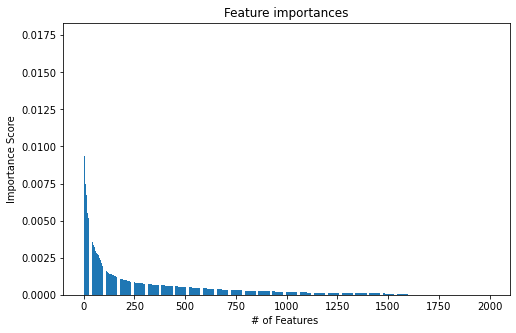

In [48]:
# Use RandomForestClassifier to select most important features
from sklearn.feature_selection import SelectFromModel, RFECV, RFE
from sklearn.ensemble import RandomForestClassifier


rf_clf = RandomForestClassifier()
rf_clf = rf_clf.fit(X[train_index], y[train_index])
RFCmodel = SelectFromModel(rf_clf, prefit=True)

importances = rf_clf.feature_importances_
indices = np.argsort(importances)[::-1]
indices = indices[:2000]
print('Optimal number of features :', RFCmodel.get_support().sum())

plt.figure(1, figsize=(8, 5))
plt.title("Feature importances")
plt.xlabel("# of Features ")
plt.ylabel("Importance Score")
plt.bar(range(2000), importances[indices])
plt.show()

In [50]:
train_X_df = pd.DataFrame(X[train_index])

In [54]:
fs_train_cv_1 = train_X_df.loc[:, RFCmodel.get_support()]

In [57]:
fs_train_cv_1

6         10        16        18        24        32        44    \
0    0.194444  0.550725  0.684211  0.458333  0.374545  0.372372  0.871245   
1    0.750613  0.296860  0.449086  0.342118  0.282961  0.430211  0.855470   
2    0.432391  0.000000  1.000000  0.000000  0.854361  0.219796  0.000000   
3    0.149881  0.563083  0.138838  0.028455  0.159012  0.272933  0.203343   
4    0.713636  0.202045  0.892975  0.562547  0.463334  0.912860  0.948800   
..        ...       ...       ...       ...       ...       ...       ...   
195  0.770833  0.086957  0.363409  0.241667  0.869091  0.669670  0.836910   
196  0.840620  0.142302  0.032579  0.466648  0.668284  0.469546  0.336617   
197  0.021974  0.000000  0.780874  1.000000  0.000000  0.000000  1.000000   
198  0.981865  0.077268  0.689204  1.000000  0.220800  0.560468  0.700318   
199  0.704610  0.569660  0.402287  0.421392  0.244830  0.202157  0.702112   

         48        52        54    ...      4364      4365      4366  \
0    0.704545  0.606838  0.877828  ...  0.489796  0.202532  1.000000   
1    0.476941  0.715799  0.757434  ...  0.494887  0.841334  0.572963   
2    0.374709  0.847161  0.728495  ...  0.508571  0.542751  0.532143   
3    0.241262  0.313632  0.481436  ...  0.581042  0.315737  0.448429   
4    0.763043  0.393211  0.715800  ...  0.989878  0.637427  0.759174   
..        ...       ...       ...  ...       ...       ...       ...   
195  0.625000  0.581197  0.832579  ...  0.479592  0.481013  0.605769   
196  0.390178  0.300466  0.159113  ...  0.963190  0.861463  0.419946   
197  0.000000  0.237633  1.000000  ...  0.000000  1.000000  0.000000   
198  0.469863  0.839730  0.235410  ...  0.651620  0.104138  0.377645   
199  0.320019  0.525970  0.471888  ...  0.501717  0.271995  0.561161   

         4369      4372      4392      4397      4400      4412      4413  
0    0.523179  0.175000  0.000000  0.869863  0.309021  0.834951  0.678571  
1    0.634264  0.638367  0.854346  0.333973  0.339223  0.480588  0.544868  
2    0.200314  0.446571  0.000000  0.289035  0.540831  0.670118  0.050938  
3    0.330441  0.620430  0.070827  0.013666  0.013276  0.911520  0.851867  
4    0.393391  0.701670  0.619849  0.000000  0.884482  0.465992  0.866507  
..        ...       ...       ...       ...       ...       ...       ...  
195  0.668874  0.612500  0.456311  0.342466  0.477927  0.300971  0.309524  
196  0.152761  0.253962  0.000000  0.554386  1.000000  0.821624  0.708328  
197  1.000000  0.000000  0.469313  0.652325  0.000000  0.000000  0.000000  
198  0.854915  0.262518  0.199866  0.128777  0.906028  0.974635  0.677851  
199  0.618595  0.744492  0.579473  0.324507  0.607544  0.438917  0.307548  

[200 rows x 937 columns]

In [60]:
y_o[train_index]

array([[0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 1.

In [64]:
model2 = tf.keras.models.Sequential([
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(results_session[best_model][1], activation=tf.nn.relu),
        tf.keras.layers.Dropout(results_session[best_model][4]),
        tf.keras.layers.Dense(results_session[best_model][2], activation=tf.nn.relu),
        tf.keras.layers.Dropout(results_session[best_model][5]),
        tf.keras.layers.Dense(results_session[best_model][3], activation=tf.nn.relu),
        tf.keras.layers.Dropout(results_session[best_model][5]),
        tf.keras.layers.Dense(5, activation=tf.nn.softmax),
        ])

In [65]:
model2.compile(
  optimizer=results_session[best_model][6],
  loss='categorical_crossentropy',
  metrics=['accuracy'],
)

In [66]:
model2.fit(fs_train_cv_1, y_o[train_index],   
        epochs=EPOCHS)

Epoch 1/200
7/7 [==============================] - 1s 3ms/step - loss: 1.7512 - accuracy: 0.1950
Epoch 2/200
7/7 [==============================] - 0s 3ms/step - loss: 1.5635 - accuracy: 0.3200
Epoch 3/200
7/7 [==============================] - 0s 3ms/step - loss: 1.4590 - accuracy: 0.4650
Epoch 4/200
7/7 [==============================] - 0s 3ms/step - loss: 1.3846 - accuracy: 0.5600
Epoch 5/200
7/7 [==============================] - 0s 3ms/step - loss: 1.3280 - accuracy: 0.5750
Epoch 6/200
7/7 [==============================] - 0s 3ms/step - loss: 1.2857 - accuracy: 0.5950
Epoch 7/200
7/7 [==============================] - 0s 3ms/step - loss: 1.2006 - accuracy: 0.6450
Epoch 8/200
7/7 [==============================] - 0s 3ms/step - loss: 1.1881 - accuracy: 0.6650
Epoch 9/200
7/7 [==============================] - 0s 3ms/step - loss: 1.1633 - accuracy: 0.6400
Epoch 10/200
7/7 [==============================] - 0s 3ms/step - loss: 1.0986 - accuracy: 0.6850
Epoch 11/200
7/7 [===========

7/7 [==============================] - 0s 3ms/step - loss: 0.2472 - accuracy: 0.9350
Epoch 85/200
7/7 [==============================] - 0s 3ms/step - loss: 0.2355 - accuracy: 0.9250
Epoch 86/200
7/7 [==============================] - 0s 3ms/step - loss: 0.2743 - accuracy: 0.9200
Epoch 87/200
7/7 [==============================] - 0s 3ms/step - loss: 0.2617 - accuracy: 0.9350
Epoch 88/200
7/7 [==============================] - 0s 3ms/step - loss: 0.2626 - accuracy: 0.9200
Epoch 89/200
7/7 [==============================] - 0s 3ms/step - loss: 0.2063 - accuracy: 0.9450
Epoch 90/200
7/7 [==============================] - 0s 3ms/step - loss: 0.2512 - accuracy: 0.9400
Epoch 91/200
7/7 [==============================] - 0s 3ms/step - loss: 0.2287 - accuracy: 0.9400
Epoch 92/200
7/7 [==============================] - 0s 3ms/step - loss: 0.2222 - accuracy: 0.9500
Epoch 93/200
7/7 [==============================] - 0s 3ms/step - loss: 0.2233 - accuracy: 0.9450
Epoch 94/200
7/7 [===============

7/7 [==============================] - 0s 3ms/step - loss: 0.0825 - accuracy: 0.9850
Epoch 168/200
7/7 [==============================] - 0s 3ms/step - loss: 0.0910 - accuracy: 0.9650
Epoch 169/200
7/7 [==============================] - 0s 3ms/step - loss: 0.1123 - accuracy: 0.9750
Epoch 170/200
7/7 [==============================] - 0s 3ms/step - loss: 0.0684 - accuracy: 0.9850
Epoch 171/200
7/7 [==============================] - 0s 3ms/step - loss: 0.0729 - accuracy: 0.9800
Epoch 172/200
7/7 [==============================] - 0s 3ms/step - loss: 0.1031 - accuracy: 0.9600
Epoch 173/200
7/7 [==============================] - 0s 3ms/step - loss: 0.0675 - accuracy: 0.9900
Epoch 174/200
7/7 [==============================] - 0s 3ms/step - loss: 0.0747 - accuracy: 0.9800
Epoch 175/200
7/7 [==============================] - 0s 3ms/step - loss: 0.0801 - accuracy: 0.9850
Epoch 176/200
7/7 [==============================] - 0s 3ms/step - loss: 0.0675 - accuracy: 0.9900
Epoch 177/200
7/7 [=====

In [73]:
test_prediction = model.predict(X[test_index])

In [74]:
test_prediction_ohe = scalar_to_ohe(test_prediction)

In [75]:
from sklearn.metrics import confusion_matrix

confusion_matrix(encoder.inverse_transform(y_o[test_index]), encoder.inverse_transform(test_prediction_ohe))

array([[32,  0,  0,  0,  0],
       [ 0, 44,  0,  0,  0],
       [ 0,  0,  7,  0,  0],
       [ 0,  0,  0,  7,  0],
       [ 0,  0,  0,  0,  9]])

In [76]:
from sklearn.metrics import classification_report

print(classification_report(encoder.inverse_transform(y_o[test_index]), encoder.inverse_transform(test_prediction_ohe)))

              precision    recall  f1-score   support

         A1A       1.00      1.00      1.00        32
     DIABETE       1.00      1.00      1.00        44
          GS       1.00      1.00      1.00         7
         MCM       1.00      1.00      1.00         7
        NALD       1.00      1.00      1.00         9

    accuracy                           1.00        99
   macro avg       1.00      1.00      1.00        99
weighted avg       1.00      1.00      1.00        99



### Feature Importance: Recursive Elimination

Optimal number of features : 85


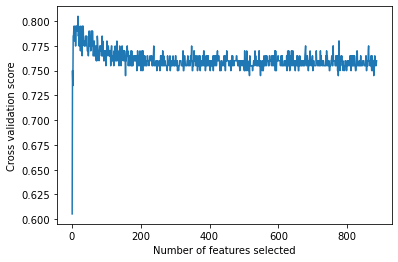

In [77]:
rfecv = RFECV(estimator=RandomForestClassifier(), step=5, cv=StratifiedKFold(3), scoring='accuracy')
rfecv.fit(X[train_index], y[train_index])
print('Optimal number of features :', rfecv.n_features_)


# Plot showing the Cross Validation score
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score")
plt.plot(range(1, len(rfecv.cv_results_['mean_test_score']) + 1), rfecv.cv_results_['mean_test_score'])
plt.show()

In [78]:
rfe = RFE(estimator=RandomForestClassifier(), n_features_to_select=rfecv.n_features_, step=5)
rfe = rfe.fit(X[train_index], y[train_index])

In [79]:
fs_train_cv_2 = train_X_df.loc[:, rfe.get_support()]

In [80]:
model3 = tf.keras.models.Sequential([
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(results_session[best_model][1], activation=tf.nn.relu),
        tf.keras.layers.Dropout(results_session[best_model][4]),
        tf.keras.layers.Dense(results_session[best_model][2], activation=tf.nn.relu),
        tf.keras.layers.Dropout(results_session[best_model][5]),
        tf.keras.layers.Dense(results_session[best_model][3], activation=tf.nn.relu),
        tf.keras.layers.Dropout(results_session[best_model][5]),
        tf.keras.layers.Dense(5, activation=tf.nn.softmax),
        ])

In [81]:
model3.compile(
  optimizer=results_session[best_model][6],
  loss='categorical_crossentropy',
  metrics=['accuracy'],
)

In [82]:
model3.fit(fs_train_cv_2, y_o[train_index],   
        epochs=EPOCHS)

Epoch 1/200
7/7 [==============================] - 1s 3ms/step - loss: 1.6732 - accuracy: 0.2950
Epoch 2/200
7/7 [==============================] - 0s 3ms/step - loss: 1.5925 - accuracy: 0.3350
Epoch 3/200
7/7 [==============================] - 0s 3ms/step - loss: 1.5390 - accuracy: 0.3600
Epoch 4/200
7/7 [==============================] - 0s 3ms/step - loss: 1.4676 - accuracy: 0.4150
Epoch 5/200
7/7 [==============================] - 0s 3ms/step - loss: 1.4135 - accuracy: 0.5300
Epoch 6/200
7/7 [==============================] - 0s 3ms/step - loss: 1.4034 - accuracy: 0.5350
Epoch 7/200
7/7 [==============================] - 0s 3ms/step - loss: 1.3691 - accuracy: 0.5050
Epoch 8/200
7/7 [==============================] - 0s 3ms/step - loss: 1.2773 - accuracy: 0.5950
Epoch 9/200
7/7 [==============================] - 0s 3ms/step - loss: 1.3000 - accuracy: 0.6100
Epoch 10/200
7/7 [==============================] - 0s 3ms/step - loss: 1.2754 - accuracy: 0.5900
Epoch 11/200
7/7 [===========

7/7 [==============================] - 0s 3ms/step - loss: 0.5968 - accuracy: 0.7850
Epoch 85/200
7/7 [==============================] - 0s 3ms/step - loss: 0.5854 - accuracy: 0.8050
Epoch 86/200
7/7 [==============================] - 0s 3ms/step - loss: 0.5098 - accuracy: 0.8250
Epoch 87/200
7/7 [==============================] - 0s 3ms/step - loss: 0.5825 - accuracy: 0.7600
Epoch 88/200
7/7 [==============================] - 0s 3ms/step - loss: 0.5327 - accuracy: 0.8100
Epoch 89/200
7/7 [==============================] - 0s 2ms/step - loss: 0.5534 - accuracy: 0.8100
Epoch 90/200
7/7 [==============================] - 0s 3ms/step - loss: 0.5634 - accuracy: 0.7950
Epoch 91/200
7/7 [==============================] - 0s 3ms/step - loss: 0.5355 - accuracy: 0.8000
Epoch 92/200
7/7 [==============================] - 0s 3ms/step - loss: 0.5365 - accuracy: 0.8100
Epoch 93/200
7/7 [==============================] - 0s 3ms/step - loss: 0.5431 - accuracy: 0.8000
Epoch 94/200
7/7 [===============

7/7 [==============================] - 0s 3ms/step - loss: 0.3662 - accuracy: 0.8650
Epoch 168/200
7/7 [==============================] - 0s 3ms/step - loss: 0.3140 - accuracy: 0.8850
Epoch 169/200
7/7 [==============================] - 0s 3ms/step - loss: 0.3524 - accuracy: 0.8950
Epoch 170/200
7/7 [==============================] - 0s 3ms/step - loss: 0.3269 - accuracy: 0.8900
Epoch 171/200
7/7 [==============================] - 0s 3ms/step - loss: 0.3398 - accuracy: 0.8800
Epoch 172/200
7/7 [==============================] - 0s 3ms/step - loss: 0.3166 - accuracy: 0.9100
Epoch 173/200
7/7 [==============================] - 0s 3ms/step - loss: 0.3420 - accuracy: 0.8750
Epoch 174/200
7/7 [==============================] - 0s 3ms/step - loss: 0.3191 - accuracy: 0.9050
Epoch 175/200
7/7 [==============================] - 0s 3ms/step - loss: 0.3006 - accuracy: 0.9400
Epoch 176/200
7/7 [==============================] - 0s 3ms/step - loss: 0.3372 - accuracy: 0.8850
Epoch 177/200
7/7 [=====

In [83]:
test2_prediction = model.predict(X[test_index])

In [84]:
test2_prediction_ohe = scalar_to_ohe(test2_prediction)

In [85]:
from sklearn.metrics import confusion_matrix

confusion_matrix(encoder.inverse_transform(y_o[test_index]), encoder.inverse_transform(test2_prediction_ohe))

array([[32,  0,  0,  0,  0],
       [ 0, 44,  0,  0,  0],
       [ 0,  0,  7,  0,  0],
       [ 0,  0,  0,  7,  0],
       [ 0,  0,  0,  0,  9]])

In [86]:
from sklearn.metrics import classification_report

print(classification_report(encoder.inverse_transform(y_o[test_index]), encoder.inverse_transform(test2_prediction_ohe)))

              precision    recall  f1-score   support

         A1A       1.00      1.00      1.00        32
     DIABETE       1.00      1.00      1.00        44
          GS       1.00      1.00      1.00         7
         MCM       1.00      1.00      1.00         7
        NALD       1.00      1.00      1.00         9

    accuracy                           1.00        99
   macro avg       1.00      1.00      1.00        99
weighted avg       1.00      1.00      1.00        99



In [102]:
genes = df.loc[:, df.columns != 'DISEASE'].loc[:,rfe.support_].columns

In [103]:
genes

Index(['APOD', 'WDR59', 'THAP10', 'C19ORF54', 'PEX5', 'TSPAN7', 'ANXA6',
       'PMP22', 'FNBP1L', 'NLGN1', 'CTC1', 'ZNF160', 'DYRK4', 'ACVRL1',
       'SIRPA', 'HSD17B12', 'ZNF215', 'ZNF14', 'SOCS2', 'CLINT1', 'ALPK3',
       'ARHGAP25', 'IL4R', 'SOX12', 'SCD', 'IKZF4', 'GTPBP3', 'ROR1',
       'NDUFAF7', 'ADCK2', 'MSRA', 'SMURF1', 'EIF4A3', 'VAT1', 'GIGYF2',
       'LRRC3', 'GPNMB', 'HSD17B14', 'SOWAHC', 'RASAL2', 'PPARG', 'SRRD',
       'EPB41L1', 'EPAS1', 'AKAP12', 'MID1', 'FRMD4A', 'NENF', 'CTSD', 'PRDX2',
       'PLTP', 'GSTA4', 'BOP1', 'SOBP', 'AXL', 'COLEC12', 'ADAM9', 'ZNF362',
       'PHACTR4', 'SELENBP1', 'EMCN', 'PER1', 'PSAP', 'BCAR3', 'PAPOLG',
       'DYRK2', 'MME', 'MANSC1', 'MXI1', 'MAPKAPK2', 'ASL', 'NBEA', 'ARHGEF15',
       'TMEM80', 'UNC5B', 'AKAP8', 'DDX50', 'EXD3', 'UBE2V2', 'DLAT',
       'FAM120C', 'BCL2L1', 'HSD17B10', 'GPX3', 'MAPKAPK3'],
      dtype='object')